In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [26]:
import geopandas as gpd
import geocoder
import folium
import requests
import time
import math
from shapely.geometry import Point

In [3]:
# Notebook Styling 
sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

The data set below is available on this [City of Chicago Data Portal page](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), but as the file is approximately 1 GB, I've excluded it from this repo.

[Chicago Community Area Geojson](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

[Chicago Police Beat Geojson](https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-current-/aerh-rz74)

[Chicago 2010 Census Block Geojson](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Blocks-2010/mfzt-js4n)

In [4]:
def process_chicrimes(chi_crimes):
    chi_crimes['Date'] = pd.to_datetime(chi_crimes['Date'], format='%m/%d/%Y %I:%M:%S %p')
    chi_crimes['Updated On'] = pd.to_datetime(chi_crimes['Updated On'], format='%m/%d/%Y %I:%M:%S %p')
    chi_crimes.drop(['Location', 'X Coordinate', 'Y Coordinate'], axis=1, inplace=True)
    chi_crimes['Block'] = chi_crimes['Block'].astype('category')
    chi_crimes['IUCR'] = chi_crimes['IUCR'].astype('category')
    chi_crimes['Primary Type'] = chi_crimes['Primary Type'].astype('category')
    chi_crimes['Description'] = chi_crimes['Description'].astype('category')
    chi_crimes['Location Description'] = chi_crimes['Primary Type'].astype('category')
    chi_crimes['Beat'] = chi_crimes['Beat'].astype(int)
    chi_crimes['District'] = chi_crimes['District'].astype('category')
    chi_crimes['Ward'] = chi_crimes['Ward'].astype('category')
    chi_crimes['Community Area'] = chi_crimes['Community Area'].astype('category')
    chi_crimes['FBI Code'] = chi_crimes['FBI Code'].astype('category')
    chi_crimes['Hour'] = chi_crimes['Date'].dt.hour
    chi_crimes['Week'] = chi_crimes['Date'].dt.weekofyear
    chi_crimes['Day'] = chi_crimes['Date'].dt.dayofyear
    chi_crimes['Weekday'] = chi_crimes['Date'].dt.dayofweek
    chi_crimes['Month'] = chi_crimes['Date'].dt.month
    chi_crimes['Hour'] = chi_crimes['Hour'].astype('category')
    chi_crimes['Week'] = chi_crimes['Week'].astype('category')
    chi_crimes['Day'] = chi_crimes['Day'].astype('category')
    chi_crimes['Weekday'] = chi_crimes['Weekday'].astype('category')
    chi_crimes['Month'] = chi_crimes['Month'].astype('category')
    return chi_crimes

In [5]:
CSV_PATH = os.path.join('..', 'data_raw', 'Crimes_-_2001_to_present.csv')
crime_dtypes = {'District':str,
                'Ward':str, 
                'Community Area':str}
chi_crimes = pd.read_csv(CSV_PATH, dtype=crime_dtypes, encoding='latin1') 
chi_crimes.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,03/18/2015 07:44:00 PM,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,011,28,25,04B,1144606.0,1903566.0,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,"(41.891398861, -87.744384567)"
1,10000094,HY190059,03/18/2015 11:00:00 PM,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,007,15,67,26,1166468.0,1860715.0,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,"(41.773371528, -87.665319468)"
2,10000095,HY190052,03/18/2015 10:45:00 PM,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,002,4,39,08B,1185075.0,1875622.0,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,"(41.81386068, -87.596642837)"
3,10000096,HY190054,03/18/2015 10:30:00 PM,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,002,3,40,08B,1178033.0,1870804.0,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,"(41.800802415, -87.622619343)"
4,10000097,HY189976,03/18/2015 09:00:00 PM,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,011,28,25,03,1144920.0,1898709.0,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354,"(41.878064761, -87.743354013)"


In [6]:
chi_crimes = process_chicrimes(chi_crimes)

In [7]:
chi_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6784163 entries, 0 to 6784162
Data columns (total 24 columns):
ID                      int64
Case Number             object
Date                    datetime64[ns]
Block                   category
IUCR                    category
Primary Type            category
Description             category
Location Description    category
Arrest                  bool
Domestic                bool
Beat                    int32
District                category
Ward                    category
Community Area          category
FBI Code                category
Year                    int64
Updated On              datetime64[ns]
Latitude                float64
Longitude               float64
Hour                    category
Week                    category
Day                     category
Weekday                 category
Month                   category
dtypes: bool(2), category(14), datetime64[ns](2), float64(2), int32(1), int64(2), object(1)
memory usage

In [8]:
chi_crimes.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude,Hour,Week,Day,Weekday,Month
0,10000092,HY189866,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,BATTERY,False,False,1111,011,28,25,04B,2015,2018-02-10 15:50:01,41.891399,-87.744385,19,12,77,2,3
1,10000094,HY190059,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,OTHER OFFENSE,True,False,725,007,15,67,26,2015,2018-02-10 15:50:01,41.773372,-87.665319,23,12,77,2,3


In [13]:
query = chi_crimes['Description'].value_counts()
query[query >= 20000]

SIMPLE                                 800054
$500 AND UNDER                         550320
DOMESTIC BATTERY SIMPLE                520593
TO VEHICLE                             376613
TO PROPERTY                            356720
OVER $500                              350604
POSS: CANNABIS 30GMS OR LESS           276782
FORCIBLE ENTRY                         263933
AUTOMOBILE                             247609
FROM BUILDING                          228517
RETAIL THEFT                           168796
TELEPHONE THREAT                       135003
TO LAND                                120276
POSS: CRACK                            119291
UNLAWFUL ENTRY                         103494
HARASSMENT BY TELEPHONE                100749
AGGRAVATED: OTHER DANG WEAPON           93641
POSS: HEROIN(WHITE)                     92321
ARMED: HANDGUN                          91039
STRONGARM - NO WEAPON                   89127
AGGRAVATED: HANDGUN                     84649
AGGRAVATED:KNIFE/CUTTING INSTR    

In [10]:
chi_crimes_recent = chi_crimes.loc[chi_crimes['Date'] >= '2016-01-01'].copy()

In [75]:
from fiona.crs import from_epsg

In [78]:
shootings = chi_crimes_recent.loc[(chi_crimes_recent['Description'].isin(['AGGRAVATED: HANDGUN']))].copy()
point_maker = lambda x: Point(x['Longitude'], x['Latitude'])
shootings['geometry'] = shootings.apply(point_maker, axis=1)
shootings = gpd.GeoDataFrame(shootings)
shootings['geometry'] = shootings['geometry'].to_crs(epsg=4326)
# shootings = shootings.to_crs({'init': 'epsg:4326'})

AttributeError: 'Series' object has no attribute 'to_crs'

In [61]:
shootings.crs = {'init': 'epsg:4326'}

In [62]:
shootings.crs

{'init': 'epsg:4326'}

In [18]:
CSV_PATH = os.path.join('..', 'data_raw', '311VacantAbandonedBuildings.csv')
vacant_bld = pd.read_csv(CSV_PATH,  encoding='latin1') 
vacant_bld.head()

C:\Users\matthewtriano\AppData\Local\Continuum\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,DataType,SERVICE REQUEST NUMBER,DATE SERVICE REQUEST WAS RECEIVED,IS THE BUILDING CURRENTLY VACANT OR OCCUPIED?,IS THE BUILDING VACANT DUE TO FIRE?,"ANY PEOPLE USING PROPERTY? (HOMELESS, CHILDEN, GANGS)",ZIP CODE,X COORDINATE,Y COORDINATE,Ward,Police District,Community Area,LATITUDE,LONGITUDE
0,VacantAbandoned,17-07593749,2017/11/9,Vacant,False,True,60636.0,1162874.860,1868024.584,15.0,7.0,67.0,41.793506,-87.678287
1,VacantAbandoned,17-07582514,2017/11/9,Vacant,True,True,60624.0,1147529.289,1897669.493,28.0,11.0,26.0,41.875163,-87.733800
2,VacantAbandoned,17-07580534,2017/11/9,Vacant,False,False,60629.0,1154704.926,1856987.690,17.0,8.0,66.0,41.763386,-87.708540
3,VacantAbandoned,17-07584577,2017/11/9,Vacant,False,True,60628.0,1176713.264,1838384.686,9.0,5.0,49.0,41.711870,-87.628433
4,VacantAbandoned,17-07577519,2017/11/9,NaN,NaN,NaN,60608.0,1169469.911,1891903.850,25.0,12.0,31.0,41.858892,-87.653411


## CTA Load and Preprocess

In [72]:
ZIP_SHP_PATH = os.path.join('zip://', '..', 'data_raw', 'CTA_RailStations.zip')
cta_stops = gpd.read_file(ZIP_SHP_PATH)
# cta_stops = cta_stops.to_crs({'init': 'epsg:4326'})
# beats['beat_num'] = beats['beat_num'].astype(int)

In [73]:
cta_stops.head(2)

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,GTFS,geometry
0,1120,35-Bronzeville-IIT,Green Line,16 E. 35th Street,1,0,1.177051e+06,1.882048e+06,41120,POINT (1177050.915135533 1882047.587073635)
1,760,Granville,Red Line,1119 W. Granville Avenue,1,0,1.167506e+06,1.941003e+06,40760,POINT (1167506.039094643 1941002.514488541)


In [74]:
cta_stops.crs

{'proj': 'tmerc',
 'lat_0': 36.66666666666666,
 'lon_0': -88.33333333333333,
 'k': 0.999975,
 'x_0': 300000,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

In [53]:
shootings = gpd.GeoDataFrame(shootings)

In [64]:
def min_distance(point):
    return cta_stops.distance(point).min()

In [65]:
shootings['min_dist_to_cta_stop'] = shootings['geometry'].apply(min_distance)

In [66]:
type(shootings)

geopandas.geodataframe.GeoDataFrame

In [67]:
shootings.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude,Hour,Week,Day,Weekday,Month,geometry,min_dist_to_cta_stop
196320,10364703,HZ100060,2016-01-01 01:06:00,058XX S TRUMBULL AVE,051A,ASSAULT,AGGRAVATED: HANDGUN,ASSAULT,False,False,822,008,14,63,04A,2016,2018-02-10 15:50:01,41.787031,-87.709498,1,53,1,4,1,POINT (-87.709498 41.787031282),0.018075
196340,10364731,HZ100035,2016-01-01 00:12:00,080XX S PAXTON AVE,041A,BATTERY,AGGRAVATED: HANDGUN,BATTERY,False,False,414,004,8,46,04B,2016,2018-02-10 15:50:01,41.749099,-87.571065,0,53,1,4,1,POINT (-87.571064546 41.749098798),0.046740


In [68]:
shootings.crs

{'init': 'epsg:4326'}

In [69]:
cta_stops.crs

{'init': 'epsg:4326'}

In [44]:
tmp

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,GTFS,geometry
0,1120,35-Bronzeville-IIT,Green Line,16 E. 35th Street,1,0,1.177051e+06,1.882048e+06,41120,POINT (-87.62588147448889 41.83167802166114)
1,760,Granville,Red Line,1119 W. Granville Avenue,1,0,1.167506e+06,1.941003e+06,40760,POINT (-87.65920227948941 41.99366426103082)
2,1210,Wellington,"Brown, Purple (Express)",945 W. Wellington Avenue,1,0,1.169286e+06,1.920014e+06,41210,POINT (-87.65326645004656 41.93603260267869)
3,140,Dempster-Skokie,Yellow Line,5001 W. Dempster Street,1,1,1.142190e+06,1.957320e+06,40140,POINT (-87.75191862595251 42.03895069338445)
4,370,Washington/Dearborn,Blue Line,19 N. Dearborn,0,0,1.175927e+06,1.900801e+06,40370,POINT (-87.62944005964673 41.88316442656281)
5,1480,Western-Ravenswood,Brown Line,4645 N. Western Avenue,1,0,1.159616e+06,1.930951e+06,41480,POINT (-87.6885026059004 41.96625004821527)
6,1440,Addison-Ravenswood,Brown Line,1818 W. Addison Street,1,0,1.163414e+06,1.923975e+06,41440,POINT (-87.67473610744644 41.94702865537455)
7,90,Damen-Ravenswood,Brown Line,4643 N. Damen Avenue,1,0,1.162299e+06,1.931030e+06,40090,POINT (-87.67863488433059 41.96641097276196)
8,160,LaSalle/Van Buren,"Brown, Orange, Pink, Purple (Express)",121 W. Van Buren Street,0,0,1.175321e+06,1.898497e+06,40160,POINT (-87.63173383435947 41.87685533507717)
9,1490,Harrison,Red Line,608 S. State Street,0,0,1.176489e+06,1.897480e+06,41490,POINT (-87.62747911770379 41.87403924405196)


In [10]:
homicides = chi_crimes[chi_crimes['Primary Type'] == 'HOMICIDE'].copy()

In [10]:
homicides = chi_crimes[chi_crimes['Primary Type'] == 'HOMICIDE'].copy()

In [15]:
hom_counts = homicides.groupby('Year')['ID'].count()

In [9]:
chi_crimes['Primary Type'].unique()

[BATTERY, OTHER OFFENSE, ROBBERY, NARCOTICS, CRIMINAL DAMAGE, ..., NON - CRIMINAL, NON-CRIMINAL, RITUALISM, NON-CRIMINAL (SUBJECT SPECIFIED), DOMESTIC VIOLENCE]
Length: 35
Categories (35, object): [BATTERY, OTHER OFFENSE, ROBBERY, NARCOTICS, ..., NON-CRIMINAL, RITUALISM, NON-CRIMINAL (SUBJECT SPECIFIED), DOMESTIC VIOLENCE]

In [10]:
query = chi_crimes.loc[:,'Primary Type'].value_counts()
query

THEFT                                1427332
BATTERY                              1238778
CRIMINAL DAMAGE                       775204
NARCOTICS                             712700
ASSAULT                               421167
OTHER OFFENSE                         420879
BURGLARY                              389632
MOTOR VEHICLE THEFT                   315719
DECEPTIVE PRACTICE                    265288
ROBBERY                               257023
CRIMINAL TRESPASS                     194278
WEAPONS VIOLATION                      71444
PROSTITUTION                           68418
PUBLIC PEACE VIOLATION                 47988
OFFENSE INVOLVING CHILDREN             45677
CRIM SEXUAL ASSAULT                    27348
SEX OFFENSE                            25235
INTERFERENCE WITH PUBLIC OFFICER       15309
GAMBLING                               14427
LIQUOR LAW VIOLATION                   14082
ARSON                                  11202
HOMICIDE                                9505
KIDNAPPING

In [11]:
chi_crimes.loc[chi_crimes['Primary Type'] == 'HOMICIDE', 'Description'].unique()

[FIRST DEGREE MURDER, RECKLESS HOMICIDE, INVOLUNTARY MANSLAUGHTER]
Categories (3, object): [FIRST DEGREE MURDER, RECKLESS HOMICIDE, INVOLUNTARY MANSLAUGHTER]

In [12]:
def plot_monthly_and_yearly_rates(df, crime, max_year=2018):
    df = df[df['Year'] <= max_year]
    df.set_index('Date', inplace=True)
    
    fig, ax = plt.subplots(sharex=True, figsize=(12,4))
    mo_df = df[['ID']].groupby([df.index.year, df.index.month]).count()
    mo_df.plot(ax=ax, kind='line', legend=None)
    ax.set_title('Monthly (top) and Annual (bot) {} in Chicago'.format(crime), fontsize=16)
    ax.set_ylabel('{} per Month'.format(crime), fontsize=14)
    ax.set_xlabel('', fontsize=14)
    ax.set_ylim([0, mo_df['ID'].max() * 1.1])
    plt.tight_layout()
    
    fig, ax = plt.subplots(sharex=True, figsize=(12,4))
    yr_df = df[['ID']].groupby([df.index.year]).count()
    yr_df.plot(ax=ax, legend=None)
    ax.set_ylabel('{} per Year'.format(crime), fontsize=14)
    ax.set_xlabel('Year', fontsize=16)
    ax.set_ylim([0, yr_df['ID'].max() * 1.1])
    plt.tight_layout()
    
    return df

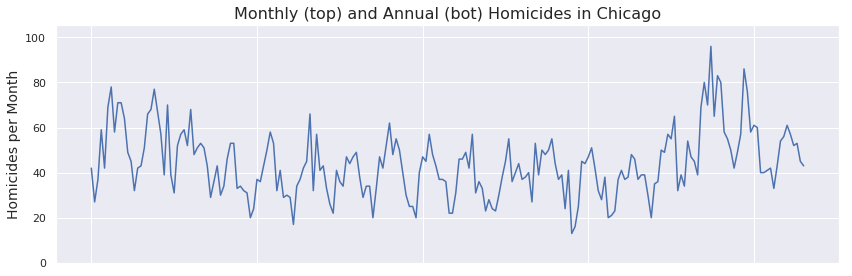

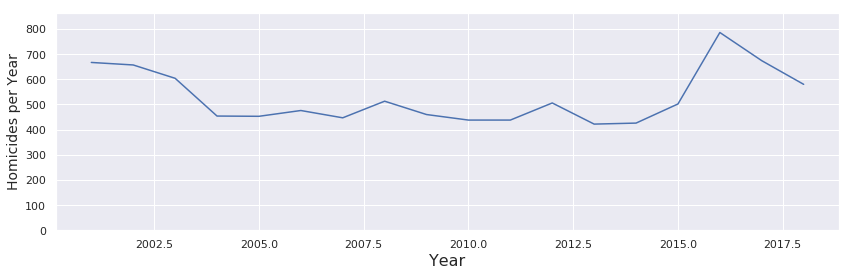

In [13]:
df = chi_crimes.loc[chi_crimes['Primary Type'] == 'HOMICIDE'].copy()
homicides = plot_monthly_and_yearly_rates(df, 'Homicides', 2018)

In [19]:
def plot_monthly_and_yearly_rates(df, crime, col='Primary Type', max_year=2018, figsize=(12,4)):
    with sns.axes_style("darkgrid"):
        df = df[(df['Year'] <= max_year) & (df[col] == crime)]
        df.set_index('Date', inplace=True)
        
        fig, ax = plt.subplots(sharex=True, figsize=figsize)
        mo_df = df[['ID']].groupby([df.index.year, df.index.month]).count()
        mo_df.plot(ax=ax, kind='line', legend=None)
        ax.set_title('Monthly (top) and Annual (bot) {} in Chicago'.format(crime), fontsize=16)
        ax.set_ylabel('{} per Month'.format(crime), fontsize=14)
        ax.set_xlabel('', fontsize=14)
        ax.set_ylim([0, mo_df['ID'].max() * 1.1])
        plt.tight_layout()
        
        fig, ax = plt.subplots(sharex=True, figsize=(12,4))
        yr_df = df[['ID']].groupby([df.index.year]).count()
        yr_df.plot(ax=ax, legend=None)
        ax.set_ylabel('{} per Year'.format(crime), fontsize=14)
        ax.set_xlabel('Year', fontsize=16)
        ax.set_ylim([0, yr_df['ID'].max() * 1.1])
        plt.tight_layout()

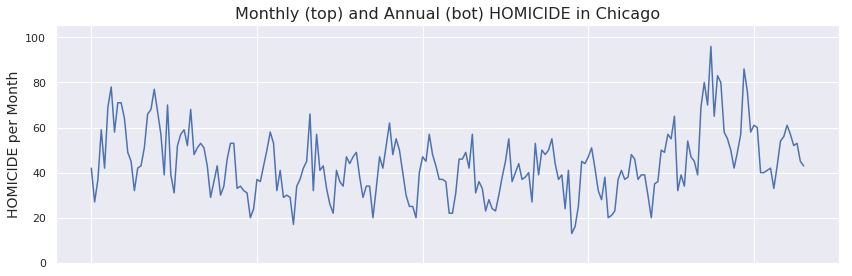

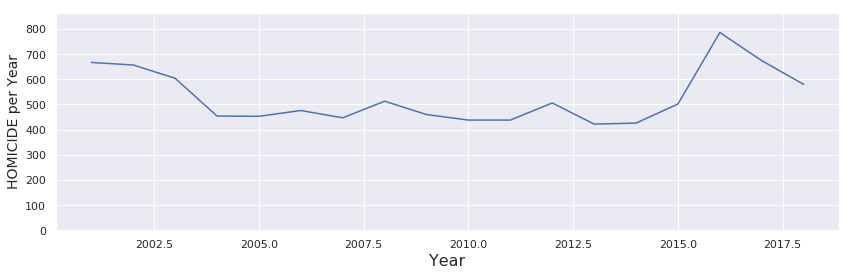

In [20]:
plot_monthly_and_yearly_rates(chi_crimes, 'HOMICIDE')

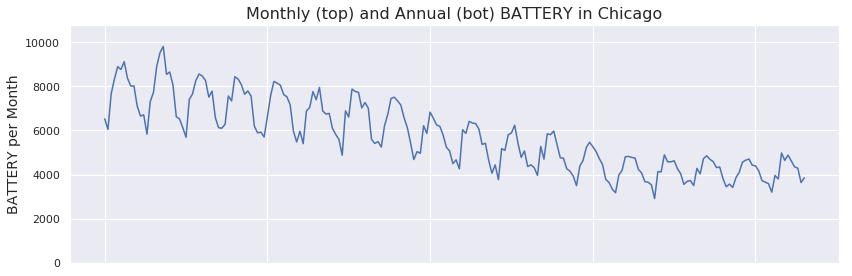

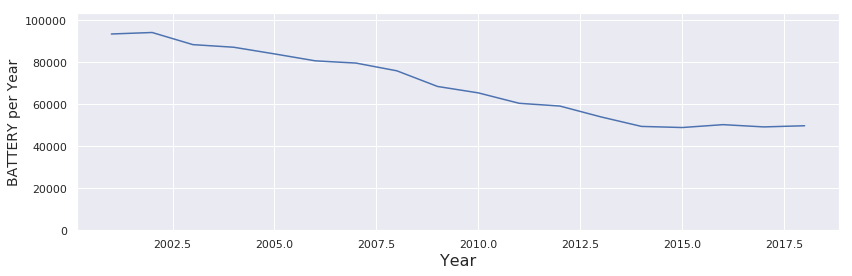

In [21]:
plot_monthly_and_yearly_rates(chi_crimes, 'BATTERY')

### Homicide Counts per year (Unique IDs)

In [14]:
hom_counts = homicides[['ID']].groupby([homicides.index.year]).count()
hom_counts.rename({'ID':'Annual_Homs'}, axis=1, inplace=True)
hom_counts

,Annual_Homs
Date,
2001,667
2002,657
2003,604
2004,454
2005,453
2006,476
2007,447
2008,513
2009,460


## Non-Fatal Shootings

Per the [CPD Incident Reporting Guide](http://directives.chicagopolice.org/forms/CPD-63.451_Table.pdf), IUCR (Illinois Uniform Crime Reporting) numbers relating to shootings are:
* 041A (shot victim with handgun) 
* 041B (shot victim armed with non-handgun firearm)
* 0450 (shot police officer with a handgun)
* 0451 (shot police officer armed with non-handgun firearm)
* 0480 (shot protected employee with handgun) 
* 0481 (shot protected employee armed with non-handgun firearm)
* 0488 (shot family or household member with handgun) 
* 0489 (shot family or household member with non-handgun firearm)
* 0490 (Ritual mutilation with a handgun)
* 0491 (Ritual mutilation with a non-handgun firearm)

Additionally, we know that crimes with these codings weren't fatal, as they would have been upgraded to homicides if they were fatal.

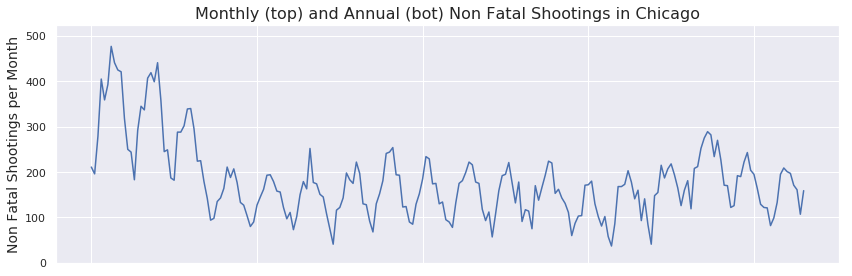

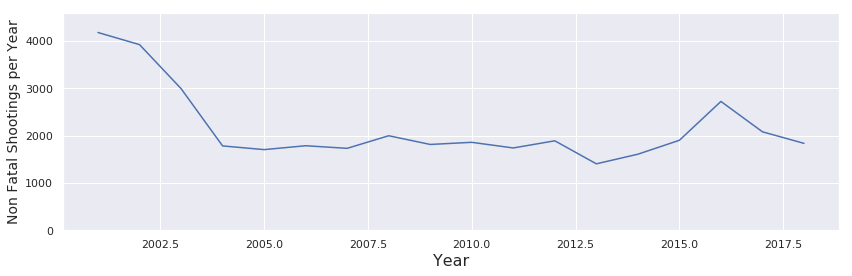

In [15]:
df = chi_crimes[(chi_crimes['IUCR'].isin(['041A','041B','0450','0451','0480','0481','0488','0489']))].copy()
non_fatal_shootings = plot_monthly_and_yearly_rates(df, 'Non Fatal Shootings', 2018)

### Non-Fatal Shootings per Year (Unique IDs)

In [16]:
nfs_counts = non_fatal_shootings[['ID']].groupby([non_fatal_shootings.index.year]).count()
nfs_counts.rename({'ID':'Annual_Non_Fatal_Shootings'}, axis=1, inplace=True)
nfs_counts

,Annual_Non_Fatal_Shootings
Date,
2001,4175
2002,3919
2003,2991
2004,1781
2005,1703
2006,1785
2007,1730
2008,1996
2009,1812


In [17]:
non_fatal_shootings = chi_crimes[(chi_crimes['IUCR'].isin(['041A','041B','0450','0451','0480','0481','0488','0489']))].copy()
non_fatal_shootings = non_fatal_shootings[non_fatal_shootings['Year'] < 2019]
non_fatal_shootings.set_index('Date', inplace=True)
nfs_counts = non_fatal_shootings[['ID']].groupby([non_fatal_shootings.index.year]).count()
nfs_counts.rename({'ID':'Annual_Non_Fatal_Shootings'}, axis=1, inplace=True)
nfs_counts

,Annual_Non_Fatal_Shootings
Date,
2001,4175
2002,3919
2003,2991
2004,1781
2005,1703
2006,1785
2007,1730
2008,1996
2009,1812


In [25]:
ZIP_SHP_PATH = os.path.join('zip://', '..', 'data_raw', 'Boundaries - Police Beats (current).zip')
beats = gpd.read_file(ZIP_SHP_PATH)
beats['beat_num'] = beats['beat_num'].astype(int)
# ax = beats.plot(figsize=(10,10))
# ax.grid('off')

In [26]:
def map_counts(df_, col_val, start_date='2001-01-01', end_date='2019-01-03', gdf=beats, val='Arrest', col='Primary Type', my_cmap='YlGn', scale=0.6, tight=True, figsize=(10,10)):
    df = df_[(df_['Date'] >= start_date) & (df_['Date'] <= end_date)].copy()
    fig, ax = plt.subplots(figsize=figsize)
    counts = df.pivot_table(index='Beat', values=val, columns=col, aggfunc='count', fill_value=0)[[col_val]]
    map_df = pd.merge(left=gdf, right=counts, right_index=True, left_on='beat_num')
    vmin = map_df[col_val].min()
    vmax = map_df[col_val].max()
    
    base = gdf.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
    map_df.plot(column=col_val, ax=base, cmap=my_cmap)
    _ = ax.axis('off')
    _ = ax.set_title('Counts of {} per police beat\nfrom {} to {}'.format(col_val, start_date, end_date),
                     fontdict={'fontsize': '25', 'fontweight':'3'})
    
    sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, shrink=scale)
    if tight:
        plt.tight_layout()

In [27]:
def get_timescales(span, x=False):
    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    weeks = np.arange(0,53).tolist()
    weekdays = ['Sun', 'Sat', 'Fri', 'Thu', 'Wed', 'Tue', 'Mon']
    hours = np.arange(23,-1,-1).tolist()
    if span == 'Month':
        return (span, months)
    elif span == 'Hour':
        return (span, hours)
    elif span == 'Week':
        return (span, weeks)
    else:
        if x:
            weekdays.reverse()
        return ('Weekday', weekdays)

def plot_crime_freq_heatmap(crime_desc, x_ax, y_ax, year, df=chi_crimes, figsize=(14,6), cmap='YlGn', col='Primary Type'):    
    x_ax, x_labs = get_timescales(x_ax, True)
    y_ax, y_labs = get_timescales(y_ax)
    tmp = df[(df[col] == crime_desc) &
             (df['Year'] == year)][[col, y_ax, x_ax]] 
    tmp1 = tmp.pivot_table(index=y_ax, columns=x_ax, values=col, aggfunc=['count'])
    tmp1.sort_index(ascending=False, inplace=True)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(tmp1, ax=ax, annot=False, fmt='d', cmap=cmap)
    ax.xaxis.set_ticklabels(x_labs, fontsize=14)
    ax.yaxis.set_ticklabels(y_labs, fontsize=12, rotation=0)
    ax.set_xlabel(x_ax, fontsize=14)
    ax.set_ylabel(y_ax, fontsize=14)
    ax.set_title('Frequency of crime: "{}" by {} and {} for {}'
                 .format(crime_desc, y_ax, x_ax, year), fontsize=16)
    plt.show()

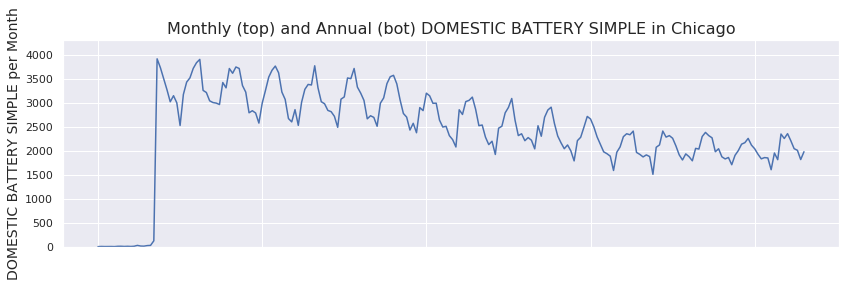

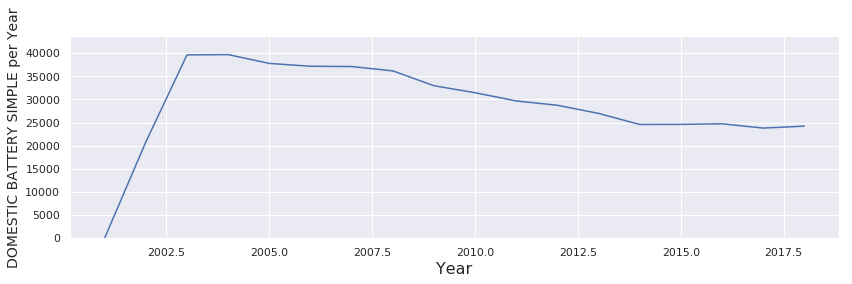

In [32]:
plot_monthly_and_yearly_rates(chi_crimes, 'DOMESTIC BATTERY SIMPLE', col='Description')

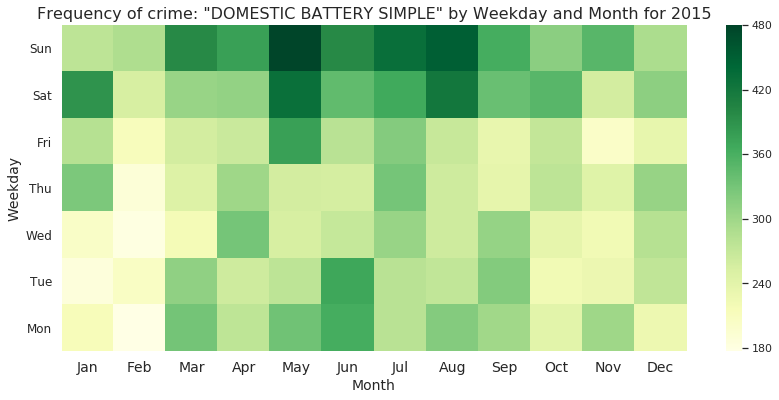

In [28]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Month', 'Weekday', 2015, col='Description')


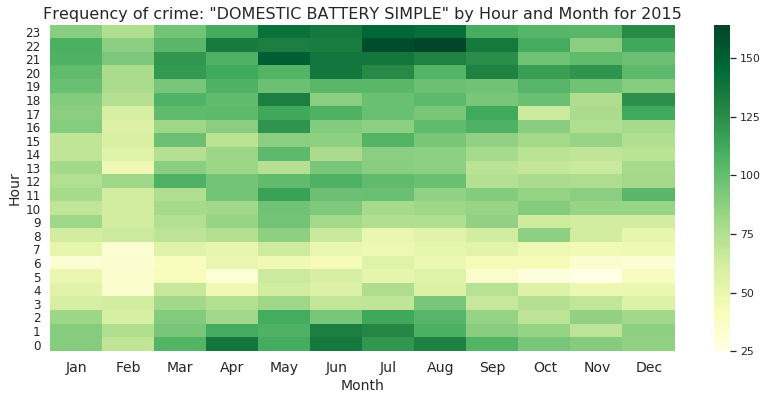

In [29]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Month', 'Hour', 2015, col='Description')

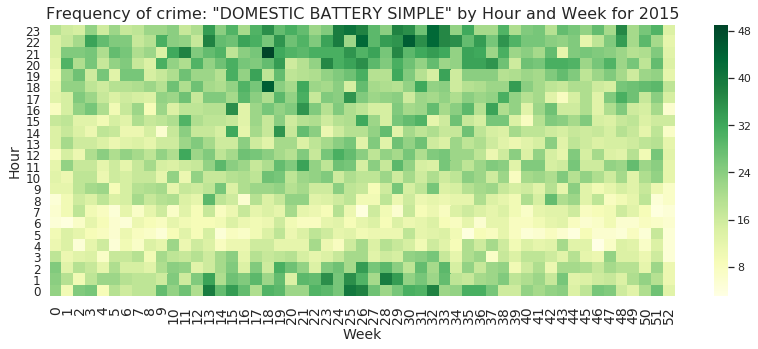

In [30]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Week', 'Hour', 2015, figsize=(14,5), col='Description')

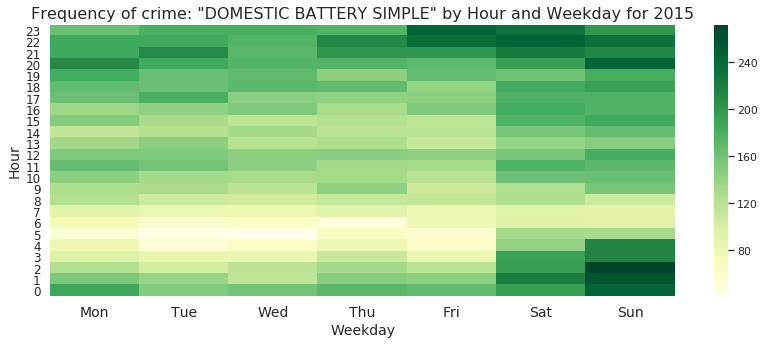

In [31]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Weekday', 'Hour', 2015, figsize=(14,5), col='Description')

ValueError: You are trying to merge on int64 and category columns. If you wish to proceed you should use pd.concat

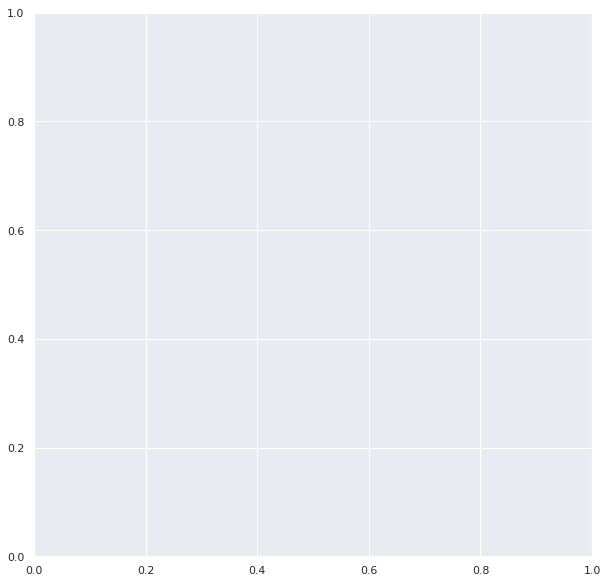

In [33]:
map_counts(chi_crimes, 'DOMESTIC BATTERY SIMPLE', '2016-01-01', '2016-12-31', scale=0.6, figsize=(10,10), col='Description')

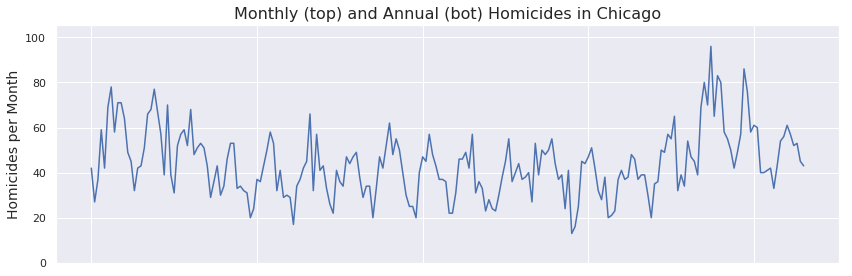

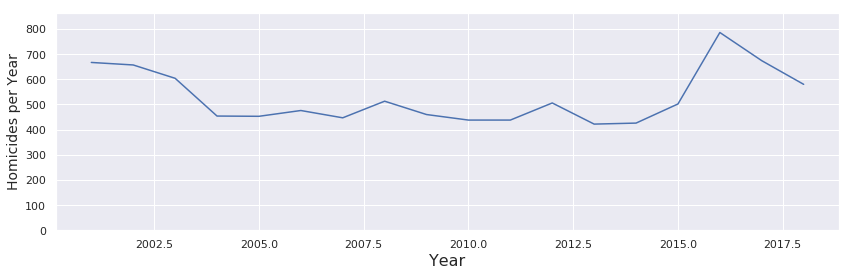

In [19]:
max_year = 2018
df = chi_crimes.loc[chi_crimes['Primary Type'] == 'HOMICIDE'].copy()


df = df[df['Year'] <= max_year]
df.set_index('Date', inplace=True)

fig, ax = plt.subplots(sharex=True, figsize=(12,4))
mo_df = df[['ID']].groupby([df.index.year, df.index.month]).count()
mo_df.plot(ax=ax, kind='line', legend=None)
ax.set_title('Monthly (top) and Annual (bot) Homicides in Chicago', fontsize=16)
ax.set_ylabel('Homicides per Month', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_ylim([0, mo_df['ID'].max() * 1.1])
plt.tight_layout()

fig, ax = plt.subplots(sharex=True, figsize=(12,4))
yr_df = df[['ID']].groupby([df.index.year]).count()
yr_df.plot(ax=ax, legend=None)
ax.set_ylabel('Homicides per Year', fontsize=14)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylim([0, yr_df['ID'].max() * 1.1])
plt.tight_layout()

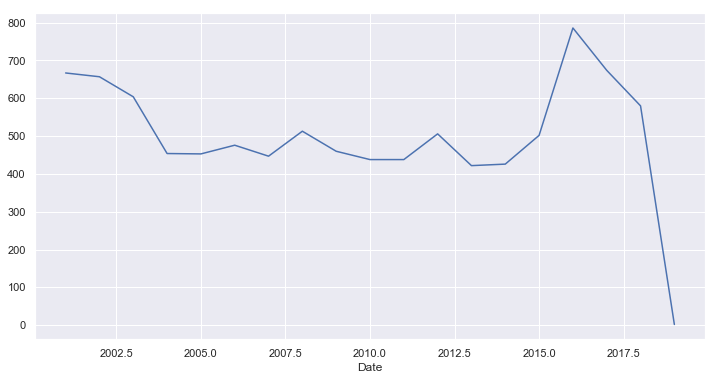

In [83]:
fig, ax = plt.subplots(figsize=(12,6))
tmp = chi_crimes.loc[chi_crimes['Primary Type'] == 'HOMICIDE'].copy()
tmp.set_index('Date', inplace=True)
tmp[['ID']].groupby([tmp.index.year]).count().plot(ax=ax, legend=None)
# plt.show()
# tmp.index.year

In [143]:
non_fatal_shootings = chi_crimes[(chi_crimes['IUCR'].isin(['041A','041B','0450','0451','0480','0481','0488','0489']))].copy()
non_fatal_shootings.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude,Hour,Week,Day,Weekday,Month
0,10000092,HY189866,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,BATTERY,False,False,1111,011,28,25,04B,2015,2018-02-10 15:50:01,41.891399,-87.744385,19,12,77,2,3
29,10000130,HY190003,2015-03-18 21:59:00,086XX S CARPENTER ST,041A,BATTERY,AGGRAVATED: HANDGUN,BATTERY,False,False,613,006,21,71,04B,2015,2018-02-10 15:50:01,41.737129,-87.649728,21,12,77,2,3
48,10000159,HY190043,2015-03-18 23:00:00,057XX N KENMORE AVE,041A,BATTERY,AGGRAVATED: HANDGUN,BATTERY,False,False,2022,020,48,77,04B,2015,2018-02-10 15:50:01,41.986392,-87.656701,23,12,77,2,3
72,10000197,HY190067,2015-03-18 23:20:00,046XX S INDIANA AVE,041A,BATTERY,AGGRAVATED: HANDGUN,BATTERY,False,False,215,002,3,38,04B,2015,2018-02-10 15:50:01,41.810671,-87.621248,23,12,77,2,3
792,10001730,HY191339,2015-03-20 00:25:00,062XX S COTTAGE GROVE AVE,041A,BATTERY,AGGRAVATED: HANDGUN,BATTERY,False,False,313,003,20,42,04B,2015,2018-02-10 15:50:01,41.781499,-87.605956,0,12,79,4,3


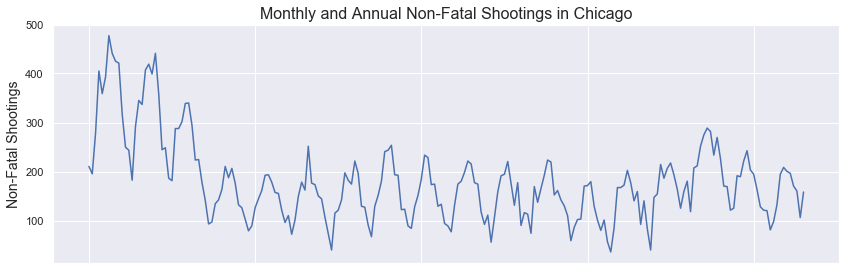

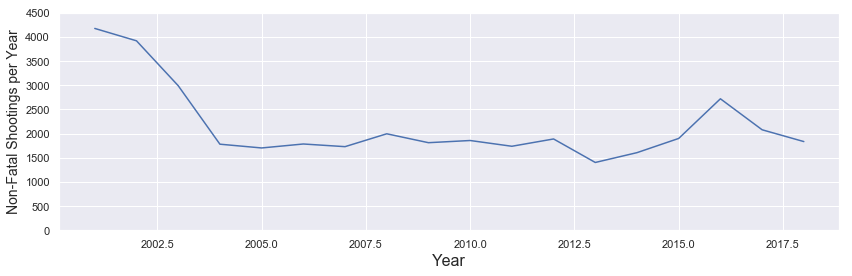

In [148]:
non_fatal_shootings = chi_crimes[(chi_crimes['IUCR'].isin(['041A','041B','0450','0451','0480','0481','0488','0489']))].copy()
df = non_fatal_shootings

fig, ax = plt.subplots(sharex=True, figsize=(12,4))
df = df[df['Year'] < 2019]
df.set_index('Date', inplace=True)

df[['ID']].groupby([df.index.year, df.index.month]).count().plot(ax=ax, kind='line', legend=None)
ax.set_title('Monthly and Annual Non-Fatal Shootings in Chicago', fontsize=16)
ax.set_ylabel('Non-Fatal Shootings', fontsize=14)
ax.set_xlabel('', fontsize=14)
plt.tight_layout()

fig, ax = plt.subplots(sharex=True, figsize=(12,4))
df[['ID']].groupby([df.index.year]).count().plot(ax=ax, legend=None)
ax.set_ylabel('Non-Fatal Shootings per Year', fontsize=14)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylim([0, 4500])
plt.tight_layout()

## Mapping

/home/matthewtriano/.conda/envs/geo_env/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


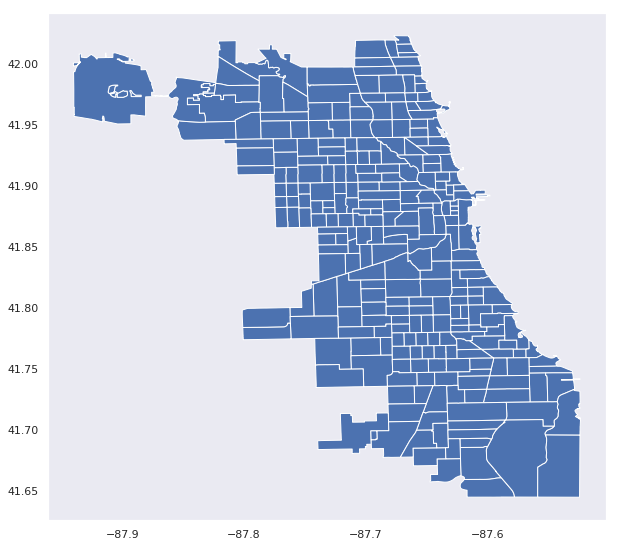

In [33]:
ZIP_SHP_PATH = os.path.join('zip://', 'data', 'Boundaries - Police Beats (current).zip')
beats = gpd.read_file(ZIP_SHP_PATH)
beats['beat_num'] = beats['beat_num'].astype(str)
ax = beats.plot(figsize=(10,10))
ax.grid('off')

In [34]:
beats.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 5 columns):
beat        277 non-null object
beat_num    277 non-null object
district    277 non-null object
sector      277 non-null object
geometry    277 non-null object
dtypes: object(5)
memory usage: 10.9+ KB


In [35]:
chi_crimes['Beat'] = chi_crimes['Beat'].astype(str)

In [36]:
chi_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6784163 entries, 0 to 6784162
Data columns (total 24 columns):
ID                      int64
Case Number             object
Date                    datetime64[ns]
Block                   category
IUCR                    category
Primary Type            category
Description             category
Location Description    category
Arrest                  bool
Domestic                bool
Beat                    object
District                category
Ward                    category
Community Area          category
FBI Code                category
Year                    int64
Updated On              datetime64[ns]
Latitude                float64
Longitude               float64
Hour                    category
Week                    category
Day                     category
Weekday                 category
Month                   category
dtypes: bool(2), category(14), datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 559.4+ 

In [37]:
def map_counts(df_, col_val, start_date='2001-01-01', end_date='2019-01-03', gdf=beats, val='Arrest', col='Primary Type', my_cmap='YlGn', scale=0.6, tight=True, figsize=(10,10)):
    df = df_[(df_['Date'] >= start_date) & (df_['Date'] <= end_date)].copy()
    fig, ax = plt.subplots(figsize=figsize)
    counts = df.pivot_table(index='Beat', values=val, columns=col, aggfunc='count', fill_value=0)[[col_val]]
    map_df = pd.merge(left=gdf, right=counts, right_index=True, left_on='beat_num')
    vmin = map_df[col_val].min()
    vmax = map_df[col_val].max()
    
    base = gdf.plot(figsize=figsize, color='white', edgecolor='black', linewidth=2, ax=ax)
    map_df.plot(column=col_val, ax=base, cmap=my_cmap)
    _ = ax.axis('off')
    _ = ax.set_title('Counts of {} per police beat\nfrom {} to {}'.format(col_val, start_date, end_date),
                     fontdict={'fontsize': '25', 'fontweight':'3'})
    
    sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, shrink=scale)
    if tight:
        plt.tight_layout()

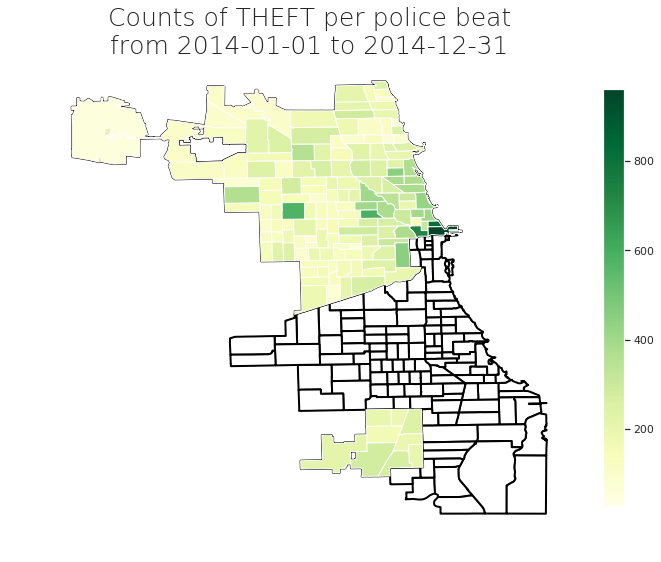

In [39]:
map_counts(chi_crimes, 'THEFT', '2014-01-01', '2014-12-31', scale=0.6, figsize=(10,10))

In [11]:
class GeoSessions:
    def __init__(self):
        self.Arcgis = requests.Session()
        self.Komoot = requests.Session()
        self.USCensus = requests.Session()
        self.OSM = requests.Session()

def create_sessions():
    return GeoSessions()

def geocode_address(address, s):
    g = geocoder.arcgis(address, session=s.Arcgis)
    if (g.ok == False):
        g = geocoder.komoot(address, session=s.Komoot)
    if (g.ok == False):
        g = geocoder.osm(address, session=s.OSM)        
    if (g.ok == False):
        g = geocoder.uscensus(address, session=s.USCensus)
    return g

## Missing Latitude and Longitude Values

As the printouts below show, there are 59445 pairs of Latitude and Longitude values that are missing. While it's a small portion of the total data set, I can't know if it's missing at random (MAR) or missing completely at random (MCAR), so leaving it out might bias the data set. As I can programatically geocode the missing values, this is a solveable problem.

In [37]:
missing_lats = chi_crimes['Latitude'].isnull()
missing_lons = chi_crimes['Longitude'].isnull()
missing_addrs = chi_crimes['Block'].isnull()
print('Number of missing latitude values: {}'.format(missing_lats.sum()))
print('Number of missing longitude values: {}'.format(missing_lons.sum()))
print('Number of missing Address values: {}'.format(missing_addrs.sum()))
print('Number of rows missing both lat and lon values: {}'
      .format(np.array(missing_lats[missing_lats] == missing_lons[missing_lons]).sum()))

Number of missing latitude values: 59445
Number of missing longitude values: 59445
Number of missing Address values: 0
Number of rows missing both lat and lon values: 59445


In [24]:
addrs_df = chi_crimes[missing_lats][['Block']]
addrs_df['Address'] = [x.replace('XX', '00') for x in addrs_df['Block']]
addrs_df['Address'] = [x.replace('0X ', '00 ') for x in addrs_df['Address']]
addrs_df['Address'] = addrs_df['Address'] + ', Chicago, IL'
addrs_df['Latitude'] = np.nan
addrs_df['Longitude'] = np.nan
addrs_df.head()

,Block,Address,Latitude,Longitude
21,0000X E LAKE ST,"00000 E LAKE ST, Chicago, IL",NaN,NaN
125,077XX S GREENWOOD AVE,"07700 S GREENWOOD AVE, Chicago, IL",NaN,NaN
1325,074XX N ROGERS AVE,"07400 N ROGERS AVE, Chicago, IL",NaN,NaN
1539,077XX S ESSEX AVE,"07700 S ESSEX AVE, Chicago, IL",NaN,NaN
1603,111XX S VINCENNES AVE,"11100 S VINCENNES AVE, Chicago, IL",NaN,NaN


In [27]:
addrs_df = addrs_df.drop_duplicates('Address', keep='first').copy()
addrs_df.shape

(21350, 4)

In [294]:
# addrs_df = pd.merge(left=latlon_df, 
#                     right=pd.DataFrame(latlon_df['Address'].unique(), columns=['Address']),
#                     how='left', left_on='Block', right_on='Address')
# addrs_df.drop('Address_y', axis=1, inplace=True)
# addrs_df.columns = ['Block', 'Address'] 
# addrs_df['Latitude'] = np.nan
# addrs_df['Longitude'] = np.nan
# addrs_df.head()

,Block,Address,Latitude,Longitude
0,0000X E LAKE ST,"00000 E LAKE ST, Chicago, IL",NaN,NaN
1,077XX S GREENWOOD AVE,"07700 S GREENWOOD AVE, Chicago, IL",NaN,NaN
2,074XX N ROGERS AVE,"07400 N ROGERS AVE, Chicago, IL",NaN,NaN
3,077XX S ESSEX AVE,"07700 S ESSEX AVE, Chicago, IL",NaN,NaN
4,111XX S VINCENNES AVE,"11100 S VINCENNES AVE, Chicago, IL",NaN,NaN


In [16]:
addrs_df[(addrs_df['Latitude'].isnull())]['Address'].unique()

array(['00000 E LAKE ST, Chicago, IL',
       '07700 S GREENWOOD AVE, Chicago, IL',
       '07400 N ROGERS AVE, Chicago, IL', ...,
       '11800 S WENTWORTH AVE, Chicago, IL',
       '06200 N PAULINA ST, Chicago, IL',
       '04900 N KILDARE AVE, Chicago, IL'], dtype=object)

In [28]:
OUT_PATH = os.path.join('data', 'geocoded_chi_crimes.csv')
if os.path.isfile(OUT_PATH):
    addrs_df = pd.read_csv(OUT_PATH)
    print('It existed')
addrs_df.head()

It existed


,Block,Address,Latitude,Longitude
0,0000X E LAKE ST,"00000 E LAKE ST, Chicago, IL",41.900947,-87.620411
1,077XX S GREENWOOD AVE,"07700 S GREENWOOD AVE, Chicago, IL",41.810638,-87.599286
2,074XX N ROGERS AVE,"07400 N ROGERS AVE, Chicago, IL",42.019914,-87.667048
3,077XX S ESSEX AVE,"07700 S ESSEX AVE, Chicago, IL",42.315241,-87.858772
4,111XX S VINCENNES AVE,"11100 S VINCENNES AVE, Chicago, IL",41.507930,-87.640085


In [18]:
s = create_sessions()

In [19]:
addr = addrs_df['Address'][0]
tmp = geocoder.osm(addr, session=s.OSM)
print(addr)
print('Latitude:  {}'.format(tmp.lat))
print('Longitude: {}'.format(tmp.lng))

00000 E LAKE ST, Chicago, IL
Latitude:  41.8857868
Longitude: -87.6225308


In [20]:
addr = addrs_df['Address'][0]
tmp = geocoder.komoot(addr, session=s.Komoot)
print(addr)
print('Latitude:  {}'.format(tmp.lat))
print('Longitude: {}'.format(tmp.lng))

00000 E LAKE ST, Chicago, IL
Latitude:  41.9009473
Longitude: -87.6204114


In [31]:
failed_inds = []
iterations_between_saves = 100

In [22]:
addrs_df[addrs_df['Latitude'].isnull()][:2501].index.tolist()

[]

In [386]:
missing_latlong_indices = addrs_df[addrs_df['Latitude'].isnull()][:2501].index.tolist()

for i in missing_latlong_indices:
    try:
        if i%iterations_between_saves == 0:
            print('reached index {}, saving df'.format(i))
            addrs_df.to_csv(OUT_PATH, index=False)
        addr = addrs_df['Address'][i]
        tmp = geocode_address(addr, s)
        addrs_df.loc[i,'Latitude'] = tmp.lat
        addrs_df.loc[i,'Longitude'] = tmp.lng
    except Exception as e:
        failed_inds.append(i)
addrs_df.to_csv(OUT_PATH, index=False)

reached index 48500, saving df
reached index 48700, saving df
reached index 49500, saving df
reached index 50700, saving df
reached index 52100, saving df
reached index 52300, saving df
reached index 52800, saving df
reached index 53400, saving df
reached index 54400, saving df
reached index 55400, saving df
reached index 56700, saving df
reached index 57100, saving df
reached index 57600, saving df
reached index 57700, saving df
reached index 57800, saving df
reached index 58400, saving df
reached index 58500, saving df
reached index 58900, saving df


In [29]:
# How many rows are missing Latitude values?
addrs_df['Latitude'].isnull().sum()

0

In [32]:
# how many indices failed to geocode?
failed_inds

[]

In [33]:
chi_crimes['Latitude'].isnull().sum()

59445

In [45]:
addrs_df.head()

,Block,Address,Latitude,Longitude
0,0000X E LAKE ST,"00000 E LAKE ST, Chicago, IL",41.900947,-87.620411
1,077XX S GREENWOOD AVE,"07700 S GREENWOOD AVE, Chicago, IL",41.810638,-87.599286
2,074XX N ROGERS AVE,"07400 N ROGERS AVE, Chicago, IL",42.019914,-87.667048
3,077XX S ESSEX AVE,"07700 S ESSEX AVE, Chicago, IL",42.315241,-87.858772
4,111XX S VINCENNES AVE,"11100 S VINCENNES AVE, Chicago, IL",41.507930,-87.640085


In [47]:
addrs_df.drop('Address', axis=1, inplace=True)
addrs_df.head()

,Block,Latitude,Longitude
0,0000X E LAKE ST,41.900947,-87.620411
1,077XX S GREENWOOD AVE,41.810638,-87.599286
2,074XX N ROGERS AVE,42.019914,-87.667048
3,077XX S ESSEX AVE,42.315241,-87.858772
4,111XX S VINCENNES AVE,41.507930,-87.640085


In [93]:
tmp = chi_crimes[['Block', 'Latitude', 'Longitude']]
tmp1 = pd.merge(left=tmp, right=addrs_df, on='Block', how='left')
tmp1['Latitude'] = tmp1['Latitude_x'].copy()
tmp1['Longitude'] = tmp1['Longitude_x'].copy()
tmp1.loc[tmp1['Latitude'].isnull(), 'Latitude'] = tmp1[tmp1['Latitude'].isnull()]['Latitude_y'].copy()
tmp1.loc[tmp1['Longitude'].isnull(), 'Longitude'] = tmp1[tmp1['Longitude'].isnull()]['Longitude_y'].copy()
tmp1.drop(['Latitude_x', 'Latitude_y', 'Longitude_x', 'Longitude_y'], axis=1, inplace=True)

In [95]:
tmp1['Latitude'].isnull().sum()

0

In [96]:
tmp1['Longitude'].isnull().sum()

0

In [94]:
tmp1.head()

,Block,Latitude,Longitude
0,047XX W OHIO ST,41.891399,-87.744385
1,066XX S MARSHFIELD AVE,41.773372,-87.665319
2,044XX S LAKE PARK AVE,41.813861,-87.596643
3,051XX S MICHIGAN AVE,41.800802,-87.622619
4,047XX W ADAMS ST,41.878065,-87.743354


In [97]:
tmp1.shape

(6673140, 3)

In [51]:
tmp = pd.merge(left=chi_crimes, right=addrs_df, how='left', on='Block')
tmp

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude_x,Longitude_x,Hour,Week,Day,Weekday,Month,Latitude_y,Longitude_y
0,10000092,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,19,12,77,2,3,41.892317,-87.632029
1,10000094,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,23,12,77,2,3,41.773823,-87.665368
2,10000095,2015-03-18 22:45:00,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,08B,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,22,12,77,2,3,NaN,NaN
3,10000096,2015-03-18 22:30:00,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,2.0,3.0,40.0,08B,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,22,12,77,2,3,41.801679,-87.622690
4,10000097,2015-03-18 21:00:00,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,11.0,28.0,25.0,03,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354,21,12,77,2,3,41.878099,-87.742943
5,10000098,2015-03-18 22:00:00,049XX S DREXEL BLVD,0460,BATTERY,SIMPLE,APARTMENT,False,False,223,2.0,4.0,39.0,08B,2015,02/10/2018 03:50:01 PM,41.805443,-87.604284,22,12,77,2,3,41.805799,-87.603927
6,10000099,2015-03-18 23:00:00,070XX S MORGAN ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,733,7.0,17.0,68.0,08B,2015,02/10/2018 03:50:01 PM,41.766403,-87.649296,23,12,77,2,3,41.690312,-87.666716
7,10000100,2015-03-18 21:35:00,042XX S PRAIRIE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,213,2.0,3.0,38.0,08B,2015,02/10/2018 03:50:01 PM,41.817553,-87.619819,21,12,77,2,3,41.818221,-87.619868
8,10000101,2015-03-18 22:09:00,036XX S WOLCOTT AVE,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,912,9.0,11.0,59.0,18,2015,02/10/2018 03:50:01 PM,41.828138,-87.672782,22,12,77,2,3,41.859608,-87.673614
9,10000104,2015-03-18 21:25:00,097XX S PRAIRIE AVE,0460,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,False,511,5.0,6.0,49.0,08B,2015,02/10/2018 03:50:01 PM,41.717455,-87.617663,21,12,77,2,3,41.718042,-87.617721


In [52]:
tmp['Latitude_x'].isnull().sum()

59445

In [53]:
tmp['Latitude_y'].isnull().sum()

1381570

In [407]:
chi_crimes[chi_crimes['Latitude'].isnull()]

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude,Hour,Month,Day,Week,Weekday
1325,4757173,2006-05-22 14:30:00,074XX N ROGERS AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,PARKING LOT/GARAGE(NON.RESID.),False,False,2422,24.0,49.0,1.0,07,2006,08/17/2015 03:03:40 PM,NaN,NaN,14,5,142,21,0
4337,4762432,2002-06-15 00:00:00,029XX S MICHIGAN AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,2112,2.0,2.0,35.0,06,2002,08/17/2015 03:03:40 PM,NaN,NaN,0,6,166,24,5
4761,4763189,2004-07-01 00:00:00,043XX S DREXEL BLVD,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,2123,2.0,4.0,39.0,06,2004,08/17/2015 03:03:40 PM,NaN,NaN,0,7,183,27,3
8233,4768003,2005-08-19 00:01:00,057XX S WABASH AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,233,2.0,20.0,40.0,06,2005,08/17/2015 03:03:40 PM,NaN,NaN,0,8,231,33,4
8385,4768280,2005-03-05 22:20:24,107XX S AVENUE B,0486,BATTERY,DOMESTIC BATTERY SIMPLE,STREET,False,False,432,4.0,10.0,52.0,08B,2005,08/17/2015 03:03:40 PM,NaN,NaN,22,3,64,9,5
8695,4768806,2005-12-29 00:00:00,045XX S CICERO AVE,0810,THEFT,OVER $500,GAS STATION,False,False,814,8.0,23.0,56.0,06,2005,08/17/2015 03:03:40 PM,NaN,NaN,0,12,363,52,3
8805,4768966,2004-06-04 09:00:00,004XX E 88TH ST,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,False,632,6.0,6.0,44.0,26,2004,08/17/2015 03:03:40 PM,NaN,NaN,9,6,156,23,4
9194,4769759,2005-05-26 08:30:00,023XX N PARKSIDE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2515,25.0,37.0,19.0,08B,2005,08/17/2015 03:03:40 PM,NaN,NaN,8,5,146,21,3
9350,4770024,2006-05-30 20:30:00,003XX W 40TH ST,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,925,9.0,11.0,61.0,07,2006,08/17/2015 03:03:40 PM,NaN,NaN,20,5,150,22,1
9737,4770640,2005-05-24 19:45:00,037XX S WABASH AVE,0498,BATTERY,AGGRAVATED DOMESTIC BATTERY: HANDS/FIST/FEET S...,STREET,False,False,211,2.0,3.0,35.0,04B,2005,08/17/2015 03:03:40 PM,NaN,NaN,19,5,144,21,1


In [223]:
chi_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6673140 entries, 0 to 6673139
Data columns (total 23 columns):
ID                      int64
Date                    datetime64[ns]
Block                   object
IUCR                    object
Primary Type            category
Description             category
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Hour                    int64
Month                   int64
Day                     int64
Week                    int64
Weekday                 int64
dtypes: bool(2), category(2), datetime64[ns](1), float64(5), int64(8), object(5)
memory usage: 999.2+ MB


In [229]:
chi_crimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6673140 entries, 0 to 6673139
Data columns (total 23 columns):
ID                      int64
Date                    datetime64[ns]
Block                   object
IUCR                    object
Primary Type            category
Description             category
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Hour                    category
Month                   category
Day                     category
Week                    category
Weekday                 category
dtypes: bool(2), category(7), datetime64[ns](1), float64(5), int64(3), object(5)
memory usage: 782.8+ MB


In [10]:
chi_crimes['Date'].nunique()

2666199

In [11]:
chi_crimes['Date'].isnull().sum()

0

In [12]:
chi_crimes['Primary Type'].nunique()

35

In [13]:
chi_crimes['Primary Type'].unique()

[BATTERY, OTHER OFFENSE, ROBBERY, NARCOTICS, CRIMINAL DAMAGE, ..., NON - CRIMINAL, NON-CRIMINAL, RITUALISM, NON-CRIMINAL (SUBJECT SPECIFIED), DOMESTIC VIOLENCE]
Length: 35
Categories (35, object): [BATTERY, OTHER OFFENSE, ROBBERY, NARCOTICS, ..., NON-CRIMINAL, RITUALISM, NON-CRIMINAL (SUBJECT SPECIFIED), DOMESTIC VIOLENCE]

In [14]:
chi_crimes['Primary Type'].value_counts()

THEFT                                1399665
BATTERY                              1218668
CRIMINAL DAMAGE                       763837
NARCOTICS                             707157
OTHER OFFENSE                         414072
ASSAULT                               412902
BURGLARY                              384632
MOTOR VEHICLE THEFT                   311497
DECEPTIVE PRACTICE                    257010
ROBBERY                               252976
CRIMINAL TRESPASS                     191547
WEAPONS VIOLATION                      69137
PROSTITUTION                           68097
PUBLIC PEACE VIOLATION                 47418
OFFENSE INVOLVING CHILDREN             44670
CRIM SEXUAL ASSAULT                    26565
SEX OFFENSE                            24699
INTERFERENCE WITH PUBLIC OFFICER       14791
GAMBLING                               14362
LIQUOR LAW VIOLATION                   13986
ARSON                                  11043
HOMICIDE                                9256
KIDNAPPING

In [15]:
chi_crimes['Description'].nunique()

380

This data set contains data from all crimes reported to the Chicago Police Department from 2001 to 7 days before I downloaded the data. That's a 17 year span of data, and 6,673,139 separate crime reports. From the printouts above, we see there are 35 primary types of crimes, and 380 unique crime descriptions . From the frequency counts, we see that theft, battery, criminal damage, and narcotics are the most common kind of reports.  The IUCR ([Illinois Uniform Crime Reporting](https://data.cityofchicago.org/Public-Safety/Chicago-Police-Department-Illinois-Uniform-Crime-R/c7ck-438e/data)) numbers correspond to a crime description, and per that link, there are 401 codes in use.

In [16]:
chi_crimes[chi_crimes['Primary Type'] == 'DOMESTIC VIOLENCE']

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude
1879652,1326195,2001-01-11 02:30:41,087XX S ESCANABA AV,9901,DOMESTIC VIOLENCE,DOMESTIC VIOLENCE,APARTMENT,True,True,423,4.0,NaN,NaN,08B,2001,08/17/2015 03:03:40 PM,41.736176,-87.55432


From the lower end of the frequency counts, I suspect some data may have been entered incorrectly; it's extremely unlikely that there has only been 1 domestic violence report in Chicago over 17 years. The IUCR for this domestic assault entry, 9901, is not included in the IUCR list, so I assume it's simply an entry error. I suspect that this should be Battery, Domestic Battery Simple, and 0486 for Primary, Description, and IUCR.

In [17]:
chi_crimes.loc[chi_crimes['Primary Type'] == 'DOMESTIC VIOLENCE', 'Primary Type'] = 'BATTERY'
chi_crimes.loc[chi_crimes['Primary Type'] == 'DOMESTIC VIOLENCE', 'Description'] = 'DOMESTIC BATTERY SIMPLE'
chi_crimes.loc[chi_crimes['Primary Type'] == 'DOMESTIC VIOLENCE', 'IUCR'] = '0486'

In [18]:
crime_counts = chi_crimes['Description'].value_counts()
crime_counts[crime_counts < 20]

REFUSING TO AID AN OFFICER                      19
JUVENILE PIMPING                                18
VIOL CHARITABLE GAME ACT                        16
AIDING ARRESTEE ESCAPE                          15
$300 AND UNDER                                  15
BOLITA OR BOLI PUL/WRITER                       14
FORNICATION                                     13
OVER $300                                       13
LOOTING                                         11
THEFT/RECOVERY: CYCLE, SCOOTER, BIKE NO VIN     11
ARSONIST: ANNUAL REGISTRATION                   11
BOLITA OR BOLI PUL/OFFICE                        9
EMPLOY MINOR                                     9
PATRONIZE JUVENILE PROSTITUTE                    9
ARMED VIOLENCE                                   9
FAILURE TO KEEP HYPO RECORDS                     8
NOTIFICATION OF CIVIL NO CONTACT ORDER           8
UNLAWFUL USE OF BODY ARMOR                       7
COMPELLING CONFESSION                            7
ADULTRY                        

In [19]:
crime_counts = chi_crimes['Primary Type'].value_counts()
most_frequent_crimes = crime_counts[crime_counts > 20000]
most_frequent_crimes

THEFT                         1399665
BATTERY                       1218669
CRIMINAL DAMAGE                763837
NARCOTICS                      707157
OTHER OFFENSE                  414072
ASSAULT                        412902
BURGLARY                       384632
MOTOR VEHICLE THEFT            311497
DECEPTIVE PRACTICE             257010
ROBBERY                        252976
CRIMINAL TRESPASS              191547
WEAPONS VIOLATION               69137
PROSTITUTION                    68097
PUBLIC PEACE VIOLATION          47418
OFFENSE INVOLVING CHILDREN      44670
CRIM SEXUAL ASSAULT             26565
SEX OFFENSE                     24699
Name: Primary Type, dtype: int64

In [20]:
chi_crimes.loc[chi_crimes['Primary Type'].isin(most_frequent_crimes.index.tolist())]

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude
0,10000092,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385
1,10000094,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319
2,10000095,2015-03-18 22:45:00,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,08B,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643
3,10000096,2015-03-18 22:30:00,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,2.0,3.0,40.0,08B,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619
4,10000097,2015-03-18 21:00:00,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,11.0,28.0,25.0,03,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354
5,10000098,2015-03-18 22:00:00,049XX S DREXEL BLVD,0460,BATTERY,SIMPLE,APARTMENT,False,False,223,2.0,4.0,39.0,08B,2015,02/10/2018 03:50:01 PM,41.805443,-87.604284
6,10000099,2015-03-18 23:00:00,070XX S MORGAN ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,733,7.0,17.0,68.0,08B,2015,02/10/2018 03:50:01 PM,41.766403,-87.649296
7,10000100,2015-03-18 21:35:00,042XX S PRAIRIE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,213,2.0,3.0,38.0,08B,2015,02/10/2018 03:50:01 PM,41.817553,-87.619819
8,10000101,2015-03-18 22:09:00,036XX S WOLCOTT AVE,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,STREET,True,False,912,9.0,11.0,59.0,18,2015,02/10/2018 03:50:01 PM,41.828138,-87.672782
9,10000104,2015-03-18 21:25:00,097XX S PRAIRIE AVE,0460,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,False,511,5.0,6.0,49.0,08B,2015,02/10/2018 03:50:01 PM,41.717455,-87.617663


In [21]:
crime_counts = chi_crimes['Description'].value_counts()
most_frequent_crime_descs = crime_counts[crime_counts > 40000]
most_frequent_crime_descs

SIMPLE                            788132
$500 AND UNDER                    539874
DOMESTIC BATTERY SIMPLE           510762
TO VEHICLE                        370882
TO PROPERTY                       351370
OVER $500                         343907
POSS: CANNABIS 30GMS OR LESS      276212
FORCIBLE ENTRY                    261147
AUTOMOBILE                        243893
FROM BUILDING                     223841
RETAIL THEFT                      164462
TELEPHONE THREAT                  133581
POSS: CRACK                       118778
TO LAND                           118705
UNLAWFUL ENTRY                    101610
HARASSMENT BY TELEPHONE            99731
AGGRAVATED: OTHER DANG WEAPON      92432
POSS: HEROIN(WHITE)                91357
ARMED: HANDGUN                     89586
STRONGARM - NO WEAPON              87843
AGGRAVATED: HANDGUN                82760
AGGRAVATED:KNIFE/CUTTING INSTR     55916
CREDIT CARD FRAUD                  51593
SOLICIT ON PUBLIC WAY              47083
UNLAWFUL POSS OF

In [22]:
chi_crimes[chi_crimes['Primary Type'] == 'THEFT']['Description'].value_counts()

$500 AND UNDER                                 539874
OVER $500                                      343907
FROM BUILDING                                  223841
RETAIL THEFT                                   164462
FINANCIAL ID THEFT: OVER $300                   44531
POCKET-PICKING                                  32427
PURSE-SNATCHING                                 16510
FINANCIAL ID THEFT:$300 &UNDER                  15206
ATTEMPT THEFT                                   11064
ATTEMPT FINANCIAL IDENTITY THEFT                 2955
AGG: FINANCIAL ID THEFT                          2901
FROM COIN-OP MACHINE/DEVICE                      1084
DELIVERY CONTAINER THEFT                          874
$300 AND UNDER                                     15
OVER $300                                          13
THEFT RETAIL                                        1
CRIM SEX ABUSE BY FAM MEMBER                        0
CRIMINAL DEFACEMENT                                 0
COUNTERFEITING DOCUMENT     

In [ ]:
chi_crimes[chi_crimes['Description'] == '$500 AND UNDER']

In [ ]:
chi_crimes.pivot_table(index='Description',
                       values='Arrest',
                       columns='Year',
                       fill_value=0,
                       aggfunc='count')

In [ ]:
tmp = chi_crimes[chi_crimes['Description'] == 'DOMESTIC BATTERY SIMPLE'][['Description', 'Date']] 
# tmp['Date'].dt.hour
# tmp.groupby([chi_crimes['Date'].dt.hour, chi_crimes['Date'].dt.day]).agg(['count'])
# desc_tmp = tmp.groupby([pd.Grouper(key='Date', freq='h')]).count().dropna()
# sns.heatmap(desc_tmp)
# desc_tmp.head()
# chi_crimes[chi_crimes['Description'] == 'DOMESTIC BATTERY SIMPLE'].groupby('Date').count()
tmp1 = tmp.groupby('Date').count().resample('h').count()

In [23]:
chi_crimes.head()

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude
0,10000092,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385
1,10000094,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319
2,10000095,2015-03-18 22:45:00,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,08B,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643
3,10000096,2015-03-18 22:30:00,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,2.0,3.0,40.0,08B,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619
4,10000097,2015-03-18 21:00:00,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,11.0,28.0,25.0,03,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354


In [130]:
chi_crimes.head()

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude,Hour,Month,Day,Week,Weekday
0,10000092,2015-03-18 19:44:00,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,1111,11.0,28.0,25.0,04B,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,19,3,77,12,2
1,10000094,2015-03-18 23:00:00,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,725,7.0,15.0,67.0,26,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,23,3,77,12,2
2,10000095,2015-03-18 22:45:00,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,08B,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,22,3,77,12,2
3,10000096,2015-03-18 22:30:00,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,225,2.0,3.0,40.0,08B,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,22,3,77,12,2
4,10000097,2015-03-18 21:00:00,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,1113,11.0,28.0,25.0,03,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354,21,3,77,12,2


In [45]:
tmp = chi_crimes[['Hour', 'Day', 'Month', 'Year', 'Description']]\
            .groupby(['Year', 'Month', 'Day', 'Hour']).count()
tmp.head()

Description
Year Month Day Hour             
2001 1     1   0             413
               1              91
               2              78
               3              71
               4              53

In [205]:
# X and Y labels
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
weeks = np.arange(0,53).tolist()
weekdays = ['Sun', 'Sat', 'Fri', 'Thu', 'Wed', 'Tue', 'Mon']
hours = np.arange(23,-1,-1).tolist()

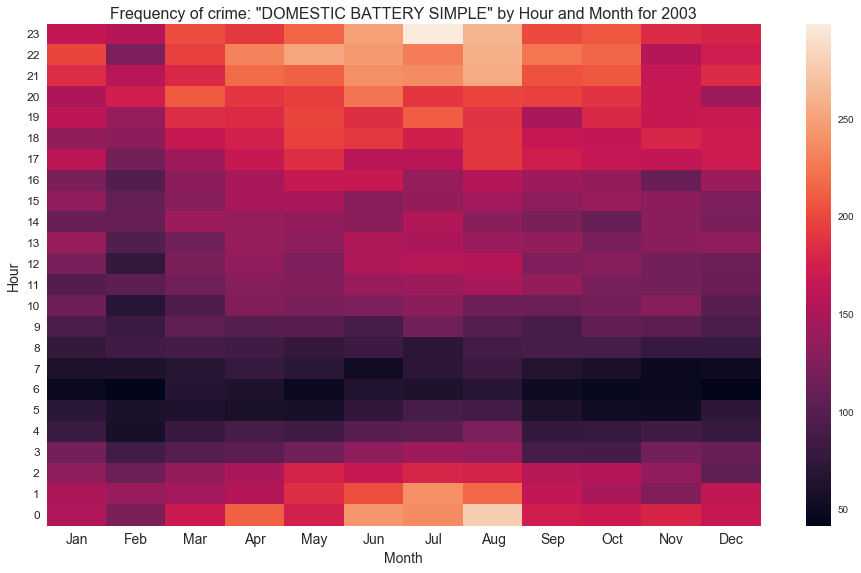

In [207]:
year = 2003
y_ax = 'Hour'
x_ax = 'Month'
x_labs = months
crime_desc = 'DOMESTIC BATTERY SIMPLE'
def plot_crime_freq_heatmap(crime_desc, x_ax, y_ax, x_labs, y_labs, year, df=chi_crimes):
    tmp = df[(df['Description'] == crime_desc) &
                     (df['Year'] == year)][['Description', y_ax, x_ax]] 
    tmp1 = tmp.pivot_table(index=y_ax, columns=x_ax, values='Description', aggfunc=['count'])
    tmp1.sort_index(ascending=False, inplace=True)
    fig, ax = plt.subplots(figsize=(16,9))
    sns.heatmap(tmp1, ax=ax, annot=False, fmt='d')
    ax.xaxis.set_ticklabels(x_labs, fontsize=14)
    ax.yaxis.set_ticklabels(y_labs, fontsize=12, rotation=0)
    ax.set_xlabel(x_ax, fontsize=14)
    ax.set_ylabel(y_ax, fontsize=14)
    ax.set_title('Frequency of crime: "{}" by {} and {} for {}'
                 .format(crime_desc, y_ax, x_ax, year), fontsize=16)
    plt.show()
    
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Month', 'Hour', months, hours, 2003)

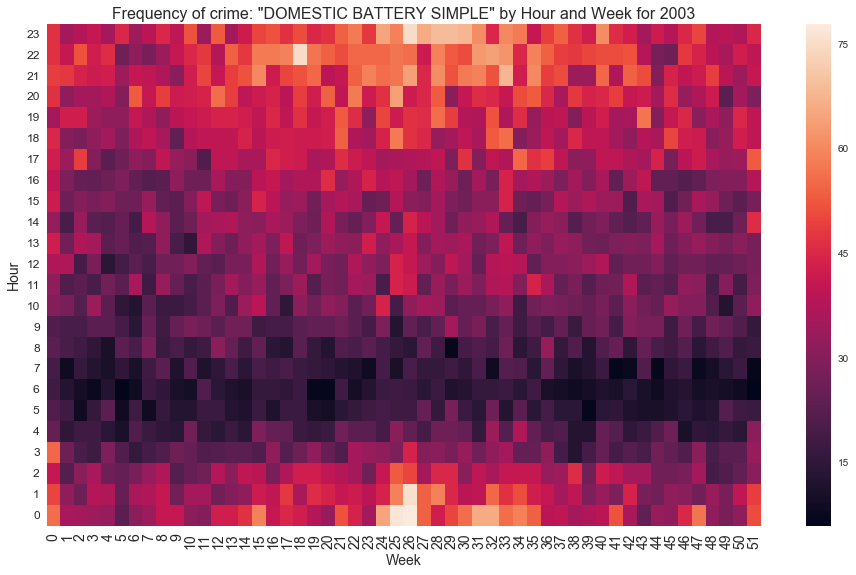

In [208]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Week', 'Hour', weeks, hours, 2003)

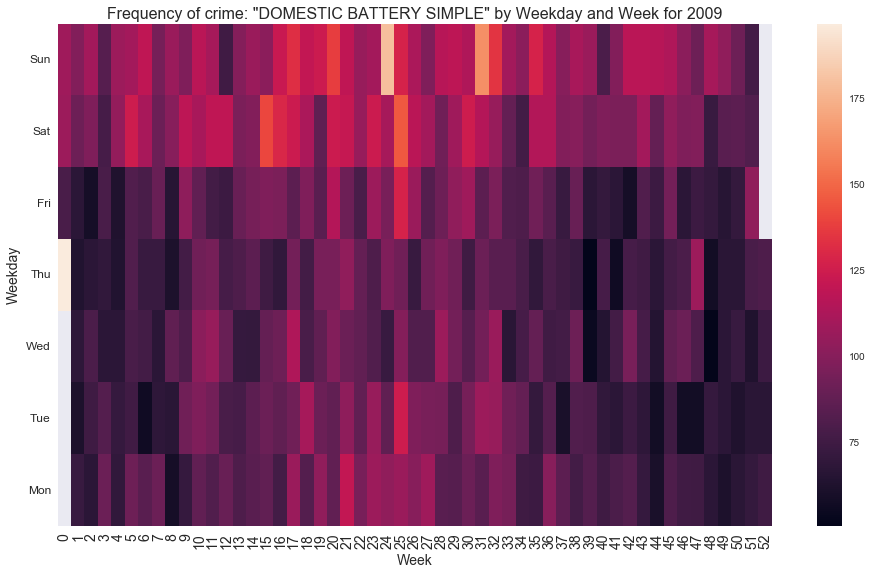

In [209]:
plot_crime_freq_heatmap('DOMESTIC BATTERY SIMPLE', 'Week', 'Weekday', weeks, weekdays, 2009)

In [211]:
chi_map = folium.Map(location=[41.85, -87.6], zoom_start=11)
chi_map

In [214]:
tmp = chi_crimes[(chi_crimes['Description'] == 'DOMESTIC BATTERY SIMPLE') &
                 (chi_crimes['Year'] == 2015) ]
display(tmp.head())
tmp.shape

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Updated On,Latitude,Longitude,Hour,Month,Day,Week,Weekday
2,10000095,2015-03-18 22:45:00,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,222,2.0,4.0,39.0,08B,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,22,3,77,12,2
6,10000099,2015-03-18 23:00:00,070XX S MORGAN ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,733,7.0,17.0,68.0,08B,2015,02/10/2018 03:50:01 PM,41.766403,-87.649296,23,3,77,12,2
7,10000100,2015-03-18 21:35:00,042XX S PRAIRIE AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,213,2.0,3.0,38.0,08B,2015,02/10/2018 03:50:01 PM,41.817553,-87.619819,21,3,77,12,2
25,10000124,2015-03-18 23:30:00,024XX S BELL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1034,10.0,25.0,31.0,08B,2015,02/10/2018 03:50:01 PM,41.848024,-87.682091,23,3,77,12,2
26,10000126,2015-03-18 22:45:00,003XX E 59TH ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,232,2.0,20.0,40.0,08B,2015,02/10/2018 03:50:01 PM,41.787481,-87.618458,22,3,77,12,2


(24614, 23)

In [216]:
from folium.plugins import FastMarkerCluster

In [220]:
tmp['Latitude'].isnull().sum()

43

In [217]:
chi_map = folium.Map(location=[41.85, -87.6], zoom_start=11)
chi_map.add_child(FastMarkerCluster(tmp[['Latitude', 'Longitude']].values.tolist()))
chi_map
# # loop through the 100 crimes and add each to the incidents feature group
# for lat, lng, in zip(tmp.Latitude, tmp.Longitude):
#     incidents.add_child(
#         folium.features.CircleMarker(
#             [lat, lng],
#             radius=1, # define how big you want the circle markers to be
#             color='yellow',
#             fill=True,
#             fill_color='blue',
#             fill_opacity=0.6
#         )
#     )

# # add incidents to map
# chi_map.add_child(incidents)

ValueError: Location values cannot contain NaNs, got:
[[41.81386068, -87.596642837], [41.766402779, -87.649296123], [41.817552577, -87.61981852299999], [41.848024395, -87.68209087700001], [41.787480544, -87.618458018], [41.774499411, -87.60092813600001], [41.752762491, -87.553488733], [41.776797341999995, -87.604098905], [41.767838616999995, -87.59018283200001], [41.884654292, -87.77193778700001], [41.767160003, -87.63512038100001], [41.931993727, -87.71046890299999], [41.754706432, -87.567505523], [41.805166895999996, -87.727180679], [41.748560656, -87.661615335], [41.993281593, -87.709220588], [41.779678598000004, -87.61319547299999], [41.768957248, -87.618564735], [41.897793069, -87.72493180200001], [41.700680418000005, -87.63174238], [41.939898633, -87.754281422], [41.764251916999996, -87.711716396], [41.872963554, -87.753663295], [41.905358915, -87.727523294], [41.851305522, -87.699073778], [41.954232428000005, -87.71292144700001], [41.843228683, -87.734253291], [41.803985100000006, -87.672138992], [41.945851518000005, -87.802094734], [41.892338095, -87.719882059], [41.923258751, -87.70340683399999], [41.721347521, -87.652202769], [41.75335369, -87.58166425200001], [41.780534965, -87.719067965], [41.867324065, -87.697145871], [41.684828563, -87.661026595], [41.843695653000005, -87.711109507], [41.757701370999996, -87.6078153], [41.774680553, -87.69327801], [41.754074591999995, -87.61983668], [41.78210152, -87.586502002], [41.912576915, -87.731301676], [41.802009404, -87.62209620600001], [41.810737392, -87.749353374], [41.86997642, -87.729428901], [41.780534965, -87.719067965], [41.780483067, -87.686122155], [41.800656635, -87.646474686], [41.847361883000005, -87.71976139600001], [41.989334479, -87.674667806], [41.888881151999996, -87.72467482100001], [41.863396806, -87.734883724], [41.898684386, -87.702450956], [41.758560412, -87.56272800299999], [41.809523197, -87.596831923], [41.822281982, -87.606848245], [41.74330766, -87.647152195], [41.821434167, -87.61253702399999], [41.80171934, -87.63070362100001], [41.796713658, -87.695105195], [41.703189832, -87.651530204], [41.682356046, -87.646200374], [41.830697249, -87.61447689100001], [41.87876279, -87.766433586], [41.651862993, -87.610742261], [41.777389879, -87.63498009999999], [41.937751033000005, -87.720656222], [41.755368956, -87.634416245], [41.764956871, -87.598250887], [41.76651363, -87.620138743], [41.873901709, -87.75850151899999], [41.737709752, -87.740958098], [41.899588559, -87.746700581], [41.913654766, -87.70807543], [41.90319914, -87.751931543], [41.826613003, -87.61129017], [41.780610591, -87.66667057299999], [41.784265604, -87.670398327], [41.749799341999996, -87.69550048200001], [41.907288329000004, -87.71520566299999], [41.937680189, -87.64288925], [42.018538263, -87.680456992], [41.947414417, -87.747126165], [41.885223794, -87.66981103299999], [41.947586617, -87.72743611], [41.952743841, -87.79947882299999], [41.984710106, -87.76774199], [41.77295831, -87.57281305299999], [41.991113557, -87.822435716], [41.79374757, -87.624065135], [41.793025004, -87.69012517200001], [41.782056116, -87.670340423], [42.022534349000004, -87.673357342], [41.808418076, -87.619567769], [41.861859676, -87.727489875], [41.772011702, -87.62834447899999], [41.766655655, -87.638388243], [41.947784682, -87.760679785], [41.784477456, -87.65219500299999], [41.765087055, -87.60446978600001], [41.683985599, -87.61425620899999], [41.746698961, -87.60383498], [41.857190995, -87.66173517899999], [41.790361149, -87.729205005], [41.901766615, -87.727505825], [41.945515195, -87.685793691], [41.751896943, -87.64892609299999], [41.805188471, -87.622732254], [41.746762491, -87.660098661], [41.751457646, -87.552892516], [41.837721135, -87.73166616600001], [41.876552273, -87.763379746], [41.939477432, -87.739513391], [41.968906401999995, -87.72071445799999], [41.792895988000005, -87.69011912799999], [41.89036711, -87.626673634], [41.883330195, -87.764964695], [41.882545904000004, -87.730628888], [41.725474489, -87.57542839899999], [41.884703095999996, -87.75522444299999], [41.812909005, -87.691896127], [41.832793820999996, -87.647224682], [41.971180380999996, -87.696334094], [41.765460295, -87.578128667], [41.658018862, -87.60340580399999], [41.747704934, -87.65609080799999], [41.675579908, -87.633406013], [41.701378973000004, -87.611162236], [41.734883985, -87.55966970799999], [41.96266678, -87.73174590200001], [41.961236076, -87.70042977600001], [41.768168435, -87.633525865], [41.792763782, -87.76054721], [41.877652981, -87.748153375], [41.902644676, -87.728008125], [41.772714037, -87.692007143], [41.776510546, -87.681000121], [41.876172139, -87.72615401700001], [41.844324662, -87.718861893], [41.782594026, -87.70401189399999], [41.769858422, -87.57091779999999], [41.723043634, -87.662016704], [41.756746092, -87.606037518], [41.799022932, -87.647709727], [41.884101226, -87.675026325], [41.772152736, -87.66715408], [41.753392323, -87.66472773299999], [41.708296067, -87.625946406], [41.965457044000004, -87.652995284], [41.761720229, -87.592097094], [41.895924738000005, -87.749341944], [41.918436841, -87.768213674], [41.879979654, -87.626145479], [41.807599263, -87.744774926], [41.761383404, -87.65623655600001], [41.708118695, -87.628343483], [41.658448879, -87.644167401], [41.774997184, -87.675006736], [42.019826538000004, -87.668247896], [41.694056267, -87.652845946], [41.762248714, -87.668601722], [41.77586204, -87.756782179], [41.812635420999996, -87.72743307399999], [41.784371218000004, -87.706821484], [41.972682125, -87.792777595], [41.916925023000005, -87.74692028], [41.841929455, -87.722048274], [41.897614515, -87.76230361299999], [41.742991296, -87.632025815], [41.881026176999995, -87.72813142], [41.886340986, -87.71205100799999], [41.940261131999996, -87.727215095], [41.919318064, -87.75723430299999], [41.906709897, -87.760844959], [41.932651078, -87.653178651], [41.989359176, -87.674667551], [41.745575570999996, -87.562494872], [41.7080735, -87.566436848], [41.74618746, -87.66454598], [41.855469505, -87.701734261], [42.021702671, -87.67189385100001], [41.729636179, -87.66166598], [41.900667966, -87.737287118], [41.785161229, -87.620603115], [41.809503342, -87.702798559], [41.745789091999995, -87.60576177200001], [41.776218144, -87.703850594], [41.807219925, -87.72723835299999], [41.931047438, -87.78250845299999], [41.975379436, -87.66315007799999], [41.879279456, -87.76270556], [41.701833324, -87.563215273], [41.873986480999996, -87.630658024], [41.800380772, -87.68543418799999], [41.996472514000004, -87.69959884], [41.969944523, -87.738612725], [41.789641254, -87.671754708], [41.939086945, -87.727799589], [41.835599335, -87.632821118], [41.718823567, -87.643141787], [41.658182943, -87.61332106], [41.925153082, -87.712119231], [41.759283913000004, -87.741709017], [41.859929935, -87.71401371399999], [41.879813477, -87.77138528200001], [41.891730334, -87.756707315], [41.743999390999996, -87.728254687], [41.875041173, -87.743466273], [41.842173288000005, -87.656868125], [41.759850537, -87.60787539200001], [41.856083851, -87.659654455], [41.841487345, -87.658288254], [41.972533409, -87.72572141799999], [41.969383476, -87.710943195], [41.795415045, -87.699463776], [41.769231153, -87.56985482799999], [41.88537469, -87.743742141], [41.957794792, -87.732600568], [41.881864751, -87.706931266], [41.883144871, -87.74398665], [41.750185415, -87.644029945], [41.995804273000005, -87.73619053], [41.770943918, -87.569904169], [41.759850537, -87.60787539200001], [41.896338361, -87.71512026799999], [41.762437557, -87.71114011700001], [41.903438072, -87.734873623], [41.65431533, -87.610129375], [41.69773816, -87.56148455200001], [41.886393351, -87.765080772], [41.912072906, -87.77155798], [41.692012821, -87.65210225700001], [41.882231214, -87.765815373], [41.957794792, -87.732600568], [41.704608346, -87.64641027100001], [41.695306632, -87.624078564], [41.881847601, -87.641772074], [41.872555368, -87.72411008700001], [41.745971061, -87.55521259], [41.779419504, -87.60043219399999], [41.89172837, -87.72287752], [41.785891047, -87.697240236], [41.761288621, -87.66253455], [41.78652376, -87.643758167], [41.828762286999996, -87.614436164], [41.898530871, -87.761707745], [41.879366594000004, -87.75598125100001], [41.744000325, -87.666921174], [41.938145806, -87.680741039], [42.018133553, -87.68652581], [41.775125668, -87.667775881], [41.736543497, -87.545818607], [41.957569002, -87.779379329], [41.756037256, -87.552397235], [41.721649055, -87.62937877200001], [41.854878178, -87.67943354399999], [41.986334537, -87.66602188], [41.795149916, -87.67190709200001], [41.874861396, -87.75397293700001], [41.756967469, -87.584114321], [41.722300037, -87.63216660299999], [41.917636178, -87.736346633], [41.778139616, -87.60588016700001], [41.867163377, -87.718533097], [41.853046995999996, -87.70285558799999], [41.740473717, -87.55271041799999], [41.997133499, -87.807065274], [41.695864114, -87.65319671], [41.865126866, -87.732481285], [41.792178522, -87.667273131], [41.758173399, -87.56271797299999], [41.77015944, -87.618595379], [41.742667712, -87.65352747], [41.778482800999996, -87.67267965799999], [41.777069754, -87.648357886], [41.763236237, -87.559802041], [41.974066268, -87.657754267], [41.943122315, -87.64936593799999], [41.686332268, -87.628921856], [41.68074286, -87.62994924899999], [41.889901283, -87.721954716], [41.799875696, -87.603928993], [41.785118211, -87.618979261], [41.870355187, -87.630550934], [41.677040192, -87.63706901399999], [41.929884549, -87.794212161], [41.839321114, -87.632912639], [41.749027117, -87.60269458200001], [41.867441224000004, -87.625259375], [41.700887365999996, -87.64143310700001], [41.833525580999996, -87.67904180299999], [41.807841109, -87.669810535], [41.921689743, -87.792348371], [41.947586617, -87.72743611], [41.744832196, -87.611118886], [41.766517938, -87.62171857], [41.799569666, -87.73314176299999], [41.779768311, -87.71123292799999], [41.977978764, -87.69899153], [41.654085406, -87.605009043], [41.986215618, -87.70978616200001], [41.740426748000004, -87.737796635], [41.767471672, -87.684541085], [41.732821527, -87.58556004100001], [41.742848789, -87.64751617799999], [41.792035958, -87.723123955], [41.727013682, -87.597324477], [41.75153062, -87.58195304799999], [41.755613227, -87.634420924], [41.884449075999996, -87.670615946], [41.746760439, -87.60141939399999], [41.751407191, -87.59380625200001], [41.8032982, -87.65319504200001], [41.883223117, -87.73734645799999], [41.855906241999996, -87.727274434], [41.892338095, -87.719882059], [41.779220641, -87.649632877], [41.879247055, -87.697005591], [41.806391661999996, -87.64547078700001], [41.675762939, -87.65803519100001], [41.898368769, -87.774491734], [41.749012469, -87.63115407], [41.785268355, -87.61445292399999], [41.796679946, -87.670732486], [41.802194819, -87.60960219399999], [41.84617479999999, -87.69283381700001], [42.005513555, -87.680314231], [41.876108306, -87.68486082700001], [41.693480749, -87.624376894], [41.963193597, -87.743900335], [41.895441878, -87.758065988], [41.777701473, -87.703106505], [41.764171494, -87.59474833600001], [41.878318124, -87.71178722799999], [41.967138395999996, -87.710884153], [41.753652757, -87.55811400799999], [42.005836834, -87.664964508], [41.845450441, -87.70628465799999], [41.900357815, -87.76156288700001], [41.780725757, -87.640678174], [41.802638207, -87.659950522], [41.782193904, -87.664285615], [41.920019126999996, -87.717816554], [41.859972193000004, -87.71523573], [41.767685849, -87.5698145], [41.736260654, -87.59754133], [41.760155874, -87.61938080200001], [41.881088655, -87.720764494], [41.738586479, -87.68868645299999], [41.862916966, -87.709686019], [41.974336965999996, -87.793962469], [41.773396353, -87.64948210600001], [41.789569288, -87.66690044799999], [41.945863902, -87.767912706], [41.746408255, -87.63297436799999], [41.742084508000005, -87.666871364], [41.743841062, -87.612797254], [41.792264444000004, -87.615914925], [41.897713751, -87.775232067], [41.762040311999996, -87.616152735], [41.735980536999996, -87.58518632200001], [42.006895931, -87.67347485299999], [41.777015746, -87.76526645700001], [41.758125035, -87.605376887], [41.709951097, -87.625979535], [41.751452878, -87.62456758100001], [41.93125653, -87.767938829], [41.855004223, -87.72639465], [41.836315211, -87.71701198], [41.796275711, -87.676802366], [41.882364476, -87.667945751], [41.791615495, -87.659666195], [41.799657879, -87.622591648], [41.883209435, -87.764962093], [41.859833239000004, -87.729873086], [41.767813494, -87.66753988200001], [41.901850234, -87.71896819], [41.960186048000004, -87.728618313], [41.894252955, -87.71261709299999], [41.766316323000005, -87.66021317799999], [41.999845135, -87.70459085], [41.855896939000004, -87.718809864], [41.883109020999996, -87.76021841], [41.664165513, -87.641453095], [41.747057814, -87.606330101], [41.753702616999995, -87.652608434], [41.750925109, -87.556516033], [41.819428484, -87.610849941], [41.858442215, -87.707875716], [41.881893185, -87.73860369200001], [41.688129353, -87.633789885], [41.891320624, -87.752189857], [41.694285511, -87.623152439], [41.700931011, -87.612372005], [41.806489442, -87.62276189299999], [41.764843137, -87.67020976], [41.79291993, -87.67305582200001], [41.798290139, -87.67442732399999], [41.76573974, -87.613538315], [41.703469274, -87.56572620200001], [41.867187691999995, -87.71641449200001], [41.860022642, -87.733549594], [41.865627040999996, -87.704424457], [41.917217521, -87.72197330200001], [41.902637251, -87.774171664], [41.873192906999996, -87.74319687399999], [41.945989465, -87.757836019], [41.928195708000004, -87.722728408], [41.735223542, -87.643589082], [41.970747775999996, -87.73056668], [41.748897215, -87.61123090299999], [41.758229489, -87.560038096], [41.760569231999995, -87.65035869799999], [41.777994582, -87.60464627799999], [41.86519446, -87.727586886], [41.753616696, -87.715084428], [41.948459666, -87.780252222], [41.784152641999995, -87.659472993], [41.881756669, -87.686445186], [41.845746866, -87.70629277399999], [41.780854053, -87.661824708], [41.777000866, -87.65200282299999], [41.808729893, -87.610188882], [41.894359878, -87.718720436], [41.964235418, -87.654773202], [41.870355187, -87.630550934], [41.788523444, -87.61582829700001], [41.8009782, -87.65626365799999], [41.781576603000005, -87.615660095], [41.900423771, -87.75500552700001], [41.689590202, -87.541309765], [41.755383848, -87.64049993200001], [41.969321854, -87.72194602100001], [41.776933680999996, -87.59025748399999], [41.702294431999995, -87.56322441799999], [41.876108306, -87.68486082700001], [41.808614751, -87.664091468], [41.717112134000004, -87.532869855], [41.770546841999995, -87.608158126], [41.800721652, -87.651399515], [41.856457549, -87.719982806], [41.757213521, -87.563220575], [41.779073436, -87.615600014], [41.883615447, -87.736799312], [41.79054357, -87.780130326], [41.77979046, -87.64212911899999], [41.78652376, -87.643758167], [41.931711045, -87.778416079], [41.750685943, -87.719209695], [41.761241201, -87.56103555], [41.799124898, -87.653785625], [41.885369529, -87.74434079], [41.83840399, -87.618570436], [41.774790473, -87.690846307], [41.929051854, -87.723234729], [41.76916785, -87.566530745], [41.74673998, -87.605109753], [41.69990711, -87.60623159299999], [41.683938313, -87.72175582], [41.873761627, -87.699545765], [41.877565108, -87.68479102], [41.897299216, -87.767907874], [41.677155375, -87.629845553], [41.85699266, -87.659733015], [41.907050205, -87.663450096], [41.863924999, -87.720043603], [41.883615447, -87.736799312], [41.767581458, -87.684543645], [41.890022694, -87.75875365700001], [41.73624889, -87.56842464200001], [41.890032444, -87.77350667200001], [41.859983323, -87.732327537], [41.857681483, -87.710294852], [41.771650915, -87.57472009600001], [41.88079176, -87.75018480700001], [41.867671357, -87.69593454299999], [41.78653838, -87.685397575], [41.69223831, -87.612146881], [41.70664242, -87.665589539], [41.738914367, -87.64491627299999], [41.854327149, -87.65539295299999], [41.762848843, -87.68477459200001], [41.776151397, -87.64165126700001], [41.694835704, -87.681254881], [41.932258505, -87.64899690600001], [41.754507854, -87.57605079700001], [41.933715324, -87.772408175], [41.721773858, -87.578984755], [41.980208568, -87.79141934100001], [41.731358006, -87.554051765], [41.865026261, -87.71050623200001], [41.799859237, -87.67575355700001], [41.840039085, -87.71955612], [41.92127783, -87.743793883], [41.722807143000004, -87.64203319100001], [41.742480004, -87.654734984], [41.742158621, -87.66687426200001], [41.871011224, -87.757796773], [41.785911721, -87.69601901600001], [41.766068630999996, -87.651715289], [41.683031177, -87.642085705], [41.874583937, -87.709392693], [41.755862783000005, -87.626318576], [41.703469274, -87.56572620200001], [41.906738733000005, -87.763331745], [41.678900938000005, -87.657775427], [41.882179136, -87.74778892399999], [41.883436982, -87.749059068], [41.889961479, -87.76520340100001], [41.788557545, -87.665165501], [41.789906652, -87.658407993], [41.888411942, -87.751691042], [41.793583164, -87.67099541200001], [41.894789245, -87.76978852100001], [41.722417472, -87.536111777], [41.834690813, -87.613705645], [41.704662143, -87.61613523], [41.933150963, -87.71183582], [41.769712137, -87.67365311299999], [41.784702157, -87.722925834], [41.751613643, -87.575373855], [41.875942357, -87.743674625], [41.868165405, -87.62743954], [41.843646793000005, -87.714765309], [41.711363041999995, -87.650246215], [41.939943264, -87.651924995], [41.956381992, -87.750797669], [41.780818819000004, -87.664252246], [41.781901899, -87.594676891], [41.727865294000004, -87.65918598299999], [41.893281677, -87.627596446], [41.810386799, -87.750567036], [41.926203296, -87.735748631], [41.928117008, -87.794157221], [41.737472876999995, -87.61082762299999], [41.749318354, -87.668266062], [41.999311401, -87.70384192200001], [41.874585604, -87.7091944], [41.758193816, -87.56003852399999], [41.724659629, -87.613004281], [41.915881734, -87.711871129], [41.778795964000004, -87.71412037799999], [41.686654673, -87.613194069], [41.702849617, -87.60675872700001], [41.693320271, -87.66917642799999], [41.729712374, -87.653158513], [41.722549895, -87.648109373], [41.885466633, -87.700186607], [41.786482148000005, -87.651037094], [41.871883761999996, -87.704392501], [41.799796042, -87.620972755], [41.749156448, -87.57106752799999], [41.747224829000004, -87.708421379], [41.759945107, -87.574923958], [41.754420779, -87.635089881], [41.914282626, -87.77224402200001], [41.76754789, -87.57633733700001], [41.699274673000005, -87.607337251], [41.750542899, -87.650585924], [41.848914304000004, -87.71857940299999], [41.922419249, -87.78473226700001], [41.784093674, -87.689873451], [41.794623883, -87.704811029], [41.765289945999996, -87.579351285], [41.771043534, -87.62131663], [41.675202918000004, -87.638212564], [41.89765334, -87.75199286799999], [41.879048905, -87.755018365], [41.709590456, -87.62356999], [41.870972237, -87.704313319], [41.694930531, -87.65543276], [41.810647210999996, -87.60439737200001], [41.940231759, -87.732067091], [41.726219145, -87.567294437], [41.782059147, -87.69956600100001], [41.811157495, -87.699191215], [41.993153108, -87.675879153], [41.949493453, -87.769931884], [41.862435382, -87.711970441], [41.839804007, -87.62796417700001], [41.879780694000004, -87.72405615], [41.693879672, -87.61218712899999], [41.764137359, -87.650449151], [41.772943774, -87.679694517], [41.713119419, -87.560978256], [41.8865745, -87.765086511], [41.845347983, -87.70260821299999], [41.758560412, -87.56272800299999], [41.941547086, -87.748164977], [41.788414065, -87.66079977], [41.776151397, -87.64165126700001], [41.894975498, -87.749394667], [41.850530492, -87.714966934], [41.980919411, -87.655110993], [41.688393658, -87.61567891], [41.754576784, -87.57360548700001], [41.776183684, -87.603401956], [41.754004304, -87.553693594], [41.752563264, -87.58333363], [41.823118004, -87.70686581700001], [41.97887761, -87.657883624], [41.788440808000004, -87.652296057], [41.777140394, -87.661716802], [41.708605552, -87.667169656], [41.885569295, -87.652881351], [41.906464136, -87.707939877], [41.788539617, -87.652298678], [41.89621515, -87.72857204799999], [41.829651528, -87.614451899], [41.845159738, -87.725203169], [41.861683877, -87.723827836], [41.930039752, -87.72374716], [41.788654326999996, -87.62231351700001], [41.774548831, -87.629020579], [41.934151848, -87.73810741700001], [41.878317645, -87.74934071], [41.692721180999996, -87.69964921399999], [41.930050104, -87.77714056299999], [41.925007883, -87.643885772], [41.87459188, -87.708834505], [41.913036135, -87.688510174], [41.932391424, -87.725793846], [41.971443547, -87.846539801], [41.86007723, -87.722558261], [41.877880264, -87.733694759], [41.751377296, -87.63553331700001], [41.966299148000004, -87.658045926], [41.875232942, -87.6276188], [41.783522020999996, -87.59312567100001], [41.721347216999995, -87.65215149], [41.750169618, -87.662221556], [41.815001954, -87.688298582], [41.799102301, -87.65136167200001], [41.792770149, -87.76017310799999], [41.837174091, -87.647295325], [41.706859604, -87.64932340200001], [41.789911562, -87.701740163], [41.766305274000004, -87.63717504799999], [41.931045116, -87.78259667399999], [41.800662937, -87.646151874], [41.875250729, -87.726797963], [41.684329976, -87.65185748200001], [41.881738991999995, -87.751358639], [41.655347038, -87.61316236299999], [41.979404783, -87.77261789], [41.943372264000004, -87.748218126], [41.779089899999995, -87.615599831], [41.877017083, -87.731312409], [41.804106469000004, -87.658559743], [41.875469545, -87.70924822100001], [41.906443068, -87.74604638299999], [41.924131161, -87.75444973799999], [41.921325166, -87.779766417], [41.727203706, -87.575474016], [41.785613571, -87.741338682], [41.945681536, -87.78519821200001], [41.843396113000004, -87.73425906899999], [41.911434474, -87.747587752], [41.890836935, -87.71373728799999], [41.691878781, -87.61961641], [41.893153724, -87.746781504], [41.711923377, -87.61390097], [41.899786825999996, -87.716457119], [41.981982677, -87.768361956], [41.67443174, -87.616320857], [41.761512092, -87.605470557], [41.894208531, -87.72482625200001], [41.907122083000004, -87.721570017], [41.989959051999996, -87.74307228200001], [41.847302735, -87.714873231], [41.90618568, -87.77307168600001], [41.895643679, -87.766640604], [41.899881759, -87.724992787], [41.772541609, -87.727484279], [41.892497624, -87.72355701], [41.781500367, -87.614440016], [41.729578029, -87.659234019], [41.777876766999995, -87.770703255], [41.75176863, -87.6513462], [41.73609565, -87.604808666], [41.736740893000004, -87.669165263], [41.756285081, -87.56268192299999], [41.829651528, -87.614451899], [41.673471851, -87.63695373799999], [41.814835811, -87.69195393700001], [41.886807703, -87.763413465], [41.886039903000004, -87.624521539], [41.943743409, -87.707748453], [41.935262024000004, -87.79805897799999], [41.903444485, -87.73452458700001], [41.780564856999995, -87.676357691], [41.753204151, -87.73040747], [41.790311227, -87.619112289], [41.899602051, -87.72866865399999], [41.885364685, -87.73649292], [41.914781622, -87.713454309], [41.908430535, -87.638509526], [41.763455518, -87.573332145], [41.897806122, -87.744277949], [41.662651313000005, -87.64019938700001], [41.761233449, -87.613951544], [41.878796866, -87.731600482], [41.984012031999995, -87.774250985], [41.996352275, -87.68494749799999], [41.897649233, -87.754439191], [41.854739667, -87.70777597799999], [41.845157343000004, -87.725269253], [41.836860039, -87.726045031], [41.78954568, -87.60341173399999], [41.7963606, -87.67437374299999], [41.785678771, -87.68625690399999], [41.773536673, -87.62999581], [41.872823407, -87.72601314299999], [41.772129368, -87.620285495], [41.805542327, -87.650303066], [41.775722112, -87.61551273299999], [41.87579865, -87.751548394], [41.76779358, -87.65661636799999], [41.920918854, -87.75850963100001], [41.765025476, -87.576275351], [41.756655606, -87.562688485], [42.005919796, -87.66366116100001], [41.924520553, -87.723641691], [41.886946961, -87.698908655], [41.819192605, -87.62675232299999], [41.784226755, -87.659475884], [41.76465218, -87.66378244100001], [41.780277113000004, -87.68366774399999], [41.751329969000004, -87.601030331], [41.867436116, -87.702035022], [41.768427306999996, -87.614120446], [41.751204496, -87.565007496], [41.84650556, -87.691127559], [41.745785995, -87.68645608899999], [41.865443417, -87.733715535], [41.899238335999996, -87.75447626399999], [41.743989648, -87.6608495], [41.762273330999996, -87.657766653], [41.744888894, -87.60748686], [41.921771477, -87.727911891], [41.684868785, -87.65805713299999], [41.740789609000004, -87.65104467100001], [41.704570471, -87.5654238], [41.869335009000004, -87.68672096799999], [41.900855485, -87.725420665], [41.993388726999996, -87.65831878899999], [41.76560805, -87.69182865799999], [41.703663843, -87.564453166], [41.916949549, -87.74474125], [41.778435506, -87.686065751], [41.928044486, -87.662201542], [41.724634503000004, -87.62752922700001], [41.867127946, -87.72114743899999], [41.932354458, -87.67240250299999], [41.673207966, -87.61767410899999], [41.762689871999996, -87.651626426], [41.968302904, -87.76504470299999], [41.863461031, -87.65231550899999], [41.984301039, -87.658035951], [41.920170137, -87.698675203], [41.957867498, -87.64853547700001], [42.015789076, -87.806587666], [41.878560668, -87.74802391799999], [41.778528826999995, -87.686068479], [41.730207208, -87.60841417799999], [41.732355870999996, -87.656534167], [41.764035186, -87.66622272299999], [41.740623924, -87.652259253], [41.878367594000004, -87.763102904], [41.743277298, -87.64942437299999], [41.688200651, -87.619499636], [41.909614875, -87.747016581], [41.758071621999996, -87.634790084], [41.931640316999996, -87.738527673], [41.925974924, -87.80265286], [41.841776015, -87.70983997], [42.006420601, -87.68153753700001], [41.681369564, -87.71050496299999], [41.801893026, -87.69280188], [41.677325876, -87.616577916], [41.724799975, -87.626322214], [41.879637902, -87.73605415600001], [41.810062676, -87.616607709], [41.688756095, -87.62100190299999], [41.791516918, -87.649945934], [41.810062676, -87.616607709], [41.876369338, -87.71324181700001], [41.933441724, -87.774828825], [41.71119548, -87.603353891], [41.866217696, -87.72182062799999], [41.850048585, -87.671818997], [41.824824859, -87.613654705], [41.828762286999996, -87.614436164], [41.733686278, -87.55502382], [41.811045072, -87.71125319], [41.704700641, -87.620558604], [41.867033277, -87.72865991799999], [41.826700394, -87.63383906600001], [41.991332957, -87.65825590600001], [41.651431329, -87.527258234], [41.924466007, -87.728375145], [41.734845567, -87.559670169], [41.858362383, -87.671116619], [41.988608173, -87.69375475], [41.965893163000004, -87.66936438399999], [41.872672629, -87.72656164899999], [41.72162985, -87.593558035], [41.786246977, -87.668023875], [41.769889866999996, -87.637264595], [41.989547243000004, -87.660253739], [41.72878869, -87.557200414], [41.776726463, -87.69698984799999], [41.693717745, -87.61218527700001], [41.748458232, -87.605159961], [41.708118695, -87.628343483], [41.776425255, -87.59610721700001], [41.938584005, -87.765793802], [41.781536719, -87.613233346], [41.909611175, -87.674463035], [41.730000924, -87.602708728], [41.763724903, -87.57132763700001], [41.912831524, -87.64202186600001], [41.79002675, -87.64626181700001], [41.897027463, -87.772369376], [41.683991503, -87.659146276], [41.876891619, -87.741492127], [42.011336783000004, -87.692007414], [41.733161758, -87.551333481], [41.863825778, -87.719449822], [41.72811844, -87.626417713], [41.696776756, -87.653454394], [41.845983257, -87.73150067700001], [41.894060434000004, -87.772266788], [41.978707459, -87.657881744], [41.744092095, -87.665710996], [41.866517316999996, -87.695178701], [41.925593163, -87.63991079899999], [41.947551755, -87.683427818], [41.882164833000004, -87.770729386], [41.87102983, -87.676368411], [41.728754754, -87.594941678], [41.882164833000004, -87.770729386], [41.776726463, -87.69698984799999], [41.73599838, -87.648794475], [41.730491416999996, -87.65124891], [41.75423558, -87.64716774799999], [41.745391006999995, -87.59412814], [41.876952748, -87.73633619299999], [41.974363533, -87.735603868], [41.911794189, -87.77405133799999], [42.01309486, -87.688898777], [41.994703388000005, -87.70075310200001], [41.907365758000005, -87.708217622], [41.886496266, -87.69978716], [41.885444215999996, -87.70209647600001], [41.728303998, -87.639754224], [41.781330865, -87.613228316], [41.791542491, -87.658449505], [41.893842795, -87.770972164], [41.933635812, -87.780913211], [41.91320867, -87.75164599], [41.764416722, -87.643008921], [41.865443417, -87.733715535], [41.895675136, -87.628569146], [41.880962061999995, -87.706962115], [41.768025996999995, -87.620180643], [41.92456497, -87.77330777799999], [41.83746784, -87.648693994], [41.910272522, -87.691418265], [41.884767539, -87.757673329], [41.990165734, -87.706985123], [41.801025281, -87.652621265], [41.974516857, -87.728203275], [41.722429119000005, -87.560716591], [41.897616364, -87.762123615], [41.698175453000005, -87.69988128799999], [41.903591885, -87.688270928], [41.896787129, -87.751100826], [41.879248965, -87.696855018], [41.975303081999996, -87.76277226], [41.928199574000004, -87.72242335799999], [41.884105872, -87.674879385], [41.736783409000004, -87.559723854], [41.830869115, -87.63702998], [41.692160546, -87.659002399], [41.684205036, -87.668003495], [41.683405863000004, -87.63056090100001], [41.768050909, -87.637218492], [41.784038775999996, -87.68499008200001], [41.780426744, -87.689774455], [41.987261997, -87.666008515], [41.899247932, -87.75202983], [41.766517938, -87.62171857], [41.756933215, -87.58728499], [41.959650214, -87.760588266], [41.88903432, -87.75538371399999], [41.786073858, -87.65345412299999], [41.784324739, -87.67161136899999], [41.93180115, -87.726262505], [41.939355367, -87.704226118], [41.810467472, -87.621243351], [41.734904858, -87.545776341], [41.902154925, -87.764805126], [41.870975935, -87.70398651299999], [41.899499292, -87.72376589299999], [41.866096186, -87.730500724], [41.887727215, -87.713646145], [41.878310696, -87.699383314], [41.71323499, -87.537693946], [41.752203875999996, -87.600360737], [41.852823404, -87.71015847299999], [41.76502302, -87.720905754], [41.957915284, -87.715488729], [41.761758115999996, -87.583556445], [41.725547014, -87.565683257], [41.763543955, -87.63392066899999], [41.779657699, -87.73011574200001], [41.846465069000004, -87.694199895], [41.770924136, -87.575205219], [41.895547498, -87.658486918], [41.805378224, -87.717381928], [41.792342253, -87.624025622], [41.906812044, -87.757126335], [42.02223302, -87.66727331], [41.798995903000005, -87.653783321], [41.891700115, -87.665535033], [41.764734720999996, -87.633427556], [41.868234232, -87.70495328700001], [41.878030398, -87.72157583200001], [41.886675966999995, -87.763410964], [41.901487820999996, -87.70674685700001], [41.787650639, -87.648633945], [41.766418656999996, -87.63596051], [41.821434535, -87.61259572], [41.775089656, -87.68596741399999], [41.820890532, -87.627518759], [41.743395837, -87.568541357], [41.656413759, -87.609535041], [41.770695366999995, -87.582576242], [41.806592556999995, -87.63329858899999], [41.764887502, -87.665550436], [41.835721987, -87.62507703200001], [41.704644751, -87.608987035], [41.929580133, -87.756965579], [41.841980239, -87.711063738], [41.912831524, -87.64202186600001], [41.75045535, -87.627022901], [41.847193386, -87.718529815], [41.83719701, -87.650219779], [41.992169859, -87.673343732], [41.883013245, -87.68493423], [41.673548279, -87.616795523], [41.815464075, -87.699834724], [41.791519971999996, -87.65602216799999], [41.780388308, -87.68489119799999], [41.768779119, -87.71358254299999], [41.780839438, -87.699838328], [41.795652442, -87.619247355], [41.940076135, -87.64247379700001], [41.821454488, -87.61096657899999], [41.890032444, -87.77350667200001], [41.752147383, -87.60398951299999], [41.807067906, -87.60384374700001], [41.911910115, -87.70920932799999], [41.797739321, -87.617680221], [41.935517178000005, -87.76882369299999], [41.925955467, -87.757057001], [41.89137048, -87.74688229200001], [41.85253631, -87.72831931], [41.95419786, -87.758471715], [41.783066328000004, -87.612086936], [41.749633994, -87.66827379799999], [41.777968521, -87.60833482299999], [41.704824688, -87.60273016], [41.78884639, -87.71173186799999], [41.93277883, -87.789950375], [41.967487166, -87.745287476], [41.782776466, -87.776567219], [41.906534833, -87.75711780700001], [41.906196978000004, -87.732952285], [41.721763044, -87.560834461], [41.865223316999995, -87.657506294], [41.945569998, -87.719243356], [41.773888475999996, -87.636840097], [41.793614467, -87.634136585], [41.764887502, -87.665550436], [41.880658831, -87.731336981], [41.655848698, -87.59576404], [41.694080108, -87.65085018399999], [41.74927985, -87.65977186], [41.852991449, -87.68208086899999], [41.793935909, -87.62568027799999], [41.748739429000004, -87.60147387200001], [41.75599681, -87.618265094], [41.968963976, -87.73422392], [41.847302735, -87.714873231], [41.868354554, -87.725266086], [42.006420601, -87.68153753700001], [41.742858775, -87.724809994], [41.974145845, -87.656355981], [41.881713034, -87.75327943], [41.901270271, -87.761837592], [41.964693890999996, -87.70897019600001], [41.752762491, -87.553488733], [41.752357112, -87.59429376], [41.772996751, -87.572816265], [41.840214329, -87.715899312], [41.840809745, -87.651821775], [41.740069909, -87.562406829], [41.694930531, -87.65543276], [41.924985663, -87.762331531], [41.86703119, -87.728784764], [41.925590043, -87.715797043], [41.839759538, -87.72685799899999], [41.865191954000004, -87.660109531], [41.910049472, -87.712236304], [41.946014747, -87.755766272], [41.783217299, -87.61209257700001], [41.79763606, -87.60388104299999], [41.806277621999996, -87.61386232], [41.751154754, -87.56865815200001], [41.780839438, -87.699838328], [41.720311535, -87.569903042], [41.77337941, -87.62272419899999], [41.901766615, -87.727505825], [41.780610591, -87.66667057299999], [41.776937286, -87.66171158799999], [41.86698321, -87.710560665], [41.753129063, -87.65865782], [41.74219391, -87.54300507399999], [41.687891386, -87.643454201], [41.926859236, -87.757239956], [41.689780772, -87.667872821], [41.771518132, -87.583336484], [41.812037642, -87.641980619], [41.798673505, -87.69271658299999], [42.013931854, -87.66490919799999], [41.750772110999996, -87.62453842299999], [41.822176699, -87.60064187], [41.898317476, -87.705102899], [41.956266704, -87.71053775], [41.911096315, -87.703405194], [41.996420966, -87.689839568], [41.993558695, -87.655495503], [41.759774748000005, -87.64232563], [41.764286775, -87.580796229], [41.786557348, -87.61739758600001], [41.702645135, -87.619673136], [41.752736907, -87.579674125], [41.80622723, -87.66976850200001], [41.943300737, -87.73592717], [41.782376914000004, -87.592585199], [41.881197451, -87.76653692], [41.873843341, -87.763308349], [41.883652575, -87.739196978], [41.78259685, -87.661854189], [41.930614356, -87.747676911], [41.967259009, -87.65514927299999], [41.760160651999996, -87.700247007], [41.864102036, -87.655833034], [41.86982616, -87.723842281], [41.860061733, -87.723773492], [41.893644967, -87.76534705600001], [41.871640121, -87.696038308], [41.932401685, -87.749997922], [41.911200009, -87.76592990200001], [41.882277183, -87.76235573299999], [41.705589725, -87.674341966], [41.678038836, -87.621786325], [41.65460049, -87.613148723], [41.976860947, -87.84210742399999], [41.658182943, -87.61332106], [41.877074789, -87.726633839], [41.779291588, -87.61318513799999], [41.890901983, -87.62618661399999], [41.793870956, -87.650313315], [41.711229962, -87.56939521700001], [41.823386598, -87.651393874], [41.799224883, -87.585511041], [41.783494359, -87.638342105], [41.757576262, -87.557583], [41.791820566, -87.696583886], [41.904209414, -87.666190815], [41.757576262, -87.557583], [41.849010974, -87.7015005], [41.886015621, -87.722505905], [42.012985502, -87.68168025700001], [41.766418904, -87.652935891], [41.775378785, -87.66410715399999], [41.860226807, -87.717678135], [41.763433017, -87.57532640000001], [41.77430183, -87.613083318], [41.951426762, -87.809639779], [41.887282942, -87.756912573], [41.787385916, -87.691182578], [41.727823465, -87.58419294299999], [41.952360948, -87.67690878799999], [41.911391615999996, -87.769172251], [41.925590043, -87.715797043], [41.805858503, -87.673407144], [41.77672742, -87.70064136399999], [41.747128743000005, -87.600216921], [41.874093029, -87.70592399200001], [41.772500833, -87.64291124799999], [41.766382176, -87.65414959200001], [41.993558695, -87.655495503], [41.790180516999996, -87.642615225], [41.895904259, -87.731032218], [41.902579875, -87.73186579], [41.751270583, -87.60593808200001], [41.823625136, -87.69826839299999], [41.881047766, -87.771818798], [41.760297611, -87.564785411], [41.771973328, -87.683747876], [41.779393124, -87.668263375], [41.765263223000005, -87.58365492600001], [41.677162328, -87.61940199600001], [41.770715684, -87.57397595299999], [41.751591784, -87.66468045200001], [41.937231827, -87.746826163], [41.922189226, -87.72181560899999], [41.92436229, -87.73687555], [41.991012071, -87.698200016], [41.845548807, -87.70872432600001], [41.860003433, -87.733549773], [41.808095168, -87.65644181299999], [41.716769015, -87.659016263], [41.962497769, -87.751668525], [41.752623326999995, -87.702475991], [41.870867709, -87.713860414], [41.872682377, -87.71399343], [41.777503445, -87.61555886100001], [41.916454981, -87.738764229], [41.899329027, -87.771632959], [41.731102964, -87.56221364299999], [41.869862615, -87.720893713], [41.921262115, -87.745010272], [41.695160708, -87.63882888], [41.712625227, -87.602052164], [41.829805381999996, -87.692365919], [41.764778969, -87.58852468100001], [41.88360569, -87.707634031], [41.762853860999996, -87.649205529], [41.770695046, -87.608160122], [41.948068465, -87.643126381], [41.698154484, -87.70105690700001], [41.812455339, -87.70414519299999], [41.69917703, -87.60838927799999], [41.732579046, -87.581624411], [41.876556522, -87.76313002], [41.64792426, -87.61414877799999], [41.811030085, -87.69550965399999], [41.883292033000004, -87.73161706299999], [41.910903528, -87.690897602], [41.916024183000005, -87.727745765], [41.874888946, -87.727924953], [41.738707301999995, -87.667998162], [41.698989663, -87.646235716], [41.879860127, -87.77138487299999], [41.771289601999996, -87.607574218], [41.783479097, -87.60964771], [41.79908307, -87.651358209], [41.775509784, -87.649536644], [41.820265788, -87.61483570600001], [41.937799190999996, -87.765245774], [41.775248061999996, -87.671385727], [41.856022994, -87.722376594], [41.679205982, -87.61661562399999], [41.839264217, -87.653588646], [41.872848316, -87.69914356], [41.772833915, -87.70175742299999], [41.781540907, -87.61565682700001], [41.783963356, -87.68621548700001], [41.968472035, -87.706337225], [41.751029258, -87.550834472], [41.752762491, -87.553488733], [41.906860965, -87.735032685], [41.909932385, -87.75934664399999], [41.799297464, -87.674457347], [41.800369801, -87.690319457], [41.813161345, -87.696805418], [41.702938712, -87.619662566], [41.878318124, -87.71178722799999], [41.76631395, -87.56861379200001], [41.869902022, -87.718510527], [41.783480098000005, -87.73634243], [41.889537273, -87.749025517], [41.727470074, -87.60824712700001], [41.760392356, -87.68180481200001], [41.871988552, -87.694540494], [41.751998339000004, -87.655382354], [42.018691928, -87.68045542], [41.751539633, -87.661855469], [41.88173662, -87.751432105], [41.877655426, -87.74809460200001], [41.774839102, -87.67137526799999], [41.913181395, -87.69584934], [41.697129896, -87.62424527600001], [41.855870568, -87.72727477], [41.767036006, -87.582809521], [41.754443091999995, -87.566288239], [41.747420231, -87.556455681], [41.756476826, -87.552872024], [41.924194231, -87.677859023], [42.018222741, -87.66473546200001], [41.890049339, -87.628998255], [41.908041077, -87.765866033], [41.937886801, -87.74557787299999], [41.900900205999996, -87.756977457], [41.75193817, -87.55091505200001], [41.801662958, -87.731977933], [41.729633491, -87.549855923], [41.777864359, -87.61315344399999], [41.716377191999996, -87.549668988], [41.748215146999996, -87.63181138600001], [41.940966508, -87.723091759], [41.785970964, -87.692362714], [41.702258734000004, -87.563221182], [41.921912654, -87.664812223], [41.87177688, -87.714013186], [41.83368122, -87.612439993], [41.94595442, -87.65307402299999], [41.793726584, -87.627787526], [41.826839246999995, -87.631408649], [41.832791866, -87.6473568], [41.890006326, -87.712379085], [41.875971051, -87.74125093399999], [41.876192545, -87.72430687299999], [41.776799626999995, -87.686016209], [41.755931648, -87.657367707], [41.901140314, -87.693001098], [41.912792481, -87.701948321], [41.752332872, -87.600362934], [41.691855733000004, -87.53834190799999], [41.962418505, -87.669279126], [41.935126102, -87.806645511], [41.753079426999996, -87.664719985], [41.912966144, -87.68973063799999], [41.762507383, -87.57686941899999], [41.727096769, -87.60303470299999], [41.786207285, -87.65467006700001], [41.778802358, -87.71377935], [41.86606099, -87.71053290200001], [41.859716869, -87.72498083200001], [41.763263853000005, -87.59699831299999], [41.738707301999995, -87.667998162], [41.770812178, -87.569902065], [41.705211124, -87.60394527], [41.968208915, -87.65336313600001], [41.864283997, -87.72926954299999], [41.889859831, -87.754193677], [41.907369746, -87.70794205899999], [41.843922218, -87.6269207], [41.862899676, -87.71105183899999], [41.771196545, -87.668846609], [41.754219273000004, -87.578487681], [41.764016976, -87.607535223], [41.752178427, -87.608896308], [41.877565688000004, -87.68489382899999], [41.755613227, -87.634420924], [41.964507841999996, -87.650733039], [41.863782878, -87.7165647], [41.703993471, -87.565730953], [41.744507322, -87.65600715299999], [41.748541632, -87.66258664700001], [41.754362364, -87.60404140000001], [41.989359176, -87.674667551], [41.755957881, -87.657162192], [41.820528474, -87.68724157], [41.685943145, -87.60827426700001], [41.715711946999996, -87.641845514], [41.702536113, -87.62913686], [41.861947352, -87.723832676], [41.892174073, -87.682604862], [41.746242343, -87.664545411], [41.793386661999996, -87.63413172700001], [41.719270034000004, -87.63708587200001], [41.743841062, -87.612797254], [41.761324418, -87.557908051], [41.930813696, -87.689080855], [41.900940461, -87.76560933], [41.690209699, -87.618206966], [41.88607742, -87.768348371], [41.68685371, -87.71474652299999], [41.88407329, -87.72210208899999], [41.72055152, -87.53891138], [41.836600771, -87.61677038], [41.798449691, -87.70737385299999], [41.863456762, -87.652521138], [41.789714475, -87.77439503299999], [41.938491426, -87.826354985], [41.778601769, -87.605189348], [41.925239808, -87.717009391], [41.874558082, -87.693718132], [41.800233416, -87.58910448700001], [41.879691121, -87.731529667], [41.782361757, -87.684944646], [41.764490723, -87.63708103399999], [41.787633336, -87.64619570299999], [41.77019486, -87.623422859], [41.706987456, -87.62024402899999], [41.871450654, -87.719699971], [41.891851825, -87.725976161], [41.777959213, -87.70859237399999], [41.657322325, -87.6065205], [41.865850099999996, -87.65909302600001], [41.778508181, -87.68484048], [41.816801035, -87.692011367], [41.814324761, -87.61972962700001], [41.664764882, -87.629431473], [41.723526528, -87.629885774], [41.817635766, -87.62305689899999], [41.945209135, -87.817082771], [41.836069707, -87.613033345], [41.951141583, -87.82930965799999], [41.757651399000004, -87.609029009], [41.789802157, -87.675401652], [41.812559138000005, -87.74818500100001], [41.945488251, -87.72554086299999], [41.764921463, -87.662899917], [41.914467414, -87.69814018], [41.897575142, -87.75443986], [41.880906519, -87.766528475], [41.89132081, -87.752226583], [41.925106738000004, -87.752548461], [41.961342740999996, -87.72783893399999], [41.820497972, -87.68475084], [41.75858693, -87.605078455], [41.760489745, -87.564790449], [41.760412801, -87.561499974], [41.910088708, -87.708844994], [41.703957798000005, -87.565731377], [41.784815392, -87.637605509], [41.760948626, -87.630899336], [41.669885118, -87.62842040700001], [41.747046585999996, -87.612387634], [41.873953515, -87.75406558600001], [41.780481648, -87.68977757299999], [41.937952351999996, -87.737002531], [41.897466157, -87.766701627], [41.706374894, -87.616182114], [41.88534469, -87.71000044700001], [41.895363905, -87.726390989], [41.980875696, -87.65653847200001], [41.673359296, -87.636947631], [41.744940618, -87.66015800299999], [41.74952854, -87.598698111], [41.752624597, -87.578451393], [41.937237975, -87.651086409], [41.806734010999996, -87.67008604700001], [41.756164455, -87.552538628], [41.851118266, -87.71863905], [41.949160645, -87.744621475], [41.884718864, -87.62791470399999], [41.781476851, -87.60721003399999], [41.810688089, -87.603920053], [41.911966231, -87.75942027100001], [41.899734447, -87.665870075], [41.806046461, -87.663681723], [41.893563609, -87.72275353100001], [41.747808979, -87.65002490100001], [41.788523444, -87.61582829700001], [41.766923387, -87.651006106], [41.747453576999995, -87.57833607799999], [41.863467021, -87.651937318], [41.882179136, -87.74778892399999], [41.895410034, -87.721637726], [41.933812673, -87.776056774], [41.89053763, -87.71983685], [41.76476512, -87.677655207], [41.754059141, -87.659084202], [41.768760082, -87.588815879], [41.774296905, -87.67972843700001], [41.735818981, -87.66117289299999], [41.890668766, -87.757892127], [41.921347675, -87.759751425], [41.677059401, -87.637068807], [41.760847671, -87.630097741], [41.924584288, -87.71861049600001], [41.806837117, -87.619526631], [41.967595626, -87.65965384], [41.91074006, -87.632455702], [41.756313677, -87.57731232399999], [41.683637708, -87.624074936], [41.883774705, -87.75396953799999], [41.745702038000005, -87.55035316600001], [41.793100386, -87.65970565299999], [41.883271242, -87.733413002], [41.797936811, -87.60630177700001], [41.744942861999995, -87.602579658], [41.92943054, -87.767719759], [41.726269511, -87.604571673], [41.702778712, -87.634260984], [41.899247932, -87.75202983], [41.901331765, -87.75330393600001], [41.829618102, -87.67526195299999], [41.71998479, -87.576514873], [41.73841774, -87.561166174], [41.684513438, -87.634876084], [41.903354658000005, -87.666912357], [41.758154366, -87.593215676], [41.746823018, -87.60262796200001], [41.775750654, -87.771411071], [41.81012918, -87.690937143], [41.781498301, -87.613233776], [41.753819454, -87.644126664], [41.728849951, -87.58547421700001], [41.78162165, -87.608411], [41.814908482, -87.59741952600001], [41.682957717, -87.66871190799999], [41.751704411999995, -87.56836577799999], [42.02059812, -87.666436575], [41.824375997, -87.644738992], [41.897305479, -87.75320814], [41.750519353, -87.611271358], [41.843629517, -87.726964584], [41.737508058, -87.612934], [41.765475299, -87.624413268], [42.001822361, -87.689987495], [41.86302287, -87.71966675600001], [41.944227362, -87.752867515], [41.972219146, -87.657707594], [41.751407191, -87.59380625200001], [41.801193098, -87.677698409], [41.761470034, -87.593302195], [41.76618374, -87.672354986], [41.926518461, -87.764849772], [41.91181399, -87.756967459], [41.751599475999996, -87.650127627], [41.749423563, -87.60722323], [41.735756892, -87.603321307], [41.717612292, -87.620496532], [41.79275784, -87.591625921], [41.796939201, -87.703651531], [41.675093129000004, -87.638210085], [41.912966144, -87.68973063799999], [41.749513961999995, -87.59985263600001], [41.899764983000004, -87.73726245700001], [41.994852802, -87.701972945], [41.784829101999996, -87.62059212700001], [41.76370284, -87.69912355], [41.931831562, -87.723715399], [41.856503806999996, -87.668617665], [41.691609719, -87.612124612], [41.914510925, -87.726481495], [41.817805252, -87.70188437200001], [41.728282651, -87.67916563700001], [41.889582108, -87.626649232], [41.76350826, -87.63617529700001], [41.786291714, -87.664386014], [41.761131195, -87.58843125], [41.855896939000004, -87.718809864], [41.787510694, -87.61669028700001], [41.881864891, -87.70695697], [41.871866921999995, -87.706834295], [41.969751126999995, -87.75609980799999], [41.967058721, -87.73512795], [41.785088771999995, -87.61207160200001], [41.822888346999996, -87.61996474], [41.750018786, -87.646450406], [41.842002544, -87.720829166], [41.770866209, -87.60571674], [41.82703524, -87.633846428], [41.768159703, -87.645714401], [41.787651399, -87.700948315], [41.894777588000004, -87.77076929799999], [41.750036801, -87.629475485], [41.902934844, -87.726311945], [41.781473686, -87.60109076200001], [41.958435683000005, -87.711744612], [41.950757779, -87.704261055], [41.712153975999996, -87.623622364], [41.702121748, -87.560802278], [41.815164878000004, -87.666371044], [41.95110815, -87.7006035], [41.837744867, -87.634093111], [41.8399056, -87.72076842799999], [42.012937018, -87.68620681200001], [41.877363835, -87.701856542], [41.964667917, -87.72147574600001], [41.865510330999996, -87.717833038], [41.850701221, -87.712531806], [41.751484728, -87.661852377], [41.880859384000004, -87.621956894], [41.757106437, -87.64906132899999], [41.892376532, -87.71988536399999], [41.877556848000005, -87.75572581600001], [41.763564409000004, -87.565358553], [41.777244966, -87.69646412], [41.761109411999996, -87.644308897], [41.695839712, -87.655569676], [41.783347545, -87.713896925], [41.684059681, -87.625304031], [41.751861269, -87.64892647200001], [41.869771149, -87.770599426], [41.839264217, -87.653588646], [41.88031156, -87.699936386], [41.913488637, -87.763146775], [41.758896441, -87.574456169], [41.656895921, -87.553197238], [41.97023945, -87.71140923], [41.865619065, -87.71661680700001], [41.899538211, -87.678015733], [41.735981119, -87.650044037], [41.796572431, -87.684104637], [41.932078023, -87.762588011], [41.888250404000004, -87.767697543], [41.905330555, -87.63958275], [41.880517444, -87.710991098], [41.891107664, -87.76391146200001], [41.879517271, -87.696246466], [41.880186804000004, -87.74940447700001], [41.823319195, -87.699518824], [41.856220811, -87.712695002], [41.794286803, -87.62606513899999], [41.767449799, -87.686989966], [41.79972165, -87.64937099], [41.743445021999996, -87.60137277], [41.876951168000005, -87.736560195], [41.880778039, -87.750184931], [41.889184811, -87.716268995], [41.810391681999995, -87.60391608], [41.762577764, -87.64296265600001], [41.771044125, -87.621411936], [41.983128581, -87.76589859100001], [41.73027362, -87.60416372700001], [41.9328146, -87.723312801], [41.877882222, -87.73354419], [41.810391681999995, -87.60391608], [41.750519353, -87.611271358], [41.880778039, -87.750184931], [41.733720071, -87.55231958], [41.893108301999995, -87.751879825], [41.765957128000004, -87.65049949899999], [41.890813098, -87.721060899], [41.852873532, -87.691357505], [41.865177163, -87.730035767], [41.902728773, -87.769318311], [41.749015615, -87.60390769600001], [41.928055525, -87.77950979200001], [41.798272897, -87.68782457200001], [41.715960005999996, -87.620463512], [41.710768654, -87.597103289], [41.658143623, -87.597578556], [41.656469322, -87.614891712], [41.708034859, -87.63800548799999], [41.720468727, -87.657677225], [41.773482275999996, -87.573613382], [41.759355486, -87.55812601], [41.879214143, -87.699987616], [42.014443488000005, -87.68619154], [41.885470603, -87.699911137], [41.793435216, -87.70876482], [41.904656098000004, -87.73374183], [41.752563264, -87.58333363], [41.799266223000004, -87.61609355600001], [42.011845389, -87.67233819799999], [41.716053830999996, -87.56971169200001], [41.883365032, -87.752728335], [41.93465688, -87.78611587200001], [41.803943306, -87.66727966799999], [41.938886819000004, -87.74258788600001], [41.678925873000004, -87.637121901], [41.911762479000004, -87.75818766100001], [41.851148452, -87.71863876100001], [41.92389676, -87.771344032], [41.763658026, -87.565405087], [41.752721371, -87.573565065], [41.964184623, -87.734426806], [41.914560781, -87.68392428799999], [41.77278508, -87.575252959], [41.750976479, -87.62385820200001], [41.749565839, -87.722218051], [41.792425502, -87.617537644], [41.950511126, -87.649599424], [41.935549113, -87.64262924100001], [41.814672853000005, -87.706680332], [41.88817016, -87.629547745], [41.654269377, -87.617254407], [41.719025257, -87.5352856], [41.883460361, -87.76023363200001], [41.671877072, -87.636901383], [41.814268332, -87.63465666299999], [41.780946398000005, -87.62199536899999], [41.747420231, -87.556455681], [41.882361702, -87.75566051], [41.76623457, -87.656574103], [41.901007188, -87.752068973], [41.842709067, -87.626890005], [41.950170829, -87.715945838], [41.955111755, -87.677582753], [41.721347216999995, -87.65215149], [41.749809638, -87.574390964], [41.879782639, -87.72390557700001], [41.750422009, -87.60152438899999], [41.702851783, -87.60666715299999], [41.911197719, -87.76602176899999], [41.875163857, -87.73377155700001], [41.962947477, -87.71383333200001], [41.811136484, -87.70285223799999], [41.929846247, -87.708678047], [41.777047071999995, -87.661714109], [41.74254638, -87.66323898799999], [41.871037347, -87.684934113], [41.942133665, -87.813005545], [41.703858986, -87.565728891], [41.701811034, -87.56398454200001], [41.861990637, -87.71041821799999], [41.963303333, -87.782006424], [41.987339096, -87.786441042], [41.751249089, -87.607312599], [41.805227026, -87.723504961], [41.942598803, -87.737624535], [41.933826441, -87.722134453], [42.006422625999996, -87.78136200799999], [41.877646737, -87.665516126], [41.911954331, -87.76309062600001], [41.881191750999996, -87.75876300700001], [41.714978305, -87.655976647], [41.747740175, -87.668231048], [41.74719631, -87.60263838700001], [41.906210351, -87.76580142700001], [41.879548773, -87.714555054], [41.900755066, -87.731886588], [41.896070388000005, -87.72610147799999], [41.875162416, -87.734021254], [41.692587367, -87.622804979], [41.773747666, -87.649489372], [41.91887475, -87.77189147899999], [41.79054357, -87.780130326], [41.725422723, -87.57299294], [41.789687891, -87.632866498], [42.016541612, -87.672499325], [41.771709781999995, -87.62833678700001], [41.755314051, -87.634413175], [41.825560414, -87.667829811], [41.818647053, -87.685983816], [41.844538907, -87.703196029], [41.863935243, -87.721449563], [41.699838940999996, -87.62609036399999], [41.800838638, -87.652615905], [41.88233367, -87.62784179100001], [41.808635197, -87.60562328600001], [41.969751126999995, -87.75609980799999], [41.877061025, -87.693751926], [42.011475373, -87.67098792200001], [41.785161229, -87.620603115], [41.771709046999995, -87.651864534], [41.755627244, -87.645382738], [41.806121706, -87.670979986], [41.74275965, -87.547867915], [41.747255523, -87.557666952], [41.932930738, -87.636207661], [41.97069816, -87.710981879], [41.772853124, -87.701757234], [41.82348095, -87.705486458], [41.764396026, -87.652880289], [41.828111291999996, -87.67522601799999], [41.829651528, -87.614451899], [41.937808906, -87.75509789], [41.845197778, -87.61885082100001], [41.908961638, -87.68230948700001], [41.68621653, -87.623936782], [41.767581458, -87.684543645], [41.714665567, -87.680655255], [41.847361883000005, -87.71976139600001], [41.699393643, -87.61843478600001], [41.878531497, -87.75038161299999], [41.712561416999996, -87.566991483], [41.79406603, -87.662460592], [41.657201287, -87.601717077], [41.750695403, -87.60395097899999], [41.855752784, -87.73253966899999], [41.876108306, -87.68486082700001], [41.840565491999996, -87.62684018700001], [41.876108306, -87.68486082700001], [41.781576603000005, -87.615660095], [41.870226255, -87.748000824], [41.750301545999996, -87.564996275], [41.851487242, -87.72869624200001], [41.902351209, -87.672774463], [41.762322805, -87.66860095700001], [41.699967289, -87.616685406], [41.849069873000005, -87.623711271], [41.950921507, -87.83421172], [41.745079376, -87.60506255899999], [41.810478653000004, -87.61818402600001], [41.776018543, -87.615520426], [41.790501505, -87.60613644700001], [41.738939871999996, -87.64734525600001], [41.756022358, -87.64950898], [41.73863255, -87.67407387799999], [41.928842189, -87.74404028], [41.922872847, -87.769600256], [41.732640118, -87.580473306], [41.752824025, -87.583341589], [41.885709862, -87.76560096700001], [41.869867211, -87.770602255], [41.763081915, -87.611574041], [41.696161516, -87.628767009], [41.818166098, -87.700134596], [41.810768872, -87.746913779], [41.789984045, -87.660842031], [41.909746301999995, -87.73683529200001], [41.897158446999995, -87.728956167], [41.752921007, -87.57845525], [41.671683017, -87.63930091700001], [41.911205289, -87.70026663200001], [41.823580183000004, -87.700565545], [41.77348517, -87.573221086], [41.792342253, -87.624025622], [41.779503192, -87.662179772], [41.987195147, -87.789064865], [41.931391665, -87.757033797], [41.757554765, -87.588337002], [41.753068233, -87.563830848], [41.773775349, -87.642648291], [41.756883113, -87.670892779], [41.896331896, -87.723663785], [41.877597172, -87.68221298799999], [42.021531238, -87.670717958], [41.95788092, -87.75580252200001], [41.765070557, -87.614044305], [41.906853096999996, -87.75220330200001], [41.946020981, -87.75536922100001], [41.891024801, -87.66267000299999], [41.810928642, -87.693060344], [41.736922044, -87.55141976600001], [41.765306435, -87.579354758], [41.763955788000004, -87.689341606], [41.778730518, -87.684849239], [41.857754174, -87.668916736], [41.906725671, -87.75960680700001], [41.867868979, -87.627431787], [41.677801758, -87.642756643], [41.955192116999996, -87.751558492], [41.738087606, -87.672844688], [41.865659093000005, -87.72515212], [41.743085926999996, -87.600145655], [41.863278754, -87.731199007], [41.866682104, -87.77417302200001], [41.683318728, -87.61294205799999], [41.925160356999996, -87.66739468600001], [41.939870180999996, -87.722315651], [41.896432823000005, -87.710763143], [41.93678811, -87.71610066], [41.763421985, -87.706453515], [41.896815442, -87.61859164], [41.881833031, -87.74396932799999], [41.763257355, -87.599413895], [42.007961462, -87.662719889], [41.886530514, -87.697047165], [41.776568173, -87.680999537], [41.765620989, -87.61957680299999], [41.934329371, -87.73688559799999], [41.980919411, -87.655110993], [41.894268798, -87.708958726], [41.76240870000001, -87.67589782600001], [41.945495169000004, -87.7951099], [41.914701942, -87.69589299399999], [41.755132649000004, -87.590626288], [41.752690858, -87.57600985299999], [41.792087974, -87.62774315600001], [41.75702248, -87.558073456], [41.947225886, -87.655545441], [41.910962378, -87.69455985200001], [41.902754811, -87.75578529200001], [41.781691798000004, -87.61083374299999], [41.873878284, -87.76040369100001], [41.945960218, -87.76021824899999], [41.873986480999996, -87.630658024], [41.845282042, -87.71725623799999], [41.740532922, -87.655898691], [41.880085608, -87.67202338], [41.770374317, -87.62182258200001], [41.747514446, -87.575909455], [41.889393149, -87.632534851], [41.926994386, -87.72440086600001], [41.757494439, -87.619908754], [41.727543644, -87.60382826], [41.833219973, -87.72427042], [41.741507749, -87.645375909], [41.753069968, -87.55552998600001], [41.925635493, -87.63738214799999], [41.767998165, -87.65176451200001], [41.883960232, -87.728217573], [41.886930148000005, -87.73147275], [41.655903283, -87.598716488], [41.855740782, -87.726083018], [41.906824344, -87.716697958], [41.855875955, -87.723626035], [41.878796866, -87.731600482], [41.848460495, -87.681565274], [41.742331781, -87.55273554799999], [41.74248055, -87.548791037], [41.726269511, -87.604571673], [41.884495939000004, -87.62602590200001], [41.721331773, -87.65325056299999], [41.777126328, -87.66542348600001], [41.782492024, -87.653363635], [41.859829266999995, -87.630269741], [41.755368956, -87.634416245], [41.773087476, -87.608936023], [41.858261802, -87.717656604], [41.78521545, -87.711180273], [41.893563238, -87.722683751], [41.751677013000005, -87.65255654100001], [41.673612778, -87.63575529200001], [41.722417472, -87.536111777], [41.734842718, -87.552756625], [41.785891645999996, -87.654662395], [41.685658069, -87.668698762], [41.746679753, -87.60383519700001], [41.861292471999995, -87.666240648], [41.68296349, -87.63814368700001], [41.989532092, -87.674673125], [41.957937495, -87.75124675], [41.884271835, -87.76227187200001], [41.819125753, -87.631514903], [41.87695313, -87.73640962799999], [41.78956349, -87.677816925], [41.79473381, -87.620244031], [41.773124406, -87.659188846], [41.863998697, -87.719455511], [41.757006863, -87.638415381], [41.890054815999996, -87.765209919], [41.849031391, -87.702718844], [41.883045397, -87.682855405], [41.76946214, -87.6712216], [41.729293532, -87.60844276799999], [41.850881580999996, -87.700325909], [41.947165876, -87.657935435], [41.777309867, -87.640802922], [41.791770600999996, -87.645091743], [41.934125624, -87.72214629700001], [41.75598315, -87.65214820000001], [41.90317518, -87.678165888], [41.680665036, -87.645658272], [41.867211105, -87.64290275100001], [41.911803368, -87.76308462200001], [41.898333269, -87.62750777], [41.883051507, -87.682480773], [41.680389587, -87.64686557899999], [41.747708205, -87.561315035], [41.78769009, -87.698509504], [41.723763301, -87.61142447700001], [41.886544212, -87.76340479], [41.878860159, -87.72641866200001], [41.824845241999995, -87.623101964], [41.796899161999995, -87.686565791], [41.751861269, -87.64892647200001], [41.815854232, -87.59811670299999], [41.856398383, -87.709507085], [41.815604689000004, -87.62300597299999], [41.985656459, -87.831398891], [41.725802777, -87.598078281], [41.766909391999995, -87.62333445], [41.722388948, -87.581552712], [41.790894592, -87.604940233], [41.759742877, -87.57922196700001], [41.749843615, -87.68283864799999], [41.93896681, -87.795727148], [41.700406145, -87.56319568299999], [41.903077492, -87.683673325], [41.839870054, -87.735374548], [41.907054444, -87.72278296299999], [41.961322957, -87.687938986], [41.956875793, -87.763341074], [41.724341097, -87.659101939], [41.985534486999995, -87.660126814], [41.76916785, -87.566530745], [41.76382602, -87.672291214], [41.769022335, -87.620206266], [41.870512309, -87.740636761], [41.752530825, -87.591865668], [41.88728285, -87.756894211], [41.943695084, -87.74533706700001], [41.836600771, -87.61677038], [41.763421985, -87.706453515], [41.953714644, -87.72332677], [41.753322686, -87.710949624], [42.016183372, -87.684260347], [41.733375458000005, -87.616057702], [41.708242575999996, -87.639226455], [41.679683697, -87.640364408], [41.711692453000005, -87.605556745], [41.686347238, -87.613182853], [41.829255956, -87.69078998100001], [41.732562947, -87.56467281799999], [41.796339429, -87.606268489], [41.863598470999996, -87.62246398299999], [41.83605962, -87.723109598], [41.773135639, -87.71027421299999], [41.893850689000004, -87.754337597], [41.892242076, -87.748824572], [41.764260248, -87.66622772299999], [41.771743249000004, -87.647006852], [41.777309867, -87.640802922], [41.706819558, -87.616195483], [41.907153315, -87.639680572], [41.777128147, -87.650791627], [41.785604659, -87.68625398200001], [41.795209638, -87.685761315], [41.758466395999996, -87.653943517], [41.808026195, -87.641638614], [41.896122606999995, -87.716334443], [41.879632152, -87.736531579], [41.879689031, -87.73165453700001], [41.727505902, -87.606099983], [41.735752731, -87.603530194], [41.896364554, -87.72000514], [41.86710024, -87.723677264], [41.695227607, -87.66115631], [41.760550693, -87.59032557200001], [41.769199365, -87.62264569700001], [41.882945387, -87.769852213], [41.878303042, -87.699985596], [41.736938745, -87.545828434], [41.953401434, -87.748571238], [41.776411783, -87.70063346799999], [41.768697158, -87.724947107], [41.924655924, -87.71254296299999], [41.750954875, -87.563793789], [41.805924564, -87.675834584], [41.743117929, -87.660078106], [41.866289097, -87.772928201], [41.918212991, -87.71569180600001], [41.948068465, -87.643126381], [41.720060742, -87.553803664], [41.698767354, -87.707737274], [41.720756166, -87.627428812], [41.741278111999996, -87.600682867], [41.792064843, -87.632932296], [41.802059097, -87.61904785799999], [41.745689819, -87.57222251700001], [41.762074211, -87.692959799], [41.786632327, -87.615779716], [41.89430185, -87.724829039], [41.929109028, -87.71087915700001], [41.855179655, -87.702922738], [41.862391181999996, -87.73412217399999], [41.907153315, -87.639680572], [41.722141573, -87.55107150399999], [41.656915248000004, -87.60854871299999], [41.699245987, -87.61719874], [41.878860159, -87.72641866200001], [41.80302567, -87.677591702], [41.74275965, -87.547867915], [41.906605031, -87.69366284600001], [41.843407176, -87.730603649], [41.938401926, -87.77964815600001], [41.890062195, -87.707001763], [41.903569345, -87.72694144], [41.791950089000004, -87.800760135], [41.782642067, -87.636272391], [41.768228760999996, -87.68984872899999], [41.779881706, -87.63678991299999], [41.897343704, -87.710724912], [41.77498586, -87.670174948], [41.953201166999996, -87.765531798], [41.871025008000004, -87.69943695100001], [41.993102287, -87.678991755], [41.893606982, -87.71802613700001], [42.019883291, -87.66715062799999], [41.983395808000004, -87.768334751], [41.761711431, -87.60791674200001], [41.978288009, -87.809835339], [41.788502528, -87.669877985], [41.755248891, -87.663557665], [41.906226161, -87.76455961200001], [41.749574714, -87.557704997], [41.731217225, -87.549895296], [41.859818912, -87.718889785], [41.793842185, -87.620286919], [41.812057708000005, -87.68543757799999], [41.811447374000004, -87.667488051], [41.806054609, -87.67219473799999], [41.878045359, -87.706035885], [41.777561671, -87.731279251], [41.892657733, -87.715008849], [41.899338219, -87.642035188], [41.864033702, -87.71779213299999], [41.811436318, -87.695523965], [41.80241057, -87.668454519], [41.803912696, -87.664844608], [41.846135368, -87.72133659999999], [41.779033998, -87.69889918700001], [41.86514149, -87.73003610299999], [41.785743149, -87.66679707200001], [41.732376443, -87.654903621], [41.922785648, -87.715835109], [41.938924589, -87.739801531], [41.75048339, -87.599101334], [41.893869916, -87.754341096], [41.9036575, -87.723895321], [41.923188761, -87.732855482], [41.787385916, -87.691182578], [41.898013081, -87.718836006], [41.792248930999996, -87.62402298399999], [41.7506766, -87.589460977], [41.825801238000004, -87.60615538100001], [41.800843576, -87.62261888799999], [41.909304522, -87.77167042399999], [41.736649912, -87.554181981], [41.816792881, -87.60806218299999], [41.771108209, -87.573989653], [41.847347637, -87.70144346299999], [41.769576934, -87.721115381], [41.849943661, -87.705939808], [41.7433302, -87.600150204], [41.765512432, -87.578128055], [41.803850337, -87.66970867], [41.699861886, -87.62402485], [41.893983593, -87.634677382], [41.988368471, -87.65533354899999], [41.893657859, -87.763517851], [41.895441878, -87.758065988], [41.751081503, -87.548033994], [41.770876501, -87.58257779600001], [41.769701163, -87.64695163799999], [41.988220457, -87.658156374], [41.883124265999996, -87.773320938], [41.883121009, -87.746293055], [41.989243623, -87.665119726], [41.883144607, -87.743935241], [41.875290139, -87.72387482200001], [41.894143418, -87.767924691], [41.873934561999995, -87.755751088], [41.993102287, -87.678991755], [41.713498808000004, -87.639367687], [41.948401737, -87.712047955], [41.800104799, -87.693974958], [41.972101049, -87.65489933200001], [42.021148015, -87.669934375], [41.874225203, -87.735854874], [41.771568224, -87.62673634299999], [41.960973629, -87.768485078], [41.827602072, -87.674002088], [41.961618975, -87.726622984], [41.867662948, -87.698379766], [41.918711651, -87.76551063], [41.884886395, -87.763346076], [41.925160356999996, -87.66739468600001], [41.774565636999995, -87.781140173], [41.797141066, -87.705435556], [41.696747164, -87.655878711], [41.70580174, -87.669220109], [41.751214876, -87.571098146], [41.882004688, -87.72894843200001], [41.899745, -87.718892866], [41.841870805999996, -87.720826753], [41.811113123, -87.687776372], [41.764102636, -87.69057173600001], [42.017937933, -87.682019778], [42.019077316, -87.681632783], [42.017937933, -87.682019778], [41.87046297, -87.720260149], [41.955736723, -87.752347649], [41.794386418, -87.582519858], [41.744026449, -87.659636225], [41.915670803000005, -87.697404444], [41.709424833, -87.56332243799999], [41.776018543, -87.615520426], [41.9673179, -87.718221895], [41.774798335999996, -87.741346495], [41.85027871, -87.68134861600001], [41.879321483000005, -87.67659194], [41.723043634, -87.662016704], [41.828335964000004, -87.691162425], [41.753609295, -87.652605755], [41.737872371, -87.709966654], [41.746052438, -87.675383135], [41.801282942, -87.66897597100001], [41.811064301, -87.711256672], [41.881348498, -87.764894125], [41.959952082, -87.681356868], [41.790463095999996, -87.622359535], [41.784732216, -87.64612768100001], [41.738219933, -87.564817874], [41.719940167, -87.561145667], [41.902895541, -87.644450644], [41.874744381999996, -87.76349494700001], [41.892290508, -87.712558965], [41.965439423, -87.65419049299999], [41.778661058000004, -87.68227253], [41.906328239000004, -87.755870641], [41.754492728, -87.563861476], [41.891785235, -87.75671049399999], [41.781203314, -87.61564959200001], [41.776704909, -87.684792655], [41.744653516999996, -87.64872453299999], [41.675180065, -87.63219142700001], [41.821461084, -87.61992555100001], [41.76045311, -87.657639135], [41.770524518, -87.653424052], [41.769681174, -87.64452876799999], [41.761653209, -87.705184199], [41.894029262, -87.74895886600001], [41.869034441, -87.68209428799999], [41.752395461999996, -87.601571604], [41.688524339000004, -87.605909458], [41.901550352, -87.72139545799999], [41.900665603, -87.73736060600001], [41.992944548000004, -87.69582651700001], [41.715850847, -87.653627005], [42.017114262, -87.68436864], [41.886275336, -87.765078145], [41.935299588, -87.721010459], [41.901631977, -87.73427337], [41.880990522, -87.70463737], [41.866147762, -87.68602617], [41.972410835, -87.726932445], [41.980414577, -87.693365987], [41.967103734, -87.746508119], [41.768777881, -87.573925492], [41.905004323, -87.72637316], [41.759776423000005, -87.60787256200001], [41.886288459, -87.769969735], [41.687124616999995, -87.623890195], [41.736783409000004, -87.559723854], [41.728642222, -87.59493930299999], [41.777635185, -87.615561058], [41.79576307, -87.631857862], [41.765690683, -87.616225715], [41.798564615, -87.674435515], [41.762365848, -87.591781773], [41.734541369, -87.671789213], [41.799215094000004, -87.61933983200001], [41.727226633, -87.556713671], [41.780578452, -87.663033831], [41.754635641, -87.55088962], [41.87281932, -87.70184987200001], [41.706646782, -87.64768865399999], [41.760792564, -87.649150454], [41.893951553, -87.76352993200001], [41.794299045, -87.646168516], [41.767822566999996, -87.591946206], [41.76547731, -87.583659765], [41.655942241, -87.610488085], [42.015416301, -87.66488261399999], [41.692379385, -87.640429536], [41.720231606999995, -87.635903341], [41.791158739000004, -87.616833005], [41.801445486999995, -87.616142605], [41.755931648, -87.657367707], [41.774921124, -87.588832615], [41.903000999, -87.688603809], [41.935428755, -87.78340059799999], [41.980639456, -87.65510293], [41.750548726999995, -87.593031862], [41.891352533, -87.748744536], [41.859938518, -87.70548603700001], [41.775480691, -87.6333144], [41.782392152, -87.66063904399999], [41.886905555, -87.658897382], [41.797455834000004, -87.64402239100001], [41.784334776, -87.70920147700001], [41.866168484, -87.72547403799999], [41.773640493, -87.69377593], [41.888484794, -87.76514670600001], [41.899255827, -87.774065256], [41.776018543, -87.615520426], [41.748792091, -87.600263959], [41.879125981, -87.626110827], [41.83412849, -87.727934942], [41.784088915, -87.674030087], [41.766418904, -87.652935891], [41.752551718, -87.60890677], [42.003502456999996, -87.67318615100001], [42.001969166, -87.691211154], [41.866331725, -87.666379171], [41.871025414, -87.699510379], [41.747274949, -87.62617095200001], [41.762018466, -87.559497783], [41.953947518, -87.70343560200001], [41.780409836, -87.697085424], [41.734771251, -87.608454453], [41.915751579, -87.730176947], [41.878653537, -87.72315987], [41.782987401999996, -87.620546526], [41.785844789, -87.68503788700001], [41.935106761, -87.752560649], [41.748852321, -87.64185277600001], [41.746784577, -87.602624733], [41.853046995999996, -87.70285558799999], [41.872908744, -87.75804411200001], [41.907309551, -87.71303433], [41.795698883, -87.633032087], [41.815464075, -87.699834724], [41.829653135, -87.67037788100001], [41.713459386, -87.644217376], [41.779196943, -87.61560230399999], [41.849065855999996, -87.70149996], [41.858135128, -87.727378198], [41.878300494, -87.67656934600001], [41.892236889, -87.749423284], [41.74414544, -87.589928453], [41.750574115999996, -87.625808585], [41.750472935, -87.597895771], [41.841855999, -87.628741678], [41.89403812, -87.68031242200001], [41.873760261, -87.699795456], [41.816573417, -87.62079052700001], [41.829057485999996, -87.608136571], [41.782389777, -87.650930154], [41.755094430999996, -87.63847266100001], [41.79254441, -87.615922804], [41.802635294, -87.666035206], [41.820782418, -87.63950190799999], [41.877190429, -87.631786926], [41.837610476, -87.72680122700001], [41.679703079, -87.63540399], [41.928638785, -87.75968978899999], [41.796992847, -87.662232032], [41.944011604, -87.770156585], [41.806999741999995, -87.606511089], [41.814896599, -87.612423245], [41.752366359, -87.5991605], [41.878797386, -87.73169962200001], [41.871648427, -87.723858015], [41.767867309, -87.587411251], [41.873950859000004, -87.682352807], [41.798646032, -87.66714015], [41.793575149, -87.700237337], [41.771420432, -87.66157118299999], [41.87795526, -87.646635332], [41.871178483, -87.68126477700001], [41.756160156, -87.57608634799999], [41.992187981, -87.67986925299999], [41.869334083000005, -87.687044067], [41.655791541999996, -87.596266018], [41.876884976999996, -87.68632908299999], [41.899965886, -87.72377982100001], [41.942133665, -87.813005545], [41.897505079, -87.767917077], [41.868718247, -87.62585841200001], [41.942770702, -87.70150561700001], [41.704059354, -87.565733832], [41.717159404, -87.537700484], [41.79710379, -87.66102431700001], [41.900946109, -87.772904439], [41.77335382, -87.584561534], [41.790313083, -87.629192734], [41.873021973, -87.63359491899999], [41.87808533, -87.741484785], [42.017532073000005, -87.668190845], [41.928889151999996, -87.725672733], [41.884472382, -87.633378182], [41.679197087, -87.622696048], [41.754872952, -87.674479439], [41.966299148000004, -87.658045926], [41.873458914000004, -87.72320560799999], [41.839470077, -87.66246363100001], [41.815801442, -87.619771929], [41.80171934, -87.63070362100001], [41.722920991, -87.628698201], [41.869855884, -87.721690495], [41.861943987, -87.710418671], [42.007880599, -87.766326256], [41.719075392, -87.663435259], [41.949179287, -87.70666601100001], [41.935251018, -87.709944726], [41.85485494, -87.707778525], [41.876725028, -87.69452270299999], [41.748562136, -87.661399109], [41.783353346, -87.61893285299999], [41.745050505, -87.61354592299999], [41.85390675, -87.681855019], [41.684832724, -87.660799572], [41.849111516, -87.635433794], [41.859592422, -87.667425669], [41.762819313, -87.642971062], [41.94584324, -87.76985007200001], [41.885719041, -87.747216756], [41.814133279, -87.599357934], [41.801676043, -87.625884861], [41.740361814, -87.60072992399999], [41.770608313000004, -87.64766780299999], [41.930085403, -87.77593119299999], [41.90960878, -87.74743544799999], [41.84503905, -87.73356477600001], [41.83572201, -87.620644217], [41.877530786, -87.67251238600001], [41.759350705, -87.63573282799999], [41.934521855999996, -87.650273734], [41.691035913, -87.53528016899999], [41.765235064, -87.579351928], [42.017548536999996, -87.668190673], [41.702925309, -87.62459174899999], [41.87229051, -87.725397679], [41.736794714, -87.715205487], [41.92224127, -87.758997496], [41.725586491, -87.549579063], [41.809572757, -87.69302249299999], [41.769321934000004, -87.616313575], [41.998226655, -87.697226955], [41.966215545, -87.64352253700001], [41.750929715, -87.568657158], [41.72647429999999, -87.62636979700001], [41.893285756, -87.65653840899999], [41.860373491, -87.712809028], [41.71191871, -87.638110133], [41.821993827, -87.684790776], [41.870355187, -87.630550934], [41.754915517, -87.56265799200001], [41.742471725, -87.579028354], [41.732034141999996, -87.646711654], [41.982001908, -87.716134951], [41.729570309, -87.65558891399999], [41.759910207, -87.633872164], [41.845347983, -87.70260821299999], [41.841870805999996, -87.720826753], [41.860643895, -87.705504834], [41.778386603, -87.682267974], [41.867427987, -87.62622876], [41.812253688, -87.61152115700001], [41.815782234000004, -87.619772142], [41.698517258, -87.62805289], [41.696357913, -87.652239487], [41.779891828000004, -87.609570721], [41.904417388, -87.730081595], [41.762893018, -87.682395302], [41.775256907, -87.765318638], [41.773303505, -87.67253851299999], [41.777150794, -87.65322208399999], [41.76970832, -87.65788293600001], [41.800079226, -87.73560525100001], [41.877565108, -87.68479102], [41.923184048, -87.737746372], [41.736705969, -87.555569921], [41.753567171, -87.564572519], [41.701931209, -87.56512929200001], [41.771518132, -87.583336484], [41.899202155, -87.624666178], [41.889570483, -87.662222464], [41.876862505, -87.743835075], [41.70149224, -87.710219274], [41.758343454, -87.563932761], [41.904417388, -87.730081595], [41.789671155, -87.669326897], [41.789671155, -87.669326897], [41.874218938, -87.73623312299999], [41.784495473, -87.698959014], [41.771002775999996, -87.582583655], [41.775470595, -87.64710642700001], [41.750335403, -87.616517576], [41.870862149000004, -87.714356129], [41.762089133, -87.69663233700001], [41.751784219, -87.56224102], [41.750519353, -87.611271358], [41.809518699, -87.60733360299999], [41.782951712, -87.60436282799999], [41.88237942, -87.73552920200001], [41.988231436, -87.656758504], [41.793583868, -87.627785424], [41.93406522, -87.76877034299999], [41.887177718000004, -87.7258515], [41.733088802, -87.552711915], [42.012563519000004, -87.67889535], [41.742254681999995, -87.56122646700001], [41.775428827, -87.660458852], [41.860229103, -87.71402184], [41.749516689000004, -87.59942017899999], [41.860795429, -87.715738069], [41.906535632, -87.763326205], [41.775706876, -87.63035704299999], [41.692855073000004, -87.530505176], [41.789890283000005, -87.638628715], [41.794422503, -87.63840741700001], [41.825546694, -87.667829953], [41.746758072, -87.607535431], [41.746947085, -87.601424603], [41.899059766, -87.72161758899999], [41.883148173, -87.743560636], [41.71020727, -87.624797434], [41.882180394, -87.76886743600001], [41.902579875, -87.73186579], [41.76015578, -87.556752911], [41.841870805999996, -87.720826753], [41.770020864, -87.6913338], [41.964235418, -87.654773202], [41.744520011, -87.647505722], [41.86283033, -87.71702173], [41.794373005, -87.641118005], [41.853829615, -87.715063627], [41.888778301, -87.632512191], [41.815422703, -87.705796276], [41.844000177, -87.628442902], [41.760284718, -87.61232744], [41.704127811, -87.563250148], [41.774442699, -87.592936791], [41.719232218, -87.59711658], [41.773392627, -87.67133515100001], [41.74890961, -87.60147926799999], [41.751231195, -87.608390232], [41.755294842, -87.634413384], [41.765294699, -87.60475701200001], [41.844000177, -87.628442902], [41.754468601999996, -87.580936586], [41.88410524, -87.77077479299999], [41.87099310000001, -87.70211384299999], [41.890807834, -87.714956909], [41.722546406, -87.64202865899999], [41.757223742, -87.562289526], [41.917559854000004, -87.689217855], [41.928556176, -87.74499103], [41.891060251999996, -87.76875988100001], [41.749871294, -87.648866987], [41.766949208, -87.611666324], [41.880908579, -87.71176579700001], [41.908010584, -87.638495711], [41.770338643, -87.621822976], [41.859087169, -87.65890711], [41.7885061, -87.62230782200001], [41.834690813, -87.613705645], [41.922547152, -87.69678498799999], [41.742331781, -87.55273554799999], [41.847589828000004, -87.71365928799999], [41.808559899, -87.621194785], [41.751670248, -87.665903668], [42.017700593, -87.691034516], [41.883434496, -87.76165136700001], [41.746867983, -87.60020889399999], [41.75973738, -87.60907885700001], [41.739439571999995, -87.619452761], [41.749385386, -87.55649062200001], [41.928274887, -87.771004268], [41.75563077, -87.636857948], [41.897723948, -87.73108123600001], [41.755931648, -87.657367707], [41.90897137, -87.727720585], [41.863642218, -87.627331436], [41.729376643, -87.60336424], [41.864035862, -87.694568265], [41.880125613000004, -87.77236299799999], [41.897734852, -87.74697466399999], [41.777961205, -87.61196816100001], [41.742830997, -87.64867427200001], [41.860039648000004, -87.707926227], [41.773120341, -87.566637641], [41.755054371, -87.647793064], [41.844026940999996, -87.622100808], [41.793158193000004, -87.68891735700001], [41.859826458, -87.721330884], [41.862422661, -87.71317100799999], [41.780388308, -87.68489119799999], [41.956724200000004, -87.74740115], [41.756007313000005, -87.65067094700001], [41.864937755, -87.65098186899999], [41.748531205999996, -87.607585086], [41.794901965, -87.69749586399999], [41.882180394, -87.76886743600001], [41.759362853, -87.641827917], [41.903113054, -87.643199348], [41.86427628, -87.65096320399999], [41.700512176, -87.650741896], [41.82367496, -87.695868462], [41.820993687, -87.695847363], [41.79706696, -87.66223492600001], [41.800588114, -87.668411011], [41.915083059000004, -87.747881386], [41.846801978, -87.623527134], [41.765526992, -87.68326673799999], [41.989149345, -87.671583577], [41.815797737, -87.621386071], [41.761512092, -87.605470557], [41.73885903, -87.652208285], [41.768284432, -87.686567364], [41.71338656, -87.66723749399999], [41.900673986, -87.736860963], [41.959524675, -87.770718574], [41.897966193, -87.631644061], [41.962211011, -87.660975385], [41.768008915, -87.573425031], [41.769466772, -87.657874472], [41.885203294, -87.67674837700001], [41.809209925, -87.70034384799999], [41.878311899, -87.71215816], [41.819676878, -87.62473292], [41.736468353, -87.616946589], [41.746347338, -87.654837174], [41.767380203, -87.622695101], [41.894880861, -87.761674181], [41.858328523000004, -87.722442751], [41.930136251, -87.772285183], [41.717642552, -87.56885043700001], [41.845382483, -87.61766332299999], [41.715804335, -87.595796835], [41.735724206, -87.72752998], [41.749328984, -87.66583996899999], [41.780946398000005, -87.62199536899999], [41.761396234, -87.557976827], [41.94406275, -87.67122664899999], [41.779244532, -87.684510424], [41.895941933, -87.74679272200001], [41.860152715, -87.717678846], [41.910323474, -87.72756819899999], [41.777114044, -87.654432321], [41.979300199, -87.83755763100001], [41.825835299, -87.670281517], [41.725979677, -87.659139757], [41.692431881, -87.635951089], [41.779469841, -87.608365575], [41.736458248000005, -87.585638764], [41.722353977, -87.53605761600001], [41.77477745, -87.699370069], [41.925465597, -87.647915653], [41.754768591, -87.57605506200001], [41.932592291, -87.723307569], [41.95010183, -87.65045297799999], [41.987679152, -87.692013193], [41.677978587, -87.626699477], [41.785057678, -87.65517719], [41.871055363, -87.754021993], [41.934629749, -87.746717696], [41.882169186999995, -87.770497998], [41.870724666, -87.628597294], [41.773491403, -87.650698209], [41.868165405, -87.62743954], [41.828762286999996, -87.614436164], [41.766352908, -87.63102366700001], [41.759144852, -87.635727727], [41.774803055, -87.61467978399999], [41.905295074, -87.69447675299999], [41.887735916, -87.764099324], [41.793040046, -87.691342505], [41.762323148, -87.680627024], [41.976434808, -87.75531496299999], [41.980246277, -87.76961674], [41.845672943000004, -87.71238590200001], [41.781404777, -87.622008635], [41.795308102, -87.65248006700001], [41.750620131, -87.600316454], [41.78016387, -87.642616404], [41.655492823, -87.61672855399999], [41.728570298, -87.619162805], [41.755613227, -87.634420924], [41.890300993000004, -87.763386087], [41.887240863, -87.763879696], [41.778047465, -87.586387726], [41.977088115, -87.657836337], [41.77318122, -87.68091287899999], [41.769684478, -87.671230311], [41.777247466, -87.69642009999998], [41.815033508, -87.63232627], [41.812005414, -87.624535028], [41.806153118000005, -87.669765599], [41.771470042, -87.71641237], [41.882423124, -87.679108703], [41.750500826, -87.636719175], [41.779161579000004, -87.690256395], [41.896270828, -87.71634036200001], [41.877968264, -87.726416085], [41.752214328, -87.660847949], [41.876951683, -87.736659332], [41.952753818000005, -87.804004226], [41.784320076, -87.65947857299999], [41.932413125, -87.744176465], [41.963696648, -87.716892602], [41.833726105, -87.63887776600001], [41.908909047, -87.72527446], [41.877741106, -87.660058618], [41.817709879, -87.62305974899999], [41.87183613, -87.709243179], [41.745943567, -87.55035756], [41.850629455, -87.69050638700001], [41.801518121, -87.74054314600001], [41.889554963, -87.747111911], [41.898254195, -87.71518627200001], [41.914290834, -87.715060945], [41.9441304, -87.76033388200001], [41.77558662, -87.649535828], [41.752428735, -87.618187424], [41.731596994, -87.654428225], [41.75033427, -87.665045312], [41.744668238, -87.647511473], [41.762874071999995, -87.647992068], [41.809297059, -87.591967028], [41.881150549000004, -87.76815675600001], [41.771307996, -87.606576893], [41.783049864, -87.61208712], [41.916146106, -87.719183817], [41.778587339, -87.697033779], [41.775822382, -87.61311763200001], [41.92816775, -87.72521654799999], [41.754251875, -87.634391715], [41.73688603, -87.66674191700001], [41.908551857, -87.74360606799999], [41.772861176, -87.581403541], [41.768237554, -87.63722380600001], [41.895003278000004, -87.62152816], [41.762963962, -87.59090985200001], [41.904893171, -87.759737093], [41.777216227, -87.64715014299999], [41.879674275999996, -87.703816712], [41.975141996, -87.841855849], [41.78701723, -87.645505595], [41.836030805, -87.718221999], [41.673554115, -87.616411124], [41.71015841, -87.639275431], [41.770474223, -87.656991436], [41.781392623, -87.610826102], [41.817220584, -87.702858599], [41.704122615, -87.642749722], [41.764128224000004, -87.655393964], [41.797770644, -87.762457349], [41.752174882, -87.55182470700001], [41.778272698, -87.70068483600001], [41.86982616, -87.723842281], [41.843816543, -87.69463729600001], [41.748922269, -87.603901424], [41.754805333, -87.670833516], [41.808621138, -87.62444028799999], [41.794798532, -87.589765121], [41.73476073, -87.54998413], [41.907153315, -87.639680572], [41.773989666999995, -87.611880688], [41.760885977, -87.63007899600001], [41.899657311999995, -87.71279249700001], [41.797851431, -87.736770181], [41.906298225, -87.77307804899999], [41.785678771, -87.68625690399999], [41.812244589, -87.604430616], [41.846957764, -87.72738092], [41.818456172, -87.61553095], [41.885721223000004, -87.74710656299999], [41.803942298, -87.615186825], [41.764808812, -87.633426751], [41.899695895, -87.72254818799999], [41.883069436, -87.761636259], [41.895547498, -87.658486918], [41.759684946, -87.615152702], [41.944189472, -87.665152972], [41.663078974, -87.63739876700001], [41.732000696, -87.610387031], [41.778374456, -87.673883311], [41.767959351, -87.655408615], [41.736832648000004, -87.552802143], [41.807345117, -87.61385771100001], [41.841719961, -87.70861476799999], [41.867562058000004, -87.704482591], [41.691543909, -87.64114148], [41.768990178, -87.61856437], [41.794314014, -87.71394903299999], [41.808966952, -87.601687415], [41.899665821, -87.696799239], [41.891013154, -87.7737148], [41.809409486, -87.691795321], [41.770749664, -87.58500972600001], [41.907620158, -87.76122991], [41.902580126, -87.731913541], [41.872189448, -87.713168398], [41.880531185, -87.71099463700001], [41.745211524, -87.580014984], [41.877937275, -87.72886558299999], [41.908538241, -87.75223945], [41.687892404, -87.634989643], [41.798928748, -87.675722728], [41.795999418, -87.648284712], [41.941486105, -87.752910756], [41.910018319, -87.714598865], [41.76651359, -87.648088962], [41.778866813, -87.661761115], [41.933134735, -87.76317763799999], [41.882209791, -87.76703474], [41.77321738, -87.7208828], [42.017430302, -87.68932236399999], [41.885702596, -87.720926076], [41.849400753000005, -87.71005589100001], [41.904625014000004, -87.710374988], [41.944798786999996, -87.78194533], [41.658685133, -87.602878635], [41.699184632, -87.642593834], [41.860115961999995, -87.733552393], [41.817593007, -87.618376349], [41.880352091, -87.756589295], [41.798564615, -87.674435515], [41.747483166, -87.56131406600001], [41.789397529, -87.665677479], [41.851632109, -87.717738536], [41.776554944000004, -87.676270301], [41.883661684, -87.69487225200001], [41.770108854, -87.686472056], [41.909341218, -87.768521678], [41.999430307, -87.667996784], [41.759333905, -87.632071481], [41.880334264, -87.75795915200001], [41.884710837, -87.765022234], [41.792486527, -87.73416862299999], [41.790621955, -87.732887875], [41.778248893000004, -87.688505701], [41.772254376, -87.659641534], [41.772397628, -87.649976619], [41.888250404000004, -87.767697543], [42.013022936, -87.77862609600001], [41.816822052, -87.606165256], [41.752564662, -87.637191609], [41.824823912, -87.617015451], [41.908871646, -87.701571826], [41.943111309, -87.739615675], [41.760264682, -87.564785804], [41.774344746, -87.60336048399999], [41.760264682, -87.564785804], [41.754867225, -87.672049641], [41.90228532, -87.752476145], [41.922136398, -87.675039696], [41.922136398, -87.675039696], [41.90460792, -87.76695440399999], [41.740492161999995, -87.652253317], [41.935441154, -87.725445154], [41.927866871, -87.648849079], [41.785161229, -87.620603115], [41.859018228000004, -87.710854535], [41.862895799, -87.71134923700001], [41.951410126999995, -87.760746592], [41.874501305, -87.71389876200001], [41.718140235999996, -87.59587268700001], [41.762953341999996, -87.676599689], [41.883025524000004, -87.764952706], [41.966735514, -87.654794473], [41.747021183, -87.64219490200001], [41.730028342, -87.602704754], [41.742490516, -87.54663635], [41.694002809000004, -87.618278457], [41.937281518, -87.767668767], [41.883208624, -87.68648929700001], [41.87686747, -87.70844148799999], [41.859877252, -87.71036164], [41.878704802, -87.76970586700001], [41.968042794, -87.770176631], [41.998390273000005, -87.68867927299999], [41.771914806999995, -87.68748403299999], [41.715768613, -87.635783109], [41.889979683, -87.71456090299999], [41.821128625, -87.609770572], [41.793026434, -87.68891134200001], [41.966653193, -87.654795347], [41.721670233000005, -87.627909657], [41.883485058000005, -87.760233411], [41.694709503, -87.647321144], [41.751270583, -87.60593808200001], [41.779907312, -87.699510196], [41.851178006, -87.70033399799999], [41.899082422, -87.71917838], [41.805992749, -87.656390587], [41.934866119, -87.644966705], [41.971060894000004, -87.70854764299999], [41.74719631, -87.60263838700001], [41.760127253, -87.566396481], [41.757583951, -87.634472844], [41.851528338, -87.72608248700001], [41.730949275, -87.60468364100001], [41.791136688, -87.618138704], [41.691725173, -87.633912026], [41.882002736, -87.729099011], [41.763445450999996, -87.712798153], [41.775831106, -87.75445078899999], [41.877905955, -87.64987086], [41.759641783, -87.56315489], [41.940639736, -87.771435951], [41.883210285, -87.73857678899999], [41.807859568000005, -87.67588449], [41.722140855, -87.63216467], [41.786244716, -87.703653521], [41.854630303, -87.70533607], [41.876707132, -87.75103343200001], [41.89027385, -87.684816736], [41.968963976, -87.73422392], [41.812042941, -87.621284593], [41.649605674, -87.535027004], [41.777309867, -87.640802922], [41.939222859000004, -87.716727742], [41.893578417, -87.625426193], [41.750628547, -87.612490478], [41.716847283, -87.550996526], [41.887640628, -87.61934028299999], [41.783498306, -87.609647494], [41.854247595, -87.71369413299999], [41.958971937, -87.65336575299999], [41.968634059, -87.771554043], [41.905853207, -87.75745455799999], [41.812057708000005, -87.68543757799999], [42.002260014, -87.693662195], [41.791699486999995, -87.669379304], [41.757982589, -87.58956353200001], [41.695850199, -87.609147971], [41.910377001, -87.63187186200001], [41.786033324, -87.716793449], [41.772928784, -87.671325256], [41.906377779, -87.765807291], [41.756623356, -87.55303151], [41.76160602, -87.596954956], [41.756634861, -87.560009594], [41.762273137, -87.657733666], [41.902582485, -87.731840051], [41.918218022, -87.736359582], [41.858545532, -87.676727471], [41.948734982, -87.71277625], [41.795169901, -87.659760995], [41.766946791, -87.57632241], [41.967216364, -87.703543916], [41.752174882, -87.55182470700001], [41.880795518, -87.77467793], [41.891925919, -87.770687811], [41.89061114, -87.757892644], [41.790215124, -87.623975733], [41.903061774, -87.764503208], [41.935335345, -87.655105367], [42.007916781999995, -87.699779619], [41.833092039, -87.681464355], [41.893502765, -87.755545439], [41.808840216, -87.608969861], [41.748214646, -87.64397040700001], [41.736811706, -87.59318231600001], [41.809861501, -87.67229498200001], [41.759305771, -87.558078961], [41.693879672, -87.61218712899999], [41.728422775, -87.665832959], [41.752941866, -87.565041749], [41.748799234, -87.589420353], [41.750942881, -87.64038644200001], [41.751100484, -87.615985009], [41.935169519, -87.747627888], [41.922030371999995, -87.77409056399999], [41.738713146, -87.655848201], [41.779056116999996, -87.697439773], [41.858653905, -87.66979944200001], [41.690112848000005, -87.64596039799999], [41.863375747, -87.65645745100001], [41.759224118, -87.632069012], [41.746123965, -87.656048792], [41.731343856, -87.65199825799999], [41.865964926, -87.71053016299999], [41.765520251999995, -87.68693602200001], [41.764118009, -87.60312453200001], [41.782151916, -87.657114386], [41.878578638, -87.666736544], [41.870862149000004, -87.714356129], [41.880990844, -87.704696121], [41.849473819, -87.724703518], [41.781811321, -87.59467426399999], [42.010257474, -87.671077828], [41.718058022, -87.569838143], [41.748823072, -87.590559766], [41.994735332, -87.68241458799999], [41.784297581, -87.657051508], [41.784549833, -87.650980582], [41.93258588, -87.72210219600001], [41.688820385999996, -87.634152179], [41.981818980999996, -87.823679609], [41.858633393000005, -87.622346444], [41.791133646999995, -87.694947864], [41.783172095, -87.659798584], [41.974367233, -87.713531445], [41.743819332, -87.555183606], [41.685134384, -87.63816425], [41.679341961, -87.623935414], [41.88293336, -87.760212636], [41.751266021999996, -87.606084723], [41.756060294, -87.647126322], [41.884105872, -87.674879385], [41.757737991999996, -87.61145066700001], [41.752762491, -87.553488733], [41.984666138, -87.802198843], [41.903959752, -87.69074313700001], [41.900348864, -87.76252168799999], [41.851430749, -87.724754706], [41.764853875, -87.618459995], [41.878916094000004, -87.721960292], [41.893817529, -87.77366461], [41.793583164, -87.67099541200001], [41.975540132, -87.727623564], [41.855574302, -87.71189003], [41.726591198, -87.606399702], [41.901138962, -87.69325089600001], [41.771471819, -87.590569805], [41.888840441, -87.712456483], [41.89976948, -87.72867442100001], [41.777838294, -87.615566126], [41.967206925999996, -87.738829397], [41.811504082, -87.662612467], [41.72034172, -87.569902685], [41.749532375, -87.659780215], [41.750810406, -87.63257104200001], [41.782597483, -87.638879769], [41.91323297, -87.74994470899999], [41.750647239, -87.588317931], [41.707454449000004, -87.55965075299999], [41.769022335, -87.620206266], [41.817517134, -87.60672234299999], [41.825065156, -87.68487718700001], [41.916152698000005, -87.687376554], [41.89280002, -87.62025979299999], [41.836004718000005, -87.72310645], [41.810509719, -87.607821275], [41.903775534, -87.639287342], [41.764273074, -87.582057311], [41.883131037, -87.677647265], [41.795791695, -87.768500254], [41.96326599, -87.768119205], [41.873881151999996, -87.68701661899999], [41.822657477, -87.61594262700001], [41.758372191999996, -87.61719416], [41.709080993, -87.552628875], [41.812965314, -87.690677704], [41.90952602, -87.753839609], [41.90926462, -87.774742045], [41.851731811, -87.70825308299999], [41.781063001, -87.685306041], [41.795018252, -87.76691913100001], [41.886544315, -87.765086779], [41.877556848000005, -87.75572581600001], [41.855959485, -87.71512387], [41.912407848, -87.71906902299999], [41.808138193000005, -87.70307237200001], [41.759885725, -87.566392026], [41.741640086, -87.55150543299999], [41.917959071, -87.73881273], [41.842148915, -87.70374427799999], [41.859833239000004, -87.729873086], [41.724658317, -87.615425685], [41.875915206, -87.72066335299999], [41.883341699, -87.727492625], [41.70111461, -87.62334828200001], [41.663327529, -87.63088906700001], [41.771524989, -87.682113746], [41.971070157, -87.721991817], [41.748125784, -87.6378772], [41.894140146999995, -87.77510891700001], [41.853154036999996, -87.702858207], [41.774174671, -87.623961874], [41.903483628000004, -87.73203730600001], [41.788850151999995, -87.711412813], [41.881738731, -87.751307231], [41.92979089, -87.782001096], [41.777503445, -87.61555886100001], [41.748539316, -87.662659963], [41.765241985, -87.61162314200001], [41.854073127, -87.705319497], [41.884576163, -87.734733858], [41.853725089, -87.697427476], [41.780782295, -87.667886045], [41.81881263, -87.701925836], [41.895852251, -87.734731416], [41.870251601, -87.745977578], [41.932521763000004, -87.70865929200001], [41.792986694, -87.61687498799999], [41.777064691, -87.66050407700001], [41.869181567, -87.70155524399999], [41.830314482, -87.681885145], [41.721347216999995, -87.65215149], [41.911631895999996, -87.789975464], [41.745061894, -87.60015615299999], [41.935547779000004, -87.78706382899999], [41.956605251999996, -87.75099049], [41.919072863000004, -87.719960433], [41.73680993, -87.59333255700001], [41.969135981, -87.71338359], [41.890084853000005, -87.705121137], [41.910261865, -87.69245806299999], [41.790271821, -87.61587113899999], [41.693424495, -87.629064166], [41.79291993, -87.67305582200001], [41.759644056999996, -87.609076241], [41.658547373000005, -87.53868217], [41.854810293, -87.70412666700001], [41.904347851, -87.734622677], [41.909468581, -87.711892926], [41.77502155, -87.77723186700001], [41.725909213, -87.651846873], [41.74960262, -87.65492749399999], [41.949067078, -87.752110455], [41.877806285, -87.73952653], [41.964667917, -87.72147574600001], [41.729299614, -87.63107570700001], [41.965455945, -87.726729983], [41.695620201, -87.654645602], [41.909127682, -87.69329600200001], [41.861947352, -87.723832676], [41.749315877, -87.568628671], [41.85275516, -87.694243724], [41.919115773, -87.69658760899999], [41.876999942, -87.624896835], [41.902041290999996, -87.73120596700001], [41.967191141, -87.71454969999999], [41.749300167, -87.56013061200001], [41.778512133, -87.693375564], [41.934445036, -87.72338179399999], [41.735073873000005, -87.544411341], [41.75620279, -87.58342319799999], [41.924454437, -87.76477622899999], [41.715458769, -87.55181915700001], [41.791133646999995, -87.694947864], [41.894552747, -87.637117341], [41.926831254, -87.759323806], [41.934847455, -87.722165132], [41.899291891, -87.77527342299999], [41.882301096999996, -87.760545114], [41.9300917, -87.717539656], [41.877682839, -87.74593891200001], [41.811165468, -87.61874494899999], [41.789664701999996, -87.672968219], [41.77316612, -87.670127705], [41.765253769, -87.615255549], [41.883534484, -87.75640276700001], [41.877310563, -87.72555206], [41.735069782, -87.65696365299999], [41.749915393, -87.62579383100001], [41.988472687, -87.66798583799999], [41.905560871, -87.707864201], [41.713735754, -87.638160142], [41.979006297, -87.906463155], [41.703756026, -87.536492489], [41.92511003, -87.732914634], [41.918153258000004, -87.746152134], [41.793976397, -87.668758057], [41.979609173, -87.80351707], [41.97873838, -87.82023972100001], [41.780667871, -87.664250148], [41.92489654, -87.759866625], [41.74505265, -87.60258207700001], [41.962134618, -87.729695575], [41.775815434, -87.615515359], [41.993992387, -87.786148654], [41.673478011, -87.62182923799999], [41.817506771, -87.62305465600001], [41.882279288, -87.762227186], [41.867618773000004, -87.700817999], [41.943544379, -87.655753518], [41.883824914, -87.738031259], [41.655332085, -87.605126732], [41.685036574, -87.645626368], [41.766105333, -87.65050159299999], [41.845766095, -87.706296256], [41.773404801, -87.6616128], [41.805022654, -87.660362022], [41.749541505, -87.66463210100001], [41.769902527, -87.64574711], [41.75310665, -87.563830389], [41.958969288, -87.726854009], [41.935713991, -87.716401365], [41.873986480999996, -87.630658024], [41.79002675, -87.64626181700001], [41.926831254, -87.759323806], [41.866335581, -87.711576559], [41.861989508, -87.709199438], [41.924417898, -87.732278062], [41.867907932, -87.731126198], [41.86002476, -87.718895156], [41.699378036, -87.622111391], [41.857768858, -87.667661166], [41.865619065, -87.71661680700001], [41.709562699, -87.646551635], [41.831014114, -87.617317037], [41.945460699, -87.650340772], [41.898839132, -87.737061696], [41.869326398000005, -87.747513383], [41.770972006, -87.58501814], [41.741572443, -87.730157202], [41.947553172, -87.78006523100001], [41.775021296, -87.60014132299999], [41.75113362, -87.558946894], [41.934721796999995, -87.707498504], [41.716953836, -87.65591195], [41.693126882, -87.635160035], [41.889954403000004, -87.716492966], [41.718471269, -87.559818981], [41.750988117, -87.581666198], [41.750741475, -87.63703173799999], [41.758189864, -87.562717776], [41.745768306, -87.606813695], [41.966307463, -87.656196289], [41.745303445, -87.60016439799999], [41.733329054, -87.66056136700001], [41.897768121, -87.72126995100001], [41.786875732, -87.617405044], [41.802684153, -87.61498448200001], [41.885931524, -87.696417779], [41.879225851, -87.64663641700001], [41.85566687, -87.71633434700001], [41.854574801999995, -87.701221834], [41.753652757, -87.55811400799999], [41.962931649, -87.714969631], [41.978334688000004, -87.712393332], [41.916001304, -87.733845075], [41.751281763, -87.725459732], [41.755239277, -87.673277249], [41.749871294, -87.648866987], [41.728243520999996, -87.636109766], [41.886526836, -87.697374051], [41.901427639, -87.74678660100001], [41.90836969, -87.759650867], [41.686276338, -87.618971751], [41.896477499, -87.62428125], [41.774772436, -87.694501566], [41.836559146, -87.620223934], [41.800667525, -87.659901471], [41.941421005, -87.757968991], [41.748584316999995, -87.72187922399999], [41.710123201, -87.62718990100001], [41.77917161, -87.72277663700001], [41.90372293, -87.73371750000001], [41.90157647, -87.729961404], [41.851503606, -87.727635325], [41.883228644, -87.76496192299999], [41.892864068, -87.770609794], [41.762951053, -87.64297331600001], [41.929528716, -87.745202589], [41.67574971, -87.617752105], [41.767867523, -87.58744423899999], [41.906226161, -87.76455961200001], [41.771743249000004, -87.647006852], [41.765755571, -87.57629242700001], [41.911406154, -87.672596612], [41.883094432, -87.679891391], [41.735818981, -87.66117289299999], [41.865180834, -87.731258256], [41.853676611, -87.622239838], [41.771044503, -87.59111728200001], [41.744019197, -87.54425054299999], [41.705589725, -87.674341966], [41.756268248000005, -87.56631781700001], [41.962304742, -87.658242532], [41.868656777, -87.770557799], [41.864310550999996, -87.65815469299999], [41.996754348, -87.69351500100001], [41.696134539, -87.63108509799999], [41.898594101, -87.75406334200001], [41.76463092, -87.68739214], [41.740426956, -87.556338454], [41.690699764, -87.628680161], [41.878342711, -87.70974169], [41.744118399, -87.55760944], [41.882934694, -87.758831854], [41.784963523, -87.58814811399999], [41.650987156, -87.54592485], [41.753322552, -87.584039436], [41.777810400999996, -87.593008043], [41.734544705, -87.55413415], [41.891984471, -87.62416567], [41.88225866, -87.735526655], [41.800374929, -87.697650812], [41.704754222, -87.62345106299999], [41.88682562, -87.70629521], [41.66516926, -87.62556593], [41.735756892, -87.603321307], [41.682623904, -87.646937013], [41.95795077, -87.75007748200001], [41.747167184, -87.60022014799999], [41.791556052, -87.65237676], [41.903890702, -87.632045722], [41.902680312, -87.725403356], [41.888484794, -87.76514670600001], [41.881447633, -87.667426471], [41.772998982, -87.576478539], [41.814908775, -87.685882064], [41.748465764, -87.66889417600001], [41.767885795, -87.58561119], [41.700355114000004, -87.531656916], [41.719427965, -87.574059924], [42.013099288, -87.683357054], [41.700772997, -87.640214932], [41.930934031999996, -87.678819026], [41.89440789, -87.723608625], [41.860137289, -87.71889775], [41.747483166, -87.56131406600001], [41.77352633, -87.648267279], [41.935428755, -87.78340059799999], [41.913275608, -87.74700144799999], [41.765528549, -87.580583779], [41.755444976, -87.63563585600001], [41.765799670999996, -87.572582365], [41.783340761, -87.605993706], [41.883750881, -87.734348625], [42.021777267, -87.666762834], [41.99231427, -87.70796094200001], [41.836836797, -87.72840114700001], [41.82891049, -87.614438175], [41.856458263, -87.70538793200001], [41.766344882, -87.65899956700001], [41.906901954, -87.632181754], [41.904161318, -87.746868111], [41.909909727, -87.75265684700001], [41.878308641, -87.699508182], [41.740114429, -87.578202208], [41.764097128, -87.667439017], [41.745350245, -87.59291202899999], [41.768040113000005, -87.66876188], [41.740900272, -87.60600383299999], [41.924911554, -87.76232851700001], [41.935071146999995, -87.755291682], [41.840106225, -87.724436322], [41.809192837, -87.70522984700001], [41.897100429, -87.731494805], [41.876073425, -87.734005399], [41.778047465, -87.586387726], [41.796324366, -87.699638181], [41.804902058, -87.62434557899999], [41.856124569, -87.706595193], [41.75828484, -87.57368270200001], [41.910222669, -87.77031040799999], [41.872897318, -87.694615894], [41.877882222, -87.73354419], [41.881945852, -87.733954197], [41.774475205, -87.599714948], [41.767446117, -87.586364088], [41.722960738000005, -87.606008375], [41.998327691, -87.702107826], [41.747872921, -87.6585223], [41.893408918, -87.765338129], [41.919137718, -87.714657751], [41.840834256, -87.63173646799999], [41.806110048, -87.666120189], [41.749466741, -87.604507253], [41.89118328, -87.75706481700001], [41.691488355, -87.70603937799999], [41.874494994, -87.717317244], [41.845356153000004, -87.717259197], [42.008687836, -87.69976828899999], [41.760496133000004, -87.649142607], [41.781089764, -87.635075614], [41.75574223, -87.606558285], [41.782366539, -87.59395659], [41.750929656, -87.625610451], [41.884821063000004, -87.750331786], [41.88045453, -87.74862722299999], [41.893240901999995, -87.63034417899999], [41.887162695, -87.720956201], [41.90002996, -87.72499505299999], [41.864635412, -87.715370706], [41.76182216, -87.59088269600001], [41.797584699, -87.624165854], [41.742755466999995, -87.64751350700001], [41.870528848, -87.720263191], [41.71249822, -87.634565883], [41.683391066999995, -87.631732544], [41.742710224, -87.63408818100001], [41.858442215, -87.707875716], [41.702654028000005, -87.646350509], [41.801758101, -87.734430681], [41.734724236, -87.6114483], [41.929508665, -87.761883279], [41.742588895, -87.548983923], [41.740457252, -87.552710617], [41.76359744, -87.695451815], [41.869326623, -87.74755743899999], [41.751183164000004, -87.55409787], [41.797911366, -87.674416535], [41.866578077, -87.624134464], [41.753585879, -87.66027657299999], [41.698787992, -87.70648841399999], [41.875536432, -87.74265024299999], [41.743251114, -87.62117306], [41.89756892, -87.75811668799999], [41.882259032, -87.763674222], [41.70136593, -87.651249195], [41.663652962, -87.618683887], [41.77636259, -87.602190094], [41.768970476, -87.63635076700001], [41.728020463, -87.625213524], [41.853453832, -87.727976642], [41.865261923, -87.722707164], [41.877454917, -87.69450809], [41.856379473000004, -87.70956233], [41.946393981, -87.643497329], [41.770995109, -87.591117851], [41.886393351, -87.765080772], [41.799250767, -87.619339436], [41.87385078, -87.762595965], [41.934970595, -87.76317231200001], [41.800671991, -87.66962777100001], [41.948882999, -87.664368752], [41.820586121, -87.687244659], [41.95935351, -87.64693126], [41.779715936, -87.60043981700001], [41.749205143000005, -87.575940886], [41.770296283, -87.638667876], [41.742260094, -87.572735706], [41.909891911, -87.67989002200001], [41.881013645, -87.76156645299999], [41.868302359, -87.69887642299999], [41.8665066, -87.69621411899999], [41.858296757, -87.723694812], [41.824547102, -87.633095702], [41.812015729, -87.618229288], [41.956175138, -87.730920931], [41.765389475, -87.583657122], [41.869611666, -87.71963678600001], [41.802446213, -87.64882487700001], [42.007816336, -87.671283441], [41.865201896, -87.733710449], [41.853422109, -87.73029307], [41.865433064, -87.72392806299999], [41.949894713, -87.660457838], [41.762575624, -87.650410729], [41.793004741, -87.670627321], [41.784977934000004, -87.63274176799999], [41.911993943, -87.772807808], [41.756330319, -87.55271620399999], [41.740895201, -87.606069845], [41.740926349, -87.639962841], [41.734724236, -87.6114483], [41.859818912, -87.718889785], [41.810729022, -87.601726053], [41.860063726, -87.73722383], [41.908267581, -87.76950835], [41.755179375, -87.555794049], [41.758441091, -87.624765577], [41.78041782, -87.60551711], [41.751766171999996, -87.660236947], [41.769673145, -87.660306388], [41.966393303000004, -87.65354055600001], [41.882259032, -87.763674222], [41.895003278000004, -87.62152816], [41.811428715, -87.710138023], [41.894359878, -87.718720436], [41.759224118, -87.632069012], [41.784234886, -87.653403886], [41.996194144, -87.70687819], [41.807026085, -87.732129517], [41.747768021999995, -87.715492342], [41.897343866, -87.758111361], [41.750647756, -87.612490263], [41.769318991999995, -87.676402799], [41.764707098, -87.624890909], [42.011249298, -87.696008048], [41.773080263000004, -87.715264152], [41.975729415, -87.654989539], [41.961005529, -87.723235175], [41.881805768, -87.746147189], [41.901170711, -87.77169395799999], [41.718893671, -87.53649231700001], [41.943283942, -87.706525255], [41.996923216, -87.71176384799999], [41.87543874, -87.712171295], [41.747768021999995, -87.715492342], [41.952460821, -87.74816074399999], [41.806930371, -87.624392906], [41.696247002, -87.524626404], [41.967543851, -87.707225156], [41.874499384, -87.716601206], [41.902680234, -87.72538866299999], [41.833953446, -87.665647616], [41.781296481, -87.625357295], [41.996658114, -87.695947643], [41.80779181, -87.703963414], [41.750437239, -87.597892514], [41.708661029, -87.650901075], [41.755278376999996, -87.634413562], [41.871037347, -87.684934113], [41.75305427, -87.566257132], [41.781576603000005, -87.615660095], [41.866640106999995, -87.730084426], [41.856647747, -87.66128569], [41.742471725, -87.579028354], [41.683361974, -87.634163683], [41.673932819, -87.61905335], [41.677052816999996, -87.62744170799999], [41.742122672, -87.60445839799999], [41.812719607, -87.606637175], [41.902120578, -87.767295969], [41.948331123, -87.64436603700001], [41.881713034, -87.75327943], [41.891662431, -87.62846634899999], [41.873928895, -87.756261511], [41.860060454, -87.718898486], [41.749258599, -87.564979395], [41.793204683, -87.65970822799999], [41.937792194000004, -87.72065582799999], [41.655424196999995, -87.616725655], [41.821128625, -87.609770572], [41.697045976999995, -87.631137431], [41.828762286999996, -87.614436164], [41.699333669, -87.665485726], [41.821128625, -87.609770572], [41.80984624, -87.64173641299999], [41.771551736999996, -87.626732858], [42.002587455, -87.673456828], [41.704132148, -87.64846975399999], [41.876700209, -87.690076282], [41.752400342, -87.61980025], [41.882004688, -87.72894843200001], [41.88100737, -87.70320506799999], [41.890864558000004, -87.705183279], [41.882313864000004, -87.686465271], [41.997353013, -87.787664975], [41.784876685, -87.61897460899999], [41.892187501, -87.656443493], [41.767977671, -87.636002276], [41.785891645999996, -87.654662395], [41.878555458, -87.687167809], [41.883144871, -87.74398665], [41.769278449, -87.58286403], [41.765843380999996, -87.576291395], [41.900031703, -87.714026753], [42.016404116, -87.688858008], [41.772550236, -87.58505845100001], [41.894947832, -87.75477211399999], [41.893841129, -87.771192552], [41.7972884, -87.644016851], [41.680795031, -87.626375806], [41.675297836999995, -87.62188240399999], [41.677052816999996, -87.62744170799999], [41.809104714, -87.604363507], [41.860129545, -87.726214031], [41.705589725, -87.674341966], [41.735478834, -87.643601006], [41.736148121, -87.62907024299999], [41.731389342, -87.555436226], [41.738486677, -87.54905949100001], [41.812126854, -87.615366855], [41.692160781999995, -87.65904267100001], [41.927809908, -87.67190554], [41.931841866999996, -87.64083906100001], [41.765598286999996, -87.582434064], [41.882649441, -87.77330672299999], [41.94643413, -87.722789658], [41.851178006, -87.70033399799999], [41.901748404, -87.728736564], [41.847490918000005, -87.707563993], [41.746022314, -87.710349544], [41.887919288, -87.62801905200001], [41.896721738000004, -87.75992041100001], [41.947026681, -87.748045025], [41.834690813, -87.613705645], [41.946648959, -87.704628607], [41.840029896, -87.712231282], [41.856651396, -87.65258598], [41.811342640999996, -87.70041822399999], [41.896721738000004, -87.75992041100001], [41.778623365, -87.692160914], [41.752476368, -87.5784458], [41.774973517, -87.680960705], [41.792090686, -87.62239655399999], [41.775172399, -87.64588512899999], [41.729606703, -87.64830548399999], [41.769626279, -87.68460002200001], [41.811657773, -87.67112837299999], [41.774801193, -87.640738258], [41.960407655, -87.77282859], [41.776728093, -87.693330975], [41.715151137, -87.613971193], [41.748571991999995, -87.60146844399999], [41.993180888000005, -87.690964746], [41.996366085, -87.68984012], [41.879366594000004, -87.75598125100001], [41.884090949000004, -87.659532917], [41.744825545, -87.66867520299999], [41.720716528000004, -87.63712520200001], [41.944038314000004, -87.76777445399999], [41.74315358, -87.65773626200001], [41.81641543, -87.62943880600001], [41.937234883, -87.756639382], [41.856042416, -87.71881581299999], [41.72162985, -87.593558035], [41.879468598, -87.747942191], [41.815464075, -87.699834724], [41.696983182, -87.646172855], [41.775285358000005, -87.64366959700001], [41.790087645999996, -87.65234096399999], [41.799716516, -87.603927131], [41.878800391999995, -87.731225903], [41.808608378, -87.622819173], [41.745394001, -87.600163368], [41.847681516, -87.724647102], [41.747508078, -87.554028714], [41.980224061, -87.80893679799999], [41.955635774, -87.769528528], [41.789346629, -87.616251812], [41.85097066, -87.699062404], [41.878827508, -87.729073843], [41.76343871, -87.57494146399999], [41.785891645999996, -87.654662395], [41.772671628000005, -87.63259342399999], [41.757538844, -87.609022945], [41.761397187, -87.655316418], [41.90707646, -87.63967773], [41.774071891, -87.65977648799999], [41.814078945, -87.634651385], [41.801137262, -87.622626646], [41.795134231999995, -87.71746168600001], [41.929375334, -87.70736702], [41.724333, -87.609066325], [41.797013674, -87.663449372], [41.754166404, -87.652145421], [42.009509634000004, -87.67225935399999], [41.917799138, -87.730245849], [41.976627240999996, -87.669624336], [41.895755496, -87.754397525], [41.802599621, -87.666035576], [41.945902463, -87.76460775700001], [41.862380079, -87.716985672], [41.862500822, -87.70633836100001], [41.983953323, -87.69068235], [41.718904143, -87.532865931], [41.867012314, -87.65560038299999], [41.722537658, -87.65297776799999], [41.776070132, -87.58785513], [41.876571205, -87.72068646299999], [41.934485201, -87.73046722299999], [41.930301772, -87.76742908899999], [41.752318658, -87.613743252], [41.708403495, -87.61013875200001], [41.899030851999996, -87.72547470299999], [41.808513431, -87.61813252399999], [41.678960472, -87.64560320700001], [41.77760737, -87.733720541], [41.972741766999995, -87.70981831], [41.757551346, -87.611445429], [41.770356848, -87.727427854], [41.857254118, -87.62075025], [41.873556576, -87.71631653200001], [41.79357575, -87.642707123], [41.878513783, -87.687564805], [41.967750596, -87.68514201], [41.711733856, -87.642953935], [41.971092802, -87.71954986200001], [41.815464075, -87.699834724], [41.923634731, -87.677434823], [41.914055338000004, -87.633396724], [41.864272772, -87.660133858], [41.841589105, -87.722036834], [41.849515692, -87.70395833399999], [41.895174612, -87.66605712799999], [41.860061691999995, -87.714019784], [41.917312832, -87.71415363700001], [41.95982111, -87.74660803200001], [41.757701370999996, -87.6078153], [41.735456131999996, -87.60479391], [41.8865745, -87.765086511], [41.789706514, -87.714488424], [41.771685848000004, -87.70208395200001], [41.885684921999996, -87.74967758700001], [41.863934894, -87.71778941], [41.88177169, -87.748611543], [41.897485931, -87.751990713], [41.815111881, -87.685887355], [41.874621573, -87.754848987], [41.880281544, -87.762241303], [41.830697249, -87.61447689100001], [41.808912846999995, -87.63262408899999], [41.907087669, -87.73010788799999], [41.871147107, -87.687367261], [41.945685568, -87.784893081], [41.68987408, -87.674063035], [41.887739656, -87.76374672799999], [41.825765812, -87.633137457], [41.77773345, -87.658487986], [41.778928682, -87.650838528], [41.682594894, -87.615681114], [41.708090424, -87.62241822200001], [41.822221808, -87.69957734100001], [41.734818356, -87.54998343], [41.966624089, -87.78034885299999], [41.888365991, -87.752914425], [41.793542820999996, -87.642707476], [41.757602323, -87.63568945600001], [41.902347138, -87.687008799], [41.870835957, -87.69602059399999], [41.759178037, -87.643039413], [41.905506663000004, -87.713048108], [41.742183576, -87.55394653200001], [41.717734488000005, -87.567820094], [41.677451915, -87.63346626200001], [41.949474318, -87.801002269], [41.879630055999996, -87.73665644799999], [41.975101459, -87.728219806], [41.755382196, -87.661947357], [41.740957045, -87.65105022700001], [41.805858503, -87.673407144], [41.878799341, -87.731549051], [41.783954271, -87.700845315], [41.758560412, -87.56272800299999], [41.71899216, -87.534077256], [41.793313700000006, -87.63296637299999], [41.784402201, -87.66555330899999], [41.895397236, -87.72284258299999], [41.907336136, -87.71034128299999], [41.818867554, -87.601141835], [41.909117372, -87.712917637], [41.7321174, -87.642288746], [41.732781487, -87.573184599], [41.851532001, -87.72573742899999], [41.886914413, -87.61685843], [41.880994361999996, -87.704336216], [41.679737372, -87.63202115799999], [41.845724623, -87.72460325899999], [41.675336218000005, -87.62498602], [41.748623091999995, -87.60389381700001], [41.796679946, -87.670732486], [41.884857465, -87.756453295], [41.84719287, -87.683057235], [41.89269615, -87.71500847799999], [41.778868505, -87.67389658100001], [41.865525745, -87.71661403200001], [41.744983499, -87.603792105], [41.681844665999996, -87.641014809], [41.802227892, -87.692813215], [41.738760481999996, -87.648556293], [41.77673174, -87.761676092], [41.675450902, -87.637016595], [41.771519919, -87.648211644], [41.893504106, -87.75799890100001], [41.798778434, -87.633108582], [41.949649326, -87.64407246], [41.749329266, -87.659775008], [41.680389587, -87.64686557899999], [41.747918197, -87.66580328], [41.879187738, -87.74937318], [41.879671894, -87.703882833], [41.886560206, -87.716062887], [41.731127871, -87.551281215], [41.968533072, -87.65481216799999], [41.762038585, -87.690511697], [41.783144249, -87.609640475], [41.693614404, -87.643634705], [41.957013403000005, -87.751927961], [41.710504249, -87.61385087], [41.679009135, -87.625147078], [41.929932689, -87.77106320700001], [41.683985599, -87.61425620899999], [41.91910333, -87.75600533299999], [41.878609963, -87.684666624], [41.760902246, -87.559602826], [42.021654571, -87.67307202200001], [41.721223961, -87.66198436200001], [41.774772436, -87.694501566], [41.881963434, -87.699409636], [41.821463869, -87.610276751], [41.781089764, -87.635075614], [41.879924058, -87.76485901299999], [41.809556234, -87.66743060600001], [41.886382566, -87.745491981], [41.961336068, -87.64989918], [41.801448349, -87.621013135], [41.868812123000005, -87.676306675], [41.798014561, -87.67614282299999], [41.892004708, -87.76053555600001], [41.744123459, -87.664497778], [41.846035085, -87.728307164], [41.858126129, -87.71030889], [41.882083449, -87.68697068799999], [41.918564051, -87.77797517399999], [41.899608295, -87.72621121600001], [41.729768961, -87.65437420299999], [41.740514279, -87.54538536], [41.69721425, -87.618371042], [41.752824025, -87.583341589], [41.887891402, -87.77059100299999], [41.671829524, -87.63449346700001], [41.654813864, -87.59487566899999], [41.969135981, -87.71338359], [41.789518558000005, -87.659614812], [41.788618912, -87.71077334600001], [41.909146384, -87.71067268899999], [41.681966098000004, -87.645699332], [41.931489935, -87.749866578], [41.71188722, -87.59821491], [41.8940842, -87.74413585], [41.85731164, -87.653786666], [41.881290769, -87.76653976799999], [41.885731702, -87.763915133], [41.777309867, -87.640802922], [41.768501451999995, -87.731034057], [41.777848842, -87.59301126700001], [41.734544705, -87.55413415], [41.749476414, -87.603437072], [41.92840847, -87.70419036700001], [41.769187373, -87.568224089], [41.920901623, -87.72016705899999], [41.877552855, -87.75602328], [41.909176996, -87.708225668], [41.965911528, -87.65886264], [41.992302383, -87.68796453799999], [41.762962136, -87.657297587], [41.703924869, -87.565731769], [41.760287186, -87.61228343], [41.930214394000004, -87.775933745], [41.897244785, -87.72039341], [41.920737272, -87.78535662899999], [41.875259203, -87.72632421799999], [41.797064506, -87.673178312], [41.728377583000004, -87.62884372799999], [41.755777843000004, -87.666740711], [41.72113678, -87.615333015], [41.793075441, -87.665774995], [41.877184166, -87.686340752], [41.697478978, -87.615933095], [41.763433356, -87.575377712], [41.775079766, -87.75675252399999], [41.775271163, -87.70632347799999], [41.943278274, -87.755669671], [41.790855393, -87.704704831], [41.970705184, -87.75210868200001], [41.77847855, -87.700690145], [41.875650758, -87.763097681], [41.880352091, -87.756589295], [41.960844901, -87.784377049], [41.781822378, -87.691029102], [41.904136898000004, -87.749076093], [41.729264191, -87.551237878], [41.860222864, -87.72621682], [41.685085253000004, -87.641847721], [41.680904842, -87.62638192600001], [41.762757676, -87.629197192], [41.981757163000005, -87.71247777399999], [41.883574605, -87.709991946], [41.665425575, -87.621299385], [41.74761527, -87.605953695], [41.735285727, -87.648479626], [41.873852593, -87.76240869], [41.751539633, -87.661855469], [41.912198899, -87.645893665], [41.81769067, -87.62305996100001], [41.720680243000004, -87.536495886], [41.879647055, -87.706365394], [41.807173378, -87.73091038700001], [41.807849445, -87.725365425], [41.748931385, -87.571062862], [42.00654791, -87.67403771200001], [41.949022215, -87.700543256], [41.858629961999995, -87.671833347], [41.710104081, -87.63078658299999], [41.856547176, -87.64660377700001], [41.810788941, -87.613819175], [41.900938024, -87.715689341], [41.786573963, -87.64252193600001], [41.76254209, -87.64296303799999], [41.898003747, -87.73210708100001], [41.908173453, -87.640925932], [41.748605445, -87.60025875299999], [41.849345449, -87.72793463], [41.879247055, -87.697005591], [41.890006326, -87.712379085], [41.911833230999996, -87.77530747700001], [41.736952142, -87.660662784], [42.019933555, -87.66824678100001], [41.795134231999995, -87.71746168600001], [41.895383921, -87.724469836], [41.865627040999996, -87.704424457], [41.868329050999996, -87.696262109], [41.850933903000005, -87.708881154], [41.906279016, -87.773078217], [41.709080993, -87.552628875], [41.91571767, -87.73629103], [41.841142759, -87.625215429], [42.019381373, -87.672418401], [41.771668422, -87.573216874], [41.88104652, -87.69934892799999], [41.756428043, -87.708705941], [41.813355201, -87.66995538200001], [41.65454047, -87.596748665], [41.705223479000004, -87.632388794], [41.909498815999996, -87.75606616700001], [41.95448137, -87.729242079], [41.747557256, -87.561313179], [41.769627845, -87.64938283299999], [41.675165651, -87.64067642399999], [41.87845862, -87.75605552], [41.762071419, -87.614543301], [41.76363231, -87.628619486], [41.763337967, -87.597001131], [41.766493356999995, -87.64929882700001], [41.93065262, -87.72082338], [41.888365991, -87.752914425], [41.747684036, -87.654874403], [41.779215318, -87.68662985700001], [41.944013735, -87.770031591], [41.879747044, -87.77464299799999], [41.767528356, -87.66995850299999], [41.972419422, -87.654906985], [41.717467205, -87.628563649], [41.953798475, -87.71692917], [41.789762228, -87.674180972], [41.830314482, -87.681885145], [41.802499513, -87.586041451], [41.821761394, -87.70068617700001], [41.902517484, -87.758255943], [41.702238621999996, -87.565136618], [41.838330272, -87.70851929700001], [41.883129825, -87.761639393], [41.747332328, -87.54917170899999], [41.791565336, -87.663289748], [41.777233716, -87.661719494], [41.740405054, -87.555129562], [41.747393001, -87.58543860700001], [42.004640544000004, -87.659362503], [41.96255693, -87.659596617], [41.824756495, -87.638655508], [41.65294961, -87.54957473299999], [41.758387749, -87.55624278299999], [41.706376588000005, -87.682394407], [41.95585757, -87.768313346], [41.763688819, -87.576247079], [41.94611389999999, -87.74771151700001], [41.871934623, -87.69966662], [41.773510439, -87.62394353100001], [41.873807113000005, -87.69438286], [41.909630594, -87.745796739], [41.905474716, -87.68832177200001], [41.77210183, -87.67164169700001], [41.997094421999996, -87.661770819], [41.806788616, -87.62276959], [41.680688405, -87.660267992], [41.764728804, -87.586292974], [41.749653826999996, -87.70796905700001], [41.672831429, -87.655144926], [41.832102221999996, -87.610090986], [41.682763128000005, -87.633617379], [41.791557034, -87.671801016], [41.989334479, -87.674667806], [41.800938808000005, -87.589121997], [41.761189466, -87.623203247], [41.909443652, -87.63092322700001], [41.772249916, -87.610591448], [41.886668404, -87.746113681], [41.938052539, -87.68559353799999], [41.963593836, -87.70954350000001], [41.798371635, -87.68537741], [41.749899475, -87.663426378], [42.00323462, -87.761886279], [41.806932542, -87.73946988799999], [41.657700516999995, -87.603405739], [41.886275336, -87.765078145], [41.912268276, -87.75399115399999], [41.934100229, -87.724597892], [41.900905789, -87.76803768200001], [42.007051552, -87.670003586], [41.963625926, -87.65333465399999], [41.745716077, -87.669387909], [41.818977131, -87.64185095299999], [41.89891629, -87.732385028], [41.825350541999995, -87.70311638700001], [41.774940111999996, -87.687189725], [41.751916378000004, -87.61655862299999], [41.76808844, -87.638431431], [41.955794177, -87.774424151], [41.902703354, -87.629950194], [41.873567157, -87.764614265], [41.919661418000004, -87.708997849], [41.747746026, -87.55148632], [41.765016753000005, -87.616852691], [41.916047074, -87.72896536799999], [41.885705861999995, -87.765902141], [41.792226027, -87.61591535299999], [41.816455303000005, -87.598557379], [41.736599019, -87.575707974], [41.736707102, -87.55695486100001], [41.762963962, -87.59090985200001], [42.011700715, -87.807291098], [41.968886289000004, -87.66827795], [41.822743379, -87.632524678], [41.799569666, -87.73314176299999], [41.943844128, -87.649380278], [41.898033804, -87.700918322], [41.884191249000004, -87.671114375], [41.679364665, -87.617858485], [41.862850968000004, -87.715755], [41.939853582, -87.65811184399999], [41.875462218, -87.709920237], [41.868314848000004, -87.69766106], [41.953879011, -87.783006735], [41.744315489, -87.541843114], [41.878030124, -87.721524427], [41.655619881999996, -87.616419764], [41.865443417, -87.733715535], [41.849197657, -87.69358177299999], [41.926774014, -87.72683566], [41.933869895, -87.77484346600001], [41.722710416999995, -87.62747702200001], [41.882098357, -87.685233584], [41.74348344, -87.60137233299999], [41.747191357, -87.60142915799999], [41.882139587, -87.71104513], [41.752310296, -87.654301622], [41.854330878, -87.730372628], [41.784917834, -87.61325784600001], [41.93991842, -87.653288878], [41.749640291999995, -87.562556184], [41.760065853, -87.589616445], [41.765842073, -87.656563565], [41.961336068, -87.64989918], [41.74979742, -87.64522877200001], [41.841289747, -87.628142362], [41.747299263, -87.56130894100001], [41.68075847, -87.62178565100001], [41.962985414, -87.658728044], [41.952085339, -87.83490847600001], [41.900750501, -87.73206294799999], [41.992670083, -87.69581822], [41.893333, -87.65153549200001], [41.87689586, -87.70109372], [41.740475212, -87.670471518], [41.863521171, -87.72876276299999], [41.788088996, -87.661994888], [41.784619686, -87.646125216], [41.775709694, -87.64076147799999], [41.778099133000005, -87.633828531], [41.791219919, -87.676659608], [41.85730718, -87.666131565], [41.70100389, -87.61965100299999], [41.697129489, -87.624179371], [41.793740326999995, -87.62779104200001], [41.688280254, -87.619502417], [41.680744713, -87.63114994899999], [41.906507796999996, -87.73624827299999], [41.744378304, -87.65600118], [41.866938331, -87.660285789], [41.852668651, -87.685659232], [41.740564208, -87.55148917], [41.682880093, -87.627612316], [41.68817534, -87.61324301100001], [42.019517504, -87.68814575100001], [41.920610175, -87.744171145], [41.842416891, -87.68531489700001], [41.697781260999996, -87.715692727], [41.878064761, -87.74335401299999], [41.752566947, -87.578448404], [41.796320394, -87.69991326799999], [41.843772508, -87.71111243200001], [41.683654763, -87.622837366], [41.912117194000004, -87.759426266], [41.874892233000004, -87.75138771200001], [41.72279714, -87.63719432], [41.686962379, -87.69943480799999], [41.827301603, -87.61169336799999], [41.809209925, -87.70034384799999], [41.756256763, -87.602876469], [41.755117151, -87.66355537], [41.883313718000004, -87.76164509899999], [41.745622344000004, -87.547924633], [41.875190906, -87.73159759], [41.811510619, -87.690637223], [41.898922542, -87.732006633], [41.811657773, -87.67112837299999], [41.688393658, -87.61567891], [41.689946357, -87.612077289], [41.77917161, -87.72277663700001], [41.878562906999996, -87.74792475299999], [41.811193933, -87.671118478], [41.877851596999996, -87.736092822], [41.76724809, -87.630214794], [41.683588394000004, -87.646223871], [41.74421471, -87.660854481], [41.868034105999996, -87.639215155], [41.709930879, -87.621372476], [41.75016895, -87.644030121], [41.703446876, -87.629079316], [41.929603991, -87.75516097100001], [41.876323565999996, -87.73777775399999], [41.952372361, -87.78356378], [41.864325673, -87.650962679], [41.871838775, -87.726117926], [41.924486838, -87.75369322200001], [41.896254751, -87.719998845], [41.763080225, -87.580520761], [41.855896939000004, -87.718809864], [41.941710696, -87.802140134], [41.881933769, -87.70199515700001], [41.854598482, -87.72233142200001], [41.898725483, -87.76553344700001], [41.86982655, -87.72391570799999], [41.860232898, -87.70914677200001], [41.772864643000005, -87.62113885299999], [41.709482459, -87.563321751], [41.773342227, -87.58530953], [41.767822779, -87.716395995], [41.806215027, -87.67098269200001], [41.802543252, -87.65873385399999], [41.890081681, -87.768430612], [41.990846145, -87.66604832700001], [41.879747044, -87.77464299799999], [41.878829325, -87.728897569], [41.881867355, -87.706905535], [41.772821201, -87.68713400600001], [41.937458134, -87.722338676], [41.779960201, -87.632099778], [41.966299148000004, -87.658045926], [41.751204496, -87.565007496], [41.746223328, -87.57032169899999], [41.942462901, -87.74801692700001], [41.779591544, -87.612004885], [41.752273036, -87.59915789899999], [41.75095414, -87.571093901], [41.828762286999996, -87.614436164], [41.91245631, -87.663445006], [41.90460792, -87.76695440399999], [41.93142342, -87.805294156], [41.928985214, -87.72567549600001], [41.966354245, -87.658082115], [41.76954056, -87.68206050100001], [41.84273653, -87.62689337299999], [41.745789091999995, -87.60576177200001], [41.750472935, -87.597895771], [41.962032815, -87.71316933899999], [41.721286624, -87.57168638200001], [41.700385121, -87.5304518], [41.738445205, -87.55022148200001], [41.875719726999996, -87.737757657], [41.856350509, -87.719980158], [41.853930752, -87.623841071], [41.86845093, -87.77055226200001], [41.89313188, -87.748956027], [41.959952082, -87.681356868], [41.707250544000004, -87.604006449], [41.951500972, -87.753150764], [41.692569332, -87.62432832], [41.850493836, -87.63847253600001], [41.777145536999996, -87.66542328700001], [41.751204496, -87.565007496], [41.856289414, -87.712694339], [41.758452278, -87.57368805799999], [41.756540419000004, -87.56147307399999], [41.683609825, -87.537663654], [41.732042373, -87.63985689100001], [41.771431547, -87.63625814], [41.796388671, -87.686556254], [41.881913657, -87.73673068], [41.882473684000004, -87.73308261700001], [41.902680895, -87.72551355200001], [41.764978513, -87.62975939200001], [41.811418399000004, -87.66627785700001], [41.966299148000004, -87.658045926], [41.748405771, -87.621310314], [41.856113138000005, -87.72488284], [41.878019617, -87.754979909], [41.78884639, -87.71173186799999], [41.876552273, -87.763379746], [41.781522272, -87.714347135], [41.878311899, -87.71215816], [41.778488712, -87.705544213], [41.8577847, -87.66660747799999], [41.74822785, -87.55616743799999], [41.875709926, -87.758452269], [41.924902435999996, -87.76602531299999], [41.777257633000005, -87.636250045], [41.910165043, -87.77031091399999], [41.913320241, -87.77410414799999], [41.813345741999996, -87.671169679], [41.772362121, -87.652315863], [41.735871734, -87.657534129], [41.799149172, -87.624203617], [41.786632384, -87.620638155], [41.800803751, -87.669633746], [41.868011091, -87.723631896], [41.75946311, -87.613909008], [41.94236642, -87.75551617200001], [41.909308976999995, -87.68842277700001], [41.773791399000004, -87.68398615299999], [41.969394289, -87.704868325], [41.775881421, -87.63332470700001], [41.767578799, -87.612286096], [41.95739225, -87.720817395], [41.906616553, -87.765812524], [41.877497956999996, -87.760404409], [41.745865951, -87.656040511], [41.880427456999996, -87.750860116], [41.838274921, -87.702409783], [41.700872612, -87.646292571], [41.916471039, -87.698201144], [41.872714939, -87.711386229], [41.765568101999996, -87.582434416], [41.769232511999995, -87.68826242], [41.835851695, -87.654743973], [41.761396234, -87.557976827], [41.881893071, -87.73858166], [41.770227581, -87.62829069799999], [41.784111527, -87.68865229200001], [41.705589725, -87.674341966], [41.784111527, -87.68865229200001], [41.875190906, -87.73159759], [41.743241816, -87.651766224], [41.88486993, -87.763346223], [41.88728285, -87.756894211], [41.803347283, -87.730803188], [41.819030429, -87.69170664100001], [41.766945995, -87.59517838200001], [41.780288151, -87.789908771], [41.687094566999995, -87.62658508700001], [41.763092605, -87.60673925100001], [42.021777267, -87.666762834], [41.752310296, -87.654301622], [41.692573058, -87.62404269], [42.013014055999996, -87.683328484], [41.961854964000004, -87.71683314100001], [41.924658191999995, -87.71245475], [41.896229333, -87.72243797200001], [41.885346397, -87.70980946600001], [41.744510619, -87.65843292], [41.748596176, -87.60268114600001], [41.754249832, -87.60403900899999], [41.667691291, -87.63679277700001], [41.649580977, -87.535027309], [41.743015024, -87.66737840299999], [41.969964316, -87.737137963], [41.931434405, -87.710055391], [41.912285051, -87.730069975], [41.896229333, -87.72243797200001], [41.885368875, -87.736243158], [41.867575044, -87.719564481], [41.998753019, -87.664310219], [41.791532925, -87.665735995], [41.791708277, -87.65724131], [41.788836445, -87.633649478], [41.873079116999996, -87.74777285200001], [41.871147107, -87.687367261], [41.801225719, -87.675244463], [42.00101249, -87.66072524399999], [41.966833129, -87.684982165], [41.777903724, -87.593010636], [41.743118152, -87.720428732], [42.017180851999996, -87.664418859], [41.766106786, -87.67952932200001], [41.785733662, -87.688698375], [41.692372984, -87.6407335], [41.877231343000005, -87.714316703], [41.846003305, -87.73009115299999], [41.966833129, -87.684982165], [41.967988684, -87.69927450700001], [41.965994279, -87.708398591], [41.883574366, -87.709947881], [41.671606006, -87.64291803399999], [41.797735646, -87.624167857], [41.775851108000005, -87.615514961], [41.84141905, -87.621964544], [41.788205759, -87.671714465], [41.745871981, -87.562498655], [41.954788916999995, -87.709269082], [41.738431536, -87.559953225], [41.896087903, -87.72733911600001], [41.777309867, -87.640802922], [41.881046661999996, -87.699374632], [41.75456548, -87.576050119], [41.883006315, -87.76495287700001], [41.812741508, -87.694340847], [41.784882919, -87.612066576], [41.745807057, -87.604266485], [41.768050022, -87.638431845], [41.761010055999996, -87.624814287], [41.894046842, -87.74648684700001], [41.954183611, -87.74858614600001], [41.746691254, -87.602622127], [41.880349054, -87.75707771299999], [41.965162751, -87.75499768799999], [41.878221581999995, -87.749337912], [41.798945403000005, -87.77591017299999], [41.774525052, -87.59849725], [41.777753239, -87.657186261], [41.771492391, -87.657930205], [41.916261164, -87.73263384200001], [41.904662812, -87.75702810799999], [41.764635893000005, -87.651679137], [41.778566065999996, -87.666666085], [41.960623620999996, -87.75550200200001], [41.770134258, -87.628288054], [41.742057681999995, -87.671726725], [41.851543188, -87.683174674], [41.95935309, -87.70987531600001], [41.90462722, -87.71027578200001], [41.960557579, -87.760944135], [41.937913935, -87.737002889], [41.80341073, -87.61006897899999], [41.812065855, -87.61967033200001], [41.747373264000004, -87.562521006], [41.853997141, -87.677005241], [41.749440267, -87.55648996], [41.723058613, -87.606296659], [41.740492161999995, -87.652253317], [41.755539870999996, -87.65144188100001], [41.898918515, -87.732285832], [41.800100613000005, -87.69519628399999], [41.907299531999996, -87.72036703799999], [41.721112935, -87.618992636], [42.018900265999996, -87.80942877], [41.752910549, -87.54903418399999], [41.793526695, -87.70290383], [41.837447879, -87.642609929], [41.768225159, -87.62176202], [41.775429728, -87.640753492], [41.81067058, -87.621248438], [41.73480627, -87.606178842], [41.784576055, -87.79251254799999], [41.878582195, -87.74632725299999], [41.85275516, -87.694243724], [41.969287468000005, -87.77952050799999], [41.788392671, -87.619063915], [41.766362967, -87.65414979399999], [41.888484794, -87.76514670600001], [41.76469494, -87.564520335], [41.895404193000005, -87.754389679], [41.677774958, -87.644693367], [41.854653452, -87.69707691], [41.996625438, -87.6910699], [41.964744922, -87.714849143], [41.751177563, -87.682876487], [41.809403386, -87.70760468799999], [41.962508168, -87.65830289], [41.892049342, -87.62267380700001], [41.883055333, -87.751181442], [41.76808844, -87.638431431], [41.79183892, -87.658457397], [41.919123813, -87.716153338], [41.819177101, -87.627801715], [41.808680843000005, -87.61813433], [41.736861885, -87.545825709], [41.890081789, -87.768452647], [41.847526591, -87.707563646], [41.799062419, -87.646510048], [41.800667113, -87.68365620799999], [41.76185737, -87.68560927799999], [41.94191347, -87.790343307], [41.692396061, -87.63910027200001], [41.730341519, -87.63859660799999], [41.887507419, -87.707526181], [41.757038033, -87.64541898200001], [41.890898952, -87.712517349], [41.782195781, -87.686170929], [41.906676084000004, -87.733785381], [41.791283392, -87.659658671], [41.762929162, -87.644355406], [41.765356327, -87.673547448], [41.763054188000005, -87.606739685], [41.790930712, -87.70593254], [41.860112257, -87.728659049], [41.902961341, -87.69279556], [41.81561054, -87.69014135200001], [41.880320608000005, -87.6577071], [41.749636955, -87.708903706], [41.722542739, -87.643244849], [41.968301136, -87.722485292], [41.896772914, -87.62146443200001], [41.865525745, -87.71661403200001], [41.753344428000005, -87.64775262200001], [41.777309867, -87.640802922], [41.76303641, -87.628109185], [41.964798032, -87.65478194], [41.757062243, -87.667698663], [41.806004893, -87.669759793], [42.011327348, -87.67915087799999], [41.764142201999995, -87.597453784], [41.91062445, -87.708454019], [41.900213288, -87.695067377], [41.899775724, -87.726216976], [41.966393303000004, -87.65354055600001], [41.731301155, -87.66293456], [41.905623997, -87.647316071], [41.85837665, -87.72738325899999], [41.783065146999995, -87.618925053], [41.760214754, -87.65398372], [41.722299566, -87.661485975], [41.926596905, -87.77581089600001], [41.95337247, -87.75151254299999], [41.744632564, -87.647511853], [41.693470647, -87.620968194], [41.695277592, -87.62649184700001], [41.90174914, -87.72627542200001], [41.919281608, -87.75109480399999], [41.774125305, -87.73118307700001], [41.753570578, -87.64289793100001], [41.839816207, -87.61751617200001], [41.873807522, -87.69445629], [41.924553164, -87.721002987], [41.691583689, -87.630962515], [41.756714109, -87.586085395], [41.759776423000005, -87.60787256200001], [41.89983415, -87.723777401], [41.975570342, -87.657797212], [41.886926775999996, -87.731876755], [41.788396314, -87.622305368], [41.921468035, -87.719345905], [41.871736502, -87.716198187], [41.788557135, -87.651088429], [41.789954423000005, -87.647476346], [41.893766014, -87.762088139], [41.818115553, -87.70291952299999], [41.811676982, -87.671128175], [41.977043475, -87.76899404], [41.763149911999996, -87.65983208200001], [41.929678531, -87.749824286], [41.756623356, -87.55303151], [41.711840347, -87.624830775], [41.909915134, -87.67674501299999], [41.849767216, -87.680678464], [41.760756791999995, -87.66734893299999], [41.79771589, -87.749379922], [41.799480075, -87.594412708], [41.70111173, -87.607946431], [41.708296067, -87.625946406], [41.766932865, -87.624914075], [41.869773366, -87.769373123], [41.883091389, -87.761636064], [41.768742465, -87.59033369299999], [41.9247901, -87.647845716], [41.877882222, -87.73354419], [41.861991752, -87.71163699899999], [41.938702181, -87.643536131], [41.890006326, -87.712379085], [41.765444001, -87.62690618100001], [41.758193816, -87.56003852399999], [41.754666656, -87.57849709899999], [41.907153315, -87.639680572], [41.862107289, -87.721397241], [41.946210164, -87.796015508], [41.873845156, -87.763121074], [41.752174882, -87.55182470700001], [41.74866035, -87.60026179299999], [41.963020418, -87.707548886], [41.652394122, -87.61010329700001], [41.950123471, -87.74722633200001], [41.934424149, -87.71333397], [41.88325634, -87.734764539], [41.75310656, -87.565047114], [41.805903831, -87.657601914], [41.744088125, -87.560039248], [41.904984127, -87.647238431], [41.76118776, -87.634562027], [41.728586054000004, -87.62392144399999], [41.782308311, -87.68617346399999], [41.964184623, -87.734426806], [41.696158294, -87.62913686700001], [41.712082605999996, -87.62361948700001], [41.842055225, -87.706182021], [41.873046736, -87.684553979], [41.919474245, -87.727852771], [41.761419375, -87.59694976], [41.81088172, -87.697954105], [41.937881374, -87.645775946], [41.970755691, -87.74854492], [41.938902278, -87.741327058], [41.95927828, -87.71583587299999], [41.692252258, -87.65082923], [41.895575253000004, -87.704468638], [41.70968947, -87.65263715100001], [41.909484608, -87.75706189], [41.789901003000004, -87.652335605], [41.789901003000004, -87.652335605], [41.728284707, -87.67904472299999], [41.764420649, -87.63097876200001], [41.780669724, -87.65706763], [41.772744066, -87.57402901399999], [41.748565442, -87.603890805], [41.894079428000005, -87.744275464], [41.937874995, -87.819791901], [41.840565491999996, -87.62684018700001], [41.69773816, -87.56148455200001], [41.773950727, -87.63488909700001], [41.939477432, -87.739513391], [41.756543074, -87.562686166], [41.897914118, -87.72862580700001], [41.919628203, -87.757242536], [41.691790031, -87.642365396], [41.719445449, -87.568832732], [41.833065911, -87.68024637799999], [41.675549182, -87.62258609999999], [41.970263189, -87.70920999299999], [41.754830209, -87.56508153200001], [41.748527159, -87.663869401], [41.748914561999996, -87.60268852899999], [41.989431234, -87.669550197], [41.789882083, -87.648690872], [41.872818896, -87.70177277100001], [41.784308306999996, -87.65097581], [41.76632455, -87.6541502], [41.723043634, -87.662016704], [41.852971525, -87.684378829], [41.855190551, -87.623871195], [41.859796605999996, -87.72864733899999], [41.852535656, -87.72352562], [41.938709882, -87.786070196], [41.697127986999995, -87.62438077899999], [41.900665737, -87.73738631799999], [41.742102164, -87.665658326], [41.918578314, -87.636183854], [41.959342137, -87.71139755200001], [41.81832042, -87.68597243200001], [41.783587113, -87.693515763], [41.835354628000005, -87.64499928299999], [41.81848629, -87.69452219799999], [41.679087709, -87.629897721], [41.891757298, -87.719039208], [41.781846994, -87.594673855], [41.733197431, -87.551333049], [41.725587419, -87.55943324100001], [41.900424795999996, -87.642467932], [41.717294755, -87.639458712], [41.778919068, -87.670284745], [41.888701814, -87.647570608], [41.841760457, -87.655734806], [41.778720301, -87.67389443299999], [41.880777566, -87.77324595299999], [42.011544731, -87.666851285], [41.88174034, -87.75108321299999], [41.783304692, -87.716643595], [41.742056827, -87.564871057], [41.713271883000004, -87.63814682799999], [41.881930904, -87.702472571], [41.799125411, -87.622579194], [41.763642744, -87.584711108], [41.772952517, -87.575258319], [41.775119261, -87.64709550799999], [41.755996935, -87.583418264], [41.824735477, -87.60730113700001], [42.006784706, -87.68090096799999], [41.924757443000004, -87.702969507], [41.881740731, -87.751160325], [41.880909032, -87.758750851], [41.865223035999996, -87.657458571], [41.729106911, -87.568230949], [41.887123664, -87.754163303], [41.763179971999996, -87.65794041299999], [41.827725981, -87.667888103], [41.72724956, -87.55119270899999], [41.777635185, -87.615561058], [41.766994757, -87.618513207], [41.767366249, -87.580016115], [41.854881721999995, -87.67909213799999], [41.806271019, -87.655180929], [41.80856387, -87.669036464], [41.800863342, -87.66476627600001], [41.751388675, -87.664675231], [41.753074059, -87.60731402299999], [41.850937725, -87.701551278], [41.910815682, -87.65463757299999], [41.906298225, -87.77307804899999], [41.892232602, -87.775048398], [41.79728646, -87.62253350200001], [41.801261714, -87.60395361799999], [41.809160010999996, -87.59925698200001], [41.682504894000004, -87.657884164], [41.898862418, -87.771615009], [41.750075858, -87.595459637], [41.831001351, -87.627224232], [41.716953706, -87.655889975], [41.964708116, -87.707550755], [41.885733129, -87.746214056], [41.8974947, -87.74831386700001], [41.880367915, -87.75537001100001], [41.755592351, -87.647809328], [41.780110888, -87.61561777700001], [41.783736764000004, -87.692300635], [41.742957997, -87.582881125], [41.78536627, -87.702103776], [41.769439636, -87.684594571], [41.767519756, -87.69065492899999], [41.726214106, -87.657935739], [41.765332603000004, -87.627981404], [41.753037726, -87.549171899], [41.893504106, -87.75799890100001], [41.751539633, -87.661855469], [41.883527335, -87.725750205], [41.79558748, -87.62248993200001], [41.772112526, -87.67064079], [41.951167285, -87.716513381], [41.771685949, -87.70210228100001], [41.881847601, -87.641772074], [41.782622707, -87.65457954], [41.87008686, -87.744888644], [41.881854366999995, -87.724388981], [41.765175389, -87.58365228299999], [41.85250458, -87.730635705], [41.87105468, -87.696862884], [41.700713306, -87.62904323], [41.85250458, -87.730635705], [41.921778585, -87.80434850200001], [41.779310448000004, -87.67439434100001], [41.833858349, -87.652255129], [41.955836255, -87.776872294], [41.916097342, -87.726528927], [41.773922199, -87.731177645], [41.744118399, -87.55760944], [41.729437445, -87.55492857], [41.827602072, -87.674002088], [41.777819085, -87.61556634], [41.751636032, -87.54926592], [41.811923824000004, -87.750611795], [41.799392162, -87.734361024], [41.764186835, -87.592442581], [41.845664614, -87.71848940000001], [41.845691143, -87.620078491], [41.965913763, -87.663933219], [41.766452723, -87.68731888200001], [41.867457787, -87.62394117299999], [41.848492427, -87.67945820700001], [41.751579291, -87.57807517799999], [41.720499134, -87.54966652700001], [41.75300257, -87.664717118], [41.710496583, -87.630796959], [41.747222066, -87.60021952299999], [41.888822565, -87.723459748], [41.820038611, -87.686021162], [41.787650639, -87.648633945], [41.765160516, -87.647146658], [41.764388024, -87.640065846], [41.809248094000004, -87.723635555], [41.968359071, -87.717406581], [41.874064094, -87.745582842], [41.906550305, -87.77187457299999], [41.712112271, -87.62843902200001], [41.932769070999996, -87.692780391], [41.684506962, -87.632459932], [41.860002473, -87.728656412], [41.849125947, -87.70394747299999], [41.87683815, -87.634320718], [41.731102684, -87.58922524200001], [41.771568636, -87.661573303], [41.755346402, -87.64294120299999], [41.765691026, -87.616280694], [42.018683085, -87.676021045], [41.994762228, -87.70197016200001], [41.942554609, -87.660571776], [41.710802938, -87.55971315], [41.741935715, -87.568518378], [41.76048106, -87.65586119], [41.771092272, -87.568278435], [41.906550305, -87.77187457299999], [41.926429889, -87.77702134399999], [41.751902273, -87.6553797], [41.906571306, -87.76332588700001], [41.85566687, -87.71633434700001], [41.828312991, -87.626497936], [41.889561428, -87.620196651], [41.762410351, -87.642960785], [41.880457334, -87.720737475], [41.755996935, -87.583418264], [41.756109491, -87.583424284], [41.892154434, -87.75427578799999], [41.785848109, -87.607582382], [41.735752519, -87.62542903200001], [41.868242384, -87.703936225], [41.883750881, -87.734348625], [41.750111323, -87.64403073700001], [41.759910207, -87.633872164], [41.858314988000004, -87.712751841], [41.771431666999995, -87.682111024], [41.834824487, -87.652281581], [41.750722463, -87.611276411], [41.754443091999995, -87.566288239], [41.748482124, -87.612430206], [41.949202784, -87.705441654], [41.975568209, -87.79787238], [41.778047465, -87.586387726], [41.751204496, -87.565007496], [41.771022707, -87.68210049700001], [41.89606965, -87.76067921200001], [41.78612223, -87.660739388], [41.875452995, -87.62059218600001], [41.803182629, -87.66153660100001], [41.956134259, -87.73254631], [41.906824344, -87.716697958], [41.839968862, -87.73537729799999], [41.841097202, -87.618745976], [41.765299454, -87.59946759799999], [41.753583795, -87.56336658200001], [41.903229083, -87.74917987799999], [41.866996231, -87.62741936], [41.891990384, -87.61146150200001], [41.773418438, -87.70878308], [41.747074414000004, -87.552806355], [41.959880706, -87.706983986], [41.830917641, -87.608064205], [41.746888055999996, -87.59051611], [41.941224932, -87.74526787200001], [41.80798459, -87.71469768200001], [41.938052539, -87.68559353799999], [41.767392566999995, -87.72682525399999], [41.754592961, -87.74152853700001], [41.909940034, -87.721499025], [41.796591363000005, -87.61886653299999], [41.865689085, -87.72149892200001], [41.762399416, -87.684401585], [41.793583868, -87.627785424], [41.771431666999995, -87.682111024], [41.769214620999996, -87.689475966], [41.881828658, -87.70988038899999], [41.965208325999996, -87.71938205200001], [41.775448959, -87.640756951], [41.995323698, -87.65697400799999], [41.938052539, -87.68559353799999], [41.727905352, -87.660401816], [41.74484465, -87.61354089299999], [41.668109266, -87.635573147], [41.748911521, -87.637113811], [41.85216632, -87.676455032], [41.809577491, -87.64313683399999], [41.812163932, -87.61823130799999], [41.820292825, -87.62850118899999], [41.924716296999996, -87.767232249], [41.880476036, -87.72321964700001], [41.898009641, -87.721274991], [41.776018543, -87.615520426], [41.76249024, -87.66860656], [41.951200933, -87.777368459], [41.73209814, -87.66454194200001], [41.859947905, -87.718892221], [41.768145106, -87.636007794], [41.775428827, -87.660458852], [41.767509864000004, -87.616179796], [41.984004201, -87.702826785], [41.770033264, -87.67366082], [41.731412913, -87.554054765], [41.747150969, -87.56251999999999], [41.74895177, -87.550423615], [41.752155873, -87.551854256], [41.784749511, -87.637602555], [41.700444563000005, -87.563195225], [41.886995567, -87.639913366], [41.863665637, -87.72753523600001], [41.884671758, -87.72628287100001], [41.75659798, -87.562689174], [41.73858778, -87.563604366], [41.769701163, -87.64695163799999], [41.992791796999995, -87.72017646200001], [41.749241786999995, -87.568629551], [41.908267581, -87.76950835], [41.688004026, -87.626315192], [41.936537353, -87.692863969], [41.999106993000005, -87.816823946], [41.893408918, -87.765338129], [41.7811938, -87.765515565], [41.883292167, -87.73164276799999], [41.900211095, -87.695166576], [41.815719627, -87.61676841299999], [41.769718649, -87.645745408], [41.899344709, -87.69038903], [41.769649723, -87.667590545], [41.885739108, -87.74577331100001], [41.925986230999996, -87.754443993], [41.918332438, -87.70383006200001], [41.757383812, -87.616684707], [41.702290724, -87.537704374], [41.962205629, -87.659589287], [41.792976042, -87.671837764], [41.692668476, -87.530507496], [41.806155614, -87.64409052799999], [41.893815071, -87.77372339700001], [41.791136688, -87.618138704], [41.801893026, -87.69280188], [41.74621174, -87.635406033], [41.917975494000004, -87.770944052], [41.740561303, -87.63768401700001], [41.742075832, -87.606595161], [41.757234418, -87.650276775], [41.80055088, -87.692767568], [41.809546288, -87.7359941], [41.824310195, -87.71061482200001], [41.740490897, -87.713092481], [41.873219626, -87.675868666], [41.741304411, -87.659690327], [41.880751096, -87.723855981], [41.902576214, -87.732214795], [41.855814400999996, -87.722371238], [41.980407409, -87.695035803], [41.830530933, -87.610277459], [41.945674370999996, -87.815579266], [41.93963412, -87.75515858600001], [41.764612111, -87.688440661], [41.858171698, -87.71518699299999], [41.908229535, -87.75468894], [41.777643996, -87.731278481], [41.848976082, -87.73442722899999], [41.78012899, -87.68611105], [41.767559571999996, -87.689433864], [41.962022315, -87.67243057299999], [41.973282612, -87.657023384], [41.727470074, -87.60824712700001], [41.74620345, -87.571875657], [41.679354189, -87.61661764], [41.791388486, -87.634076435], [41.697980205, -87.62908403600001], [41.890646342, -87.718612801], [41.727125222, -87.629135825], [41.684300212, -87.626483875], [41.886544212, -87.76340479], [41.886262712, -87.771997155], [41.82975409, -87.676486077], [41.901140314, -87.693001098], [41.881268674, -87.679744746], [41.901140314, -87.693001098], [41.76173504, -87.596960812], [41.789657023000004, -87.648685933], [41.779445024, -87.664911803], [41.870867709, -87.713860414], [41.876860431, -87.725537965], [41.954840866, -87.70070996], [41.671937361, -87.620327209], [41.943111309, -87.739615675], [41.774803055, -87.61467978399999], [41.778464185, -87.739116674], [41.693879672, -87.61218712899999], [41.725677754, -87.606464948], [41.750682777, -87.61369922200001], [41.90988254, -87.783366427], [41.89675948, -87.637177854], [41.893893908, -87.763526771], [41.719849324, -87.562329885], [41.87102515, -87.699462651], [41.867299043, -87.77350312799999], [41.866358883000004, -87.769245266], [41.785201638000004, -87.71217774200001], [41.892546106, -87.74817171299999], [41.812057708000005, -87.68543757799999], [41.820937182, -87.62751824700001], [41.895589775, -87.769068924], [41.675518565, -87.63099811200001], [41.737640622, -87.66107329100001], [41.920333496, -87.795141352], [41.779559723, -87.60956345700001], [41.870251601, -87.745977578], [41.73088212, -87.582739603], [41.852901521, -87.628275435], [41.793845433, -87.651560421], [41.829003653, -87.640312085], [41.750638505, -87.614956708], [41.890032444, -87.77350667200001], [41.764293116, -87.580088719], [41.805898258, -87.66367959799999], [41.686879951, -87.622933681], [41.736886394, -87.624170849], [41.742147903, -87.55394696399999], [41.756035376, -87.583421482], [41.90458024, -87.714783619], [41.976851851999996, -87.654999693], [41.746813526, -87.718147254], [41.998327691, -87.702107826], [41.917564386, -87.753395793], [41.749466462, -87.60446328100001], [41.786875732, -87.617405044], [41.870975935, -87.70398651299999], [41.745940266999995, -87.715484215], [41.836313873, -87.639319497], [41.658311231999996, -87.600617656], [41.697045976999995, -87.631137431], [41.799141876, -87.622579012], [41.790520722, -87.62235889799999], [41.796567589, -87.592583171], [41.776234996, -87.598536389], [41.905483409, -87.64812943], [41.702724511, -87.53377706], [41.722410409, -87.579801505], [41.908401144, -87.757163477], [41.901623953000005, -87.710584153], [41.778530626, -87.681049309], [41.787623196999995, -87.64863423700001], [41.960243887, -87.78494474200001], [41.691667241, -87.624012366], [41.756793365, -87.602243661], [41.881098554, -87.692900119], [41.902487688, -87.716556017], [41.698876325, -87.64015840200001], [41.728038077, -87.65311389600001], [41.778697566, -87.689725751], [41.953653425, -87.72731247899999], [41.764817814000004, -87.595822246], [41.866289097, -87.772928201], [41.776175067, -87.597319911], [41.876584216, -87.760423586], [41.763181992, -87.609161079], [41.874900668, -87.72546841], [41.76028691, -87.61223945], [41.769404091999995, -87.63725884899999], [41.708090424, -87.62241822200001], [41.897831505999996, -87.72493511], [41.871058006999995, -87.73896482299999], [41.784452328, -87.66191182799999], [41.819718371, -87.602449182], [41.869690264, -87.71791410200001], [42.011795997, -87.67233871], [41.895385964, -87.724337589], [41.891998655, -87.75549288399999], [41.7050135, -87.60394017899999], [41.769701163, -87.64695163799999], [41.796592286, -87.592582886], [41.76008158, -87.59204997799999], [41.769701163, -87.64695163799999], [41.900994183, -87.753295971], [41.87980496, -87.77301208899999], [41.898332998, -87.627463695], [41.898332998, -87.627463695], [41.86010017, -87.72377679799999], [41.866466578, -87.699893171], [41.792178798, -87.6673208], [41.763647648, -87.62754167899999], [41.727464255, -87.546863661], [41.881944141999995, -87.734152511], [41.765377781, -87.57935392200001], [41.719368492, -87.629821235], [41.679444128, -87.62270431200001], [41.786442172, -87.646171755], [41.953403504, -87.74843887200001], [41.996552721, -87.68984559799999], [41.852944458, -87.658725719], [41.796326056, -87.74163251], [41.744872297, -87.664907745], [41.931047438, -87.78250845299999], [41.77526924, -87.648314721], [41.854922822, -87.704129235], [41.753652757, -87.55811400799999], [41.78505506, -87.721169821], [41.877970212, -87.726265516], [41.774844197, -87.66656165200001], [41.884628391999996, -87.76333735200001], [41.931028622, -87.78373607200001], [41.744289306, -87.72495039], [41.692378887, -87.621046145], [41.990859333, -87.806863145], [41.980037964, -87.711218268], [41.755575866, -87.636854877], [41.68627373, -87.618993746], [41.903469858, -87.75828045799999], [41.720389976, -87.669117543], [41.679745421999996, -87.631541522], [41.891002109, -87.717404738], [41.796993404, -87.585452635], [41.909085286, -87.692091435], [41.917307578, -87.648469583], [41.919056144, -87.692774252], [41.906129487, -87.626591672], [41.702294431999995, -87.56322441799999], [41.771827118000004, -87.69289946200001], [41.689110784, -87.612745639], [41.893913117, -87.76352660100001], [41.736281583, -87.62488829600001], [41.750269446, -87.66996032200001], [41.781260903, -87.705627167], [41.70172188, -87.526963681], [41.884640098, -87.729125574], [41.898508168, -87.764319559], [41.782544658, -87.64103991700001], [41.863729819, -87.73243929799999], [41.904624755, -87.710327235], [41.934600844, -87.714548757], [41.783084355999996, -87.618924839], [41.85834689, -87.71765945799999], [41.797614081, -87.645241931], [41.779144958, -87.644772137], [41.910260801999996, -87.692759327], [41.886300546, -87.75528349], [41.739622085, -87.638027585], [41.687128541, -87.66482849399999], [41.926287021, -87.785547998], [41.901869443, -87.718968006], [41.765687332, -87.57136673], [41.808230277, -87.65888326700001], [41.759547943, -87.62803376], [41.682913045, -87.627615617], [41.855789704, -87.722371473], [41.794472887, -87.71951798299999], [41.835742213, -87.651086586], [41.919861888, -87.76949080700001], [41.936105826, -87.725552776], [41.687525935, -87.657231224], [41.741829251, -87.561216907], [41.912831524, -87.64202186600001], [41.904624012, -87.731280885], [41.753790053, -87.646549464], [41.783825506999996, -87.69839729600001], [41.750526659, -87.607639568], [41.846003305, -87.73009115299999], [41.767449799, -87.686989966], [41.685021672, -87.618008151], [41.744118399, -87.55760944], [41.781000117, -87.689251755], [41.677287125, -87.62627143799999], [41.797770644, -87.762457349], [41.74219391, -87.54300507399999], [41.751207735, -87.55894966700001], [41.874505287, -87.713619669], [41.773727686, -87.647059017], [41.788508759, -87.64987521200001], [41.769266826, -87.569854405], [41.754525299, -87.55849931899999], [41.870422778000005, -87.624136026], [41.965911528, -87.65886264], [41.875452995, -87.62059218600001], [41.947910038, -87.75068733100001], [41.747208595, -87.562519311], [41.852991157, -87.682029484], [41.853071685, -87.63501635], [41.805924564, -87.675834584], [41.771914806999995, -87.68748403299999], [41.756092560999996, -87.55245887], [41.801538809, -87.61614523200001], [41.664363212, -87.63061430399999], [41.728034349, -87.66040413399999], [41.783455232, -87.613274211], [41.895420644, -87.720539406], [41.880894745, -87.752636861], [41.955839743, -87.689354594], [41.740856699, -87.601303233], [41.745879986, -87.59719698299999], [41.962079202, -87.707054374], [41.99269476, -87.712842345], [41.69236223, -87.64168191600001], [41.778565718, -87.69215782200001], [41.981204771, -87.807361964], [41.831190844, -87.610046206], [41.833192333, -87.67307873799999], [41.939203599, -87.71825325299999], [41.901007188, -87.752068973], [41.880110365, -87.773174665], [41.78103885, -87.686864519], [41.907153315, -87.639680572], [41.769673145, -87.660306388], [41.771155721999996, -87.674624441], [42.01710593, -87.66900119700001], [41.904042349, -87.75752226], [41.759910096, -87.633853839], [41.856442245, -87.654805322], [41.754468223, -87.56143559899999], [41.866557414, -87.691540027], [41.918803876999995, -87.74245348299999], [41.741217439, -87.604952304], [41.794734948, -87.690170419], [41.850065177, -87.69660485799999], [41.779653022, -87.60956240799999], [41.73933168, -87.73250851600001], [41.768612616999995, -87.65962831700001], [41.87927009, -87.743471447], [41.747635376, -87.604363064], [42.006550399999995, -87.67399353399999], [41.782046046, -87.692258811], [41.720144074000004, -87.670731782], [42.01980733, -87.668248096], [42.001977184, -87.69609690899999], [41.876132825999996, -87.729106571], [41.705435558000005, -87.536493724], [41.77271144, -87.57158787600001], [42.013859865, -87.66905337899999], [41.985281028, -87.662770381], [41.819960359, -87.692621859], [41.975848686, -87.694926868], [41.840087543, -87.712234395], [41.854291501, -87.713693709], [41.705589725, -87.674341966], [41.681137682, -87.64027925399999], [41.83613026, -87.715788115], [41.737840773, -87.584281716], [41.969368744, -87.715837715], [41.909380989, -87.765457399], [41.764388024, -87.640065846], [41.795874892, -87.662995487], [41.757716758, -87.61991362100001], [41.960643716, -87.6886628], [41.908602486, -87.72283801299999], [41.796772771, -87.75553127100001], [41.864960415, -87.692550901], [41.913829519000004, -87.771619731], [41.952610761, -87.736770332], [41.767922922, -87.63106886], [41.76471549, -87.6334241], [41.939263792, -87.784257118], [41.86240746, -87.73303538100001], [41.944793715, -87.728091117], [41.752816232, -87.70613160100001], [41.772367279, -87.607008514], [41.703988426, -87.623430191], [41.845589800999996, -87.720923406], [41.748240597, -87.65246458799999], [41.876075115, -87.73380343], [41.853582531, -87.724807719], [41.76567687, -87.67680651100001], [41.679080457, -87.639539915], [41.828465531, -87.644834595], [41.763895869, -87.671077231], [41.725742219000004, -87.553914489], [41.745343166, -87.58293763100001], [41.767922922, -87.63106886], [41.768182389, -87.64813352], [41.935626479, -87.76761356200001], [41.916056138, -87.737526066], [41.960824917, -87.781924841], [42.012044156, -87.66307808799999], [41.92456497, -87.77330777799999], [41.875821523, -87.641363376], [41.880910498, -87.76014258100001], [41.852653272, -87.711173189], [41.656407885, -87.60512925100001], [41.701593883, -87.631677522], [41.79853698, -87.663488519], [41.812458139, -87.6017614], [41.781445809000004, -87.71901894], [41.742656445, -87.632018466], [41.683408048000004, -87.630469356], [41.710802938, -87.55971315], [41.725742219000004, -87.553914489], [41.856174418, -87.70416835700001], [41.810346885, -87.612907097], [41.698182914, -87.541343485], [41.773479799, -87.573653737], [41.791158739000004, -87.616833005], [41.735857166, -87.624152861], [41.913320241, -87.77410414799999], [41.764659745, -87.621669459], [41.964472469, -87.729132998], [41.690437628000005, -87.65072392799999], [41.757464186, -87.588334385], [41.889741913, -87.765198001], [41.781536064, -87.61444328399999], [41.877850151, -87.736342529], [41.781576603000005, -87.615660095], [41.812057708000005, -87.68543757799999], [41.857886203, -87.709081493], [41.820982288, -87.601400234], [41.862354171999996, -87.646170865], [41.894821547, -87.63213392799999], [41.878631263, -87.764808046], [41.899368474, -87.687777149], [41.872899081999996, -87.694439635], [41.890314761999996, -87.75298492799999], [41.816187403, -87.610398469], [41.789841984, -87.64382161299999], [42.005937282, -87.66101922700001], [41.862987849, -87.70356558200001], [41.96313311, -87.729097853], [41.753996305, -87.61257007299999], [41.749725799000004, -87.66706718100001], [41.908348495, -87.77314461799999], [41.948061313000004, -87.65435292299999], [41.760219741, -87.702507886], [41.781670638, -87.700776096], [41.883106296, -87.771888909], [41.775028096, -87.77688353100001], [41.768537094, -87.614122885], [41.696763368, -87.628009805], [41.908365903, -87.67648536], [41.73681344, -87.552802376], [41.77755039, -87.67183866200001], [41.865429027, -87.706856768], [41.854330993000005, -87.730394651], [41.792636379, -87.707206724], [41.790553456, -87.71889532], [41.875162416, -87.734021254], [41.876552273, -87.763379746], [41.913401627, -87.782425064], [41.888673895, -87.74707956799999], [41.812534475, -87.618241859], [41.77073104, -87.58257582600001], [41.7458305, -87.601909996], [41.936266286, -87.654286935], [41.855724625, -87.662983875], [41.69244249, -87.63543837899999], [41.763451798, -87.61279048200001], [41.877934028, -87.72929156299999], [41.760100283, -87.622364921], [41.879809931, -87.721812233], [41.780501108, -87.66060014600001], [41.867697344, -87.697156855], [41.87695732, -87.736159899], [41.75555067, -87.59801738799999], [41.917386648000004, -87.7546099], [41.843563511999996, -87.72330988200001], [41.76774824, -87.68200898100001], [41.786353153, -87.651034795], [41.770317785, -87.615382365], [41.770658677, -87.609355595], [41.750366478000004, -87.66303673], [42.010125126, -87.678622301], [41.901138962, -87.69325089600001], [41.87749375, -87.76066148299999], [41.770839645, -87.58956899100001], [41.770338643, -87.621822976], [41.796724456999996, -87.69754752899999], [41.919223542, -87.780431265], [41.909607048000005, -87.747633849], [41.920770388, -87.76952322700001], [41.87363781, -87.749166681], [41.731990869, -87.611006296], [41.968277336, -87.72472123], [41.77417393, -87.63684800700001], [41.925147622, -87.668511919], [41.836559146, -87.620223934], [41.759488025, -87.661068895], [41.783630989, -87.72534494], [41.730880649, -87.604680753], [41.876074463, -87.733678593], [41.830109680999996, -87.610058377], [41.908826276, -87.717979196], [41.773496785, -87.668936514], [41.747543344, -87.563739255], [41.763428006999995, -87.577481727], [41.690294344, -87.613303588], [41.6889127, -87.626363822], [41.957170386, -87.65221209799999], [41.957330151, -87.652313339], [41.882297385, -87.760901352], [41.949088308, -87.72911287299999], [41.98492643, -87.74686677], [41.828478959, -87.620493405], [41.774216206999995, -87.59016054], [41.863663168, -87.717781003], [41.708106803, -87.629537517], [41.752174882, -87.55182470700001], [41.845486425, -87.703832671], [41.98167376, -87.79780651700001], [41.823378324000004, -87.712861851], [41.76035956, -87.574933738], [41.892338095, -87.719882059], [41.718856441, -87.64679700299999], [41.860252107, -87.709146586], [41.731102684, -87.58922524200001], [41.809011415, -87.604364565], [41.773591445, -87.66161818399999], [41.748469748000005, -87.66863395], [41.673534846, -87.64056579700001], [41.882285517, -87.72083385100001], [41.938401926, -87.77964815600001], [41.877427291, -87.69694653299999], [41.769516434, -87.666374886], [41.862067945999996, -87.707979883], [42.013859865, -87.66905337899999], [41.80111531, -87.622626888], [41.751034921999995, -87.555305354], [41.910007254, -87.715601921], [41.764004198, -87.586275721], [41.694754875, -87.538903034], [41.76831036, -87.649345507], [41.808579108, -87.621194573], [41.803807415, -87.58208345], [41.89773632, -87.746724879], [41.945261412, -87.76427527700001], [41.754923637, -87.67326948899999], [41.743241555, -87.651722256], [41.905286822, -87.69201189299999], [41.841962274000004, -87.703738768], [41.725693099000004, -87.605420741], [41.740890107, -87.606132193], [41.869867211, -87.770602255], [41.878867226, -87.75763815799999], [41.747858984000004, -87.664587265], [41.774973517, -87.680960705], [41.931800684, -87.726174308], [41.809838539, -87.66500675299999], [41.879691121, -87.731529667], [41.731822765, -87.64349357399999], [41.897779604, -87.673780258], [41.758500578, -87.609653531], [41.752868648, -87.579676249], [41.740447341999996, -87.71570542200001], [41.784012149, -87.698402788], [41.892576466, -87.71012847], [41.880827171, -87.745289524], [41.900915935, -87.718220449], [41.998703155, -87.68868715200001], [41.859777396999995, -87.72864752], [41.688398298, -87.619508434], [41.746005366, -87.681569189], [41.720675898, -87.57270457899999], [41.944420606, -87.79594599100001], [42.018882872, -87.694886689], [41.776018543, -87.615520426], [41.957353244000004, -87.65621756], [41.847621055, -87.70878491399999], [41.978550960999996, -87.70023996200001], [41.772569445, -87.585058227], [41.897156166, -87.72904434200001], [41.770393526, -87.62182237], [41.802520836, -87.64386541200001], [41.917061131, -87.687393113], [41.764682386, -87.66378579200001], [41.770150824, -87.683696613], [41.808608378, -87.622819173], [41.945912314, -87.804564418], [41.884521311, -87.739497407], [41.900977393000005, -87.736101441], [41.805127119, -87.62435043299999], [41.783861156, -87.647317625], [41.969114578, -87.71705364600001], [41.813355201, -87.66995538200001], [41.781772943, -87.72895564299999], [41.9036575, -87.723895321], [41.810777326, -87.71248827299999], [41.857812994, -87.7042147], [41.969241747, -87.724428905], [41.795652442, -87.619247355], [41.783333227, -87.620553696], [41.785564336, -87.62321299799999], [41.893306261, -87.767891673], [41.898377263, -87.69801315299999], [41.909900172, -87.765563011], [41.670309601, -87.620268309], [41.845615296, -87.71238279], [41.736503438, -87.559716222], [41.895484425, -87.75071964899999], [41.819446426999995, -87.619867204], [41.795072031, -87.596007245], [41.756285081, -87.56268192299999], [41.822562231, -87.694646782], [41.798937611, -87.651356083], [41.784038775999996, -87.68499008200001], [41.922961072, -87.696207644], [41.867428235, -87.62626914299999], [41.810759768000004, -87.707734545], [41.854327149, -87.65539295299999], [41.749516682, -87.56376699], [41.772742955, -87.58262935], [41.846012724, -87.653186902], [41.776279066, -87.69697594], [41.716393446, -87.67950598200001], [41.896750395, -87.756327911], [41.736800426, -87.556957401], [41.775684968, -87.630364614], [41.704391634000004, -87.62651288100001], [41.89811722, -87.72863123799999], [41.884472382, -87.633378182], [41.873757942, -87.699872586], [41.753984879, -87.66421949299999], [41.870240957, -87.68726991], [41.836962965, -87.659377976], [41.883228644, -87.76496192299999], [41.765267716, -87.60310049899999], [41.779881706, -87.63678991299999], [41.747370685, -87.56009513299999], [41.751007325, -87.58166597399999], [41.671815736, -87.63810259799999], [41.845880462, -87.702625004], [41.894548755, -87.708967018], [41.895877613, -87.706566627], [41.744038262, -87.541835526], [41.755654754, -87.611400713], [41.996008273, -87.684288815], [41.759353114, -87.632071272], [41.783392266999996, -87.594711117], [41.875457706, -87.7101002], [41.762446629, -87.650408432], [41.965577984, -87.76119335899999], [41.90320725, -87.62709777], [41.771982533, -87.68149691], [41.854922822, -87.704129235], [41.778588251, -87.66907461], [41.754879912, -87.661934267], [41.687053043, -87.664587644], [41.954368824, -87.729235789], [41.710294569, -87.633670485], [41.750880891, -87.600324481], [41.870389849, -87.62413639], [41.726219145, -87.567294437], [41.76222159, -87.661110004], [41.729778618000005, -87.649523608], [41.780277183, -87.688551376], [41.766609631, -87.674835899], [41.760112874, -87.55812056], [41.756540419000004, -87.56147307399999], [41.781576603000005, -87.615660095], [41.793190357, -87.67427053200001], [41.977355898, -87.679439837], [41.907335996, -87.710315569], [41.782247982, -87.65711704299999], [41.735586037, -87.72995674799999], [41.960932246999995, -87.656312031], [41.688138419, -87.66576627799999], [41.736285901, -87.57691707], [41.73885903, -87.652208285], [41.956661532, -87.704434616], [41.855724923000004, -87.68405366799999], [41.855749808, -87.72727224], [41.755365424000004, -87.565914426], [41.755415331, -87.551338271], [41.972419422, -87.654906985], [41.688998233, -87.649571223], [41.707436853000004, -87.52949977899999], [41.798778434, -87.633108582], [41.758127958, -87.560039315], [41.705543958, -87.669252059], [41.709751293000004, -87.64048107], [41.782054615, -87.66913049700001], [41.919518351, -87.775567544], [41.874376252, -87.723865145], [41.938830338, -87.74655790899999], [41.719445449, -87.568832732], [41.952743841, -87.79947882299999], [41.941793444, -87.82033753600001], [41.784809893, -87.62059234], [41.744283314, -87.65478561799999], [41.877470199, -87.67822287700001], [41.738016091, -87.723969028], [41.761135248, -87.630900966], [41.75599883, -87.615069189], [41.724321888, -87.65910214], [41.896887063, -87.67318706100001], [41.712830980999996, -87.659028123], [41.767963656999996, -87.662688625], [41.729596438, -87.650730833], [41.973328187, -87.764065961], [41.882764746, -87.763276799], [41.765094654, -87.59278402700001], [41.668088966, -87.640382624], [41.878856533000004, -87.726771211], [41.776178689, -87.602184851], [41.845672943000004, -87.71238590200001], [41.847380933000004, -87.693577852], [41.862489664, -87.70731130700001], [41.692721180999996, -87.69964921399999], [41.726790889, -87.598532259], [41.894008634, -87.662344957], [41.748295118, -87.618075726], [41.689923234, -87.64959804], [41.885338116, -87.738777398], [41.784571444, -87.65462865200001], [41.77517395, -87.67138282299999], [41.789397330999996, -87.698562331], [41.755004079, -87.73034298], [41.753383815, -87.67322296200001], [41.794377455, -87.64094559899999], [41.863311568, -87.727523894], [41.935857593, -87.785852012], [41.658210952, -87.603403635], [41.698617561999995, -87.529243444], [41.652843408, -87.60867120399999], [41.911132677, -87.692126051], [41.851731811, -87.70825308299999], [41.701850878, -87.526965731], [41.949160645, -87.744621475], [41.87965724, -87.69624874799999], [41.875446677, -87.711102716], [42.018612769, -87.67764099200001], [41.777652858, -87.60832371299999], [41.855887668, -87.71759127799999], [41.855037996, -87.667131545], [41.749396134, -87.561342451], [41.849104319, -87.716144161], [41.755444976, -87.63563585600001], [41.939635864, -87.754960093], [41.791158739000004, -87.616833005], [41.888978783, -87.71368179299999], [41.90438688, -87.732113321], [41.68440365, -87.634873611], [41.747470833, -87.69377921700001], [41.775788178, -87.747067569], [41.976026585999996, -87.842720641], [41.755846679, -87.62148829], [41.756623356, -87.55303151], [41.896071148000004, -87.723655246], [41.733801770999996, -87.643553001], [41.75745464, -87.612652326], [41.850819964, -87.731227775], [41.883088656999995, -87.764955819], [41.942398092, -87.753089944], [41.770995109, -87.591117851], [41.875900786, -87.71083761], [41.809274691999995, -87.623618778], [41.860498708, -87.62399607], [41.87049413, -87.633530701], [41.779804877, -87.708867769], [41.787663018, -87.69362924299999], [41.777577536, -87.615558035], [41.978086970999996, -87.84646714200001], [41.878155704, -87.74933484], [41.752622036999995, -87.57722737799999], [41.880991374000004, -87.758753786], [41.68549067, -87.655542844], [41.853963181, -87.67922997], [41.882307726, -87.74288900399999], [41.892314397, -87.72109798], [41.868301629, -87.698744259], [41.698602763000004, -87.653164193], [41.732078046999995, -87.639856508], [42.018428481, -87.680454435], [41.874225203, -87.735854874], [42.007611727, -87.661571906], [41.802175829, -87.690371086], [41.743089924, -87.603791555], [41.91098647, -87.701892642], [41.777309867, -87.640802922], [41.748727917, -87.60268331600001], [41.906544391, -87.754652727], [41.89594557, -87.73473421700001], [41.924510502, -87.724850744], [41.894148934, -87.623601811], [41.77173164, -87.698938157], [41.852797577, -87.708940108], [41.966423221, -87.76673079], [41.876920360999996, -87.739086758], [41.698421181, -87.537697147], [41.839239295, -87.64388241700001], [41.816342431, -87.699371181], [41.757551346, -87.611445429], [41.976575863, -87.84153958], [41.702440394, -87.626955376], [41.680799541, -87.669942159], [41.870056072, -87.70639670899999], [41.877556848000005, -87.75572581600001], [41.943220666, -87.724860338], [41.734240811999996, -87.578080496], [41.82387931, -87.69708817200001], [41.836116257, -87.72189076], [41.898516209, -87.637246929], [41.740897806, -87.606047831], [41.860000376, -87.722555321], [41.884736687, -87.756447037], [42.004090282, -87.66569287700001], [41.883131037, -87.677647265], [41.881429792, -87.683958753], [41.732977412, -87.55409081], [41.750500826, -87.636719175], [41.754004304, -87.553693594], [41.751897965, -87.647716707], [41.96829032, -87.72354809299999], [41.734602503000005, -87.58808204799999], [41.751897965, -87.647716707], [41.797087099, -87.709129104], [41.887731576, -87.76543983799999], [41.906777106, -87.758368335], [41.721325872, -87.620580034], [41.73362854, -87.650849347], [41.860168642, -87.70792864100001], [41.775213843, -87.672592226], [41.826370734, -87.63288137299999], [41.814901972, -87.671208675], [41.992692964, -87.737363646], [41.735638225, -87.72631805200001], [41.754966144, -87.60231937200001], [41.787503195, -87.700946105], [41.837938437, -87.712170773], [41.883608576, -87.707156605], [42.008490958, -87.66788397799999], [41.829541741999996, -87.614449458], [41.749233993000004, -87.563763037], [41.767349849, -87.62400040700001], [41.878560668, -87.74802391799999], [41.905328046, -87.729477909], [41.774321061, -87.61308676899999], [41.937905832, -87.74769106], [41.735441394, -87.655758015], [41.680509005, -87.66244066799999], [41.766171939, -87.583288786], [41.722429575999996, -87.65419139299999], [41.775345861999995, -87.701424825], [41.880367915, -87.75537001100001], [41.854630303, -87.70533607], [41.814798989, -87.685879501], [41.934592805, -87.70749609], [41.655327236, -87.611318302], [41.757975140999996, -87.570017579], [42.011631469, -87.69023454299999], [41.812215864, -87.621290014], [41.78144942, -87.65293834200001], [41.776931873, -87.670228224], [41.871974897, -87.71971698700001], [41.766009298, -87.67113247399999], [41.748541546999995, -87.66257199], [41.782425451, -87.650929776], [41.885718652, -87.71114995100001], [41.802195280999996, -87.609675541], [41.886689659, -87.74651378600001], [41.924523024, -87.72359022299999], [41.881099291, -87.693032309], [41.951436235, -87.758283311], [41.932736811, -87.64821267], [41.906262536999996, -87.727669042], [41.737132261, -87.570443974], [41.881832768, -87.743917919], [41.830301346999995, -87.624960666], [41.924522421999995, -87.66812154899999], [41.971085153000004, -87.710992821], [41.934424149, -87.71333397], [41.917799138, -87.730245849], [41.776157302, -87.594552173], [41.749028378, -87.56133952799999], [42.018621792, -87.684540995], [41.743088195, -87.601362165], [41.77845628, -87.666663556], [41.69836757, -87.69640807799999], [41.851469937, -87.73010219], [41.785470098000005, -87.691128362], [41.793489634000004, -87.70515582], [41.866986594000004, -87.65728947], [41.948030524, -87.710897299], [41.88090279, -87.712217526], [41.933016176, -87.706225209], [41.843426404, -87.730607139], [41.942165805, -87.66873213], [41.776087100000005, -87.712042063], [41.967208117, -87.71821927399999], [41.935126237, -87.802503497], [41.728806453000004, -87.57673372299999], [41.909304522, -87.77167042399999], [41.746743684, -87.628140942], [41.935713991, -87.716401365], [41.789603381, -87.665682677], [41.77516016, -87.680966146], [41.898871535, -87.734850146], [41.816792881, -87.60806218299999], [41.910955509000004, -87.713333353], [41.786742732, -87.664549996], [41.716330322, -87.556507896], [41.866603273, -87.686994474], [41.863781023, -87.70308054799999], [41.940541503, -87.75551427], [41.946779526, -87.76772082], [41.733434867, -87.638680513], [41.91687208, -87.683555481], [41.869327166, -87.66239018600001], [41.795277722, -87.781893905], [41.712018948, -87.628436379], [41.735299884, -87.695768531], [41.885688695, -87.75150274399999], [41.771850281999996, -87.673711855], [41.86982616, -87.723842281], [41.735033879, -87.54578209200001], [41.773412339000004, -87.622723836], [41.879267723000005, -87.74354491], [41.991191369, -87.806860409], [41.964760371, -87.71364295299999], [41.765248775, -87.56649677200001], [41.807528960999996, -87.618689997], [41.952753818000005, -87.804004226], [41.856458263, -87.70538793200001], [41.705366859, -87.621781719], [41.871775066, -87.71418577], [41.678960472, -87.64560320700001], [41.699207569, -87.617199166], [41.736765844000004, -87.558339109], [41.771169371999996, -87.67127003], [41.76412214, -87.720250871], [41.860028198, -87.710363846], [41.883480183, -87.67058556399999], [41.727013682, -87.597324477], [41.850097964, -87.694108677], [41.903591622, -87.723892274], [41.790494138, -87.61587599399999], [41.910918672, -87.68723828799999], [41.76262284, -87.664972796], [41.722141573, -87.55107150399999], [41.779469841, -87.608365575], [41.735353588, -87.661837235], [41.786768318, -87.66281902], [41.707154919000004, -87.62424499299999], [41.678626168, -87.622680365], [41.657559721999995, -87.613280429], [41.919137718, -87.714657751], [41.963152473, -87.65960505], [41.872907084, -87.758260756], [41.721347216999995, -87.65215149], [41.779735395, -87.735002277], [41.886544212, -87.76340479], [41.870510202, -87.730216931], [41.971383604, -87.681692614], [41.764133553, -87.56265032200001], [41.66805697, -87.62835251], [41.870084721, -87.70210809299999], [41.779704695999996, -87.64750858200001], [41.751729764000004, -87.64163132700001], [41.834929506, -87.654724359], [41.768292458000005, -87.63722687799999], [41.857305123, -87.654076727], [41.787400954, -87.623324734], [41.940275626, -87.81782827299999], [41.958792531, -87.755908266], [41.736468353, -87.616946589], [41.818155146, -87.70063729600001], [41.75111679999999, -87.563795519], [41.975327193000005, -87.66643100600001], [41.724706651999995, -87.626319574], [41.879367861, -87.755687475], [41.778998302, -87.64962424], [41.734588251999995, -87.671829033], [41.740130545999996, -87.55633469899999], [41.760791911999995, -87.643077095], [41.878030398, -87.72157583200001], [41.823066758, -87.619970097], [41.779492501, -87.60717375899999], [41.907153315, -87.639680572], [41.742174628, -87.56730635299999], [41.794585416, -87.71952057700001], [41.7799566, -87.605921959], [41.80807369, -87.664959074], [41.708198177, -87.62475723600001], [41.732075134, -87.666249439], [41.762930798, -87.616806256], [41.909926518, -87.76423285899999], [41.76508964, -87.623288534], [41.803124438000005, -87.62267804], [41.942464727, -87.74783680200001], [41.904456299, -87.727568561], [41.680764513, -87.64074451100001], [41.729077071, -87.56458249], [41.954481535999996, -87.698254028], [41.964760371, -87.71364295299999], [41.770374317, -87.62182258200001], [41.769661943, -87.644525308], [41.789449196, -87.701000318], [41.750832464, -87.605224746], [41.77758046, -87.64473021299999], [41.88479231, -87.752781515], [41.754583654, -87.58216299], [41.869901452, -87.71840405799999], [41.720783347, -87.643197739], [41.712588878000005, -87.601946362], [41.730170665, -87.54333930899999], [41.839804007, -87.62796417700001], [41.910514776999996, -87.748051716], [41.860061691999995, -87.714019784], [41.774432623, -87.59606404799999], [41.707298473, -87.614663009], [41.671451645, -87.633278707], [41.766402779, -87.649296123], [41.76486708, -87.58056951799999], [41.742050849, -87.569737191], [41.748375393, -87.63423925200001], [41.918315153, -87.73393364799999], [41.919588454, -87.697699914], [41.797643563, -87.669846056], [41.800300887, -87.5885059], [41.901627904, -87.718959301], [41.782267032, -87.69104299700001], [41.898977979, -87.74589807], [41.741935715, -87.568518378], [41.914381413, -87.76388099], [41.751330085999996, -87.60104865299999], [41.971085153000004, -87.710992821], [41.950794286, -87.707929492], [41.779246469, -87.684367417], [41.911002753000005, -87.643661772], [41.756644169, -87.55853980299999], [41.907298191, -87.625645676], [41.75046233, -87.610058986], [41.727309824, -87.58792089200001], [41.818155146, -87.70063729600001], [41.748011519, -87.665805978], [41.69859838, -87.65335098799999], [41.777128147, -87.650791627], [41.982285931999996, -87.815194492], [41.825553673, -87.69320082700001], [41.754894748000005, -87.559975509], [41.788377105, -87.62230558], [41.963160705, -87.65960496299999], [41.877226844, -87.714500343], [41.765171905, -87.609208347], [41.752814694, -87.573567629], [41.970753565, -87.74866629], [41.769398466, -87.571495105], [41.951528185, -87.75093744799999], [41.954695388000005, -87.831825715], [41.858014054, -87.723686484], [41.79639731, -87.723251281], [41.895654420999996, -87.69593184700001], [41.840748121, -87.685269347], [41.880427327, -87.750834412], [42.020688843, -87.666465068], [41.987148087, -87.772446955], [41.707726164, -87.55965482], [41.747373378, -87.56131171700001], [41.740828049, -87.651047929], [41.869405406, -87.738326608], [41.949692913, -87.75322597700001], [41.782202841, -87.6691363], [41.791203541, -87.696168286], [41.877556848000005, -87.75572581600001], [41.855747051, -87.713896231], [41.880586066999996, -87.710994105], [41.758896199, -87.57441952], [41.899669726999996, -87.64331356299999], [41.925402018, -87.651987886], [41.806677321, -87.616781156], [41.773161684, -87.66039823], [41.917653775, -87.697204719], [41.927797428000005, -87.754989868], [41.863419512, -87.71533469], [41.863820423, -87.69333322799999], [41.718418207, -87.645563618], [41.774012775, -87.73118046399999], [41.76008158, -87.59204997799999], [41.736463265, -87.55417690899999], [41.925404479, -87.651940089], [41.849366049000004, -87.68155608100001], [41.771370289000004, -87.665208261], [41.918855557, -87.73811363799999], [41.877622161, -87.750727697], [41.820564548, -87.693687093], [41.914467414, -87.69814018], [41.886496145, -87.699765126], [41.776797668, -87.604150228], [41.954358325, -87.739320131], [41.903567876, -87.653197209], [41.748280406, -87.72771244200001], [41.824377542, -87.607114398], [41.952750725, -87.802739615], [41.721347216999995, -87.65215149], [41.936787194000004, -87.72311690299999], [41.746320675, -87.56311257899999], [41.754256907, -87.550483752], [41.886496145, -87.699765126], [41.755554244, -87.653867946], [41.88903432, -87.75538371399999], [41.711584728000005, -87.636886801], [42.015047116, -87.66321951100001], [41.989359176, -87.674667551], [41.904417388, -87.730081595], [41.924159316, -87.752417417], [41.958792531, -87.755908266], [41.816437259000004, -87.69567978100001], [41.853483171, -87.72573731600001], [41.745664188, -87.671810625], [41.77015944, -87.618595379], [41.932414008, -87.66751034299999], [41.766455964, -87.648089576], [41.904579870999996, -87.64069659799999], [41.911077106, -87.70340538200001], [41.788088996, -87.661994888], [41.900938024, -87.715689341], [41.810364111999995, -87.749342092], [41.776701825, -87.73426057399999], [41.817565336, -87.62143252700001], [41.703786701, -87.60522477100001], [41.759293313, -87.643041842], [41.878560575, -87.74800555899999], [41.764314672, -87.628461735], [41.736543497, -87.545818607], [41.683935959, -87.72182906100001], [41.658408636, -87.59696441], [41.741735952, -87.561218025], [41.762917434, -87.67992824], [41.675450902, -87.637016595], [41.741735952, -87.561218025], [41.978167515, -87.658461174], [41.786177134, -87.660742481], [41.765316099, -87.611625977], [41.774975749, -87.684747752], [41.895048138, -87.65061003299999], [41.762969417, -87.62971536399999], [41.876108306, -87.68486082700001], [41.865804079, -87.66154224700001], [41.866184544, -87.724361483], [41.933829272, -87.785781155], [41.82482726, -87.632685399], [41.80888194, -87.61958096], [41.790856270999996, -87.708386485], [41.747028873000005, -87.60263295600001], [41.811222583, -87.61514219200001], [41.884426523, -87.747221224], [41.876915862, -87.67966792700001], [41.914793142, -87.652038276], [41.761324418, -87.557908051], [41.907298191, -87.625645676], [41.881348623, -87.674525788], [41.795180785, -87.653687935], [41.658871865, -87.55928838700001], [41.786449964, -87.771827331], [41.913810131, -87.782344396], [41.703881812, -87.66893591600001], [41.877545896, -87.686737346], [41.886675966999995, -87.763410964], [41.87281575, -87.702198717], [41.961121999, -87.713726005], [41.868718247, -87.62585841200001], [41.802064571, -87.684250919], [41.736211555, -87.578130684], [41.870550571, -87.62616864600001], [41.951615751999995, -87.66006109], [41.768012492, -87.637218908], [41.882263564, -87.720834061], [41.877872277, -87.734267661], [41.752566947, -87.578448404], [41.755765157, -87.71553292899999], [41.759727521, -87.59204305700001], [41.765586253, -87.56772071], [41.655424196999995, -87.616725655], [41.781184105, -87.61564980600001], [41.756055847, -87.604080868], [41.895517354, -87.75071935], [42.01292606, -87.68329626200001], [41.774477445, -87.69327269700001], [41.961637526, -87.71927293799999], [41.847845595, -87.69818672299999], [41.80356124, -87.72713346200001], [41.767451171, -87.619534523], [41.765589767, -87.62117899399999], [41.907129746, -87.688367565], [41.680728740999996, -87.651745389], [41.81635235, -87.61525729899999], [41.722169703, -87.56994331899999], [41.735528966, -87.635089368], [41.766927742, -87.57509831600001], [41.815773718, -87.63355445200001], [42.015655722, -87.68948378399999], [41.75033427, -87.665045312], [41.755931648, -87.657367707], [41.776726463, -87.69698984799999], [41.87689586, -87.70109372], [41.815634008, -87.619766451], [41.85147038, -87.730186606], [41.869751526, -87.686125659], [41.743841235, -87.55639256200001], [41.731260025, -87.656853413], [41.736819283, -87.661876926], [41.937919992, -87.64902458799999], [41.846408871, -87.69891294600001], [41.875739485, -87.75613874], [41.808483369, -87.677954199], [41.87689586, -87.70109372], [41.728304580999996, -87.61308445799999], [41.764656108000004, -87.650461977], [41.884492306999995, -87.627219452], [41.87610751, -87.73107860200001], [41.852041917, -87.68450201], [41.70283815, -87.635461471], [41.744695066999995, -87.548771407], [41.76303641, -87.628109185], [41.793461345, -87.64513599700001], [41.691583891, -87.630995465], [41.931735161, -87.79794513899999], [41.772415276, -87.64879233299999], [41.921870664000004, -87.716130542], [41.906403096999995, -87.75711531799999], [41.925808997, -87.70556820200001], [41.822670948, -87.70040573200001], [41.762018466, -87.559497783], [41.955629942, -87.775638808], [41.847302735, -87.714873231], [41.851461889, -87.730660175], [41.923064308, -87.73530023], [41.778875088, -87.708964781], [41.902388881, -87.716553294], [41.984871381, -87.664992577], [41.736900301999995, -87.54582524], [41.951023675, -87.6883811], [41.990402496, -87.658225275], [41.774368585, -87.59293397799999], [41.998620628000005, -87.66797210799999], [41.825486638, -87.64598187799999], [41.736993626, -87.545827764], [41.900423863, -87.75502389200001], [41.818179265, -87.634261974], [41.878742633, -87.677104605], [41.936003184, -87.71608617700001], [41.797475986, -87.64280827600001], [41.655359526999995, -87.60512642299999], [41.928105996, -87.767349275], [41.736886394, -87.624170849], [42.00535134, -87.67211108299999], [41.72802938, -87.66284035700001], [41.862027106, -87.727495637], [41.747480923000005, -87.66943202200001], [41.803927556, -87.663626765], [41.981590705, -87.774621571], [41.871779347, -87.71396176], [41.985422121999996, -87.76911499200001], [41.802408813, -87.585176941], [41.763772275, -87.578086149], [41.93595786, -87.738167805], [41.697627845, -87.61472308399999], [41.892326952, -87.74235233], [41.926994386, -87.72440086600001], [41.909905485, -87.724809451], [41.708124063, -87.62475438700001], [41.729546145, -87.62965524799999], [41.731066171, -87.57192257], [41.795023298000004, -87.660969048], [41.942160909, -87.82895034], [41.851684365, -87.63477450799999], [41.829651528, -87.614451899], [41.767740703, -87.69188805700001], [41.89864619, -87.749177569], [41.794513753000004, -87.70725813], [41.693001474, -87.529463513], [41.881944411, -87.73420392], [41.73344292, -87.66786198], [41.943969924, -87.82410612700001], [41.766945553, -87.64965692], [41.852574303000004, -87.72563947200001], [41.851181380999996, -87.718638445], [41.902894923000005, -87.70011730700001], [41.878631263, -87.764808046], [41.95733831, -87.650452933], [41.881944411, -87.73420392], [41.894529604, -87.715064253], [41.876196836999995, -87.67821752299999], [41.891119761, -87.76247899], [41.965452711, -87.65319021100001], [41.881903443, -87.755121152], [41.769701163, -87.64695163799999], [41.929532793, -87.74492693200001], [41.7513401, -87.600037072], [41.763098893, -87.633390353], [41.934670929, -87.746720994], [41.854742411, -87.707775951], [41.806999741999995, -87.606511089], [41.776797435, -87.60411356899999], [41.946753323, -87.77020597399999], [41.749504509, -87.636696965], [41.907153315, -87.639680572], [41.736641166999995, -87.544454445], [41.731339873, -87.546959267], [41.849334188, -87.706397215], [41.93277883, -87.789950375], [41.860229103, -87.71402184], [41.798001373000005, -87.73922595200001], [41.743235365, -87.713121033], [41.921288496, -87.73524332299999], [41.693960671, -87.62165846799999], [41.754619083, -87.562650544], [41.983412199, -87.673658546], [41.939925081999995, -87.722318802], [41.781500367, -87.614440016], [41.8328475, -87.668011188], [41.771103624, -87.61817798700001], [41.882287045, -87.73307701899999], [41.685565155, -87.651895701], [41.777982744, -87.641345621], [41.891349194, -87.74916693200001], [41.763336681999995, -87.71502045], [41.7329792, -87.606280051], [41.919577088000004, -87.699118328], [41.776680946999996, -87.673834668], [41.786617823, -87.630300194], [41.658256736, -87.61064883600001], [41.771308228, -87.606613549], [41.912585094, -87.727638664], [41.894004921, -87.751732122], [41.904814044, -87.63001151700001], [41.7379741, -87.57573578], [41.931894738000004, -87.76380976700001], [41.828762286999996, -87.614436164], [41.758091299, -87.55461171799999], [41.778661058000004, -87.68227253], [41.721980734, -87.609004827], [42.000218018000005, -87.707041067], [42.013931854, -87.66490919799999], [41.824259106, -87.607046028], [41.784915102, -87.618974182], [41.745030509, -87.65398258], [41.745030509, -87.65398258], [41.803520976, -87.58192541700001], [41.957247495, -87.751550827], [41.795051883, -87.659758563], [41.871729561, -87.71848567], [41.926343892, -87.737456076], [41.879577209000004, -87.712197315], [41.921176079, -87.784151328], [41.78339223, -87.788808255], [41.801893026, -87.69280188], [41.771467554000004, -87.716460051], [41.670548081999996, -87.64086867299999], [41.895015707, -87.675615785], [41.908935721, -87.688415513], [41.874123475, -87.743783138], [41.671406431, -87.64901074299999], [41.801893026, -87.69280188], [41.811238314, -87.665039889], [41.807768687, -87.64308289], [41.872553245, -87.70587663200001], [41.894359878, -87.718720436], [41.875290139, -87.72387482200001], [41.777192133, -87.759893886], [41.780668520999996, -87.660602063], [41.807515001999995, -87.67465925200001], [41.780706233000004, -87.709093674], [41.909396909, -87.73140870600001], [41.910090832, -87.708731086], [41.969140197, -87.724426194], [41.981128456, -87.669750454], [41.778089607, -87.759911555], [41.782743834, -87.650937399], [41.977968974, -87.84646804100001], [41.960646851, -87.753034714], [41.994733331999996, -87.67341289299999], [41.654856605, -87.54351384299999], [41.861947275, -87.714071339], [41.906951139, -87.72399992], [41.82987675, -87.692368876], [41.938287382, -87.787823316], [41.776900588000004, -87.64714250899999], [41.788514323, -87.61744548200001], [41.882181424, -87.680036566], [41.857421603, -87.693474118], [41.702202949000004, -87.565137043], [41.749015615, -87.60390769600001], [41.699851407, -87.624995346], [41.873763257, -87.699343804], [41.881249607, -87.766540131], [41.872866052, -87.69738832200001], [41.750832464, -87.605224746], [41.768160519, -87.640824353], [41.970286064, -87.706859994], [41.774115208000005, -87.61308174], [41.870526756, -87.627204283], [41.985999837, -87.65526672700001], [42.021560127, -87.666702538], [41.812716244, -87.70168124899999], [41.815033508, -87.63232627], [41.776904081, -87.64956949399999], [41.881828658, -87.70988038899999], [41.950575541, -87.762882546], [41.885922302, -87.722503122], [41.89280002, -87.62025979299999], [41.86315933, -87.62245416299999], [41.966087961999996, -87.705952452], [41.71381996, -87.623651651], [41.679727111999995, -87.633038936], [41.867907932, -87.731126198], [41.89765334, -87.75199286799999], [41.852903995, -87.628231361], [41.733915138, -87.645984517], [41.83169949, -87.72424080299999], [41.750963976, -87.641610231], [41.674080810999996, -87.617697384], [41.736817351, -87.554187285], [41.960186048000004, -87.728618313], [41.883500186999996, -87.627876698], [41.852534493, -87.72849551200001], [41.930894246, -87.794758585], [41.853555509, -87.71156453799999], [41.763625741999995, -87.56018223299999], [41.910483664000004, -87.73246390899999], [41.901200718000005, -87.667434324], [41.685224059, -87.63079738399999], [41.910941406999996, -87.78615315100001], [41.758560412, -87.56272800299999], [41.77817712, -87.69580596700001], [41.758864034, -87.636936609], [41.897598398, -87.76791992700001], [41.961854964000004, -87.71683314100001], [41.759628195, -87.60786690100001], [41.773332267, -87.662819668], [41.789693689, -87.647471791], [41.808630502, -87.66302758299999], [41.802444779, -87.589871109], [42.016488554, -87.683392461], [41.998490282, -87.69478890299999], [41.905292088, -87.732038705], [41.771545622, -87.65671623700001], [42.015138958, -87.682519359], [41.657323496, -87.60627164799999], [41.709795724, -87.628383758], [41.790141834, -87.64991286899999], [41.908382961, -87.639718692], [41.884494306, -87.62709824299999], [41.829651528, -87.614451899], [41.856253153000004, -87.68574787200001], [41.796339429, -87.606268489], [41.751583068, -87.57781493600001], [41.74581724, -87.603276976], [41.788446586, -87.615825488], [41.753902353, -87.61378053600001], [41.758991404, -87.56602882799999], [41.73681344, -87.552802376], [41.791056773, -87.623394402], [41.888295413, -87.765141039], [41.808500903, -87.616562762], [41.753644333000004, -87.65018657], [41.79329893, -87.66456619], [41.93997806, -87.649469376], [41.866129145, -87.657544481], [41.884093133, -87.675529516], [41.749466462, -87.60446328100001], [41.777404624, -87.64836898799999], [41.946336304, -87.73024162799999], [41.931488087, -87.750042996], [41.779136938, -87.65449164399999], [41.883124265999996, -87.773320938], [41.937482694, -87.722312714], [41.962466942, -87.658292295], [41.943200086, -87.733465381], [41.727547557, -87.570619658], [41.696323393, -87.61677712299999], [41.867558355999996, -87.657918594], [41.897949794, -87.760746897], [41.732075134, -87.666249439], [41.936615524000004, -87.729576105], [41.690352581999996, -87.612087396], [41.900885688, -87.721805866], [41.75319928, -87.65380849200001], [41.858402243, -87.71519211399999], [41.882295519, -87.76107763600001], [41.877654733, -87.747958745], [41.922154, -87.693691289], [41.841471897, -87.62920462700001], [41.860911204000004, -87.695744714], [41.856253153000004, -87.68574787200001], [41.933997441, -87.745422474], [41.754783291, -87.558503546], [41.697041696, -87.631335207], [41.778601467, -87.60514168899999], [41.866517316999996, -87.695178701], [41.999845135, -87.70459085], [41.717796686, -87.561120047], [41.673153596, -87.653933645], [41.750756536, -87.59547383], [41.942185945, -87.685702406], [41.805707556, -87.673405025], [41.892657188, -87.71135073200001], [41.847045502, -87.72218675399999], [41.983675953, -87.77681016700001], [41.894995176, -87.746794039], [41.78517586, -87.618982288], [41.74719631, -87.60263838700001], [41.767802504, -87.68822176], [41.897098496999995, -87.67464309], [41.759732849, -87.70882783299999], [41.736463265, -87.55417690899999], [41.696838728, -87.64130806799999], [41.916723548, -87.687385494], [41.900331046999995, -87.764461326], [41.886135205, -87.77342317899999], [41.750940756999995, -87.62518522200001], [41.745061894, -87.60015615299999], [41.825835299, -87.670281517], [41.681584609, -87.630273213], [41.680747347, -87.627547762], [41.770549298, -87.585004723], [41.769728518, -87.66273622700001], [41.887505095, -87.707603327], [41.906213087, -87.73183536200001], [41.954640306, -87.69324156100001], [41.748405771, -87.621310314], [41.896137194, -87.765438838], [41.759485715, -87.612699239], [41.697627845, -87.61472308399999], [41.894873058, -87.762864284], [41.866303171, -87.71421287], [41.734773120999996, -87.558286126], [41.764885191, -87.629756746], [41.709118538, -87.537697097], [41.747812614000004, -87.547971227], [41.825707324, -87.613465042], [41.905526506, -87.63931246], [41.961049556999996, -87.719653611], [41.965574084, -87.722099519], [41.865507174, -87.723931031], [41.879723306, -87.72877531], [41.808747436, -87.61385669200001], [41.923427996, -87.68354775899999], [41.750971317, -87.642830503], [41.770711831999996, -87.58257605], [41.757630995, -87.58570824899999], [41.785205321, -87.711844039], [41.748486365, -87.602675062], [41.884396735, -87.749454281], [41.733358399000004, -87.544370051], [41.757564495, -87.62635854], [41.815829413, -87.616770858], [41.760867844, -87.6406462], [41.752020611999995, -87.62140596299999], [41.884813066999996, -87.714199454], [41.849852628, -87.695392076], [41.754124735, -87.59433945100001], [41.774455996, -87.59971516700001], [41.880427065999996, -87.750783005], [41.794257212, -87.620832396], [41.987951293, -87.65532326200001], [41.736259984, -87.62806878200001], [41.856592299, -87.694363364], [41.852562696999996, -87.711170397], [41.941436334, -87.79216311], [41.859073448000004, -87.658907254], [41.980344409000004, -87.77566226399999], [41.934923, -87.766862679], [41.694835704, -87.681254881], [41.729778618000005, -87.649523608], [41.860135843, -87.72377645899999], [41.898411751, -87.69285939299999], [41.786575610999996, -87.62388018600001], [41.761308586999995, -87.66125515], [41.777731546, -87.658630989], [41.762724090999995, -87.64677309], [41.745663547, -87.56006798], [41.855190551, -87.623871195], [41.776783122, -87.65928617899999], [41.682957951999995, -87.630016647], [41.773076988, -87.67132739799999], [41.65733265, -87.54680998100001], [41.764802087, -87.57694143299999], [41.885931524, -87.696417779], [41.753616289, -87.560848434], [41.925674708, -87.74391509200001], [41.724399606999995, -87.65180787700001], [41.93678811, -87.71610066], [41.911406617, -87.804022672], [41.87493626, -87.74817081399999], [41.83349233, -87.665634061], [41.829563606, -87.69477899700001], [41.801806274, -87.67694763200001], [42.013927351, -87.665078515], [41.900213288, -87.695067377], [42.011285781, -87.681491548], [41.726630921, -87.60314255200001], [41.759120724, -87.626392771], [41.904157761, -87.747246512], [41.758175368, -87.62841163700001], [41.995553982, -87.786179422], [41.903890702, -87.632045722], [41.755346402, -87.64294120299999], [41.767249306, -87.58437592899999], [41.711714647, -87.642954141], [41.829274084, -87.606802214], [41.793979718, -87.643256529], [41.725326836, -87.58261744100001], [41.675250511, -87.637007774], [41.821553466, -87.621546109], [41.729462446999996, -87.54691255799999], [41.856457549, -87.719982806], [41.735168557, -87.663048224], [41.881893071, -87.73858166], [41.801458486, -87.654410134], [41.804583454, -87.63325077299999], [41.882837445, -87.70214416799999], [41.875894454000004, -87.70413654], [41.887891402, -87.77059100299999], [41.915755235, -87.731396727], [41.864000189, -87.69456862], [41.777052215, -87.665420589], [41.863850395, -87.70925109299999], [41.780781539, -87.663035382], [41.926895363, -87.754601139], [41.875066021, -87.741362098], [41.876954843, -87.736211329], [41.750987341, -87.568656474], [41.881890784, -87.73866981399999], [41.699450245, -87.62092051399999], [41.70705701, -87.631991669], [41.764273074, -87.582057311], [41.746432326, -87.645132786], [41.969830479, -87.76930408700001], [41.737262033, -87.641218685], [41.931871855, -87.720458909], [41.933871523, -87.765107896], [41.777657352, -87.74712753700001], [41.813180405, -87.6992593], [41.973737192, -87.668131872], [41.721649301999996, -87.62941906299999], [41.704569928000005, -87.64641068], [41.800482475, -87.59666406], [41.910090832, -87.708731086], [41.789817131999996, -87.674184077], [42.000332475, -87.67934076899999], [41.767890185, -87.585020965], [41.740649137, -87.637686734], [41.733382539000004, -87.63187388899999], [41.748729231, -87.713075485], [41.872235455, -87.664166219], [41.875650758, -87.763097681], [41.774079015, -87.602139043], [41.745600277, -87.546704655], [41.90898517, -87.690872752], [41.874343853, -87.726556857], [41.74684719, -87.603840631], [41.741539130999996, -87.60375048200001], [41.736955209, -87.545828233], [41.93910417, -87.72638436700001], [41.902922668, -87.697193006], [41.772383916, -87.590299001], [41.770991215, -87.585017916], [41.883090078, -87.774753422], [41.808942955, -87.689342399], [41.80099297, -87.65504587], [41.687964586999996, -87.61949126200001], [41.883145003, -87.744012355], [41.880905236, -87.71216242], [41.687730713, -87.66361408799999], [41.675093129000004, -87.638210085], [41.807872533, -87.59235391600001], [41.891454416, -87.682487294], [41.886367084, -87.756509491], [41.789705338000005, -87.668120125], [41.726878868, -87.604590429], [41.89254904, -87.716229269], [41.909334864, -87.768903807], [41.776931873, -87.670228224], [41.785268355, -87.61445292399999], [41.866732703000004, -87.770486562], [41.850102664, -87.671678966], [41.770917101, -87.58501511200001], [41.78280918, -87.799651489], [41.878232347, -87.68388831], [41.663238256999996, -87.641964406], [41.873880405, -87.76027883200001], [41.931033284, -87.783563306], [41.89489633, -87.683084095], [41.978568646, -87.69748147799999], [41.780446217, -87.669088433], [41.788358466, -87.664437865], [41.747077574, -87.605116931], [41.774398606999995, -87.61188710299999], [41.85273836, -87.711176035], [41.821536978000005, -87.621542622], [41.803207698, -87.62105600000001], [41.807152259, -87.60893385799999], [41.813104797, -87.70047791], [41.891538918, -87.75302893799999], [41.900482675, -87.74929306899999], [41.87458749, -87.709036495], [41.734883985, -87.55966970799999], [41.793435216, -87.70876482], [41.888657457, -87.7492392], [41.899552895, -87.624137033], [41.884858125, -87.70131268600001], [41.891037054, -87.661479915], [41.775303, -87.66287613], [41.805849314, -87.66611555799999], [41.803429486999995, -87.643914354], [41.851341196, -87.699073426], [41.978633349, -87.65787885], [41.923573108, -87.79838083899999], [41.739414608000004, -87.603682929], [41.896409478, -87.721224156], [41.930267068, -87.769858554], [41.871732887, -87.716547025], [41.878085216, -87.741462754], [41.713753878, -87.64298725799999], [41.695627022, -87.627978281], [41.8090263, -87.610192885], [41.803359104, -87.72835304700001], [41.754010305, -87.60651552], [41.852907341999995, -87.627882624], [41.933793464000004, -87.77605694100001], [41.721635587, -87.63031666], [41.802518400000004, -87.643916786], [41.777603600999996, -87.61314536299999], [41.765027456999995, -87.655707063], [41.852680714, -87.71117292299999], [41.719935641999996, -87.652909978], [41.771807401, -87.67724623], [41.898629454, -87.751286114], [41.885638003000004, -87.770515295], [41.857829705, -87.710300755], [41.870113358000005, -87.69933581299999], [41.939968869, -87.650230307], [41.904009022, -87.76018582299999], [41.817499359, -87.62630136700001], [41.803051264000004, -87.743030382], [41.699356426, -87.61598546399999], [41.878862127, -87.72627176200001], [41.878796732, -87.731574779], [41.968358893, -87.717373489], [41.971850255, -87.764307117], [41.78144942, -87.65293834200001], [41.67795201, -87.671560093], [41.98492643, -87.74686677], [41.934970595, -87.76317231200001], [41.776378177, -87.59732492100001], [41.892583077, -87.71134777799999], [41.803457745, -87.685546231], [41.820921301, -87.698137356], [41.693083545, -87.52825056200001], [41.862379783, -87.716930608], [41.924947914, -87.70067831600001], [41.945444527, -87.64854713700001], [41.929310826, -87.692686368], [41.749278253, -87.55891422299999], [41.913599, -87.764372915], [41.844026940999996, -87.622100808], [41.802049517, -87.682560293], [41.889959979000004, -87.75174678], [41.808863188000004, -87.604358909], [41.774296795, -87.60705273299999], [41.789901003000004, -87.652335605], [41.979006297, -87.906463155], [41.773352763000005, -87.670133114], [41.830388487, -87.62663288], [41.944862379, -87.739665593], [41.908130765, -87.73383054899999], [41.884625091, -87.696386686], [41.729126787, -87.60464195700001], [41.816321863, -87.63118967700001], [41.742710224, -87.63408818100001], [41.939943264, -87.651924995], [41.927809908, -87.67190554], [41.790763279000004, -87.705926838], [41.861985088000004, -87.71650855700001], [41.76997664, -87.645749985], [41.87565486, -87.762818584], [41.769070498000005, -87.626668445], [41.73585412, -87.658739723], [41.775851108000005, -87.615514961], [41.760020884, -87.69779633700001], [41.892667777, -87.61621015799999], [41.67443174, -87.616320857], [41.932184676, -87.68643937700001], [41.86416762, -87.694574296], [41.900354557, -87.762011054], [41.750372783, -87.622977996], [41.790068893000004, -87.64139533], [41.902029704, -87.693047312], [41.995613303, -87.672300184], [41.805988098, -87.66733184600001], [41.809878902, -87.668652402], [41.764545628, -87.637084106], [41.975200113, -87.78788353799999], [41.96058693, -87.758579744], [41.957592568, -87.69908345], [41.858558151, -87.711538106], [41.752785584, -87.58333837200001], [41.749853838, -87.65008383799999], [41.952586917, -87.814938801], [41.76015578, -87.556752911], [41.972696127, -87.781873944], [41.761089218, -87.64551866], [41.783045660999996, -87.614481419], [41.989631234, -87.656802535], [41.830720282, -87.64833292799999], [41.899725861, -87.666281564], [41.884397343, -87.72008655799999], [41.876949071999995, -87.736685059], [41.826917515, -87.632541529], [41.75662620000001, -87.554259262], [41.761374517, -87.560047985], [41.74275965, -87.547867915], [42.008443019, -87.70065746899999], [41.783831376, -87.587493905], [41.720281356, -87.68081454799999], [41.752216464, -87.619798621], [41.902839971999995, -87.706105486], [41.865564662, -87.70807797399999], [41.800541389, -87.689107451], [41.817604431999996, -87.598015977], [41.881959324, -87.69965938600001], [41.711955296, -87.61024177799999], [41.832754486999995, -87.64615364299999], [41.895774382, -87.685007181], [41.808614780999996, -87.621194177], [41.769726424, -87.65909612200001], [41.768331751, -87.636013105], [41.824127071, -87.639854701], [41.748069737, -87.65003313], [41.916232753, -87.747316079], [41.757377709000004, -87.63666313600001], [41.776150283, -87.61552262299999], [41.840280577, -87.707351672], [41.849400753000005, -87.71005589100001], [41.706045855, -87.640381693], [41.727840043, -87.65675741], [41.892497655999996, -87.705233389], [41.766142291, -87.66142463899999], [41.798825313, -87.647704499], [41.715909456, -87.61762912299999], [41.886351901, -87.758955483], [41.794890633, -87.67310894], [41.713167576, -87.66308639799999], [41.7690002, -87.57393020100001], [41.904425604000004, -87.729556209], [41.953798377, -87.716910789], [41.959260537, -87.717130221], [41.966391504, -87.760340359], [41.764883809000004, -87.623287138], [41.753193525, -87.730997611], [41.895530762, -87.70888766700001], [41.871936536, -87.699516064], [41.875855107, -87.727959897], [41.73819642, -87.575740495], [41.867559916, -87.69959968200001], [41.783045660999996, -87.614481419], [41.763736185999996, -87.686887951], [41.753090645, -87.65865822200001], [41.738821045, -87.644913606], [41.876954977, -87.736237031], [41.780110888, -87.61561777700001], [41.770224778, -87.643195928], [41.726175665999996, -87.65793247799999], [41.762525024, -87.67225691799999], [41.749736786999996, -87.70056565200001], [41.826837914, -87.63253872799999], [41.744976048000005, -87.614803635], [41.756057234000004, -87.65492915799999], [41.817487562, -87.623054868], [41.841350479, -87.62686091100001], [41.773107034, -87.668925872], [41.776400433, -87.57044804200001], [41.913120645999996, -87.75868982700001], [41.780477291, -87.665454709], [41.814133279, -87.599357934], [41.807057162, -87.729682723], [41.742284006999995, -87.71532872700001], [41.783717555, -87.69230082600001], [41.868041521, -87.721098337], [41.784754925, -87.588143196], [41.861991752, -87.71163699899999], [41.87689586, -87.70109372], [41.812244589, -87.604430616], [41.8865745, -87.765086511], [41.876891751, -87.741517829], [41.769850162, -87.649387803], [41.761233449, -87.613951544], [41.872850175, -87.762806809], [41.876920360999996, -87.739086758], [41.865623436999996, -87.693832894], [41.86985518, -87.72155832700001], [41.872457773, -87.733723414], [41.875191041, -87.731623291], [41.795422684, -87.62780926299999], [41.654666979, -87.61588144299999], [41.817468354, -87.62305508], [41.816760495, -87.60988944399999], [41.883015264, -87.68480568], [41.75073765, -87.601531798], [41.907573596999995, -87.765117071], [41.789619867, -87.665686173], [41.783534911, -87.63597672799999], [41.879875819, -87.684800705], [42.01407136, -87.672414504], [41.679164576, -87.626324099], [41.789853406, -87.659622307], [41.774038781, -87.607044646], [41.742506796, -87.66445226299999], [41.917537017, -87.74371073799999], [41.844112707, -87.628445336], [41.965618067, -87.704331828], [41.703709645, -87.538909997], [41.760752497, -87.666135771], [41.766700275, -87.62014400700001], [41.830697249, -87.61447689100001], [41.871908601, -87.70191758200001], [41.809280492, -87.69179294], [41.789359761, -87.67052918899999], [41.731260025, -87.656853413], [41.774004626, -87.66470433799999], [41.755609097, -87.61506254], [41.756496183, -87.55289378], [41.702232026, -87.525748868], [41.73516463, -87.67088884399999], [41.890081789, -87.768452647], [41.878429591, -87.77459939299999], [41.675634814, -87.63340907899999], [41.74792151, -87.65002737200001], [41.72167012, -87.62789134299999], [41.764756195, -87.62975449], [41.798852734, -87.595010373], [41.878584245, -87.74619137], [41.779895552, -87.72889994399999], [41.897976172, -87.669792906], [41.894391296, -87.71384250700001], [41.73887651, -87.650991641], [41.755221658, -87.63863621200001], [41.750538141, -87.63427808600001], [41.651831534, -87.614478544], [41.763305308, -87.559870854], [41.779219485, -87.68639517], [41.80062644, -87.59046793200001], [41.759747467, -87.589609126], [41.823843221, -87.61641735], [41.728685632, -87.62985147399999], [41.85450909, -87.72358395799999], [42.005756055, -87.669961855], [41.767558043, -87.62661173], [41.87494761, -87.732826253], [41.798606265, -87.659849704], [41.822179478, -87.68608031299999], [41.764900898, -87.576943938], [41.773168419, -87.665314244], [41.754237558, -87.647039455], [41.899648513, -87.71523159600001], [41.713167235, -87.630866767], [41.967189655, -87.66015084700001], [41.875080466, -87.67256333], [41.849400753000005, -87.71005589100001], [41.76015578, -87.556752911], [41.913498644, -87.774109939], [41.801536872, -87.607100962], [41.761736498000005, -87.69539693899999], [41.773786968, -87.684173165], [41.66608616, -87.63188019399999], [41.893850689000004, -87.754337597], [41.76803565, -87.57083307799999], [42.022526311, -87.672437356], [41.87610751, -87.73107860200001], [41.761568572, -87.56360834], [41.774401911, -87.610666272], [41.818475845, -87.6970903], [41.808548727, -87.670690889], [41.727086083, -87.57303926700001], [41.692378887, -87.621046145], [41.786030519, -87.66195036299999], [41.791576538, -87.65723902799999], [41.964567946, -87.766136856], [41.753777274, -87.616600222], [41.891895672, -87.773483057], [41.757172467, -87.58609473799999], [41.772391355, -87.583839542], [41.809508076, -87.696691195], [41.886199579, -87.771994035], [41.998266789, -87.686241423], [41.88461197, -87.73160835], [41.733745894, -87.63747179200001], [41.701874148, -87.56398378899999], [41.805837407, -87.66124845], [41.78409987, -87.66311815200001], [41.756681156, -87.58608211200001], [41.793468693, -87.612329705], [41.764416722, -87.643008921], [41.778361393000004, -87.68606283], [41.964567946, -87.766136856], [41.723983994, -87.676095532], [41.768028862, -87.644487793], [41.679197087, -87.622696048], [41.781885411, -87.594673414], [41.908393358000005, -87.646011644], [41.771983892, -87.705391356], [41.713343162, -87.64543093200001], [41.726623266, -87.620719305], [41.753496107, -87.650180812], [41.750703254, -87.611276626], [41.915096005, -87.746654118], [41.937262012, -87.74682588700001], [41.749569289, -87.555279076], [41.88728285, -87.756894211], [41.756800759, -87.650266713], [41.884103402, -87.67492715], [41.983373861, -87.695524775], [41.956326321, -87.706868056], [41.794731270999996, -87.62027706399999], [41.727840043, -87.65675741], [41.854944688, -87.65633713], [41.966430564, -87.65103241700001], [41.878430906999995, -87.75818920200001], [41.80099297, -87.65504587], [41.748641964, -87.721882341], [41.716242496999996, -87.563438852], [41.708118695, -87.628343483], [41.90460885, -87.75830697200001], [41.798418684, -87.74459121299999], [41.791699486999995, -87.669379304], [41.760590004, -87.672207139], [41.777118516, -87.670233634], [41.743300533, -87.647797185], [41.692855073000004, -87.530505176], [41.902522915, -87.63140683], [41.950575541, -87.762882546], [41.892489076, -87.70768323200001], [41.783330893, -87.60964571], [41.869867211, -87.770602255], [41.917879909, -87.742616326], [41.67501684, -87.61773094], [41.782541721, -87.649714926], [41.84141905, -87.621964544], [41.736993626, -87.545827764], [41.750773910999996, -87.634689639], [41.735285727, -87.648479626], [41.881738862, -87.751332935], [41.886002175, -87.774845574], [41.965961631999996, -87.654791654], [41.748911255, -87.63706983899999], [41.797965058, -87.708585144], [41.949160645, -87.744621475], [41.889393149, -87.632534851], [41.873107916, -87.745889009], [41.865513789, -87.728817415], [41.880319128000004, -87.759321641], [41.880320863, -87.75911965899999], [41.870861476, -87.714231302], [41.880306369, -87.720731572], [41.685658069, -87.668698762], [41.772148807, -87.637328155], [41.766161865, -87.56269202799999], [41.704354910999996, -87.629472235], [41.903449887, -87.72510952799999], [41.741445676, -87.710511036], [41.764900898, -87.576943938], [41.755923803, -87.65743376], [41.936335940999996, -87.65076157], [41.751256375, -87.670734414], [41.878825690999996, -87.729250117], [41.800721652, -87.651399515], [41.755263416999995, -87.668420923], [41.800428839, -87.689101244], [41.690443055, -87.65025156600001], [41.897853043000005, -87.641944686], [41.65186251, -87.610665426], [41.887979691, -87.773495215], [41.907219129, -87.722788741], [41.87007716, -87.658314303], [41.940020536999995, -87.64555448700001], [41.945762196, -87.68095008700001], [41.734771251, -87.608454453], [41.758024825, -87.566351877], [41.820982288, -87.601400234], [41.717472296, -87.56883414], [41.816039143000005, -87.62625873399999], [41.725982341, -87.553307144], [41.668189596, -87.620489345], [41.971479220999996, -87.846539529], [41.780799978000005, -87.66667594399999], [41.751294965999996, -87.604589185], [41.866634039000004, -87.622533152], [41.938562434, -87.80676793], [41.743846796, -87.67599927200001], [41.747222066, -87.60021952299999], [41.769743401, -87.65545215], [41.81725432, -87.643318542], [41.851004628000005, -87.620617743], [41.865177674, -87.694604625], [41.786663503, -87.61902077399999], [41.890869719, -87.707636599], [41.883224831, -87.737148139], [41.836837261, -87.72848921399999], [41.858721833000004, -87.70330275799999], [41.767867523, -87.58744423899999], [41.916068372, -87.71187666700001], [41.879243235, -87.697306736], [41.881863449, -87.707195677], [41.775981744, -87.653689037], [41.866941869, -87.73478457899999], [41.942681215, -87.73132732], [41.776198773000004, -87.63768031299999], [41.756061746, -87.64691007100001], [41.793979431, -87.643208858], [41.734327670999996, -87.589290605], [41.773413778000005, -87.648261144], [41.748691023, -87.599048466], [41.853868895, -87.73702441399999], [41.878717176, -87.73842750899999], [41.875684581, -87.760519745], [41.897230664, -87.721862775], [41.818380674000004, -87.69724899100001], [41.743356333, -87.614711765], [41.782250631, -87.688604936], [41.809996795, -87.616604776], [41.77530711, -87.630504386], [41.778496289, -87.679836115], [41.759653129, -87.612701032], [41.8251195, -87.702021637], [41.901141931, -87.69279905], [41.938444931, -87.818986081], [41.916098817, -87.721634934], [41.679215899, -87.638337769], [41.866549844, -87.77293693799999], [41.76907549, -87.630165513], [41.761727593, -87.56481599600001], [41.74513373, -87.60627852], [41.699248141999995, -87.62329557700001], [41.856165921, -87.718818302], [41.743050992, -87.60500853100001], [41.714982475999996, -87.53285965399999], [41.893428145, -87.765341632], [42.016249791999996, -87.690210095], [41.796705646, -87.69022406200001], [41.693953411, -87.622259031], [41.766592050999996, -87.676558916], [41.758726559, -87.590452904], [41.733228042, -87.542972112], [41.872634256, -87.71678069], [41.895900086, -87.67766358899999], [41.749445666999996, -87.558915876], [41.747871784000004, -87.659731611], [41.684342396, -87.625311914], [41.770357852, -87.621822764], [41.680380279, -87.684472176], [41.745723593, -87.664532472], [41.790501754, -87.656472924], [41.880721142, -87.771806969], [41.890676899, -87.722281536], [41.776966216, -87.587232499], [41.778411621, -87.675100136], [41.983404967, -87.77075849100001], [41.787020592, -87.712083182], [41.84562581, -87.62459712799999], [41.882224052, -87.766032098], [41.737039906, -87.654587076], [41.753772600000005, -87.647762725], [41.838037744, -87.70973314], [41.675427135, -87.63581257], [41.741686004, -87.547375343], [41.749127355, -87.55769938799999], [41.943220912, -87.760103104], [41.759776941999995, -87.642233976], [41.902579875, -87.73186579], [41.740892712, -87.606110179], [41.736436695, -87.54865942200001], [41.760359125, -87.66976478299999], [41.808500903, -87.616562762], [41.652338894, -87.61004902799999], [41.932899995, -87.71109955700001], [41.715470569000004, -87.655220625], [41.936262477, -87.722493426], [41.936757925, -87.716100951], [41.867752226, -87.697156311], [41.759459883000005, -87.615147881], [41.782359735, -87.673981805], [41.779013043, -87.615597022], [41.752203875999996, -87.600360737], [41.970288046, -87.70672023799999], [41.744413123, -87.643860835], [41.757213406, -87.634462204], [41.773135639, -87.71027421299999], [42.016208547, -87.68047346200001], [41.912317781, -87.750217567], [41.957330151, -87.652313339], [41.87746822, -87.762699641], [41.940258688, -87.80803674100001], [41.772303877, -87.62187457700001], [41.898876353, -87.73472154], [41.918332438, -87.70383006200001], [41.896787129, -87.751100826], [41.910643070999996, -87.666865942], [41.854977724, -87.70413236700001], [41.849317888, -87.712490126], [41.854140349, -87.718760609], [41.776162201, -87.673821652], [41.773104562, -87.67373566399999], [41.779173666999995, -87.65327770299999], [41.788246115999996, -87.65836674100001], [41.793174477, -87.659704878], [41.8550043, -87.726409332], [41.739760368, -87.57819536299999], [41.839257191, -87.63413169399999], [42.013959176, -87.663006465], [41.702807321, -87.628163476], [41.676055424, -87.636237721], [41.808009573, -87.660088676], [41.849225546999996, -87.691203123], [41.891591889000004, -87.765269754], [41.81651137, -87.695682715], [41.878464822, -87.755651544], [41.75085912, -87.58166403799999], [41.777000866, -87.65200282299999], [41.771475336, -87.66157427600001], [41.768857737, -87.571479508], [41.721091018, -87.627436137], [41.895755496, -87.754397525], [41.770562421, -87.589561196], [41.74979742, -87.64522877200001], [41.713155412, -87.537694927], [41.863782878, -87.7165647], [41.898412305, -87.692958562], [41.744954111999995, -87.65918313700001], [41.771835889, -87.63731687399999], [41.899506992, -87.729900075], [41.774459680999996, -87.69205574200001], [41.743085926999996, -87.600145655], [41.882180394, -87.76886743600001], [41.876584216, -87.760423586], [41.788514814, -87.767027718], [41.912608006, -87.72886187600001], [41.736260654, -87.59754133], [42.011253315, -87.69574307399999], [41.698800794, -87.560754143], [41.734781039, -87.561092494], [41.894420331, -87.662355339], [41.720243458, -87.645610089], [41.789605374000004, -87.721221871], [41.758146296, -87.582246058], [41.778234747, -87.695805396], [41.783141666, -87.731439715], [41.760440542, -87.67341820899999], [41.872455814, -87.73387397], [41.805858503, -87.673407144], [41.875190906, -87.73159759], [41.898954812, -87.748348292], [41.853116945, -87.674253989], [41.700411872, -87.658385232], [41.706428157, -87.64646414399999], [41.906860019, -87.754660898], [41.775815434, -87.615515359], [41.750690464, -87.602741685], [41.862218265, -87.639087164], [41.865587185, -87.71783597299999], [41.886930686, -87.731575575], [41.873607841, -87.712589241], [41.771996241, -87.68004506700001], [41.784075265, -87.657046511], [41.763878968, -87.65408069], [41.883149046, -87.764958956], [41.882662688, -87.76984368], [41.80096518, -87.616133291], [41.769315054, -87.67667410600001], [41.751073975, -87.671941985], [41.795375753, -87.659766174], [41.738514376, -87.663134345], [41.847217402, -87.700218894], [41.924304376, -87.666958958], [41.765125439, -87.61404369200001], [41.877565108, -87.68479102], [41.75057784, -87.619754469], [41.803194213000005, -87.72467222700001], [41.875254899, -87.72654824], [41.773346806999996, -87.586013347], [41.686348845, -87.63976936], [41.879827197, -87.771385162], [41.751023768, -87.560157569], [41.897713751, -87.775232067], [41.890574596, -87.72472118], [41.777309867, -87.640802922], [41.682506971, -87.634817245], [41.768920292, -87.576376188], [41.791770600999996, -87.645091743], [41.881663378, -87.754315436], [41.88309745, -87.748129405], [41.895941933, -87.74679272200001], [41.973339203, -87.653132052], [41.862820065, -87.71817822700001], [41.746776057, -87.632985029], [41.721651552, -87.62933845100001], [41.74275965, -87.547867915], [41.898302507, -87.713966325], [41.756623356, -87.55303151], [41.780946398000005, -87.62199536899999], [41.786045619, -87.595934677], [41.949598744, -87.807158679], [41.841470399, -87.728122633], [41.904433209000004, -87.758304875], [41.803457745, -87.685546231], [41.800301096999995, -87.667185355], [41.925980147, -87.75487031600001], [41.736377228, -87.59176938200001], [41.953311288, -87.679943006], [41.886500235, -87.69951168600001], [41.831379434, -87.64612431799999], [41.877944170999996, -87.647535083], [41.997189686, -87.79609087700001], [41.771367115, -87.68089093799999], [41.787781056, -87.779197035], [41.901170711, -87.77169395799999], [41.774002927, -87.66488399100001], [41.814979822, -87.695639212], [41.753317118000005, -87.657035985], [41.925049064, -87.75689612299999], [41.899207806999996, -87.70532191], [41.881808137, -87.746073724], [41.884080884, -87.721466705], [41.88099198, -87.704402338], [41.900870422, -87.624184899], [41.755428315, -87.560965974], [41.874374696, -87.724089138], [41.809611253, -87.690579179], [41.788731516, -87.71894572], [41.919064458, -87.692788866], [41.682371472, -87.645109284], [41.761396234, -87.557976827], [41.998226655, -87.697226955], [41.912043686, -87.760642995], [41.712795034, -87.564578756], [41.809434463, -87.613133735], [41.751207735, -87.55894966700001], [41.917780548, -87.752185006], [41.87483372, -87.7561065], [41.735329284, -87.652113682], [41.85604611, -87.723628089], [41.74754017, -87.551481488], [41.922557002, -87.734845651], [41.735994703, -87.649098615], [41.75321614, -87.650172786], [41.843235223, -87.72817206200001], [41.708661898, -87.615021379], [41.949464243, -87.77237305700001], [41.794279011, -87.771740667], [41.916209368000004, -87.715119585], [41.798564615, -87.674435515], [41.679364665, -87.617858485], [41.866805625, -87.72764143200001], [41.890141147, -87.75175615399999], [41.884375182, -87.751154771], [41.67074386, -87.62170196], [41.812203668, -87.669189604], [41.919808241, -87.735029335], [41.762357396, -87.59302442799999], [41.854888379, -87.661234367], [41.94682661, -87.681372993], [41.959101585, -87.65626523], [41.815071847, -87.66878579899999], [41.877369643, -87.70141585200001], [41.895316533, -87.72885599799999], [41.894945606, -87.75487497700001], [41.774976816, -87.69572401200001], [41.841594798, -87.725695662], [41.786033324, -87.716793449], [41.774755319, -87.68216538899999], [41.998266789, -87.686241423], [41.945614952, -87.789084163], [41.955935828, -87.654585519], [41.74885968, -87.602689151], [41.940633426, -87.65123031700001], [41.935398693, -87.730403491], [41.753511841999995, -87.647754505], [41.73906616, -87.657075609], [41.754824563, -87.67083698299999], [41.88010075, -87.753543714], [41.93972836, -87.747762596], [41.911720079, -87.774048311], [41.943877737, -87.78215543200001], [41.689927286, -87.633854615], [41.876933506, -87.72069769], [41.720385406999995, -87.673564451], [41.804049495, -87.67093164200001], [41.871556324000004, -87.624163883], [41.758108725, -87.560035881], [41.731430954000004, -87.552669707], [41.99353019, -87.699499279], [41.722013357, -87.57534452899999], [41.774219963, -87.74094488200001], [41.861814448000004, -87.71285016200001], [41.722013357, -87.57534452899999], [42.00018917, -87.806767851], [41.943220912, -87.760103104], [41.89675948, -87.637177854], [41.807763671, -87.65886982200001], [41.753773687, -87.642903084], [41.774351017, -87.608250919], [41.777692036, -87.741048582], [41.746579366, -87.613591142], [41.890974305, -87.66766909399999], [41.789095861999996, -87.69122785], [41.756927283, -87.673322259], [41.784727669, -87.68451747799999], [41.780693179000004, -87.654530226], [41.760930594, -87.63334061200001], [41.908189016, -87.6810793], [41.805048227, -87.613868739], [41.808548727, -87.670690889], [41.785111676999996, -87.610912681], [41.882630127, -87.753924794], [41.880991374000004, -87.758753786], [41.725029988, -87.64982306299999], [41.816358925, -87.606702419], [41.700463454, -87.54134479700001], [41.883601727, -87.736799439], [41.858915691, -87.720363114], [41.855870568, -87.72727477], [41.927681768, -87.76203555200001], [41.89182673, -87.713066625], [41.866996231, -87.62741936], [41.726199669, -87.56890285799999], [41.708102083, -87.62164169], [41.879635827, -87.736182698], [41.780145374, -87.683665408], [41.96950545, -87.774668354], [41.869329855, -87.68726807], [41.877072317, -87.726685269], [41.947446464, -87.66886843399999], [41.903993222, -87.761971269], [41.716786851, -87.64673478600001], [41.781653532, -87.70666828200001], [41.775004068, -87.60174359700001], [41.751749708, -87.660237119], [41.851305522, -87.699073778], [41.884718864, -87.62791470399999], [42.017001674, -87.684355065], [41.682926152, -87.64105080700001], [41.75415651, -87.604036401], [41.742527775, -87.54887474], [41.961966247, -87.70949319299999], [41.73516876, -87.580227611], [41.748938757, -87.60390490200001], [41.875800743, -87.75141986], [41.897712072, -87.749505642], [41.754876615, -87.55850608799999], [41.827267928000005, -87.64602519799999], [41.937906235, -87.818189169], [41.793614467, -87.634136585], [41.811131624, -87.620806822], [41.817468354, -87.62305508], [41.755242421999995, -87.65265080299999], [41.754940508000004, -87.604764179], [41.932521763000004, -87.70865929200001], [41.737246481999996, -87.562066876], [41.709888852, -87.6557261], [41.751270583, -87.60593808200001], [41.928640776, -87.759539101], [41.9271122, -87.76118073200001], [41.912489266, -87.711760755], [41.773786968, -87.684173165], [41.778222388, -87.604651032], [41.754509295, -87.56264819200001], [41.926137186, -87.805109916], [41.771378209, -87.65671433], [41.779907312, -87.699510196], [41.867291128000005, -87.711677441], [41.725387915, -87.605764869], [41.872795719, -87.704049438], [41.881770084, -87.635309866], [41.738291715, -87.55509645299999], [41.899834537, -87.750816018], [41.754953934, -87.56265753299999], [41.881838813, -87.743491889], [41.76233501, -87.66739126], [41.894167504, -87.62172475700001], [41.76233501, -87.66739126], [41.887919288, -87.62801905200001], [41.998731936999995, -87.68260195200001], [41.745340135999996, -87.605070606], [41.928643153, -87.759465583], [41.740890107, -87.606132193], [41.762342874, -87.664964705], [41.671606006, -87.64291803399999], [41.694035419, -87.635186825], [41.709751293000004, -87.64048107], [41.809521931999996, -87.69424446299999], [41.75285823, -87.586064153], [41.969071049, -87.737925859], [41.763787414, -87.565465857], [41.871058927, -87.69663887600001], [41.785678771, -87.68625690399999], [41.968587997, -87.737911972], [41.837718435999996, -87.72801853799999], [41.778711288000004, -87.68484576600001], [41.934058159, -87.76511359], [41.904656098000004, -87.73374183], [41.76180325, -87.701517396], [41.837551828, -87.73287507100001], [41.849011755, -87.734426896], [41.94407611, -87.804495047], [41.768159703, -87.645714401], [41.691854786, -87.538601876], [41.754823635, -87.55109257299999], [41.794997466999995, -87.66218317100001], [41.888826178, -87.71489889600001], [41.867809871999995, -87.697159411], [41.899854106999996, -87.721338189], [41.784071906, -87.65461558700001], [41.748424975, -87.625751563], [41.897767225, -87.67497047100001], [41.803117224, -87.60965416399999], [41.759912394000004, -87.63378050899999], [41.896956409, -87.66242429200001], [41.742358488, -87.54179752799999], [41.898008061999995, -87.73188298], [41.738445205, -87.55022148200001], [41.775870339, -87.61551841200001], [41.777745742, -87.743486144], [41.885651793, -87.754518131], [41.801225719, -87.675244463], [41.673298705, -87.657599749], [41.869899651, -87.71858030799999], [41.921378975, -87.72789722899999], [41.755239122, -87.635630755], [41.843455667, -87.725744116], [41.869334083000005, -87.687044067], [41.924934159, -87.66813932], [41.705577161, -87.560848805], [41.970654705, -87.72076022], [41.970125392, -87.7223649], [41.902729058, -87.719606282], [41.785549696, -87.68380885200001], [41.77623861, -87.59610202200001], [41.871887199, -87.70401796200001], [41.878089777, -87.741282785], [41.764099617, -87.65287609], [41.898137145, -87.72616638], [41.770907672, -87.57520541299999], [41.750277851, -87.634346874], [41.678984367, -87.639533626], [41.967361149, -87.734183782], [41.877565108, -87.68479102], [41.773024309, -87.687139299], [41.897499013, -87.771153128], [41.909698291, -87.776453927], [41.8319365, -87.62178334200001], [41.783699496, -87.695960259], [41.752310296, -87.654301622], [41.87722499, -87.714665598], [41.80142914, -87.62101334799999], [41.794450691, -87.702253015], [41.882005088, -87.69503930399999], [41.812244589, -87.604430616], [41.905483409, -87.64812943], [41.718676618, -87.672292594], [41.749835308, -87.65251003600001], [41.850314495, -87.67895516], [41.92167955, -87.80251207799999], [41.701874148, -87.56398378899999], [41.936100018000005, -87.664766982], [41.658716762, -87.599657935], [41.969055131, -87.724427005], [41.960020606, -87.72535130799999], [41.923857611, -87.667525821], [41.777767353, -87.70310952700001], [41.7551117, -87.651431754], [41.718122224, -87.653471209], [41.788310328, -87.64743153399999], [41.967103734, -87.746508119], [41.782044779, -87.688599665], [41.737865442, -87.63798058200001], [41.78836156, -87.685569892], [41.738473448, -87.60413692700001], [41.653735702, -87.59536002], [41.756428043, -87.708705941], [41.938615785, -87.76334566799999], [41.974518039, -87.782395145], [41.992618453, -87.6688108], [41.748864643000005, -87.603902076], [41.923156362, -87.723066749], [41.679010634, -87.67096354600001], [41.858361951, -87.645365641], [41.73310368, -87.564688353], [41.823654603, -87.687312871], [41.80833229, -87.691046795], [41.879691121, -87.731529667], [41.7478441, -87.64395971299999], [41.774927151, -87.60778983600001], [41.974631819, -87.714760849], [41.954233906999995, -87.723957827], [41.88537469, -87.743742141], [41.81175015, -87.632578494], [41.689818934, -87.649595483], [41.769148429, -87.573935785], [41.799776165, -87.71109079600001], [41.766210896, -87.66992442200001], [41.816736383, -87.61129106799999], [41.803117224, -87.60965416399999], [41.878513874, -87.751777135], [41.786359119000004, -87.696527928], [41.8865745, -87.765086511], [41.756732338, -87.563900695], [41.862815933, -87.71843157299999], [41.875548946, -87.74508822700001], [41.896090897, -87.73103781100001], [41.784082694, -87.603983357], [41.791078016, -87.621505662], [41.759680578, -87.556282164], [41.773456402, -87.65312547200001], [41.872848316, -87.69914356], [41.66786210000001, -87.639169936], [41.701544553000005, -87.71584347299999], [41.790202858, -87.684575945], [41.740778074, -87.64496965], [41.882934694, -87.758831854], [41.73088212, -87.582739603], [41.871906544, -87.70204243799999], [41.783178859, -87.612089341], [41.907831974000004, -87.74450172600001], [41.789700234, -87.65597532], [41.739047901, -87.64613497200001], [41.868358644000004, -87.77300558399999], [41.747615386, -87.60597201600001], [41.973305519, -87.655324165], [41.954862474, -87.66906713600001], [41.773076988, -87.67132739799999], [41.880586939000004, -87.706110174], [41.778006938000004, -87.60833439], [41.901180624, -87.748394095], [41.893766014, -87.762088139], [41.899564852, -87.74904798], [41.733656288, -87.64354723], [41.898132147, -87.72006168899999], [41.859969423, -87.70914199299999], [41.848914304000004, -87.71857940299999], [41.789624447, -87.6547587], [41.785846205, -87.686262554], [41.886179873, -87.624523664], [41.93767809, -87.684402824], [41.828692896999996, -87.628926401], [41.894044299, -87.747063515], [41.755242421999995, -87.65265080299999], [41.770592328, -87.62024753], [41.772744066, -87.57402901399999], [41.834369093, -87.72672541600001], [41.812270364, -87.75184484399999], [41.906770115, -87.75588135299999], [41.778757277, -87.67268784], [41.833585241, -87.643737611], [41.909436668000005, -87.760644255], [41.939297868000004, -87.71079478], [41.925177321, -87.747535556], [41.750452716999995, -87.60031469399999], [41.755020104, -87.65264582200001], [41.799240241, -87.736808645], [41.765025476, -87.576275351], [41.916209368000004, -87.715119585], [41.916209368000004, -87.715119585], [41.75097171, -87.682871235], [41.875223384, -87.7288985], [41.675346911999995, -87.61873390000001], [41.879330699, -87.75867318899999], [42.020315619, -87.670726899], [41.69257544, -87.623984081], [41.825734254000004, -87.61119731299999], [41.792650114000004, -87.58897219200001], [41.906623511, -87.769453017], [41.765611076, -87.579358522], [41.760404868, -87.673418574], [41.919500414, -87.74986925399999], [41.928727648, -87.736739339], [41.93487939, -87.721462857], [41.749485789, -87.668271663], [41.97171895, -87.772758851], [41.762544233, -87.67225672100001], [41.852731587, -87.701390474], [41.76573997, -87.613574968], [41.786868429, -87.72157058200001], [41.73673302, -87.58274475700001], [41.890977441, -87.711300919], [41.750472935, -87.597895771], [41.748531205999996, -87.607585086], [41.911745111, -87.761854381], [41.859079034000004, -87.705890901], [41.775243774, -87.66166326700001], [41.77876699, -87.65690797200001], [41.89562821, -87.769072259], [41.919803735, -87.76826775200001], [41.846436383000004, -87.69644632200001], [41.743912171, -87.56490023399999], [42.01980733, -87.668248096], [41.75438755, -87.572379974], [41.735947461, -87.728755279], [41.764060663, -87.65977124], [41.766047651, -87.578975856], [41.752918471, -87.577234893], [41.965507015, -87.715720573], [41.75365256, -87.55808469200001], [41.999694157, -87.68097708399999], [41.899554426, -87.700477226], [41.879330699, -87.75867318899999], [41.874497206, -87.717218085], [41.962996798, -87.730312502], [41.869334083000005, -87.687044067], [41.745769844, -87.551444337], [41.682046723, -87.620643931], [41.742569597, -87.57181599399999], [41.976018961, -87.680314071], [41.813278601, -87.672377232], [41.827850190999996, -87.70454850600001], [41.881734769, -87.751608387], [41.904135032, -87.749248763], [41.702645135, -87.619673136], [41.87513429, -87.735996951], [41.77077466, -87.58379237700001], [41.779582501, -87.64086279600001], [41.770831387, -87.569901837], [41.872709056, -87.62418785700001], [41.771709046999995, -87.651864534], [41.903162458000004, -87.69688573299999], [41.863798633, -87.695829834], [41.801137262, -87.622626646], [41.945902463, -87.76460775700001], [41.754276134, -87.64339979200001], [41.753325143000005, -87.66027196700001], [41.919966588, -87.77237795], [41.721819473000004, -87.61831080799999], [41.77077466, -87.58379237700001], [41.883146711, -87.743810364], [41.974690646999996, -87.780624767], [41.902455031, -87.632873247], [41.7642935, -87.580147362], [41.965971051, -87.661057192], [41.899381972, -87.76676917399999], [41.76487209, -87.61040667399999], [41.922885436, -87.687580565], [41.879635827, -87.736182698], [41.748699208000005, -87.606377545], [41.704957075, -87.613707641], [41.841886414, -87.71350513600001], [41.73696341, -87.650938614], [41.764397089, -87.651670668], [41.776425255, -87.59610721700001], [41.886280776999996, -87.761750855], [41.755611561, -87.636858156], [41.72439511, -87.650588076], [41.713503178, -87.64786851], [41.810364111999995, -87.749342092], [41.772321082, -87.726258264], [42.003726857, -87.813482658], [41.953630446, -87.77191007299999], [41.779469841, -87.608365575], [41.779547527, -87.630135447], [41.794800398, -87.677477522], [41.87504551, -87.743242252], [41.866341647, -87.711176328], [41.764080408000005, -87.65287629299999], [41.764378943000004, -87.67109059100001], [41.893807194000004, -87.762091445], [41.890128925, -87.765212935], [41.73465607, -87.552751558], [41.883025459, -87.77331812899999], [41.976851654, -87.842501004], [41.953881502, -87.649681045], [41.883445336, -87.753957824], [41.80758603, -87.61508010799999], [41.721661823000005, -87.576553803], [41.788257961, -87.6510806], [41.769811744, -87.649388211], [41.909478881, -87.757561575], [41.699207569, -87.617199166], [42.001969166, -87.691211154], [41.776728093, -87.693330975], [41.774402541, -87.70405531600001], [41.717791966, -87.56985960600001], [41.878108494, -87.706038939], [41.75451645, -87.584479999], [41.79171528, -87.767153565], [41.778646037, -87.671479104], [41.853996428, -87.67688044799999], [41.758269179, -87.558597225], [41.946655022, -87.703231701], [41.777848842, -87.59301126700001], [41.898644978, -87.749478779], [41.654458276999996, -87.607555331], [41.766286138000005, -87.66021349299999], [41.847396607, -87.71243529799999], [41.693417578, -87.629726963], [41.760159741, -87.561004535], [41.864033702, -87.71779213299999], [41.718855397, -87.53770154200001], [41.740625618, -87.653472062], [41.769417774000004, -87.569856281], [41.918926436999996, -87.800594851], [41.912218383, -87.764319045], [41.837765355, -87.618254612], [41.793882053000004, -87.62406731899999], [41.889243957, -87.628783073], [41.867122003, -87.721577044], [41.766910611, -87.580003117], [41.883443248, -87.75517704299999], [41.803419975, -87.619443526], [41.801513039, -87.617733588], [41.978707459, -87.657881744], [41.852680714, -87.71117292299999], [41.751064764, -87.56258312], [41.918926436999996, -87.800594851], [41.894487898, -87.71140642799999], [41.657321469, -87.60638511200001], [41.947086328000005, -87.707833401], [41.899926832, -87.70935541799999], [41.865158017, -87.713555753], [42.019475488000005, -87.68361597200001], [41.729324813000005, -87.66568807200001], [41.748195081999995, -87.63302091], [41.808682468, -87.622818354], [41.824977261, -87.608215639], [41.732676292, -87.578040205], [41.747453576999995, -87.57833607799999], [41.771691803, -87.66764641399999], [41.750875877, -87.62891661200001], [41.88360569, -87.707634031], [41.983145929, -87.69450824200001], [41.881065260999996, -87.769787944], [41.892221309, -87.751219421], [41.883325012, -87.72901310700001], [41.769634728, -87.66030679], [41.782062584, -87.68493666], [41.753772600000005, -87.647762725], [41.92511003, -87.732914634], [41.752720443, -87.57967431799999], [41.801803486, -87.63369914200001], [41.819342623000004, -87.697015685], [41.83397037, -87.642522559], [41.802446213, -87.64882487700001], [41.869005873, -87.668961779], [41.923502864, -87.72062719899999], [41.904131971999995, -87.74972634299999], [41.804101797, -87.661039189], [41.860066967, -87.720117178], [41.783013495, -87.736328425], [41.866099600000005, -87.65998987], [41.77822762, -87.593021576], [41.783540187, -87.608455387], [41.751591784, -87.66468045200001], [41.874153389, -87.735238688], [41.77073104, -87.58257582600001], [41.904790865, -87.692637679], [41.932399595, -87.750126569], [41.818631273, -87.640926525], [41.883192958, -87.76164250299999], [41.730390353000004, -87.65876758299999], [41.750744009, -87.549247457], [41.753349598, -87.65138810200001], [41.856142597, -87.72113108100001], [41.749394466999995, -87.66341697], [41.932887874, -87.640460235], [41.790763279000004, -87.705926838], [41.754811734, -87.667194165], [41.741280411999995, -87.600613222], [41.974239648, -87.72456149799999], [41.901658208, -87.73246584600001], [41.890897487, -87.705182956], [41.879665825, -87.70477887700001], [41.877043815, -87.729086974], [41.978335551, -87.84041168600001], [41.77598635, -87.614321957], [41.77360634, -87.660411912], [41.792210513, -87.62402340700001], [41.875653356, -87.763068283], [41.812831365, -87.613928374], [41.795299028, -87.66826398399999], [41.873584839, -87.71442899600001], [41.782937259, -87.646095517], [41.771648915, -87.648213938], [41.671650205, -87.632086986], [41.89217923, -87.72354534700001], [41.906860564, -87.72399710799999], [41.685786555, -87.646215127], [41.832310465, -87.62057565200001], [41.767664563000004, -87.656610393], [41.982617405999996, -87.82179746899999], [41.849714841, -87.678227201], [41.76838955, -87.61774258700001], [41.763086281999996, -87.61841730399999], [41.936747303000004, -87.76673995], [41.754443091999995, -87.566288239], [41.707199681999995, -87.53287197600001], [41.771378209, -87.65671433], [41.888850382, -87.75048245299999], [41.806890268000004, -87.589834384], [41.87749995, -87.76025384100001], [41.740404501, -87.65832568799999], [41.759940185, -87.602966645], [41.758101926, -87.563928316], [41.944458556, -87.641092179], [41.963152473, -87.65960505], [41.989602571999995, -87.777199953], [41.750447582, -87.591816349], [41.807064211, -87.618093625], [41.87787437, -87.734142794], [42.017916058000004, -87.684456168], [41.892221309, -87.751219421], [41.912728062, -87.71176946], [41.911408361999996, -87.750005411], [41.882106473, -87.684726737], [42.019809042, -87.669491958], [41.939369497, -87.700804095], [41.837837294, -87.62677478299999], [41.995045512, -87.682429821], [41.746416644, -87.64755882600001], [41.787014838000005, -87.619031541], [41.909185308000005, -87.69329542700001], [41.794054126, -87.62083097799999], [41.942460401, -87.748064734], [41.926558908000004, -87.63129407299999], [41.674236956, -87.61501261], [41.926633566999996, -87.77094886100001], [41.889805806999995, -87.71641727], [41.879658984, -87.734306054], [41.828762286999996, -87.614436164], [41.88336939, -87.633860272], [41.897716046999996, -87.749208085], [41.776150283, -87.61552262299999], [41.763998259, -87.685668387], [42.008941384, -87.67652609], [41.775284502, -87.638064135], [41.714529024, -87.657508689], [41.793254334000004, -87.649993487], [41.654813864, -87.59487566899999], [41.654895966, -87.609508124], [41.852518715, -87.716243476], [41.710103501999996, -87.642916444], [41.906264216, -87.727466978], [41.810228161, -87.746896702], [41.82973678, -87.692366603], [41.870053989, -87.706517889], [41.876768799000004, -87.74643564600001], [41.725650830999996, -87.60784997], [41.801355133, -87.64534127700001], [41.787268814, -87.66440885799999], [41.710794359, -87.563339056], [41.752123521, -87.60889326], [41.892494138, -87.716226125], [41.843922218, -87.6269207], [41.703372649, -87.602684344], [41.736907634, -87.58595597600001], [41.748936849, -87.60880815799999], [41.899494014, -87.72743547600001], [41.771015782, -87.680879835], [41.862379882, -87.716948963], [41.671364454, -87.642909635], [41.677168841, -87.654909044], [41.821397826, -87.624779984], [41.789556882, -87.69368375299999], [41.798861226999996, -87.788105198], [41.794603986999995, -87.721973763], [41.679257066, -87.634716947], [41.695471661999996, -87.612231592], [41.783080689, -87.615694654], [41.79118855, -87.69495098600001], [41.862000489, -87.71528961700001], [41.897012187, -87.67586343299999], [41.90938704, -87.765016492], [41.891835528, -87.71215569399999], [41.758960951, -87.635722389], [41.786189721, -87.64251506], [41.865999427, -87.665864974], [41.710087981, -87.64170435700001], [41.874863047, -87.753756286], [41.783315787, -87.60725161799999], [41.74911084, -87.55891257100001], [41.763025344, -87.58052140299999], [41.854327149, -87.65539295299999], [41.817487562, -87.623054868], [41.746765368, -87.60262495100001], [41.89444878, -87.707741238], [41.876889688, -87.74165003700001], [41.903717058000005, -87.710446263], [41.934424149, -87.71333397], [41.884271835, -87.76227187200001], [41.891746687, -87.76052317], [41.770191176, -87.64171529999999], [42.00399329, -87.66082998], [42.006512081, -87.676403905], [41.700476705, -87.53770110299999], [41.699927519, -87.535280094], [41.707193002, -87.566912415], [41.903118141, -87.759286457], [41.756931961, -87.556454594], [41.922753657, -87.75610471], [41.795894095, -87.62681759600001], [41.915856754, -87.727739999], [41.947882792, -87.75289317], [41.89354545, -87.72450198799999], [41.890691312, -87.707630995], [41.888932488, -87.75641663299999], [41.863651143, -87.71046084], [41.791770600999996, -87.645091743], [41.704073052, -87.719096825], [41.936604714, -87.777429096], [41.750435288, -87.65791644299999], [41.708738371, -87.61014964799999], [41.888215714, -87.75413140299999], [41.846416501, -87.698307294], [41.884271835, -87.76227187200001], [41.881828824, -87.74421907600001], [41.909085286, -87.692091435], [41.691667241, -87.624012366], [41.679077706, -87.632302868], [41.911909975, -87.709183612], [41.736818501, -87.55557222700001], [41.886275336, -87.765078145], [42.003948006, -87.691261161], [41.855974486, -87.719969068], [41.750889374, -87.557725817], [41.757886076, -87.61669378], [41.892330909, -87.74205479700001], [41.729618252, -87.55124457299999], [42.015517282, -87.679074821], [41.710870894, -87.552314223], [41.856226141, -87.706601542], [41.774118663, -87.611882909], [41.784878602, -87.614442612], [41.693722379, -87.642421606], [41.811753244, -87.666285387], [41.741672108, -87.547349863], [41.858502718000004, -87.713976093], [41.775303, -87.66287613], [41.940915775, -87.700538874], [41.743230865, -87.713304291], [41.857536980999996, -87.63282769899999], [41.958065808, -87.64636050600001], [41.695842213, -87.612242099], [41.897612877, -87.696753511], [41.901678556, -87.723829652], [41.867125359, -87.72117683399999], [41.789694629, -87.670540407], [41.907335996, -87.710315569], [41.932012618, -87.64094011600001], [41.841288774, -87.62352935], [42.022534793, -87.67343462299999], [41.751013063, -87.62090037], [41.914481932, -87.711825924], [41.765424713, -87.63047296299999], [41.849222028, -87.69155551], [41.895894083, -87.75195372700001], [41.751072904000004, -87.582881895], [41.871131615, -87.737811265], [41.886118286999995, -87.769963886], [41.88143019, -87.668678861], [41.956216847, -87.719111743], [41.924582297, -87.77574024399999], [41.85253658, -87.728370695], [41.79025463, -87.642618096], [41.761720229, -87.592097094], [41.964313223000005, -87.66100108200001], [41.760459751, -87.67341801200001], [41.967431663, -87.704773626], [41.765991951, -87.657782626], [41.770641003, -87.64533231600001], [42.021148015, -87.669934375], [41.865997875, -87.710533515], [41.847001243, -87.679755997], [41.788410913, -87.615825885], [41.774472975, -87.72997369], [41.771504897, -87.653072772], [41.757209187, -87.563392885], [41.657309104, -87.598828591], [41.784308306999996, -87.65097581], [41.886275336, -87.765078145], [41.894027788, -87.749208636], [41.874380941, -87.723714558], [41.874494994, -87.717317244], [41.91739089, -87.707796462], [41.894027788, -87.749208636], [41.679287466999995, -87.676642038], [41.907025063, -87.720358643], [41.876560022, -87.76272975200001], [41.677196508, -87.640683932], [41.934375478, -87.709920175], [41.857846576, -87.66309386399999], [41.815952419, -87.614058525], [41.766507577, -87.683905652], [41.910728234000004, -87.71495204600001], [41.880319, -87.759295937], [41.753644333000004, -87.65018657], [41.773104562, -87.67373566399999], [41.935394864, -87.7307196], [41.794980646, -87.668256274], [41.814451291, -87.604478962], [41.876140547, -87.71407019899999], [41.87046297, -87.720260149], [41.904600958, -87.712520544], [41.772637599999996, -87.56832239299999], [41.900860447, -87.632842923], [41.779295906, -87.64477418799999], [41.654515905, -87.607554684], [41.842603398, -87.633386965], [41.96645465, -87.76420805299999], [41.88640319, -87.70733497299999], [41.801253378, -87.61614108], [42.002352059, -87.68028033600001], [41.905276989, -87.75093920299999], [41.894848945, -87.765751432], [41.90314618, -87.756667059], [41.771562545, -87.653075829], [41.940532873, -87.674424146], [41.885448298, -87.711901743], [41.764828675, -87.65411099299999], [41.817468354, -87.62305508], [41.820856155, -87.70075378700001], [41.954775427, -87.730889996], [41.852118283, -87.67957911100001], [41.74979742, -87.64522877200001], [41.881348498, -87.764894125], [41.87167847, -87.721250884], [41.657910058, -87.60096985], [41.778768071, -87.655694415], [41.712979765, -87.53769343100001], [41.772917294, -87.571592772], [41.748971604, -87.633452222], [41.751270583, -87.60593808200001], [41.910994925, -87.782423716], [41.672037122, -87.628492094], [41.807696854, -87.689307196], [41.898574878000005, -87.69801854], [41.880746525, -87.75263085899999], [41.778566065999996, -87.666666085], [41.865627040999996, -87.704424457], [41.860012065, -87.72011403200001], [41.790298979, -87.672074305], [41.736881094, -87.545825475], [41.750703254, -87.611276626], [41.90320247, -87.751505396], [41.763149676, -87.65979176399999], [41.959068089, -87.773310937], [41.948386084, -87.713213403], [41.755033744, -87.55414658299999], [41.783081966, -87.613267388], [41.813161844, -87.67116423700001], [41.892534381, -87.658496599], [41.789843644, -87.648687614], [41.780866465, -87.650891309], [41.899831808, -87.71767987], [41.74754017, -87.551481488], [41.655827919000004, -87.595947243], [41.883691561, -87.65091823600001], [41.879541754, -87.68639041200001], [41.653084487, -87.61078349700001], [41.896819218000005, -87.74715934700001], [41.679287466999995, -87.676642038], [41.937886801, -87.74557787299999], [41.977622783, -87.70211742299999], [41.893841129, -87.771192552], [41.851487242, -87.72869624200001], [41.751676712, -87.64284859700001], [41.883322789, -87.72911227899999], [41.689181792, -87.698303673], [41.845504693, -87.633487466], [41.731890503, -87.641067524], [41.740018175, -87.62336693299999], [41.767100938, -87.638958942], [41.93944782, -87.76956823299999], [41.7785273, -87.692158204], [41.829450586, -87.606939648], [41.85811954, -87.715183824], [41.87846289, -87.75581312899999], [41.928048871, -87.768566154], [41.885707753, -87.76572952], [42.007975445999996, -87.78528927], [41.754400648, -87.550635931], [41.899161116, -87.770407585], [41.913572292, -87.71463434700001], [41.799875696, -87.603928993], [41.834633808, -87.71819134200001], [41.779073436, -87.615600014], [41.876920360999996, -87.739086758], [41.768069935999996, -87.666331217], [41.7030247, -87.62069429700001], [41.735277112, -87.566322149], [41.74890961, -87.60147926799999], [41.851101334, -87.708886866], [41.71618255, -87.56227481799999], [41.971565186999996, -87.764927449], [41.773200102, -87.66039782799999], [41.893621863, -87.716707434], [41.738631299999994, -87.714814145], [41.765263223000005, -87.58365492600001], [41.901850234, -87.71896819], [41.852788089, -87.694243396], [41.783488852, -87.70204519299999], [41.813161844, -87.67116423700001], [41.882179136, -87.74778892399999], [41.891553453, -87.76526642200001], [42.014436035, -87.66808695299999], [41.806655356, -87.74802232], [41.810077148000005, -87.61146856299999], [41.706461203, -87.642819913], [41.754341845999996, -87.607735859], [41.903023234, -87.640133025], [41.856220811, -87.712695002], [41.854566632, -87.701732132], [41.854566632, -87.701732132], [41.690763151999995, -87.623817266], [41.68632239, -87.655574386], [41.933635812, -87.780913211], [41.774576378, -87.594518991], [41.734827839, -87.669119024], [41.874314831, -87.728859328], [41.764388024, -87.640065846], [41.90504533, -87.749093525], [41.790085192, -87.648696045], [41.787272807, -87.70950299299999], [41.878486239000004, -87.75391082], [41.721180629, -87.62371718700001], [41.86383393, -87.70925125299999], [41.785921171999995, -87.66437519899999], [41.874893494, -87.697287444], [41.86776302, -87.69960501899999], [41.803101759, -87.610684958], [41.895490677, -87.71313769], [41.655895809, -87.594980408], [41.670145991, -87.635642656], [41.872714939, -87.711386229], [41.963654305, -87.651179699], [41.677214967, -87.634665822], [41.868780233, -87.627458476], [41.900348864, -87.76252168799999], [41.883574286, -87.736799695], [42.010832590999996, -87.672304529], [41.838481445, -87.61295859399999], [41.81397804, -87.61298379200001], [41.866716617, -87.72275206200001], [41.777651649, -87.615560874], [41.772579226, -87.575248051], [41.736255058000005, -87.62816043299999], [41.802749244, -87.610050745], [41.825735798000004, -87.61100650899999], [41.926861225, -87.757089272], [41.825735798000004, -87.61100650899999], [41.772853853, -87.574031385], [41.768627005999996, -87.615335235], [41.865588878000004, -87.73005025299999], [41.882254473, -87.763861546], [41.762050694, -87.696629052], [41.775313782, -87.668983751], [41.987261997, -87.666008515], [41.771375901, -87.653070469], [41.680327971, -87.622731195], [41.761596927, -87.57696808], [41.996303925999996, -87.706880792], [41.775914179000004, -87.756781712], [41.78584656, -87.67044070700001], [41.709009915, -87.566938444], [41.737643109000004, -87.66102929799999], [41.74890961, -87.60147926799999], [41.855190551, -87.623871195], [41.815922734000004, -87.616773486], [41.947351284, -87.747123068], [41.781933589, -87.684934293], [41.796606373, -87.61819158], [41.917469459, -87.74982529200001], [41.732972706, -87.60655490100001], [41.790106855, -87.652340761], [41.746283147, -87.646343648], [41.772998982, -87.576478539], [41.838789734, -87.656423027], [41.68627439, -87.619099909], [41.882098357, -87.685233584], [41.778124723000005, -87.698237222], [41.884105872, -87.674879385], [41.772561511999996, -87.58384122700001], [41.744676870999996, -87.61479597799999], [41.935444700000005, -87.719406654], [41.768938677, -87.595228853], [41.759498301, -87.61514745299999], [41.703847723, -87.56445463700001], [41.713879006999996, -87.629683319], [41.829570554, -87.69603012600001], [41.876952748, -87.73633619299999], [41.951044185, -87.714036833], [41.673831325, -87.620386834], [41.774114710999996, -87.602142304], [41.812006854, -87.68859274299999], [41.782582518000005, -87.704917638], [41.943749646, -87.790404918], [41.750690814, -87.56987300799999], [41.88895519, -87.714904997], [41.872873977, -87.69683749200001], [41.894048023, -87.719931808], [41.875892394, -87.70426140299999], [41.799234303, -87.619339619], [41.775106652, -87.6821765], [41.863852275999996, -87.727540817], [41.908076741, -87.76088785299999], [41.954629327, -87.645779782], [41.682679834, -87.63120944799999], [41.721955731, -87.57534520600001], [41.882259032, -87.763674222], [41.673500139, -87.62853835899999], [41.866427323, -87.70373375], [41.823665846, -87.603072021], [41.862848698, -87.71584312799999], [41.780889920999996, -87.696560045], [41.761336609000004, -87.576194093], [41.760038586, -87.702502329], [41.986331340999996, -87.773219189], [41.741050746999996, -87.643761231], [41.895747457, -87.75935613899999], [41.877563939, -87.68507009999999], [41.688934648, -87.62458058], [41.980077711999996, -87.672177698], [41.801513039, -87.617733588], [41.962284434000004, -87.676023781], [41.668069143000004, -87.622309699], [41.880990522, -87.70463737], [41.809160481, -87.727304426], [41.807889792, -87.664953649], [41.761622828, -87.58049381299999], [41.985724544, -87.696810736], [41.928985214, -87.72567549600001], [41.896370692, -87.717562519], [41.922911461999995, -87.758568912], [41.925080714, -87.754459528], [41.704644751, -87.608987035], [41.866098236, -87.730368538], [41.694691709000004, -87.652172851], [41.704644751, -87.608987035], [41.780649312, -87.66060226299999], [41.912314178, -87.725187033], [41.93678811, -87.71610066], [41.883209435, -87.764962093], [41.963969225999996, -87.654772349], [41.924902435999996, -87.76602531299999], [41.955935828, -87.654585519], [41.886915553, -87.616601344], [41.727096769, -87.60303470299999], [41.76015578, -87.556752911], [41.749737947, -87.665850391], [41.748850732, -87.605170183], [41.754816016, -87.668407216], [41.753340173000005, -87.66190267], [41.886018055, -87.63393788100001], [41.764717577, -87.616845023], [41.830470168000005, -87.66834769200001], [41.813703491999995, -87.596523585], [41.79701763, -87.714040356], [41.787385916, -87.691182578], [41.866342973, -87.621618551], [41.904323426, -87.75830218600001], [41.933824645, -87.77119440799999], [41.905340313, -87.69078072200001], [41.933824645, -87.77119440799999], [41.806890268000004, -87.589834384], [41.739172411, -87.61621304], [41.726269511, -87.604571673], [41.695970822, -87.623199808], [42.004414046, -87.671370225], [41.903142591, -87.75704545299999], [41.952157176, -87.773110425], [41.669720512, -87.63562529], [41.75382857, -87.642902496], [42.021560127, -87.666702538], [41.883250597, -87.76496172899999], [41.880924861, -87.757527885], [41.74531835, -87.603799307], [41.776395607, -87.698199289], [41.884093133, -87.675529516], [41.998753019, -87.664310219], [41.81493064, -87.669994151], [41.804112525, -87.658189237], [41.802365834, -87.663588013], [41.798453327, -87.67321540200001], [41.781514139, -87.62061417299999], [41.768888675999996, -87.641432366], [41.763927265999996, -87.669859976], [41.79830241, -87.700029445], [41.852535656, -87.72352562], [41.903061865, -87.764521575], [41.848991422, -87.676971995], [41.89786794, -87.671009825], [41.876713223, -87.75061110799999], [41.835762166, -87.631623068], [41.778638613000005, -87.686071041], [41.720667546, -87.634481048], [41.968549875, -87.69654783700001], [41.689856692, -87.624127449], [41.851074338000004, -87.706449961], [42.003117733, -87.660802408], [41.800394542, -87.687880297], [41.900887827, -87.754516465], [41.926859236, -87.757239956], [41.759714518, -87.576161848], [41.933043687, -87.77030820799999], [41.795937177, -87.58255676700001], [41.770649283000004, -87.59111084], [41.938118396, -87.685592871], [41.849244269, -87.699017063], [41.95630943, -87.78798215100001], [41.828430231999995, -87.61927579399999], [41.817122195, -87.616807805], [41.999987459, -87.67899112], [41.78383292, -87.689865059], [41.858449191, -87.69567005799999], [42.019826538000004, -87.668247896], [41.874530999, -87.75484613200001], [41.748261228000004, -87.684485355], [41.764926344, -87.611615683], [41.749516682, -87.56376699], [42.012808416, -87.66472593600001], [41.955648785, -87.65616575], [41.706936355, -87.62351495200001], [41.745142481, -87.584145549], [41.785665665, -87.672862591], [41.796880316999996, -87.66222953799999], [41.788930451999995, -87.70098708100001], [41.754029881, -87.60527290200001], [41.82418659, -87.632479588], [41.867266901, -87.71379605], [41.92022055, -87.72419704100001], [41.867506244, -87.700815437], [41.779294897, -87.766657884], [41.76386105, -87.61635605200001], [41.800225732, -87.689095943], [41.949521892, -87.807155635], [41.957946832, -87.75038267299999], [41.867251542, -87.639594427], [41.74812636, -87.65124916200001], [41.841459109, -87.720815999], [41.90413701, -87.74909813299999], [41.881956205, -87.700089065], [41.82634032, -87.670294651], [41.774845076999995, -87.695721651], [41.755933426999995, -87.60165969100001], [41.771669908, -87.64943445799999], [41.867129849, -87.720989552], [41.908430535, -87.638509526], [41.74685659, -87.613599039], [41.919814271, -87.73460672600001], [41.702313640999996, -87.563224189], [41.88093546, -87.709132611], [41.902041290999996, -87.73120596700001], [41.776314469, -87.757800989], [41.830470168000005, -87.66834769200001], [41.766534403, -87.62171838799999], [41.791532074, -87.669377365], [41.873935958000004, -87.755483038], [41.652854477, -87.60868571600001], [41.867266901, -87.71379605], [41.855789704, -87.722371473], [41.742205516999995, -87.555159121], [41.752641061, -87.5784512], [41.898762665, -87.68692005700001], [41.97780535, -87.682715747], [41.871775205, -87.71421147], [41.751558842, -87.661855269], [41.815925906, -87.598167241], [41.820586014, -87.689669664], [41.87392628, -87.75628723700001], [41.866124258, -87.728532646], [41.862813779, -87.718541726], [41.949179287, -87.70666601100001], [41.910514776999996, -87.748051716], [41.80931891, -87.69179255700001], [41.766402779, -87.649296123], [41.761861606, -87.56886092299999], [41.772351709, -87.620294031], [41.750500144, -87.611271573], [41.765187118, -87.582086968], [41.764802087, -87.57694143299999], [41.898157514, -87.717622489], [41.828762286999996, -87.614436164], [41.90261354, -87.69687281700001], [41.761396234, -87.557976827], [41.801491341, -87.622637403], [41.749423563, -87.60722323], [41.858952126, -87.716915805], [41.889481679, -87.750506095], [41.881828658, -87.70988038899999], [41.865152478, -87.714055095], [41.764685817, -87.68398633700001], [41.908271246999995, -87.708197767], [41.776556741, -87.68723215700001], [41.798681855, -87.68783513700001], [41.747387654, -87.585882075], [41.834593401, -87.646196353], [41.896370692, -87.717562519], [41.961556856, -87.753908882], [41.722172191, -87.64323416100001], [41.963171681, -87.65960484799999], [41.802088841999996, -87.617213714], [41.809598084, -87.60081824], [41.850321318, -87.618852534], [41.89608709, -87.62683463299999], [41.942156751, -87.77244814], [41.724277613000005, -87.631540674], [41.955736723, -87.752347649], [42.011592495, -87.664212481], [41.8678085, -87.657056856], [41.902661406, -87.76567122700001], [41.944238241, -87.80573612100001], [41.944238241, -87.80573612100001], [41.811078284000004, -87.69184469700001], [41.916119748, -87.68737321200001], [41.829395788, -87.67525689200001], [41.671350884, -87.65631343], [41.761248152, -87.606694084], [41.772327806999996, -87.618655624], [41.916206122, -87.725304399], [41.871932426, -87.699765775], [41.68727589, -87.65438550399999], [41.688337715, -87.6059079], [41.750205507, -87.642805728], [41.912585094, -87.727638664], [41.793462299999995, -87.643922164], [41.845672943000004, -87.71238590200001], [41.929696415, -87.800942566], [41.903866454, -87.690744072], [41.752566947, -87.578448404], [41.801137262, -87.622626646], [41.855288408, -87.65042739799999], [41.760005657, -87.57246021200001], [41.766655655, -87.638388243], [41.783474440999996, -87.613273996], [41.658635903000004, -87.617297524], [41.740432213000005, -87.666833487], [41.733885954, -87.64112303600001], [41.738445205, -87.55022148200001], [41.710202355, -87.655836342], [41.874505287, -87.713619669], [41.665425575, -87.621299385], [41.762137335, -87.685617459], [41.80410662, -87.65858541600001], [41.764505422, -87.646820079], [41.759843158, -87.611496713], [41.916772961999996, -87.68738867], [41.746692133, -87.66496948700001], [41.723835777, -87.63019377100001], [41.899575022, -87.701725914], [41.736430965, -87.54581631799999], [41.901733457, -87.723832804], [41.985635465, -87.695594155], [41.878391175, -87.692130329], [41.882205918000004, -87.720830939], [41.877602843000005, -87.681761281], [41.839986507, -87.71589049200001], [41.872897584, -87.694663623], [41.702811876999995, -87.625779476], [41.687889309, -87.64953537], [41.691983278, -87.654530057], [41.930893918, -87.794688763], [41.849476039, -87.702732829], [41.873437732, -87.72645894799999], [41.798979286, -87.584039582], [41.824576952, -87.629000871], [41.874942472, -87.74777420299999], [41.799141876, -87.622579012], [41.772996751, -87.572816265], [41.754635641, -87.55088962], [41.701897416, -87.60938040100001], [41.756476999, -87.565113203], [41.969098113, -87.717053805], [41.905043481999996, -87.74926987100001], [41.759237565, -87.61514303], [41.750942846, -87.62507892200001], [42.009172369, -87.662843312], [41.810732368000004, -87.593678161], [41.949550392, -87.765336281], [41.781244244, -87.761852335], [41.769848133, -87.572263265], [41.815272034, -87.627360349], [41.811083384, -87.699188278], [41.791363902, -87.67544435399999], [41.773329119, -87.66040381200001], [41.893865718, -87.692085761], [41.790361149, -87.729205005], [41.896393803, -87.732283794], [41.76414591, -87.67351586299999], [41.86548698, -87.722712365], [41.654252443000004, -87.60755398299999], [41.8022325, -87.662371745], [41.682883878, -87.66875659799999], [41.902754811, -87.75578529200001], [41.890585666999996, -87.760482125], [41.751503385999996, -87.584086247], [41.685865770999996, -87.67522423], [41.761484638, -87.55806373], [41.87105086, -87.69716399100001], [41.793457578, -87.631809658], [41.709711908, -87.63804967700001], [41.985855738000005, -87.820605565], [41.750386625, -87.66131778200001], [41.752560726999995, -87.637448188], [41.758224615, -87.623928644], [41.901487820999996, -87.70674685700001], [41.889896588, -87.72261951200001], [41.735752519, -87.62542903200001], [41.867652634, -87.704485374], [41.871057139, -87.696811458], [41.978858423, -87.672981029], [41.740568595999996, -87.655898316], [41.728109566, -87.659190756], [41.794439271, -87.67431641299999], [41.778712726, -87.686073963], [41.869173601, -87.77018244700001], [41.873759855, -87.699722026], [41.755137958, -87.66477192], [41.912193584, -87.73251400299999], [41.855789704, -87.722371473], [41.761484638, -87.55806373], [41.871023236999996, -87.699613204], [41.768740835, -87.59050600100001], [41.942273029, -87.80566043], [41.80373934, -87.66241104], [41.707616281, -87.562087869], [41.713391403, -87.53769201700001], [41.662563726, -87.636606501], [41.658182943, -87.61332106], [41.764058413, -87.65985557], [41.940013581, -87.719873729], [41.911478383, -87.74436901899999], [41.878363965, -87.76347748], [41.878796732, -87.731574779], [41.880424125, -87.71098833200001], [41.694309334, -87.620794172], [41.845386632, -87.660574112], [41.908430535, -87.638509526], [41.752669592, -87.704908979], [41.79329893, -87.66456619], [41.76509198, -87.584749244], [41.734544705, -87.55413415], [41.897210802, -87.69798431], [41.903287651999996, -87.670983202], [41.929060094, -87.79571479], [41.754381573, -87.60404118299999], [41.727011397, -87.59611193399999], [41.801358685, -87.61938938700001], [41.799580127, -87.61934678200001], [41.937951376, -87.73946139200001], [41.921244757, -87.775625999], [41.746692026, -87.664951165], [41.886914413, -87.61685843], [41.749211798000005, -87.566189275], [41.80315164, -87.745479484], [41.848914304000004, -87.71857940299999], [41.796339429, -87.606268489], [41.890092654, -87.70454078], [41.694928521, -87.655557273], [41.906511566, -87.638838917], [41.875739485, -87.75613874], [41.683405863000004, -87.63056090100001], [41.80890135, -87.64341919299999], [41.904417388, -87.730081595], [41.882582488000004, -87.68155645700001], [41.893476232, -87.770090219], [41.780363056999995, -87.675142508], [41.799569666, -87.73314176299999], [41.797393503, -87.622535986], [41.675741646, -87.65955083899999], [41.806989136999995, -87.72355794], [41.793461345, -87.64513599700001], [41.801307936, -87.584690956], [41.889393149, -87.632534851], [41.757614119, -87.55628143700001], [41.758156589, -87.56635763799999], [41.773461272, -87.575835221], [41.791664664, -87.665738295], [41.794555986999995, -87.63057650299999], [41.925142813, -87.74992073799999], [41.908185816, -87.759648839], [41.969267517, -87.68649087600001], [41.785848109, -87.607582382], [41.996509046, -87.703244147], [41.881155761, -87.68694698799999], [41.875769535, -87.753931688], [41.696128901, -87.631509905], [41.693083545, -87.52825056200001], [41.745806778, -87.604222515], [41.989620819, -87.794256478], [41.920543756, -87.648592978], [41.780288151, -87.789908771], [41.752596188000005, -87.55405512600001], [41.750541016, -87.59910067700001], [41.754260351999996, -87.616613172], [41.772016903, -87.64458443], [41.878367594000004, -87.763102904], [41.703417331, -87.63142699], [41.737100223, -87.62546919100001], [41.777588051, -87.761694151], [41.753217858, -87.651385832], [41.751842720999996, -87.651345416], [41.964446856, -87.73157104799999], [41.704680216999996, -87.652492236], [41.923415537, -87.727962492], [41.938311763, -87.72185639700001], [41.933953354, -87.73687440100001], [41.972629271, -87.79907376799999], [41.761245409000004, -87.63456506700001], [41.899269009, -87.69848550200001], [41.712748026, -87.552317137], [41.794725173, -87.693826729], [41.776400433, -87.57044804200001], [41.825522215999996, -87.610209075], [41.740887502, -87.606154207], [41.860396443, -87.70793376299999], [41.962340543, -87.722968739], [41.778659148, -87.689726135], [41.907576251, -87.76509867899999], [41.775982546, -87.718623809], [41.673153596, -87.653933645], [41.752123521, -87.60889326], [41.875250729, -87.726797963], [41.899659697, -87.728671783], [41.912577096999996, -87.71176357700001], [41.7799566, -87.605921959], [41.755617231, -87.644169735], [41.886577988, -87.66294420700001], [41.752920028000005, -87.563828953], [41.937992937, -87.807051947], [41.758896199, -87.57441952], [41.663946057, -87.55805283], [41.751583357, -87.57785891], [41.824547259, -87.63312138299999], [41.860911204000004, -87.695744714], [41.773731899999994, -87.651916442], [41.769185486, -87.625732415], [41.785813869, -87.67286473600001], [41.725872725, -87.59315768799999], [41.773246422, -87.705419368], [41.97780535, -87.682715747], [41.80887363, -87.60168480899999], [41.745131211, -87.55277126200001], [41.707922284, -87.645290961], [41.821309174, -87.621537808], [41.77945628, -87.613190628], [41.964986064, -87.713258361], [41.897091396, -87.73186586899999], [41.884474261, -87.743680645], [41.931823571, -87.77841877899999], [41.779089899999995, -87.615599831], [41.772011702, -87.62834447899999], [41.884473997, -87.743629235], [41.919777091, -87.72908082100001], [41.756677456, -87.56390135], [41.914424286, -87.711822809], [41.691366029, -87.64901525399999], [41.74719631, -87.60263838700001], [41.780102208, -87.593058677], [41.995554476, -87.670189207], [41.902961643000005, -87.66586585200001], [41.900052344, -87.621475761], [41.844713229, -87.69352735700001], [41.894890041, -87.62718940799999], [41.818118015, -87.70286814], [41.983916188, -87.773166797], [41.810259552, -87.74444979], [41.871646346, -87.723982869], [42.012741091, -87.668726487], [41.774496674, -87.69327617200001], [41.688004409, -87.62637742700001], [41.995554476, -87.670189207], [42.021560127, -87.666702538], [41.79096053, -87.69738080299999], [41.808065217, -87.67346152399999], [41.97595186, -87.767996016], [41.952510109, -87.836673446], [41.687086775, -87.713689895], [41.780288151, -87.789908771], [41.761077973, -87.63455955299999], [41.991859145, -87.681399198], [41.90074841, -87.73218785899999], [41.899439318, -87.76228001], [41.776783122, -87.65928617899999], [41.852535656, -87.72352562], [41.983916188, -87.773166797], [41.730470845, -87.590397543], [41.801219608000004, -87.62262940299999], [41.807101267, -87.58640244700001], [41.89894505, -87.74589837200001], [41.828743353, -87.62419264399999], [41.865284723, -87.62578245899999], [41.878367594000004, -87.763102904], [41.690437324, -87.65067267399999], [41.791218973, -87.687627656], [41.766875117, -87.611667154], [41.785625614000004, -87.712936323], [41.772625715, -87.576471929], [41.718471269, -87.559818981], [41.745343166, -87.58293763100001], [41.805378224, -87.717381928], [41.888896302, -87.719786448], [41.871543605999996, -87.73576602700001], [41.955233623000005, -87.748385375], [41.76573997, -87.613574968], [41.916977388, -87.713524915], [41.857742739, -87.669786836], [41.717094119, -87.63217557600001], [41.90938466, -87.76508998799999], [41.824213981999996, -87.699546689], [41.901659347, -87.723829835], [41.828762286999996, -87.614436164], [41.769038855, -87.584417431], [41.967935331999996, -87.755182208], [41.728342138, -87.610761424], [41.730922748000005, -87.555427202], [41.656483944, -87.545905471], [41.914245621, -87.72768909700001], [41.881803661999996, -87.74627206299999], [41.879827197, -87.771385162], [41.740389012, -87.663180807], [41.677873234, -87.636412114], [41.743775503, -87.70344570799999], [41.795361926, -87.702277081], [41.853930752, -87.623841071], [41.733161758, -87.551333481], [41.740245809, -87.557553455], [41.856042416, -87.71881581299999], [41.86351771, -87.71777872700001], [41.743503863, -87.60501807], [41.673153596, -87.653933645], [41.723999615, -87.604516733], [41.936990335, -87.74790158100001], [41.736749353, -87.54582342], [41.743050992, -87.60500853100001], [41.935438428000005, -87.72596706799999], [41.735329284, -87.652113682], [41.963653562, -87.65105469299999], [41.853456305, -87.72792523], [41.753634383000005, -87.559459234], [41.762281466, -87.69174083600001], [41.871650236, -87.72368176], [41.751503891, -87.585848982], [41.725718108, -87.558057945], [41.747393001, -87.58543860700001], [41.680988178, -87.63597948399999], [41.767726292, -87.663867778], [41.721325872, -87.620580034], [41.882259032, -87.763674222], [41.688421104, -87.62898693700001], [41.925155622, -87.701021683], [41.663287226, -87.633279316], [41.764739071, -87.56127951100001], [41.775144517, -87.683532573], [42.017600695, -87.66819381], [41.914064409, -87.712766855], [41.799875696, -87.603928993], [41.941515351, -87.750558095], [41.793515144000004, -87.61317262600001], [41.844162699, -87.695199039], [41.751676712, -87.64284859700001], [41.857862934, -87.66213561], [41.820625976, -87.686037259], [41.771476914000004, -87.662784003], [41.793476021, -87.64392201700001], [41.966624089, -87.78034885299999], [41.801219608000004, -87.62262940299999], [41.914446799000004, -87.70037054], [41.857806358000005, -87.65484229399999], [41.738821045, -87.644913606], [41.691142893, -87.606850206], [41.743740347, -87.61908266399999], [41.888896302, -87.719786448], [41.901151038, -87.770478266], [41.767581458, -87.684543645], [41.931975288000004, -87.78085771299999], [41.76220179, -87.694186427], [41.916258279000004, -87.71350248], [41.773572236, -87.661618385], [41.880774513, -87.76814170899999], [41.691530925, -87.68114912700001], [41.97782985, -87.820195526], [41.776091801999996, -87.599747851], [41.767984813000005, -87.620177434], [42.022547947, -87.676205736], [42.009107852, -87.666843608], [41.766861372, -87.654899656], [41.915426414, -87.719565477], [41.727250956, -87.57182841299999], [41.729287772, -87.608834825], [41.701931209, -87.56512929200001], [41.918229278000005, -87.71413008], [41.658311231999996, -87.600617656], [41.729287772, -87.608834825], [41.769957431, -87.64575019], [41.766753207, -87.618504891], [41.857947722, -87.71030328], [41.781678505, -87.724065453], [41.883191631, -87.70618385200001], [41.772098469, -87.59114179], [42.004838596999996, -87.700420917], [41.854564534, -87.701849613], [41.998758056, -87.688690276], [41.710280656, -87.629594378], [41.809595666999996, -87.600869621], [41.727470074, -87.60824712700001], [41.925092185, -87.687650179], [41.913972105999996, -87.732563455], [41.779575614, -87.648411879], [41.794718522, -87.582526983], [41.874381838000005, -87.64153679200001], [41.731229851, -87.542923336], [41.775262627, -87.70677082600001], [41.861455363000005, -87.729923913], [41.899745, -87.718892866], [41.917243399, -87.72013594299999], [41.767672116, -87.68699506600001], [41.785750062, -87.69113656799999], [41.862820065, -87.71817822700001], [41.754165905, -87.65206113299999], [41.702100694, -87.532865643], [41.854391294, -87.72621324299999], [41.905530644, -87.710380878], [41.947528758000004, -87.782407033], [41.858735331999995, -87.70326224600001], [41.90314778, -87.75643929200001], [41.807046675, -87.59921875399999], [41.686568379, -87.632529085], [41.654363697, -87.60388618200001], [41.895643954, -87.77340992], [41.7652186, -87.57935212], [41.727873965, -87.638527945], [41.77316612, -87.670127705], [41.767910160999996, -87.67239958100001], [41.931096210999996, -87.778957962], [41.952739718000004, -87.726295457], [41.774233665, -87.588195342], [41.903077492, -87.683673325], [41.693138533, -87.653119242], [41.804938406, -87.745525503], [41.682132435, -87.672652113], [41.814889316, -87.693182306], [41.91824807, -87.71252791200001], [41.887153591, -87.77067092799999], [41.893427527, -87.61922808799999], [41.894917016, -87.757376511], [41.718403206, -87.570987858], [41.951114243, -87.655048404], [41.898033319, -87.70083017200001], [41.877733185, -87.660580119], [41.878931004, -87.63958562100001], [41.852798046, -87.696530037], [41.770671936999996, -87.572755746], [41.779012821, -87.664208692], [41.952638269, -87.71042970100001], [41.721763443, -87.621663126], [41.884076765, -87.721723807], [41.828755455, -87.621712165], [41.979655525, -87.680401962], [41.901140314, -87.693001098], [41.680744713, -87.63114994899999], [41.748233131999996, -87.555731292], [41.9958489, -87.694031736], [41.721842418, -87.55106780700001], [41.731041916, -87.613284685], [41.953763139, -87.762093124], [41.80134497, -87.66264873799999], [41.824815311, -87.60734059299999], [41.812244589, -87.604430616], [41.778582329, -87.687285151], [41.77598287, -87.615520824], [41.876915862, -87.67966792700001], [41.701897607, -87.5328645], [41.776128983, -87.76741898600001], [41.830697249, -87.61447689100001], [41.921129076, -87.782931814], [41.860797481999995, -87.715609565], [41.779220641, -87.649632877], [41.887956917, -87.772764576], [41.84149417, -87.730555545], [41.757123141, -87.641767664], [41.884620263, -87.765019364], [41.895941101, -87.74716737600001], [41.786056723, -87.65102693799999], [41.783486065, -87.638785849], [41.868695744, -87.771791063], [41.892522149, -87.71378344], [41.85142376, -87.73281142], [41.77252193, -87.708439845], [41.914793142, -87.652038276], [41.893427527, -87.61922808799999], [41.800454688, -87.69520744100001], [41.847419081, -87.709998052], [41.863419512, -87.71533469], [41.954621875, -87.706814897], [42.008546574, -87.695567734], [42.017180851999996, -87.664418859], [42.019977976999996, -87.673089367], [41.883574864, -87.710039684], [41.768233816, -87.645717276], [41.721343100000006, -87.56656114], [41.747480923000005, -87.66943202200001], [41.864102036, -87.655833034], [41.905907072, -87.696953986], [41.829651528, -87.614451899], [41.902781835, -87.77174596], [41.872795719, -87.704049438], [41.882287045, -87.73307701899999], [41.93061238, -87.747827604], [41.738522179, -87.55874301700001], [41.969131209000004, -87.730523085], [41.750944318, -87.556515802], [41.772038909, -87.58872297399999], [41.757209187, -87.563392885], [41.75313973, -87.56262426299999], [41.807514508000004, -87.685186254], [41.763868434, -87.68067001], [41.781411831999996, -87.610825886], [41.756391664, -87.56754046399999], [41.696156156, -87.62923575299999], [41.982331574, -87.66852791299999], [41.740358099, -87.666830589], [41.677661758, -87.65287225799999], [41.70817693, -87.618667089], [41.897561962, -87.711501488], [41.880259491, -87.76387925899999], [41.911954331, -87.76309062600001], [41.88214004, -87.77239311700001], [41.919072863000004, -87.719960433], [41.75527593, -87.645375495], [41.900354557, -87.762011054], [41.753990431, -87.618217731], [41.901803285999996, -87.72873604700001], [41.891347458, -87.749365276], [41.747969151, -87.634225337], [41.933643115, -87.76387139200001], [41.910693978000005, -87.73490137200001], [41.895927928, -87.748890135], [41.757209187, -87.563392885], [41.697572939000004, -87.614720034], [41.767726292, -87.663867778], [41.790463095999996, -87.622359535], [41.908502171, -87.760902421], [41.750143243000004, -87.736523145], [41.75319928, -87.65380849200001], [41.880950481999996, -87.773251787], [41.761556454, -87.55813250700001], [41.782269872, -87.68617018399999], [41.863929994, -87.70925399], [41.897990433000004, -87.721275175], [41.87689586, -87.70109372], [41.844000177, -87.628442902], [41.875855107, -87.727959897], [41.924281788, -87.70230540700001], [41.662302941, -87.63659467299999], [41.839656375, -87.660065321], [41.91043696, -87.728794187], [41.884594829, -87.67832269899999], [41.717052261999996, -87.66428039700001], [41.993281593, -87.709220588], [41.755408130999996, -87.651439611], [41.832337226, -87.621793581], [41.802195280999996, -87.609675541], [41.90186324, -87.707654175], [41.875889809, -87.710837717], [41.858530159000004, -87.71397582799999], [41.704059354, -87.565733832], [41.903967515, -87.76453190299999], [41.880923040999996, -87.77325202700001], [41.777157990999996, -87.660503102], [41.790724397, -87.64178798200001], [41.686848317, -87.61563384600001], [41.752878906999996, -87.58334095], [41.863851348000004, -87.72632567], [41.754447645999996, -87.550686669], [41.769434364, -87.589537569], [41.773458301, -87.623944105], [41.934925765, -87.721410961], [41.861606017, -87.722602449], [41.648201514, -87.544304959], [41.695303064, -87.624389836], [41.861001245, -87.648006164], [41.879585026, -87.711613381], [41.874966511, -87.68921610700001], [41.832278310999996, -87.611035696], [41.783445986, -87.641239215], [41.882843836999996, -87.76984943299999], [41.788012379, -87.78164449100001], [41.893865381, -87.768863729], [41.908432264, -87.769514248], [41.708501921999996, -87.62595147399999], [42.017423648000005, -87.68813747700001], [41.705718013, -87.667082275], [41.972358697, -87.72693294], [41.86236568, -87.665803648], [41.919361313, -87.756010356], [41.881768611999995, -87.749085283], [41.884714024000004, -87.75032908600001], [41.899368474, -87.687777149], [41.963130499, -87.659601605], [41.761396234, -87.557976827], [41.893473257, -87.75677244100001], [41.756057234000004, -87.65492915799999], [41.748717095, -87.68892958200001], [41.954621875, -87.706814897], [41.758125035, -87.605376887], [41.85572892, -87.715115078], [41.766903445, -87.571425652], [41.77178664, -87.628339611], [41.747058366, -87.60511714799999], [41.744923149, -87.66139308], [41.81406581, -87.621339222], [41.957333828, -87.65062210100001], [41.784354135, -87.65826823200001], [41.932069855, -87.71236450100001], [41.908162315, -87.71851825899999], [41.890502271, -87.647610114], [41.893646656, -87.63117714299999], [41.765719848, -87.614744505], [41.881052817, -87.730587836], [41.695471661999996, -87.612231592], [41.863362576, -87.66028658100001], [41.735529009000004, -87.649700764], [41.915933556, -87.735061852], [41.930636170999996, -87.738044553], [41.95243017, -87.750767482], [41.819960359, -87.692621859], [41.935915005, -87.721658775], [41.770770047, -87.591113114], [41.692569761, -87.62439788200001], [41.87177688, -87.714013186], [41.736704818, -87.554184981], [41.782615834, -87.649717805], [41.895764685, -87.622173496], [41.909882469, -87.726683309], [41.843922218, -87.6269207], [41.928822325, -87.687781609], [41.742959421, -87.62682291], [41.757061619, -87.63567698700001], [41.764119941, -87.67472940000002], [41.764245206999995, -87.683232026], [41.942976836999996, -87.649360142], [41.75446251, -87.589695797], [41.759614966, -87.59203702200001], [41.93778757, -87.70758614200001], [41.783829393000005, -87.587611258], [41.749873967, -87.55286039399999], [41.741834597, -87.563649866], [41.677030954, -87.631040238], [41.883225213, -87.737221581], [41.883102313, -87.77332113], [41.923587604, -87.677832161], [41.862503345, -87.706297954], [41.754457031, -87.563858238], [41.933755774, -87.71508615], [41.748546233, -87.60389102200001], [41.69858783, -87.52461538600001], [41.745763619, -87.66575231], [41.917469459, -87.74982529200001], [41.877470199, -87.67822287700001], [41.701072515999996, -87.61965390600001], [41.876745031, -87.748231424], [41.888932359, -87.75639092600001], [41.74584746, -87.549142141], [41.793459182, -87.63297212299999], [41.961692571, -87.661480876], [41.799410852, -87.63196111200001], [41.766247596999996, -87.57599706200001], [41.853676611, -87.622239838], [41.731052953, -87.664138798], [41.875889809, -87.710837717], [41.867127946, -87.72114743899999], [41.885741029, -87.63171174899999], [41.935920505, -87.759947966], [41.77598287, -87.615520824], [41.884827928, -87.757676459], [41.879281415, -87.762547644], [41.880990522, -87.70463737], [41.891770903, -87.71799234], [41.893563609, -87.72275353100001], [41.877070503, -87.726861538], [41.883011206, -87.685059107], [41.855190551, -87.623871195], [41.730082501, -87.550909225], [41.887134934, -87.772466945], [41.90314778, -87.75643929200001], [41.757161951, -87.56699987200001], [41.938958502, -87.73734232700001], [41.812957211, -87.706091793], [41.778386603, -87.682267974], [41.837879307, -87.608414956], [41.744329291, -87.66449930600001], [41.767451171, -87.619534523], [41.935512843000005, -87.765163157], [41.672398582, -87.63782180700001], [41.987245034000004, -87.70632224399999], [41.692358646, -87.623096746], [41.716952978, -87.53287183], [41.656565068, -87.61572132200001], [41.908239798000004, -87.71049046700001], [41.918922759000004, -87.73205038399999], [41.973709731, -87.66812848100001], [41.863852275999996, -87.727540817], [41.737069931, -87.666747343], [41.807101267, -87.58640244700001], [41.761673576, -87.706400891], [41.710169396, -87.613843617], [41.669770682, -87.62721382], [41.76790158, -87.64202948100001], [41.825007529000004, -87.666661476], [41.763895869, -87.671077231], [41.90850863, -87.736303103], [41.772313848, -87.720759421], [41.839737456, -87.72320677], [41.86007723, -87.722558261], [41.863457262, -87.652605569], [41.698789509, -87.63533680399999], [41.930490432, -87.64199292200001], [41.776122269, -87.61192644399999], [41.726359948, -87.62518047200001], [41.989694347, -87.65680186700001], [41.789403671, -87.630365095], [42.009497722, -87.690944107], [41.970755691, -87.74854492], [41.703093583000005, -87.618529296], [41.923254529, -87.736522085], [41.89636497, -87.62427882200001], [41.8641071, -87.69208584], [42.018404848, -87.68451376], [41.758944052, -87.57045691200001], [41.774044549, -87.611880073], [41.76948433, -87.65666091700001], [41.863832271999996, -87.716564226], [41.77737141, -87.65201356600001], [41.762136778, -87.67346314], [41.774038886, -87.66210843], [41.946680205, -87.698338814], [41.890977441, -87.711300919], [41.879919234, -87.68228856200001], [41.897098496999995, -87.67464309], [41.93125653, -87.767938829], [41.78612223, -87.660739388], [41.7109937, -87.65880194100001], [41.895755496, -87.754397525], [41.729739423000005, -87.65681075], [41.78103885, -87.686864519], [41.775320631, -87.661666131], [41.885700244, -87.641726854], [41.74320404, -87.654192376], [41.870230358, -87.74772909299999], [41.87620094, -87.71001587], [41.864931246, -87.661514673], [41.745768306, -87.606813695], [41.797715761, -87.76245783600001], [41.793398998, -87.657282217], [41.741425843, -87.621123609], [41.868233931, -87.704898219], [41.878584489, -87.746239104], [41.878634795, -87.720670425], [41.803140971, -87.608197825], [41.730994645, -87.57313972200001], [41.731879461999995, -87.63742232799999], [41.889763017, -87.76336516100001], [41.904579870999996, -87.64069659799999], [41.8032982, -87.65319504200001], [42.014029543, -87.679487486], [41.80346438, -87.590523176], [41.742134096, -87.556365508], [41.958792901, -87.755981795], [41.8865745, -87.765086511], [41.752939237, -87.56382872399999], [41.798538184, -87.702480636], [41.883113259, -87.746924756], [41.86526857, -87.72758985799999], [41.902579875, -87.73186579], [41.749135091, -87.564977204], [41.890005929000004, -87.71230563600001], [41.962949209, -87.71364579600001], [41.792976042, -87.671837764], [41.732822936, -87.54993806600001], [41.691878781, -87.61961641], [41.867510227, -87.702037964], [41.848954803000005, -87.72102344299999], [41.787663354, -87.649847524], [41.873566677, -87.66421108], [41.906187671, -87.72648318], [41.692584917, -87.622852604], [41.900755066, -87.731886588], [41.919883327, -87.685645045], [41.899648513, -87.71523159600001], [41.765986691, -87.66627581899999], [41.765166438, -87.579349066], [41.843993703, -87.70989918], [41.781933516, -87.692256265], [41.868672696, -87.769327726], [41.762148034, -87.7211017], [41.821877213, -87.695823925], [41.682334925999996, -87.62065173399999], [41.808264068, -87.63333908], [41.845389113, -87.71115549], [41.68184914, -87.640846365], [41.904948091, -87.75755085600001], [41.906637392, -87.726420143], [41.759600468, -87.56477173799999], [41.779618616, -87.653804623], [41.74091963, -87.649834126], [41.916618581, -87.702064925], [41.770952774, -87.585014697], [41.670279025999996, -87.62242080600001], [41.867097632, -87.723702988], [41.901111131, -87.766827355], [41.756092955999996, -87.64478769799999], [41.774140355, -87.59970776600001], [41.669720424, -87.62841488299999], [41.82482726, -87.632685399], [41.816888436999996, -87.600203239], [41.766620914, -87.637182633], [41.855793721, -87.713899451], [41.807534909, -87.689301482], [41.879860127, -87.77138487299999], [41.797063346, -87.589038479], [41.762733409, -87.692077216], [41.859587783, -87.64385109700001], [41.954322135, -87.74992307299999], [41.722092844, -87.569940566], [41.905838357, -87.75887269], [41.866303171, -87.71421287], [41.86021914, -87.72499442600001], [41.838215436, -87.63340542600001], [41.676106425, -87.631540791], [41.746418078000005, -87.652414221], [41.745028523, -87.654110854], [41.906593937, -87.69512138], [41.913756626, -87.70261483799999], [41.764794803, -87.641535], [41.761773457, -87.59696037299999], [41.759912394000004, -87.63378050899999], [41.80350016, -87.581679924], [41.974225465, -87.65775994], [41.756238487, -87.58342644700001], [41.89571019, -87.75194804899999], [41.75063458, -87.61652524200001], [41.731319866999996, -87.66050173299999], [41.782533409, -87.667930271], [41.978983242, -87.910615526], [41.747713908, -87.55281693200001], [41.852706358, -87.712361926], [41.780727412, -87.667886613], [41.925047334, -87.757098246], [41.764273074, -87.582057311], [41.936652142, -87.698710279], [41.753652757, -87.55811400799999], [41.908849952, -87.646645976], [41.699174924, -87.622106306], [41.918711651, -87.76551063], [41.868584223, -87.77424456], [41.774216041, -87.59013488], [41.79160048, -87.641441198], [41.758420277, -87.554966924], [41.741859626, -87.557578], [41.797652429, -87.62091948], [41.756496183, -87.55289378], [41.944862379, -87.739665593], [41.7957851, -87.62249508200001], [41.892327066, -87.742374366], [41.751158354, -87.68287668100001], [41.740890107, -87.606132193], [41.766174170999996, -87.64319168799999], [41.728914792, -87.599790267], [41.798921903, -87.65985740100001], [41.881277101, -87.763223923], [41.770912198000005, -87.582581046], [41.754386686, -87.578489384], [41.768228946, -87.689881718], [41.903726889, -87.64259764], [41.890449513, -87.74871237], [41.953583306999995, -87.77801684399999], [41.875107537, -87.738244348], [41.746727477, -87.662557893], [41.750476891, -87.601523766], [41.758420277, -87.554966924], [41.852439591999996, -87.72352286200001], [42.016448171, -87.674384414], [41.883090078, -87.774753422], [41.755427749, -87.560881686], [41.683822252, -87.645405001], [41.708126012, -87.629537307], [41.744731508, -87.64386842200001], [42.017232506, -87.677651491], [41.925106998000004, -87.752599904], [41.862435382, -87.711970441], [41.792081308, -87.63293211700001], [41.849173995, -87.71736570899999], [41.803044666999995, -87.650241569], [41.779586663, -87.656294411], [41.948903056999995, -87.743623962], [41.765157518, -87.620069455], [41.772820777, -87.575256204], [41.691667241, -87.624012366], [41.673554434, -87.616462365], [41.89576967, -87.711445415], [41.810878761, -87.700400781], [41.797827897, -87.75633962299999], [41.913215448, -87.708535293], [41.846957764, -87.72738092], [41.657859678, -87.60340394200001], [41.660543097, -87.550767174], [41.961583283, -87.726619645], [41.931955331, -87.71351590799999], [41.730230915, -87.665770278], [41.727958616, -87.65918867100001], [41.742283888, -87.715306743], [41.747085391, -87.552806222], [41.983159855, -87.691102266], [41.751214876, -87.571098146], [41.694506030999996, -87.71801983299999], [41.722382477, -87.657840331], [41.755822191, -87.61140616700001], [41.937572941, -87.76278526899999], [41.923661276, -87.78680144799999], [41.742183576, -87.55394653200001], [41.749530884, -87.554066548], [41.658114918, -87.613852437], [41.787655934, -87.78285393], [41.879468598, -87.747942191], [41.757884079, -87.61024320899999], [41.92456497, -87.77330777799999], [41.865490571, -87.708078696], [41.769727138, -87.672443249], [41.862942241999995, -87.707270181], [41.96604284, -87.663950253], [41.778748317, -87.68362818], [41.756206425, -87.57853036600001], [41.708896161, -87.63161643299999], [41.743670716, -87.694901565], [41.88407329, -87.72210208899999], [41.755425926, -87.646594329], [41.723267549, -87.536808254], [41.855075731999996, -87.717147574], [41.72364421, -87.631628156], [41.750655089, -87.643182039], [41.755346402, -87.64294120299999], [41.76831036, -87.649345507], [41.776965643000004, -87.68479736100001], [41.834722416999995, -87.64620231200001], [41.783340761, -87.605993706], [41.798011899, -87.61606353399999], [41.883057444, -87.751056566], [41.888662662, -87.74864419299999], [41.750243345, -87.608841107], [41.726630921, -87.60314255200001], [41.855757398, -87.682034455], [41.971035396, -87.70488161200001], [41.920671641, -87.739588575], [41.802454675999996, -87.64840300700001], [41.890755538, -87.636346911], [41.717381967, -87.615239286], [41.782087594000004, -87.613993478], [41.907409704, -87.68837576799999], [41.851534085, -87.725612614], [41.815241926999995, -87.684616785], [42.014623263000004, -87.68887966700001], [41.883376682, -87.627874384], [41.92892385, -87.724452339], [41.912757465, -87.69808732899999], [41.781970699, -87.68616219299999], [41.812244589, -87.604430616], [41.800910693, -87.661123892], [41.899675912, -87.724987394], [41.966354245, -87.658082115], [41.881944141999995, -87.734152511], [41.855477008, -87.70110283], [41.858530159000004, -87.71397582799999], [41.90863493, -87.744821309], [41.983693935, -87.77317242299999], [41.75468198, -87.56507597], [41.776554944000004, -87.676270301], [41.78534104, -87.73640216700001], [41.830917641, -87.608064205], [41.846984932, -87.725251947], [41.862897867, -87.711224399], [41.856123318, -87.73255088399999], [41.896196718, -87.71633740200001], [41.880182486, -87.768848298], [41.905600837, -87.68343467700001], [41.882492272, -87.68647081600001], [41.967738629, -87.770826485], [41.781535754000004, -87.73872167], [41.881368859, -87.760156845], [41.92082527, -87.769522744], [41.72034172, -87.569902685], [41.691583689, -87.630962515], [41.762287991, -87.664965274], [42.014443488000005, -87.68619154], [41.889928450999996, -87.664312129], [41.811306463, -87.67112098700001], [41.6848407, -87.660286954], [41.766933372, -87.610456845], [41.898978873000004, -87.67713989], [41.896888585999996, -87.628203192], [41.952144562, -87.69994255799999], [41.75034678, -87.663894471], [41.745037966999995, -87.62122293700001], [41.760837271, -87.63333796100001], [41.838148963, -87.638275827], [41.93438725, -87.735878052], [41.730406784, -87.65736060799999], [41.757995344, -87.61266460200001], [41.74992863, -87.652512715], [41.75048339, -87.599101334], [41.762316663, -87.674681864], [41.926932989, -87.723174073], [41.699769339, -87.631748621], [41.840859176, -87.626847966], [41.856179471, -87.70659832700001], [41.863830014, -87.69456297100001], [41.970707370999996, -87.724470106], [41.89884409, -87.642007459], [41.933031815, -87.80535439299999], [41.901756915, -87.718965411], [41.756688648, -87.56147862700001], [41.701888231, -87.56321828], [41.785076703, -87.73149861700001], [41.901756915, -87.718965411], [41.761778641, -87.589669974], [41.774798431, -87.741364825], [41.755669188, -87.636857533], [41.974356175, -87.793962307], [41.953583306999995, -87.77801684399999], [41.938099595, -87.739467367], [41.909356216999996, -87.678345156], [41.997423522, -87.707377491], [41.747882361, -87.64760186], [41.765263223000005, -87.58365492600001], [41.744513504000004, -87.562082512], [41.911826672, -87.677496944], [41.96990673, -87.762522562], [41.812244589, -87.604430616], [41.783239534, -87.65493602299999], [41.877874504, -87.73416849700001], [41.752566947, -87.578448404], [41.874497206, -87.717218085], [41.899554426, -87.700477226], [41.950891054, -87.703042937], [41.751034959, -87.554095998], [41.997085606, -87.65560155], [41.871964805, -87.696688632], [41.884534818, -87.738395577], [41.679727402, -87.63308652200001], [41.917617873000005, -87.737577676], [41.745308434, -87.601377256], [41.656564325, -87.605131148], [41.750936036, -87.682871596], [41.701874639, -87.67782944], [41.778251378, -87.69336715799999], [41.881921637, -87.736154071], [41.9707328, -87.715872345], [41.911197719, -87.76602176899999], [41.70601919, -87.646453848], [41.88444471, -87.745946754], [41.901630915, -87.72261056], [41.722960738000005, -87.606008375], [41.862832306, -87.71687853799999], [41.722410409, -87.579801505], [41.75831172, -87.585729669], [41.770020864, -87.6913338], [41.906307901999995, -87.723278665], [41.972450269, -87.653163575], [41.880490003, -87.710991365], [41.922927265, -87.75734147], [41.761391096, -87.65567934799999], [41.885181734, -87.67108211200001], [41.883256149, -87.734727818], [41.89177329, -87.745692304], [41.778610493, -87.673888225], [41.756679643000005, -87.56998895], [41.910470235, -87.751707591], [41.805846005999996, -87.63328104200001], [41.858126129, -87.71030889], [41.742380939, -87.666879291], [41.919472114, -87.776784158], [41.820982288, -87.601400234], [41.874495191, -87.71429170100001], [41.78397348, -87.70084512700001], [41.793457578, -87.631809658], [41.880883082, -87.771812896], [41.711701395, -87.62722390299999], [41.697095714, -87.646175319], [41.749241885, -87.662194572], [41.717094737, -87.573559947], [41.753652461, -87.558070034], [41.742469461999995, -87.579101665], [41.925809934, -87.707247537], [41.90766651, -87.73426471200001], [41.775429728, -87.640753492], [41.880567846, -87.73915945600001], [42.005476251, -87.665247909], [41.930957788, -87.68786297700001], [41.750873356999996, -87.628953287], [41.744026995, -87.600970413], [41.75044125, -87.613694591], [41.801251301, -87.672530188], [41.748697205999996, -87.603896643], [41.763917509, -87.66864681], [41.725873517, -87.651843587], [41.794477921, -87.60137549], [41.787561095, -87.69850710899999], [41.786039578, -87.666805002], [41.880367915, -87.75537001100001], [41.890345817, -87.72349667600001], [41.868233931, -87.704898219], [41.830821136, -87.60799190899999], [41.746760155, -87.660168311], [41.918570075, -87.690258545], [41.906679541, -87.75587849600001], [41.876461817, -87.66044657799999], [41.740661918, -87.655901], [41.771431666999995, -87.682111024], [41.77446098, -87.693272861], [41.782151916, -87.657114386], [41.678414765999996, -87.669952009], [41.99303595, -87.682770333], [41.766845795, -87.571422669], [41.870997196, -87.70186046399999], [41.83771928, -87.61746614799999], [41.773477323, -87.66040592899999], [41.776018543, -87.615520426], [41.901078266, -87.774119146], [41.81712807, -87.64331622899999], [41.721300873000004, -87.65591757799999], [41.817431269000004, -87.690368924], [41.770952774, -87.585014697], [41.926476687, -87.7636191], [41.905903568, -87.640858621], [41.87418827, -87.73878528], [41.751676712, -87.64284859700001], [41.707331577, -87.534078875], [41.68894367, -87.623818953], [41.671530276, -87.638094689], [41.677214967, -87.634665822], [41.932900522, -87.639827979], [41.926296467, -87.702880861], [41.93074622, -87.76131363299999], [41.752316406999995, -87.600363121], [41.723844144, -87.630215658], [41.745789091999995, -87.60576177200001], [41.786492236, -87.629062208], [41.882812242, -87.704553411], [41.754676976999995, -87.582165566], [41.778565718, -87.69215782200001], [41.776902641, -87.774660272], [41.686121125, -87.67957460299999], [41.958608924, -87.669171615], [41.755346402, -87.64294120299999], [41.756802852, -87.601147704], [41.969114578, -87.71705364600001], [42.007967889, -87.662410749], [41.94670237, -87.656117076], [41.768320306, -87.684169629], [41.94713376, -87.659942835], [41.893502765, -87.755545439], [41.654562939, -87.54591057299999], [41.760327809, -87.70269742100001], [41.845841343000004, -87.70751400600001], [41.719176710999996, -87.63708321600001], [41.697781260999996, -87.715692727], [41.867258874, -87.714343161], [41.944059468, -87.786300133], [41.671258607, -87.655091892], [41.741939038000005, -87.561219256], [41.772500833, -87.64291124799999], [41.771519919, -87.648211644], [41.760286788, -87.56316916899999], [41.997204536, -87.724831957], [41.735857166, -87.624152861], [41.778767525999996, -87.683627986], [41.72811844, -87.626417713], [41.755212027, -87.675703734], [41.822972454, -87.64590971], [41.751770335, -87.65255922], [41.886343054, -87.711926124], [41.888656952, -87.749140044], [41.90353151, -87.72965646899999], [41.748971604, -87.633452222], [41.704132148, -87.64846975399999], [41.870283721, -87.68124082700001], [41.806954499999996, -87.651498476], [42.002352059, -87.68028033600001], [41.661923511, -87.55076875799999], [41.711039277, -87.53528183899999], [41.885732373, -87.711149817], [41.858760999, -87.732636323], [41.809572757, -87.69302249299999], [41.679188264000004, -87.627498906], [41.816455303000005, -87.598557379], [41.878862127, -87.72627176200001], [41.90850863, -87.736303103], [41.907513269, -87.716720717], [41.93791173, -87.727149134], [41.880717437, -87.726309284], [41.693112729, -87.65525413], [41.749270413000005, -87.616045695], [41.878741684, -87.736275479], [41.91821084, -87.715802055], [41.747502374, -87.56131383600001], [41.704095028000005, -87.56573340700001], [41.861081457, -87.693790049], [41.992598618, -87.68356199700001], [41.873841526, -87.763495624], [41.729106911, -87.568230949], [41.759364472, -87.61833033399999], [41.752910549, -87.54903418399999], [41.847338408, -87.71487288700001], [41.756912975, -87.55648780799999], [41.741993996, -87.560005747], [41.967356921, -87.65872605], [41.794590213, -87.628995565], [41.741216377, -87.617886805], [41.736562706, -87.54581837299999], [41.896620721, -87.697971794], [41.812997017, -87.61760210700001], [41.924622979, -87.767229399], [41.762689871999996, -87.651626426], [41.786353153, -87.651034795], [41.702659919, -87.618519452], [41.775818341, -87.644683072], [41.722329226, -87.659053372], [41.771431666999995, -87.682111024], [41.944953005, -87.649416212], [41.726269511, -87.604571673], [41.986181171999995, -87.658097002], [41.766722829, -87.614077168], [41.837715359, -87.627921059], [41.90264653, -87.72783913200001], [41.832278310999996, -87.611035696], [41.896705606, -87.711473065], [41.763120366, -87.62971738], [41.771169371999996, -87.67127003], [41.856197223, -87.625574295], [41.86351771, -87.71777872700001], [41.843285492, -87.725738386], [41.849885613000005, -87.69293627399999], [41.840001953000005, -87.731729206], [41.902007176, -87.6954095], [41.809181173, -87.68388564], [41.79972165, -87.64937099], [41.794774413, -87.58394187299999], [41.771648915, -87.648213938], [42.001678188, -87.67329330700001], [41.733853012, -87.608629646], [41.745702038000005, -87.55035316600001], [41.881716983000004, -87.75297460200001], [41.806423059000004, -87.613860692], [41.755444124, -87.647803576], [41.801358685, -87.61938938700001], [41.890961404, -87.62247652200001], [41.766974088000005, -87.647537883], [41.789434524, -87.73726625299999], [41.909736709, -87.776453593], [41.763120366, -87.62971738], [41.876954977, -87.736237031], [41.798609106, -87.686610944], [41.790330436, -87.61911207600001], [41.756713129, -87.563900924], [41.76220193, -87.56311327899999], [41.779120086, -87.615599494], [41.86532862, -87.694606794], [41.860345472, -87.715246819], [41.972476711999995, -87.72693549799999], [41.823319195, -87.699518824], [41.898876353, -87.73472154], [41.753363561, -87.660271566], [41.771482583, -87.589264627], [41.872815608, -87.702173016], [41.752813506, -87.622258434], [41.878091706999996, -87.74112487200001], [41.784308306999996, -87.65097581], [41.747536985, -87.704772145], [41.896691885, -87.711473198], [41.997929286, -87.67850452299999], [41.839926079, -87.70978453200001], [41.849179614, -87.702724729], [41.749015615, -87.60390769600001], [41.933552405, -87.78699632700001], [41.681966098000004, -87.645699332], [41.808370723, -87.68859986], [41.880821432, -87.766525555], [41.85297167, -87.684404521], [41.86514333, -87.732481131], [41.733067148, -87.655687712], [41.814844458, -87.615490575], [41.833455658000005, -87.680257094], [41.749146564, -87.557699157], [41.695787306999996, -87.612239051], [41.683936153000005, -87.72186566799999], [41.897398767, -87.758114541], [41.840045924, -87.72808467899999], [41.698512614, -87.560750269], [41.896252931999996, -87.69796074700001], [41.875412863, -87.71398542799999], [41.898871918000005, -87.73492360600001], [41.881986049, -87.69704818700001], [41.852841875, -87.626161866], [41.887285778, -87.75693091], [41.879279765999996, -87.76276798200001], [41.792416366, -87.624028472], [41.729075932, -87.621926789], [41.881698683, -87.681528717], [41.783362418, -87.646519965], [41.783060766, -87.646097864], [41.989741059, -87.777463592], [41.754473622, -87.562648619], [41.748799234, -87.589420353], [41.968998469, -87.729285121], [41.980260292, -87.71122713700001], [41.968591226, -87.69165311100001], [41.708059363000004, -87.64894445600001], [41.772913809, -87.69932243299999], [42.002774368000004, -87.820134951], [41.845347983, -87.70260821299999], [41.920629653, -87.63641506], [41.955411252, -87.778078181], [41.778969538000005, -87.66667657100001], [41.816701851, -87.701847521], [41.767010416, -87.57265970200001], [41.829427968000005, -87.64607547600001], [41.855190551, -87.623871195], [41.787398367, -87.577746575], [41.867907932, -87.731126198], [41.879086168, -87.749366761], [41.893547279, -87.724329346], [41.754756094, -87.565078751], [41.890961404, -87.62247652200001], [41.967361149, -87.734183782], [41.804203462, -87.673365444], [41.755023459, -87.71692906], [41.909526576, -87.753949818], [41.757630995, -87.58570824899999], [41.715834721, -87.649521263], [41.899446925999996, -87.75448172600001], [41.923569076999996, -87.803429763], [41.971872938000004, -87.729007902], [41.805911696, -87.703912126], [41.872561087, -87.72363638799999], [41.882212263, -87.766979634], [41.847285069, -87.707558659], [41.823512455999996, -87.64169209100001], [41.682145767, -87.654223448], [41.698600843, -87.65330335899999], [41.794498988, -87.699560815], [41.823512455999996, -87.64169209100001], [41.752407377, -87.60647496700001], [41.822573265, -87.705609058], [41.916454981, -87.738764229], [41.972419422, -87.654906985], [41.939930435, -87.732694761], [41.651165950999996, -87.548392529], [41.789471956999996, -87.688800266], [41.77016713, -87.64319288], [41.821002708, -87.695495077], [41.76413915, -87.674729203], [41.736543497, -87.545818607], [41.761898254, -87.582323261], [41.793705588, -87.66136053700001], [41.879292735, -87.692389375], [41.87579865, -87.751548394], [41.951148363, -87.652930572], [41.776597025, -87.670220675], [41.778702876, -87.648402834], [41.735586037, -87.72995674799999], [41.738969831999995, -87.65099431799999], [41.855946058, -87.667555265], [41.725434529, -87.592444718], [41.943404154, -87.74532871299999], [41.771155869, -87.674650101], [41.713730779, -87.629677611], [41.770575117, -87.649926311], [41.829389915, -87.60689263399999], [41.847555951, -87.70389679799999], [41.896011332, -87.63418513799999], [41.877469696, -87.678134756], [41.887245547, -87.706305794], [41.97780535, -87.682715747], [41.843162017, -87.729383846], [41.843219644, -87.729383304], [41.776819976, -87.694554571], [41.758459771999995, -87.61232954299999], [41.793979431, -87.643208858], [41.895003278000004, -87.62152816], [41.746773075, -87.603837805], [41.878584019, -87.74614730799999], [41.880990522, -87.70463737], [41.92663403, -87.772165205], [41.975850326, -87.69472826100001], [41.977162203, -87.657835554], [41.751539633, -87.661855469], [41.799194035999996, -87.622582104], [41.930450316, -87.759758083], [41.807162298, -87.727238897], [41.797936811, -87.60630177700001], [41.736422269, -87.604815966], [41.776819976, -87.694554571], [41.682716421, -87.630011956], [41.655327236, -87.611318302], [41.895435529000004, -87.77231352], [41.771965566, -87.647011814], [41.807791343000005, -87.667375525], [41.893647555, -87.714341858], [42.003159782, -87.69163700200001], [42.002383593000005, -87.68148308399999], [41.744613333000004, -87.647508393], [41.881597699000004, -87.62775808200001], [41.741532651, -87.705314378], [41.758402556, -87.576133289], [41.878741684, -87.736275479], [41.870741447, -87.72359860700001], [41.90824193, -87.767083926], [41.846633104, -87.72462767799999], [41.742427443000004, -87.582323012], [41.779527636, -87.636328119], [41.776697291, -87.6104132], [42.002903754, -87.76488774799999], [41.882318466, -87.72083720799999], [41.958852789, -87.750995764], [41.775470595, -87.64710642700001], [41.77594443, -87.61551758600001], [42.002903754, -87.76488774799999], [41.745275806, -87.588189485], [41.956480336999995, -87.719120242], [41.65685118, -87.602332155], [41.678887433, -87.637118655], [41.878405476, -87.760238407], [41.881271147, -87.67969698299999], [41.691352112, -87.54131744200001], [41.856745561, -87.710270899], [41.874901184, -87.694717111], [41.744978536, -87.60257925299999], [41.877622161, -87.750727697], [41.788377105, -87.62230558], [41.929860376, -87.735034633], [41.729324813000005, -87.66568807200001], [41.723280568, -87.551086994], [41.966430564, -87.65103241700001], [41.928760693, -87.678833894], [41.757459732, -87.638425156], [41.699379883, -87.62329778899999], [41.680744713, -87.63114994899999], [41.866438916, -87.70234588], [41.782743083, -87.775342884], [41.722845583, -87.642036442], [41.895328031999995, -87.766628703], [41.920729745, -87.734396074], [41.931970101, -87.63663340299999], [41.770998719, -87.687086312], [41.751275763, -87.566227001], [41.798450614000004, -87.61688381100001], [41.733724021, -87.62091560100001], [41.782356653, -87.718969915], [41.800630175, -87.717812494], [41.76779358, -87.65661636799999], [41.752287623, -87.61011179], [41.805911519, -87.66125134299999], [41.770353855, -87.62829664700001], [41.96794593, -87.662772034], [41.750310161, -87.61248304600001], [41.745747009, -87.608221072], [41.752287623, -87.61011179], [41.718855397, -87.53770154200001], [41.7739579, -87.735385919], [41.896370692, -87.717562519], [41.776291692, -87.693320649], [41.882348785, -87.756912856], [41.776939754000004, -87.649569115], [41.677516669, -87.62745128200001], [41.705677781999995, -87.600944364], [41.854910569, -87.67693350200001], [41.889976806, -87.71504572200001], [41.921196064, -87.758518166], [41.75702248, -87.558073456], [41.811364483, -87.60585650200001], [41.858372615, -87.71275128399999], [41.965618067, -87.704331828], [41.793254334000004, -87.649993487], [41.863665637, -87.72753523600001], [41.837963691999995, -87.715836543], [41.770434869, -87.659634911], [41.924249113, -87.677858461], [41.793258466, -87.660925152], [41.786232025, -87.66923405], [41.940724728, -87.65413304200001], [41.991159486, -87.67708413700001], [41.754443091999995, -87.566288239], [41.876311908000005, -87.764714775], [41.867128893, -87.648421669], [41.777810234, -87.61196252100001], [41.875195726, -87.717494106], [41.874987913000005, -87.687651705], [41.949202784, -87.705441654], [41.983395808000004, -87.768334751], [41.855837627, -87.71389902700001], [41.809763103, -87.590193647], [41.705030019, -87.712309143], [41.715832696, -87.64964215399999], [41.718665236999996, -87.56829621], [41.733383709, -87.666642572], [41.738069693, -87.57816753799999], [41.722807143000004, -87.64203319100001], [41.741396553, -87.614656669], [41.900259587, -87.69008599200001], [41.714710733000004, -87.56460354200001], [41.819177281, -87.62783106100001], [41.938045457, -87.83480831899999], [41.778141727, -87.69093017899999], [41.793503467, -87.626759506], [41.735143896, -87.656966539], [41.868315234, -87.69773081299999], [41.750167966, -87.645239474], [41.771920176, -87.72258879399999], [41.743970443, -87.58579712299999], [41.938110187, -87.718539417], [41.759432839, -87.558202048], [41.795135829, -87.660971539], [41.899665821, -87.696799239], [41.731190829, -87.603827294], [41.73209814, -87.66454194200001], [41.761757816999996, -87.702738399], [41.880309704, -87.706098197], [41.847981036, -87.720078462], [41.947633402, -87.83409033], [41.740159571999996, -87.670463771], [41.933548128000005, -87.714746365], [41.741277074, -87.737187854], [41.794733669, -87.70481362299999], [41.758991292, -87.646680933], [41.741455017, -87.649414396], [41.769714975, -87.584574527], [41.777893176, -87.615565514], [41.872459731, -87.73357285799999], [41.814489784, -87.63768430299999], [41.896493961, -87.641375334], [41.760435295, -87.66491486], [41.847181349, -87.71730775], [41.709980857, -87.64534592], [41.779090182, -87.599141734], [41.986181171999995, -87.658097002], [41.789901003000004, -87.652335605], [41.837556729, -87.64017944700001], [41.902646975, -87.727923615], [41.707089323000005, -87.553945734], [41.787018562, -87.712215205], [41.769398466, -87.571495105], [42.00540352, -87.668791824], [41.769668446, -87.58881637299999], [41.88220788, -87.76720367899999], [41.885635673, -87.770599781], [41.982084313, -87.710054506], [41.936595192, -87.706326134], [41.905319751, -87.692011564], [41.905881059, -87.66390314700001], [41.873520236, -87.696093065], [41.887282942, -87.756912573], [41.754967768, -87.56144793799999], [41.792342253, -87.624025622], [41.85144072, -87.73185694200001], [41.920861745, -87.72350015], [41.809160481, -87.727304426], [41.777309867, -87.640802922], [41.779520772, -87.660962362], [41.824547594, -87.63317641299999], [41.896151765, -87.72488493899999], [41.699407236, -87.608339089], [41.736880131, -87.58805938100001], [41.842754332, -87.653489318], [41.75593947, -87.65729799], [41.75056364, -87.603945142], [42.004640544000004, -87.659362503], [41.68632324, -87.637349683], [41.728780816, -87.59857918799999], [41.806849923, -87.621147701], [41.829651528, -87.614451899], [41.906176033, -87.69695866200001], [41.726601001, -87.605780488], [41.879636208, -87.73625613600001], [41.786189721, -87.64251506], [41.952754728, -87.805393848], [41.752437381, -87.64567700100001], [42.021177601, -87.67220843], [41.883578179000004, -87.70963937100001], [41.811676982, -87.671128175], [41.870859543, -87.714381855], [41.756777428, -87.60362189899999], [41.76677448, -87.566478603], [41.900451769, -87.75239725700001], [41.897463054, -87.77390459], [41.722573058, -87.567048361], [41.877140857, -87.721499862], [41.87610964, -87.68461112700001], [41.850459125, -87.714963951], [41.779120086, -87.615599494], [41.804923586, -87.703881451], [41.767867386, -87.713466685], [41.762428332, -87.66739396], [41.678010923, -87.661375761], [41.857237313, -87.62870134299999], [41.80601192, -87.67097744899999], [41.786845746, -87.627191958], [41.802341483, -87.676960508], [41.790513074, -87.655600066], [41.754923637, -87.67326948899999], [41.855100988000004, -87.66474863299999], [41.761858695, -87.684385041], [41.737709752, -87.740958098], [41.75119031, -87.56987808299999], [41.875459673, -87.70995698], [41.775428827, -87.660458852], [41.765250504, -87.628018959], [41.806765766, -87.66656453700001], [41.705072584, -87.618584281], [41.751480925, -87.656992959], [41.883330195, -87.764964695], [41.95362694, -87.674193711], [41.704620634, -87.62226235600001], [41.698889033, -87.62915834100001], [41.855766151, -87.723619736], [41.898013081, -87.718836006], [41.750341321, -87.603940329], [41.759064631, -87.602947252], [41.88060406, -87.736089224], [41.956522756, -87.705652894], [41.893688944000004, -87.759290094], [41.702085362, -87.541346866], [41.777309867, -87.640802922], [41.728417760999996, -87.606217919], [41.764359677, -87.65045412399999], [41.951294556, -87.77011453700001], [41.651209454, -87.54592580200001], [41.757023415, -87.642981871], [41.783315787, -87.60725161799999], [41.884453785, -87.65126634200001], [41.883332927, -87.761644927], [41.775051748, -87.682173389], [41.679377634, -87.62393502200001], [41.680322483000005, -87.622731255], [41.753076082, -87.567469931], [41.697045976999995, -87.631137431], [41.851439133, -87.63777593200001], [41.839926079, -87.70978453200001], [41.72811844, -87.626417713], [41.744513504000004, -87.562082512], [41.791156498, -87.616913704], [41.858460476, -87.718884435], [41.853154036999996, -87.702858207], [41.69798176, -87.628889948], [41.85390675, -87.681855019], [41.909285784, -87.77289028], [41.811457106999995, -87.66869477700001], [42.019809042, -87.669491958], [41.998604248, -87.68137818], [41.74669192, -87.66493284399999], [41.882259032, -87.763674222], [41.902525298, -87.66870256899999], [41.801915912, -87.58914369899999], [41.792486784, -87.61592344700001], [41.75033427, -87.665045312], [41.978404373000004, -87.67947324299999], [41.866303171, -87.71421287], [41.771796386999995, -87.64579653700001], [41.793162961, -87.65727736299999], [41.866569559, -87.77416666], [41.856194673000005, -87.702857709], [41.991779941, -87.663824114], [41.996271245, -87.73786368299999], [41.690183866999995, -87.664979926], [41.718193907, -87.55653673200001], [41.777309867, -87.640802922], [41.794684199, -87.688949744], [41.802584945999996, -87.661165075], [41.753701346, -87.640459389], [41.7311914, -87.65685046899999], [41.82840759, -87.62049052799999], [41.889994346, -87.761872003], [41.749043419, -87.69626654], [41.789884201, -87.638984474], [41.903446443, -87.73437395799999], [41.749806262, -87.633065697], [41.654562939, -87.54591057299999], [41.824696128, -87.690505372], [41.750113449000004, -87.634388969], [41.862916408000004, -87.70958323299999], [41.901536821, -87.72504687], [41.987590612, -87.78279740100001], [41.994018334, -87.66039056299999], [41.845618482, -87.701394416], [41.749516682, -87.56376699], [41.922450893000004, -87.632206293], [41.708257924, -87.63361199799999], [41.913320241, -87.77410414799999], [41.757738544, -87.55641921], [41.774496674, -87.69327617200001], [41.857933144, -87.644790247], [41.825734023, -87.611160626], [41.799580127, -87.61934678200001], [41.807795162, -87.67709924299999], [41.734028121, -87.61203496700001], [41.736264616999996, -87.62792950299999], [41.793026434, -87.68891134200001], [41.857533855, -87.625603607], [41.964725229, -87.705156893], [41.657299128000005, -87.61593273700001], [41.858307458, -87.720034875], [41.770826809, -87.60816597], [41.753046407, -87.562621715], [41.840572746, -87.695117274], [41.940454816999996, -87.76232218700001], [41.777816853000004, -87.60952439399999], [41.859038801, -87.657681543], [41.779508069, -87.64721003700001], [41.765684997, -87.67630791200001], [41.954105141999996, -87.727628041], [41.758081642, -87.634181565], [41.945960218, -87.76021824899999], [41.785979123000004, -87.64859306299999], [42.001371853, -87.66164122299999], [41.746765368, -87.60262495100001], [41.744954374, -87.601370284], [41.797499609, -87.624163125], [41.784143845, -87.72114915600001], [41.903315615, -87.728784227], [41.752662793, -87.57967132700001], [41.793022406999995, -87.66091661799999], [41.902710024, -87.77053069600001], [41.684160596, -87.66037092100001], [41.683661666999996, -87.62529009], [41.972610243000005, -87.725720688], [41.885916313, -87.654482517], [41.912938399, -87.765635283], [41.881769955, -87.74880985700001], [41.899882008, -87.728677033], [41.898009293, -87.717616566], [41.877756484, -87.720642095], [41.714047128000004, -87.65629774700001], [41.73690503, -87.64850638899999], [41.685763935, -87.659076519], [41.687190111999996, -87.651948115], [41.791757446999995, -87.65116817200001], [41.893958399999995, -87.75556337], [41.862084834, -87.705542133], [41.881893071, -87.73858166], [41.772476122, -87.585055646], [41.773352763000005, -87.670133114], [41.986334237, -87.66597038799999], [41.702701966999996, -87.6111987], [41.909215213, -87.77870279700001], [42.021149185, -87.670136774], [41.748382987, -87.642755633], [41.882379940999996, -87.665881802], [41.839786014, -87.73294226], [41.985950197, -87.70289218200001], [41.842823798000005, -87.643965045], [41.7425617, -87.664455358], [41.726594809, -87.60610293100001], [41.877559057, -87.75561931], [41.70111173, -87.607946431], [41.881205735, -87.763220885], [41.773390737, -87.665319269], [41.892337368, -87.767856145], [41.871428774, -87.72902971200001], [41.803021647, -87.677848482], [41.892499472, -87.66143520700001], [41.747352371999995, -87.552114062], [41.920258267, -87.806135795], [41.941242749000004, -87.77241204299999], [41.97782985, -87.820195526], [41.761720229, -87.592097094], [41.781858156999995, -87.68859786799999], [41.761528466, -87.71100595200001], [41.752648457, -87.593084696], [41.917620404000004, -87.749827592], [41.795991039, -87.63054248899999], [41.933861517, -87.70674982799999], [41.782618389, -87.702449716], [41.800634183, -87.683656541], [41.742697264, -87.54918047299999], [41.877897701, -87.74932617299999], [41.759464944, -87.63330889299999], [41.928734943, -87.75261477299999], [41.978987393000004, -87.657886141], [41.818707105, -87.631266342], [41.934022485, -87.76511390700001], [41.897098496999995, -87.67464309], [41.944164858, -87.81920109100001], [41.769174155, -87.624339554], [41.750585257, -87.57840199299999], [41.737137914, -87.57005553100001], [41.762651876999996, -87.642965526], [41.922449384000004, -87.69056499700001], [41.935702905999996, -87.704243638], [41.751076035, -87.617344893], [41.888165132, -87.62293721200001], [41.995332308, -87.661712092], [41.76044027, -87.680576465], [41.837704715, -87.728018667], [41.994018334, -87.66039056299999], [41.756414078, -87.562684044], [41.767992049, -87.616929557], [41.831174215, -87.68590531299999], [41.899680636999996, -87.76556539100001], [41.903354381, -87.666864606], [41.835930821, -87.648655333], [41.806656876999995, -87.62276737799999], [41.781293251, -87.60595085], [41.83150925, -87.66675546399999], [41.88728285, -87.756894211], [41.897598398, -87.76791992700001], [41.89511564, -87.739795955], [41.744997768000005, -87.602582699], [41.873905709, -87.75820407200001], [41.871835382, -87.726514493], [41.896071148000004, -87.723655246], [41.866899854, -87.71954524], [41.900039997, -87.72378279], [41.847520278000005, -87.703897148], [41.858249812, -87.720031755], [41.893743506, -87.704725344], [41.751439685, -87.590335369], [41.972751344, -87.78308701600001], [41.795023298000004, -87.660969048], [41.771431666999995, -87.682111024], [41.830038123, -87.68445273799999], [41.750476891, -87.601523766], [41.968856027, -87.713375273], [41.972751344, -87.78308701600001], [41.909526576, -87.753949818], [41.968999706, -87.708494241], [41.975181628, -87.76152665299999], [41.977738303, -87.687365038], [41.966624089, -87.78034885299999], [41.859818912, -87.718889785], [41.908229535, -87.75468894], [41.814489708, -87.60447852700001], [41.938592976, -87.826357856], [41.878461088, -87.756000418], [41.75486998, -87.55225745899999], [41.715905653, -87.656402775], [41.841999448, -87.71106355200001], [41.736259984, -87.62806878200001], [41.762556416, -87.65041093299999], [41.857770985, -87.66755469], [42.001371853, -87.66164122299999], [41.684421845, -87.62886215299999], [41.771064437, -87.57276577299999], [41.808337583000004, -87.621189912], [41.837567425, -87.73166026700001], [41.970087569, -87.72609767899999], [41.819478439, -87.621488379], [41.737824535, -87.611325645], [41.825768663000005, -87.626434198], [41.893133856999995, -87.748805423], [41.944184066999995, -87.819200936], [41.881768108, -87.748986139], [41.892327066, -87.742374366], [41.79386033, -87.650834165], [41.770189163000005, -87.628291119], [41.741455017, -87.649414396], [41.693138663, -87.653141209], [41.876108306, -87.68486082700001], [41.877039505, -87.729311002], [41.783468156, -87.596272203], [41.655812299000004, -87.596079156], [41.899798671, -87.76557169200001], [41.928458610999996, -87.70784269100001], [41.86610116, -87.65978793200001], [41.770629058000004, -87.64608760600001], [41.693503532, -87.620960508], [41.676978245, -87.615403088], [41.923314779, -87.725512504], [41.966653193, -87.654795347], [41.6587776, -87.613182694], [41.728866416, -87.585474026], [41.777635185, -87.615561058], [41.880679165, -87.729460332], [41.905756225, -87.766088314], [41.808745513000005, -87.750526891], [41.903822096999995, -87.63655379299999], [41.758134982, -87.56271843200001], [41.704388082, -87.626827858], [41.767918154, -87.645705984], [41.882209936, -87.767064116], [41.688200651, -87.619499636], [41.881963434, -87.699409636], [41.90858778, -87.75716914600001], [41.840614886, -87.626839643], [41.984082552, -87.660083261], [41.862895799, -87.71134923700001], [41.740333729, -87.585297016], [41.895652563, -87.751948572], [41.689556269, -87.53166652700001], [41.759423301999995, -87.629636816], [41.878155704, -87.74933484], [41.97461139, -87.762741658], [41.92874287, -87.75201202], [41.76088615, -87.64186287700001], [41.746703731, -87.60631943799999], [41.683894861999995, -87.534050495], [41.813025544, -87.615576914], [41.847609583, -87.711222061], [41.715907297, -87.65621595799999], [41.720733990999996, -87.66267078], [41.710336266999995, -87.62479967899999], [41.703901, -87.668932057], [41.884516393, -87.619132695], [41.998505561, -87.686246361], [41.943111309, -87.739615675], [41.975683556, -87.714382914], [41.755087405, -87.665989209], [41.967461733, -87.73295100799999], [41.770431024000004, -87.708485799], [41.715384115, -87.650353809], [41.682448371, -87.670327915], [41.958669491, -87.651416696], [41.904889869, -87.76237838200001], [41.966521602, -87.718645063], [41.734317898, -87.64267183700001], [41.774839102, -87.67137526799999], [41.834650079, -87.616847182], [41.690134956, -87.63506058200001], [41.732096206, -87.66468118], [41.743962868000004, -87.605562531], [41.774477445, -87.69327269700001], [41.795149916, -87.67190709200001], [41.768039718000004, -87.620180492], [41.89753151, -87.62743579], [41.908430535, -87.638509526], [41.881921637, -87.736154071], [41.833794241, -87.65347773299999], [41.877013288, -87.73163557299999], [41.915907001, -87.706925484], [41.885371501, -87.74419020299999], [41.764728045, -87.56127231200001], [41.905554539, -87.70821325], [41.780155491, -87.586451255], [41.750066402, -87.55493226], [41.758904163000004, -87.63450616700001], [41.754442135, -87.63363834299999], [41.924474033, -87.746310985], [41.752414762, -87.59429676399999], [41.860077524, -87.72988180200001], [41.752679222, -87.55699696200001], [41.996644646, -87.69106970700001], [41.923258751, -87.70340683399999], [41.877561755, -87.685169265], [41.750690464, -87.602741685], [41.750690464, -87.602741685], [41.90663578, -87.76581602700001], [41.76677448, -87.566478603], [41.880510799, -87.744065937], [41.92253323, -87.77932238], [41.764437113, -87.63097858200001], [41.783875853000005, -87.670387675], [41.774869148, -87.668973675], [41.745702038000005, -87.55035316600001], [41.745773002, -87.697401864], [41.874237561, -87.73034344700001], [41.869902022, -87.718510527], [41.76363555, -87.583607896], [41.767036006, -87.582809521], [42.018696268, -87.673058465], [41.77640708, -87.690885165], [41.89747697, -87.750763981], [41.838295721, -87.627243131], [41.761309168000004, -87.576194416], [41.907153315, -87.639680572], [41.801137262, -87.622626646], [41.85834689, -87.71765945799999], [42.015133834000004, -87.682099908], [41.809049832, -87.60436412899999], [41.728811534, -87.58547466200001], [41.829184608, -87.623211774], [41.999355705999996, -87.701417062], [41.72853976, -87.59736201], [41.779073436, -87.615600014], [41.956661532, -87.704434616], [41.728798213000005, -87.59615378299999], [41.966430564, -87.65103241700001], [41.791160785, -87.579836586], [41.793076633000005, -87.681272228], [41.81504317, -87.66999665799999], [41.899199074, -87.769195098], [41.793893044, -87.617433304], [41.926111089, -87.775793077], [41.897734852, -87.74697466399999], [41.879281415, -87.762547644], [41.872816153, -87.702272146], [41.882004415, -87.694918128], [41.900645013, -87.775316741], [41.859723237, -87.639004025], [41.802474906, -87.66724352799999], [41.703709645, -87.538909997], [41.687887801, -87.633781519], [41.736842677, -87.545825944], [41.671349563, -87.62246027], [41.728319311, -87.545091126], [41.745093848, -87.589331211], [41.792606899, -87.768770244], [41.858255575, -87.723691532], [41.957873975, -87.648241284], [41.745394001, -87.600163368], [41.922438481, -87.74429763200001], [41.764394646, -87.648030869], [41.700731776, -87.643855268], [41.779073436, -87.615600014], [41.884790951, -87.624469241], [41.942464596, -87.747811074], [41.772011702, -87.62834447899999], [41.756263218, -87.561469065], [41.702938712, -87.619662566], [41.765162688000004, -87.624896894], [41.736296927, -87.624261603], [41.966430564, -87.65103241700001], [41.765829566, -87.679521139], [41.820979162, -87.62854502399999], [41.917860934000004, -87.67218097700001], [41.893130275, -87.749180085], [41.854750136999996, -87.71630645100001], [41.877476779, -87.69252135100001], [41.768941644, -87.58129902], [41.811650481, -87.667493284], [41.782951712, -87.60436282799999], [41.875039201999996, -87.743616835], [41.774590077, -87.68351617299999], [41.954519786999995, -87.729241716], [41.837879307, -87.608414956], [41.904790865, -87.692637679], [41.940358139000004, -87.769971877], [41.909815797, -87.66523236200001], [41.96022678, -87.719231332], [41.753242065, -87.669577889], [41.759806115, -87.64024344799999], [41.966393303000004, -87.65354055600001], [41.894297977, -87.713839736], [41.749869687, -87.665852691], [41.983373861, -87.695524775], [41.923364356, -87.729186609], [41.678419789, -87.67129905899999], [41.775399975999996, -87.64953047799999], [41.865850099999996, -87.65909302600001], [41.751659595999996, -87.668326185], [41.799596591, -87.61934659999999], [41.932812131999995, -87.64429052], [41.824974984, -87.669571282], [41.813235457, -87.696808352], [41.794672085, -87.623570871], [41.743901503000004, -87.56003782299999], [41.867438683, -87.625292445], [41.879860127, -87.77138487299999], [41.779577735, -87.63013878299999], [41.980200404, -87.70878931200001], [41.78884005, -87.61907361600001], [41.747565691999995, -87.555240973], [41.720965236, -87.61774884799999], [41.850386189, -87.67421595399999], [41.889934315, -87.637589849], [41.779112173, -87.693695901], [41.751457646, -87.552892516], [41.888388731, -87.765143885], [41.927787913, -87.79537268700001], [41.864975822, -87.658819527], [41.854752959, -87.71123359399999], [41.724186688, -87.60936468700001], [41.758807413, -87.646679228], [41.895397412, -87.72287563799999], [41.899648513, -87.71523159600001], [41.998297583, -87.80898342100001], [41.912927085, -87.773391154], [41.961242276, -87.732744671], [41.813171374, -87.685833533], [41.882116841, -87.773825484], [41.856299064, -87.70538214700001], [41.726630921, -87.60314255200001], [41.992485148, -87.677122019], [41.79764254, -87.75878009700001], [41.790478663, -87.619117764], [41.895733305, -87.687457479], [41.88190883, -87.704452102], [41.933489898000005, -87.802928684], [41.798621441, -87.690274589], [41.881768108, -87.748986139], [41.883641965, -87.64857951399999], [41.90724258, -87.71792827899999], [41.722816349, -87.63719411299999], [41.771154259, -87.674848074], [41.944227362, -87.752867515], [41.957913722, -87.753055834], [41.951413435, -87.72510225299999], [41.878558729, -87.74818183200001], [41.751476233000005, -87.56501525], [41.782054615, -87.66913049700001], [41.751188501, -87.55894623399999], [41.883057971999996, -87.65236083100001], [41.966465359000004, -87.723536081], [41.880905236, -87.71216242], [41.702038254, -87.56513167899999], [41.705066241, -87.60273841200001], [41.721627204, -87.62448517700001], [41.785591025, -87.621760695], [41.853212209, -87.69303523200001], [41.776446934, -87.68722592700001], [41.754386686, -87.578489384], [41.761548073, -87.60422027700001], [41.742829558000004, -87.64751271799999], [41.766829259, -87.57265451100001], [41.861711455, -87.72748393200001], [41.990451891999996, -87.656826951], [41.778115781, -87.60040304299999], [41.760123344, -87.56212286700001], [41.982832431, -87.65516425], [41.842002544, -87.720829166], [41.86252264, -87.652802708], [41.78565818, -87.687474454], [41.880883082, -87.771812896], [41.903354381, -87.666864606], [41.770621253, -87.58257344100001], [41.75975354, -87.602961431], [41.889202834, -87.76773321200001], [41.786084912, -87.65952242700001], [41.897990433000004, -87.721275175], [41.89634807, -87.720001625], [41.767501925, -87.689430775], [41.89608709, -87.62683463299999], [41.880509251999996, -87.624358666], [41.697400897, -87.61837629899999], [41.717686406, -87.620499376], [41.684382558, -87.633662069], [41.671829524, -87.63449346700001], [41.840221474, -87.714677195], [41.769860923, -87.57088111200001], [41.729042916, -87.57430573399999], [41.891070799, -87.65834306], [41.779234743, -87.685207125], [41.946304828, -87.732612876], [41.770812178, -87.569902065], [41.909478881, -87.757561575], [41.755143293, -87.64293605], [41.755906333, -87.60777321200001], [41.745176694, -87.601375088], [41.861559271, -87.65976218], [41.840073822, -87.712234527], [41.844262956, -87.723761994], [41.866341526999996, -87.71115430100001], [41.934663918000005, -87.696473404], [41.780483067, -87.686122155], [41.772150988, -87.729914801], [41.871934623, -87.69966662], [41.719232218, -87.59711658], [41.922214737, -87.69277205600001], [41.980680214, -87.67339619399999], [41.749649702, -87.65129167100001], [41.85622487, -87.732553605], [41.893473257, -87.75677244100001], [41.854940027, -87.70778136700001], [41.761847539, -87.599961434], [42.001409957, -87.66205655600001], [41.998342083000004, -87.694786705], [41.876864231999996, -87.743636776], [41.902200472, -87.680486394], [41.752332792, -87.593073663], [41.882259032, -87.763674222], [41.97106365, -87.72077101100001], [41.91482839, -87.690516553], [41.931407124, -87.710085057], [41.707515553, -87.602091762], [41.973753784, -87.843223511], [41.792599492, -87.705978607], [42.005692922, -87.669958831], [41.923783121999996, -87.778448036], [41.928363628, -87.773439924], [41.755347295, -87.64172076], [41.857653827, -87.676758617], [41.75276137, -87.58089422200001], [41.894044299, -87.747063515], [41.907709882, -87.753947876], [41.930550069, -87.752307986], [41.855870568, -87.72727477], [41.788786066, -87.622315729], [41.936971316, -87.71241618799999], [41.913185765, -87.65077682399999], [41.911768171, -87.777736501], [41.738505911, -87.549062921], [41.702150431999996, -87.535281903], [41.759723669, -87.579222192], [42.014216031, -87.664229139], [41.760736689, -87.670992426], [41.798449691, -87.70737385299999], [41.71667413, -87.561100521], [41.808001847, -87.65643912799999], [41.891626686, -87.75792760200001], [41.824976728, -87.633795457], [41.88903432, -87.75538371399999], [41.810946546, -87.69184234299999], [41.769667632, -87.654239573], [41.895756206, -87.766643282], [41.872713129, -87.711558815], [41.776828416, -87.68967478200001], [41.996620963000005, -87.69716569100001], [41.801758101, -87.734430681], [41.987073627, -87.808343565], [41.949141804, -87.726248721], [41.767888734, -87.62683537299999], [41.750664221, -87.612490079], [42.005238668000004, -87.678786462], [41.886297242, -87.761750709], [41.788644262, -87.62068920899999], [41.745284516, -87.54427902200001], [41.905275774, -87.689547062], [41.774153625, -87.61308131], [41.919586976, -87.67695084399999], [41.654985201, -87.607556734], [41.894960125, -87.751231281], [41.783425593000004, -87.62217329399999], [41.897616364, -87.762123615], [41.880110365, -87.773174665], [41.87409759, -87.71079636], [41.811676982, -87.671128175], [41.756280213000004, -87.606574205], [41.836710304, -87.675438835], [41.853853291, -87.625519384], [41.949141804, -87.726248721], [41.767571966999995, -87.66753504799999], [41.750018786, -87.646450406], [41.867752226, -87.697156311], [41.680428005, -87.646865171], [41.755381400000005, -87.564609509], [41.779634799, -87.728891393], [41.747090733, -87.68277849], [41.930022549, -87.636320176], [41.911768171, -87.777736501], [41.875647275, -87.76350161399999], [41.910316274, -87.76424776700001], [41.704774351, -87.622267986], [41.683966241, -87.656715693], [41.742471725, -87.579028354], [41.781678505, -87.724065453], [41.755674711, -87.675031983], [41.876108306, -87.68486082700001], [41.809364535, -87.617752585], [41.878474016, -87.771330921], [41.674308583, -87.621673676], [41.883099003000005, -87.65002851], [41.870826375, -87.71842456600001], [41.753594319, -87.657040405], [41.782436921, -87.713986353], [41.802441379, -87.673321176], [41.736084000000005, -87.720854675], [41.88010075, -87.753543714], [41.929351496, -87.70001741899999], [41.932013484, -87.709053809], [41.774990905, -87.66536132200001], [41.867658429, -87.70204017799999], [41.769815817, -87.643185648], [41.781663022, -87.587860014], [41.736749353, -87.54582342], [41.885897294, -87.633935526], [41.790628946, -87.60372947200001], [41.765055171, -87.616852264], [41.74583083, -87.658466731], [41.742181694, -87.600793515], [41.735420622, -87.688879321], [41.916007718, -87.72774592], [41.794852216, -87.673109334], [41.693500977, -87.637565226], [41.77435667, -87.72509159299999], [41.849400719, -87.70151134700001], [41.772711564, -87.569952861], [41.854910989000004, -87.67700691], [41.926829501, -87.759522259], [41.884476226, -87.631310613], [41.96491786, -87.650000625], [41.750243786, -87.622975754], [41.918711687, -87.765517979], [41.733329054, -87.66056136700001], [41.943108594, -87.649366085], [41.878449726999996, -87.768059379], [41.919607606, -87.675760141], [41.939660419, -87.73828407299999], [41.954895767, -87.70071309299999], [41.711794902, -87.612668144], [41.694335754, -87.62908717799999], [41.879290982, -87.741664607], [41.865802306, -87.706867809], [41.691576716, -87.631617972], [41.785161229, -87.620603115], [41.778097517, -87.60833703600001], [41.777216545, -87.640800259], [41.778626828, -87.671479301], [41.759668763, -87.579219169], [41.756563766999996, -87.574868478], [41.966430564, -87.65103241700001], [41.768109676, -87.65298400799999], [41.949638738000004, -87.776650492], [41.692959461, -87.661868273], [41.749928942, -87.648870039], [41.775851108000005, -87.615514961], [41.85802838, -87.651092033], [41.751038085, -87.550116081], [41.693931223, -87.613405825], [41.772614636, -87.69931438100001], [41.830103697, -87.694190221], [41.748314058000005, -87.61363772799999], [41.99975024, -87.68506384], [41.747420231, -87.556455681], [41.848992974, -87.70271922200001], [41.910652354, -87.666101686], [41.782466265, -87.660641936], [42.021777267, -87.666762834], [41.93992685, -87.73305867200001], [41.854148174, -87.693066273], [41.868234031, -87.704916575], [41.745188071, -87.607494484], [41.76848852, -87.66942441299999], [41.994987867, -87.68242673], [41.757209482, -87.563436862], [41.870824614, -87.718608161], [41.735420622, -87.688879321], [41.781407013, -87.721519835], [41.778660358, -87.69338142299999], [41.794314014, -87.71394903299999], [41.800428839, -87.689101244], [41.973014522, -87.773383686], [41.703441426, -87.629533466], [41.711365977, -87.53648640899999], [41.909375335, -87.765979125], [41.800574204, -87.65989878100001], [41.91205955, -87.759423109], [41.884546689000004, -87.616947314], [41.781719798000005, -87.59623356200001], [41.768069819000004, -87.567306284], [41.867697344, -87.697156855], [41.733037442, -87.664198801], [41.703441426, -87.629533466], [41.756397856999996, -87.70870623399999], [41.772561511999996, -87.58384122700001], [41.936100018000005, -87.664766982], [41.792288494, -87.65884139100001], [41.9129372, -87.706825934], [41.889976233, -87.71493922100001], [41.76015578, -87.556752911], [41.885386071999996, -87.707014386], [41.754209909000004, -87.550433015], [41.720080027, -87.56686919200001], [41.778768071, -87.655694415], [41.873765737, -87.699296047], [41.754209909000004, -87.550433015], [41.675007656, -87.623774368], [41.777664842, -87.70795363799999], [41.792508008, -87.773798698], [41.903543575, -87.65465582], [41.734885649, -87.54577657600001], [41.910323474, -87.72756819899999], [41.970483053, -87.671063426], [41.879682085, -87.66820124700001], [41.721000873, -87.594755728], [41.891984471, -87.62416567], [41.816713456, -87.612446891], [41.702938712, -87.619662566], [41.947312905, -87.814415433], [41.761361749, -87.596950419], [41.948072988, -87.65819420700001], [41.697069104, -87.62908665200001], [41.736763314, -87.596755181], [41.811121928, -87.711256114], [41.8190249, -87.691699359], [41.84585638, -87.72460935], [41.769472115, -87.66394493700001], [41.941373131999995, -87.745270186], [41.798945386, -87.654986779], [41.813260368, -87.689460557], [41.996118872, -87.671934435], [41.845657447, -87.70750845799999], [41.896561875, -87.773122751], [41.939399772, -87.74521848299999], [41.785961631999996, -87.649803264], [41.751821289, -87.559590955], [41.655005415, -87.605112115], [41.792529476, -87.72926898799999], [41.911875656999996, -87.75941740799999], [41.681522633, -87.635413615], [41.75033427, -87.665045312], [41.732157523000005, -87.63621032200001], [41.870677616, -87.71067901100001], [41.763990924, -87.67472338799999], [41.869335009000004, -87.68672096799999], [41.863357461999996, -87.73365426], [41.778402181, -87.69581107], [41.796324245, -87.699616178], [41.945487577, -87.827854446], [41.892362401, -87.71622372], [41.957835096, -87.67681217], [41.75620279, -87.58342319799999], [41.977693688, -87.69017157], [41.749374255, -87.581633721], [41.822179478, -87.68608031299999], [41.873936087, -87.75550873899999], [41.894565297, -87.715067581], [41.82132742, -87.62315551399999], [41.928975, -87.723231787], [41.928975, -87.723231787], [41.964644908000004, -87.72334017799999], [41.947882792, -87.75289317], [41.752114055, -87.605224922], [41.966409353, -87.64885215700001], [41.90535268, -87.69201123399999], [41.774994958, -87.684747558], [41.729150335, -87.601007524], [41.756183581, -87.58342342200001], [42.022525781, -87.672345354], [41.859792907, -87.727424953], [41.949791833, -87.745696439], [41.883156925, -87.76822353700001], [41.783046293000005, -87.61326778700001], [41.729949096, -87.607087222], [41.743219959, -87.60136799700001], [41.720720493, -87.62742920299999], [41.801692642, -87.742991505], [41.847704174, -87.703902686], [41.811142785, -87.685732914], [41.712869389, -87.66560567100001], [41.917507571, -87.748685931], [41.770227581, -87.62829069799999], [41.772311731, -87.655861355], [41.883784731, -87.735578531], [41.654653599, -87.544723874], [41.781602442, -87.60841121600001], [41.703478083, -87.62656316799999], [41.665788107, -87.61736833799999], [41.735069552, -87.545781657], [41.699799117, -87.629437695], [41.882050299999996, -87.75268148200001], [41.753571916, -87.651393079], [41.790330436, -87.61911207600001], [41.736831465, -87.551417201], [41.813116024, -87.734302876], [41.747208595, -87.562519311], [41.765736122, -87.586317944], [41.736763314, -87.596755181], [41.967296938000004, -87.65367435600001], [41.706306615, -87.640389879], [41.722424210999996, -87.66027585399999], [41.892481599999996, -87.627351831], [41.780839822, -87.699907986], [41.891105757, -87.764080424], [41.763994618000005, -87.57809453799999], [41.854844233, -87.68166931399999], [41.916228094000004, -87.71350277200001], [41.909104535, -87.64699960200001], [41.840274352, -87.631724235], [41.790854694000004, -87.70961127700001], [41.887979548000004, -87.773465835], [41.777912069, -87.617273775], [41.961099303000005, -87.74756329], [41.906493907, -87.64000364], [41.861904185, -87.721391835], [41.777445647, -87.604634161], [41.971170833, -87.783119005], [41.881169555999996, -87.7697907], [41.77016713, -87.64319288], [41.704662143, -87.61613523], [41.673553955, -87.616385504], [41.938803798, -87.69527812], [41.754609773, -87.58448258], [41.733406528, -87.643542575], [41.976767875, -87.76209720899999], [41.813031023, -87.695574173], [41.767867071, -87.58737459700001], [41.755965725, -87.65709614], [41.92731159, -87.709367913], [41.884670744, -87.711729333], [41.754635641, -87.55088962], [41.678656353, -87.622680033], [41.885348643, -87.709717634], [41.766611366999996, -87.67465993200001], [41.904457861, -87.727344464], [41.895580487, -87.750722449], [41.925316798000004, -87.73414739100001], [41.719870516, -87.564673915], [41.875411485, -87.71423879700001], [41.749413675999996, -87.66341677], [41.763363143, -87.579304201], [41.761866293000004, -87.59817253700001], [41.991917367, -87.729679103], [41.961121999, -87.713726005], [41.752524549, -87.594299169], [41.686128543, -87.668430325], [41.86845093, -87.77055226200001], [41.903287946, -87.72510371799999], [41.888839898, -87.714898764], [41.876057399000004, -87.68946952700001], [41.693332019, -87.704937675], [41.844715073, -87.693365856], [41.92224127, -87.758997496], [41.903072069000004, -87.726314319], [41.736644818, -87.55141213700001], [41.880154438000005, -87.69732707700001], [41.88090279, -87.712217526], [41.743547671, -87.579473797], [41.74811924, -87.564498267], [41.757982589, -87.58956353200001], [41.875737959, -87.756381096], [41.785118211, -87.618979261], [41.989433412, -87.65536638799999], [41.855932632, -87.71881319299999], [41.75173053, -87.647711159], [41.672823195999996, -87.655145012], [41.71330073, -87.62846632600001], [41.724658317, -87.615425685], [41.923258751, -87.70340683399999], [41.798879058000004, -87.585504059], [41.863888806, -87.725106488], [41.863624339, -87.72387915799999], [41.809192837, -87.70522984700001], [41.882762033, -87.764944025], [41.798188958000004, -87.707369056], [41.772305244, -87.63733013], [41.730341519, -87.63859660799999], [41.711053288, -87.60213956700001], [41.953285753, -87.758266686], [41.795327658000005, -87.62086088], [41.83746784, -87.648693994], [41.751613643, -87.575373855], [41.980894904, -87.656538269], [41.758705721, -87.59275119600001], [41.876107394, -87.73105657200001], [41.772381655, -87.610593635], [41.776190615, -87.607093691], [41.678315354, -87.678939793], [41.939459851, -87.687946315], [41.758420277, -87.554966924], [41.734802796, -87.563107319], [41.723419362, -87.536934589], [41.735066205, -87.554146165], [41.816776477, -87.68713988100001], [41.726531148, -87.627581735], [41.782541721, -87.649714926], [41.801893026, -87.69280188], [41.696898591, -87.62322988], [41.657199195, -87.601819564], [41.904401974, -87.721978027], [41.854766699, -87.71123713200001], [41.884105872, -87.674879385], [41.79296494, -87.618228393], [41.761336609000004, -87.576194093], [41.734899915999996, -87.55552576299999], [41.951187878, -87.65034213], [41.828762286999996, -87.614436164], [41.729103003, -87.66529837700001], [41.753456179000004, -87.64532896], [41.743425394, -87.734984061], [41.87732994, -87.70518364799999], [41.994604332, -87.72146131299999], [41.921776014, -87.78221340299999], [41.979249906, -87.839897098], [41.800543993000005, -87.68420758399999], [41.894036378, -87.680488739], [41.82050618, -87.701986242], [41.931487826, -87.749991548], [41.877822179, -87.655181405], [41.780669724, -87.65706763], [41.774916814, -87.665362091], [41.801751143000004, -87.59979266799999], [41.755346402, -87.64294120299999], [41.854881225, -87.706559613], [41.732579046, -87.581624411], [41.963655431999996, -87.65090759700001], [41.812507715, -87.63395315700001], [41.79183892, -87.658457397], [41.783132812, -87.705682241], [41.739622085, -87.638027585], [41.910261619, -87.692413979], [41.77077466, -87.58379237700001], [41.852568303000005, -87.726061639], [41.710687335, -87.63417530299999], [41.751785434, -87.64771424], [41.744991475, -87.65666898200001], [41.913136193, -87.757411139], [41.934925055, -87.766723001], [41.688393658, -87.61567891], [41.712124289, -87.612679114], [41.767158083000005, -87.63525603], [41.753121092, -87.557002632], [41.772140129, -87.610589015], [41.944494508000005, -87.704083703], [41.951187878, -87.65034213], [41.68073204, -87.61973593399999], [41.906303695, -87.760833894], [41.765284181, -87.60310031200001], [41.74595353, -87.64997495200001], [41.744996185, -87.592905104], [41.867490225, -87.622086775], [41.686383409, -87.64827727], [41.926014999, -87.75253287299999], [41.802723822, -87.656307631], [41.934925055, -87.766723001], [41.961418389, -87.6498983], [41.751546311, -87.65134122399999], [41.744162402, -87.645069082], [41.880503724, -87.71099123200001], [41.880490003, -87.710991365], [41.896888585999996, -87.628203192], [41.865541907, -87.76829424700001], [41.691585382, -87.63079041399999], [41.747643677, -87.603509135], [41.892119079000004, -87.68598437799999], [41.783370006999995, -87.608449971], [41.751007325, -87.58166597399999], [41.677062029, -87.629839249], [41.771392512, -87.68586528600001], [41.923257558, -87.703689787], [41.877497847, -87.76038237799999], [41.865723206, -87.726377718], [41.77073104, -87.58257582600001], [41.733013734000004, -87.603502581], [41.810583832, -87.60782410700001], [41.84706568, -87.723401399], [41.917879796, -87.74259428100001], [41.90074841, -87.73218785899999], [41.830480404, -87.667272495], [41.721074566, -87.67266728799999], [41.969392105, -87.654828793], [41.725982691999995, -87.585980035], [41.867073727, -87.725924382], [42.00358158, -87.660815919], [41.855476786, -87.701062454], [42.019373201, -87.67147638200001], [41.690756535, -87.624523969], [41.780651981, -87.585151254], [41.88791087, -87.771204147], [41.773146443, -87.68836251200001], [41.78495812, -87.620598031], [41.879808008000005, -87.721966478], [41.684992236999996, -87.62077983100001], [41.754271409, -87.605277502], [41.734843755, -87.60343423399999], [41.85131437, -87.71376648799999], [41.649195045, -87.54351714200001], [41.75801796, -87.611458525], [41.747455904, -87.556455251], [41.781721241999996, -87.63829158899999], [41.810264208, -87.71047210299999], [41.713207407, -87.53648564], [41.651431329, -87.527258234], [41.807064211, -87.618093625], [41.82225114, -87.600696053], [41.940348195, -87.72967689], [41.900437017, -87.75382261700001], [41.750414715, -87.60642781799999], [41.833858349, -87.652255129], [41.900437017, -87.75382261700001], [41.683361974, -87.634163683], [41.830697249, -87.61447689100001], [41.736058027, -87.583181289], [41.769540885, -87.657877361], [41.883209435, -87.764962093], [41.745809047, -87.55885331200001], [41.886815622, -87.631523712], [41.752675796, -87.583335985], [41.911199773, -87.765882143], [41.810784565, -87.745688479], [41.918607801, -87.707012974], [41.89845108, -87.700447716], [41.740242447, -87.542966714], [41.974165075, -87.6577569], [41.933016176, -87.706225209], [41.685702753, -87.67887592299999], [41.720327587, -87.64682896299999], [41.879261923, -87.74401865799999], [41.9661605, -87.69127670799999], [41.740130545999996, -87.55633469899999], [41.823672644, -87.695945531], [41.755592351, -87.647809328], [41.76469494, -87.564520335], [41.736668489, -87.57085981899999], [41.733742113000005, -87.63503911], [41.721332229, -87.63592807], [41.881155761, -87.68694698799999], [41.74728421, -87.693777405], [41.8359271, -87.725547451], [41.843464822, -87.730606778], [41.932642766, -87.71326302], [41.753771819, -87.64533658299999], [41.726502803, -87.61547475399999], [41.968155094000004, -87.735930342], [41.814357969, -87.604476352], [41.778453277, -87.68483736700001], [41.960932693000004, -87.710690859], [41.755094430999996, -87.63847266100001], [41.874632814, -87.68502261399999], [41.875790871, -87.752180023], [41.77016713, -87.64319288], [41.76948433, -87.65666091700001], [41.802269309, -87.661157371], [41.764292924, -87.58005939799999], [41.899258732, -87.699605926], [41.880910746, -87.71165928399999], [41.86353587, -87.71045828700001], [41.86005171, -87.724988671], [41.7785273, -87.692158204], [41.79393298, -87.67264937], [41.736732889, -87.54582362200001], [41.740841271, -87.63769198799999], [41.87610751, -87.73107860200001], [41.982586227, -87.666539157], [41.933016176, -87.706225209], [41.940294722, -87.82395159100001], [41.784442448, -87.654626346], [41.677062029, -87.629839249], [41.867428235, -87.62626914299999], [41.819718371, -87.602449182], [41.880419254, -87.751407336], [41.756091788, -87.63234133700001], [41.742481393, -87.649876191], [41.748706558, -87.613648002], [41.794110259, -87.753787602], [41.878091706999996, -87.74112487200001], [41.794341347, -87.709364777], [41.865544954, -87.716613848], [41.746773864, -87.65923006], [41.721439376, -87.61413183299999], [41.692046196999996, -87.61961822], [42.016148179, -87.68047407899999], [41.716656889, -87.535281936], [41.886275336, -87.765078145], [41.873928895, -87.756261511], [41.918640681999996, -87.755138692], [41.82125427, -87.62153474700001], [41.834275611, -87.656455917], [41.894256926, -87.723602715], [41.74764805, -87.55281773], [41.749324117, -87.670688322], [41.906337486999995, -87.775505956], [41.969762615, -87.65483589200001], [41.893429499, -87.635619998], [41.91067115, -87.73368186799999], [41.773049679, -87.673736227], [41.763403415, -87.701560345], [41.767757885, -87.65661307799999], [41.855732414, -87.656358188], [41.947955944, -87.74569492], [41.772710966, -87.575250165], [41.758705721, -87.59275119600001], [41.794987625, -87.660969421], [41.746692325, -87.665002465], [41.801175508, -87.745431529], [41.970290529, -87.70667240899999], [41.891092311, -87.76579938], [41.802195535, -87.609715882], [41.654061474, -87.616480956], [41.896756335, -87.75478150299999], [41.781395975, -87.72772358600001], [41.875712155, -87.758349437], [41.775684968, -87.630364614], [41.901140314, -87.693001098], [41.88100737, -87.70320506799999], [41.969135981, -87.71338359], [41.823618009, -87.609823259], [41.81583341, -87.621385676], [41.881903351999995, -87.704955247], [41.762630529, -87.65041381299999], [41.854881994, -87.679139853], [41.841471897, -87.62920462700001], [41.895680999, -87.770882578], [41.931027351, -87.678821747], [41.920015253, -87.718117891], [41.884617378, -87.773370329], [41.840492863, -87.700020957], [41.978203874, -87.748086941], [41.772407993, -87.58808449899999], [41.793074305, -87.692563315], [41.747204071999995, -87.577118724], [41.909025428, -87.73017046700001], [41.878310696, -87.699383314], [41.76185737, -87.68560927799999], [41.742844452, -87.72573352399999], [41.823740961, -87.62425885299999], [41.951531341, -87.750477895], [41.904936703000004, -87.681009546], [41.777912406999995, -87.615568965], [41.784639446999996, -87.641644377], [41.959272598000005, -87.71631021399999], [41.764950735999996, -87.660865251], [41.843285492, -87.725738386], [41.843285492, -87.725738386], [41.855233644, -87.71283669], [41.771362227, -87.693193691], [41.708202295999996, -87.638011009], [41.740418835, -87.55271108299999], [41.962631866, -87.65833835299999], [41.770144808000005, -87.648174955], [41.855212721, -87.680836002], [41.914403235, -87.71913071899999], [41.750402799999996, -87.601524607], [41.818042333, -87.611676269], [41.864308324, -87.658242825], [41.734289254000004, -87.58929104799999], [41.688524339000004, -87.605909458], [41.810374572, -87.67037128700001], [41.777225639, -87.63867009200001], [41.74423599, -87.66450027399999], [41.823006946, -87.68341941700001], [41.77560411, -87.648325822], [41.791423038000005, -87.72139893], [41.749299145, -87.668266261], [41.883780892, -87.671812677], [41.751685106, -87.664683149], [41.92094735, -87.63766825799999], [41.738984577, -87.649781365], [41.766641299999996, -87.63964570200001], [41.977622783, -87.70211742299999], [41.940892158000004, -87.654138616], [41.654889775, -87.54956219], [41.902937746999996, -87.695459011], [41.745394001, -87.600163368], [41.801363001999995, -87.661507929], [41.900672606, -87.663920819], [41.869703985, -87.71791397], [41.949686796, -87.81081566700001], [41.789408173000005, -87.674173599], [41.758763264, -87.680534818], [41.781731648000004, -87.58786288600001], [41.809546494, -87.696690815], [41.854940027, -87.70778136700001], [41.786073691999995, -87.665590964], [41.747043409, -87.58823134200001], [41.828150541, -87.671549157], [41.878691245, -87.67964249], [41.896568854, -87.63606332200001], [41.783495883, -87.63814042700001], [41.933432185, -87.741160811], [41.881770085999996, -87.748835561], [41.812521787, -87.60443481], [41.739661151, -87.646806288], [41.88706519, -87.725848894], [41.778883826, -87.664206366], [42.018491594000004, -87.68045379], [41.943393465999996, -87.766670084], [41.749423563, -87.60722323], [41.73570127, -87.669721888], [41.71888734, -87.631020586], [41.745943567, -87.55035756], [41.753070862, -87.565043875], [41.874787117, -87.742624096], [41.917112279, -87.730616063], [41.96491786, -87.650000625], [41.922705617, -87.75856341], [41.821441875, -87.619925765], [41.788533531, -87.617445268], [41.874787117, -87.742624096], [41.977730236, -87.846469859], [41.87749375, -87.76066148299999], [41.886823014, -87.635438487], [41.727164159000004, -87.598538995], [41.927855714, -87.76612409200001], [41.874193118, -87.738131662], [41.758047045, -87.56392897200001], [41.70274621, -87.53809059], [41.859528542, -87.65093292200001], [41.758273773, -87.554811094], [41.767251944, -87.57266418], [41.756930974, -87.669675486], [41.747704934, -87.65609080799999], [41.754635661, -87.561440922], [41.777657352, -87.74712753700001], [41.764728045, -87.56127231200001], [41.958938193, -87.786786895], [41.86383393, -87.70925125299999], [41.761051579000004, -87.647945486], [41.77278508, -87.575252959], [41.722013357, -87.57534452899999], [41.969944523, -87.738612725], [41.819966811, -87.70021957899999], [41.702870718, -87.60532299200001], [41.771521464, -87.683429837], [41.896329045, -87.71390091399999], [41.729244731, -87.631076305], [41.758589985, -87.557336222], [41.924194231, -87.677859023], [41.766875117, -87.611667154], [41.711808921999996, -87.638107654], [41.807187006999996, -87.611401975], [41.879634247, -87.736406709], [41.81832042, -87.68597243200001], [41.80611266, -87.677054059], [41.798920113, -87.652570195], [41.728422775, -87.665832959], [41.735335991999996, -87.663053811], [41.880972165, -87.75875395799999], [41.901247249, -87.73364515700001], [41.73614018, -87.62911796], [41.811074658, -87.70408901], [41.847480115, -87.686298805], [41.697313943000005, -87.622053577], [41.858405574, -87.71888129], [41.810141919, -87.644359585], [42.007975445999996, -87.78528927], [41.741686004, -87.547375343], [41.726630921, -87.60314255200001], [41.771934088, -87.64176256399999], [41.799141876, -87.622579012], [41.989694347, -87.65680186700001], [41.776172645, -87.706571328], [41.77318122, -87.68091287899999], [41.726247229, -87.644560633], [41.875840125, -87.74836819299999], [41.684342396, -87.625311914], [41.767466251, -87.68943113200001], [41.874225203, -87.735854874], [41.772488646999996, -87.575245451], [41.750709006, -87.717366126], [41.778566065999996, -87.666666085], [41.751704315, -87.664682949], [41.737275576, -87.648517108], [41.881088655, -87.720764494], [41.868242626, -87.70398028], [41.925909234, -87.759332071], [41.901454553, -87.75207960899999], [41.966393303000004, -87.65354055600001], [41.968713408, -87.68216109], [41.824354936, -87.70773796600001], [41.783778041, -87.684985376], [41.762155714, -87.68062139], [41.856654026, -87.684326918], [41.861320168, -87.70421703299999], [41.759149092, -87.576146504], [41.802381584, -87.667240827], [41.694071808000004, -87.612192306], [41.751939616, -87.550724466], [41.756874001999996, -87.557624442], [41.969140197, -87.724426194], [41.858415964, -87.71519198200001], [41.897712072, -87.749505642], [41.722537195, -87.63596266100001], [41.873760261, -87.699795456], [41.744870944, -87.60378605], [41.954003083, -87.69117448600001], [41.882972052, -87.689807731], [41.893649369, -87.714169216], [41.765265227, -87.609210963], [41.877970382, -87.702368318], [41.767036006, -87.582809521], [41.678519693, -87.662497935], [41.971410618, -87.846540051], [41.762977039, -87.582365662], [41.778749762, -87.687290803], [41.782269872, -87.68617018399999], [41.897883827, -87.772402286], [41.788735926, -87.718744], [41.913810131, -87.782344396], [41.695018392, -87.618307485], [41.905294983000005, -87.689546869], [41.752910549, -87.54903418399999], [41.829467562, -87.694779951], [41.778702876, -87.648402834], [42.019590503, -87.66776826200001], [41.994717899, -87.69101182799999], [41.914284365, -87.772038259], [41.748803578, -87.599054513], [41.816931395, -87.693242676], [41.749466741, -87.604507253], [41.771375901, -87.653070469], [41.784757558, -87.62901519299999], [41.813134171, -87.632277284], [41.823529006, -87.70323697799999], [41.751545607, -87.64891516600001], [41.686877546, -87.625657549], [41.758229489, -87.560038096], [41.874180626, -87.66785807], [41.771914806999995, -87.68748403299999], [41.742620493000004, -87.66324188200001], [41.799158894, -87.652575003], [41.798841071, -87.784448914], [41.874343989, -87.72658255799999], [41.920765417, -87.638893815], [41.807570583, -87.689301125], [41.765547955, -87.562813006], [41.790180516999996, -87.642615225], [41.927296965, -87.74026578], [41.687124616999995, -87.623890195], [41.986934885, -87.805615455], [41.977730236, -87.846469859], [41.770357852, -87.621822764], [41.953025803, -87.718175521], [41.870926294, -87.70896931799999], [41.789846121, -87.652336186], [41.970305726999996, -87.726875189], [41.756677456, -87.56390135], [41.825735566999995, -87.610969821], [41.881921503, -87.736128367], [41.875634568, -87.71083285], [41.899050161999995, -87.72290696700001], [42.005529062, -87.661601175], [41.97780535, -87.682715747], [41.854568952, -87.701655026], [41.671915305, -87.626084992], [41.760791911999995, -87.643077095], [41.887270825, -87.698916468], [41.830907661, -87.634339984], [41.850942603, -87.718633391], [41.938045457, -87.83480831899999], [41.769347851, -87.674254365], [41.897712334, -87.749557063], [41.867614798000005, -87.69959914], [41.786788188, -87.710721389], [41.774428535, -87.607054913], [41.800000164000004, -87.698861129], [41.792248930999996, -87.62402298399999], [41.841587245, -87.713497014], [41.998093429, -87.698442308], [41.867559916, -87.69959968200001], [41.880457334, -87.720737475], [41.74691513, -87.649697247], [41.748048115, -87.642744563], [41.852539739, -87.693012575], [41.863851348000004, -87.72632567], [41.798610243, -87.695156058], [41.801538809, -87.61614523200001], [41.748300304000004, -87.55107282799999], [41.650981615, -87.543517272], [41.771510485, -87.713728549], [41.670585591, -87.637083671], [41.961985475, -87.70949668200001], [41.766286138000005, -87.66021349299999], [41.777019055, -87.65321981], [41.992949554, -87.65830135899999], [41.775834643, -87.615515144], [41.899468916, -87.64186481200001], [41.899764983000004, -87.73726245700001], [41.879678694, -87.773005848], [41.836061664, -87.621869754], [41.705887489, -87.53045292600001], [41.740143754, -87.545378898], [41.968462913, -87.707683157], [41.902798698000005, -87.710117236], [41.793939701999996, -87.624070351], [41.759910207, -87.633872164], [41.937030339, -87.74499032899999], [41.806110048, -87.666120189], [41.883242868, -87.73586634700001], [41.658210952, -87.603403635], [41.775834643, -87.615515144], [41.779120086, -87.615599494], [41.761814314, -87.58966956200001], [41.871730813, -87.71667188], [41.896691885, -87.711473198], [41.806578689, -87.68957514700001], [41.685350899999996, -87.607054485], [41.743148076, -87.60257802299999], [41.88771985, -87.761969397], [41.888654974, -87.74929063799999], [41.774916814, -87.665362091], [41.767722126, -87.680792241], [41.779120086, -87.615599494], [41.83996062, -87.70856582399999], [41.74798798, -87.66458959100001], [41.871436933000005, -87.719700102], [41.777309867, -87.640802922], [41.764230717, -87.671084784], [41.767797609, -87.672393405], [41.762929162, -87.644355406], [41.875659108, -87.762568861], [41.697129489, -87.624179371], [41.768050022, -87.638431845], [41.9637107, -87.708325309], [41.951282017, -87.704277957], [41.72681614, -87.585431864], [41.694859416, -87.541325675], [41.79340561, -87.58487459999999], [41.745245796, -87.60016139], [41.696376392, -87.53528372], [41.707616281, -87.562087869], [41.938928362, -87.75669763299999], [41.936693661999996, -87.81158698], [41.772148807, -87.637328155], [41.780788437, -87.704040548], [41.750954875, -87.563793789], [41.901544538, -87.71774055700001], [41.892659230999996, -87.61659957100001], [41.751304988, -87.60357394], [41.743355307, -87.553529291], [41.966653193, -87.654795347], [41.862820065, -87.71817822700001], [41.880905236, -87.71216242], [41.733329054, -87.66056136700001], [41.86982616, -87.723842281], [41.876713650999996, -87.75069555700001], [41.882363578, -87.755487899], [41.780536589, -87.68734253], [41.756548345, -87.56511235200001], [41.705066241, -87.60273841200001], [41.951558883000004, -87.766947005], [41.800203231, -87.589104836], [41.783353346, -87.61893285299999], [41.760550693, -87.59032557200001], [41.853225404, -87.702861177], [41.930205668, -87.78322864], [41.894821278, -87.632089855], [41.679861881, -87.62191633100001], [41.761374517, -87.560047985], [41.714720839, -87.57065045899999], [41.742959421, -87.62682291], [41.955672666, -87.64862515], [41.779226111999996, -87.635029838], [41.741470007, -87.579439472], [41.91245631, -87.663445006], [41.905587011, -87.723954115], [41.754237558, -87.647039455], [41.882259032, -87.763674222], [41.882991434000004, -87.721469755], [41.818594894, -87.68598067299999], [41.755554244, -87.653867946], [41.944548868000005, -87.792287496], [41.873620574, -87.711392136], [41.870925755, -87.708870191], [41.752726714, -87.574789049], [41.772874976, -87.62059251], [41.746829565, -87.600209331], [41.902543595, -87.73437505], [41.71002483, -87.638060954], [41.772873061, -87.574031158], [41.814649183, -87.689498004], [41.837551828, -87.73287507100001], [41.746163182, -87.552788077], [41.812604916, -87.702896529], [41.756092560999996, -87.55245887], [41.782743083, -87.775342884], [41.85834689, -87.71765945799999], [41.77238538, -87.59010102399999], [41.754331455, -87.63439085200001], [41.856391243000004, -87.70417357299999], [41.80062644, -87.59046793200001], [41.819347316999995, -87.615851173], [41.713182998, -87.646641288], [41.941727541999995, -87.821558375], [41.735329284, -87.652113682], [41.715634363, -87.601834918], [41.658114918, -87.613852437], [41.677873234, -87.636412114], [41.889054749, -87.641900009], [41.862422661, -87.71317100799999], [41.76504052, -87.618465254], [41.668108175, -87.64038241799999], [41.77210183, -87.67164169700001], [41.751317166999996, -87.56380045600001], [41.743352355, -87.546655144], [41.821993827, -87.684790776], [41.927475521999995, -87.77647206200001], [41.952012931999995, -87.714553155], [41.876311908000005, -87.764714775], [41.878430906999995, -87.75818920200001], [41.677810006, -87.642302645], [41.930050104, -87.77714056299999], [41.692513124, -87.62902284799999], [41.894905515, -87.75891557899999], [41.869152172, -87.70419898899999], [41.749330326, -87.581630568], [41.716675955999996, -87.53407665299999], [41.872871925, -87.696962349], [41.957302602, -87.65229525], [41.888992861, -87.74559291899999], [41.893384073, -87.664419309], [41.872626715, -87.71895806100001], [41.784859224, -87.588145655], [41.889623016, -87.75785376799999], [41.761988329, -87.564820216], [41.766271039, -87.649293857], [41.757717859, -87.607818779], [41.767861423, -87.684551821], [41.877327608, -87.745163714], [41.711234106999996, -87.535279429], [41.768031021999995, -87.626767829], [41.737020021999996, -87.652154438], [41.748069737, -87.65003313], [41.961832236999996, -87.65073218299999], [41.841594798, -87.725695662], [41.908430535, -87.638509526], [41.770318159, -87.628293372], [41.815059634, -87.669996488], [41.747073428, -87.56981326299999], [41.866418673000005, -87.62944860299999], [41.879396635, -87.632658775], [41.733487526, -87.560543777], [41.947317986, -87.64978793600001], [41.743937775999996, -87.606801353], [41.786596688, -87.620634884], [41.767350427, -87.57510800200001], [41.940454816999996, -87.76232218700001], [41.771518435, -87.58464520000001], [41.854599268, -87.711231413], [41.813539355, -87.67238555600001], [41.89445275, -87.71506132100001], [41.989381463, -87.656794145], [41.883047495, -87.764956184], [41.707193002, -87.566912415], [41.750348579000004, -87.61248261600001], [41.883582151, -87.70936023799999], [41.992045762, -87.70552471100001], [41.747128743000005, -87.600216921], [41.802144972, -87.673316883], [41.760045188, -87.558256988], [41.870577905, -87.72900101100001], [41.898254742, -87.71274363299999], [41.900461007, -87.751511917], [41.855190551, -87.623871195], [41.780470109, -87.682371556], [41.768938677, -87.595228853], [41.890447516, -87.748859296], [41.850807438000004, -87.72107184299999], [41.784182236999996, -87.674032798], [41.768274268, -87.61290880799999], [41.782192436, -87.787538795], [41.680940563, -87.633563909], [41.998031763, -87.70820663299999], [41.811557425, -87.669907905], [41.853582531, -87.724807719], [41.813405541, -87.666326936], [41.815059634, -87.669996488], [41.966409353, -87.64885215700001], [41.706788079, -87.61863120000001], [41.718143835, -87.59344417700001], [41.942338821999996, -87.75767036200001], [41.972452579, -87.76126422600001], [41.735396556, -87.647276711], [42.014314646, -87.683786255], [41.847898357, -87.725173563], [41.851423473000004, -87.732756365], [41.76680404, -87.60561968299999], [41.75085912, -87.58166403799999], [41.741414499, -87.59242227600001], [41.843795034, -87.724533469], [41.883811077, -87.671812366], [41.770942948000005, -87.59111478700001], [41.953643409, -87.72801475], [41.871939835999996, -87.69911949600001], [41.777810400999996, -87.593008043], [41.817597349, -87.623057324], [41.776395607, -87.698199289], [41.892595664, -87.75307079299999], [41.740018673, -87.623447538], [41.778637469, -87.724515863], [41.767805173, -87.68576939299999], [41.75620279, -87.58342319799999], [41.874060099, -87.705924314], [42.014019552, -87.68207447799999], [41.877565108, -87.68479102], [41.891119761, -87.76247899], [41.770092346, -87.68743999600001], [41.854568952, -87.701655026], [41.702849166, -87.62071088299999], [41.858402243, -87.71519211399999], [41.860028198, -87.710363846], [41.865510330999996, -87.717833038], [41.835403858, -87.67540818], [41.749015615, -87.60390769600001], [41.752229411, -87.659675059], [41.75809078, -87.601712154], [41.897723948, -87.73108123600001], [41.74585692, -87.665751344], [41.76509198, -87.584749244], [41.908178067, -87.75591274899999], [41.729987685, -87.555537398], [41.875264803, -87.761639727], [41.802158228, -87.612074589], [41.884389103000004, -87.706866213], [41.974184226, -87.801219466], [41.759030974, -87.66363196], [41.880932046999995, -87.70951454700001], [41.81504317, -87.66999665799999], [41.838133808, -87.70973587700001], [41.775908756999996, -87.615517984], [41.77442112, -87.610666056], [41.764926344, -87.611615683], [41.871573673, -87.70339319200001], [41.786030459, -87.670446146], [41.961746481999995, -87.700924767], [41.797464446999996, -87.72940968299999], [41.750377017, -87.60394359], [41.80130455, -87.666547805], [41.750446169, -87.602733461], [41.752435225, -87.611326847], [41.789643655999996, -87.65475849799999], [41.805115475, -87.618045611], [41.967189655, -87.66015084700001], [41.747431582, -87.584199555], [41.754783291, -87.558503546], [41.756548345, -87.56511235200001], [41.740423699000004, -87.545382804], [41.708966514000004, -87.663642764], [41.77268594, -87.605758495], [41.919244333, -87.7054819], [41.776400433, -87.57044804200001], [41.743314077, -87.584038555], [41.720754606999996, -87.538912542], [41.899014319, -87.726499677], [41.961638991, -87.665467056], [41.759128387, -87.635727905], [41.964446856, -87.73157104799999], [41.684125118000004, -87.650633234], [41.776115209000004, -87.73123778700001], [41.957873975, -87.648241284], [41.771056346, -87.687085734], [41.766667659, -87.589466891], [41.900887827, -87.754516465], [41.775834643, -87.615515144], [41.898629454, -87.751286114], [41.878555458, -87.687167809], [41.766859444, -87.57265415399999], [41.934670929, -87.746720994], [41.858150645, -87.72615933200001], [41.675165651, -87.64067642399999], [41.699372913000005, -87.61598894299999], [41.870789818, -87.736463302], [41.75339853, -87.64532591], [41.746703692, -87.664126537], [41.778441486, -87.682267419], [41.798580184, -87.692713845], [41.726911219, -87.565725631], [41.955700842, -87.774417613], [41.890760905, -87.680691037], [41.880367915, -87.75537001100001], [41.783221505, -87.623785166], [41.918984377, -87.779206104], [41.837963548000005, -87.617470765], [41.917087265999996, -87.756739976], [41.75256078, -87.58211328], [41.890755538, -87.636346911], [41.883250597, -87.76496172899999], [41.784180623000005, -87.655831756], [41.937321508000004, -87.79073877399999], [41.763647895, -87.627581996], [41.893110525, -87.751776965], [41.735198791, -87.54302122700001], [41.769286936, -87.61818350200001], [41.736125788, -87.58811206799999], [41.909891911, -87.67989002200001], [41.877080518, -87.72616010600001], [41.893649131, -87.714125144], [41.911700871, -87.774048479], [41.733729429, -87.648433875], [41.746064423, -87.68037031899999], [41.963626209, -87.653382451], [41.829868313, -87.613135895], [41.764551795, -87.69237434200001], [41.767809832, -87.67117994], [41.865434035999996, -87.72514691100001], [41.822888346999996, -87.61996474], [41.764739071, -87.56127951100001], [41.97571075, -87.71179731], [41.776076112, -87.770062751], [41.870213049, -87.64697888100001], [41.80710661, -87.61653062200001], [41.775659328, -87.586294455], [41.888912794, -87.759057411], [41.905840218, -87.75869634200001], [41.767848919, -87.652975766], [41.770020864, -87.6913338], [41.801137262, -87.622626646], [41.673366609, -87.630933659], [41.855847841, -87.72608934700001], [41.766940251, -87.587913183], [41.695787306999996, -87.612239051], [41.971969669, -87.666668286], [41.844023772, -87.62692325299999], [41.749492629, -87.602102962], [41.758560412, -87.56272800299999], [41.859895414, -87.73599195700001], [41.689007463, -87.696061069], [41.959335243000005, -87.775764597], [41.808754692, -87.596815049], [41.966653193, -87.654795347], [41.777244966, -87.69646412], [41.902718047, -87.72062759], [41.885706907, -87.66698929399999], [41.761233449, -87.613951544], [41.762441745, -87.583181949], [41.740448303, -87.54297151799999], [41.675389314, -87.615849016], [41.845980955, -87.731585112], [41.899207806999996, -87.70532191], [41.871834602, -87.70946716200001], [41.780782252, -87.638672037], [41.886327445, -87.761754112], [41.799356778, -87.616092546], [41.824699763000005, -87.61823124700001], [41.753093759, -87.606089745], [41.800020854, -87.69763964200001], [41.766910126999996, -87.612872752], [41.774973214, -87.666567648], [41.780112128, -87.69585646200001], [41.775429728, -87.640753492], [41.877134658, -87.72188180100001], [41.847441625, -87.71365704799999], [41.850654071, -87.695413476], [41.860155012, -87.714022555], [41.810820848, -87.702844328], [41.746834554, -87.601422217], [41.69779439, -87.625640407], [41.902937604, -87.695433299], [41.778482800999996, -87.67267965799999], [41.776723091, -87.667818024], [41.863851348000004, -87.72632567], [41.72068313, -87.537704636], [41.931082556999996, -87.736809271], [41.780465426, -87.669088234], [41.96358412, -87.72667787799999], [41.766477148, -87.578769217], [41.882259032, -87.763674222], [41.752878906999996, -87.58334095], [41.754229315, -87.60773346200001], [41.876311908000005, -87.764714775], [42.008934878000005, -87.676827876], [41.767451171, -87.619534523], [41.763441256, -87.59941913], [41.749179593, -87.554063467], [42.009871784, -87.66231347200001], [41.702244602, -87.563979373], [41.773499701, -87.662825256], [41.75021011, -87.67491191299999], [41.79025463, -87.642618096], [41.761688859, -87.56764608700001], [41.756330319, -87.55271620399999], [41.73858778, -87.563604366], [41.864033702, -87.71779213299999], [41.879279765999996, -87.76276798200001], [41.693931223, -87.613405825], [41.828762286999996, -87.614436164], [41.744956341, -87.659095169], [41.69941558, -87.623301059], [41.877953739, -87.75497683100001], [41.722242857, -87.623745794], [41.892904361999996, -87.614547398], [41.914764369000004, -87.67390301299999], [41.913395319, -87.763143932], [41.914781622, -87.713454309], [41.720048485, -87.56584393899999], [41.721691510999996, -87.578982056], [41.745641684, -87.55763874], [41.856442245, -87.654805322], [41.945184599, -87.811050925], [41.786210600000004, -87.65709373799999], [41.762989807, -87.63215263299999], [41.87705316, -87.677757131], [41.743169687, -87.61470651799999], [41.881242149, -87.73794874], [41.957330151, -87.652313339], [41.778482800999996, -87.67267965799999], [41.753343268, -87.65541951], [41.95059974, -87.75292734], [41.75599681, -87.618265094], [41.879526106, -87.677823657], [41.973628464, -87.660774409], [41.797893777, -87.748204739], [41.958565879, -87.670745644], [41.818908318000005, -87.696392655], [41.861605018, -87.721383674], [41.769668255999996, -87.58878704899999], [41.899427716999995, -87.7544819], [41.763283783, -87.650894386], [41.730524501, -87.643459839], [41.866437316, -87.77293425], [41.769795258, -87.57713938200001], [41.793552009, -87.70151740000001], [41.866331725, -87.666379171], [41.754442135, -87.63363834299999], [41.865389918000005, -87.721490761], [41.682695465, -87.636030606], [41.749445666999996, -87.558915876], [41.969838484, -87.748957806], [41.652801982, -87.61562770399999], [41.793461345, -87.64513599700001], [41.92634439, -87.724991331], [41.927224511, -87.796953911], [41.936899239, -87.75483413100001], [41.865891735, -87.70565541299999], [41.879671894, -87.703882833], [41.897601664, -87.622792233], [41.880779075999996, -87.721377025], [41.751798099, -87.561038813], [41.768195354, -87.629845212], [41.733037442, -87.664198801], [41.789847105999996, -87.67175992600001], [41.795195315, -87.673120482], [41.758169598, -87.626579136], [41.772901454, -87.67373041299999], [41.77526924, -87.648314721], [41.779073436, -87.615600014], [41.884241255999996, -87.667896899], [41.917564386, -87.753395793], [41.706875036999996, -87.628265515], [41.776645861999995, -87.690890114], [41.880779075999996, -87.721377025], [41.894214733000005, -87.72237636700001], [41.968359071, -87.717406581], [41.740204661, -87.55633747], [41.880751096, -87.723855981], [41.757450465, -87.58833454299999], [41.955914068, -87.729283695], [41.775428827, -87.660458852], [41.762050694, -87.696629052], [41.789303135, -87.69001570299999], [41.880156633, -87.69722790899999], [41.892330909, -87.74205479700001], [41.771247769, -87.68210555200001], [41.911379424, -87.69701719700001], [41.739487883, -87.611372966], [41.849146378, -87.705173161], [41.763912649, -87.613635711], [41.702562031, -87.622204474], [41.778481368, -87.671477131], [41.792580377, -87.770075964], [41.806856848, -87.604315633], [41.982001908, -87.716134951], [41.806423059000004, -87.613860692], [41.928593158000005, -87.76209724299999], [41.876132556, -87.72905516799999], [41.693670687, -87.623137234], [41.693717745, -87.61218527700001], [41.697129489, -87.624179371], [41.921223751999996, -87.77075752799999], [41.764451516, -87.645607377], [41.797483144, -87.624163306], [41.998435519000004, -87.682593935], [41.87489666, -87.751178379], [41.815117281999996, -87.669999562], [41.809678314, -87.593638934], [41.949429769, -87.77543552899999], [41.758420222, -87.565152335], [41.78462669, -87.650983434], [41.777198018, -87.645940487], [41.730240434, -87.60628895299999], [41.686675992, -87.608291666], [41.709430861, -87.66232682], [41.754256108, -87.56994070399999], [41.771447416, -87.685868399], [41.726269511, -87.604571673], [41.700149617, -87.67659095], [41.91894033, -87.766805639], [41.874057815, -87.74596476100001], [41.785665665, -87.672862591], [41.790626555, -87.586700079], [41.816039143000005, -87.62625873399999], [41.822729449, -87.608174963], [41.852764648000004, -87.70894042799999], [41.797307609, -87.644016645], [42.01980733, -87.668248096], [41.747078609, -87.704758294], [41.926763836999996, -87.76730234200001], [41.854630303, -87.70533607], [41.686867374, -87.620901922], [41.96910508, -87.65362571799999], [41.768237554, -87.63722380600001], [41.751291476999995, -87.60490439200001], [41.75291585, -87.55993696200001], [41.814489708, -87.60447852700001], [41.824177766999995, -87.70444135299999], [41.965455945, -87.726729983], [41.757481308, -87.55774540700001], [41.845762946, -87.71482566799999], [41.793378075999996, -87.646354376], [41.860119379000004, -87.72377661600001], [41.886866154, -87.73656341200001], [41.931415894000004, -87.755302635], [41.964321551, -87.767367136], [41.750142073, -87.61368693799999], [41.663301706999995, -87.632503294], [41.70005444, -87.610444692], [41.684011736, -87.640856125], [41.799375178000005, -87.631961501], [41.752736126, -87.56382382], [41.857740504, -87.669874959], [41.799046471, -87.58550578], [41.874409805999996, -87.764647184], [41.738918351, -87.653420453], [41.877565688000004, -87.68489382899999], [41.871692279, -87.69604146100001], [41.894506426, -87.70774434799999], [41.898009641, -87.721274991], [41.972358697, -87.72693294], [41.742370198, -87.55273508200001], [41.820261979, -87.627499981], [41.864033702, -87.71779213299999], [41.863870557, -87.72632548799999], [41.832152518, -87.643701619], [41.813865609000004, -87.64202699], [41.831048676, -87.62288295100001], [42.005559162, -87.659713379], [41.778651903000004, -87.676325888], [41.699425646, -87.607342876], [41.951531341, -87.750477895], [41.682318913, -87.67262824], [41.97158069, -87.75593619600001], [41.863375747, -87.65645745100001], [41.658635903000004, -87.617297524], [41.686654673, -87.613194069], [41.964372241999996, -87.74738623299999], [41.860911204000004, -87.695744714], [41.773509032, -87.702260375], [41.86982616, -87.723842281], [41.873192794, -87.743174845], [41.877045361, -87.728859301], [41.869901924000004, -87.71849217], [41.883434496, -87.76165136700001], [41.894976003000004, -87.74949383200001], [41.857773474, -87.667510615], [41.7044217, -87.646404934], [41.766980231999995, -87.572660059], [41.778966393000005, -87.615597542], [41.879247055, -87.697005591], [41.915679413, -87.696482151], [41.878064761, -87.74335401299999], [41.886250518000004, -87.76339271], [41.89931519, -87.75447924299999], [41.75013962, -87.618128544], [41.749500737, -87.667062179], [41.733708733, -87.553074445], [41.959789179, -87.73562979399999], [41.801185594, -87.678307304], [41.668247348, -87.637979951], [41.684234907, -87.65063573399999], [41.780294372, -87.612488304], [41.879841488000004, -87.766475461], [41.823633759, -87.69784272], [41.941184346, -87.64103203], [41.999330586, -87.70283738200001], [41.934381336, -87.694017503], [41.724700019000004, -87.63601253799999], [41.849272856999995, -87.71126834200001], [41.872680286, -87.714114615], [41.938136244, -87.73700816899999], [41.948386084, -87.713213403], [41.954728339, -87.700707396], [41.746851395, -87.607538044], [41.731455968, -87.655642365], [41.735335188, -87.641162432], [41.884472413000005, -87.65024523299999], [41.894009885, -87.754343505], [41.891403501999996, -87.744219251], [41.708029389000004, -87.56929028200001], [41.749426458, -87.558916107], [41.866740943, -87.627407483], [41.903563633000005, -87.72741904200001], [41.655809772, -87.60385522799999], [41.878798552, -87.731398505], [41.783825506999996, -87.69839729600001], [41.759806115, -87.64024344799999], [41.951657318, -87.809648921], [41.754868733, -87.67326638600001], [41.80860717, -87.63335001700001], [41.738855559, -87.649775405], [41.962367094, -87.76613799100001], [41.93344555, -87.74002874], [41.935547253, -87.642776272], [41.735105872, -87.653314111], [41.795041602, -87.673114725], [41.849026169, -87.72102643299999], [41.762214524, -87.606320311], [41.858443981, -87.712754265], [41.929218211999995, -87.64263139299999], [41.771518132, -87.583336484], [41.769560094, -87.657877159], [41.908543264, -87.649977652], [41.855472610999996, -87.70130109], [41.841447527, -87.72690811700001], [41.940253633000005, -87.815380533], [41.769231153, -87.56985482799999], [41.797759293, -87.75634023799999], [41.721180629, -87.62371718700001], [41.79451116, -87.729327392], [41.71618255, -87.56227481799999], [41.717024802, -87.53649342700001], [41.935525384, -87.76271163700001], [41.979006297, -87.906463155], [41.806050397, -87.65639364799999], [41.944953005, -87.649416212], [41.762148034, -87.7211017], [41.881738359, -87.751233791], [41.925974924, -87.80265286], [41.865650668, -87.721499289], [41.762990759000004, -87.582365502], [41.849473819, -87.724703518], [41.875285839, -87.724098844], [41.77080572, -87.591112703], [41.873292286, -87.719744775], [41.944227362, -87.752867515], [41.848636406, -87.72101179799999], [41.883449115, -87.674247151], [41.856442245, -87.654805322], [41.760139244, -87.690461014], [41.839787847, -87.724428331], [41.691972105, -87.619619039], [41.899003431, -87.629836526], [41.781589382, -87.60721243100001], [41.765344346, -87.597047835], [41.861974172, -87.71041837799999], [41.76948433, -87.65666091700001], [41.713498808000004, -87.639367687], [41.77286907, -87.69323369799999], [41.807900272, -87.662514344], [41.947639738, -87.77245522], [41.735127203000005, -87.545784616], [41.901662505, -87.732238059], [41.674116723000004, -87.61905863700001], [41.775011935, -87.68096031600001], [41.880152385, -87.697451949], [41.872714939, -87.711386229], [41.839427711999996, -87.645098755], [41.951404120999996, -87.802320669], [41.80036463, -87.703753695], [41.939261171, -87.784282869], [41.920197968000004, -87.733985841], [41.790045959000004, -87.646261611], [42.014539734, -87.692586086], [41.721325872, -87.620580034], [41.747688380999996, -87.662155785], [41.901572644, -87.73710973200001], [41.960086550999996, -87.70698932299999], [41.695799448, -87.62078504799999], [41.771743249000004, -87.647006852], [41.938071932, -87.80156388799999], [41.871988266, -87.69448909399999], [41.88315226, -87.712067211], [41.876466294000004, -87.66027395200001], [41.691953726, -87.656965177], [41.905926145, -87.662694071], [41.695837831999995, -87.655716159], [41.733362925, -87.665426433], [41.99231427, -87.70796094200001], [41.816598406, -87.619069744], [41.908414070999996, -87.638509704], [41.788339738000005, -87.68705518600001], [41.822959716, -87.61996761700001], [41.860253255, -87.710369003], [41.76085559, -87.62646902700001], [41.779503192, -87.662179772], [41.76778191, -87.68944263799999], [41.777664842, -87.70795363799999], [41.965191468, -87.725497027], [41.692659589, -87.61763794299999], [41.822904544000004, -87.688622842], [41.761596927, -87.57696808], [41.964664116, -87.71258860200001], [41.774697151, -87.690843572], [41.802518235, -87.673324055], [41.747453576999995, -87.57833607799999], [41.803250475, -87.656731208], [41.768237554, -87.63722380600001], [41.761309168000004, -87.576194416], [41.845394571, -87.717258829], [41.739011256, -87.657072521], [41.802518235, -87.673324055], [41.752048118000005, -87.61656082200001], [41.953275932, -87.67471568399999], [41.748594026999996, -87.61364559399999], [41.763181992, -87.609161079], [41.878726718, -87.678162308], [41.766271039, -87.649293857], [41.877583601, -87.683208224], [41.914285586, -87.70199239], [41.906789324, -87.75588118], [41.805885344000004, -87.6685433], [41.835851695, -87.654743973], [41.792553685, -87.594866308], [41.696054043000004, -87.67162720700001], [41.688316804, -87.628984414], [41.679592498000005, -87.617866943], [41.774721333, -87.698153484], [41.849125947, -87.70394747299999], [41.888405196, -87.765143739], [41.74531835, -87.603799307], [41.74334915, -87.64445483899999], [41.776716621, -87.67383430299999], [41.743201941, -87.60501049], [41.883209435, -87.764962093], [41.892827686, -87.773834855], [41.885479884, -87.71419301600001], [42.009502407, -87.69080055799999], [41.785678771, -87.68625690399999], [41.783126024, -87.736331048], [41.780444649, -87.686122541], [41.749242652, -87.549214423], [41.881424572, -87.686437519], [41.758491683, -87.56393832100001], [41.917750226, -87.755966089], [41.894455436, -87.708964254], [41.758101926, -87.563928316], [41.727505902, -87.606099983], [41.863739747, -87.727538208], [41.794314014, -87.71394903299999], [41.766978355999996, -87.582806527], [41.809297059, -87.591967028], [41.767805173, -87.68576939299999], [41.844000177, -87.628442902], [41.901869443, -87.718968006], [41.790589106, -87.65036649], [41.907680577, -87.75630296799999], [41.835807263, -87.65838097299999], [41.892240229, -87.749000883], [41.746295198, -87.660906059], [41.748314195, -87.68123801200001], [41.94578679, -87.775147492], [41.774990905, -87.66536132200001], [41.76778466, -87.56981699399999], [41.919685592, -87.70387555200001], [41.74505265, -87.60258207700001], [41.746212551999996, -87.66697525], [41.779073436, -87.615600014], [41.891366506, -87.632575718], [41.908430535, -87.638509526], [41.746625732, -87.60874253200001], [41.742033129, -87.608959057], [41.750744127, -87.59910569200001], [41.70999539, -87.64777759299999], [41.863739949, -87.676167707], [41.748703624, -87.651873361], [41.88214004, -87.77239311700001], [41.8678085, -87.657056856], [41.896004235, -87.67142209299999], [41.809297059, -87.591967028], [41.907938271, -87.643342084], [41.809347098, -87.61891921600001], [41.814133279, -87.599357934], [41.861320289, -87.704239058], [41.762241175, -87.65976827700001], [41.717207814, -87.641880758], [41.744959555, -87.62808717799999], [41.734753726, -87.669116124], [41.977671062, -87.694967509], [41.893820645, -87.765356519], [41.871541549, -87.735898224], [41.700874918000004, -87.607385165], [41.689822161, -87.626540588], [41.882002736, -87.729099011], [41.78970252, -87.686366784], [41.966655027, -87.705270309], [41.850786578000005, -87.72957273], [41.734530731, -87.567155379], [41.820542799, -87.693723997], [41.867293475, -87.711603991], [41.949730562, -87.809580141], [41.850808531, -87.72957252299999], [41.876552729000004, -87.763471539], [41.968248085, -87.650715173], [41.897966193, -87.631644061], [41.756263218, -87.561469065], [41.897998916, -87.72493719399999], [41.894243893, -87.721153011], [41.735139233000005, -87.64968657899999], [41.90404246, -87.757544299], [41.880238942, -87.76527117], [41.791586957, -87.66937679899999], [41.84638677, -87.70087670299999], [41.734934464, -87.554144094], [41.776797668, -87.604150228], [41.754257351999996, -87.64576019200001], [41.73527097, -87.66792005], [41.756567668, -87.56389899700001], [41.793588428, -87.61919692299999], [41.694117079, -87.64784004799999], [41.683224253, -87.708898257], [41.881098554, -87.692900119], [41.91442259, -87.71506702200001], [41.735479162, -87.653324829], [41.851487242, -87.72869624200001], [41.858568010999996, -87.710319284], [41.777656285999996, -87.60712848200001], [41.975142577, -87.706223993], [41.774803055, -87.61467978399999], [41.899841292, -87.74836591299999], [41.837490202, -87.660840305], [41.75033427, -87.665045312], [41.908590075, -87.73507899299999], [41.98798287, -87.767525428], [41.899360459, -87.752032482], [41.792012683, -87.63292919700001], [41.785758923, -87.61259576200001], [42.021148122, -87.669952775], [41.796693965, -87.673167445], [41.710285239, -87.630791935], [41.931421979, -87.754876276], [41.808634077, -87.645527495], [41.86431081, -87.65819874399999], [41.774803055, -87.61467978399999], [41.892290925, -87.744420446], [41.876198927, -87.723957984], [41.749683042, -87.665847295], [41.743249518, -87.734938058], [41.820437557, -87.701983247], [42.014443488000005, -87.68619154], [42.017122326999996, -87.680467796], [41.761396234, -87.557976827], [41.779826622, -87.739892365], [41.961537609000004, -87.727844442], [41.889352140999996, -87.75093697], [41.730961294000004, -87.575569065], [41.878920498, -87.75349930200001], [41.749674695, -87.64765241299999], [41.956585251, -87.699545646], [41.943607403, -87.70445264799999], [42.007816336, -87.671283441], [41.794516399, -87.583933877], [41.917469459, -87.74982529200001], [41.783861156, -87.647317625], [41.910760073, -87.71170038], [41.898177341, -87.71518334], [41.978568931, -87.69753296299999], [41.793461345, -87.64513599700001], [41.752885676999995, -87.54900883299999], [41.767501074, -87.676674277], [41.879599571, -87.73924554], [41.67520283, -87.627392375], [41.899774441, -87.66331309899999], [41.675427135, -87.63581257], [41.899841292, -87.74836591299999], [41.902961643000005, -87.66586585200001], [41.877650835, -87.74827089700001], [41.825471604, -87.612198222], [41.876042273, -87.73645482299999], [41.832135488, -87.61935570200001], [41.753488378, -87.661904791], [41.75119031, -87.56987808299999], [41.867295145, -87.71140572200001], [41.911084257, -87.66770266799999], [41.759974697, -87.56205500700001], [41.754386686, -87.578489384], [41.760237040999996, -87.566398839], [41.917448719, -87.70131822299999], [41.788236345, -87.626623005], [41.767040601, -87.57265934600001], [41.736599019, -87.575707974], [41.860093551, -87.712804393], [41.744213094, -87.65964160200001], [41.877554917, -87.755887399], [41.935480878, -87.794392898], [41.783587113, -87.693515763], [41.765558758000005, -87.580587091], [41.780578452, -87.663033831], [41.807837783000004, -87.658872712], [42.010810639, -87.672304757], [41.731528369, -87.654425284], [41.751204496, -87.565007496], [41.919687051, -87.74987490299999], [41.874419102, -87.72211697600001], [41.869329855, -87.68726807], [41.940936015, -87.725620852], [41.90733266, -87.710712356], [41.932579885, -87.657387395], [41.895540733000004, -87.753169016], [41.78330612, -87.73877864399999], [41.917559503, -87.689155396], [41.795874892, -87.662995487], [41.79329893, -87.66456619], [41.750186137, -87.622972724], [41.787968863, -87.634036595], [41.720919187, -87.552917831], [41.91621641, -87.717963321], [41.726395154, -87.61318271399999], [41.792622089, -87.70109014799999], [41.872005323, -87.744933466], [41.894960427, -87.75346075799999], [41.85517813, -87.659634595], [41.938568747, -87.767150178], [41.778998302, -87.64962424], [41.761452123000005, -87.71618578799999], [41.939528763, -87.74522097299999], [41.905290267, -87.732215052], [41.831064035, -87.621374706], [41.865845054, -87.703144716], [41.888892069, -87.761503549], [41.903824106, -87.63643254700001], [41.881097305, -87.693168198], [41.883150785, -87.74353490700001], [41.935427983000004, -87.72814659999999], [41.697129896, -87.62424527600001], [41.82973678, -87.692366603], [41.912625292, -87.74273091], [41.799410852, -87.63196111200001], [41.966299148000004, -87.658045926], [41.963395780999996, -87.711986875], [41.95733831, -87.650452933], [41.768387376999996, -87.617834254], [41.656704299999994, -87.60513323100001], [41.89537238, -87.72539920700001], [41.881893071, -87.73858166], [41.775180754000004, -87.63003650600001], [41.746709993, -87.741274799], [41.992541921, -87.711475408], [41.866517316999996, -87.695178701], [41.851341196, -87.699073426], [41.762210891, -87.673466046], [41.776597025, -87.670220675], [41.791407822, -87.792770491], [41.777710325, -87.77937172799999], [41.80003847, -87.709866974], [41.946144202, -87.649451266], [41.968538551, -87.69797101399999], [41.99355232, -87.682367785], [41.775035811, -87.721202781], [41.746686325, -87.601416572], [41.909487284, -87.71433948100001], [41.738685792, -87.738651783], [41.857966931, -87.710303093], [41.95303246, -87.72509053600001], [42.022257128, -87.669540099], [41.741304411, -87.659690327], [41.78884005, -87.61907361600001], [41.733037442, -87.664198801], [41.936269321, -87.735261409], [41.721085795, -87.560923159], [41.774216206999995, -87.59016054], [41.945674370999996, -87.815579266], [41.927369131999995, -87.78343675], [41.771367115, -87.68089093799999], [41.796638393, -87.80039492899999], [41.75234127, -87.58548378200001], [41.782951712, -87.60436282799999], [41.981908516, -87.69061464200001], [41.679064926, -87.63833207200001], [41.850879686999995, -87.727971549], [41.860119379000004, -87.72377661600001], [41.759806115, -87.64024344799999], [41.694394187, -87.66648515700001], [41.728957663, -87.55743284100001], [41.867262621, -87.714020045], [41.850486567, -87.714963686], [41.872117499, -87.715603389], [41.883574366, -87.709947881], [41.905308462, -87.682203334], [41.89132081, -87.752226583], [41.854648663, -87.711230935], [41.885470319, -87.699859727], [41.692163212, -87.607193879], [41.873901507, -87.758461131], [41.799022932, -87.647709727], [41.920616546, -87.653453446], [41.690459038, -87.613309074], [41.919121831, -87.75477426399999], [41.875318043, -87.72138139], [41.798562129000004, -87.66592343200001], [41.759747467, -87.589609126], [41.749541505, -87.66463210100001], [41.860690601, -87.72540845], [41.756183581, -87.58342342200001], [41.764903018000005, -87.623286926], [41.716377684, -87.60306816100001], [41.741539130999996, -87.60375048200001], [41.744999963000005, -87.603791918], [41.817552577, -87.61981852299999], [41.747128743000005, -87.600216921], [41.777176956999995, -87.701043895], [41.762136778, -87.67346314], [41.750695403, -87.60395097899999], [41.921778585, -87.80434850200001], [41.883574744, -87.710017651], [41.783340761, -87.605993706], [41.909826171999995, -87.765582036], [41.653712894, -87.60209686], [41.711919027, -87.62602022200001], [41.79553563, -87.773372633], [41.983681263, -87.71255471], [41.874494994, -87.717317244], [41.775932899999994, -87.60583178200001], [41.76840906, -87.621767319], [41.924868886, -87.690893479], [41.794893197, -87.63052147799999], [41.857681483, -87.710294852], [41.883209435, -87.764962093], [41.652374775, -87.610081559], [41.920154403000005, -87.638143517], [41.776580739, -87.699421967], [41.77073104, -87.58257582600001], [41.789920689, -87.641393257], [41.742569597, -87.57181599399999], [41.883124265999996, -87.773320938], [41.866150348000005, -87.726715108], [41.765618973, -87.61969412299999], [41.765986691, -87.66627581899999], [41.784515842, -87.69767915799999], [41.88681934, -87.72658204700001], [41.855005096999996, -87.723968336], [42.008667233000004, -87.688674866], [41.693931223, -87.613405825], [41.780293648000004, -87.688551211], [41.673805672, -87.627345416], [42.002770109000004, -87.665655171], [41.853168218, -87.73211605], [41.819075379000004, -87.63450536100001], [41.799344956999995, -87.61771736799999], [41.987323526, -87.78893871], [41.880985865, -87.76815086299999], [41.684195744, -87.64820529299999], [41.731370387, -87.659288552], [41.884613395, -87.706228705], [41.885364685, -87.73649292], [41.874497206, -87.717218085], [41.847273526, -87.70144052200001], [41.849152391, -87.68065902200001], [41.799191335, -87.755153801], [41.678634792, -87.62052783200001], [41.710839366, -87.60475330700001], [41.751164599, -87.612198632], [41.924244656, -87.745997069], [41.756094931, -87.644659401], [41.904810485, -87.75583288899999], [41.731190665999996, -87.603801651], [41.917954529, -87.70698629399999], [41.757746671999996, -87.62474756], [41.751151039, -87.575969317], [41.751770335, -87.65255922], [41.766454231, -87.646879946], [41.798852734, -87.595010373], [41.784228399999996, -87.660693182], [41.874884678, -87.75206339100001], [41.950284849, -87.70710366899999], [41.750774468, -87.634781251], [41.880367915, -87.75537001100001], [41.768237554, -87.63722380600001], [41.903287946, -87.72510371799999], [41.766251035, -87.65657393], [41.965346442, -87.777179305], [41.670030886, -87.617372568], [41.999868643, -87.703372879], [41.908185345, -87.639713484], [41.932432849, -87.74749489700001], [41.967372781, -87.71822136700001], [41.856790413, -87.70842407100001], [41.910749663000004, -87.71332799700001], [41.884796874, -87.74665964], [41.90079778, -87.62530972399999], [41.930851319, -87.701281485], [41.736108177, -87.573273607], [41.817259836, -87.635599968], [41.797307609, -87.644016645], [41.752203875999996, -87.600360737], [41.743607186, -87.67297866700001], [41.747626048, -87.557673485], [41.902708181, -87.721865617], [41.941177056, -87.77752538], [41.761245409000004, -87.63456506700001], [41.714657929, -87.569442529], [41.836743058, -87.704810078], [41.883695778, -87.726986175], [41.647923455, -87.616216048], [41.770664849, -87.583786323], [41.933619953000004, -87.660191584], [41.718765005, -87.644358493], [41.756368124, -87.599250499], [41.776899099, -87.67263725299999], [41.907153315, -87.639680572], [41.878244691, -87.754988896], [41.766435144, -87.635963997], [41.932537389000004, -87.72330441700001], [42.021640851, -87.67307216399999], [41.937746122, -87.760089654], [41.735857166, -87.624152861], [41.892517148, -87.717445275], [41.951453335, -87.763363653], [41.871423193000005, -87.71969656200001], [41.684400491, -87.65916031200001], [41.755877073, -87.61140555200001], [41.806889421, -87.607726411], [41.983798191, -87.69189398700001], [41.894698749, -87.641750986], [41.969326546, -87.687714791], [41.713155412, -87.537694927], [41.73362854, -87.650849347], [41.930952253, -87.788440746], [41.933310859, -87.750162369], [41.891822718, -87.762013635], [41.778530603, -87.669071538], [41.767150231, -87.57388237200001], [41.743201941, -87.60501049], [41.803854251, -87.68675625799999], [41.7983915, -87.701257155], [41.77530282, -87.76295359], [41.765228084, -87.59946474600001], [41.775149092, -87.668978118], [41.93060755, -87.73993744], [41.957277547, -87.729730385], [41.756634861, -87.560009594], [41.768535307, -87.626659655], [41.789667871, -87.65840316399999], [41.872904542, -87.75830116700001], [41.715711946999996, -87.641845514], [41.735053088, -87.545781858], [41.781604394, -87.72406248799999], [41.944794005, -87.728146251], [41.829752704, -87.66671865], [41.883334094, -87.760227416], [41.872682495, -87.714015459], [41.769315054, -87.67667410600001], [41.921032029, -87.75973955399999], [41.948050641, -87.657194575], [41.65294482, -87.60474379600001], [41.883580046, -87.70947777200001], [41.864070063, -87.719458499], [41.672163657, -87.599168515], [41.977687175999996, -87.692933583], [41.973383418000004, -87.673401655], [41.937551928000005, -87.74556257100001], [41.931081877, -87.779968717], [41.749064315, -87.599058871], [41.934261143, -87.723376196], [41.851807871999995, -87.70208961600001], [41.848882006, -87.71613895700001], [41.885372306, -87.70801341299999], [41.669612397, -87.640435828], [41.756259091, -87.62471994299999], [41.856687669, -87.68202868700001], [41.897845652, -87.718830265], [41.905484353, -87.71501734600001], [41.755957586, -87.60286886600001], [41.71780759, -87.57097292], [41.952695493, -87.704315526], [42.018517536, -87.681638499], [41.783420923, -87.610869329], [41.764345176, -87.575070077], [41.900038273, -87.715246204], [41.77314378, -87.634868524], [41.690146115, -87.61329791799999], [41.965455324000004, -87.65316812100001], [41.909800625, -87.78173596299999], [41.775943597, -87.59974587399999], [41.71158933, -87.634480502], [41.774755319, -87.68216538899999], [41.760123344, -87.56212286700001], [41.874494994, -87.717317244], [41.767239185, -87.673594138], [41.937953284, -87.81583652299999], [41.790484547, -87.65774554299999], [41.77016713, -87.64319288], [41.901140314, -87.693001098], [41.870973875, -87.704111366], [41.967574291999995, -87.71333989799999], [41.749113545, -87.560129187], [41.725965161, -87.587082889], [41.744942861999995, -87.602579658], [41.942024436, -87.649333564], [41.80923065, -87.699125854], [41.771431666999995, -87.682111024], [41.910749663000004, -87.71332799700001], [41.72016235, -87.56686821299999], [41.902680507, -87.725440088], [41.977769168, -87.68505145399999], [41.892287485, -87.77504792], [41.906499352, -87.7288644], [41.901119715, -87.752071626], [41.747685921, -87.599800154], [41.738908709, -87.64856204600001], [41.698002081, -87.627282237], [41.845555015, -87.696363311], [41.774476007, -87.69449351], [41.658698566999995, -87.610647556], [41.873790161, -87.696765982], [42.021148441, -87.670007974], [41.941665433000004, -87.72603662200001], [41.85465333, -87.697054888], [41.993927759, -87.660387839], [41.882811074, -87.76820822399999], [41.758043885999996, -87.568799946], [41.754077765, -87.60894091799999], [41.738969831999995, -87.65099431799999], [41.92577545, -87.695003735], [41.82973678, -87.692366603], [41.800007349, -87.714770747], [41.808783823, -87.61265684600001], [41.719758813, -87.63442129799999], [41.802303443, -87.602485751], [41.774344746, -87.60336048399999], [41.878827508, -87.729073843], [41.896248541999995, -87.722437789], [42.019381225, -87.672392642], [41.722133766, -87.66270018200001], [41.658725991, -87.597667074], [41.966430564, -87.65103241700001], [41.879900131999996, -87.683276545], [41.881984139000004, -87.697198767], [41.888975205, -87.772799745], [41.953201166999996, -87.765531798], [41.808427535, -87.68504133399999], [41.703957798000005, -87.565731377], [41.81399709, -87.62620782799999], [41.836446486999996, -87.66775373700001], [41.741730768000004, -87.579447415], [41.912489108, -87.71784481799999], [41.680358157, -87.62273086299999], [41.957284609, -87.757278516], [41.912508317, -87.717844634], [41.915451249, -87.71754079899999], [41.854931054, -87.704129154], [41.937169546, -87.79812021], [41.884820025, -87.76991653299999], [41.884773951999996, -87.765021674], [41.920956534, -87.76831269799999], [41.800741638000005, -87.659904363], [41.953318615, -87.75552019700001], [41.748895354, -87.602688747], [41.95417469, -87.677357073], [41.746259974000004, -87.663332294], [41.924828327, -87.766022295], [41.886544212, -87.76340479], [41.753583455, -87.68661235399999], [41.916239573, -87.71512296799999], [41.716692006, -87.658987765], [41.666102625, -87.631880015], [41.781756818000005, -87.607217875], [41.933845124, -87.68793677], [41.903987455999996, -87.762467238], [41.877565813000004, -87.684915859], [41.900449638000005, -87.752518494], [41.779144958, -87.644772137], [41.847001243, -87.679755997], [41.744999963000005, -87.603791918], [41.89682253, -87.746733242], [41.763628928, -87.56147242600001], [41.768857737, -87.571479508], [41.69394281, -87.612190086], [41.921576714000004, -87.73158085600001], [41.845504693, -87.633487466], [41.813539355, -87.67238555600001], [41.818853935, -87.699460137], [41.692516503, -87.62867864], [41.764281833000005, -87.628476756], [41.936249366999995, -87.71849480899999], [41.684992236999996, -87.62077983100001], [41.728410499999995, -87.666554784], [41.680237693, -87.657820017], [42.012699375, -87.671004661], [41.839754776, -87.66187349200001], [41.790284195, -87.67332122299999], [41.760200355, -87.574928282], [41.922272311, -87.665311876], [41.764879979, -87.56142077700001], [41.699649093000005, -87.60622351399999], [41.71902307, -87.620528559], [41.960476572, -87.71311824799999], [41.772597143, -87.703618384], [41.761440261, -87.59208932], [41.962317731999995, -87.838531295], [41.751408165, -87.556524868], [41.694962035, -87.65286935200001], [41.745047697, -87.60137288799999], [41.819310043, -87.623100764], [41.764478693, -87.63464728], [41.992735668, -87.681114361], [41.807794944, -87.67466372], [41.938703196, -87.675027379], [41.86633932, -87.711253448], [41.718729001, -87.53649068899999], [41.708315323, -87.659284065], [41.782622707, -87.65457954], [41.729333251999996, -87.606042738], [41.752459682, -87.579666374], [41.845415905, -87.707499802], [41.788430122, -87.61582567100001], [41.819536065, -87.62148774], [41.804109063, -87.65853404100001], [41.938273126999995, -87.78886726100001], [41.835486947, -87.651078289], [41.686271921, -87.632517658], [41.99937194, -87.658001711], [41.747709849, -87.580169004], [41.777783389, -87.61556307200001], [41.745625144, -87.55884819399999], [41.742641244, -87.661625734], [41.748616932, -87.599049311], [41.865495558, -87.73004745899999], [41.752267133000004, -87.55166966700001], [41.946299614000004, -87.73319004], [41.931297803, -87.714735033], [41.802303443, -87.602485751], [41.89540929, -87.72149816], [41.656607221, -87.539887991], [41.870789818, -87.736463302], [41.882307726, -87.74288900399999], [41.744013351999996, -87.57517377], [41.867608211, -87.680298775], [41.751452878, -87.62456758100001], [41.783409096999996, -87.643318555], [41.741225756999995, -87.62426967200001], [41.89315959, -87.67783853200001], [41.983675953, -87.77681016700001], [41.879813933, -87.721533117], [41.780110888, -87.61561777700001], [41.795415045, -87.699463776], [41.840243978000004, -87.71223655200001], [41.794005808, -87.666256742], [41.762965323, -87.61398718], [41.912596423000004, -87.705730753], [41.779295906, -87.64477418799999], [41.743009586, -87.6211684], [41.856010808, -87.664529926], [41.950898306999996, -87.716504946], [41.877809197, -87.761734553], [41.751897254, -87.55377772799999], [41.743953458, -87.546669792], [41.752775349000004, -87.57967734], [41.75592077, -87.62148747100001], [41.748736361999995, -87.649531341], [41.768888675999996, -87.641432366], [41.922908612, -87.798886129], [41.947769384000004, -87.656965961], [41.788489307, -87.67091584200001], [41.808856305999996, -87.621198838], [41.746567686, -87.722477346], [41.73948158, -87.622687664], [41.862897748, -87.711202374], [41.880660786, -87.731186405], [41.743072548, -87.611468389], [41.86365286, -87.719444134], [41.955393226, -87.683649622], [41.865568567, -87.709300466], [41.698422453, -87.69640753600001], [41.795660635, -87.62411372], [41.753215026999996, -87.594983903], [41.793703337, -87.661444905], [41.782927031999996, -87.620547195], [41.680706273, -87.63114670600001], [41.752519908000004, -87.606477362], [41.767036006, -87.582809521], [41.883518667, -87.757625783], [41.772969954000004, -87.700546316], [41.872459596999995, -87.733547157], [41.884437346999995, -87.720897763], [41.756719742, -87.58568584], [41.692833841, -87.60431945], [41.852871361999995, -87.69146030200001], [41.810371243, -87.670745469], [41.823629034, -87.632852555], [41.762630529, -87.65041381299999], [41.768237618, -87.65419967], [41.872058601, -87.68743886], [41.752886832, -87.566251796], [41.748986941999995, -87.70847025200001], [41.741982074, -87.739251615], [41.837490872, -87.643827791], [41.88287843, -87.698129993], [41.921645266, -87.701431139], [41.891077128, -87.706418904], [41.753240979, -87.677032206], [41.735291498, -87.654539536], [41.911861555, -87.771548812], [41.872963554, -87.753663295], [41.899790455, -87.727447366], [41.881978364, -87.73125115100001], [41.744440245, -87.663288919], [41.84346124, -87.715981866], [41.883574366, -87.709947881], [41.91724475, -87.71987506], [41.761361749, -87.596950419], [41.932025309000004, -87.70820107700001], [41.798790264000004, -87.689058976], [41.761396234, -87.557976827], [41.71020727, -87.624797434], [41.873986480999996, -87.630658024], [41.897869381, -87.71151319799999], [41.902488594, -87.772949725], [41.806627606, -87.62114282700001], [41.784858645999996, -87.669970553], [41.777126328, -87.66542348600001], [41.754520355, -87.67568514], [41.759851732, -87.701459569], [41.792162065, -87.66869612299999], [41.984622486, -87.836582104], [41.788122165, -87.672925381], [41.914284365, -87.772038259], [41.775004184000004, -87.60176192700001], [41.864126095, -87.711509858], [41.967277331, -87.76022946200001], [41.877682839, -87.74593891200001], [41.848424199, -87.683877918], [41.935709275, -87.762717348], [41.760562406, -87.589167215], [41.924373691999996, -87.735901666], [41.840560716999995, -87.724754959], [41.691854542, -87.53816983899999], [41.897694011, -87.721266986], [41.815650851, -87.68754371600001], [41.86823373, -87.704861506], [41.996603212, -87.69594451200001], [41.932848216, -87.715230894], [41.919680626, -87.708997662], [41.759107606, -87.64182332700001], [41.902833095, -87.758260458], [41.964004424, -87.652374635], [41.696763489, -87.52822297600001], [41.855190551, -87.623871195], [41.754606922, -87.623814556], [41.856920661, -87.661965595], [41.749423563, -87.60722323], [41.765246162, -87.64175008299999], [41.863373068, -87.65973580100001], [41.777176956999995, -87.701043895], [41.731089184, -87.56097918100001], [41.895964779, -87.734734038], [41.968224159, -87.72972266299999], [41.772173837, -87.62347802200001], [41.778600244, -87.66546318700001], [41.880575249, -87.738469028], [41.891105210999996, -87.763970247], [41.704957075, -87.613707641], [41.802111648, -87.615152252], [41.754930421, -87.559975081], [41.788765849, -87.71664626100001], [41.914055338000004, -87.633396724], [41.77931160000001, -87.612000689], [41.847471709000004, -87.70756418100001], [41.880123299, -87.77245114899999], [41.706406298000005, -87.64281683799999], [41.709823246999996, -87.65020758], [41.755908546, -87.65763916], [41.858628233000005, -87.672009567], [41.740196515, -87.552706447], [41.847257061, -87.70144068399999], [41.681553203, -87.632770204], [41.921516146, -87.747462485], [41.760108044, -87.56639671], [41.995014929, -87.820392265], [41.8675831, -87.70081835], [41.736625423, -87.60656135], [41.955670737, -87.656165518], [41.764044073, -87.67107937200001], [41.769743044, -87.66759324600001], [41.800165139, -87.707423174], [41.858780159, -87.620788371], [41.925442472, -87.709312632], [41.918006784, -87.758421863], [41.908126186, -87.773139214], [41.791578141, -87.677877074], [41.964666073000004, -87.785208331], [41.76512359, -87.621678995], [41.880660786, -87.731186405], [41.857742866, -87.66980886], [41.9418677, -87.706483992], [41.964370255, -87.666545287], [41.911854205, -87.789980926], [41.857711663, -87.672011668], [41.872940865, -87.755150534], [41.748478385, -87.614900171], [41.747582531, -87.584201464], [41.779622006, -87.73011241], [41.904579870999996, -87.64069659799999], [41.88987904, -87.754193504], [41.728874612, -87.597369178], [41.770900494, -87.62793507299999], [41.931200386, -87.771595978], [41.88625397, -87.730740935], [41.962032815, -87.71316933899999], [41.753702616999995, -87.652608434], [41.777397748, -87.686479471], [41.736147144, -87.569631262], [41.909877971, -87.726870715], [41.850459125, -87.714963951], [41.887541086999995, -87.704646597], [41.83208752, -87.646135091], [41.721347216999995, -87.65215149], [41.775011631999995, -87.66656725], [41.794534083, -87.63148254], [41.879332525, -87.75848957], [41.873936364, -87.755563812], [41.878854584, -87.726921782], [41.942701548, -87.78986613200001], [41.873668014, -87.74917007799999], [41.800456671999996, -87.662324255], [41.751561338, -87.646492597], [41.88099198, -87.704402338], [41.912317781, -87.750217567], [41.80293137, -87.62429761899999], [41.899609602, -87.69804501600001], [41.754574100000006, -87.584482994], [41.79377313, -87.656504515], [41.815820598, -87.607933753], [41.870951552, -87.707056184], [41.816048668, -87.60451220899999], [41.768758858000005, -87.589050499], [41.765025476, -87.576275351], [41.873935958000004, -87.755483038], [41.737948552, -87.740966896], [41.884468346999995, -87.74413239799999], [41.845260806, -87.69280623200001], [41.76651359, -87.648088962], [41.884466243, -87.74425727799999], [41.823478486, -87.705537846], [41.901138962, -87.69325089600001], [41.756106295, -87.64243828299999], [41.670243641, -87.62602642799999], [41.873003540999996, -87.7501785], [41.69737157, -87.62205294200001], [41.97008868, -87.76269009100001], [41.880653112, -87.634396649], [41.774990905, -87.66536132200001], [41.766475173, -87.648089371], [41.781686039, -87.730173728], [41.764729369, -87.62006320100001], [41.716163348, -87.57339876799999], [41.810417111, -87.593303974], [41.922908612, -87.798886129], [41.917464101, -87.699627923], [41.76118776, -87.634562027], [41.90142825, -87.72995545200001], [41.896113347, -87.724885304], [41.89749697, -87.771296396], [41.891888793, -87.77432418299999], [41.768069819000004, -87.567306284], [41.693427874, -87.62871995299999], [41.935547253, -87.642776272], [41.736023789, -87.694673202], [41.725437043, -87.556669285], [41.781347856, -87.607207823], [41.866899854, -87.71954524], [41.724354534, -87.627521302], [41.79453284, -87.631728256], [41.861808491, -87.72871281799999], [41.735779371, -87.66378929999999], [41.808608378, -87.622819173], [41.747304169, -87.58823932], [41.919946841, -87.772267892], [41.915610064, -87.653282464], [41.858153571, -87.71030862399999], [41.750772110999996, -87.62453842299999], [41.702925956, -87.620702711], [41.794326705, -87.62452448299999], [41.81503882, -87.684611497], [41.907939117, -87.77192118299999], [41.942133665, -87.813005545], [41.901623953000005, -87.710584153], [41.677353983, -87.62509567299999], [41.870422778000005, -87.624136026], [41.793095576, -87.673057686], [41.751539633, -87.661855469], [41.781435961999996, -87.62039871799999], [41.910723622, -87.67800053], [41.905263458, -87.69077782], [41.793223108, -87.65120397], [41.738826613, -87.637636787], [41.867814268000004, -87.651072436], [41.840224204, -87.652576629], [41.984962525, -87.694990305], [41.780786033000005, -87.63838968200001], [41.764239357, -87.58572317299999], [41.731418984, -87.65078481], [41.797399927, -87.62091494200001], [41.93277883, -87.789950375], [41.86007723, -87.722558261], [41.920714531, -87.735689614], [41.923869468, -87.707193016], [41.80352714, -87.60158425899999], [41.784174322, -87.71914689299999], [42.017595752, -87.695856362], [41.914423439000004, -87.694664955], [41.811323125, -87.702857744], [41.972364558, -87.656304974], [41.780614125999996, -87.66303346], [41.784093674, -87.689873451], [41.895877613, -87.706566627], [41.94510894, -87.81494424600001], [41.807092394, -87.722331875], [41.879838174, -87.77138506600001], [41.693455479, -87.626511797], [41.902718419, -87.72069738100001], [41.878342711, -87.70974169], [41.740400691, -87.70457426200001], [41.988083216, -87.656752717], [41.836010789, -87.626519656], [41.771704809, -87.647003596], [41.744530644, -87.56095735299999], [41.783825506999996, -87.69839729600001], [41.791418784, -87.675443793], [41.791535799, -87.653590761], [42.00240696, -87.68028345399999], [41.790909577, -87.709610745], [41.870764127, -87.72167082200001], [41.855764556, -87.724871461], [41.852682372, -87.685659094], [41.763437257, -87.57930699799999], [41.899822519000004, -87.71646044799999], [41.766249991, -87.575527839], [41.93917962, -87.720440396], [41.904629027, -87.71010311], [41.794796091, -87.674327426], [41.897536706, -87.75443653399999], [41.881217483, -87.730589961], [41.762040655, -87.616207711], [41.729452225, -87.64221473200001], [41.981674831, -87.76714728299999], [41.799826227, -87.62097242], [41.770092346, -87.68743999600001], [41.81814112, -87.61167516], [41.864855065, -87.666335779], [41.752844892, -87.584437127], [41.947469706999996, -87.712740734], [41.751007325, -87.58166597399999], [41.769221613, -87.58130674799999], [41.876930527, -87.738400016], [41.73659457, -87.55695255299999], [41.864855065, -87.666335779], [41.871025008000004, -87.69943695100001], [41.732148453, -87.637430415], [41.941034149000004, -87.639335535], [41.761544231, -87.581902212], [41.904629027, -87.71010311], [41.75303256, -87.563831274], [41.705645815, -87.707447207], [41.748198383, -87.628176326], [41.871572151, -87.73387121200001], [41.862542217, -87.723195599], [42.00678902, -87.65979238799999], [41.857307384, -87.644778606], [41.915841246999996, -87.728963636], [41.890193984, -87.752978676], [41.741414499, -87.59242227600001], [41.762040655, -87.616207711], [41.929957158, -87.80095142299999], [41.658188388, -87.633305263], [41.766307591, -87.657790312], [41.7723972, -87.621877211], [41.758463627, -87.61206927399999], [41.765452781, -87.628782842], [41.788577604000004, -87.64257376200001], [41.874497206, -87.717218085], [41.878083399, -87.74164269799999], [41.914387695, -87.763487809], [42.014916096, -87.670904385], [42.020762893000004, -87.670722255], [41.780721396, -87.640865208], [41.992738480999996, -87.69825642299999], [41.863851348000004, -87.72632567], [41.775479841999996, -87.64269599299999], [41.76010155, -87.58961969799999], [41.807067906, -87.60384374700001], [41.750034354, -87.640359566], [41.776053384, -87.59974828899999], [41.893438015, -87.767897856], [41.791728026, -87.659668684], [41.87143917, -87.731008607], [41.963263861, -87.768244238], [41.832423324000004, -87.62328972600001], [41.692534384, -87.609913783], [41.687195878000004, -87.648301601], [41.65600049, -87.53747296899999], [41.834414238, -87.718186105], [41.882231214, -87.765815373], [41.879746226, -87.72687663100001], [42.01556919, -87.680480001], [41.969135334, -87.709717425], [41.91621641, -87.717963321], [41.78691235, -87.620646055], [41.97780535, -87.682715747], [42.005310568, -87.674565587], [41.823319195, -87.699518824], [41.963751592, -87.72203604799999], [41.896003196, -87.734733679], [41.897017483, -87.73716312299999], [41.81814112, -87.61167516], [41.77338604, -87.674964556], [41.751770335, -87.65255922], [41.768916724, -87.595229104], [41.876132691, -87.729080869], [41.777309867, -87.640802922], [41.748433888, -87.63302930799999], [41.78397348, -87.70084512700001], [41.750589561, -87.71048129100001], [41.920437356, -87.774938566], [41.906196881999996, -87.73293391799999], [41.678342377, -87.67310818700001], [41.994270396, -87.732533574], [41.745010773000004, -87.65528730700001], [41.820109279, -87.695217788], [41.773497429, -87.62272656200001], [41.880679165, -87.729460332], [41.779549579, -87.613189584], [41.767139085, -87.575103159], [41.76039299, -87.661425975], [41.747359051, -87.588238686], [41.718122506, -87.653518823], [41.7506766, -87.589460977], [41.899639475, -87.765565756], [41.936366506999995, -87.717310231], [41.7666153, -87.674388636], [41.963263861, -87.768244238], [41.775125668, -87.667775881], [41.76587359, -87.576294705], [41.775120521999995, -87.672589518], [41.878609963, -87.684666624], [41.902120234, -87.76722617799999], [41.93467909, -87.63670682700001], [41.759046167, -87.638463019], [41.755611561, -87.636858156], [41.883219258000004, -87.626818503], [41.816455303000005, -87.598557379], [41.681135475, -87.637189603], [41.760399443000004, -87.661121691], [41.930414163, -87.76241542], [41.905145379000004, -87.765759429], [41.878800776999995, -87.73129934], [41.871907088, -87.70214156600001], [41.765991951, -87.657782626], [41.865832889, -87.704429782], [41.80100924, -87.641666405], [41.78696721, -87.64907756299999], [41.765609481, -87.690611679], [41.931657695, -87.73711629200001], [41.705906696999996, -87.53045268700001], [41.914252321999996, -87.774470765], [41.834208833000005, -87.626686261], [41.763769218, -87.62100485799999], [41.846416501, -87.698307294], [41.967189655, -87.66015084700001], [41.912467887, -87.725192921], [41.831003972, -87.605659854], [41.690234158, -87.623035906], [41.748663535, -87.60637794700001], [41.795790448000005, -87.673532443], [41.930774054000004, -87.71226681899999], [41.702080446, -87.562007548], [41.931354447, -87.760014586], [41.860911204000004, -87.695744714], [41.966817069, -87.686026615], [41.828762286999996, -87.614436164], [41.904984169, -87.725157415], [41.77871596, -87.670279505], [41.675446344, -87.635812363], [41.895568876999995, -87.754395538], [41.653745791, -87.599937561], [41.890954095, -87.668918026], [41.732351863000005, -87.588034792], [41.895688934, -87.753171348], [41.800796541, -87.659907455], [41.881310066, -87.761574827], [41.880110365, -87.773174665], [41.831203853000005, -87.612552184], [41.893130275, -87.749180085], [41.85250458, -87.730635705], [41.88732598, -87.758381191], [41.658243693, -87.615135472], [41.861126959, -87.70551846299999], [41.810676762, -87.675199089], [41.866748641, -87.769260196], [41.808677505, -87.712405843], [41.799410852, -87.63196111200001], [41.714349664000004, -87.550953562], [41.875843181, -87.747890824], [41.904137533000004, -87.749200985], [41.768014236999996, -87.572985087], [41.769122574, -87.693138977], [41.967184535, -87.71332529200001], [41.965489571, -87.650615926], [41.832496126, -87.61032506], [41.729618252, -87.55124457299999], [41.734446424, -87.579301787], [41.873765737, -87.699296047], [41.754172384, -87.552581097], [41.873765737, -87.699296047], [41.794496204, -87.58252224299999], [41.802738233, -87.625909853], [41.757884079, -87.61024320899999], [41.87167847, -87.721250884], [41.806647285, -87.703934269], [41.748914561999996, -87.60268852899999], [41.899659697, -87.728671783], [41.768857737, -87.571479508], [41.994434379, -87.670583415], [41.876768799000004, -87.74643564600001], [41.793799573, -87.655404089], [42.016447362, -87.69020810399999], [41.737171191, -87.65823863700001], [41.751266021999996, -87.606084723], [41.911090506, -87.774377108], [41.850486567, -87.714963686], [41.996286319, -87.705666972], [41.940359171, -87.729676786], [41.895771979, -87.754401049], [41.800873865999996, -87.63066518], [41.919897938000005, -87.73276140700001], [41.690779206, -87.622418473], [41.7799566, -87.605921959], [41.865378181, -87.723928585], [41.779582501, -87.64086279600001], [41.705455427, -87.681590704], [41.863663168, -87.717781003], [41.905697232, -87.693267817], [41.914850649, -87.688124501], [41.753772600000005, -87.647762725], [41.763382375, -87.579307641], [41.877498048, -87.760422768], [41.892831903, -87.77357404799999], [41.940251326, -87.64927532799999], [41.884070918, -87.722171886], [41.928305787, -87.737941274], [41.924522421999995, -87.66812154899999], [41.894198074, -87.712617625], [41.846174416, -87.700188806], [41.721028724, -87.59353928899999], [41.708896161, -87.63161643299999], [41.800665891, -87.65868752899999], [41.967337108, -87.718221711], [41.854659935, -87.696761171], [41.978052908, -87.692576858], [41.910090952, -87.70875312700001], [41.771568224, -87.62673634299999], [41.732788846, -87.662981373], [41.767504487, -87.676311341], [41.970967576, -87.708544878], [41.786397243, -87.65709911], [41.933868595, -87.71107911700001], [41.692699055, -87.615166056], [41.654741075, -87.53988894], [41.976577233, -87.76183780000001], [41.748486295999996, -87.66722658100001], [41.897999586, -87.732360565], [41.832793820999996, -87.647224682], [41.752458387, -87.726368498], [41.882221961, -87.766164316], [41.91221172, -87.76187226200001], [41.967807746999995, -87.681181167], [41.773558506, -87.64584370700001], [41.954607083, -87.647107189], [41.919329592, -87.736389639], [41.906384718000005, -87.769444098], [41.653735325999996, -87.595301478], [41.879544927, -87.714859872], [41.773391794, -87.677409717], [41.764004198, -87.586275721], [41.855797493000004, -87.679431521], [41.884275586, -87.695714449], [41.735299884, -87.695768531], [41.799880035, -87.704965049], [41.760497918, -87.680579546], [41.851204005, -87.716204726], [41.860094917, -87.731104065], [41.79928235, -87.76127400600001], [41.967189655, -87.66015084700001], [41.817552577, -87.61981852299999], [41.961095248, -87.715891865], [41.983822705, -87.69432125200001], [41.864305861, -87.658290576], [41.760279825, -87.681802285], [41.884988617, -87.71724583], [41.695550307, -87.61955385], [41.695313622, -87.620772103], [41.909614875, -87.747016581], [41.823536688000004, -87.616989442], [41.821518024, -87.618490443], [41.920015253, -87.718117891], [41.899588559, -87.746700581], [41.87939193, -87.753928343], [41.83328771, -87.675352795], [41.812641085, -87.639200946], [41.782533409, -87.667930271], [41.789984045, -87.660842031], [41.884827928, -87.757676459], [41.734908929, -87.66182354799999], [41.765306435, -87.579354758], [41.704229513, -87.56573547], [42.007670738, -87.679876395], [41.769378793, -87.663942241], [41.970286064, -87.706859994], [41.780493304000004, -87.598836083], [41.898048855, -87.68200894799999], [41.923258751, -87.70340683399999], [41.752762491, -87.553488733], [41.903959752, -87.69074313700001], [41.869771149, -87.770599426], [41.677463784000004, -87.632261814], [41.699388051, -87.60834296700001], [41.983414075, -87.77318223200001], [41.910868734, -87.70846265799999], [41.898434207, -87.690493664], [41.766012295, -87.58279579299999], [41.8795525, -87.714228205], [41.809665375, -87.673503791], [41.897575142, -87.75443986], [41.837115275, -87.60823642700001], [41.769378793, -87.663942241], [41.871048929000004, -87.69731087299999], [41.849021345, -87.71858204799999], [42.003492757, -87.664400374], [41.844063211, -87.705028372], [41.881120698000004, -87.7648888], [41.88100737, -87.70320506799999], [41.883044668000004, -87.773317961], [41.709224901, -87.608096945], [41.883131037, -87.677647265], [41.757539801, -87.637145175], [41.746779796, -87.65883789899999], [41.761510167, -87.61519466], [41.853178146, -87.66963213700001], [42.022534793, -87.67343462299999], [41.719781679, -87.57650993], [41.90404246, -87.757544299], [41.890130215, -87.706391436], [41.871809026, -87.711328922], [41.735857166, -87.624152861], [41.785425706999995, -87.69844750799999], [41.899665821, -87.696799239], [41.804203462, -87.673365444], [41.809871871, -87.66743834100001], [41.8764854, -87.710853968], [41.761673576, -87.706400891], [41.743953458, -87.546669792], [41.774363369, -87.706427637], [41.795533511, -87.620865934], [41.801583507, -87.633177068], [41.752740990999996, -87.595524399], [41.751353941, -87.671950106], [41.900855582, -87.72543903100001], [41.912013152, -87.77280764], [41.66284572, -87.55644843799999], [41.79782643, -87.646332541], [41.924534353, -87.722623684], [41.778538185, -87.648397254], [41.705048041, -87.648350171], [41.799596591, -87.61934659999999], [41.700874918000004, -87.607385165], [41.704466939, -87.62226038700001], [41.962340543, -87.722968739], [41.884493278, -87.62737735200001], [41.76483964, -87.58056983899999], [41.856654026, -87.684326918], [41.876571205, -87.72068646299999], [41.882379669, -87.752693189], [41.731343856, -87.65199825799999], [41.742202785, -87.55394629999999], [41.749445666999996, -87.558915876], [41.891350929, -87.748968588], [41.924265485999996, -87.74417058799999], [41.8653515, -87.72149112700001], [41.772370916999996, -87.620293818], [41.772843454000004, -87.568327278], [41.75164836, -87.656998531], [41.848873261, -87.71247974399999], [41.666525302, -87.628299681], [41.86187194, -87.706759333], [41.889741913, -87.765198001], [41.932734221, -87.70988103100001], [41.976414059, -87.653823823], [41.677463784000004, -87.632261814], [41.722712008, -87.640818057], [41.976414059, -87.653823823], [41.938570422, -87.766933312], [41.753807493000004, -87.645336203], [41.969217428, -87.798903709], [41.744461578, -87.64507688], [41.965267004, -87.720605923], [41.759675745, -87.611494924], [41.860129545, -87.726214031], [41.78301135, -87.646094726], [41.716517431999996, -87.622731926], [41.802489982, -87.659944739], [41.89413383, -87.71139517200001], [41.901730923, -87.727502489], [41.729384810999996, -87.55485593600001], [41.877225109, -87.714687628], [41.912039075, -87.77531303200001], [41.911314545, -87.757515688], [41.890252711, -87.745640133], [41.831326169, -87.673545571], [41.793508827, -87.619194139], [41.767409383, -87.62120285799999], [41.953285753, -87.758266686], [41.988545622, -87.704286405], [41.895013825999996, -87.675766395], [41.87683815, -87.634320718], [41.930164786, -87.711243739], [41.79978978, -87.723351135], [41.883039179, -87.766605105], [41.767409383, -87.62120285799999], [41.762629536999995, -87.565497989], [41.784248005, -87.71446758399999], [41.702546346, -87.619674229], [41.856654026, -87.684326918], [41.681629024, -87.625883455], [41.742205516999995, -87.555159121], [41.819915762, -87.70291287299999], [41.960198843, -87.715558587], [41.851039426999996, -87.69168049], [41.782743083, -87.775342884], [41.668229088000004, -87.62956941899999], [41.937263715, -87.668573535], [41.750832464, -87.605224746], [41.890972519, -87.714962666], [41.918922759000004, -87.73205038399999], [41.798564615, -87.674435515], [41.992840571, -87.688510886], [41.727547557, -87.570619658], [41.792763782, -87.76054721], [41.912211873000004, -87.731290411], [41.683224253, -87.708898257], [41.747639169, -87.566167688], [41.949791833, -87.745696439], [41.80603435, -87.675837129], [41.765325643000004, -87.57935453299999], [41.884827928, -87.757676459], [42.006563517, -87.685940267], [41.749574714, -87.557704997], [41.759774748000005, -87.64232563], [41.879630055999996, -87.73665644799999], [41.678913736999995, -87.62391815299999], [41.988198299000004, -87.65532799799999], [41.7128602, -87.592464611], [41.87683815, -87.634320718], [41.895755496, -87.754397525], [41.791158739000004, -87.616833005], [41.839830905, -87.726860995], [41.786275228, -87.664382519], [41.777664842, -87.70795363799999], [41.922308364, -87.652296388], [41.896742261, -87.75744091799999], [41.945727671, -87.643129575], [41.794555986999995, -87.63057650299999], [41.869684049, -87.73019165299999], [41.897794272, -87.77036449200001], [41.94546516, -87.65016796], [41.824961765, -87.63269127], [41.880778039, -87.750184931], [41.795197252, -87.58650401], [41.802794555, -87.653878888], [41.93202555, -87.708245176], [41.910760073, -87.71170038], [41.744409214, -87.547902775], [41.68991324, -87.618195604], [41.856010436, -87.723628428], [41.90074841, -87.73218785899999], [41.746546101999996, -87.723580557], [41.82187955, -87.695750526], [41.741425843, -87.621123609], [41.953048459, -87.727597607], [41.844398866, -87.66060281], [41.754709743, -87.67569053700001], [41.850808531, -87.72957252299999], [41.822682076999996, -87.612420302], [41.890793685, -87.750556605], [41.706440114, -87.64525183200001], [41.942679145, -87.731455989], [41.654069013000004, -87.605887439], [41.657844675, -87.597607575], [41.93116421, -87.77430479], [41.750187225, -87.661008365], [41.883861425, -87.728214833], [41.763862466999996, -87.689338874], [41.845553125, -87.69651747399999], [41.960657436, -87.68866266100001], [41.900017769, -87.623426629], [41.73480627, -87.606178842], [41.74890961, -87.60147926799999], [41.770374317, -87.62182258200001], [41.777558327, -87.615558249], [41.702839946, -87.61966732], [41.816133037, -87.609173825], [41.762296486, -87.65610600000001], [41.860364655, -87.70915283299999], [41.746692239, -87.66498780799999], [41.740918989, -87.631967753], [41.756874001999996, -87.557624442], [41.879266461, -87.695062887], [41.742430029, -87.641295102], [42.019373201, -87.67147638200001], [41.894878741, -87.642931729], [41.884026090999996, -87.72821695100001], [41.988630807, -87.812829371], [41.779295906, -87.64477418799999], [41.731585730999996, -87.648368721], [41.76471549, -87.6334241], [41.914290834, -87.715060945], [41.779884889, -87.703917393], [41.890314761999996, -87.75298492799999], [41.957537138, -87.656222966], [41.800700645, -87.668413515], [41.858516326, -87.707878665], [41.858467962, -87.63024427299999], [41.765025476, -87.576275351], [41.753313941, -87.674436745], [41.728835841, -87.604634255], [41.921907576, -87.804351111], [41.882931526, -87.692867125], [41.837653935, -87.656012985], [41.756656402, -87.610960678], [41.69990711, -87.60623159299999], [41.878552858, -87.68719353899999], [41.9513885, -87.715294431], [41.941185738, -87.64080780399999], [41.74877822, -87.618092351], [41.998663204, -87.680163541], [41.840788104, -87.646346603], [41.728983723, -87.564576276], [41.769045609, -87.586297878], [41.743783744, -87.72173422799999], [41.797196123, -87.70196203200001], [41.917233894, -87.720925992], [41.748799234, -87.589420353], [41.745731037, -87.66817849600001], [41.937978656, -87.812344668], [41.877559057, -87.75561931], [41.876265763, -87.65186380200001], [41.709424833, -87.56332243799999], [41.701118211, -87.611154168], [41.754077765, -87.60894091799999], [41.764060663, -87.65977124], [41.999441051, -87.696501144], [41.81691816, -87.63356767299999], [41.853810052, -87.69148762200001], [41.763895869, -87.671077231], [41.884807341999995, -87.75033191], [41.71902307, -87.620528559], [41.676954157, -87.63827059], [41.890288006999995, -87.754208173], [41.746692538000005, -87.66503910700001], [42.017597393, -87.80656538299999], [41.688524339000004, -87.605909458], [41.75702248, -87.558073456], [41.888887769, -87.761742306], [41.699832961, -87.62645661100001], [42.003578835999996, -87.66081594799999], [41.78884005, -87.61907361600001], [41.892837215, -87.71013695399999], [41.700527229, -87.62333277200001], [41.855689417, -87.727269139], [41.8675831, -87.70081835], [41.844000177, -87.628442902], [41.777393849, -87.68676181], [41.857818342, -87.664841467], [41.75614692, -87.57242149700001], [41.746034185999996, -87.552785975], [41.836014058, -87.727983225], [41.86002476, -87.718895156], [41.777670858, -87.61556066], [41.948575235, -87.648013693], [41.803487827, -87.59672132799999], [41.889556788, -87.746931935], [41.968566589, -87.724413271], [41.897784238, -87.717611382], [41.689421944, -87.65021477200001], [41.709424833, -87.56332243799999], [41.751583011, -87.65012780200001], [41.765206312, -87.611623542], [41.969046206, -87.658064717], [41.729666996999995, -87.658027795], [41.926261042, -87.76606839799999], [41.767239428, -87.587920717], [41.736363647, -87.55001961], [41.933867074, -87.705757476], [41.939385963, -87.69931168299999], [41.800141316, -87.71723036799999], [41.713866351, -87.53811468299999], [41.688416247, -87.61446315299999], [41.78174502, -87.698340825], [41.812891738000005, -87.710197206], [41.657299128000005, -87.61593273700001], [41.910292471999995, -87.765537492], [41.923656257, -87.788054529], [41.782693447, -87.697645827], [41.766041683000005, -87.684504174], [41.811401934, -87.666278027], [41.749380918, -87.609598388], [41.85841763, -87.713973243], [41.877039505, -87.729311002], [41.764734720999996, -87.633427556], [41.784402321, -87.65340945], [41.771074666, -87.619699641], [41.883209435, -87.764962093], [41.887285778, -87.75693091], [41.698170949, -87.701056745], [41.832676201, -87.68508658200001], [41.703501114, -87.624955289], [41.919548355, -87.727855744], [41.745786905, -87.605849743], [41.930603979000004, -87.740308647], [41.865192223, -87.659687336], [42.019399236999995, -87.675049485], [41.992877214, -87.697044795], [41.734823509, -87.552756858], [41.862084834, -87.705542133], [41.862084834, -87.705542133], [41.754746518000005, -87.559969959], [41.882004688, -87.72894843200001], [41.923258751, -87.70340683399999], [41.980556967, -87.820055939], [41.963395780999996, -87.711986875], [41.74348344, -87.60137233299999], [41.70564552, -87.563264996], [41.720699477, -87.536499312], [41.933502064, -87.801998767], [41.748280901, -87.68311094399999], [41.808977534, -87.728520269], [41.744280935, -87.651139626], [41.868233931, -87.704898219], [41.899680636999996, -87.76556539100001], [41.743496135, -87.735921465], [41.883605188000004, -87.755182928], [41.753652757, -87.55811400799999], [41.897596066999995, -87.62321837299999], [41.75568028, -87.640507739], [41.752463354, -87.57355711299999], [41.928812059, -87.72200592700001], [41.74536334, -87.601380296], [41.772998982, -87.576478539], [41.898412305, -87.692958562], [41.882843836999996, -87.76984943299999], [41.698889033, -87.62915834100001], [41.657281026, -87.604332644], [41.751770335, -87.65255922], [41.793056458, -87.659702446], [41.880303354, -87.76055928299999], [41.869326398000005, -87.747513383], [41.698625588, -87.65099619799999], [41.671654586, -87.640501773], [41.675052683000004, -87.657658272], [41.77338604, -87.674964556], [41.745980029, -87.663327876], [41.87852563, -87.750848011], [41.654682838, -87.613151465], [41.785564336, -87.62321299799999], [41.815418448, -87.66514317], [41.851439133, -87.63777593200001], [41.867737038, -87.698379033], [41.91469928, -87.71345143200001], [41.902965587, -87.640129975], [41.85841763, -87.713973243], [41.898031545, -87.701006499], [41.784249938, -87.64854546299999], [41.775977369, -87.610703578], [41.954607083, -87.647107189], [41.9306649, -87.71594287100001], [42.021777267, -87.666762834], [41.964798032, -87.65478194], [41.764816216999996, -87.64007956399999], [41.792941975, -87.699876857], [41.682532091999995, -87.651799575], [41.725802425, -87.598023336], [41.801899974, -87.590497233], [41.972939731, -87.679308493], [41.981097327, -87.83811744299999], [41.892667777, -87.61621015799999], [41.830651986, -87.62664099], [41.97428389, -87.789112288], [41.784235212, -87.649759269], [41.891040339, -87.77085351], [41.832051846, -87.64613547299999], [41.770642136999996, -87.72377398799999], [41.912585094, -87.727638664], [41.74550897, -87.70227447399999], [41.742103313, -87.67537215200001], [41.805341530999996, -87.60380831399999], [41.931931733, -87.71524709200001], [41.992387113, -87.681106884], [41.888787538, -87.72100311700001], [41.897126987, -87.6992046], [41.884644659, -87.76829489200001], [41.89571019, -87.75194804899999], [41.885448159, -87.71187603799999], [41.900820308, -87.645725538], [41.752819348, -87.703690795], [41.970087316, -87.72604987700001], [41.912831524, -87.64202186600001], [41.877134658, -87.72188180100001], [41.806357759, -87.66247541799999], [41.981047318, -87.83988689899999], [41.764728045, -87.56127231200001], [41.784376926, -87.63861490299999], [41.860794975, -87.715653641], [41.716765859, -87.64551896799999], [41.911206994000004, -87.629831125], [41.935447635, -87.725114318], [41.924603405999996, -87.773311117], [41.767862079000004, -87.714009257], [41.865676735, -87.710521946], [41.867678135, -87.697157046], [41.690994613, -87.534076111], [41.923436298, -87.72307143], [41.92092088, -87.775614121], [41.785139448, -87.77490043899999], [41.777737221, -87.778121304], [41.841839065, -87.725700691], [41.771072814, -87.571544944], [41.900255785, -87.69038723700001], [41.862881054, -87.62405050299999], [41.795438151, -87.651272165], [41.930964064, -87.715951011], [41.882379669, -87.752693189], [41.892017399000004, -87.62416530600001], [41.76740732, -87.621312851], [41.789619867, -87.665686173], [41.940253633000005, -87.815380533], [41.769521285, -87.67243803], [41.927224425, -87.79693553700001], [41.711714647, -87.642954141], [41.80603435, -87.675837129], [41.940454816999996, -87.76232218700001], [41.759846847, -87.57003205], [41.883626424, -87.73679921], [41.908543264, -87.649977652], [41.872924943, -87.744991122], [41.735871431999996, -87.65748283799999], [41.73202806, -87.60863184200001], [41.694035419, -87.635186825], [41.771623104, -87.706161048], [41.814607717, -87.69931125299999], [41.758420277, -87.554966924], [41.744177616, -87.587271444], [41.767982866, -87.662688425], [41.771199121, -87.637301763], [41.866112295, -87.72938817], [41.744647249, -87.646295129], [41.754697763, -87.65708013], [41.865308919, -87.730041871], [41.907153315, -87.639680572], [41.798001373000005, -87.73922595200001], [41.934136994, -87.74054053399999], [41.732075134, -87.666249439], [41.78584656, -87.67044070700001], [41.903726889, -87.64259764], [41.994300349, -87.677828066], [41.961239841, -87.700117215], [41.733283156, -87.54700517399999], [41.777848842, -87.59301126700001], [41.89238161, -87.716223535], [41.858269959, -87.711529885], [41.748508676, -87.608798314], [41.906187671, -87.72648318], [41.673185855, -87.622513271], [41.733283156, -87.54700517399999], [41.772894221, -87.580164061], [41.827842838, -87.66911237299999], [41.798996015, -87.659860293], [41.704860385, -87.60273341799999], [42.005517365, -87.820480838], [41.720302077, -87.64440068200001], [41.900887827, -87.754516465], [41.91470551, -87.675123412], [41.738401478, -87.55509512799999], [41.750870228000004, -87.556516695], [41.978360123, -87.767206068], [41.812553463, -87.709052328], [41.807136814, -87.60432346200001], [42.008590354, -87.813656472], [41.675531098, -87.624991204], [41.747704934, -87.65609080799999], [41.884472382, -87.633378182], [41.734749394, -87.552754092], [41.745068391, -87.584146411], [41.790626555, -87.586700079], [41.656483944, -87.545905471], [41.858269959, -87.711529885], [41.88195741, -87.699809966], [41.875264803, -87.761639727], [41.767351647, -87.582816839], [41.776018543, -87.615520426], [41.897492085, -87.758117377], [41.785161229, -87.620603115], [41.883857863, -87.738034626], [41.809544115, -87.605712037], [41.771375901, -87.653070469], [41.923364356, -87.729186609], [41.848059279, -87.71166180600001], [41.74719631, -87.60263838700001], [41.691973084000004, -87.636322181], [41.88208211, -87.687220411], [41.749587946, -87.72070067700001], [41.938242402, -87.79049206399999], [41.694394187, -87.66648515700001], [41.700935285999996, -87.619651762], [41.884268780999996, -87.68275853200001], [41.876763323, -87.690075649], [41.815191066, -87.667574001], [41.910007135, -87.71557987899999], [41.891727478, -87.76052334200001], [41.793938009, -87.645453608], [41.762955016999996, -87.676412737], [41.761158636, -87.588430933], [42.018387973, -87.682986716], [41.902664731, -87.726608375], [41.86431172, -87.69334668399999], [41.877538185, -87.68731759100001], [41.783601382, -87.702047756], [41.90764772, -87.75905484799999], [41.778344700000005, -87.69336989600001], [41.741447975, -87.551504099], [41.742238128000004, -87.562439521], [41.862898145, -87.71127579200001], [41.748650061, -87.625760085], [41.754920763, -87.565080452], [41.772649128000005, -87.633854756], [41.924568388000004, -87.719742439], [41.879202837, -87.626113652], [41.763433017, -87.57532640000001], [41.760139244, -87.690461014], [41.755387327, -87.635632815], [41.97090893, -87.71954795], [41.759910207, -87.633872164], [41.763484506, -87.637689377], [41.931421979, -87.754876276], [41.805218476, -87.61257209799999], [41.761158636, -87.588430933], [41.858328523000004, -87.722442751], [41.921063200000006, -87.782928705], [41.782937259, -87.646095517], [41.867129849, -87.720989552], [41.774351017, -87.608250919], [41.77634248, -87.59732166299999], [41.808324708, -87.624432552], [41.855448961, -87.715106762], [41.968013895, -87.74901860799999], [41.719965951999995, -87.567870532], [41.856838746, -87.662036196], [41.754220122, -87.648256389], [41.876138817, -87.728680578], [41.883582151, -87.70936023799999], [41.800347773, -87.69276225600001], [41.755589701999995, -87.640505048], [41.701593883, -87.631677522], [41.763113528000005, -87.61398919], [41.773511494, -87.702209026], [41.84921736, -87.69170237], [41.872394713, -87.71561173399999], [41.743228361999996, -87.6527374], [41.750690464, -87.602741685], [41.876581037, -87.74513751299999], [41.736463265, -87.55417690899999], [41.909533936, -87.75323336299999], [41.89634807, -87.720001625], [41.740278751, -87.556336576], [41.797127705, -87.706506553], [41.866517316999996, -87.695178701], [41.756522329, -87.56000728], [41.940307622, -87.80434976], [41.882808262, -87.704828869], [41.80688427, -87.616522096], [41.921383309, -87.723013829], [41.797218365, -87.66466846899999], [41.806985276, -87.62439596799999], [41.754303906, -87.550534489], [41.894496091, -87.745792225], [41.728642222, -87.59493930299999], [41.748679559, -87.600261574], [41.735162876, -87.54578418], [41.866487134, -87.69765346700001], [41.894552182, -87.770132187], [41.753608638, -87.65018328299999], [41.753627233, -87.640456521], [41.765294699, -87.60475701200001], [41.795412988, -87.699588483], [41.789518558000005, -87.659614812], [41.909780657, -87.734472721], [41.889868193000005, -87.725025371], [41.87279586, -87.704075138], [41.8984648, -87.70044758], [41.773391794, -87.677409717], [41.750141112, -87.63307305200001], [41.806472977, -87.622762074], [41.684037498, -87.646980564], [41.860022642, -87.733549594], [41.764818201, -87.618460391], [41.761673931, -87.59087707399999], [41.88281685, -87.76659605299999], [41.685914611, -87.62082456899999], [41.750838669000004, -87.60274366899999], [41.710835265, -87.621615205], [41.779800809, -87.742338071], [41.769198957, -87.622579718], [41.777690066999995, -87.615560446], [41.926279503, -87.74252047200001], [41.925946758, -87.757509071], [41.735641278, -87.59297226], [41.745809098, -87.55764039], [41.762411609000004, -87.65283161299999], [41.938844737, -87.66863429899999], [41.722067458000005, -87.55106874], [41.76022697, -87.68312964], [41.807067906, -87.60384374700001], [41.692319469, -87.71917204299999], [41.899247379, -87.701031236], [41.988216046, -87.66020891], [41.93282294, -87.786524786], [41.87279586, -87.704075138], [41.766475877, -87.650512326], [41.790469519, -87.620738665], [41.695084701, -87.64489687700001], [41.829614746, -87.62265297100001], [41.804996159, -87.612567255], [41.735460507, -87.607219319], [41.898009641, -87.721274991], [41.812984464, -87.69312424], [41.721005667, -87.64320268600001], [41.905292088, -87.732038705], [41.75284281, -87.55846458200001], [41.774557169, -87.594519211], [41.786985519, -87.617407489], [41.897560025, -87.756889953], [41.862035017, -87.707980204], [41.741105033000004, -87.585742419], [41.722542739, -87.643244849], [41.728177114, -87.604619718], [41.751777356, -87.657000841], [41.99832818, -87.70821476799999], [41.779232785, -87.685346466], [41.89117267, -87.75823284100001], [41.89381625, -87.76060384600001], [41.814451291, -87.604478962], [41.73671368, -87.545823856], [41.736798142, -87.554187517], [41.873928489, -87.756180736], [41.673674426999995, -87.62252619799999], [41.792686739000004, -87.76492641799999], [41.715445242, -87.662125082], [41.879674275999996, -87.703816712], [41.748373271, -87.70967452], [41.919659067, -87.753560545], [41.968523235999996, -87.649454645], [41.85472273, -87.710213449], [41.733836575, -87.620921685], [41.807871766999995, -87.657650924], [41.772914465, -87.68469153299999], [41.771693252, -87.654295192], [41.788768843, -87.650231803], [41.877794014, -87.75759638299999], [41.895904259, -87.731032218], [41.763769309000004, -87.621019519], [41.765087055, -87.60446978600001], [41.692378887, -87.621046145], [41.77605146, -87.610702746], [41.946648722, -87.702084879], [41.878717176, -87.73842750899999], [41.866162899, -87.655356035], [41.78134101, -87.60960208899999], [41.776096910999996, -87.744652426], [41.754937343, -87.56386716], [41.770592328, -87.62024753], [41.758896078, -87.57440119600001], [41.902579875, -87.73186579], [41.684059502, -87.680913405], [41.834731394, -87.610989767], [41.781220118, -87.738713586], [41.69941558, -87.623301059], [41.759578644, -87.56315198], [41.74425953, -87.66571659], [41.920610401, -87.744215236], [41.856736338000005, -87.677080016], [41.938796675999996, -87.66744395], [41.755627244, -87.645382738], [41.789836176, -87.66324541700001], [41.770002923, -87.692052476], [41.749809395999996, -87.57435432], [41.858314988000004, -87.712751841], [41.852680714, -87.71117292299999], [41.774289841, -87.603357441], [41.801416311, -87.61938874799999], [41.919397555, -87.784096766], [41.763184615, -87.628111227], [41.804412596, -87.720013632], [41.693931223, -87.613405825], [41.859960338, -87.727430714], [41.88537469, -87.743742141], [41.881774172, -87.748560109], [41.851626433, -87.718215751], [41.789618772, -87.690023548], [41.925869823, -87.79774797399999], [41.786172151, -87.674085745], [41.881180531999995, -87.76979060299999], [41.736703815, -87.57329223200001], [41.744546219, -87.559601358], [41.746541477, -87.581952594], [41.675107052, -87.661314456], [41.768310521, -87.62491724700001], [41.799462885, -87.59600825700001], [41.736942573, -87.646520145], [41.748375393, -87.63423925200001], [41.758518789, -87.567584813], [41.797559266, -87.768550746], [41.813032568000004, -87.668737182], [41.935989737, -87.72955628], [41.865185282, -87.71149225200001], [41.780815271, -87.70142979299999], [41.89245572, -87.716226495], [41.866202226, -87.72303964700001], [41.812412001, -87.604432386], [41.89381625, -87.76060384600001], [41.789693689, -87.647471791], [41.748839655, -87.57836747700001], [41.651264337, -87.545925134], [41.91242689, -87.732522837], [41.841924665, -87.707401706], [41.896190725, -87.712679136], [41.865297219, -87.695870015], [41.759485715, -87.612699239], [41.769581458000005, -87.66152072], [41.727320429, -87.56208303700001], [41.764287726999996, -87.64300663799999], [42.005538314, -87.680325016], [41.995757249, -87.700271788], [41.755352491, -87.63441642299999], [41.752345863, -87.608901755], [41.786565569000004, -87.62225592899999], [41.748839655, -87.57836747700001], [41.88227454, -87.720833956], [41.86367402, -87.73489215200001], [41.764763046, -87.67777252399999], [41.860147488, -87.69906717], [41.998406758, -87.688682785], [41.759687971999995, -87.579218945], [41.726771681, -87.598532478], [41.747620491999996, -87.69256477100001], [41.900547979, -87.765598114], [41.882255056, -87.76397905200001], [41.694905859, -87.61830507], [41.892170899, -87.754275639], [41.960186048000004, -87.728618313], [41.765589676, -87.621164333], [41.892563868, -87.711347965], [41.872815608, -87.702173016], [41.726920000999996, -87.615484763], [41.796472113, -87.69509659], [41.845579039, -87.627251135], [41.7642823, -87.644388581], [41.792004079, -87.68572024], [41.759293313, -87.643041842], [41.921386401999996, -87.7303517], [41.876889851, -87.70600312200001], [41.74401679, -87.666921004], [41.793352887, -87.65971034399999], [41.781634523, -87.64074539], [41.763041070999996, -87.57623270200001], [41.776370062, -87.6896647], [41.793056458, -87.659702446], [41.737584274, -87.726380334], [41.751098243, -87.616065658], [41.735094465, -87.663048994], [41.763132564, -87.62902081899999], [41.864423402, -87.718820002], [42.01701531, -87.68046889], [41.922187232, -87.638944539], [41.756874001999996, -87.557624442], [41.878685155, -87.650765871], [41.67895423, -87.62514401899999], [41.91261688, -87.7034527], [41.873069656, -87.748070346], [41.935076732, -87.754766071], [41.778821299, -87.654483974], [41.700715556, -87.628962644], [41.88837217, -87.62803243299999], [41.863924999, -87.720043603], [41.897091396, -87.73186586899999], [41.771475853000005, -87.71596141], [41.873765028, -87.69916754299999], [41.744877992, -87.60015091700001], [41.858873413000005, -87.724280346], [41.869867211, -87.770602255], [41.685763935, -87.659076519], [41.793190357, -87.67427053200001], [41.919233529, -87.73638686], [41.855190551, -87.623871195], [41.800491933, -87.590462151], [41.75313973, -87.56262426299999], [41.727872616999996, -87.551207132], [41.797965058, -87.708585144], [42.019381225, -87.672392642], [41.999954498, -87.792300342], [41.790752055, -87.625601621], [41.776037752, -87.615520212], [41.914373397, -87.648368687], [41.88407329, -87.72210208899999], [41.773391608000004, -87.664054491], [42.005391824, -87.669616106], [41.782081122, -87.615152161], [41.945471598000005, -87.70411085299999], [41.881058383, -87.698019494], [41.703768854, -87.53044998799999], [41.685892601999996, -87.66560278200001], [41.787426015, -87.703381618], [41.859918745, -87.72011125200001], [42.004254036999995, -87.660838271], [41.770538597, -87.583784127], [41.829651528, -87.614451899], [41.865887858, -87.65664755899999], [42.018192882, -87.66667882799999], [41.775818284, -87.63332172700001], [41.768478489, -87.670538895], [41.781411831999996, -87.610825886], [41.68078465, -87.639078661], [41.675694975, -87.626201013], [41.997337488, -87.79017775], [41.818678545, -87.687190462], [41.788414065, -87.66079977], [41.867129849, -87.720989552], [41.736552678, -87.667939795], [41.902185965, -87.761660452], [41.737639763000004, -87.601207865], [41.962150369, -87.662336438], [41.832079917, -87.620570871], [41.748546233, -87.60389102200001], [41.767406843, -87.621235877], [41.66604401, -87.640313055], [41.712118302, -87.623622757], [41.656484744000004, -87.605132044], [41.87876615, -87.73412344799999], [41.965357578, -87.720608732], [41.784438299, -87.64976077799999], [41.816548176, -87.622474627], [41.876552583, -87.763442166], [41.673323372, -87.626120823], [41.891569089, -87.763437251], [41.802267678, -87.684256204], [41.960427906999996, -87.771357729], [41.688371491999995, -87.66715145], [41.881215793, -87.75753629], [41.776128983, -87.76741898600001], [41.757061619, -87.63567698700001], [41.679007084, -87.623924449], [41.936300560999996, -87.731262371], [41.896105599, -87.70109895799999], [41.69977324, -87.63148859], [41.750585257, -87.57840199299999], [41.809305232, -87.606558389], [41.971685393, -87.772630438], [41.798830594, -87.633111682], [41.852439591999996, -87.72352286200001], [42.020315619, -87.670726899], [41.930933446, -87.791425018], [41.866303587, -87.714289963], [41.756793086, -87.602199684], [41.877565108, -87.68479102], [41.762801362, -87.652842156], [41.741126777, -87.73256873], [41.863734124000004, -87.72388178700001], [41.821367054, -87.618484785], [41.795216026999995, -87.67433779299999], [41.770982254, -87.68708647700001], [41.790068893000004, -87.64139533], [41.899680636999996, -87.76556539100001], [41.747646188000004, -87.60347246200001], [41.852822294, -87.70894353799999], [41.908130765, -87.73383054899999], [41.987596431, -87.69687301100001], [41.877470199, -87.67822287700001], [41.767722126, -87.680792241], [41.776662911, -87.68221941700001], [41.777309867, -87.640802922], [41.929805431999995, -87.775918931], [41.907709804, -87.73309607799999], [42.001672135, -87.673672314], [41.878334735, -87.697279025], [41.700168516, -87.531659234], [41.963075229, -87.758439722], [41.924155918000004, -87.69739735700001], [41.893850689000004, -87.754337597], [41.968586660999996, -87.72561183799999], [41.790385341, -87.619115133], [41.800544376, -87.585855118], [41.729739423000005, -87.65681075], [41.802639828000004, -87.661164501], [41.748971604, -87.633452222], [41.735088761, -87.545781422], [41.858441051999996, -87.72244535], [41.701831669, -87.52696597100001], [41.765114536999995, -87.58991369700001], [41.76346204, -87.566466731], [41.851148452, -87.71863876100001], [41.884093133, -87.675529516], [41.786240623000005, -87.651032321], [41.77823426, -87.700681547], [41.810770179, -87.70964920799999], [41.745680051, -87.558851198], [41.740596481, -87.67533623700001], [41.758272018, -87.56515043700001], [41.746679753, -87.60383519700001], [41.740361557, -87.600689622], [41.745005285, -87.60506339700001], [41.933595133000004, -87.730288171], [42.014034989, -87.679480071], [41.881919676, -87.73630464899999], [41.753046407, -87.562621715], [41.752332792, -87.593073663], [41.893650526, -87.759290438], [41.91323114, -87.750124752], [41.904789104, -87.692814025], [41.858516326, -87.707878665], [41.760847671, -87.630097741], [41.770052498000005, -87.646962556], [41.782505513000004, -87.643199914], [41.747393001, -87.58543860700001], [42.00176708, -87.807965261], [41.874233514000004, -87.630666333], [41.87102926, -87.69921294299999], [41.881100848, -87.692819308], [41.795698883, -87.633032087], [41.841819856, -87.725700873], [41.688998233, -87.649571223], [41.764452305, -87.637081449], [41.970281428, -87.657654526], [41.945397685, -87.800095166], [41.854963672, -87.627133239], [41.773040489, -87.61149906600001], [41.908459541999996, -87.75841201799999], [41.930641066999996, -87.737401384], [41.799574989, -87.764942568], [41.774772555, -87.69205995700001], [41.9670447, -87.741423251], [41.691854483, -87.53855794299999], [41.878799341, -87.731549051], [41.876713223, -87.75061110799999], [41.800287450999996, -87.68543146100001], [41.73934627, -87.587906289], [41.90393347, -87.629168941], [41.817635766, -87.62305689899999], [41.770962966, -87.68463787600001], [41.762038585, -87.690511697], [41.934609623, -87.70504823], [41.825011292, -87.666364253], [41.736705969, -87.555569921], [41.753092687, -87.566256674], [41.875314335, -87.72171556100001], [41.833400755, -87.68025398299999], [41.730196606, -87.608908874], [41.803217583, -87.659071544], [41.769586902, -87.670014276], [41.889158365, -87.72468320700001], [41.877561755, -87.685169265], [41.712651496, -87.621976074], [41.806837117, -87.619526631], [41.875155116, -87.667906709], [41.893958399999995, -87.75556337], [41.880992442, -87.70448679299999], [41.678689445, -87.617840339], [41.795177053, -87.66947543399999], [41.982143053, -87.711271335], [41.807897172, -87.72143291200001], [41.747167184, -87.60022014799999], [41.823478486, -87.705537846], [41.878314067, -87.71205165100001], [41.968627684, -87.649482945], [41.751685106, -87.664683149], [41.757547489000004, -87.63660265799999], [41.752203875999996, -87.600360737], [41.880885078, -87.75018763], [41.793372488, -87.631806919], [41.938401926, -87.77964815600001], [41.973336895, -87.653205626], [41.778486226, -87.689720531], [41.884229778000005, -87.765412092], [41.882757334000004, -87.709581254], [41.696215644, -87.62418208700001], [41.950933471999996, -87.75707469700001], [41.750198761, -87.63307609], [41.801780906, -87.70379484600001], [41.738838195999996, -87.594646641], [41.754477263000005, -87.60528250600001], [41.767802504, -87.68822176], [41.996400617, -87.65764317700001], [41.754970544, -87.664769992], [41.798480112, -87.68660857299999], [41.965557168000004, -87.711793055], [41.92561788, -87.710788154], [41.890665281, -87.617657562], [41.886766053, -87.71606825], [41.686848317, -87.61563384600001], [41.890005929000004, -87.71230563600001], [41.878563206, -87.74798350299999], [41.861550804000004, -87.718939283], [41.852508373, -87.730312664], [41.934485201, -87.73046722299999], [41.754635661, -87.561440922], [41.738157002, -87.56116197], [41.763480438, -87.637924009], [41.693363226, -87.634311685], [41.944427643000004, -87.657552649], [41.963656175, -87.65103260299999], [41.923254529, -87.736522085], [41.743220259, -87.636731919], [41.7451168, -87.600159193], [41.715907146, -87.656190321], [41.689873321, -87.62237719], [41.760038804000004, -87.69657197], [41.816085018, -87.62301900799999], [41.919064458, -87.692788866], [41.720974555, -87.62057292700001], [41.884830727, -87.75278116700001], [41.763770138000005, -87.564524045], [41.852999573000005, -87.681577922], [41.769231153, -87.56985482799999], [41.77338604, -87.674964556], [41.748823072, -87.590559766], [41.757889266, -87.589560944], [41.850931768, -87.722259875], [41.863364588, -87.66016174100001], [41.924194231, -87.677859023], [41.738969831999995, -87.65099431799999], [41.876554853, -87.763346676], [41.784184188000005, -87.666761886], [41.734883985, -87.55966970799999], [41.895790683, -87.761970926], [41.933016176, -87.706225209], [41.906444995, -87.75835662], [41.919179476, -87.75477741799999], [41.964219904000004, -87.660998386], [41.731550418000005, -87.660506654], [41.776150283, -87.61552262299999], [41.749791866, -87.635209674], [41.789444604, -87.66811548700001], [42.000046299, -87.697271375], [41.739265865, -87.604893749], [41.880743001999996, -87.724399533], [41.756022358, -87.64950898], [41.746692538000005, -87.66503910700001], [41.735857166, -87.624152861], [41.758077433000004, -87.583467346], [41.801195861, -87.64166806600001], [41.878317645, -87.74934071], [41.968844058, -87.74339227600001], [41.940318272, -87.644408194], [41.895372185, -87.725362479], [41.908995243, -87.730170752], [41.909746301999995, -87.73683529200001], [41.749684889, -87.645226309], [41.965514475999996, -87.76609169], [41.765152696, -87.609208563], [41.77877184, -87.63750218700001], [41.80634348, -87.61386158299999], [41.692363805999996, -87.641487845], [41.909131404, -87.786403729], [41.667973434000004, -87.625923177], [41.867752640999996, -87.70571063700001], [41.878059225, -87.74387915700001], [41.883256053000004, -87.73470945700001], [41.961441025999996, -87.680187187], [41.711786096, -87.600428205], [41.773333543, -87.68212478], [41.763181992, -87.609161079], [41.74775664, -87.66823087799999], [41.885888079000004, -87.62794223799999], [41.742048903000004, -87.56000875299999], [41.739378181, -87.66726941700001], [41.747806701, -87.713502123], [41.81881263, -87.701925836], [41.932818488, -87.724562303], [41.752031269, -87.65538200799999], [41.82031971, -87.611181109], [41.914114838, -87.732569465], [41.829389915, -87.60689263399999], [41.778399603000004, -87.69337301700001], [41.797383158, -87.58546277299999], [41.695433244, -87.612232021], [41.805115475, -87.618045611], [42.014499021, -87.680490946], [41.776595123, -87.684790095], [41.897732265, -87.755668932], [41.68075847, -87.62178565100001], [41.765681311, -87.676623188], [41.778669855, -87.677546583], [41.907153315, -87.639680572], [41.928557376, -87.74468967899999], [41.875196386, -87.731072469], [41.870997196, -87.70186046399999], [41.779667394, -87.65046039399999], [41.757026071999995, -87.638415174], [41.754813616999996, -87.566294822], [41.887285778, -87.75693091], [41.856127492, -87.712692233], [41.829975837, -87.67161108], [41.870739249, -87.72370143100001], [41.911758065, -87.780190762], [41.786210600000004, -87.65709373799999], [41.727070351, -87.59974897200001], [41.735883275999996, -87.617740821], [41.753807493000004, -87.645336203], [41.893473257, -87.75677244100001], [41.768426608, -87.674879635], [41.966637431, -87.707575998], [41.88325634, -87.734764539], [41.880586939000004, -87.706110174], [41.972339624, -87.77511061700001], [41.985534486999995, -87.660126814], [41.771912557, -87.687572038], [41.909435867, -87.66643764700001], [41.777961205, -87.61196816100001], [41.73313858, -87.549945222], [41.750585257, -87.57840199299999], [41.749519782, -87.55891865], [41.736694471999996, -87.545824091], [41.897892731999995, -87.68936043], [41.884821063000004, -87.750331786], [41.777309867, -87.640802922], [41.710438552, -87.623586297], [41.807378046, -87.61385734299999], [41.781312756, -87.730162561], [41.754229315, -87.60773346200001], [41.963528044, -87.677547934], [41.890358524, -87.722273552], [41.750432996, -87.657993425], [41.769778473, -87.653028694], [41.782458016999996, -87.65457394299999], [41.764188778000005, -87.562700977], [41.756225433000004, -87.636265116], [41.841622217, -87.617562101], [41.864493678, -87.639158], [41.954918669, -87.704381899], [41.786484157, -87.62063246299999], [41.885688695, -87.75150274399999], [41.952681758000004, -87.740942224], [41.923857611, -87.667525821], [41.897793069, -87.72493180200001], [41.779605366, -87.654813009], [41.959880706, -87.706983986], [41.764548462, -87.643011174], [41.912882419, -87.690951238], [41.88275944, -87.709463721], [41.980206473, -87.71243767], [41.799183181, -87.646512426], [41.73073682, -87.607103994], [41.923701795, -87.78379160600001], [41.91724906, -87.719654566], [41.799620483000005, -87.742948177], [41.897649233, -87.754439191], [41.852119752, -87.679355196], [41.867509982, -87.68719093799999], [41.803207698, -87.62105600000001], [41.795894095, -87.62681759600001], [41.904599425, -87.712744643], [41.750243786, -87.622975754], [41.748222124, -87.624452872], [41.751117176, -87.54803355899999], [41.841342311, -87.7293349], [41.706210326, -87.626829881], [41.670095481, -87.640448949], [41.894231196999996, -87.72237621], [41.860028198, -87.710363846], [41.754400648, -87.550635931], [41.776051988, -87.596100493], [41.904701238, -87.76695725299999], [41.797685358, -87.620919115], [41.968893817, -87.70971242600001], [41.897880649, -87.72127255], [41.873517903, -87.718828359], [41.76161468, -87.71273882], [41.74946488, -87.60464653], [41.717594342, -87.569854619], [41.774884156, -87.61011094700001], [41.829651528, -87.614451899], [41.976763216, -87.83661376399999], [41.740698668, -87.654687785], [41.844023772, -87.62692325299999], [41.763782081, -87.681895146], [41.844000177, -87.628442902], [41.932604632, -87.690363819], [41.760570246, -87.649145485], [41.845731558000004, -87.70751140600001], [41.768788957, -87.625513163], [41.654389164, -87.60357486], [41.900348864, -87.76252168799999], [41.863537504, -87.647182442], [41.680510876999996, -87.652955725], [41.790520722, -87.62235889799999], [41.950360597, -87.772729134], [41.958474197, -87.65087832], [41.905321084, -87.69077724200001], [41.931908992, -87.789388122], [41.76463904, -87.643013869], [41.946048016, -87.75311198700001], [41.765907195, -87.59580610399999], [41.845880198, -87.705080327], [41.740361166999996, -87.66925620299999], [41.729042916, -87.57430573399999], [41.793949358, -87.671204338], [41.726247229, -87.644560633], [41.77016713, -87.64319288], [41.91454471, -87.699215915], [41.88449951, -87.62526936100001], [41.718856805, -87.57234875399999], [41.821777299000004, -87.61693934600001], [41.799356778, -87.616092546], [41.851393305, -87.723903515], [41.844233381, -87.72594962], [41.800686241, -87.644086795], [41.851430749, -87.724754706], [41.937674564, -87.785913655], [41.781576603000005, -87.615660095], [41.978039184000004, -87.667027921], [41.862132355, -87.666264958], [41.860028198, -87.710363846], [41.912577096999996, -87.71176357700001], [41.783601519, -87.606001759], [41.792301507, -87.72196997299999], [41.795207542, -87.67190649999999], [41.879748311, -87.726751761], [41.797584699, -87.624165854], [41.79102128, -87.625202624], [41.867069675, -87.7261961], [41.749998751, -87.716951479], [41.875792556, -87.751970712], [41.878560668, -87.74802391799999], [41.722873439000004, -87.611749466], [41.860003433, -87.733549773], [41.745884347, -87.597021041], [41.830314482, -87.681885145], [41.757639014, -87.556310458], [41.718665236999996, -87.56829621], [41.858150645, -87.72615933200001], [41.791586957, -87.66937679899999], [41.802005791, -87.596701626], [41.756550472, -87.592600053], [41.772623820999996, -87.60939215200001], [41.785268355, -87.61445292399999], [41.908229535, -87.75468894], [41.765755474, -87.67952189200001], [41.815904189, -87.611619568], [41.940454816999996, -87.76232218700001], [41.960276070999996, -87.78249578399999], [41.748071591999995, -87.73711034], [41.892331041999995, -87.742080505], [41.749015615, -87.60390769600001], [41.903723754, -87.73125260799999], [41.937257203, -87.727923485], [41.743547671, -87.579473797], [41.850631098, -87.62544846700001], [41.817597349, -87.623057324], [41.736277992, -87.625196101], [41.771420432, -87.66157118299999], [41.972221847, -87.65630280799999], [41.892565194, -87.722329649], [41.75236718, -87.650471307], [41.866099449000004, -87.659964172], [41.88465094, -87.75522124], [41.891891158, -87.75922906299999], [41.722473046, -87.666297482], [41.714470571, -87.613975119], [41.735958374, -87.58811034], [41.698621558, -87.62805541200001], [41.837864884, -87.715833823], [41.86709594, -87.72390125700001], [41.800662784000004, -87.646126203], [41.900020788, -87.72378297200001], [41.741583561999995, -87.602537135], [41.855186747, -87.71329964799999], [41.772407446, -87.588000189], [41.760597513, -87.68314056], [41.745556427, -87.561278519], [41.734726113, -87.58052222100001], [41.878885736, -87.701147546], [41.931120002, -87.676784841], [42.014443488000005, -87.68619154], [41.762429136, -87.651621855], [41.859976001, -87.716454446], [41.773381930999996, -87.582141655], [41.883672448, -87.752740241], [41.885384877, -87.64130793], [41.758384331, -87.554927042], [41.877615866, -87.75110963700001], [41.778999978, -87.701190972], [41.89355554, -87.77509197], [41.974174463000004, -87.842771631], [41.689064115, -87.64957418600001], [41.748618023, -87.657825554], [41.828762286999996, -87.614436164], [41.686214418, -87.624039314], [41.699006804, -87.606205117], [41.799356778, -87.616092546], [41.727547557, -87.570619658], [41.969927135, -87.76608563799999], [41.755261630999996, -87.65265059999999], [41.744980208, -87.657552215], [41.792444765, -87.62240731], [41.754804422, -87.574830554], [41.738349340999996, -87.55631220299999], [41.68421548, -87.66037035], [41.745394001, -87.600163368], [41.767298436, -87.57388429], [41.705953441999995, -87.64877269600001], [41.937965479, -87.66231070100001], [41.925359936999996, -87.719455578], [41.860052214, -87.70670735], [41.963862372, -87.712000726], [41.891785235, -87.75671049399999], [41.928557376, -87.74468967899999], [41.865443417, -87.733715535], [41.691424164000004, -87.709877088], [41.750940756999995, -87.62518522200001], [41.803775013, -87.662410667], [41.810732368000004, -87.593678161], [41.749378451, -87.60964239100001], [41.658199324, -87.547132445], [41.994735332, -87.68241458799999], [41.731358006, -87.554051765], [41.795213866, -87.685537571], [41.880992442, -87.70448679299999], [41.812553463, -87.709052328], [41.837852223, -87.710945934], [41.688031435999996, -87.632582769], [41.779191153, -87.652060298], [41.751438029, -87.67560299600001], [41.761218589, -87.576191815], [41.911590736, -87.73531182], [41.93331295, -87.75003372], [41.862830429, -87.71704008399999], [41.865802306, -87.706867809], [41.755448118000004, -87.559422786], [41.744977571, -87.657570565], [41.750435288, -87.65791644299999], [41.932898063, -87.692782775], [41.875769294, -87.75388395600001], [41.718959526, -87.629811044], [41.710221155, -87.62839375899999], [41.919205432, -87.784091064], [41.76908018, -87.56984928600001], [41.783392266999996, -87.594711117], [42.021173233, -87.673356697], [41.823755780999996, -87.60686827299999], [41.899547169, -87.72866917200001], [41.801538809, -87.61614523200001], [41.837710451, -87.618251554], [41.949109958, -87.73957471899999], [41.909323666999995, -87.76997664700001], [41.731626935, -87.637414063], [41.68476586, -87.63126365], [41.793969886999996, -87.624070018], [41.752548962, -87.635960403], [41.775065618, -87.672586415], [41.892314944, -87.775051354], [41.920995157, -87.71254905299999], [41.764345877, -87.57517636700001], [41.721517324000004, -87.63884917799999], [41.884606524, -87.76501581299999], [41.905290267, -87.732215052], [41.819291561, -87.69375112200001], [41.784637123, -87.641714068], [41.743395837, -87.568541357], [41.770738963, -87.583789126], [41.770227581, -87.62829069799999], [41.87177688, -87.714013186], [41.683935861, -87.72181075700001], [41.900437017, -87.75382261700001], [41.744993464000004, -87.656540708], [41.966988037, -87.740015453], [41.785390854, -87.634302944], [41.799141876, -87.622579012], [41.654889775, -87.54956219], [41.766711925, -87.665458205], [41.743425814, -87.601372988], [41.701274796999996, -87.625737736], [41.884545685, -87.737315805], [41.730145605, -87.54528494799999], [41.859943873, -87.727430869], [41.698765223, -87.55954619299999], [41.766655655, -87.638388243], [41.72634013, -87.651856972], [41.830697249, -87.61447689100001], [41.742688122, -87.658386049], [41.835663847, -87.64256673], [41.771668131, -87.57317288700001], [41.749850478, -87.66585289], [41.770658677, -87.609355595], [41.749378451, -87.60964239100001], [41.762404808, -87.66617729999999], [41.790235827, -87.76709691100001], [41.899034797, -87.763712482], [41.950855381, -87.703043289], [41.900546929, -87.63363242700001], [41.789642222, -87.71887102], [41.734977308000005, -87.55967225200001], [41.886094169, -87.76506873299999], [41.921645266, -87.701431139], [41.953631538, -87.729408185], [41.909948834, -87.778891158], [41.922687945999996, -87.767158315], [41.910469676999995, -87.75159738100001], [41.802195038, -87.690370894], [41.839883774, -87.73537442], [41.694829206, -87.68252916], [41.77708549, -87.661713708], [41.768070141, -87.63722195], [41.893869226, -87.768529462], [41.899841292, -87.74836591299999], [41.876612524, -87.75840011700001], [41.918556585, -87.806079989], [41.853479391, -87.72606036200001], [41.895479821, -87.71417724700001], [41.890574596, -87.72472118], [41.942251049, -87.76483869200001], [41.793969886999996, -87.624070018], [41.752203875999996, -87.600360737], [41.945413081, -87.653414279], [41.828394132, -87.62319115700001], [41.70190744, -87.56321805], [41.738685792, -87.738651783], [41.891946946, -87.629664215], [41.784796037, -87.610905225], [41.915475478000005, -87.715920278], [41.795482224000004, -87.624108353], [41.743557554, -87.601375156], [41.884534570999996, -87.738347838], [41.889968929, -87.752973368], [41.791397902, -87.663284158], [41.938190784, -87.724911832], [41.804188311, -87.663635052], [41.78489781, -87.614442397], [41.851311967, -87.705240064], [41.882332816, -87.758106473], [41.991560549, -87.655432099], [41.884473752, -87.74358149700001], [41.748644326, -87.60637816399999], [41.862955260999996, -87.706135681], [41.908134458, -87.73506487799999], [41.800700645, -87.668413515], [41.654813864, -87.59487566899999], [41.823536688000004, -87.616989442], [41.876607964, -87.62764406299999], [41.779228314, -87.68019531600001], [41.88208211, -87.687220411], [41.877682952, -87.74596094299999], [41.678875319, -87.623918575], [41.778768071, -87.655694415], [41.788071184, -87.76945173799999], [41.775283736, -87.67138536], [41.829538814, -87.607004696], [41.756092955999996, -87.64478769799999], [41.921408662, -87.75114895600001], [41.980634157, -87.656529996], [41.85427778, -87.71369384200001], [41.804924561, -87.733293517], [42.009145091, -87.664753261], [41.859818912, -87.718889785], [41.846035085, -87.728307164], [41.851112775, -87.706453256], [41.88571008, -87.765645034], [41.785630392, -87.620143249], [41.751411692, -87.701223516], [41.90858955, -87.720409803], [41.808283277, -87.633338871], [41.667867691, -87.635561116], [41.685778752, -87.65786090600001], [41.73681344, -87.552802376], [41.970008385, -87.69629429], [41.976454275, -87.778163894], [41.947138843000005, -87.70538838899999], [41.75335369, -87.58166425200001], [41.791074686, -87.62185406399999], [41.760297611, -87.564785411], [41.726095858, -87.651852227], [41.839857228, -87.72199093], [42.019855557, -87.664740438], [41.738665449, -87.713003789], [41.985904571999995, -87.764005429], [41.74970388, -87.648865101], [41.961570067, -87.714376129], [41.799215094000004, -87.61933983200001], [41.864217865, -87.702173146], [41.764186835, -87.592442581], [41.897137351, -87.76071742299999], [41.856248253000004, -87.712694737], [41.968234566999996, -87.72857161600001], [41.849045571, -87.708829783], [41.878521203000005, -87.751057355], [41.974805227, -87.695301364], [41.865464700000004, -87.70685641899999], [41.803188069, -87.746700495], [41.745811761999995, -87.549138911], [41.923955371999995, -87.767632159], [41.912117194000004, -87.759426266], [41.772488646999996, -87.575245451], [41.716948539, -87.656410145], [41.97245212, -87.653012782], [41.745088922, -87.613545494], [41.932650969, -87.65316027600001], [41.686216146, -87.62387454899999], [42.01794852, -87.683403355], [41.763382375, -87.579307641], [41.968985567, -87.717047535], [41.800071255, -87.70130299600001], [41.739301562, -87.60489701], [41.709346078, -87.535288132], [41.905292088, -87.732038705], [41.893647318, -87.714297786], [41.892543961, -87.71989110700001], [41.945964568, -87.759990305], [41.868284534000004, -87.77300256], [41.763181992, -87.609161079], [41.778679681, -87.690943141], [41.894404835, -87.719943086], [41.8474839, -87.724641634], [41.791219919, -87.676659608], [41.880913243, -87.760142556], [41.994606561, -87.705609904], [41.879633598000005, -87.73628186399999], [41.744528186, -87.657219835], [41.858077482, -87.727375071], [41.732104107, -87.60373636], [41.905072512, -87.746889161], [41.721317888, -87.568543136], [41.939591541999995, -87.67680821200001], [41.78176738, -87.693467857], [41.78291254, -87.646092114], [41.978417749, -87.76720555700001], [41.965346442, -87.777179305], [41.942458687, -87.748266911], [41.96026199, -87.783565825], [41.877583601, -87.683208224], [41.934635768, -87.71849560700001], [41.743253365, -87.600151078], [41.878365633, -87.763260817], [41.722770019, -87.628692524], [41.762357396, -87.59302442799999], [41.770907275, -87.591115198], [41.762094556, -87.571291947], [41.7652186, -87.57935212], [41.75119031, -87.56987808299999], [41.702219414, -87.565136847], [41.888709801, -87.713673374], [41.878860042, -87.726396631], [41.750538141, -87.63427808600001], [41.780440221999996, -87.70560217399999], [41.886275336, -87.765078145], [41.864278356999996, -87.659682244], [41.860237122, -87.720119223], [41.864278356999996, -87.659682244], [41.654252443000004, -87.60755398299999], [41.944794005, -87.728146251], [41.747472393, -87.555242099], [41.877650835, -87.74827089700001], [41.881740731, -87.751160325], [41.854330743, -87.730346935], [41.855940227, -87.70902700299999], [41.861574074, -87.723821536], [41.85273593, -87.694240244], [41.939924375, -87.733110153], [41.902628314, -87.729069888], [41.877650835, -87.74827089700001], [41.939188286, -87.638138967], [41.751772778, -87.64285123200001], [41.858328523000004, -87.722442751], [41.753093759, -87.606089745], [41.749027117, -87.60269458200001], [41.755710496, -87.719158132], [41.745021199, -87.606276125], [41.943156445999996, -87.78626374299999], [41.803615586, -87.61253504700001], [41.860090147, -87.72499197799999], [41.727526285, -87.562087901], [41.677605515, -87.65682624899999], [41.955746997, -87.706311235], [41.737709752, -87.740958098], [41.92458738, -87.739004748], [42.000826871, -87.66559454799999], [41.75375261, -87.645336789], [41.891569089, -87.763437251], [41.736013539, -87.647654851], [41.740223238, -87.54296695], [41.759647969, -87.606653494], [41.945863902, -87.767912706], [41.77264849, -87.723824645], [41.914368193, -87.726475499], [41.778620262, -87.72593121799999], [41.777844158, -87.723958763], [41.657400152, -87.600624324], [41.892265248, -87.71499794299999], [41.901219237, -87.753301281], [41.698699238, -87.560751697], [41.777712406999996, -87.66004635899999], [41.893668266999995, -87.71207917], [41.936338051999996, -87.650654963], [41.738821045, -87.644913606], [41.929913924000004, -87.77227610700001], [41.769337451999995, -87.682055224], [41.93997806, -87.649469376], [41.83981113, -87.617141911], [41.773378871999995, -87.650695736], [41.726502803, -87.61547475399999], [41.777590012, -87.72883727], [41.783825506999996, -87.69839729600001], [41.816142361, -87.59940102600001], [41.976636233, -87.841539116], [41.78696081, -87.62226622899999], [41.758707614, -87.592619229], [41.946801631999996, -87.656196896], [41.770994234, -87.583797152], [41.841872816999995, -87.723267222], [41.699649093000005, -87.60622351399999], [41.745307652, -87.69860838], [41.874225203, -87.735854874], [41.880929722, -87.709591684], [41.874343989, -87.72658255799999], [41.697479616, -87.614717411], [41.865394646, -87.723928428], [41.779445024, -87.664911803], [41.780823998, -87.636050098], [41.777216063000004, -87.662925863], [41.883145003, -87.744012355], [41.779073436, -87.615600014], [41.802386496, -87.673321739], [41.81906226, -87.70041191899999], [41.763730764, -87.65407858799999], [41.909828904, -87.730581717], [41.709802845, -87.63178969200001], [41.688393658, -87.61567891], [41.956261609, -87.708085599], [41.743255632, -87.601367592], [41.882908609, -87.69515884], [41.862544493, -87.723107471], [41.787583269, -87.69606846299999], [41.972974148, -87.777499083], [41.949179287, -87.70666601100001], [41.877074789, -87.726633839], [41.740470798000004, -87.558767233], [41.894990344, -87.658474418], [41.742331781, -87.55273554799999], [41.925492901, -87.714574306], [41.991191369, -87.806860409], [41.781411831999996, -87.610825886], [41.750337109, -87.622978389], [41.784679868000005, -87.649772879], [41.810588439, -87.618186473], [41.780744266, -87.66182218700001], [41.874466078000005, -87.76161012700001], [41.884472382, -87.633378182], [41.789916964, -87.646259322], [41.737850045, -87.609709549], [41.903021078, -87.66381914700001], [41.781442741, -87.61444066], [41.769417774000004, -87.569856281], [41.749101375, -87.572281164], [41.777994582, -87.60464627799999], [41.80513194, -87.61804542799999], [41.80074989, -87.70897619600001], [41.699019129, -87.688250545], [41.779054245, -87.69759744299999], [41.988216046, -87.66020891], [41.749215266, -87.554063036], [41.854845106, -87.708997276], [41.854963672, -87.627133239], [41.809299009, -87.687750569], [41.951797999, -87.731421675], [41.94986217, -87.805958103], [41.707731200000005, -87.662168705], [41.860204623, -87.727439421], [41.726440595, -87.549268291], [41.79685216, -87.665875162], [41.870970035999996, -87.70441247299999], [41.953881502, -87.649681045], [41.873928748000004, -87.75623213799999], [41.934769803, -87.81640619299999], [41.77140263, -87.72073876399999], [41.653712894, -87.60209686], [41.908952071, -87.632210752], [41.910291883, -87.68997425799999], [41.880517444, -87.710991098], [41.716083993000005, -87.603060497], [41.985979177, -87.701674421], [41.761120917, -87.613949135], [41.874496089000004, -87.71598805200001], [41.773358895, -87.648261728], [41.880819219, -87.750188229], [41.812492269, -87.729954498], [41.994617461, -87.79180846], [41.722044304, -87.54968438200001], [41.725547014, -87.565683257], [41.862023566, -87.71041789899999], [41.968246543, -87.65091743200001], [41.803318702, -87.603761575], [41.80776215, -87.68384495299999], [41.679087709, -87.629897721], [41.871988409000004, -87.694514794], [41.890062195, -87.707001763], [41.922377641, -87.70286799799999], [41.874174223000004, -87.66817390700001], [42.007439721, -87.667847101], [41.938866781, -87.74402885399999], [41.882029521, -87.726891763], [41.68403521, -87.537665735], [41.77582586, -87.611922434], [41.696838728, -87.64130806799999], [41.733855784, -87.620921473], [41.764935200000004, -87.620064586], [41.762067306, -87.61476326799999], [41.771518132, -87.583336484], [41.867843601, -87.642209396], [41.771551027, -87.662786897], [41.88652124, -87.617178654], [41.722141573, -87.55107150399999], [41.682538543, -87.623398771], [41.748879055, -87.572276461], [41.777747019, -87.60282696], [41.88119479, -87.764888143], [41.740361166999996, -87.66925620299999], [41.773509032, -87.702260375], [42.003731121, -87.65777533299999], [41.904653716999995, -87.708082444], [41.756765393, -87.562690836], [41.812412001, -87.604432386], [41.882880585, -87.698023476], [41.876863968, -87.74358537200001], [41.802518400000004, -87.643916786], [41.666109946999995, -87.629486361], [41.89245134, -87.711345384], [41.883223117, -87.73734645799999], [41.77398756, -87.633275645], [41.886275336, -87.765078145], [41.748708708, -87.602683534], [41.796880353, -87.648748416], [41.866095425, -87.660213862], [41.878517427, -87.751395214], [41.75456548, -87.576050119], [41.871283168000005, -87.725359493], [41.882863063, -87.769852936], [41.958457273, -87.652187364], [41.711363507, -87.62360542200001], [41.880676266, -87.693943547], [41.893840384, -87.75556076], [41.748338998, -87.732600436], [41.775140057, -87.752920906], [41.893702612, -87.765350219], [41.763271955, -87.61037332], [41.817722001, -87.618378583], [41.893702612, -87.765350219], [41.738393181999996, -87.55874090299999], [41.769815817, -87.643185648], [41.779396761, -87.708002805], [41.771682068000004, -87.57113448700001], [41.696348268, -87.530458072], [41.868695744, -87.771791063], [41.86982616, -87.723842281], [41.758189864, -87.562717776], [41.908291808, -87.736297776], [41.743228471, -87.652755721], [41.924133386, -87.754346829], [41.776105804000004, -87.611926629], [41.998327691, -87.702107826], [41.965191388, -87.715712591], [41.744177896, -87.662067759], [41.867922531, -87.624097576], [41.734837564, -87.549983197], [41.847479784, -87.686240085], [41.702645135, -87.619673136], [41.668248297, -87.62956921], [41.741058041, -87.64497765200001], [41.920714531, -87.735689614], [41.900352975, -87.683278518], [41.874908413, -87.750249307], [41.734899915999996, -87.55552576299999], [41.773349919, -87.661613372], [41.698982009, -87.62686872399999], [41.65423396, -87.60680039], [41.939511708000005, -87.764716004], [41.729404564, -87.548481235], [41.765289945999996, -87.579351285], [41.772323355, -87.611796715], [41.819881744, -87.62635954], [41.963466663, -87.73990840299999], [41.777243014, -87.696607121], [41.792282072, -87.626728916], [41.976762981, -87.900983721], [41.994773749000004, -87.68241419700001], [41.933776142, -87.773624125], [41.853121148, -87.67403004200001], [42.017926300999996, -87.680937973], [41.745245796, -87.60016139], [41.892721431, -87.71257315700001], [41.7561488, -87.578531041], [41.772220171, -87.66223737], [41.77655283, -87.632719819], [41.767985738, -87.673612149], [41.742429529, -87.70622536200001], [41.791496022, -87.71657242100001], [41.79054357, -87.780130326], [42.012806272, -87.66482899], [41.778712726, -87.686073963], [41.894233125, -87.70895907299999], [41.893718249, -87.753108379], [41.691653719, -87.641147626], [41.963466663, -87.73990840299999], [41.884321029, -87.694509471], [41.893683403000004, -87.76535038899999], [41.906499352, -87.7288644], [41.909240949, -87.776648938], [42.001933073000004, -87.698536586], [41.903545742, -87.72145722], [41.850544213, -87.714966801], [41.958608924, -87.669171615], [41.797832643, -87.61768285], [41.929854785, -87.735541829], [41.765221581, -87.601887733], [41.682507377, -87.625910442], [41.763887643000004, -87.680669815], [41.751249089, -87.607312599], [41.701729429000004, -87.61849313799999], [41.787015605, -87.645692618], [41.975185466999996, -87.76119563799999], [41.741280693, -87.600657189], [41.881893071, -87.73858166], [41.880991939, -87.704394994], [41.897226245, -87.70227798100001], [41.678902823, -87.64560016], [41.965574629, -87.70944696], [41.808782124000004, -87.626070778], [41.738826613, -87.637636787], [41.887216061, -87.765521526], [41.811741323, -87.669913344], [41.767036006, -87.582809521], [41.778598577, -87.648400278], [41.845524863, -87.70383596399999], [41.902365801, -87.71685473299999], [41.712496077, -87.634664794], [41.6732055, -87.62036811899999], [41.758434033, -87.563935345], [41.788506235, -87.64257086100001], [41.806849923, -87.621147701], [41.997425544, -87.70724503299999], [41.896383356, -87.716342952], [41.76091293, -87.63089606], [41.950729237, -87.717727056], [41.873761627, -87.699545765], [41.742697264, -87.54918047299999], [41.767408486, -87.58437774299999], [41.742238128000004, -87.562439521], [41.967604682, -87.77826280000001], [41.887717361, -87.731399256], [41.748493716999995, -87.58547713600001], [41.891990384, -87.61146150200001], [41.961133600000004, -87.652309607], [41.954660312, -87.706818197], [41.889623016, -87.75785376799999], [41.775815434, -87.615515359], [41.760123344, -87.56212286700001], [41.806703934, -87.61138905899999], [41.919912077, -87.695190778], [41.968998469, -87.729285121], [41.949063632, -87.70911171700001], [41.72122587, -87.66184148399999], [41.819478179, -87.605680298], [41.95791415, -87.753140391], [41.871838775, -87.726117926], [41.970828635, -87.653195537], [41.698998908, -87.637736658], [41.917884346, -87.682523768], [41.753322552, -87.584039436], [41.870526756, -87.627204283], [41.86132253, -87.70414726], [41.777503445, -87.61555886100001], [41.897716186, -87.678041707], [41.773400991, -87.673743625], [41.694338684, -87.628669735], [41.84471167, -87.69374023700001], [41.912078758, -87.759422936], [41.78051738, -87.68734272299999], [41.930811530999996, -87.801741795], [41.761360204, -87.657889855], [41.6732055, -87.62036811899999], [41.883843326, -87.75397259], [41.715907707, -87.656285546], [41.654338229000004, -87.604197504], [41.866289097, -87.772928201], [41.65663988, -87.602334544], [41.898680349, -87.64398538200001], [41.849104319, -87.716144161], [41.873935958000004, -87.755483038], [41.897137351, -87.76071742299999], [41.924563088, -87.775740411], [41.931750218000005, -87.78084863], [41.904624755, -87.710327235], [41.774567857, -87.695713398], [41.695842213, -87.612242099], [41.882004688, -87.72894843200001], [41.753213625, -87.59519281600001], [41.786291714, -87.664386014], [41.685068588, -87.643184156], [41.74753544, -87.549176566], [41.851645273, -87.71661157700001], [41.777147356, -87.65079142299999], [41.970889702, -87.71954445700001], [41.845577671, -87.627475027], [41.824902067, -87.609346517], [41.904867604, -87.76452758799999], [41.90438245, -87.73231540399999], [41.90816095, -87.733830266], [41.74830225, -87.550955539], [41.745757239, -87.66089335], [41.903726889, -87.64259764], [41.876108306, -87.68486082700001], [41.842037919, -87.619979608], [41.777503445, -87.61555886100001], [41.877652981, -87.748153375], [41.893130275, -87.749180085], [41.875573643, -87.745088], [41.758772329, -87.68553034700001], [41.939072805, -87.78852231399999], [42.011363066, -87.69081862799999], [41.911559024, -87.79606741200001], [41.894692971, -87.642158743], [41.919427865, -87.757240664], [41.761886136, -87.57007385700001], [41.963313064, -87.67642501700001], [41.859482955, -87.653425954], [41.799141876, -87.622579012], [41.808559899, -87.621194785], [41.776238565999996, -87.603401333], [41.755144963, -87.58406954899999], [41.881828658, -87.70988038899999], [41.802731528, -87.659953212], [41.800428839, -87.689101244], [41.804106469000004, -87.658559743], [41.894101596, -87.772266428], [42.013127694, -87.684983207], [41.92104791, -87.70810981700001], [41.936715899999996, -87.683129886], [41.738685792, -87.738651783], [41.801137262, -87.622626646], [41.821172688000004, -87.61504202100001], [41.756057234000004, -87.65492915799999], [41.76689232, -87.615288596], [41.675346911999995, -87.61873390000001], [41.773180893, -87.66039802899999], [41.916044821, -87.671802914], [41.821094435999996, -87.628547429], [41.774815888, -87.69937335600001], [41.766498729, -87.621718782], [41.743208229000004, -87.653972475], [41.909507394, -87.640966624], [41.772553566, -87.58262422700001], [41.893766014, -87.762088139], [41.898031545, -87.701006499], [41.913092047, -87.65255602799999], [41.908414070999996, -87.638509704], [41.88560769, -87.772733699], [41.86519446, -87.727586886], [42.013127694, -87.684983207], [41.786083088000005, -87.774254239], [41.673366609, -87.630933659], [41.89234541, -87.71256210700001], [41.768857737, -87.571479508], [41.748708708, -87.602683534], [41.929776903000004, -87.67275250600001], [41.865763195999996, -87.721501887], [41.946729467, -87.689935186], [41.850660328000004, -87.72957024600001], [41.698107353000005, -87.53045450100001], [41.923297301, -87.74964726], [41.733894065, -87.606005944], [41.903444485, -87.73452458700001], [41.915857278000004, -87.721626218], [41.994982581, -87.69467682], [41.839910376, -87.72321246700001], [41.863998697, -87.719455511], [41.970229751, -87.712659595], [41.915477175, -87.715725534], [41.917307531, -87.71469747299999], [41.768105575999996, -87.620179762], [41.870490411, -87.72025988700001], [41.721763044, -87.560834461], [41.912335343, -87.72763367700001], [41.933432109, -87.741146111], [41.769416272, -87.683374105], [41.768226879000004, -87.690002707], [41.718951307, -87.56305488299999], [41.688691856, -87.625707227], [41.964769022, -87.638916219], [41.881306237, -87.681525362], [41.969046206, -87.658064717], [41.882254983, -87.76396436299999], [41.746812956999996, -87.656543585], [41.797035719, -87.78683343], [41.953958866, -87.701505417], [41.738685792, -87.738651783], [41.856234531999995, -87.71269486899999], [41.683850134000004, -87.63727383], [41.738465215, -87.60456937299999], [41.867293057, -87.71152689700001], [41.976621277, -87.776948823], [41.771657888, -87.703990495], [41.981769859, -87.774781834], [41.759097368, -87.64790030799999], [41.948485453, -87.70223953200001], [41.959272598000005, -87.71631021399999], [41.778047465, -87.586387726], [41.893549731, -87.76662238600001], [41.891042327, -87.77069923799999], [41.878584489, -87.746239104], [41.878584019, -87.74614730799999], [41.850962503000005, -87.697091466], [41.85142376, -87.73281142], [41.893962515, -87.63617614799999], [41.975306321, -87.749768372], [41.759399738, -87.62803171700001], [41.670776460999996, -87.61943596], [41.670032350999996, -87.62025672799999], [41.757152073, -87.65027398299999], [41.763151705, -87.629009613], [41.647924938, -87.61645385799999], [41.85488228, -87.65878978], [41.880966348, -87.706741745], [41.879243235, -87.697306736], [41.883324875999996, -87.728987402], [41.849219981, -87.691680321], [41.810732368000004, -87.593678161], [42.005779624, -87.69839164700001], [41.753664199, -87.65260884], [41.649713173, -87.53865902700001], [41.803687952, -87.610076865], [41.88012367, -87.74940138], [41.871963445, -87.696938316], [41.685035121999995, -87.64584238100001], [41.965972307, -87.64873181700001], [41.759408588, -87.64304427200001], [41.801129799, -87.68249258], [41.780498115, -87.684897425], [41.792150078, -87.791880489], [41.770353855, -87.62829664700001], [41.878213345, -87.686356075], [41.901843461999995, -87.70053911], [41.780277113000004, -87.68366774399999], [41.840565491999996, -87.62684018700001], [42.019382940999996, -87.672690712], [41.698600149, -87.653186191], [41.692819875, -87.536488349], [41.757902224, -87.58101376299999], [41.923258751, -87.70340683399999], [41.851421669000004, -87.732936235], [41.853729521, -87.697236561], [41.695803772, -87.612238867], [41.751270583, -87.60593808200001], [41.780260134, -87.698300479], [41.907153315, -87.639680572], [41.691430372, -87.64600129200001], [41.964139376999995, -87.654774221], [41.820159271, -87.688444935], [41.908694158, -87.727712184], [41.876856622, -87.69007471299999], [41.730392818, -87.65871993100001], [41.777684726, -87.633374755], [41.857768166, -87.70907529899999], [41.77500179, -87.601816945], [41.741217439, -87.604952304], [41.856364943, -87.705385174], [41.890193984, -87.752978676], [41.755613227, -87.634420924], [41.73209814, -87.66454194200001], [41.798154206, -87.70002723700001], [41.796500679, -87.587332358], [41.778779305, -87.78252655600001], [41.680778424, -87.65783632600001], [41.685593638, -87.650683608], [41.746966294, -87.601424385], [41.834126138, -87.668926319], [41.775269099, -87.706448146], [41.740445294000004, -87.67290113899999], [41.803854251, -87.68675625799999], [41.890133613, -87.75297922200001], [41.791383111, -87.675444157], [41.866199931, -87.723124109], [41.923890128000004, -87.77167113], [41.983163661, -87.690311456], [41.812505323, -87.60443499600001], [41.79544659, -87.619242305], [41.773240222, -87.68212205799999], [41.893134362, -87.748904585], [41.847471709000004, -87.70756418100001], [41.807120134, -87.726010539], [41.863620958, -87.710461133], [41.893504106, -87.75799890100001], [41.718624401999996, -87.53407448700001], [41.800418293, -87.734842919], [41.758345089, -87.574909811], [41.866860535, -87.66765497], [41.753204151, -87.73040747], [41.751151039, -87.575969317], [41.898724143, -87.74455969200001], [41.774232215, -87.603358094], [41.759742877, -87.57922196700001], [41.790707994, -87.604942346], [41.769497284, -87.68459765600001], [41.80565213, -87.622268652], [41.696495197, -87.541349545], [41.763092605, -87.60673925100001], [41.837704644, -87.724371016], [41.859826458, -87.721330884], [41.855889399, -87.71996621], [41.736431605, -87.575706278], [41.939510201, -87.76496595200001], [41.830530933, -87.610277459], [41.876717854, -87.750442158], [41.874543255, -87.62881604100001], [41.703278936, -87.609994769], [41.708280992, -87.64287002299999], [41.952571673, -87.76698215299999], [41.703226608, -87.603887135], [41.718621852, -87.53528692799999], [41.745299703, -87.589336163], [41.949483681, -87.81080629700001], [41.751072904000004, -87.582881895], [41.734544705, -87.55413415], [41.733853475, -87.608702916], [41.879494242, -87.745977404], [41.789318663, -87.702215347], [41.909348234, -87.76771706], [41.975301836, -87.65368486700001], [41.923254529, -87.736522085], [41.677165928, -87.619098133], [41.773052225, -87.680910521], [41.698765223, -87.55954619299999], [41.87270939, -87.71188195799999], [41.772383409, -87.582622545], [41.771520589, -87.583292464], [41.772917294, -87.571592772], [41.756057894, -87.606569383], [41.702619658, -87.622203839], [41.698063204, -87.622506696], [41.880097909, -87.77399732399999], [41.909347356, -87.67871629700001], [41.894692971, -87.642158743], [41.807321581, -87.73091266700001], [41.96313447, -87.689464984], [41.950219702, -87.653205128], [41.968524691999995, -87.778975539], [41.733229494, -87.652047941], [42.017702307, -87.69085049899999], [41.758267684, -87.59078805799999], [41.888912794, -87.759057411], [41.762123351999996, -87.69785622799999], [41.960468088, -87.65299688399999], [41.863888806, -87.725106488], [42.009148264000004, -87.664355842], [41.706579814, -87.612528629], [41.738475593000004, -87.55509789700001], [41.821536978000005, -87.621542622], [41.809299009, -87.687750569], [41.96969968, -87.690145352], [41.919276135, -87.687466308], [41.710099303, -87.62598157299999], [41.908924579, -87.69329068399999], [41.884743626, -87.773372899], [41.944556033000005, -87.764252144], [41.728518942, -87.632663152], [41.795365728, -87.65247945700001], [41.755335820999996, -87.658715338], [41.952389116, -87.720221957], [41.871037347, -87.684934113], [41.729450838000005, -87.551242941], [41.763564409000004, -87.565358553], [41.996422338, -87.691064585], [41.765824181, -87.68195513100001], [41.850331531, -87.677611624], [41.863865221, -87.71656758], [41.894044868, -87.746637454], [41.797462903, -87.63429279299999], [41.775341600000004, -87.64710413600001], [41.879494242, -87.745977404], [41.810753148, -87.748135411], [41.940639736, -87.771435951], [41.700865551, -87.634201145], [41.867562058000004, -87.704482591], [41.763222399, -87.572524841], [41.898583299, -87.756278353], [41.758705721, -87.59275119600001], [42.018542857, -87.693947998], [41.925984487, -87.754642444], [41.769447819, -87.566538409], [41.875211895999996, -87.717438874], [41.932669021, -87.652039178], [41.759910207, -87.633872164], [41.764341144, -87.652880869], [41.745534109, -87.59889755399999], [41.939531427, -87.73828159600001], [41.752239886, -87.659121565], [41.849328046, -87.684052292], [41.852233921999996, -87.671976334], [41.805921039, -87.668546599], [41.91606038, -87.72163162700001], [41.707690243, -87.563295528], [41.8865745, -87.765086511], [41.893504106, -87.75799890100001], [41.791532925, -87.665735995], [41.76573997, -87.613574968], [41.772433165, -87.61180281600001], [41.792361522, -87.61916287], [41.754578389, -87.580938968], [41.751147491, -87.55409830100001], [41.794437143, -87.61843206], [41.885155992, -87.711133375], [41.876466294000004, -87.66027395200001], [41.749923214, -87.630645752], [41.790366549, -87.666199134], [41.793683609, -87.66276528600001], [41.771954053, -87.628341444], [41.882168989, -87.77045760600001], [41.681437918, -87.70591735200001], [41.743225444000004, -87.622789289], [41.75450563, -87.602834021], [41.748141055, -87.63181219299999], [41.750465378, -87.60273324299999], [41.934689147, -87.783678919], [41.964120867, -87.66236356200001], [41.790420977, -87.62398079799999], [41.918711687, -87.765517979], [41.701104246999996, -87.61725502200001], [41.779295906, -87.64477418799999], [41.905145379000004, -87.765759429], [41.76533868, -87.61041609799999], [41.784895894, -87.618974395], [41.75602484, -87.649464974], [41.974009011999996, -87.697703352], [41.88109819, -87.769787655], [41.868314848000004, -87.69766106], [41.910007254, -87.715601921], [41.823536963, -87.702686571], [41.847869827, -87.696615617], [41.816598679, -87.61911376299999], [41.754830209, -87.56508153200001], [41.73142691, -87.66050428], [41.872950923000005, -87.754423449], [41.763448378, -87.613996446], [41.794558626, -87.726877251], [41.785751501, -87.687477185], [41.933245636, -87.755172185], [41.852633716999996, -87.713647311], [41.744993464000004, -87.656540708], [41.911480934000004, -87.789969396], [41.895052250999996, -87.650378594], [41.78717662, -87.76501176100001], [41.969040468, -87.717050683], [41.80631279, -87.657612288], [41.737132261, -87.570443974], [41.796808634, -87.668307054], [41.951171426, -87.807211916], [41.758214815, -87.62411933799999], [41.875459673, -87.70995698], [41.903444485, -87.73452458700001], [41.70631779, -87.619793657], [41.682716421, -87.630011956], [41.880515005999996, -87.74381619399999], [41.690702351, -87.62865450299999], [41.747628763, -87.549179095], [41.900020788, -87.72378297200001], [41.877467769, -87.67827798100001], [41.773469988, -87.640701255], [41.780093106, -87.69342217399999], [41.939290467, -87.65895211899999], [41.813331428000005, -87.66632403700001], [41.80159944, -87.644436433], [41.924157750999996, -87.68593988], [41.860432136, -87.707937086], [41.912271433, -87.76561180200001], [41.771074551999995, -87.61968131299999], [41.779291588, -87.61318513799999], [41.77430183, -87.613083318], [41.98029487, -87.71001311100001], [41.744320399, -87.649929975], [41.750323974000004, -87.65858824700001], [41.778731935, -87.68607376899999], [41.700941848, -87.607988621], [41.891399332, -87.744476381], [41.86731686, -87.772093168], [41.874381838000005, -87.64153679200001], [41.882004688, -87.72894843200001], [41.859903508, -87.724986405], [41.938106224, -87.725008196], [41.767139085, -87.575103159], [41.863463274000004, -87.652231049], [41.778807079, -87.658124764], [41.759776941999995, -87.642233976], [41.747732317, -87.59632931600001], [41.893623014, -87.76534725100001], [41.678651004, -87.617837105], [41.702701966999996, -87.6111987], [41.712870904, -87.60834164], [41.895664029, -87.69469762799999], [41.761673931, -87.59087707399999], [41.812540995999996, -87.604434592], [41.885681266999995, -87.767591671], [41.718318926, -87.57525608200001], [41.861657416, -87.715281908], [41.850104297, -87.67578609799999], [41.909431439, -87.761246801], [41.854566632, -87.701732132], [41.657911061, -87.601127194], [41.967103158, -87.72065819299999], [41.967453444, -87.719448745], [41.854789481, -87.705338184], [41.940307174000004, -87.699655409], [41.798066536, -87.605119409], [41.806856848, -87.604315633], [41.877391241, -87.700354449], [41.655248226, -87.61315980399999], [41.975559264, -87.65498766700001], [41.898154115, -87.64181288], [41.813606791, -87.702435504], [41.732075134, -87.666249439], [41.749466462, -87.60446328100001], [41.748594026999996, -87.61364559399999], [41.727304299000004, -87.604600275], [41.889741913, -87.765198001], [42.018816354, -87.693290207], [41.795660635, -87.62411372], [41.95950701, -87.734143387], [41.983145929, -87.69450824200001], [41.828762286999996, -87.614436164], [41.862985609, -87.703657382], [41.745082823000004, -87.619606449], [41.688289363, -87.628984713], [41.67965039999999, -87.620560552], [41.67965039999999, -87.620560552], [41.670279025999996, -87.62242080600001], [41.760891328, -87.63455424700001], [41.813029926, -87.707851849], [41.877809197, -87.761734553], [41.79384675, -87.68060799999999], [41.855036295, -87.667311425], [41.907592955, -87.668539796], [41.911848143, -87.713982345], [41.861320168, -87.70421703299999], [41.743503863, -87.60501807], [41.931936510999996, -87.765040544], [41.959364865, -87.70750009], [41.867789309, -87.65986199700001], [41.935304175, -87.73753071200001], [41.907587856999996, -87.764117705], [41.812253688, -87.61152115700001], [41.781817325, -87.70199925799999], [41.782305334, -87.69348084100001], [41.894113233, -87.767924957], [41.815033508, -87.63232627], [41.921045348, -87.770751746], [41.887731576, -87.76543983799999], [41.923293996999995, -87.750077215], [41.770453519, -87.608155511], [41.752878906999996, -87.58334095], [41.75373517, -87.646550049], [41.777838294, -87.615566126], [41.748996491, -87.63213269399999], [41.763864124, -87.676542751], [41.88567708, -87.72958220000001], [41.866361183, -87.70971863], [41.96104936, -87.719616845], [41.768182671999995, -87.63722439899999], [41.86823383, -87.70487986299999], [41.825636210999996, -87.685407095], [41.93997806, -87.649469376], [41.903804646, -87.719577614], [41.671552841, -87.64779034200001], [41.806080819, -87.673412198], [41.76217497, -87.608747221], [41.718951307, -87.56305488299999], [41.752406801, -87.633792381], [41.743033409, -87.666289925], [41.781759361, -87.635977634], [41.923812319, -87.80500048100001], [41.865103053, -87.73003279299999], [41.747886704, -87.54797032399999], [41.731866686, -87.618796565], [41.876108306, -87.68486082700001], [41.870968116, -87.704563026], [41.772392903000004, -87.65010497700001], [41.770710354, -87.57275529299999], [41.972299381, -87.718361515], [41.896466001, -87.664916065], [41.717935386, -87.634675477], [41.777039931, -87.654429436], [41.756302533, -87.605331512], [41.740890107, -87.606132193], [41.822954703, -87.684858125], [41.881722193, -87.624356274], [41.830470168000005, -87.66834769200001], [41.748375393, -87.63423925200001], [41.864275366, -87.660108133], [41.770208372, -87.628290908], [41.725175257, -87.607287516], [41.751163918, -87.555307461], [41.890864558000004, -87.705183279], [41.765014339000004, -87.656740878], [41.874613341, -87.754849061], [41.730154877, -87.54463639], [41.756676418000005, -87.60978031], [41.849129616, -87.713706823], [41.779981108, -87.701947609], [41.783488852, -87.70204519299999], [41.888893039, -87.761147298], [41.950855381, -87.703043289], [41.815900811999995, -87.61283018299999], [41.755072600000005, -87.649009634], [41.778582329, -87.687285151], [41.763594626, -87.582384118], [41.786420936999995, -87.692838575], [41.851755398, -87.70603588899999], [41.86757638, -87.69959952], [41.766920643, -87.618510364], [41.971484575, -87.765273836], [41.802063279, -87.690364876], [41.836150102, -87.65230422299999], [41.657196893000005, -87.60188911899999], [41.729273690999996, -87.559531874], [41.751061918000005, -87.563796175], [41.740064535, -87.550249441], [41.747694688, -87.55524308], [41.902413104000004, -87.760982525], [41.820248497, -87.61602087700001], [41.771073064, -87.56827866299999], [41.767869148, -87.587271934], [41.695842213, -87.612242099], [41.77301596, -87.572816038], [41.769150042, -87.595237427], [41.790423758, -87.61911470700001], [41.654675706, -87.54714968399999], [41.902930554, -87.718285601], [41.74996701, -87.719223877], [41.854391158, -87.72618755], [41.805341530999996, -87.60380831399999], [41.940251326, -87.64927532799999], [41.87619021, -87.724384004], [41.801595381, -87.644674871], [41.782847685, -87.687902312], [41.880689195, -87.728758861], [41.759355243, -87.610278007], [41.921529123, -87.73402482600001], [41.694844706, -87.525804673], [41.767929908, -87.62017437600001], [41.879658467, -87.734206913], [41.698125816, -87.61800209799999], [41.798235504000004, -87.696366356], [41.775021426, -87.777206206], [41.76332747, -87.579304618], [41.699144719, -87.611103014], [41.674343489, -87.616691534], [41.756147908, -87.58342383700001], [41.769286936, -87.61818350200001], [41.893667746, -87.766625015], [41.89248457, -87.721103701], [41.745072774, -87.617990568], [41.786707351, -87.6238824], [41.676878081999995, -87.62047400600001], [41.767837803, -87.665109285], [41.764930377, -87.60920373200001], [41.799553224, -87.58789475299999], [41.808928535, -87.60168785200001], [41.883580046, -87.70947777200001], [41.766352908, -87.63102366700001], [41.974728006999996, -87.66958153799999], [41.754350364000004, -87.612577107], [41.742905134000004, -87.6114666], [41.915709662, -87.69303918700001], [41.785988965, -87.668015542], [41.766352908, -87.63102366700001], [41.815037559000004, -87.690734025], [41.771466799, -87.64942928399999], [41.883580046, -87.70947777200001], [41.766691216999995, -87.611661884], [41.752090412, -87.653779875], [41.775780991, -87.60828247200001], [41.799125411, -87.622579194], [41.909614463000004, -87.746935761], [41.778491954, -87.66666318600001], [41.793808304, -87.654094821], [41.782293453, -87.600538793], [41.882224052, -87.766032098], [41.785595173000004, -87.62154431399999], [41.754976764, -87.55424256], [41.880237269, -87.765487839], [41.897131302, -87.766689895], [42.00627972, -87.68866217700001], [41.771648534, -87.57477511200001], [41.904120005, -87.706831325], [41.791639611, -87.67423141200001], [41.745512156, -87.59889780399999], [41.778321538, -87.684835027], [41.810922123000005, -87.705300989], [41.783108115, -87.70568248200001], [41.920729745, -87.734396074], [41.918756718000004, -87.771885165], [41.750787418, -87.607647625], [41.960262061, -87.783580531], [41.911355989, -87.754296989], [41.773349919, -87.661613372], [41.874819427, -87.737721954], [41.777731438, -87.658612659], [41.978059641, -87.708736676], [41.982224277, -87.69359428799999], [41.888335786999995, -87.752911026], [41.766512506, -87.63469486], [41.916209368000004, -87.715119585], [41.920163989, -87.736418606], [41.764794125, -87.675048735], [41.889010876, -87.722231307], [41.889602962, -87.629598125], [41.891202315, -87.646276773], [41.852207918000005, -87.71867266299999], [41.841910674, -87.65468362799999], [41.883228644, -87.76496192299999], [41.753627233, -87.640456521], [41.903128446, -87.641197175], [41.731162318, -87.54989229899999], [41.735420622, -87.688879321], [41.868301629, -87.698744259], [41.855524939, -87.69785379999999], [41.8884167, -87.75046436], [41.795937177, -87.58255676700001], [41.954537863, -87.65114825], [41.916521726, -87.70391766600001], [41.875291966999995, -87.723702229], [41.92222395, -87.687557839], [41.957555525, -87.70733396700001], [41.899519249, -87.721326693], [41.840033109000004, -87.729299505], [41.72254298, -87.62747152899999], [41.766030537, -87.64807944], [41.697029777, -87.702140789], [41.744019197, -87.54425054299999], [41.766675891, -87.628197624], [41.840106225, -87.724436322], [41.854810293, -87.70412666700001], [41.841924665, -87.707401706], [41.745045341, -87.57978240700001], [41.950820561, -87.70670875399999], [41.862952758, -87.706179759], [41.74988312, -87.633068527], [41.655616183, -87.61407053100001], [41.924620732, -87.775743584], [41.768306354, -87.68510086], [41.77857063, -87.69947203], [41.866489248, -87.697539635], [41.79309652, -87.66091951], [41.930416285999996, -87.762290451], [41.784438241, -87.702519875], [41.896083413, -87.728569618], [41.961799533000004, -87.65308199299999], [41.780946398000005, -87.62199536899999], [41.787555985, -87.653489799], [41.789351282, -87.668112785], [41.762782154, -87.65284235899999], [41.776790638, -87.662915629], [41.872194183000005, -87.683743825], [41.855459937, -87.715106656], [41.740100583, -87.59592926299999], [41.682861559, -87.64491735799999], [41.785891645999996, -87.654662395], [41.882904681, -87.773311839], [41.87919597, -87.749373105], [41.982030575, -87.691830814], [41.729960785, -87.648316376], [41.764966184, -87.659754438], [41.964744922, -87.714849143], [41.756589927, -87.664811826], [41.94912302, -87.68710996600001], [41.894532913, -87.712625401], [41.753215026999996, -87.594983903], [41.733069593, -87.552712148], [41.873807522, -87.69445629], [41.736705969, -87.555569921], [41.839857228, -87.72199093], [41.786402996999996, -87.643755794], [41.846801978, -87.623527134], [41.877556848000005, -87.75572581600001], [41.827702431999995, -87.66666653799999], [41.777577536, -87.615558035], [41.903023234, -87.640133025], [41.8297031, -87.646652268], [41.75033427, -87.665045312], [41.852568303000005, -87.726061639], [41.875804519, -87.751082016], [41.739924639, -87.642234361], [41.740892596, -87.606091859], [41.769466772, -87.657874472], [41.972859694, -87.659771209], [41.917879796, -87.74259428100001], [41.797255124, -87.633070154], [41.774069965, -87.644639452], [41.901518425, -87.696843286], [41.747643677, -87.603509135], [41.917246551, -87.71969868], [41.74808381, -87.642747845], [41.752921007, -87.57845525], [42.005441873, -87.66641460299999], [41.939591541999995, -87.67680821200001], [41.706285374000004, -87.621647077], [41.759668763, -87.579219169], [41.881120698000004, -87.7648888], [41.817941574, -87.61838347700001], [41.827277650999996, -87.614438098], [42.001869273000004, -87.81963083], [41.945346336, -87.737205644], [41.928158638, -87.72608757399999], [41.89189637, -87.77362628899999], [41.838086671999996, -87.62895183200001], [41.923990611, -87.765320515], [41.796661711999995, -87.685335957], [41.906853096999996, -87.75220330200001], [41.879634247, -87.736406709], [41.883750881, -87.734348625], [41.987261997, -87.666008515], [41.854362969, -87.728125905], [41.945519835, -87.723217428], [41.877017083, -87.731312409], [41.759025959, -87.636938523], [41.866235446, -87.72051714700001], [41.800722429000004, -87.659904564], [41.888993854, -87.62693483299999], [41.881846294, -87.64201078], [41.749466741, -87.604507253], [41.792012424, -87.79822934200001], [41.907153315, -87.639680572], [41.737256346, -87.648513649], [41.740323923000005, -87.66803643700001], [41.739924639, -87.642234361], [41.866660939, -87.664004076], [41.75046233, -87.610058986], [41.920197968000004, -87.733985841], [41.946048016, -87.75311198700001], [41.801159119, -87.68040543], [41.820023821999996, -87.692683594], [41.871838775, -87.726117926], [41.809296189, -87.62221368200001], [41.703468909, -87.627302997], [41.893850689000004, -87.754337597], [41.862707178, -87.692022735], [41.765995139, -87.58437218799999], [41.926206727, -87.77457958], [41.877538701, -87.68740938399999], [41.897598398, -87.76791992700001], [41.865868561999996, -87.70442943200001], [41.895460783000004, -87.769066386], [41.893747184, -87.704394749], [41.803775013, -87.662410667], [41.898219069, -87.71274397799999], [41.858300691, -87.71518942200001], [41.73489768, -87.66790924799999], [41.901766849, -87.71774576799999], [41.683936153000005, -87.72186566799999], [41.783614585, -87.594715899], [41.729618252, -87.55124457299999], [41.758923372, -87.634505959], [41.996303925999996, -87.706880792], [41.878585956, -87.74598939399999], [41.770972006, -87.58501814], [41.910222956, -87.764244922], [41.841924665, -87.707401706], [41.767116676, -87.570887947], [41.806613077, -87.683012944], [41.912078221, -87.69387639799999], [41.930063009, -87.77471130100001], [41.708618499, -87.63559306100001], [41.749500119000004, -87.60112442100001], [41.893534589, -87.628115208], [41.764167936999996, -87.595048945], [41.750422009, -87.60152438899999], [41.869313273, -87.66330085700001], [41.665984582, -87.639105927], [41.829497466999996, -87.60697581], [41.678076334000004, -87.61942484], [41.839639489, -87.735365685], [41.901979349, -87.70179405299999], [41.745802731, -87.604449755], [41.764245206999995, -87.683232026], [41.907309948000005, -87.713107799], [41.897712334, -87.749557063], [41.778402881, -87.701900763], [41.840524223, -87.629057214], [41.931679111, -87.64206461200001], [41.909855173000004, -87.771478233], [41.794266872, -87.72931868399999], [41.992260867, -87.681104494], [41.752432646, -87.59793936700001], [41.727944344, -87.63610201], [41.817597349, -87.623057324], [41.844075708000005, -87.703802459], [41.947368172, -87.70416939799999], [41.845622918000004, -87.708727275], [41.892669786, -87.71013123600001], [41.856859074, -87.667413648], [41.955220995, -87.710507491], [41.908694158, -87.727712184], [41.890006326, -87.712379085], [41.995340825999996, -87.819017486], [41.754256907, -87.550483752], [41.897045479, -87.61719331299999], [41.781453256999995, -87.65265965100001], [41.878891251, -87.72399850299999], [41.958736456, -87.713065267], [41.794055357, -87.75378443], [41.818707105, -87.631266342], [41.962361027, -87.65475632200001], [41.856106646, -87.625571623], [41.761362172, -87.65775788399999], [41.880050096, -87.654647429], [41.776704909, -87.684792655], [41.750382915, -87.66162199], [41.766733998, -87.618505104], [41.776704909, -87.684792655], [41.883221363000004, -87.62582329600001], [41.86351771, -87.71777872700001], [41.833854636999995, -87.665644973], [42.014228027, -87.68496835200001], [41.886094169, -87.76506873299999], [41.950263091, -87.780350592], [41.867013845, -87.62582213399999], [41.656911096, -87.609631935], [42.014216031, -87.664229139], [41.754930421, -87.559975081], [41.747738327, -87.717629054], [41.89402805, -87.74926005399999], [41.819397113, -87.61284602100001], [41.659137482, -87.60887510799999], [41.76422615, -87.587068553], [41.84638677, -87.70087670299999], [41.77932782, -87.67311827799999], [41.875070002, -87.64097492799999], [41.858946094000004, -87.646677225], [41.711883395, -87.598474991], [41.773618891, -87.621511774], [41.776763954, -87.606625284], [41.800721652, -87.651399515], [41.882277943000005, -87.747791694], [41.858683575, -87.66733965600001], [41.879407016, -87.68148958200001], [41.792418837, -87.714157967], [41.777139254, -87.762501038], [41.774442603000004, -87.699362368], [41.850544213, -87.714966801], [41.771375901, -87.653070469], [41.872292341, -87.744178145], [41.883221363000004, -87.62582329600001], [41.998655169, -87.805573815], [41.700020108000004, -87.61284356899999], [41.941391735, -87.760347375], [41.706939329, -87.64109721700001], [41.991164276, -87.69942343299999], [41.773536673, -87.62999581], [41.648131674, -87.561912319], [41.720422119, -87.53528663200001], [41.802798984, -87.65509284], [41.876433141999996, -87.754920776], [41.951450901, -87.66897756899999], [41.789990097, -87.647475965], [41.912350875, -87.74755365600001], [41.8248732, -87.61920158299999], [41.914517444, -87.717909834], [41.777790245, -87.61315060700001], [41.747633213, -87.60445470100001], [41.882182885, -87.768816003], [41.913179858, -87.754089457], [41.776170936999996, -87.60096777700001], [41.766687809000004, -87.612867908], [41.773864414, -87.588808175], [41.898096474, -87.720062031], [41.870764127, -87.72167082200001], [41.83073842, -87.607930466], [41.754786521, -87.562655871], [41.829091287, -87.623209136], [41.702975563, -87.618526942], [41.977636705, -87.70016075299999], [41.73440216, -87.60476918299999], [41.909567136999996, -87.750576916], [41.750535791, -87.590602321], [41.729131993, -87.563358237], [41.774121146999995, -87.599707985], [41.779120086, -87.615599494], [41.928244504, -87.742546439], [41.750532119, -87.61813884600001], [41.87613673, -87.728805441], [41.753436621999995, -87.66715707600001], [41.996286319, -87.705666972], [41.893408918, -87.765338129], [41.805248401, -87.72963001299999], [41.754617522, -87.559967842], [41.695971873000005, -87.625594478], [41.789619867, -87.665686173], [41.806939504, -87.750473569], [41.814028330999996, -87.61972191299999], [41.751330319000004, -87.60108529799999], [41.716977250999996, -87.638235094], [41.856092286999996, -87.716344941], [41.784397344, -87.67040063600001], [41.855190551, -87.623871195], [41.680290894, -87.656600445], [41.792010022, -87.79830270299999], [41.872460483000005, -87.700972207], [41.891757298, -87.719039208], [41.878458449, -87.745204753], [41.743118251, -87.660133067], [41.85406206, -87.672056607], [41.872819038, -87.70179847200001], [41.781540907, -87.61565682700001], [41.770362245, -87.60934793], [41.800114579, -87.687872104], [41.91687208, -87.683555481], [41.80716827, -87.743142974], [41.756227932, -87.636224774], [41.859727127, -87.73476743299999], [41.865568567, -87.709300466], [41.673549905, -87.616616149], [41.859826458, -87.721330884], [41.791888026, -87.781790945], [41.953048459, -87.727597607], [41.692086945, -87.60598282299999], [41.668147685, -87.63557273200001], [41.793573649, -87.672202001], [41.806290228, -87.655180726], [41.784576239, -87.79371887200001], [41.815549785, -87.623002912], [41.785679126, -87.670435099], [41.767168314, -87.595183165], [41.801310307, -87.66564918600001], [41.795225564, -87.765553089], [41.932451538, -87.698854824], [41.911552652, -87.774042425], [41.950837258, -87.71281467799999], [41.904042349, -87.75752226], [41.767570172, -87.57389208200001], [41.970736445, -87.696941594], [41.919696038000005, -87.69483284299999], [41.868067057, -87.63921847], [41.777750754, -87.65723028200001], [41.775870339, -87.61551841200001], [41.887919288, -87.62801905200001], [41.675346911999995, -87.61873390000001], [41.709340261, -87.662320437], [41.962386384, -87.64656044200001], [41.897869923, -87.724934746], [41.745340135999996, -87.605070606], [41.787521807, -87.68508332799999], [41.807010516999995, -87.733351079], [41.927045031, -87.662575821], [41.6889089, -87.626638453], [41.918152603, -87.650279311], [41.794377455, -87.64094559899999], [41.768237554, -87.63722380600001], [41.771361236, -87.66885224100001], [41.716174486, -87.57093728], [41.702038254, -87.56513167899999], [41.951467445, -87.755753811], [41.754635641, -87.55088962], [41.876806541, -87.702317344], [41.943221168, -87.76015456100001], [41.87091472, -87.66168700200001], [41.763155366, -87.61278280299999], [41.912258647, -87.756985503], [41.790837391, -87.70592978299999], [41.769653046, -87.672444009], [41.792012683, -87.63292919700001], [41.772619934, -87.63582368799999], [41.759945107, -87.574923958], [41.765690843, -87.61625137200001], [42.008612529000004, -87.661899888], [41.903816925, -87.673303026], [41.692615466999996, -87.620252673], [41.870867293, -87.713783315], [41.782155088, -87.6103189], [41.969078885, -87.71705031299999], [41.877561755, -87.685169265], [41.751732099, -87.549268415], [41.756623356, -87.55303151], [41.702766352, -87.54499681700001], [41.749358482, -87.610829954], [41.910895898, -87.719605207], [41.908921685, -87.695730079], [41.70274621, -87.53809059], [41.895454365999996, -87.717097507], [41.899109344, -87.754473755], [41.993882139, -87.66526249700001], [41.673549905, -87.616616149], [41.770189163000005, -87.628291119], [41.774906558000005, -87.60887522700001], [41.802525508, -87.666032677], [41.810713018, -87.593656375], [41.879636208, -87.73625613600001], [41.75119031, -87.56987808299999], [41.756147908, -87.58342383700001], [41.893743506, -87.704725344], [41.876227971, -87.674545335], [41.802381211, -87.675749778], [41.972320261, -87.726929627], [41.755157236, -87.58300657], [41.906644616, -87.75712049399999], [41.771822500999995, -87.62346723200001], [42.018487231, -87.68452396299999], [41.674423667, -87.616346569], [41.772619934, -87.63582368799999], [41.768308806, -87.644492129], [41.746381702, -87.649985069], [41.739450305, -87.603686189], [41.888932359, -87.75639092600001], [41.933194596, -87.794320267], [41.935076732, -87.754766071], [41.751275763, -87.566227001], [41.979494132, -87.69513319100001], [41.741931009, -87.55636429200001], [41.77268594, -87.605758495], [41.737790735, -87.60121347799999], [41.868500324, -87.66460168799999], [41.738254046, -87.57573981799999], [41.799266223000004, -87.61609355600001], [41.756691279, -87.56268805799999], [41.883750881, -87.734348625], [41.68524272, -87.629362075], [41.771954053, -87.628341444], [41.767509147, -87.669958701], [41.802296431, -87.60310932899999], [41.735510812, -87.648488226], [41.763263853000005, -87.59699831299999], [41.697041696, -87.631335207], [41.791359128, -87.66087532899999], [41.849396914, -87.71493013700001], [41.90652257, -87.759601279], [41.691574046999996, -87.64478785700001], [41.726021363, -87.66157175299999], [41.799245305, -87.674454214], [41.853226011, -87.71918046399999], [41.893427527, -87.61922808799999], [41.924171149, -87.79892703799999], [41.743188254, -87.655236861], [41.750689245, -87.59910631700001], [41.899747577, -87.760807974], [41.769615056999996, -87.718490316], [41.684197473000005, -87.649417041], [41.88990533, -87.720140385], [41.772496296999996, -87.60701439], [41.979947787, -87.754304891], [41.791211944000004, -87.693729638], [41.986098221999995, -87.673086446], [41.909304522, -87.77167042399999], [41.899855011999996, -87.74836578799999], [41.724046996999995, -87.59560000799999], [41.755429144000004, -87.658718026], [41.894542119, -87.70774767299999], [41.86829169, -87.699926554], [41.784495473, -87.698959014], [41.849867851999996, -87.711680999], [41.754400648, -87.550635931], [41.876108306, -87.68486082700001], [41.669966483, -87.64044667200001], [41.74836467, -87.641535527], [41.848312029, -87.691751789], [41.726338568, -87.557687817], [41.794684199, -87.688949744], [41.837775163, -87.726807011], [41.883750881, -87.734348625], [41.882257126, -87.763843161], [41.785733662, -87.688698375], [41.951494843, -87.64843458899999], [41.962178603000005, -87.722962931], [41.690300278, -87.618209624], [41.824961765, -87.63269127], [41.694971728, -87.62317418299999], [41.694971728, -87.62317418299999], [41.945788676, -87.77497103299999], [41.781576603000005, -87.615660095], [41.883563351999996, -87.75396043], [41.883088627, -87.763288609], [42.013177932, -87.68029103200001], [41.64703697, -87.616646643], [41.773349919, -87.661613372], [41.731337683, -87.649573018], [41.772496296999996, -87.60701439], [41.893111762, -87.75147945299999], [41.813539355, -87.67238555600001], [41.781783438000005, -87.698340446], [41.775266233, -87.664100992], [41.761034113, -87.649158884], [41.884373312, -87.751327389], [41.937016154, -87.74597178], [41.770014058, -87.6469593], [41.903628292, -87.725115181], [41.754093237, -87.65648176799999], [41.759560877, -87.578252819], [41.712496077, -87.634664794], [41.917177373, -87.725783851], [41.762050694, -87.696629052], [41.756567668, -87.56389899700001], [41.7330773, -87.54700035799999], [41.745589433, -87.560065205], [41.819836685, -87.69456013799999], [41.864326956, -87.69214238200001], [41.772986707, -87.69811194299999], [41.939591541999995, -87.67680821200001], [41.769634728, -87.66030679], [41.737214427, -87.642428295], [41.71637223, -87.56109680899999], [41.842001109, -87.71594819299999], [41.733480631999996, -87.63989637700001], [41.703858986, -87.565728891], [41.878028593, -87.72175210399999], [41.76540594, -87.58365693], [41.957435952, -87.77570394600001], [41.893285756, -87.65653840899999], [41.703116178, -87.617309601], [41.77286907, -87.69323369799999], [41.874343989, -87.72658255799999], [41.79290195, -87.671838526], [41.779904015, -87.63549177799999], [41.740587765, -87.67047768799999], [41.852330716, -87.635916341], [41.965710822, -87.69232549200001], [41.982839773, -87.668618254], [41.766661835, -87.62014076700001], [41.857421603, -87.693474118], [41.917408228, -87.70594448], [41.90535268, -87.69201123399999], [41.916525262, -87.70206217], [41.909347356, -87.67871629700001], [41.842869772, -87.685328677], [41.702285324, -87.716828777], [41.76015578, -87.556752911], [41.909119441, -87.712792709], [41.871037703, -87.75596441799999], [41.720384695, -87.56687656], [41.796251424, -87.68655030000001], [41.949179287, -87.70666601100001], [41.754564201, -87.5626512], [41.772511836, -87.70910714600001], [41.952573715999996, -87.771867879], [41.912608006, -87.72886187600001], [41.682358024, -87.646072224], [41.882975585, -87.68945883100001], [41.80698532, -87.61952865399999], [41.877497847, -87.76038237799999], [41.841470399, -87.728122633], [41.878891251, -87.72399850299999], [41.831593209, -87.65206632200001], [41.899048589, -87.77040490000002], [41.755147693000005, -87.647795735], [41.895826124, -87.726096446], [41.800796541, -87.659907455], [41.902912194, -87.76811182], [41.892667777, -87.61621015799999], [41.782287571, -87.692263738], [41.90438245, -87.73231540399999], [41.87732994, -87.70518364799999], [41.834414238, -87.718186105], [41.736948274, -87.65580079899999], [41.752239886, -87.659121565], [41.731358006, -87.554051765], [41.830657486999996, -87.62175347600001], [41.96155845, -87.75368090799999], [41.961047205999996, -87.71972716799999], [41.833809655, -87.654692155], [41.702011411, -87.54256353299999], [41.869405406, -87.738326608], [41.956524818000005, -87.716667604], [41.861490096, -87.72870113299999], [41.841103444, -87.62685261799999], [41.912585094, -87.727638664], [41.873714953000004, -87.66658514], [41.772532391999995, -87.57646936], [41.765353802, -87.58365753700001], [41.747843139000004, -87.64517268600001], [41.751676712, -87.64284859700001], [41.82482726, -87.632685399], [41.81755424, -87.62630076399999], [41.87418827, -87.73878528], [41.906607263000005, -87.69357098399999], [41.74958972, -87.665844597], [41.755593339, -87.646596209], [41.877565688000004, -87.68489382899999], [41.697660776999996, -87.65537113299999], [41.876130739000004, -87.729231434], [41.846416501, -87.698307294], [41.873760261, -87.699795456], [41.940270176, -87.73206673], [41.86185661, -87.70797459999999], [41.810713018, -87.593656375], [41.858300691, -87.71518942200001], [41.879808008000005, -87.721966478], [41.738465215, -87.60456937299999], [41.93221372, -87.765049109], [41.771312185999996, -87.606371557], [41.807609829, -87.664945555], [41.909818749, -87.731261465], [41.961184538000005, -87.708555894], [41.884844448, -87.752781043], [41.770000116999995, -87.65060692200001], [41.753682115, -87.640455931], [41.797145336, -87.651312741], [41.864283997, -87.72926954299999], [41.877917143000005, -87.71579723200001], [41.87515823, -87.734270976], [41.893683403000004, -87.76535038899999], [41.962568645, -87.658320636], [41.993558695, -87.655495503], [41.901040056, -87.62990233], [41.793476651, -87.64999846], [41.763366249, -87.618425193], [41.787875883000005, -87.685094428], [41.751173846, -87.569878279], [41.681966098000004, -87.645699332], [41.815698011, -87.62300861], [41.760536436, -87.592367286], [41.921831683, -87.724247859], [41.880367915, -87.75537001100001], [41.961213199, -87.652312437], [41.881893071, -87.73858166], [41.805788615, -87.67461825], [41.752172905, -87.71554172200001], [41.686345353, -87.61683293700001], [41.675337022, -87.62378173200001], [41.74275965, -87.547867915], [41.877718066, -87.720642462], [41.773780824, -87.645848665], [41.852521349, -87.654450348], [41.893745225, -87.704538011], [41.790725341, -87.586698933], [41.769315054, -87.67667410600001], [41.980919411, -87.655110993], [41.959239131, -87.653535714], [41.77624505, -87.60097059999998], [41.81493194, -87.702873709], [41.842795711, -87.65352558], [41.872040755, -87.71971635700001], [41.877718066, -87.720642462], [41.88017545, -87.69517869200001], [41.758421765, -87.57613306299999], [41.944427643000004, -87.657552649], [41.814563821, -87.604481355], [41.888701814, -87.647570608], [41.874059075, -87.675338675], [41.78208803, -87.614063137], [41.855958701999995, -87.72112549299999], [41.745479227, -87.59889818], [41.74842341, -87.723101056], [41.942069384, -87.779892102], [41.760606622, -87.65157150600001], [41.881152628, -87.687365645], [41.656972482, -87.59768703], [41.745711828000005, -87.66817869399999], [41.901805639, -87.67477838], [41.882331156999996, -87.75832314899999], [41.747688380999996, -87.662155785], [41.787449357, -87.682462296], [41.911010331, -87.781060577], [41.818908318000005, -87.696392655], [41.841594798, -87.725695662], [41.717302535, -87.628561786], [41.743598413, -87.57758975600001], [41.767522463, -87.67465794399999], [41.802476964, -87.64662029], [41.761396234, -87.557976827], [41.87046297, -87.720260149], [41.922816955, -87.767164524], [41.875316805, -87.721664132], [41.837954218, -87.60810952700001], [41.740472128, -87.668038571], [41.85834689, -87.71765945799999], [41.71196879, -87.60759364], [41.850972623000004, -87.696441701], [41.807101267, -87.58640244700001], [41.738423431, -87.55631131], [41.899552895, -87.624137033], [41.907035236, -87.722783146], [41.959825511, -87.73839798700001], [41.663946057, -87.55805283], [41.82862242, -87.632658693], [41.802832994, -87.653882149], [41.773516638000004, -87.62272635], [41.913036135, -87.688510174], [41.731358006, -87.554051765], [41.897655281999995, -87.711504256], [41.88539198, -87.706588331], [41.749456794000004, -87.554067444], [41.760885977, -87.63007899600001], [41.784966263, -87.705730359], [41.875260744, -87.726096551], [41.90764633, -87.66638647299999], [41.787811339, -87.691193], [41.921032029, -87.75973955399999], [41.761727593, -87.56481599600001], [41.751719202, -87.66346975799999], [41.824177766999995, -87.70444135299999], [41.966653193, -87.654795347], [41.801416311, -87.61938874799999], [41.884767539, -87.757673329], [41.991560549, -87.655432099], [41.711382539, -87.64294670700001], [41.816788829000004, -87.60828967399999], [41.807101267, -87.58640244700001], [41.838200119, -87.63449549100001], [41.778656405, -87.684846319], [41.884546689000004, -87.616947314], [41.762419957, -87.68318080799999], [41.7480875, -87.72964548], [41.96913938, -87.65108073100001], [41.799737621, -87.723347962], [41.792425533, -87.622403855], [41.697129489, -87.624179371], [41.883230736, -87.671109604], [41.850883366, -87.707663065], [41.946695427, -87.775209408], [41.801885186999996, -87.72830823], [41.735478834, -87.643601006], [41.775870198, -87.742187184], [41.965619561, -87.71572684], [41.759723669, -87.579222192], [41.752745504, -87.676769721], [41.789554916, -87.672965679], [41.89062646, -87.721055336], [41.753567171, -87.564572519], [41.76463904, -87.643013869], [41.753070862, -87.565043875], [41.698063204, -87.622506696], [41.76792532, -87.65661865], [41.814079436, -87.62621059], [41.881205771, -87.761572085], [41.7551117, -87.651431754], [41.942826546999996, -87.663902766], [41.731608618, -87.656864409], [41.731864895, -87.642284125], [41.755612548, -87.646596004], [41.918079093, -87.73025423600001], [41.776974389, -87.681010085], [41.722025095, -87.54968461600001], [41.898827602, -87.66565545600001], [41.801283658, -87.621007624], [41.757080828, -87.635676779], [41.704993892, -87.61126460700001], [41.944470353, -87.798371595], [41.731128731999995, -87.575574424], [41.778588585, -87.698250977], [41.771469359, -87.590613824], [41.731367628, -87.591152901], [41.802051451, -87.682417236], [41.854564542, -87.712421035], [41.847396607, -87.71243529799999], [41.99373453, -87.67533977], [41.763602949, -87.56537642100001], [41.763968536, -87.590934926], [41.754966423, -87.602363348], [41.781499104, -87.60595585600001], [41.697386292, -87.61471478799999], [41.813345741999996, -87.671169679], [41.931761535999996, -87.77355353700001], [41.894027415, -87.749135182], [41.764525405, -87.64925008600001], [41.66816415, -87.63557255399999], [41.829389915, -87.60689263399999], [41.876868357, -87.63297280100001], [41.954519786999995, -87.729241716], [41.853538819, -87.69304298600001], [41.855940227, -87.70902700299999], [41.909650225, -87.744271936], [41.756888851999996, -87.64663004299999], [41.717345593000005, -87.629766379], [41.771906173000005, -87.64579903100001], [41.789920689, -87.641393257], [41.907153315, -87.639680572], [41.889551923, -87.626649565], [41.846801978, -87.623527134], [41.765625946, -87.690611515], [41.882101835, -87.684877345], [41.654702653, -87.615881047], [41.742527775, -87.54887474], [41.752845913, -87.563826173], [41.754528528, -87.56265162700001], [41.743906665, -87.544248256], [41.701844545, -87.56079827200001], [41.854766699, -87.71123713200001], [41.988216046, -87.66020891], [41.768612616999995, -87.65962831700001], [41.995367393, -87.782167538], [41.784201466999995, -87.674036268], [41.909775529, -87.777669283], [41.948761461, -87.755171693], [41.892724688, -87.710134375], [41.851178006, -87.70033399799999], [41.797127705, -87.706506553], [41.748811299, -87.60026374], [41.826363218000004, -87.632998863], [41.767867071, -87.58737459700001], [41.89789313, -87.729852826], [41.787003901, -87.64648843299999], [41.904627359, -87.710301495], [41.779004438, -87.701003946], [41.733833815, -87.641123596], [41.745789091999995, -87.60576177200001], [41.869703985, -87.71791397], [41.74031652, -87.664398047], [41.754363819, -87.58337863700001], [41.743241399, -87.602580629], [41.755790483, -87.627950291], [41.873874153, -87.666590829], [41.79505385, -87.671904413], [41.903010937, -87.64219026200001], [41.883890582, -87.75029617700001], [41.984438243, -87.656636831], [41.965665255, -87.654791122], [41.773585263, -87.622729259], [41.789749111999996, -87.683924139], [41.748744111, -87.735029954], [41.928243347, -87.742855138], [41.880586939000004, -87.706110174], [41.923254529, -87.736522085], [41.918153321, -87.72043219700001], [41.864186063000005, -87.70437984], [41.909605035, -87.747777145], [41.745239296, -87.602587289], [41.798061518000004, -87.74290747399999], [41.925047334, -87.757098246], [41.821402496, -87.62154044299999], [41.747022167, -87.591734839], [41.749113444, -87.56133850799999], [41.882254728, -87.763912955], [41.940774423, -87.737726055], [41.74806235, -87.682801662], [41.707217483, -87.58646841299999], [41.751528912, -87.548046864], [41.737473269, -87.610889906], [41.933548128000005, -87.714746365], [41.827318828, -87.695773609], [41.966794623, -87.74402157799999], [41.775932899999994, -87.60583178200001], [41.775015894, -87.600584981], [41.731909236, -87.55076615700001], [41.886526063000005, -87.760309062], [41.757113993000004, -87.642984565], [41.759912505, -87.63379883399999], [41.759457709, -87.558227405], [41.968208915, -87.65336313600001], [41.683923166999996, -87.624082784], [41.929375334, -87.70736702], [41.795722675, -87.67751212600001], [41.864098105, -87.71394779200001], [41.7885061, -87.62230782200001], [41.722514125, -87.63217160200001], [41.925444772, -87.753732322], [41.795745239, -87.755844885], [41.806985276, -87.62439596799999], [41.711978804, -87.612673414], [41.657323855, -87.605894726], [41.766271917, -87.657790686], [41.775120521999995, -87.672589518], [41.775120521999995, -87.672589518], [41.879437261999996, -87.75041377299999], [41.901869443, -87.718968006], [41.770271994, -87.618601461], [41.763355055, -87.61399382299999], [41.980787676, -87.65510871299999], [41.875635267, -87.62788976200001], [41.953552346, -87.7357763], [41.741735952, -87.561218025], [41.777069754, -87.648357886], [41.883144607, -87.743935241], [41.863452992, -87.652811198], [41.765565144, -87.583662408], [41.691583689, -87.630962515], [41.873761627, -87.699545765], [41.911509949, -87.770357878], [41.805973482, -87.670974177], [41.863452992, -87.652811198], [41.927787913, -87.79537268700001], [41.764102636, -87.69057173600001], [41.704956456, -87.628216897], [41.752692436, -87.56140190299999], [41.89155542, -87.636110505], [41.771501406, -87.58751211799999], [41.751757909, -87.723648508], [41.749550092, -87.554066316], [41.90393347, -87.629168941], [41.740361557, -87.600689622], [41.870244069, -87.68684765299999], [41.847525112, -87.695323444], [41.966442647, -87.725981535], [41.715739389, -87.64184522], [41.784650561, -87.68934722], [41.943122315, -87.64936593799999], [41.765868101, -87.672347229], [41.908243869, -87.64213749299999], [41.699480517, -87.656344366], [41.906954090999996, -87.63218118299999], [41.751757909, -87.723648508], [41.755204004, -87.652651208], [41.938963833, -87.736783605], [41.881441785, -87.667837814], [41.882379669, -87.752693189], [41.775815434, -87.615515359], [41.683561856, -87.62646266899999], [41.792043078, -87.624017919], [41.815039623000004, -87.63468129600001], [41.742086238, -87.60607106200001], [41.742848789, -87.64751617799999], [41.771648915, -87.648213938], [41.881088655, -87.720764494], [41.821164532, -87.615493365], [41.942368924, -87.755468366], [41.729801256, -87.651948615], [41.788998869000004, -87.735286501], [41.711039277, -87.53528183899999], [41.838010175, -87.64898178799999], [41.818707105, -87.631266342], [41.864690444000004, -87.652313476], [41.862529234, -87.704006942], [41.773352763000005, -87.670133114], [41.881663378, -87.754315436], [41.857955854000004, -87.729813649], [41.896396572, -87.712684489], [41.712616324, -87.566994493], [41.84725165, -87.709992337], [42.013127694, -87.684983207], [41.993075169, -87.69217974], [41.735781304, -87.663650053], [41.812137258, -87.740834076], [41.949791833, -87.745696439], [41.736952142, -87.660662784], [41.75607763, -87.64589469399999], [41.737831108, -87.643667436], [41.702925309, -87.62459174899999], [41.884546689000004, -87.616947314], [41.899695438, -87.76080844], [41.748034063, -87.65003350799999], [41.896147721, -87.73350554299999], [41.702975563, -87.618526942], [41.994900419000004, -87.689792348], [41.766211951, -87.63717239100001], [41.729431161, -87.637360829], [41.74219391, -87.54300507399999], [41.877393155, -87.70020388100001], [41.777309867, -87.640802922], [41.758189864, -87.562717776], [41.81504317, -87.66999665799999], [41.921240237, -87.71934074], [41.952999417, -87.698209921], [41.722409488000004, -87.538921462], [41.915585474000004, -87.70583741200001], [41.904579870999996, -87.64069659799999], [41.749500119000004, -87.60112442100001], [41.92122695, -87.75483241100001], [41.917559503, -87.689155396], [41.793356476999996, -87.634132055], [41.716285142, -87.594600946], [41.98101273, -87.65511368], [41.780427786, -87.69586800100001], [41.884230364000004, -87.682758922], [41.906921725, -87.72156458200001], [41.700676847, -87.650743817], [41.744583891, -87.61353281299999], [41.847017127, -87.623704595], [41.691046268, -87.66983322799999], [41.745685574, -87.55035336600001], [41.777176956999995, -87.701043895], [41.726511939, -87.627581945], [41.698063204, -87.622506696], [41.882310798, -87.735526169], [41.988127139, -87.658153681], [41.790484267, -87.657697876], [41.694971728, -87.62317418299999], [41.728884401, -87.569435203], [41.866993678, -87.71300200700001], [41.782937259, -87.646095517], [41.891583724, -87.63444644399999], [41.73980609, -87.56727587799999], [41.722500245, -87.65175834899999], [41.751928332, -87.64407726399999], [41.741242923, -87.663725218], [41.856741717, -87.676580738], [41.746890377, -87.606324661], [41.70812633, -87.636795949], [41.854610642, -87.723586664], [41.857561923, -87.62392574299999], [41.811457106999995, -87.66869477700001], [41.758524714, -87.562724765], [41.769337451999995, -87.682055224], [41.77867565, -87.687287881], [41.992365987, -87.77663515100001], [41.954777013000005, -87.714166134], [41.785130087, -87.62222045799999], [41.759850537, -87.60787539200001], [41.821369569, -87.613176107], [41.883079613, -87.74947729], [41.758420277, -87.554966924], [41.905143473, -87.634526334], [41.879747044, -87.77464299799999], [41.755106379000004, -87.58784123], [41.947295978, -87.651162974], [41.775815434, -87.615515359], [41.902553158, -87.758255623], [41.797462903, -87.63429279299999], [41.853692896999995, -87.627103171], [41.769703078, -87.666380284], [41.824933076, -87.623104662], [41.772407446, -87.588000189], [41.967168451, -87.661684416], [41.759578644, -87.56315198], [41.728866416, -87.585474026], [41.840823777, -87.646346221], [41.767681754, -87.667537579], [41.761165789, -87.62159444299999], [41.871729915, -87.71855175600001], [41.855524939, -87.69785379999999], [42.017180851999996, -87.664418859], [41.992541921, -87.711475408], [41.73875606, -87.584080551], [41.925430393, -87.65029722700001], [41.770671936999996, -87.572755746], [41.779611336, -87.61078743600001], [41.845564126999996, -87.707505697], [41.735138542, -87.647268465], [41.753220619000004, -87.674434035], [41.861478243, -87.73482085100001], [41.85452281, -87.72358382700001], [41.865507174, -87.723931031], [41.711817168, -87.641748083], [41.744293169, -87.64628424600001], [41.751076035, -87.617344893], [41.825734023, -87.611160626], [41.675549182, -87.62258609999999], [41.68082074, -87.63597397], [41.843400910999996, -87.660297645], [41.68074286, -87.62994924899999], [41.736684443, -87.55280027399999], [41.985500167, -87.657089031], [41.86823365, -87.70484682200001], [41.766204701999996, -87.665067582], [41.735883275999996, -87.617740821], [41.956290628000005, -87.706864729], [41.88461197, -87.73160835], [41.862895679, -87.711327211], [41.884070664, -87.72212414799999], [41.824105709, -87.709343698], [41.685741752, -87.66044230899999], [41.770469009, -87.63728032899999], [41.769832682, -87.67123245299999], [41.874756544, -87.762628296], [41.80716827, -87.743142974], [41.740726742, -87.647399521], [41.820982288, -87.601400234], [41.770362245, -87.60934793], [41.757737991999996, -87.61145066700001], [41.900711356, -87.734550124], [41.748882803, -87.562546923], [41.79861939, -87.78687865399999], [41.679212199, -87.63954216100001], [42.00711743, -87.67000658100001], [41.768040113000005, -87.66876188], [41.858447816, -87.713972952], [41.883106296, -87.771888909], [41.920020531, -87.71756668299999], [42.006595438000005, -87.671329214], [41.801282539, -87.668906291], [41.919311124000004, -87.75968515299999], [41.865614975, -87.72149595799999], [41.777643996, -87.731278481], [41.770699199, -87.74204403899999], [41.731255642, -87.549894829], [41.695421743000004, -87.683456886], [41.760123344, -87.56212286700001], [41.690696386, -87.629024359], [41.985500167, -87.657089031], [41.744418947, -87.659646779], [41.874505287, -87.713619669], [41.754290293000004, -87.634391298], [41.684536506, -87.61677978700001], [41.88994429, -87.661384859], [41.901920591, -87.698106595], [41.786060755, -87.65588162899999], [41.760699944, -87.651574183], [41.764397401, -87.63707837700001], [41.861821239, -87.72748656700001], [41.863582172, -87.72265706600001], [41.970755691, -87.74854492], [41.793740326999995, -87.62779104200001], [41.827275105, -87.633128349], [41.74693629, -87.59416538100001], [41.992949554, -87.65830135899999], [41.729307661, -87.631943865], [41.920750671, -87.768303491], [41.961760892, -87.655828955], [41.890501369, -87.763395324], [41.715520374, -87.616406434], [41.876768799000004, -87.74643564600001], [41.864033702, -87.71779213299999], [41.745028523, -87.654110854], [41.806890268000004, -87.589834384], [41.863334531999996, -87.728757179], [41.765424713, -87.63047296299999], [41.859903508, -87.724986405], [41.854121045, -87.667541157], [41.793949358, -87.671204338], [41.818843127, -87.68962108299999], [41.975942042, -87.88232909700001], [41.877876463, -87.73401792799999], [41.88395763, -87.735580592], [41.779020474, -87.699929557], [41.802670433, -87.614984635], [41.995078272, -87.685309905], [41.796870861, -87.67195540899999], [41.746679753, -87.60383519700001], [41.94131825, -87.74527069], [41.807526491, -87.61873404], [41.885708189, -87.765817655], [41.884883608, -87.754014605], [41.661171853, -87.640156699], [41.753208408, -87.730172879], [41.748866205, -87.60026678], [41.717051919, -87.534075657], [42.017120808, -87.68164908], [41.873852683, -87.745026674], [41.711105431, -87.53769823299999], [41.78963604, -87.64746873899999], [41.849109128, -87.635492545], [41.801809859, -87.59184062], [41.960932246999995, -87.656312031], [41.72188701, -87.55521018299999], [41.862983609000004, -87.703793233], [41.972992745, -87.807065467], [41.965939954, -87.72796454700001], [41.769232511999995, -87.68826242], [41.71456144, -87.571857353], [41.677952365, -87.629134044], [41.890176109, -87.75053283700001], [41.781500367, -87.614440016], [41.862983609000004, -87.703793233], [41.673750948, -87.634556871], [41.652966074, -87.549574534], [41.947662197, -87.770315606], [41.883124265999996, -87.773320938], [41.784293974, -87.666764416], [41.935005663000005, -87.760294283], [41.896123015, -87.719996432], [41.880933814, -87.709334595], [41.736670075999996, -87.603215704], [41.791500764, -87.656022371], [41.907338322, -87.71023840000001], [41.750838669000004, -87.60274366899999], [41.780946398000005, -87.62199536899999], [41.749476414, -87.603437072], [41.965755808000004, -87.65479016100001], [41.830615654, -87.656142227], [41.778508181, -87.68484048], [41.873882525999996, -87.76015397399999], [41.755397785, -87.653862266], [41.877106159, -87.724265151], [41.906466200000004, -87.707814954], [41.750703254, -87.611276626], [41.775521875, -87.63331761799999], [41.751216002, -87.68287976299999], [41.871652181, -87.723531206], [41.898015653, -87.760746308], [41.764179084, -87.66501162700001], [41.777572035, -87.610740669], [41.781493223000005, -87.716088984], [41.687182201, -87.68960991799999], [41.940423441, -87.764847575], [41.862830527, -87.717058439], [41.750714611999996, -87.60395076200001], [41.759110864, -87.63329808], [41.868672696, -87.769327726], [41.890634512, -87.75544274299999], [41.852798046, -87.696530037], [41.889031822, -87.721011802], [41.747828188, -87.650024697], [41.748646106, -87.60147126700001], [41.761986442, -87.68806376399999], [41.741987981, -87.56730124299999], [41.691581728, -87.631090684], [41.79473381, -87.620244031], [41.689968146, -87.618198658], [41.743901503000004, -87.56003782299999], [41.760858047, -87.630896658], [41.755346402, -87.64294120299999], [41.778995381, -87.65934733799999], [41.754388186, -87.566285228], [41.767614476, -87.689436981], [41.778140294, -87.692147394], [41.969109022, -87.653364595], [41.745687497, -87.55144167200001], [41.73436095, -87.588073849], [41.750142073, -87.61368693799999], [41.923184527, -87.64140670299999], [42.020537665999996, -87.666422486], [41.680490443000004, -87.63717093], [41.776790638, -87.662915629], [41.750310161, -87.61248304600001], [41.992485148, -87.677122019], [41.947816535, -87.758268056], [41.934222124, -87.75019817], [41.772580796, -87.637968692], [41.911956062, -87.75575011299999], [41.942794865, -87.789869015], [41.808539574, -87.671483272], [41.751842720999996, -87.651345416], [41.788863477, -87.73038513600001], [41.838818221, -87.650110794], [41.972358697, -87.72693294], [41.759912394000004, -87.63378050899999], [41.704137644, -87.715276677], [42.008612529000004, -87.661899888], [41.843584353000004, -87.640382302], [41.806859402, -87.726005666], [41.799141876, -87.622579012], [41.777064691, -87.66050407700001], [41.882137934, -87.68252676600001], [41.805215309, -87.72595517299999], [41.893697537, -87.709379324], [41.891849007, -87.710590965], [41.908467485, -87.76830528299999], [41.873173344, -87.660767463], [41.723886129, -87.58515081200001], [41.772415276, -87.64879233299999], [41.771648776, -87.57481176799999], [42.002309483000005, -87.68148016100001], [41.837828905, -87.665743111], [41.865272266999995, -87.72881234799999], [41.809912155999996, -87.671083995], [41.675586004, -87.624994262], [41.810612284, -87.723688645], [41.880503724, -87.71099123200001], [41.768517219, -87.615332793], [41.98262405, -87.65798746899999], [41.738211909, -87.561164976], [41.880281544, -87.762241303], [41.757062243, -87.667698663], [41.855762754000004, -87.72608648100001], [41.738401478, -87.55509512799999], [41.779520772, -87.660962362], [41.877896435, -87.624310435], [41.823275601, -87.694621348], [41.754715048, -87.563866151], [41.876959088, -87.686332007], [41.784217471, -87.716444184], [41.780816745, -87.70119879399999], [41.7311914, -87.65685046899999], [41.695627022, -87.627978281], [41.748684546999996, -87.601474495], [41.743087268000004, -87.66234294600001], [41.740385528000004, -87.56241038200001], [41.673878923000004, -87.628548868], [41.806999741999995, -87.606511089], [41.896705629, -87.761643215], [41.784917834, -87.61325784600001], [41.891611296, -87.632216786], [41.768033222, -87.57088076], [41.821191403, -87.613647699], [41.856299064, -87.70538214700001], [41.686437298, -87.649492169], [41.889492699, -87.755401618], [41.843472221, -87.709885892], [41.761878183, -87.59574594899999], [41.651822034, -87.616472854], [41.764921343000005, -87.633429194], [41.78584656, -87.67044070700001], [41.703172495, -87.607476506], [41.778680696, -87.664197479], [41.740577299, -87.5429736], [41.90552494, -87.673017264], [41.650987156, -87.54592485], [41.771625308000004, -87.706062047], [41.928001461, -87.735882518], [41.788190789, -87.672928343], [41.860419537, -87.709152299], [41.902698437, -87.723129356], [41.693909486, -87.618275829], [41.881512491, -87.630869346], [41.765498364, -87.58058413200001], [41.948822715, -87.657822369], [41.908246016999996, -87.71011936200001], [41.693109422, -87.65562396899999], [41.778083799, -87.695803225], [41.841594798, -87.725695662], [41.811382725, -87.666278227], [41.910043405, -87.712636808], [42.001670321, -87.673834212], [41.738319067, -87.55873813], [41.749440254, -87.685276038], [41.881348498, -87.764894125], [41.854649511, -87.70533588299999], [41.757209187, -87.563392885], [41.707204997, -87.620805609], [41.780386969, -87.68855394299999], [41.81255052, -87.59689261700001], [41.883057444, -87.751056566], [41.814396386, -87.604475917], [41.777064691, -87.66050407700001], [41.867293057, -87.71152689700001], [41.808614751, -87.664091468], [41.818155146, -87.70063729600001], [41.774967567, -87.605069148], [41.750551005, -87.601526588], [41.883090995, -87.748478329], [41.923234695, -87.74383833600001], [41.774524083, -87.725093677], [41.72647429999999, -87.62636979700001], [41.794314014, -87.71394903299999], [41.702701966999996, -87.6111987], [41.861991752, -87.71163699899999], [41.830954079, -87.63070322600001], [41.796992847, -87.662232032], [41.831587520999996, -87.631521893], [41.977669565, -87.69519186299999], [41.759912394000004, -87.63378050899999], [41.863072556, -87.62573342700001], [41.903125898, -87.632182661], [41.728939283, -87.569434553], [41.766192816, -87.660210803], [41.659133630999996, -87.609134976], [41.791632503, -87.65602465100001], [41.914368953, -87.764689394], [41.866578077, -87.624134464], [41.756688648, -87.56147862700001], [41.761324418, -87.557908051], [41.916021232, -87.72407531299999], [41.895246136, -87.661380708], [41.792012424, -87.79822934200001], [41.778321538, -87.684835027], [41.814867387, -87.709143577], [41.904109311, -87.75175063200001], [42.018470887, -87.681638975], [41.9013594, -87.72626442100001], [41.893241768, -87.673022593], [41.793724102, -87.660304203], [41.758739878, -87.589118634], [41.867262621, -87.714020045], [42.004332055, -87.706629118], [41.881329293, -87.761578328], [41.903408021, -87.755801446], [41.915096005, -87.746654118], [41.774728685, -87.64465440200001], [41.770710354, -87.57275529299999], [41.977017622, -87.692447486], [41.984410822, -87.65803846899999], [41.894594719000004, -87.624243309], [41.771951236999996, -87.68518147200001], [41.883310986, -87.764964866], [41.80923065, -87.699125854], [41.764259390999996, -87.669871216], [41.947295978, -87.651162974], [41.897521607, -87.75689029799999], [41.90855286, -87.758414854], [41.758704087, -87.59292347700001], [41.980919411, -87.655110993], [41.945987476, -87.757986747], [41.767847633, -87.566498814], [41.78968914, -87.66203319700001], [41.896155243, -87.72243867799999], [41.958971937, -87.65336575299999], [41.836255580999996, -87.72798828799999], [41.945987476, -87.757986747], [41.964239134, -87.661001861], [41.704567293000004, -87.613693677], [41.861947275, -87.714071339], [41.863471485, -87.65176472799999], [41.910568514, -87.75814327200001], [41.874779183, -87.760560875], [41.877140857, -87.721499862], [41.761396234, -87.557976827], [41.867608211, -87.680298775], [41.890005929000004, -87.71230563600001], [41.770926484, -87.591114976], [41.791908395, -87.65117023799999], [41.917292084, -87.715906443], [41.740459935, -87.555128899], [41.783455232, -87.613274211], [41.919261775, -87.76855178299999], [41.791556052, -87.65237676], [41.748635453, -87.656590406], [41.874249283000005, -87.629208475], [41.96192637, -87.726631098], [41.759655503000005, -87.56315472600001], [41.760903559, -87.64430376899999], [41.892589695, -87.71257076], [41.944392974, -87.74123215600001], [41.892824616999995, -87.711356453], [41.691357929, -87.621035441], [41.69773816, -87.56148455200001], [41.782250374, -87.587871544], [41.825924994, -87.66634009299999], [41.930805407, -87.802197547], [41.919179476, -87.75477741799999], [41.996290126999995, -87.698375621], [41.911023565, -87.711708845], [41.899754283, -87.720115959], [41.901835987, -87.725055051], [41.863437891, -87.621349737], [41.89404513, -87.74668887200001], [41.717069641, -87.64309096], [41.709015404, -87.621554707], [41.772654834, -87.583843806], [41.988630807, -87.812829371], [41.81475935, -87.620773951], [41.754166144, -87.652101445], [41.745890608, -87.551446536], [41.959935236999996, -87.73102155299999], [41.852093720999996, -87.68105122700001], [41.812357119, -87.60443300799999], [41.873935958000004, -87.755483038], [41.921015794, -87.710785122], [41.763236237, -87.559802041], [41.957309803, -87.72699842200001], [41.886404673, -87.707103594], [41.757289016, -87.668473316], [41.690149629000004, -87.63386319], [41.789484197, -87.69245972600001], [41.890574596, -87.72472118], [41.766505081, -87.683949664], [41.945262260999996, -87.74538148100001], [41.949105175999996, -87.650368039], [41.765444001, -87.62690618100001], [41.899291459000004, -87.695109615], [41.882184564, -87.768599327], [41.890300993000004, -87.763386087], [41.756889607, -87.649056302], [42.011991200000004, -87.787227104], [41.747472393, -87.555242099], [42.005559162, -87.659713379], [41.77198405, -87.681280605], [41.787385916, -87.691182578], [41.784172106999996, -87.719245913], [41.764293116, -87.580088719], [41.883088656999995, -87.764955819], [41.859918745, -87.72011125200001], [41.743137805, -87.658788074], [41.75475045, -87.67083408], [41.735276439, -87.63508111200001], [41.737542801, -87.63230493299999], [41.792361522, -87.61916287], [41.730837145, -87.58678837], [41.777558327, -87.615558249], [41.929011618000004, -87.756327589], [41.749466462, -87.60446328100001], [41.857428690999996, -87.656413714], [41.938041964, -87.720664464], [41.755870406999996, -87.659556354], [41.732771785, -87.604728989], [41.782425451, -87.650929776], [41.82482735, -87.61361431899999], [41.846987424, -87.725204211], [41.975140184000004, -87.764785335], [41.973431952, -87.75408810399999], [41.9948519, -87.80323248299999], [41.779150271, -87.615599158], [41.909930969, -87.722373477], [41.776769851, -87.66170600299999], [41.959880706, -87.706983986], [41.741446006, -87.575790239], [41.985546523000004, -87.71750209], [41.755428367, -87.65022629100001], [41.932832746, -87.716436482], [41.69756775, -87.619612099], [41.797416391, -87.620914759], [41.887282776, -87.756879522], [41.864033702, -87.71779213299999], [41.926245815, -87.74504533], [41.911353393, -87.754326403], [41.925008541, -87.736608629], [41.929845042, -87.77956781200001], [41.925949115, -87.75743188], [41.768292458000005, -87.63722687799999], [41.770621253, -87.58257344100001], [41.778141727, -87.69093017899999], [41.721039351, -87.617751689], [41.774115208000005, -87.61308174], [41.877078434, -87.726284971], [41.790361149, -87.729205005], [41.898032309, -87.718839495], [41.949690754, -87.76265148899999], [41.906262305, -87.727624961], [41.799746938, -87.73608878200001], [41.793027408, -87.68227018299999], [41.774455996, -87.59971516700001], [41.709802845, -87.63178969200001], [41.765620989, -87.61957680299999], [41.673548279, -87.616795523], [41.943111309, -87.739615675], [41.857684872, -87.61632582], [41.800914449000004, -87.65383273399999], [41.765881534, -87.66141636299999], [41.955919185, -87.650390878], [41.95125637, -87.70060938700001], [41.936406649, -87.648349807], [41.960677348000004, -87.64988048200001], [41.935570356999996, -87.789507697], [41.699174028, -87.62329273], [41.874892233000004, -87.75138771200001], [41.992572345, -87.714057456], [41.891851273, -87.710502796], [41.88107271, -87.69664229600001], [41.879719673000004, -87.72912786299999], [41.782447056, -87.660642136], [41.709927024, -87.62163621100001], [41.914526412, -87.693444139], [41.975185466999996, -87.76119563799999], [41.752203875999996, -87.600360737], [41.881949766, -87.64736739700001], [41.780381971, -87.60765868700001], [41.889602962, -87.629598125], [41.910148846, -87.76424190600001], [41.805804937, -87.663676902], [41.675443515, -87.63942523799999], [41.751034959, -87.554095998], [41.777725763, -87.61556371399999], [41.800691221, -87.66963124], [41.778141208, -87.69824072600001], [41.739817594, -87.604913162], [41.75359293, -87.658671286], [41.866996231, -87.62741936], [41.756467975999996, -87.584530614], [41.748389306, -87.621310496], [41.733263922, -87.547001745], [41.750935666, -87.563794018], [41.755500696, -87.63441848], [41.755592351, -87.647809328], [41.964455377, -87.74059416899999], [41.813068037, -87.71133265899999], [41.863072556, -87.62573342700001], [41.763305308, -87.559870854], [41.759534472, -87.623173846], [41.697129489, -87.624179371], [41.967318778, -87.70721632899999], [41.914309511999996, -87.703851225], [42.020809541, -87.670721771], [41.941519703000004, -87.832928743], [41.952153269, -87.83223164799999], [41.88314073, -87.76660788], [41.940635635, -87.748092448], [41.776819976, -87.694554571], [41.761574347, -87.64358552], [41.679745198, -87.63150491799999], [41.908482235, -87.759657206], [41.994632023, -87.70075013], [41.856918326999995, -87.73344278200001], [41.85188806, -87.696729928], [41.971080509000004, -87.706105714], [41.843016958, -87.61722727], [42.022534793, -87.67343462299999], [41.747686453, -87.550395015], [41.769070498000005, -87.626668445], [41.775760866999995, -87.787186386], [41.747141404000004, -87.602635345], [41.971538744, -87.761261371], [41.803121603, -87.60947806600001], [41.961673427, -87.662900311], [41.737403073, -87.549519675], [41.796163402, -87.709842189], [41.757496441, -87.611442379], [41.701930879, -87.53528095600001], [41.954922931999995, -87.703157621], [41.759776423000005, -87.60787256200001], [41.765843380999996, -87.576291395], [41.936580255, -87.73594946700001], [41.896070388000005, -87.72610147799999], [41.896188523, -87.76361289200001], [41.784898628, -87.647339566], [41.706092362, -87.61007309899999], [41.705956704, -87.648399121], [41.965574629, -87.70944696], [41.891199446, -87.624137626], [41.93595786, -87.738167805], [41.707960724, -87.64529421399999], [41.805390691999996, -87.72228569100001], [41.940119562, -87.718652435], [41.805390691999996, -87.72228569100001], [41.784966263, -87.705730359], [41.951700556999995, -87.787124445], [41.856915216, -87.664795811], [41.730837145, -87.58678837], [41.935005663000005, -87.760294283], [41.90802185, -87.76586253], [41.747381177, -87.566163431], [41.754930421, -87.559975081], [41.901419671, -87.694379473], [41.906637392, -87.726420143], [41.785665665, -87.672862591], [41.893127367, -87.775077334], [41.858300691, -87.71518942200001], [41.882297385, -87.760901352], [41.905359321999995, -87.727600434], [41.664525921999996, -87.618725471], [41.905947453, -87.749489394], [41.839894262, -87.71710975100001], [41.83976137, -87.725646951], [41.80171934, -87.63070362100001], [41.996202715, -87.686163006], [41.775086086, -87.65073995700001], [41.882104309, -87.684829581], [41.759200332, -87.630870755], [41.913088165, -87.706831805], [41.772998982, -87.576478539], [41.755797128000005, -87.634426259], [41.690101106, -87.63626550299999], [41.730216205, -87.64102322], [41.731196834, -87.662928318], [41.960703978000005, -87.749147901], [41.922319445, -87.658355537], [41.881769712, -87.74876212], [41.939598555, -87.757911864], [41.691653719, -87.641147626], [41.953088957, -87.679934248], [41.890006326, -87.712379085], [41.789752078, -87.71174512], [41.882948676, -87.761633664], [41.893130275, -87.749180085], [41.883144607, -87.743935241], [41.690209699, -87.618206966], [41.695627022, -87.627978281], [41.894496091, -87.745792225], [41.865464820999996, -87.720098641], [41.802520836, -87.64386541200001], [41.74960262, -87.65492749399999], [41.877106159, -87.724265151], [41.774525905, -87.58882618700001], [41.886790591, -87.72893637700001], [41.898091745, -87.75077675899999], [41.801358629, -87.66169868899999], [41.889300995999996, -87.764272734], [41.77446098, -87.693272861], [41.861305621, -87.624012849], [41.751200475, -87.66346049200001], [41.964313168000004, -87.66522219], [41.747669812, -87.65851709799999], [41.855089116, -87.64371221399999], [41.769723021, -87.680845279], [41.791367197, -87.68763350200001], [41.894220539, -87.71017859999999], [41.794933615, -87.66582539], [41.869899651, -87.71858030799999], [41.885875941, -87.7062641], [41.846408384, -87.69882486700001], [41.743065419000004, -87.66377224], [41.930791174, -87.803274442], [41.795365728, -87.65247945700001], [41.838084431999995, -87.643047116], [41.739167986999995, -87.596002221], [41.917061131, -87.687393113], [41.896477499, -87.62428125], [41.807062701, -87.604320635], [41.893255699, -87.629176054], [41.92253323, -87.77932238], [41.745907494, -87.66453789299999], [41.898037353, -87.724940503], [41.701118211, -87.611154168], [41.795365728, -87.65247945700001], [41.715728715, -87.599416458], [41.890148134, -87.765212765], [41.809522406999996, -87.67107333700001], [41.871650509, -87.72373316], [41.881917714000004, -87.736455228], [41.870761846, -87.69601765899999], [41.980724480999996, -87.67060055799999], [41.957777349000004, -87.735567709], [41.747899813000004, -87.64638871], [41.73088212, -87.582739603], [41.826821156, -87.63384142], [41.759723669, -87.579222192], [42.018789374, -87.68651916399999], [41.767414024000004, -87.684538], [41.884513116, -87.64786512200001], [41.75659798, -87.562689174], [41.673709333000005, -87.62373372299999], [41.765558758000005, -87.580587091], [41.791397902, -87.663284158], [41.902680798, -87.725495186], [41.879292459, -87.74141856600001], [41.769860923, -87.57088111200001], [41.989694347, -87.65680186700001], [41.932069855, -87.71236450100001], [41.784966263, -87.705730359], [41.974256786, -87.842770999], [41.898583078, -87.756234277], [41.734369656, -87.645811138], [41.855413287, -87.715107106], [41.789958651, -87.652338662], [41.73819642, -87.575740495], [41.783588303, -87.62541274700001], [41.732979038, -87.60625440700001], [41.658218532, -87.54713221200001], [41.90460885, -87.75830697200001], [41.896103398, -87.71633462700001], [42.013738187, -87.676520896], [41.99256569, -87.68356233200001], [41.766418904, -87.652935891], [41.767963656999996, -87.662688625], [41.861624227, -87.721383491], [41.865272266999995, -87.72881234799999], [41.9673179, -87.718221895], [41.952771789, -87.715332535], [41.774964962, -87.66044537], [41.955450804, -87.72990203200001], [41.954797361, -87.730886113], [41.762048252, -87.568866038], [41.808630502, -87.66302758299999], [41.922575920999996, -87.76837190200001], [41.994565826999995, -87.65922601700001], [41.762475015999996, -87.708434706], [41.902217635999996, -87.75865903100001], [41.903523023000005, -87.730130422], [41.920948948, -87.78658575600001], [41.974320868, -87.653467292], [41.815717219, -87.623008398], [41.720080027, -87.56686919200001], [41.755426659, -87.64901686799999], [41.751617945999996, -87.660231166], [41.751320464, -87.66710566200001], [41.78851612, -87.623928461], [41.77769498, -87.60587052700001], [41.762475015999996, -87.708434706], [41.762359096, -87.67346819299999], [41.881769955, -87.74880985700001], [41.74046775, -87.648607773], [41.907153315, -87.639680572], [41.769466772, -87.657874472], [41.716377684, -87.60306816100001], [41.774456798, -87.69449370000001], [41.930830502, -87.799915159], [41.768354861999995, -87.681548297], [41.914424286, -87.711822809], [41.877565688000004, -87.68489382899999], [41.763594626, -87.582384118], [41.768267881, -87.687527945], [41.710682805, -87.634332837], [41.899734447, -87.665870075], [41.803201891, -87.72198373], [41.922817554, -87.64244321299999], [41.964139376999995, -87.654774221], [41.710412117, -87.611412732], [41.805772388, -87.61469323600001], [41.906262034, -87.727573533], [41.895616463, -87.700978901], [41.844398866, -87.66060281], [41.858328523000004, -87.722442751], [41.851927145, -87.693393074], [41.899680636999996, -87.76556539100001], [41.693022112, -87.667447639], [41.97084876, -87.704876092], [41.872968187, -87.630628789], [41.764589489, -87.68978979100001], [41.954365662, -87.723963925], [41.994736914, -87.74955411399999], [41.673900692, -87.66057297399999], [41.772488662, -87.643626238], [41.876745031, -87.748231424], [41.783316166999995, -87.593120705], [41.951665459000004, -87.80603146799999], [41.692041778000004, -87.665923635], [41.752711645, -87.56140167299999], [41.966430564, -87.65103241700001], [41.798294606, -87.69514818799999], [41.763041070999996, -87.57623270200001], [41.878066442, -87.710919408], [41.840834256, -87.63173646799999], [41.765693367, -87.59584154299999], [41.753149683000004, -87.65703041299999], [41.753943923, -87.66756229799999], [41.76540594, -87.58365693], [41.776244223, -87.73124391299999], [41.762223341, -87.67467915299999], [41.765470353000005, -87.624501296], [41.794299045, -87.646168516], [41.791308868, -87.699830596], [41.824548057, -87.632802179], [41.814489708, -87.60447852700001], [41.787647457, -87.792626074], [41.684087123000005, -87.62530373], [41.929876038, -87.64891579799999], [41.880099938, -87.773850423], [41.88301997, -87.766605275], [41.684151193000005, -87.655501989], [41.872855926, -87.762307409], [41.859912232, -87.718892563], [41.769883009000004, -87.59484778299999], [41.896370692, -87.717562519], [41.774772436, -87.694501566], [41.797783676, -87.649285243], [41.821098281, -87.68755135200001], [42.019973942, -87.67191176799999], [41.770434611, -87.659590924], [41.75406439, -87.677053137], [41.764010154, -87.67472685700001], [41.909784669000004, -87.78013065], [41.943094892, -87.73592174], [41.808716012, -87.60279067200001], [41.745747009, -87.608221072], [41.945012836, -87.76284759299999], [41.882334457, -87.757886124], [41.743035153, -87.666117686], [41.688277582, -87.633795602], [41.776930436, -87.66902939200001], [41.750785006, -87.581661238], [41.897972585, -87.763674171], [42.019973942, -87.67191176799999], [41.811263497, -87.667486287], [41.891864598000005, -87.724760353], [41.893722418, -87.70689254700001], [41.767409269, -87.621184531], [41.988083216, -87.656752717], [41.836217143, -87.727984981], [41.893960819, -87.636348792], [41.764740024, -87.679994055], [41.757039801, -87.646632099], [41.920961318, -87.76096745], [41.934585328000004, -87.79128017299999], [41.754335256, -87.573601005], [41.686764409, -87.60708252], [41.77776418, -87.615563286], [41.677125487, -87.62186959600001], [41.757836524, -87.62152494200001], [41.697625209, -87.628029681], [41.78527258, -87.704535702], [41.742117118, -87.566090519], [41.756704648, -87.55530651299999], [41.775595331999995, -87.68512278600001], [41.896889363, -87.673109903], [41.877161446, -87.676536946], [41.748088945999996, -87.65003292600001], [41.693455479, -87.626511797], [41.892559086, -87.623450463], [41.921143676999996, -87.748685809], [41.913529065, -87.77698275200001], [41.909605035, -87.747777145], [41.818180759, -87.634056519], [41.750349172, -87.61126593600001], [41.689904326, -87.607146058], [41.752203875999996, -87.600360737], [41.793461345, -87.64513599700001], [41.74967273, -87.702391276], [41.915096005, -87.746654118], [41.692373249, -87.640777434], [41.879277168, -87.762797382], [41.919323411, -87.69149290799999], [41.925098106, -87.672293669], [41.821436543000004, -87.612478298], [41.73943317, -87.616221131], [41.738486677, -87.54905949100001], [41.892265248, -87.71499794299999], [41.90091801, -87.71809553700001], [41.847609583, -87.711222061], [41.85144726, -87.731533881], [41.759055505, -87.561259676], [41.700682469, -87.63162884], [41.691653719, -87.641147626], [41.74830225, -87.550955539], [41.943849143, -87.814292815], [41.922836666, -87.768380625], [41.940481861, -87.760039423], [41.691744404, -87.633915479], [41.872709926, -87.71198108799999], [41.849104319, -87.716144161], [41.912652493, -87.70194235299999], [41.764341937, -87.575411004], [41.748962049, -87.673103356], [41.734932471, -87.633124701], [41.86339496, -87.732427749], [41.933643115, -87.76387139200001], [41.760145805, -87.58840232899999], [41.876920037, -87.706002827], [41.682733905999996, -87.63603385200001], [41.707167842, -87.62322675200001], [41.782267032, -87.69104299700001], [41.731430954000004, -87.552669707], [41.894762076, -87.69288851200001], [41.964757111, -87.713547384], [41.830890036999996, -87.635503335], [41.910760073, -87.71170038], [41.735755033000004, -87.603460555], [41.767466251, -87.68943113200001], [41.887443217, -87.71238187200001], [41.745994947, -87.65604281899999], [41.680322483000005, -87.622731255], [41.69773816, -87.56148455200001], [41.735883275999996, -87.617740821], [41.750323974000004, -87.65858824700001], [41.781761504, -87.635878616], [41.75574306, -87.717039454], [41.726924239, -87.632171275], [41.747633213, -87.60445470100001], [41.930598829000004, -87.647713702], [41.923297561999995, -87.749698701], [41.772500833, -87.64291124799999], [41.811401934, -87.666278027], [41.778924210999996, -87.64962502700001], [41.979872059, -87.666512308], [41.910211546999996, -87.697723147], [41.880775433000004, -87.627029031], [41.904709279, -87.759731392], [41.870526756, -87.627204283], [41.768105575999996, -87.620179762], [41.876200229, -87.723686253], [41.894404835, -87.719943086], [41.876130739000004, -87.729231434], [41.874884678, -87.75206339100001], [41.896023933, -87.770302907], [41.690439176, -87.650522542], [41.784174322, -87.71914689299999], [41.70284845, -87.624588931], [41.925778111999996, -87.76774834700001], [41.893408178, -87.662905842], [41.822978925, -87.619967404], [41.898842521999995, -87.736657616], [41.979495628, -87.69490883], [41.878584489, -87.746239104], [41.753492632, -87.63680410100001], [42.017110011999996, -87.66875827700001], [41.87749375, -87.76066148299999], [41.865453392, -87.719500335], [41.761594496, -87.57701575799999], [41.933431938000005, -87.741113036], [41.924065654, -87.759440461], [41.936420888, -87.74924460700001], [41.74903863, -87.60148513200001], [41.93125005, -87.691535056], [41.885373359, -87.74401758399999], [41.836428389, -87.72433908], [41.947086328000005, -87.707833401], [41.770244068000004, -87.628294183], [41.744773909, -87.612325115], [41.760833263, -87.564042299], [41.786340513, -87.697628134], [41.782889915, -87.58873677], [41.851196981, -87.702785665], [41.837197511999996, -87.650304176], [41.777729150999996, -87.61435015100001], [41.764682386, -87.66378579200001], [41.880803517, -87.62535056], [41.855190551, -87.623871195], [41.981614916999995, -87.71612397700001], [41.703756026, -87.536492489], [41.875041569000004, -87.74354337700001], [41.962705804, -87.653197365], [41.851761023, -87.70555867200001], [41.74605244, -87.67060836700001], [41.703669088000005, -87.715922021], [41.732718203000005, -87.62201849200001], [41.897466725, -87.75689079200001], [41.779975054, -87.63093737700001], [41.791531335, -87.67544997600001], [41.940412652, -87.68415089], [41.775051748, -87.682173389], [41.78316824, -87.660077282], [41.85552073, -87.621793612], [41.771503126999995, -87.587354465], [41.752690858, -87.57600985299999], [41.948030524, -87.710897299], [41.944793405, -87.728032307], [41.930582068, -87.749959376], [41.778637469, -87.724515863], [41.786093066, -87.65345392100001], [41.728417760999996, -87.606217919], [41.958194004, -87.749880405], [41.791437038000005, -87.597475375], [41.911845725, -87.77280175700001], [41.911749786, -87.631981744], [41.773461272, -87.575835221], [41.912078323, -87.693894767], [41.706461203, -87.642819913], [41.721439376, -87.61413183299999], [41.880367915, -87.75537001100001], [41.86101443, -87.705515893], [41.837323438, -87.643822249], [41.925164704000004, -87.725572114], [41.726951565, -87.581792589], [41.879494129, -87.74595537299999], [41.891785235, -87.75671049399999], [41.987951293, -87.65532326200001], [41.801290104, -87.66784261299999], [41.880200375, -87.69275485899999], [41.765956079, -87.651709149], [41.797833204, -87.730649467], [41.778468341, -87.69093791799999], [41.72187776, -87.61489618700001], [41.768096835, -87.66387858899999], [41.759346388000004, -87.64182809399999], [41.81848629, -87.69452219799999], [41.79113733, -87.674218223], [41.877583601, -87.683208224], [41.881944141999995, -87.734152511], [42.014916096, -87.670904385], [41.886643019, -87.76340758399999], [41.824976728, -87.633795457], [41.766060565, -87.577183241], [41.762040495, -87.616182056], [41.773085006, -87.568335406], [41.792206818000004, -87.61591556799999], [41.872514289, -87.662569812], [41.963812886999996, -87.75723809799999], [41.912887914, -87.68850431799999], [41.992556012, -87.678478675], [41.779783166, -87.76717054299999], [41.906214695, -87.731618605], [41.774093025, -87.608246492], [41.861161041, -87.627270627], [41.850510357, -87.734471644], [41.812695493, -87.702899309], [41.863739747, -87.727538208], [41.917709533, -87.73147389200001], [41.725979085, -87.586269477], [41.788361767, -87.685606559], [41.829824529, -87.685019955], [41.986428158, -87.656700356], [41.760134352, -87.663660805], [41.932354458, -87.67240250299999], [41.783080724, -87.62054915899999], [41.795444742, -87.622484174], [41.767518551, -87.67493290799999], [41.901920531, -87.73120342899999], [41.656818764, -87.614159613], [41.903803352, -87.731255534], [41.699450245, -87.62092051399999], [41.876930736, -87.738440405], [41.801806274, -87.67694763200001], [41.895774559, -87.621552652], [41.852749961, -87.650887522], [41.886275336, -87.765078145], [41.781885411, -87.594673414], [41.89135945, -87.641823736], [41.879213738000004, -87.69991417899999], [41.774772245, -87.69693951], [41.785964098, -87.721296842], [41.813166071, -87.67237472], [41.845527098000005, -87.698756503], [41.869902022, -87.718510527], [41.787724087, -87.72612030200001], [41.780897343, -87.65332182], [41.797450193, -87.62416000200001], [41.771648915, -87.648213938], [41.76012012, -87.621136847], [41.774214469, -87.599710588], [41.858328523000004, -87.722442751], [41.853886831, -87.684153011], [41.764802087, -87.57694143299999], [41.774381882, -87.599712346], [41.686282264, -87.65435567899999], [41.961904923, -87.71438759600001], [41.798929189, -87.67579974], [41.880902929, -87.71224323], [41.779294897, -87.766657884], [41.703076861999996, -87.61365170399999], [41.687095871, -87.62635076299999], [41.903086348, -87.718680834], [41.994920914, -87.787509174], [41.799141876, -87.622579012], [41.895868773000004, -87.721207281], [41.939966387, -87.65027444], [41.993257585, -87.817706284], [41.721517324000004, -87.63884917799999], [41.785591025, -87.621760695], [41.715632231, -87.61762121], [41.887282942, -87.756912573], [41.890203035, -87.765215951], [41.750409276, -87.59909851299999], [41.743572979, -87.72493883], [41.74536334, -87.601380296], [41.987261997, -87.666008515], [41.709590456, -87.62356999], [41.952675102, -87.83548473200001], [41.782556156999995, -87.706622828], [41.925160356999996, -87.66739468600001], [41.890300993000004, -87.763386087], [41.798448213, -87.61693885], [41.793373359, -87.64878206899999], [41.882379669, -87.752693189], [41.765628471999996, -87.58243371200001], [41.899147333, -87.71186077200001], [41.797196123, -87.70196203200001], [41.778554169, -87.672682592], [41.746870439, -87.652801541], [41.712655533, -87.621741627], [41.885733845, -87.763793924], [41.754592961, -87.74152853700001], [41.784376038000005, -87.629004702], [41.956237641, -87.70319981600001], [41.85242433, -87.715022103], [41.755425926, -87.646594329], [41.734898766, -87.55414086200001], [41.788328666999995, -87.666865628], [41.780478851, -87.666668271], [41.855899489, -87.72237409899999], [41.961123989, -87.71358627], [41.747377531, -87.693780143], [41.837893409, -87.657533375], [41.771983892, -87.705391356], [41.720773566999995, -87.536498396], [42.007148817, -87.665009645], [41.953285753, -87.758266686], [41.903526929, -87.729829164], [41.824769601999996, -87.68697145799999], [41.797315709, -87.62415781700001], [41.892827543, -87.773805474], [41.834164881, -87.66661415600001], [41.875318590999996, -87.721484196], [41.965911528, -87.65886264], [41.938151077, -87.65050331100001], [41.710683429, -87.63443537799999], [41.736684876999995, -87.602090719], [41.775197587, -87.651955919], [41.904456299, -87.727568561], [41.855778708, -87.722367907], [41.768925066, -87.72861070100001], [41.779802622, -87.64141404799999], [41.787887518000005, -87.71457558799999], [42.018517536, -87.681638499], [41.838184926, -87.63560757299999], [41.818867554, -87.601141835], [41.918247811, -87.712480149], [41.914060549, -87.71306816399999], [41.919104365, -87.69453377299999], [41.753567171, -87.564572519], [41.920306989000004, -87.80063848399999], [41.735800921999996, -87.662308877], [41.784749511, -87.637602555], [41.802991846, -87.680808607], [41.790219863000004, -87.64140104100001], [41.733678254000004, -87.63990157799999], [41.895403138, -87.76906322100001], [41.90155147, -87.665928292], [41.898031545, -87.701006499], [42.014216031, -87.664229139], [41.88652124, -87.617178654], [41.868219921, -87.664046556], [41.67807067, -87.61983854700001], [41.899334399000004, -87.754479069], [41.873934561999995, -87.755751088], [41.81691816, -87.63356767299999], [41.753079426999996, -87.664719985], [41.878861855, -87.726220357], [41.770383953, -87.663128975], [41.96004478, -87.70087173600001], [41.921755969, -87.729135641], [41.77354959, -87.622729653], [41.868998803000004, -87.684525154], [41.824845241999995, -87.623101964], [41.979506155, -87.69334933799999], [41.76386105, -87.61635605200001], [41.690928496, -87.612461738], [41.685240177, -87.629395052], [41.777309867, -87.640802922], [41.94670237, -87.656117076], [41.806369361, -87.65883309600001], [41.852351309, -87.634789274], [41.903176939, -87.677993219], [41.725541641999996, -87.563239923], [41.748623091999995, -87.60389381700001], [41.811382995, -87.668691875], [41.750703254, -87.611276626], [41.887813393, -87.61887929299999], [41.912576915, -87.731301676], [41.884088931, -87.760261066], [41.811428863, -87.663831082], [41.763661855, -87.626727796], [41.877565688000004, -87.68489382899999], [41.904348502, -87.73474757], [41.776797668, -87.604150228], [41.746240765, -87.663332494], [41.936910576, -87.79321577299999], [41.981101910999996, -87.837907767], [41.867123886, -87.721415486], [41.735217385, -87.654536652], [41.882029521, -87.726891763], [41.881978499, -87.731276855], [41.781453256999995, -87.65265965100001], [41.795103793, -87.66583095899999], [41.74205203, -87.64095838899999], [41.872153774000004, -87.713168743], [41.76573997, -87.613574968], [41.765306435, -87.579354758], [41.773363553, -87.66772811], [41.90724463, -87.720363889], [42.020498742, -87.66586350799999], [41.866150542, -87.726751819], [41.920898386, -87.76709329799999], [41.756721237, -87.55532463799999], [41.959364865, -87.70750009], [41.786115943, -87.71175457700001], [41.74693629, -87.59416538100001], [41.819559467, -87.694551887], [41.754879819, -87.562654754], [41.716538898, -87.556509047], [41.777147356, -87.65079142299999], [41.879809931, -87.721812233], [41.933445282, -87.777258073], [41.828762286999996, -87.614436164], [41.880905236, -87.71216242], [41.902579875, -87.73186579], [41.740029076999996, -87.55270114700001], [41.785846205, -87.686262554], [41.773380587, -87.65190916200001], [41.729537068, -87.64951517899999], [41.733807147, -87.636258432], [41.761490958, -87.615194874], [41.879809931, -87.721812233], [41.874900775, -87.69464368], [41.909247001, -87.69451817299999], [41.903740503, -87.641668112], [41.735720069, -87.66822684200001], [41.900855582, -87.72543903100001], [41.747671962, -87.601053582], [41.779801002, -87.709164782], [41.882478475999996, -87.752695966], [41.751270583, -87.60593808200001], [41.725532139, -87.575431385], [41.981818980999996, -87.823679609], [41.861491964, -87.731146022], [41.853450045, -87.728299687], [41.893958399999995, -87.75556337], [41.925287387, -87.742772155], [41.775595229000004, -87.68510445700001], [41.855190551, -87.623871195], [41.865751300999996, -87.708083498], [41.791524918, -87.65966347700001], [41.664550814, -87.633024081], [41.697478978, -87.615933095], [42.012545728, -87.807847131], [41.804049495, -87.67093164200001], [41.884074647, -87.721841341], [41.82975409, -87.676486077], [41.740475274, -87.65589563299999], [41.765120483000004, -87.583649257], [41.768707083, -87.65330394600001], [41.771368247, -87.670065575], [41.731767207, -87.60470370600001], [41.939263792, -87.784257118], [41.73604749, -87.645529445], [41.830359159000004, -87.678160406], [41.74897841, -87.56740503600001], [41.878532271, -87.732954263], [41.900348864, -87.76252168799999], [41.812668867, -87.609902474], [41.7525445, -87.70612325200001], [41.744528186, -87.657219835], [41.945484863000004, -87.725937886], [41.955746997, -87.706311235], [41.913316396, -87.80041739100001], [41.939263792, -87.784257118], [41.779499105999996, -87.60043495299999], [41.751610161, -87.57567807], [41.702701966999996, -87.6111987], [41.840709464, -87.645129059], [41.919373857, -87.787760296], [41.905587011, -87.723954115], [41.872235455, -87.664166219], [41.949791833, -87.745696439], [41.75375771, -87.55213534399999], [41.74719631, -87.60263838700001], [41.887540403, -87.704521738], [41.793579386, -87.645142068], [41.85802838, -87.651092033], [41.932865956, -87.709883424], [41.736772639, -87.55003296], [41.860222864, -87.72621682], [41.849931644, -87.706754747], [41.900045092, -87.637303789], [41.935005663000005, -87.760294283], [41.823629034, -87.632852555], [41.899611819, -87.723768496], [41.898664919, -87.746929424], [41.883772566, -87.750293578], [41.911271166999995, -87.700269655], [41.77986262, -87.5946343], [41.881374861, -87.64851926], [41.734995275, -87.669124627], [41.909025428, -87.73017046700001], [41.813858229000004, -87.64080185700001], [41.84556887, -87.722145755], [41.76671836, -87.634699958], [41.953643758000005, -87.72808092], [41.895893992, -87.67803829700001], [41.73574715, -87.603947936], [41.856581054, -87.719985296], [41.865107656999996, -87.732481465], [41.851921529, -87.693862951], [41.792206818000004, -87.61591556799999], [41.818707105, -87.631266342], [41.858230991, -87.713967702], [41.856651049, -87.663730374], [41.743017259, -87.667290438], [41.76485336, -87.58056967799999], [41.802584945999996, -87.661165075], [41.886766053, -87.71606825], [41.871648427, -87.723858015], [41.775266233, -87.664100992], [41.780725036, -87.661818721], [41.799672621999996, -87.742947698], [41.883434496, -87.76165136700001], [41.857108058, -87.671081839], [41.76968909, -87.657879472], [41.873758083, -87.699898286], [41.860237122, -87.720119223], [41.77354959, -87.622729653], [41.826143875999996, -87.669067561], [41.866902523, -87.715436986], [41.751270452, -87.585822373], [41.753356628, -87.664724438], [41.725521855, -87.57055936299999], [41.778047465, -87.586387726], [41.793507507, -87.70390881600001], [41.850879469, -87.718630325], [41.81345799, -87.66874745700001], [41.891322875, -87.75372136899999], [41.874223058000005, -87.660539824], [41.766575945999996, -87.629800588], [41.806155768, -87.644116202], [41.877851463, -87.736067119], [41.796439751, -87.718344012], [41.68334522, -87.63547079799999], [41.724037608, -87.679721545], [41.76303641, -87.628109185], [41.928954231999995, -87.73492917899999], [41.804250218, -87.72044064100001], [41.800100613000005, -87.69519628399999], [41.923015897, -87.745052954], [41.791158739000004, -87.616833005], [41.736422269, -87.604815966], [41.916001304, -87.733845075], [41.890907731, -87.671819947], [41.77288479, -87.680904885], [41.802331593000005, -87.673318635], [41.707658220999996, -87.623532647], [41.758229489, -87.560038096], [41.791074686, -87.62185406399999], [41.887907596999995, -87.746414499], [41.906034624, -87.66624161], [41.984325716, -87.656634345], [41.725787054, -87.599052894], [41.867127946, -87.72114743899999], [41.759739009, -87.70844659], [41.883325012, -87.72901310700001], [41.711883395, -87.598474991], [41.949345875, -87.711564575], [41.752290958, -87.60889870700001], [41.892543961, -87.71989110700001], [41.780533235, -87.675148101], [41.780533235, -87.675148101], [41.809292981, -87.688143111], [41.75015967, -87.62135689600001], [41.751613575, -87.64284560799999], [41.74505265, -87.60258207700001], [41.88213835, -87.682600206], [41.884545475, -87.737275411], [41.887443217, -87.71238187200001], [41.77168605, -87.70212060899999], [41.930481932, -87.75730291], [41.79764254, -87.75878009700001], [41.75975354, -87.602961431], [42.001824551, -87.69975544100001], [41.867506244, -87.700815437], [41.75113641, -87.548036989], [41.744016570999996, -87.546669022], [41.877244215, -87.68143077799999], [41.93678811, -87.71610066], [41.896257026, -87.726107056], [41.868541914, -87.639235361], [41.768876946, -87.57147928100001], [41.679745198, -87.63150491799999], [41.764681384, -87.630983249], [41.777085742, -87.67264267], [41.835816162, -87.632826092], [41.871640121, -87.696038308], [41.973625436999995, -87.76590572399999], [41.872682377, -87.71399343], [41.733656288, -87.64354723], [41.845555442, -87.696440379], [41.872784896999995, -87.764584482], [41.782198085, -87.607997526], [41.874494994, -87.717317244], [41.736831465, -87.551417201], [41.76379109, -87.686891066], [41.913988328, -87.68801194299999], [41.815059634, -87.669996488], [41.861305621, -87.624012849], [41.793386661999996, -87.63413172700001], [41.677214967, -87.634665822], [41.721918366, -87.585137009], [41.790575626, -87.622361958], [41.761200238, -87.628070646], [41.795600395, -87.76310737899999], [41.915863111, -87.75288211899999], [41.871734841999995, -87.71640014200001], [41.94426682, -87.649394139], [41.929137411999996, -87.639244007], [41.863788863, -87.708029195], [41.931354447, -87.760014586], [41.750364359, -87.60152137899999], [41.761200238, -87.628070646], [41.942861132, -87.793444908], [41.872805058000004, -87.62596021200001], [41.947662197, -87.770315606], [41.903987455999996, -87.762467238], [41.936312645, -87.756603586], [41.921776801, -87.72424838100001], [41.765127653, -87.58474882899999], [41.747177101, -87.60263860399999], [41.770913736, -87.589568135], [41.971538744, -87.761261371], [41.807790486, -87.66251182200001], [41.71335058, -87.639361956], [41.787268814, -87.66440885799999], [41.823305474, -87.69951896], [41.763864585, -87.676623386], [41.932413125, -87.744176465], [41.858568010999996, -87.710319284], [41.855190551, -87.623871195], [41.764300545, -87.645601659], [41.732935374, -87.608900083], [41.892311301, -87.71743990700001], [41.742710224, -87.63408818100001], [41.777142114, -87.64714726700001], [41.878667258, -87.72315974], [41.863461031, -87.65231550899999], [41.950964048, -87.710383507], [42.005355068, -87.67180566299999], [41.858594819000004, -87.62721442700001], [41.763307893000004, -87.584704004], [41.77786278, -87.601612119], [41.878885736, -87.701147546], [41.814078945, -87.634651385], [41.77937235, -87.669891444], [41.820937182, -87.62751824700001], [41.748497593, -87.614899956], [41.721420903, -87.646549924], [41.764016976, -87.607535223], [41.703842941, -87.623424467], [41.781858156999995, -87.68859786799999], [41.785709456999996, -87.72295294700001], [41.837971865, -87.70973011], [41.781540907, -87.61565682700001], [41.654371395, -87.60380193299999], [41.869518346999996, -87.71963400700001], [41.859958895, -87.70670459], [41.880685021, -87.729008605], [41.925076744, -87.754760887], [41.971227928000005, -87.726903215], [41.767633685, -87.689436789], [41.780704425, -87.709266014], [41.800722429000004, -87.659904564], [41.76509198, -87.584749244], [41.777873967, -87.61556572799999], [41.771906173000005, -87.64579903100001], [41.929819738, -87.763736351], [41.757548256, -87.634469566], [41.70378102, -87.60562765799999], [41.891894342, -87.77377321799999], [41.761396234, -87.557976827], [42.019880387, -87.669491216], [41.799546058000004, -87.75638655799999], [41.855757398, -87.682034455], [41.897397427, -87.75566093], [41.888912004, -87.758899496], [42.015023336999995, -87.679076204], [41.776916526, -87.70309219299999], [42.02253638, -87.673710627], [41.867381929000004, -87.62990062700001], [41.879621567, -87.69624910200001], [41.896257026, -87.726107056], [41.746114933, -87.66575966399999], [41.764900898, -87.576943938], [41.951594186, -87.809645761], [41.96515714, -87.708370003], [41.864274935, -87.66003471399999], [41.864274935, -87.66003471399999], [41.902911123, -87.69857799299999], [41.950820561, -87.70670875399999], [41.756115887, -87.605326291], [41.747538248000005, -87.55039315100001], [41.786499587, -87.64981588399999], [41.81035919, -87.606583156], [41.675093129000004, -87.638210085], [41.901370624, -87.729955995], [41.781299301, -87.61082348299999], [41.97186583, -87.72974344200001], [41.801358629, -87.66169868899999], [41.85978802, -87.72132758], [41.845603793, -87.625922282], [41.789889697, -87.77318341899999], [41.801303734, -87.744212716], [41.883657606, -87.63387181700001], [41.769513828, -87.68704622899999], [41.885182294, -87.642757034], [41.908541875, -87.65020543799999], [41.782184867, -87.65711770700001], [41.747009664000004, -87.60263317399999], [41.909639853, -87.79235828], [41.846061696, -87.694699379], [41.763834759, -87.69667739200001], [41.890793889, -87.721061082], [41.767036872, -87.616903527], [41.759399738, -87.62803171700001], [41.761487286, -87.590871895], [41.737934801, -87.70630939600001], [41.87504551, -87.743242252], [42.017101599, -87.681649276], [41.882891621999995, -87.662799131], [41.845672943000004, -87.71238590200001], [41.937086076, -87.81037826], [41.922784346, -87.71610336299999], [41.875190906, -87.73159759], [41.743088124, -87.662489508], [41.867125633, -87.721228231], [41.894340267, -87.724828675], [41.923143919, -87.73162859799999], [41.908178067, -87.75591274899999], [41.736202051, -87.569634275], [41.802479818, -87.67332444899999], [41.866098236, -87.730368538], [41.819767809, -87.600302468], [41.903605704, -87.69073566700001], [41.794325001, -87.62469319200001], [41.802635294, -87.666035206], [41.765915976, -87.67112976799999], [41.911406617, -87.804022672], [41.791884908, -87.64630798], [41.759912505, -87.63379883399999], [41.908185345, -87.639713484], [41.855327241, -87.71289084600001], [41.858362383, -87.671116619], [41.688214341, -87.64468089799999], [41.721253074, -87.659456567], [42.003515204, -87.699797535], [41.878560874, -87.748064308], [41.880279732, -87.735464314], [41.820248497, -87.61602087700001], [41.816776477, -87.68713988100001], [41.824696128, -87.690505372], [41.736732889, -87.54582362200001], [41.958191387, -87.71427279299999], [41.913275608, -87.74700144799999], [41.763315856999995, -87.62003120600001], [41.841471897, -87.62920462700001], [41.958855066999995, -87.750903827], [41.796788613000004, -87.663444381], [41.709424833, -87.56332243799999], [41.856304162, -87.65234005299999], [41.890300993000004, -87.763386087], [41.682707271, -87.682493906], [41.943330388, -87.732144575], [41.739265865, -87.604893749], [41.756908434, -87.67721841], [41.760480866, -87.655828204], [41.936283583000005, -87.736948247], [41.759578644, -87.56315198], [41.676244151, -87.61959150700001], [41.792957582, -87.693778292], [41.88090279, -87.712217526], [41.699867564, -87.623611003], [41.820222508, -87.686026648], [41.85789511, -87.660131006], [41.766609631, -87.674835899], [41.757035749, -87.65148102299999], [41.660380266, -87.64497753200001], [41.901518425, -87.696843286], [41.777651649, -87.615560874], [41.877565813000004, -87.684915859], [41.877935188, -87.72899045], [41.880836698, -87.77468124399999], [41.774305285, -87.611884483], [41.844023772, -87.62692325299999], [41.86997642, -87.729428901], [41.885952507, -87.722506506], [41.793457578, -87.631809658], [41.94510894, -87.81494424600001], [41.719989636, -87.571020389], [41.777309867, -87.640802922], [41.947312905, -87.814415433], [41.976269225, -87.70299502799999], [41.7455585, -87.551439573], [41.752310296, -87.654301622], [41.754597244, -87.56144138200001], [41.854763892, -87.71021304899999], [41.885796343, -87.70626120600001], [41.811323125, -87.702857744], [41.882004688, -87.72894843200001], [41.837886968, -87.65783802600001], [41.970948368, -87.708545066], [41.892381115999996, -87.70399679799999], [41.880991374000004, -87.758753786], [41.884271706999996, -87.762246166], [41.707644611999996, -87.668992394], [41.889554494, -87.74702009999999], [41.904106696999996, -87.75177637], [41.931655408000005, -87.737204515], [41.946109893, -87.748001948], [41.907087669, -87.73010788799999], [41.919047829, -87.69275963700001], [41.93678811, -87.71610066], [41.77024916, -87.615379465], [41.782913276, -87.615692855], [41.765232444, -87.642662948], [41.915856754, -87.727739999], [41.852650503, -87.6348007], [41.938970020999996, -87.73639027200001], [41.910760073, -87.71170038], [41.75599681, -87.618265094], [41.746144249000004, -87.669398156], [41.770995109, -87.591117851], [41.798957817, -87.650138275], [41.884470318000005, -87.743981814], [41.790271821, -87.61587113899999], [41.772922637, -87.572813474], [41.881286517, -87.760153909], [41.735630881, -87.646076139], [41.695257685, -87.661137689], [41.663946057, -87.55805283], [41.886275336, -87.765078145], [41.924283675, -87.798929773], [41.841924665, -87.707401706], [41.792529476, -87.72926898799999], [41.817193698000004, -87.63963235899999], [41.77335153, -87.584631215], [41.911762462, -87.770366681], [41.883434496, -87.76165136700001], [41.906165378000004, -87.66513082700001], [41.791782929, -87.65967177600001], [41.898260753, -87.71640569], [41.873616636, -87.711678569], [41.909175841, -87.692090528], [41.772755200000006, -87.57280812], [41.782693447, -87.697645827], [41.760361886999995, -87.58617869], [41.756691279, -87.56268805799999], [41.843332192, -87.72938958600001], [41.861830911999995, -87.71285000299999], [41.884074647, -87.721841341], [41.893408178, -87.662905842], [41.795042507, -87.660968848], [41.793552009, -87.70151740000001], [41.994660281, -87.688566091], [41.927242746, -87.744661342], [41.923075079, -87.73895999], [41.654916058000005, -87.61577622], [41.75839836, -87.563935771], [41.941611866, -87.73834311700001], [41.768066261, -87.567595915], [41.82632683, -87.610295415], [41.747058366, -87.60511714799999], [41.890303087, -87.751762031], [41.884641914, -87.728949284], [41.853611889, -87.703778696], [41.808932388, -87.641735238], [41.967278404, -87.71699780200001], [41.751488663, -87.65133817], [41.724573068000005, -87.62512683], [41.900124485999996, -87.707854811], [41.764802087, -87.57694143299999], [41.787304564, -87.697277598], [41.928048871, -87.768566154], [41.973774034, -87.84218262899999], [41.764681384, -87.630983249], [41.699025359000004, -87.64623899700001], [41.775870339, -87.61551841200001], [41.995120166, -87.803682737], [41.716311802, -87.60306524399999], [41.753819454, -87.644126664], [41.752287623, -87.61011179], [41.912129637, -87.756979315], [41.920948948, -87.78658575600001], [41.779678598000004, -87.61319547299999], [41.774137371, -87.634894404], [41.783376143000005, -87.64560317700001], [41.815335450999996, -87.641846106], [41.705834038, -87.541337482], [41.828762286999996, -87.614436164], [41.915766127, -87.73505606799999], [41.998567253000004, -87.68259627200001], [41.910156907, -87.703745073], [41.693931223, -87.613405825], [41.768310829, -87.684921195], [41.976026366, -87.842669156], [41.77665398, -87.693328046], [41.788338665, -87.622302338], [41.876763879, -87.70354417899999], [41.88635374, -87.620691382], [41.805910561, -87.605257993], [41.92284548, -87.79888298200001], [41.90690686, -87.74604947899999], [41.899003971999996, -87.624124741], [41.802903128000004, -87.607907093], [41.862527053, -87.704109754], [41.883937538000005, -87.683386186], [41.699919416, -87.62001819], [41.738826613, -87.637636787], [41.896645418, -87.697971549], [41.78768456, -87.64741987], [41.798613181, -87.685385979], [41.828762286999996, -87.614436164], [41.854533818, -87.70777064200001], [41.759327879000004, -87.636946254], [41.941785941, -87.72237087299999], [41.791492914, -87.66451895700001], [41.731909236, -87.55076615700001], [41.824644756, -87.69309981299999], [42.021173233, -87.673356697], [41.955777843, -87.699932318], [41.749515363, -87.65735073799999], [41.751270583, -87.60593808200001], [41.910495209000004, -87.72268772], [41.784915102, -87.618974182], [41.845598663000004, -87.70629055100001], [41.806133909, -87.66976579700001], [41.817018022, -87.687148458], [41.747685921, -87.599800154], [41.689430644, -87.53648990399999], [41.880531185, -87.71099463700001], [41.878885736, -87.701147546], [41.770033264, -87.67366082], [41.793980676, -87.668548984], [41.779897875, -87.63583648299999], [41.799182847, -87.772258977], [41.808451051999995, -87.613856341], [41.876108306, -87.68486082700001], [41.764797976, -87.61040384], [41.770702267, -87.571534665], [41.824379075, -87.62761252600001], [42.006544872, -87.67446454799999], [41.721313758, -87.569572496], [41.769070498000005, -87.626668445], [41.92919177, -87.78410830600001], [41.878800256999995, -87.7312002], [41.90091801, -87.71809553700001], [41.767664563000004, -87.656610393], [41.769577651999995, -87.65666360200001], [41.993558695, -87.655495503], [41.722382477, -87.657840331], [41.981924002, -87.76592399799999], [41.847209415, -87.714870459], [41.893129194000004, -87.749506978], [41.779944477, -87.698288928], [41.778802358, -87.71377935], [41.719477093, -87.618955809], [41.861991752, -87.71163699899999], [41.684217016, -87.661571118], [41.93856642, -87.767234734], [41.86304084, -87.666288555], [41.755424135, -87.645377577], [41.828988193, -87.62651619200001], [41.786965077, -87.649180255], [41.735810271, -87.580546199], [41.781184105, -87.61564980600001], [41.778785401, -87.68484868600001], [41.883322519000004, -87.72906087], [41.744954111999995, -87.65918313700001], [41.734736325, -87.610752044], [41.747792514000004, -87.650025076], [41.772812361, -87.57647706700001], [41.697095714, -87.646175319], [41.777596767, -87.615561486], [41.863452644, -87.652752463], [41.756197029, -87.565105547], [41.924655924, -87.71254296299999], [41.783930379, -87.765619752], [41.761762996, -87.705186794], [41.768052028, -87.65298095200001], [41.900711356, -87.734550124], [41.763732361, -87.565440855], [41.799596591, -87.61934659999999], [41.805868523, -87.666115359], [42.01728148, -87.680466168], [41.709638761, -87.64047861600001], [41.765241985, -87.61162314200001], [41.757608973, -87.611444783], [41.752852703, -87.709807072], [41.940733257, -87.80560329], [41.752006965, -87.641635681], [41.765539272, -87.58854521200001], [41.895321261, -87.63713837799999], [41.75350644, -87.665946948], [41.8228367, -87.632527329], [41.827185501, -87.621674516], [41.779800967, -87.625377411], [41.987592766999995, -87.690796555], [41.902027943, -87.69322365], [41.976952961, -87.678557645], [41.731357924, -87.64836381399999], [41.950502953000004, -87.679284251], [41.793162961, -87.65727736299999], [41.779520772, -87.660962362], [41.757663878, -87.61144783299999], [41.757663878, -87.61144783299999], [41.822693681, -87.611209466], [41.868695744, -87.771791063], [41.903628292, -87.725115181], [41.767264528000005, -87.68820515600001], [41.735571411, -87.728740486], [41.770189163000005, -87.628291119], [41.784279035, -87.667974554], [41.79001401, -87.641395921], [41.864663432, -87.71293275299999], [41.865802306, -87.706867809], [41.887282942, -87.756912573], [41.680872669, -87.64687874799999], [41.902351209, -87.672774463], [41.993909579000004, -87.66526221], [41.968100651, -87.74078100700001], [41.97912164, -87.655056515], [41.960262061, -87.783580531], [41.758189864, -87.562717776], [41.86002982, -87.715235175], [41.770189163000005, -87.628291119], [41.967318778, -87.70721632899999], [41.764388024, -87.640065846], [41.945040146, -87.760616126], [41.856008390999996, -87.648749565], [41.772532881, -87.572803415], [41.73271665, -87.554082971], [41.77744854, -87.615555807], [41.777873967, -87.61556572799999], [41.861717546, -87.721386272], [41.792393462, -87.61592082], [41.734829103, -87.55967036700001], [41.750940756999995, -87.62518522200001], [41.98362749, -87.713776341], [41.902243139, -87.75608377200001], [41.960959227, -87.72692705799999], [41.862987849, -87.70356558200001], [41.878056858, -87.743952618], [41.883931984, -87.679989354], [41.788524853, -87.653512564], [41.964474681, -87.653005736], [41.951135588, -87.67665667700001], [41.990388775999996, -87.65822542], [41.854770868, -87.63014895299999], [41.927131473, -87.65719502799999], [41.654477487, -87.607555116], [41.799670549, -87.650930218], [41.79052314, -87.593195476], [41.755146581999995, -87.66720169799999], [41.747953871, -87.66580291], [41.761609592, -87.702732519], [41.86295478, -87.706047579], [41.895926343, -87.749117876], [41.708634623, -87.608927599], [41.887240699, -87.763846645], [41.883750881, -87.734348625], [41.744360194, -87.66935424200001], [41.753480399000004, -87.6586688], [41.866916243, -87.71543685399999], [41.893663366999995, -87.753108876], [41.873521401, -87.719995932], [41.749300167, -87.56013061200001], [41.794800607, -87.677514192], [42.012810281, -87.66457504799999], [41.8120408, -87.68633279], [41.943975009, -87.727915072], [41.940482118, -87.76009087899999], [41.945040146, -87.760616126], [41.898922677, -87.73203234399999], [41.728548899, -87.59493670799999], [41.75033427, -87.665045312], [41.966794623, -87.74402157799999], [41.759355486, -87.55812601], [41.745957196, -87.547931545], [41.751257242, -87.555309999], [41.88493261, -87.72579197700001], [41.811454207, -87.694298619], [41.889881775, -87.723963845], [41.722044304, -87.54968438200001], [41.738357609, -87.552673758], [41.746523677, -87.636611928], [41.682716421, -87.630011956], [41.761861606, -87.56886092299999], [41.786340695999996, -87.697661133], [41.758293105999996, -87.554829186], [41.89891393, -87.732458514], [41.883106296, -87.771888909], [41.767466251, -87.68943113200001], [41.75048339, -87.599101334], [41.903300131, -87.67029247], [41.69977324, -87.63148859], [42.005679058000005, -87.681913036], [41.678892, -87.63832661200001], [41.812708431, -87.60444003], [41.908246016999996, -87.71011936200001], [41.75797125, -87.59078048], [41.785896632, -87.65830338399999], [41.734157513, -87.589288905], [41.79160048, -87.641441198], [41.751317166999996, -87.56380045600001], [41.748178025, -87.64153020200001], [41.768226879000004, -87.690002707], [41.779657699, -87.73011574200001], [41.788725421, -87.71934546799999], [41.774798431, -87.741364825], [41.978247133, -87.66834237799999], [41.895929086, -87.73473069799999], [41.828762286999996, -87.614436164], [41.899824735, -87.684496039], [41.880200089, -87.692703453], [41.806763004000004, -87.619523786], [41.903481942, -87.732239361], [41.893958399999995, -87.75556337], [41.750838669000004, -87.60274366899999], [41.883228644, -87.76496192299999], [41.859912232, -87.718892563], [41.755001913, -87.65142925100001], [41.839742108, -87.73294267], [41.708665125, -87.650666644], [41.709665214, -87.645338299], [41.752819348, -87.703690795], [41.881088655, -87.720764494], [41.907321599, -87.69569457], [41.972187078000005, -87.697247085], [41.74406374, -87.660848727], [41.873573131, -87.754821724], [41.88571028, -87.765685429], [41.750141112, -87.63307305200001], [41.889918847, -87.719075186], [41.785678771, -87.68625690399999], [41.937887536999995, -87.64543039200001], [41.750129549, -87.616512537], [41.743855404, -87.55443198799999], [41.894487898, -87.71140642799999], [41.841282709, -87.734198045], [41.983675953, -87.77681016700001], [42.004930252, -87.680044252], [41.977829475, -87.80978025200001], [41.766164040999996, -87.61688024799999], [41.74330654, -87.584566298], [41.959880706, -87.706983986], [41.666148365, -87.629485942], [41.892481599999996, -87.627351831], [41.777577355, -87.787713578], [41.788489307, -87.67091584200001], [41.898629454, -87.751286114], [41.784630525, -87.62220397799999], [41.703447034, -87.62910494799999], [41.772952517, -87.575258319], [41.996659578, -87.69472995], [41.760252412, -87.67219960799999], [41.956293789, -87.757246998], [41.882334457, -87.757886124], [41.649561966, -87.536242317], [41.924147072, -87.80439508100001], [41.862897867, -87.711224399], [41.739013985, -87.647348131], [41.933287913, -87.794323156], [41.753567171, -87.564572519], [41.940302312, -87.727218381], [41.915352356, -87.725764419], [41.700033413, -87.61190233200001], [41.849443633, -87.724703804], [41.69840023, -87.682643289], [41.761211971, -87.669180544], [41.753567171, -87.564572519], [41.791605427, -87.675449218], [41.656604445, -87.614118085], [41.777558327, -87.615558249], [41.872873977, -87.69683749200001], [41.881907594, -87.704727529], [41.955914068, -87.729283695], [41.897598398, -87.76791992700001], [41.781453256999995, -87.65265965100001], [41.858703532, -87.73635178200001], [41.964858499, -87.68909463799999], [41.922964361, -87.772035681], [41.794696114000004, -87.69749056399999], [41.878563206, -87.74798350299999], [41.785665665, -87.672862591], [41.766655655, -87.638388243], [41.801393686, -87.60572356600001], [41.919702982, -87.72907784600001], [41.89693378, -87.624845526], [41.748876971, -87.56618593200001], [41.693909486, -87.618275829], [41.836009921, -87.719447836], [41.878028593, -87.72175210399999], [41.975185466999996, -87.76119563799999], [41.777954914, -87.613152431], [41.761388108, -87.621599317], [41.828762286999996, -87.614436164], [41.912407848, -87.71906902299999], [41.877565108, -87.68479102], [41.740385857, -87.55391697399999], [41.748971716, -87.63347054399999], [41.728767059, -87.581602911], [41.862850731, -87.715710949], [41.774260471999995, -87.62274746799999], [41.733894065, -87.606005944], [41.755864287, -87.60286992399999], [41.87981201, -87.72168736200001], [41.89864619, -87.749177569], [41.749924476, -87.647660749], [41.784537203, -87.62220134299999], [41.756496183, -87.55289378], [41.778998302, -87.64962424], [41.787111888000005, -87.70214898799999], [41.674423667, -87.616346569], [41.861628976, -87.723824686], [41.892381115999996, -87.70399679799999], [41.821348554000004, -87.61992313200001], [41.721622827, -87.63137175700001], [41.801293701, -87.66751616], [41.754125445999996, -87.654498719], [41.731348966, -87.549897359], [41.681966098000004, -87.645699332], [41.711708807, -87.609013946], [41.95630943, -87.78798215100001], [41.76528103, -87.61041308], [41.969547248000005, -87.771424671], [41.89540929, -87.72149816], [41.840524223, -87.629057214], [41.722611285999996, -87.63596186], [41.858726016, -87.66472555799999], [41.941523901, -87.750080186], [41.871852149, -87.639346414], [41.793605936, -87.642706799], [41.95663601, -87.71133562799999], [41.801103397, -87.624251755], [41.897617606, -87.76791975799999], [41.874030718, -87.748182746], [41.758066253, -87.563928742], [41.749358793, -87.663417341], [41.814629896, -87.69439911299999], [41.686214418, -87.624039314], [41.750539492, -87.60273606700001], [41.745239296, -87.602587289], [41.756543074, -87.562686166], [41.707199681999995, -87.53287197600001], [41.783384197, -87.712044955], [41.776012583, -87.761645817], [41.873578134, -87.764614167], [41.96058682, -87.758557685], [41.936254279, -87.738176075], [41.736248621, -87.69069932200001], [41.79861939, -87.78687865399999], [41.769703078, -87.666380284], [41.770227581, -87.62829069799999], [41.769743401, -87.65545215], [41.85819953, -87.72244030700001], [41.858941802, -87.71806122], [41.824728209, -87.643524474], [41.766063998, -87.56734480799999], [nan, nan], [nan, nan], [41.864102036, -87.655833034], [41.878449071, -87.77296518200001], [41.782364337, -87.594040945], [41.798909107, -87.67756765700001], [41.957489534000004, -87.713378834], [41.908807068, -87.71797938], [41.808834294, -87.596817806], [41.749267313000004, -87.692607029], [41.773229455999996, -87.59673770299999], [41.882259032, -87.763674222], [41.919122538, -87.756005159], [41.897972585, -87.763674171], [41.862435581, -87.71200715], [41.765344346, -87.597047835], [41.800693565, -87.62099582200001], [41.892050139, -87.754273057], [41.758345089, -87.574909811], [41.753332094, -87.652601354], [41.753118205, -87.655414548], [41.922679122, -87.724666045], [41.753099617, -87.67200181700001], [41.86646434, -87.69998497600001], [41.881025006, -87.701420232], [41.775206044, -87.677457222], [41.769231153, -87.56985482799999], [41.686887847, -87.71039682700001], [41.848287389, -87.69373031200001], [41.899663196, -87.72621436899999], [41.764273074, -87.582057311], [41.881959607, -87.699710794], [41.693621676999996, -87.61218268799999], [41.765286035, -87.577086035], [41.94766281, -87.770440584], [41.733538156, -87.636250349], [41.883310986, -87.764964866], [41.849393904, -87.641284903], [41.791319746999996, -87.673009905], [41.87707284, -87.72678440600001], [41.834965115, -87.677867576], [41.900354557, -87.762011054], [41.833633724, -87.64130425799999], [41.682197673000005, -87.62064592600001], [41.710102631999995, -87.640491947], [41.903438072, -87.734873623], [41.865187198, -87.66023440299999], [41.859894302, -87.723767741], [41.751389636, -87.67195340399999], [41.771476163, -87.589968551], [41.891210037, -87.667148792], [41.880319, -87.759295937], [41.763123416999996, -87.576235399], [41.789460995, -87.68636187799999], [41.774411852, -87.79091155299999], [41.747021183, -87.64219490200001], [41.764807193, -87.635867995], [41.904787487, -87.69301608399999], [41.85598732, -87.722376934], [41.945688581999995, -87.649437757], [41.779219485, -87.68639517], [41.700822798000004, -87.614812017], [41.749122047, -87.57999858299999], [41.876463028, -87.63175816299999], [41.825046228000005, -87.617020311], [41.784666221, -87.62220725], [41.704095028000005, -87.56573340700001], [41.946312249, -87.651868204], [41.951338374, -87.668975061], [41.9030641, -87.718625946], [41.854066111, -87.671806965], [41.878883778, -87.764816824], [41.808311948000004, -87.62281144399999], [41.703784861, -87.605367611], [41.746911389, -87.601421344], [41.964231677, -87.64997854200001], [41.749476414, -87.603437072], [42.017122326999996, -87.680467796], [41.77089081, -87.59111538799999], [41.845347622, -87.644730694], [41.97343616, -87.753834321], [41.749476414, -87.603437072], [41.670095481, -87.640448949], [41.899440754000004, -87.753258605], [41.890813098, -87.721060899], [41.76642029, -87.648089955], [42.003728745, -87.65783790399999], [41.694512526, -87.663239834], [41.924992409, -87.764797176], [41.865635200999996, -87.72271829700001], [41.778779305, -87.78252655600001], [41.824935326, -87.70446696], [41.937704603, -87.70145639200001], [41.798219804, -87.70247275700001], [41.772505112, -87.575245258], [41.86804111, -87.721021242], [41.776248264, -87.60709670700001], [41.79827047, -87.71839619], [41.946110699, -87.748160004], [41.769199365, -87.62264569700001], [41.813114939, -87.62245023], [41.781776219, -87.599474074], [41.919311217, -87.636668238], [41.755830214, -87.62148847200001], [41.765730100999995, -87.683272019], [41.818091789, -87.69711611299999], [41.810453067, -87.593347577], [41.906411523, -87.712403816], [41.901100506999995, -87.7520718], [41.791930756999996, -87.643883569], [41.778197941, -87.692150486], [41.85841763, -87.713973243], [41.780554403000004, -87.688559598], [41.967146604, -87.663111354], [41.82592525, -87.666384119], [41.757732168000004, -87.606609135], [41.977431646999996, -87.840164896], [41.863957948, -87.720046959], [41.979766233, -87.810841989], [41.909146384, -87.71067268899999], [41.799296989, -87.73558318100001], [41.910110651, -87.707331169], [41.978769721, -87.662415757], [41.841471897, -87.62920462700001], [41.780782252, -87.638672037], [41.773104562, -87.67373566399999], [41.764341937, -87.575411004], [41.753552496, -87.56566115700001], [41.855797543, -87.715118088], [41.825081061999995, -87.702018345], [41.774438068, -87.60336309200001], [41.901289378, -87.63704049200001], [41.89132736, -87.751352411], [41.78558545, -87.686254176], [41.69340045, -87.63096471899999], [41.777233716, -87.661719494], [41.86550928, -87.71661419], [41.868219921, -87.664046556], [41.908713749, -87.717976603], [41.750446169, -87.602733461], [41.956216847, -87.719111743], [41.697041696, -87.631335207], [41.744099458, -87.66934959999999], [41.774496674, -87.69327617200001], [41.922758656999996, -87.78054405299999], [41.774028085, -87.611880258], [41.923955371999995, -87.767632159], [41.9276515, -87.764229692], [41.763308261, -87.57930484299999], [41.88210256, -87.68500586399999], [41.740393298, -87.66156488600001], [41.9345078, -87.80705854799999], [41.947757601, -87.683433079], [41.774379398, -87.61188731899999], [41.867293475, -87.711603991], [41.801786788, -87.59507571600001], [41.891025502, -87.63111036], [41.777571732, -87.73005829899999], [41.871543605999996, -87.73576602700001], [41.879782775, -87.72393128], [41.892364315, -87.63600254299999], [41.658114918, -87.613852437], [41.829685365, -87.648277916], [41.896750395, -87.756327911], [41.895152769, -87.67702846600001], [41.778924210999996, -87.64962502700001], [41.887888334, -87.770524924], [41.878582195, -87.74632725299999], [41.780219486, -87.683668326], [41.754194382, -87.62145157399999], [41.78011162, -87.70072908899999], [41.863629963, -87.727535573], [41.877045361, -87.728859301], [41.763934883000005, -87.61236721600001], [41.751270583, -87.60593808200001], [41.767380203, -87.622695101], [41.778099133000005, -87.633828531], [41.840531537, -87.650261381], [41.900673853, -87.736835251], [41.853046995999996, -87.70285558799999], [41.657942131, -87.59611341600001], [41.746657381999995, -87.621267337], [41.847681516, -87.724647102], [41.963348091, -87.726672763], [41.750657714, -87.614956494], [41.776949645, -87.66902919399999], [41.894317173000005, -87.663017542], [41.711741124, -87.622095986], [41.763052784, -87.580521082], [41.758071571, -87.60171237200001], [41.782100574, -87.69713104], [41.843989099, -87.70502542700001], [41.735088761, -87.545781422], [41.961158296, -87.652309344], [41.935106761, -87.752560649], [41.77312601, -87.66039860299999], [41.782319, -87.587874415], [41.867888187, -87.627431576], [41.84712874, -87.691169039], [41.763456466, -87.579306774], [41.934343648, -87.70258477899999], [42.016521386, -87.680473942], [41.901673296, -87.72750303299999], [41.767140706999996, -87.63646221399999], [41.733881239, -87.636257631], [41.796933318, -87.667091876], [41.759945107, -87.574923958], [41.79972165, -87.64937099], [41.867515838, -87.68676867100001], [41.904624755, -87.710327235], [41.902576214, -87.732214795], [41.78970452, -87.71462778600001], [41.892246323, -87.77504827799999], [41.72842052, -87.665917242], [41.879661981, -87.733828657], [41.756412542, -87.56000493299999], [41.759498301, -87.61514745299999], [41.932575117, -87.715986927], [41.912284622, -87.75943211399999], [41.825775006, -87.60938804799999], [41.967807746999995, -87.681181167], [41.776400433, -87.57044804200001], [41.681099281, -87.62275565600001], [41.806527859, -87.622761468], [41.97267026, -87.722035354], [41.938210952, -87.79255057299999], [41.922335618000005, -87.77931674], [41.764245206999995, -87.683232026], [41.704608346, -87.64641027100001], [41.881978364, -87.73125115100001], [41.725521855, -87.57055936299999], [41.881988102, -87.69692331200001], [41.730093742, -87.549337438], [41.904302734, -87.66619351700001], [41.921814446, -87.72049269799999], [41.747746453000005, -87.664584768], [41.798852734, -87.595010373], [41.774977442, -87.667770081], [41.799134708000004, -87.641635219], [41.923237855, -87.70560443], [41.850983762, -87.706447175], [41.657321469, -87.60638511200001], [41.861621833, -87.728703563], [41.775706876, -87.63035704299999], [41.939290467, -87.65895211899999], [41.931125216999995, -87.687868639], [41.901733457, -87.723832804], [41.898067286999996, -87.721278114], [41.827932578, -87.672776884], [41.813161844, -87.67116423700001], [41.857654100000005, -87.676806335], [41.828312991, -87.626497936], [41.799533674, -87.58995977100001], [41.751929215, -87.64285322], [41.929991408, -87.76128362700001], [41.938593616, -87.764963064], [41.745815287, -87.603401588], [41.775815434, -87.615515359], [41.763451798, -87.61279048200001], [41.734544705, -87.55413415], [41.72126418, -87.57410058], [41.673554115, -87.616411124], [41.965455945, -87.726729983], [41.715679935, -87.60382325200001], [41.740133369, -87.579414802], [41.895892290999996, -87.72979820299999], [42.008868388, -87.68056692], [41.76840906, -87.621767319], [41.953150271, -87.718358138], [41.787385916, -87.691182578], [41.767504739, -87.67635532700001], [41.961018694, -87.72209893700001], [41.849451781, -87.708840513], [41.93537332, -87.800156626], [41.705700402, -87.56326434100001], [41.753901595, -87.636814339], [41.756655606, -87.562688485], [41.928071206999995, -87.77707690700001], [41.78806466, -87.767009679], [41.774126928, -87.72110510799999], [41.831766479, -87.647059526], [41.816070938, -87.61677550200001], [41.813553744000004, -87.666329066], [41.718345683, -87.650428676], [41.793685818, -87.66267358399999], [41.957774727, -87.727736679], [41.906644255, -87.71179908799999], [41.878563206, -87.74798350299999], [41.914831072, -87.700385113], [41.87230896, -87.705868006], [41.880178693000005, -87.694774729], [41.947671103000005, -87.68706949], [41.671313211, -87.645347874], [41.881852148, -87.724488152], [41.849197648, -87.710050522], [41.8715093, -87.71071132700001], [41.727096769, -87.60303470299999], [41.859943873, -87.727430869], [41.771450014, -87.653073352], [41.885111084, -87.673109994], [41.858452037, -87.706656897], [41.801893026, -87.69280188], [41.902217176, -87.758567201], [41.698789971, -87.606200236], [41.892520844, -87.706463551], [41.782100574, -87.69713104], [41.698632606, -87.65032968700001], [41.774172834, -87.613081096], [41.759313126, -87.634516391], [41.902817999999996, -87.708115048], [41.920070023, -87.712488206], [41.81691816, -87.63356767299999], [41.80062644, -87.59046793200001], [41.76625786, -87.663828061], [41.851704620999996, -87.710319822], [41.682938571, -87.668723088], [41.765263223000005, -87.58365492600001], [41.93504826, -87.67270178700001], [41.738275524, -87.57816879100001], [41.681390169000004, -87.61568717799999], [41.810759768000004, -87.707734545], [41.764681384, -87.630983249], [41.858463891999996, -87.720037051], [41.840809745, -87.651821775], [41.883579906, -87.70945206799999], [41.888890221, -87.76168352299999], [41.805751986, -87.61581949], [41.891401248, -87.74431476299999], [41.759894934, -87.59204479600001], [41.684910658, -87.654915584], [41.751214876, -87.571098146], [41.921200233, -87.742578353], [41.743125083, -87.605007694], [41.74140543, -87.65261741200001], [41.74979742, -87.64522877200001], [41.724204356, -87.655451159], [41.878634795, -87.720670425], [41.909371461999996, -87.766306125], [41.755826153, -87.608983563], [41.896190585999996, -87.71877634399999], [41.937713593000005, -87.681465823], [41.865662843, -87.69253287299999], [41.693879672, -87.61218712899999], [41.779153403, -87.65449147], [41.763342651, -87.61157845], [41.710438552, -87.623586297], [41.810713018, -87.593656375], [41.673153596, -87.653933645], [41.766068630999996, -87.651715289], [41.753204151, -87.73040747], [41.849011395, -87.71980068799999], [41.875688696, -87.76024432], [41.882259032, -87.763674222], [41.945885554, -87.732201439], [41.978351697, -87.81056301], [41.869901452, -87.71840405799999], [41.658325126, -87.63820014], [42.012274439, -87.68940381600001], [41.810771381, -87.64133397200001], [41.651184965, -87.54715919899999], [41.808800397, -87.75052639299999], [41.751599475999996, -87.650127627], [41.789841984, -87.64382161299999], [41.892644577, -87.71257022799999], [41.944095146, -87.640897619], [41.931800684, -87.726174308], [41.746744873000004, -87.661308124], [41.886914413, -87.61685843], [41.931449397, -87.752696729], [41.971878924, -87.72858127200001], [42.017086862, -87.67905873299999], [41.912262036, -87.75820889399999], [41.89592276, -87.749492555], [41.768354177, -87.621767925], [41.849229503000004, -87.71492807899999], [41.72007574, -87.56787289200001], [41.753073479, -87.566256903], [41.751007325, -87.58166597399999], [41.761282656999995, -87.60911646], [41.935738549, -87.71637540100001], [41.929883849, -87.780787561], [41.813746703, -87.643246143], [41.868317186, -87.69758760799999], [41.728135929000004, -87.60461652], [41.824769788000005, -87.687004477], [41.916001304, -87.733845075], [41.846389325, -87.61849623799999], [41.890505818, -87.744157718], [41.886668404, -87.746113681], [41.749460005, -87.72089612], [41.730984735999996, -87.554045286], [41.942886233, -87.65304782700001], [41.896331896, -87.723663785], [41.811409221999995, -87.669905766], [41.906582419, -87.63966471], [41.771961955, -87.620283683], [41.784894897, -87.58814524200001], [41.731102684, -87.58922524200001], [41.903726889, -87.64259764], [41.907153315, -87.639680572], [41.814669784, -87.690726696], [41.97682837, -87.768778958], [41.920901879, -87.720214824], [41.751394064, -87.594751905], [41.865088448, -87.732481645], [41.789917757, -87.64869049299999], [41.700392259000004, -87.56399046799999], [41.686448536, -87.64219556799999], [41.945956234, -87.76051970600001], [41.679009135, -87.625147078], [41.739630014, -87.64940811299999], [41.852118283, -87.67957911100001], [41.970901261, -87.71098725700001], [41.716933769, -87.53287206899999], [41.841906128000005, -87.711060786], [41.77440394, -87.70380967700001], [41.781451339, -87.652798997], [41.886297242, -87.761750709], [41.784251893000004, -87.71417055], [41.932633214, -87.758907952], [41.87697283, -87.68633554], [41.745368291999995, -87.602589491], [41.753317118000005, -87.657035985], [41.910517184, -87.747985565], [41.769231153, -87.56985482799999], [41.771420432, -87.66157118299999], [42.017548536999996, -87.668190673], [41.803391597, -87.62106129799999], [41.961674858, -87.703370529], [41.935275029, -87.72103642100001], [41.962118368, -87.71072343700001], [41.76987922, -87.623415342], [41.953570856, -87.734588679], [41.939211601, -87.71769817799999], [41.856915216, -87.664795811], [41.738935866, -87.65220747299999], [41.876720197, -87.701088107], [41.698798855, -87.6580286], [41.680327971, -87.622731195], [41.69773816, -87.56148455200001], [41.681568846, -87.619701064], [41.879808008000005, -87.721966478], [41.791630164000004, -87.65237964299999], [41.846440325, -87.696167351], [41.794058093000004, -87.662981413], [41.822959716, -87.61996761700001], [41.743249401, -87.728104164], [41.74933321, -87.557704239], [41.789474758000004, -87.73339728100001], [41.659195301, -87.55638252899999], [41.78146195, -87.614440445], [41.773017353, -87.68347339200001], [41.906507389, -87.639055705], [41.748070548, -87.730598424], [41.775773854, -87.735764994], [41.775179173000005, -87.750889531], [41.695837119000004, -87.655595334], [41.803011737, -87.650241919], [41.855725091, -87.72726880299999], [41.700135752, -87.53286438], [41.888654974, -87.74929063799999], [41.920714703, -87.735722682], [41.881155761, -87.68694698799999], [41.90810056, -87.733827158], [41.861972438, -87.71773114], [41.748310948000004, -87.614894708], [41.881808137, -87.746073724], [41.749241786999995, -87.568629551], [41.907643816, -87.709390485], [41.858249812, -87.720031755], [41.771068348, -87.583799955], [41.696948465, -87.64495755700001], [41.867346388, -87.63216624399999], [41.786499587, -87.64981588399999], [41.761129508, -87.629962713], [41.763494906999995, -87.579309989], [41.708973444, -87.66341929], [41.773802092, -87.64070868], [41.728907536, -87.60295924299999], [41.969142924, -87.72805557], [41.745789091999995, -87.60576177200001], [41.789630324, -87.663240227], [41.80088292, -87.633947547], [41.790052428, -87.64139550700001], [41.851951085, -87.691781493], [41.799201343, -87.64771516100001], [41.766015201, -87.590845351], [41.818784567, -87.63361705700001], [41.975987986999996, -87.72824819], [41.814157326, -87.61972414899999], [41.976975566, -87.657830171], [41.767520936, -87.572672], [41.941315447, -87.738334846], [41.937579118, -87.69662449399999], [41.751766171999996, -87.660236947], [41.86187194, -87.706759333], [41.946542649, -87.714356095], [41.89765334, -87.75199286799999], [41.907153315, -87.639680572], [41.926366008, -87.652117269], [41.863404887, -87.727526684], [41.929030533, -87.720776424], [41.846399344, -87.699672765], [41.750409276, -87.59909851299999], [41.718986562, -87.65763780700001], [41.851925955, -87.693672042], [41.864234885, -87.69334745100001], [41.87924424, -87.71355185200001], [41.890193984, -87.752978676], [41.864033702, -87.71779213299999], [41.736751128, -87.66430681], [41.769616637, -87.659093605], [41.903987455999996, -87.762467238], [41.753223796, -87.6570333], [41.982001908, -87.716134951], [41.695870591, -87.652900053], [41.756256763, -87.602876469], [41.784797051999995, -87.647333315], [41.782082535, -87.673977311], [41.799046471, -87.58550578], [41.897098496999995, -87.67464309], [41.832102221999996, -87.610090986], [41.752145841, -87.739025973], [41.680327971, -87.622731195], [41.930737891999996, -87.714718393], [41.905617196, -87.72395382799999], [41.898061559, -87.750777034], [41.898077024, -87.729858441], [41.743698391, -87.56003293100001], [41.904936703000004, -87.681009546], [41.833377528, -87.646168995], [41.777774946, -87.601609451], [41.863917856, -87.708031609], [41.699789788000004, -87.70600631100001], [41.89182673, -87.713066625], [41.793579386, -87.645142068], [41.812158238, -87.62129065200001], [41.813274778, -87.597713348], [41.813274778, -87.597713348], [41.761189159000004, -87.65401376], [41.883928186999995, -87.68028685], [41.880490003, -87.710991365], [41.853653898000005, -87.724810713], [41.824653388, -87.632074585], [41.685600111, -87.649464424], [41.789025278000004, -87.699768742], [41.971041686, -87.708547831], [41.762655824, -87.630939362], [41.772148807, -87.637328155], [41.755797128000005, -87.634426259], [41.750739264, -87.637119715], [41.881863449, -87.707195677], [41.910486221, -87.72513090700001], [41.86515441, -87.713904555], [41.879601631, -87.73911332600001], [41.99997935, -87.691161259], [41.742273591, -87.54421695200001], [41.910841808, -87.704535569], [41.889990882, -87.752973169], [41.696837157, -87.64837505700001], [41.854881225, -87.706559613], [41.996085943000004, -87.671934776], [41.658298788, -87.60340630299999], [41.765089765, -87.61404409100001], [41.910682169, -87.73002261200001], [41.743129882, -87.659308484], [41.91748779, -87.697459889], [41.764058413, -87.65985557], [41.781540907, -87.61565682700001], [41.968507938, -87.701872792], [41.888676095, -87.63691305799999], [41.896807726999995, -87.74921268899999], [41.802655781999995, -87.65873634100001], [41.815169696999995, -87.672427488], [41.750652023, -87.602738456], [41.87177688, -87.714013186], [41.967394028, -87.72219979], [41.95318886, -87.665816298], [41.810652041, -87.74446086799999], [41.899192536, -87.62533113], [41.686852591, -87.699432225], [41.873760261, -87.699795456], [41.753204151, -87.73040747], [42.019381225, -87.672392642], [41.709802845, -87.63178969200001], [41.79798374, -87.723294914], [41.763799085, -87.696677745], [41.897505079, -87.767917077], [41.726338568, -87.557687817], [41.936351035, -87.71240015299999], [41.880797506, -87.720201766], [41.757651399000004, -87.609029009], [41.912308116999995, -87.711755165], [41.778567794000004, -87.73055857899999], [41.858289714, -87.715189527], [41.775981658, -87.65367437299999], [41.924870416, -87.69067665899999], [41.904626821, -87.71020231600001], [41.751388675, -87.664675231], [41.930417786999996, -87.762040539], [41.902120488, -87.767277603], [41.966430564, -87.65103241700001], [41.879693210999996, -87.73140479700001], [41.800177988, -87.703748187], [41.956272914, -87.64574741], [41.871042334, -87.73647196799999], [41.821629046, -87.69462303600001], [41.763806695999996, -87.565476623], [41.816039143000005, -87.62625873399999], [41.91948395, -87.749869404], [41.768729167, -87.623384033], [41.738618158, -87.55995465], [41.677033608, -87.62744191799999], [41.879142828, -87.753508309], [41.895490875, -87.713174418], [41.871667582, -87.696041706], [41.75033427, -87.665045312], [41.880200232, -87.692729156], [41.715748948000005, -87.5970025], [41.903116094, -87.759426065], [41.885686584, -87.751627625], [41.744118399, -87.55760944], [41.75629246, -87.602879729], [41.912831524, -87.64202186600001], [41.876705244, -87.75120235600001], [41.965558922, -87.73642893], [41.763212874000004, -87.65560519799999], [41.777503445, -87.61555886100001], [41.999657329, -87.683192194], [41.780332015999996, -87.683670856], [41.950658396, -87.667655036], [41.812336806, -87.74817602], [41.691665649, -87.62419911200001], [41.66445281, -87.62821615700001], [41.85032144, -87.62374148200001], [41.872899081999996, -87.694439635], [41.760256249, -87.56639861], [42.011795997, -87.67233871], [41.760123344, -87.56212286700001], [41.705937776, -87.53649484700001], [41.654859226999996, -87.611521129], [41.75719336, -87.635679225], [41.899347771, -87.770416965], [41.898629211999996, -87.75123836600001], [41.87853462, -87.687366307], [41.99134038, -87.694558735], [41.934228725, -87.740767547], [41.766477148, -87.578769217], [41.749185934, -87.57594111200001], [41.788158372, -87.697833852], [41.795830016, -87.645195004], [41.692708469, -87.66920835200001], [41.764478693, -87.63464728], [41.795120973, -87.662185549], [41.876423368000005, -87.735331352], [41.779618045999996, -87.608367572], [41.987308505, -87.80689975899999], [41.945956234, -87.76051970600001], [41.808147803000004, -87.664961971], [41.786037198, -87.71649274100001], [41.668188451999995, -87.62474229799999], [41.722831976, -87.606910954], [41.711259514, -87.551752826], [41.81428147, -87.632308792], [41.801469601, -87.72496361799999], [41.878739138, -87.677453482], [41.852118011, -87.679531397], [41.699584978000004, -87.62808150299999], [41.808966952, -87.601687415], [41.86641507, -87.705004143], [41.896370692, -87.717562519], [41.841870805999996, -87.720826753], [41.763181992, -87.609161079], [41.944663666, -87.719105021], [41.845722241, -87.71848884799999], [41.853483171, -87.72573731600001], [41.901173940999996, -87.755748112], [41.769513828, -87.68704622899999], [41.87610751, -87.73107860200001], [41.872792423, -87.70444968299999], [41.790320325, -87.61748772600001], [41.911588344, -87.774045788], [41.901869443, -87.718968006], [41.711808921999996, -87.638107654], [41.759527516999995, -87.611489255], [41.860674704000004, -87.72655394700001], [41.79972165, -87.64937099], [41.88211937, -87.773781395], [41.740649137, -87.637686734], [41.770356848, -87.727427854], [41.875769535, -87.753931688], [41.803201891, -87.72198373], [41.873410258, -87.728533725], [41.773839757, -87.791803553], [41.79002675, -87.64626181700001], [41.798725710999996, -87.68538851299999], [41.754783291, -87.558503546], [41.807856992, -87.658872511], [41.798668063, -87.68538542600001], [41.815181632, -87.668788332], [41.678588620999996, -87.66020567700001], [41.801441606, -87.655734314], [41.744925379, -87.66130511200001], [41.828762286999996, -87.614436164], [41.932759658, -87.691586074], [41.886790591, -87.72893637700001], [41.900875008, -87.72289326], [41.913152041, -87.756194905], [41.748597835, -87.659060731], [41.795365728, -87.65247945700001], [41.808500903, -87.616562762], [42.00160918, -87.678974504], [41.877274235, -87.66187377899999], [41.755164274, -87.640494964], [41.879187738, -87.74937318], [41.891351564000004, -87.749093455], [41.767406934, -87.621250539], [41.773109884, -87.58629471100001], [41.896756335, -87.75478150299999], [41.672002853, -87.62248236399999], [41.739357247, -87.58790616200001], [41.745702038000005, -87.55035316600001], [41.790034926, -87.62234959799999], [41.939598039, -87.757808954], [41.792976042, -87.671837764], [41.825134203000005, -87.633067291], [41.764259390999996, -87.669871216], [41.777746797, -87.657490627], [41.853930752, -87.623841071], [41.917735224, -87.754621447], [41.785681538, -87.704546373], [41.91221172, -87.76187226200001], [42.002626285, -87.666878145], [41.896265798, -87.655574], [41.736838785, -87.67281718], [41.886179873, -87.624523664], [41.771378209, -87.65671433], [41.745245796, -87.60016139], [41.763336681999995, -87.71502045], [41.78424334, -87.667971257], [41.883091389, -87.761636064], [41.695627022, -87.627978281], [41.778966393000005, -87.615597542], [41.967450891999995, -87.704777114], [41.87802667, -87.721906346], [41.859818912, -87.718889785], [41.934424149, -87.71333397], [41.920931237, -87.756054996], [41.775937139, -87.602176596], [41.855819348000004, -87.677008635], [41.841646751, -87.722039955], [41.762315831, -87.597661586], [41.882000919, -87.72927529399999], [41.761013162, -87.647945895], [41.692348099, -87.612149316], [41.869826277, -87.72386430899999], [41.916052788, -87.71918103799999], [41.808370723, -87.68859986], [41.899021903000005, -87.765541841], [41.772707957, -87.69931712799999], [41.892237989, -87.749100069], [41.757622369, -87.634472427], [41.908892582, -87.72527461600001], [41.877352918, -87.70286643200001], [41.768727651999995, -87.616950698], [41.780854053, -87.661824708], [41.751214876, -87.571098146], [41.775143162, -87.68474973100001], [41.869786389, -87.774281815], [41.920670248, -87.77317281200001], [41.758202818, -87.571242697], [41.976454275, -87.778163894], [41.863396806, -87.734883724], [41.969110786, -87.653199102], [41.743253365, -87.600151078], [41.899247932, -87.75202983], [41.810663246, -87.59359825799999], [41.896497196999995, -87.69796567200001], [41.869899828, -87.71861335], [41.931487826, -87.749991548], [41.779597995, -87.637522586], [41.771625308000004, -87.706062047], [41.922082187, -87.72181295600001], [41.781384085, -87.73382835], [42.015609434, -87.684188906], [41.900977393000005, -87.736101441], [41.895080471, -87.765400451], [41.752396665999996, -87.58682811899999], [41.779660908000004, -87.716762834], [42.010369715, -87.66440559600001], [41.658722845, -87.599321194], [41.927146325, -87.725626801], [41.972358697, -87.72693294], [41.741993996, -87.560005747], [41.931629874, -87.79304349700001], [41.86393215, -87.717789436], [41.758345089, -87.574909811], [41.93913442, -87.79694600200001], [41.700625532, -87.56399134899999], [41.731189425, -87.552665304], [41.883576710999996, -87.709874412], [41.862895679, -87.711327211], [41.902986209, -87.690370865], [41.991164248000004, -87.679842939], [41.839742108, -87.73294267], [41.746784577, -87.602624733], [41.703469021, -87.627321305], [41.854832558000005, -87.71123649399999], [41.961213199, -87.652312437], [41.747387235, -87.549174705], [41.857407825, -87.641855579], [41.871572151, -87.73387121200001], [41.865201896, -87.733710449], [41.806209835, -87.67341821], [41.90973811, -87.73737174200001], [41.793255003, -87.66456298], [41.764397089, -87.651670668], [41.695682418000004, -87.61345586600001], [41.873219626, -87.675868666], [41.901289378, -87.63704049200001], [41.875719726999996, -87.737757657], [41.712147746, -87.61511075899999], [41.796322047, -87.699715217], [41.766236307, -87.577199505], [41.911970795, -87.76309048], [41.884473865, -87.74360353], [41.750657714, -87.614956494], [41.75283195, -87.56625244899999], [41.800356353000005, -87.669620025], [41.935005663000005, -87.760294283], [41.876728668, -87.715757267], [41.897505079, -87.767917077], [41.726162208000005, -87.640916549], [41.781305081999996, -87.663400241], [41.908923396999995, -87.68964266799999], [41.806274372, -87.657612691], [41.764440087, -87.562936226], [41.892837215, -87.71013695399999], [41.74360776, -87.5612469], [41.808901629, -87.60436214200001], [41.838231425, -87.631977741], [41.869163856, -87.770993928], [41.666996441, -87.63354291], [41.66805697, -87.62835251], [41.805360930999996, -87.729632625], [42.01701531, -87.68046889], [41.801634875, -87.616147829], [41.767036006, -87.582809521], [41.789164206, -87.60125259700001], [41.953755158, -87.768243684], [41.7987925, -87.644055743], [41.867486340999996, -87.727668049], [41.871906544, -87.70204243799999], [41.960682133, -87.68866241200001], [41.759501356, -87.630731859], [41.772370916999996, -87.620293818], [41.933757773, -87.77605357600001], [42.004164220999996, -87.762852955], [42.011475373, -87.67098792200001], [41.713879006999996, -87.629683319], [41.745227053, -87.606281132], [41.872898796, -87.694388235], [41.853957373, -87.67965581799999], [41.767036006, -87.582809521], [41.867864754, -87.69715886700001], [41.762123351999996, -87.69785622799999], [41.725677754, -87.606464948], [41.81948083, -87.605665593], [41.668142924, -87.627154747], [41.91821084, -87.715802055], [41.826083805, -87.67149706200001], [41.772527894, -87.731139363], [41.859985133, -87.731101424], [41.967624611, -87.708448845], [41.911846548, -87.71419544700001], [41.739664821999995, -87.646502131], [41.748418256, -87.631816504], [41.947763579000004, -87.649500126], [41.882254819, -87.763931315], [41.72952412, -87.664096049], [41.880717177, -87.77324280799999], [41.880632459, -87.73363965200001], [41.816125895999996, -87.599401214], [41.890551663000004, -87.723502064], [41.781499104, -87.60595585600001], [41.780219486, -87.683668326], [41.761898994, -87.59088181], [41.754286964, -87.607736477], [41.824943777, -87.633792146], [41.931096210999996, -87.778957962], [41.801408713, -87.658070917], [41.864045266, -87.70925654], [41.768010406, -87.643241656], [41.882004688, -87.72894843200001], [41.744413123, -87.643860835], [41.87813609, -87.632055653], [41.878916094000004, -87.721960292], [41.907575523, -87.764951738], [41.855762754000004, -87.72608648100001], [41.854974029, -87.67220872200001], [41.708972111, -87.562108287], [41.747731518, -87.596204731], [41.769714975, -87.584574527], [41.728958115, -87.622400676], [41.925948747, -87.75735838899999], [41.815591885, -87.621381014], [41.807405538000005, -87.59355871], [41.958856729000004, -87.750690569], [41.876992649, -87.68790692], [41.76533868, -87.61041609799999], [41.865690257, -87.72637435799999], [41.764950735999996, -87.660865251], [41.961840239000004, -87.65023205600001], [41.725175257, -87.607287516], [42.002154446999995, -87.68027499799999], [41.748644326, -87.60637816399999], [41.845345648, -87.644859169], [41.748704106, -87.618089509], [41.918756718000004, -87.771885165], [41.880336702, -87.700016924], [41.94140801, -87.78618679799999], [41.866900306999995, -87.72014366399999], [41.793459182, -87.63297212299999], [41.814489708, -87.60447852700001], [41.801513039, -87.617733588], [41.756227932, -87.636224774], [41.688524339000004, -87.605909458], [41.878369735999996, -87.762981709], [41.85547723, -87.701143205], [41.733157789, -87.549944988], [41.688338939, -87.620999182], [41.697977932, -87.629160956], [41.778292156999996, -87.698242903], [41.903512024, -87.723889357], [41.852535656, -87.72352562], [41.781330865, -87.613228316], [41.69526721, -87.69654119100001], [41.986425290999996, -87.65528428200001], [41.730984388, -87.56705098], [41.7592783, -87.633303591], [41.77175528, -87.661578687], [41.88903432, -87.75538371399999], [42.005836834, -87.664964508], [41.726630921, -87.60314255200001], [41.945816523000005, -87.772239621], [41.749247081, -87.67927532700001], [41.786409229, -87.63886796799999], [41.78632045, -87.698963024], [41.690026007, -87.619560004], [41.749809395999996, -87.57435432], [41.929813435999996, -87.79543284299999], [41.697041696, -87.631335207], [41.933709533000005, -87.77969609200001], [41.925909234, -87.759332071], [41.97717167, -87.691041073], [41.760818063, -87.63333817], [41.893934284000004, -87.76061013799999], [41.960932246999995, -87.656312031], [41.811246011, -87.70531249700001], [41.980260292, -87.71122713700001], [41.794498988, -87.699560815], [41.763484107, -87.637623404], [41.689745197, -87.635050152], [41.73680993, -87.59333255700001], [41.795460749, -87.65369597899999], [41.755930749, -87.62309996100001], [41.774997184, -87.675006736], [41.91760006, -87.75339547], [41.740204661, -87.55633747], [41.999330586, -87.70283738200001], [41.740018175, -87.62336693299999], [41.895639594, -87.773641356], [41.921021491, -87.69730355], [41.649252626, -87.54231264799999], [41.767316648000005, -87.690649625], [41.760129531, -87.684340154], [41.888109048000004, -87.74556062200001], [41.896151765, -87.72488493899999], [41.699335994, -87.61843176200001], [41.675269519000004, -87.62618736799999], [41.775429728, -87.640753492], [41.700438061999996, -87.650739018], [41.909533936, -87.75323336299999], [41.881677782, -87.76655470799999], [41.756957284, -87.676162375], [41.736213426999996, -87.692751448], [41.937357055999996, -87.668579916], [41.76413915, -87.674729203], [41.863998697, -87.719455511], [41.909637513, -87.78664922700001], [41.778924210999996, -87.64962502700001], [41.963171681, -87.65960484799999], [41.78259685, -87.661854189], [41.685865770999996, -87.67522423], [41.777138782, -87.660503303], [41.770244068000004, -87.628294183], [41.687460781999995, -87.68839165], [41.788460326999996, -87.64865466399999], [41.736264616999996, -87.62792950299999], [41.755882301, -87.59923771], [41.861559271, -87.65976218], [41.764734720999996, -87.633427556], [41.917693967, -87.73269389], [41.862402333, -87.714999403], [41.944872516, -87.731597095], [41.762978761, -87.628106151], [41.761224518, -87.58843383600001], [41.785018995, -87.609703726], [41.899910106, -87.696807833], [41.752563264, -87.58333363], [41.78329139, -87.61209174700001], [41.752539117, -87.606477146], [41.755974849, -87.55533365299999], [41.880807873, -87.625166905], [41.778456846, -87.69824861], [41.858450172, -87.72003718200001], [41.765476759, -87.578128474], [41.771965065, -87.684228195], [41.76689232, -87.615288596], [41.854573785, -87.72233165700001], [41.752153935, -87.601567018], [41.776351096999996, -87.603403724], [41.761374517, -87.560047985], [41.759834615, -87.60665871799999], [41.978236691, -87.79752270799999], [41.939993849000004, -87.728048296], [41.898144837, -87.71884208899999], [41.749291643, -87.56376601299999], [41.877882222, -87.73354419], [41.939300539, -87.711794487], [41.790330436, -87.61911207600001], [41.749849101, -87.630642895], [41.752637555, -87.56140256100001], [41.783315787, -87.60725161799999], [41.703788679, -87.605103901], [41.810713018, -87.593656375], [41.80643749, -87.643045829], [41.87749375, -87.76066148299999], [41.911833230999996, -87.77530747700001], [41.743583292, -87.55517912799999], [41.679173678000005, -87.628699756], [41.783938336999995, -87.665539789], [41.882780879, -87.70735197100001], [41.879334956, -87.75842712299999], [41.866864136, -87.66496751700001], [41.880161534, -87.770170439], [41.813025544, -87.615576914], [41.899574557, -87.756941626], [41.916649442, -87.785582659], [41.863472388000005, -87.72265444], [41.877864969, -87.62766695399999], [41.762441258, -87.71081019799999], [41.859969423, -87.70914199299999], [41.726630921, -87.60314255200001], [41.782024713, -87.70078728200001], [41.757176002, -87.56581588899999], [41.76203965, -87.571288931], [41.778629609, -87.662966135], [41.723308994, -87.60813639700001], [41.779631054, -87.59618048899999], [41.93277883, -87.789950375], [41.964474681, -87.653005736], [41.777364431, -87.64715223], [41.760272016, -87.562194391], [41.831863324000004, -87.66676646799999], [41.870972095999996, -87.704287619], [41.721180629, -87.62371718700001], [41.986175933, -87.66423226200001], [41.764454754, -87.633419603], [41.86018185, -87.71645981], [41.760007627, -87.627812477], [41.686837954, -87.61441482299999], [41.750397942, -87.660438139], [41.950796196, -87.70426067700001], [41.948432661999995, -87.747153596], [41.943838345, -87.706538204], [41.717069238, -87.62855700899999], [41.814106994, -87.621342434], [41.737136022, -87.570183791], [41.793317119, -87.653637949], [41.747571061, -87.54796317799999], [41.761396234, -87.557976827], [41.784917834, -87.61325784600001], [41.875460151999995, -87.710045099], [41.884472382, -87.633378182], [41.932297664000004, -87.757661432], [41.795080677, -87.692616675], [41.782615834, -87.649717805], [41.882002465999996, -87.72904760200001], [41.936949552, -87.669293491], [41.747685921, -87.599800154], [41.845527382, -87.69880788200001], [41.867163869, -87.718624876], [41.894533379, -87.72605727], [41.836311395, -87.639363559], [41.886237871999995, -87.615745896], [41.927045031, -87.662575821], [41.866147972, -87.726784885], [41.899554595, -87.717671513], [41.761915482, -87.590885285], [41.923257558, -87.703689787], [41.701597895999996, -87.631435792], [41.727303888, -87.56329947200001], [41.899497505999996, -87.709635088], [41.916043391, -87.72774558299999], [41.770263276, -87.628293973], [41.935148263, -87.809089375], [41.856372461999996, -87.71997994799999], [41.865388535, -87.73371604799999], [41.655009449, -87.61403337], [41.788479439, -87.62911746200001], [41.909436668000005, -87.760644255], [41.886382272, -87.763398884], [41.747074414000004, -87.552806355], [41.92456497, -87.77330777799999], [41.817749235, -87.62143782700001], [41.692396061, -87.63910027200001], [41.756018418000004, -87.64976923799999], [41.896064077, -87.772337403], [41.924479151, -87.72722485799999], [41.8094349, -87.61320342299999], [41.824672425, -87.64474682299999], [41.934355487, -87.724606491], [41.791939811999995, -87.646311061], [41.759774484, -87.64228165], [41.775070447, -87.71895146799999], [41.947520634, -87.70294748], [41.91747793, -87.75095320700001], [41.794058093000004, -87.662981413], [41.776816906, -87.724309444], [41.809048441, -87.70642703600001], [41.908414070999996, -87.638509704], [41.950738145, -87.67866057799999], [41.919302261, -87.75846167600001], [41.729437445, -87.55492857], [41.749289356, -87.55406214], [41.750018786, -87.646450406], [41.684413638, -87.632457284], [42.004640544000004, -87.659362503], [41.992541921, -87.711475408], [41.946210164, -87.796015508], [41.883332927, -87.761644927], [41.868219921, -87.664046556], [41.720080027, -87.56686919200001], [41.880773289000004, -87.72183609700001], [42.007816336, -87.671283441], [41.879693210999996, -87.73140479700001], [41.789397529, -87.665677479], [41.7640564, -87.65998021700001], [41.673832038, -87.624940286], [41.762111799, -87.6710296], [41.96540663, -87.68070926200001], [41.766278817, -87.63102447600001], [41.980815326, -87.65793670299999], [41.71158933, -87.634480502], [41.899187852, -87.662489092], [41.756275383, -87.58952460299999], [41.898003155, -87.72005925], [41.75291585, -87.55993696200001], [41.682218834000004, -87.674316901], [41.882105768, -87.68460188899999], [41.702851783, -87.60666715299999], [41.825916907, -87.606220114], [41.778140294, -87.692147394], [41.764817185, -87.610403625], [41.901869443, -87.718968006], [41.939477432, -87.739513391], [41.688381197, -87.613248037], [41.874439992, -87.764646916], [41.799104395, -87.62095841], [41.776322631, -87.60583837600001], [41.755381743, -87.56466081399999], [41.89749697, -87.771296396], [41.91482839, -87.690516553], [41.704332666999996, -87.631219283], [41.768237618, -87.65419967], [41.684195744, -87.64820529299999], [41.684421845, -87.62886215299999], [41.68139574, -87.622767037], [41.774125258000005, -87.60944125600001], [41.821170402, -87.615115421], [41.88257062, -87.730632328], [41.654570906, -87.61149507399999], [41.858450172, -87.72003718200001], [41.764107492, -87.673516257], [41.757973696, -87.60661374], [41.881978634, -87.73130256], [41.706845957, -87.63068655299999], [41.750476891, -87.601523766], [41.764042816, -87.681899839], [41.843577966, -87.720869191], [41.759432839, -87.558202048], [41.961368936999996, -87.74877782799999], [42.010259072, -87.670879115], [41.969099786, -87.654122196], [41.765719051, -87.582436322], [41.877565813000004, -87.684915859], [41.808747436, -87.61385669200001], [41.810732368000004, -87.593678161], [41.899623026, -87.72744160299999], [41.878825690999996, -87.729250117], [41.967114799, -87.718216495], [41.900231141, -87.692852232], [41.749652548, -87.58685624799999], [41.917949138000004, -87.729024581], [41.924899029, -87.68794977399999], [41.776032251, -87.610702962], [41.876891751, -87.741517829], [41.75574223, -87.606558285], [41.876713223, -87.75061110799999], [41.813186256, -87.68945763100001], [41.862502624, -87.706165802], [41.936221918, -87.706315089], [41.870491885, -87.727779197], [41.999441153, -87.69651953799999], [41.728914792, -87.599790267], [41.920995614, -87.71263356], [41.710470926, -87.65113464], [41.771914806999995, -87.68748403299999], [41.770907672, -87.57520541299999], [41.86339496, -87.732427749], [41.926404100999996, -87.792881805], [41.755842848, -87.601657055], [41.899624779, -87.72621473299999], [41.858580418, -87.642900154], [41.866916243, -87.71543685399999], [41.960280636, -87.654708538], [41.94057701, -87.752760951], [41.931574671, -87.65260208], [41.85699266, -87.659733015], [41.876632378000004, -87.64982935200001], [41.786557348, -87.61739758600001], [41.918159022, -87.71995816100001], [41.803413430999996, -87.58605283700001], [41.935702972, -87.74676299], [41.860129545, -87.726214031], [41.815417933, -87.7029203], [41.906896051, -87.720352529], [41.877621956, -87.750687307], [41.762281466, -87.69174083600001], [41.759423301999995, -87.629636816], [41.761042853, -87.66368434700001], [41.891569089, -87.763437251], [41.738778279, -87.66556818], [41.892499472, -87.66143520700001], [42.021148441, -87.670007974], [41.875794221999996, -87.75175773], [41.811753244, -87.666285387], [41.761661245, -87.58049336399999], [41.781246706, -87.59137728399999], [41.760484408, -87.655498294], [41.769797682, -87.653028491], [41.887285778, -87.75693091], [41.79764254, -87.75878009700001], [41.845781634, -87.70261863399999], [41.872867962, -87.697237765], [41.885490396, -87.726444052], [41.785195578, -87.64559840000001], [41.956588119, -87.72338025100001], [41.694724269, -87.527021801], [41.776070273, -87.592969398], [41.902690236, -87.72416900299999], [41.753068233, -87.563830848], [41.805322323, -87.603808532], [41.945886948, -87.765909153], [41.856220811, -87.712695002], [41.742103313, -87.67537215200001], [41.753402055, -87.647752008], [41.857088338000004, -87.65640262], [41.880026056999995, -87.651978078], [41.775834643, -87.615515144], [41.793154665, -87.72865070700001], [41.973690168000005, -87.654937629], [41.750532119, -87.61813884600001], [41.864302548000005, -87.72810193], [41.764226668, -87.66375754100001], [41.801463837, -87.627970388], [41.816683943, -87.743385779], [41.776018543, -87.615520426], [41.71211755, -87.624835055], [41.755406536, -87.635632607], [41.909616287, -87.746755729], [41.754220122, -87.648256389], [41.82973678, -87.692366603], [41.850660328000004, -87.72957024600001], [41.817598861, -87.61316332700001], [41.760137241, -87.574929026], [41.79914462, -87.62257898200001], [41.812138082, -87.742059251], [41.865165481999995, -87.695867653], [41.756655606, -87.562688485], [41.765719051, -87.582436322], [41.969780598, -87.753779201], [41.754071272, -87.597982965], [41.905483409, -87.64812943], [41.747633213, -87.60445470100001], [41.794828373, -87.580442725], [41.798417947, -87.618688545], [41.907589490999996, -87.763893597], [41.764179084, -87.66501162700001], [41.914161441, -87.73624307600001], [41.769834397, -87.651814725], [41.759555391, -87.60416953], [41.972101049, -87.65489933200001], [41.763236237, -87.559802041], [41.92321346, -87.75477037200001], [41.770806905, -87.609361259], [41.886275336, -87.765078145], [41.783339651, -87.714468986], [41.76220512, -87.671032306], [41.739081436, -87.675304071], [41.87417167, -87.66820697899999], [41.782355303, -87.66184571], [41.803862339, -87.65998171700001], [41.864085277, -87.69457144399999], [41.854818794, -87.71021618700001], [41.716242496999996, -87.563438852], [41.807249345, -87.604325854], [41.906676084000004, -87.733785381], [41.772471582, -87.61180238600001], [41.765804972, -87.681955325], [41.974104831999995, -87.651281486], [41.850978495, -87.727974288], [41.774772436, -87.694501566], [41.782359735, -87.673981805], [41.906788806, -87.671850724], [41.929507037, -87.762107464], [41.936464326, -87.72226363], [41.810652703, -87.72613857], [41.787553774, -87.606078091], [41.784652524, -87.689207868], [41.830109680999996, -87.610058377], [41.978288009, -87.809835339], [41.727164159000004, -87.598538995], [41.849135577, -87.717366078], [41.925127854, -87.669838681], [41.69372327, -87.644856472], [41.898574503, -87.75725916399999], [41.792470297, -87.615919964], [41.82973678, -87.692366603], [41.840823777, -87.646346221], [41.74574008, -87.664535966], [41.881893071, -87.73858166], [41.778703836, -87.673894601], [41.912087260999996, -87.772810665], [41.985124469, -87.66935585899999], [41.773352763000005, -87.670133114], [41.873219626, -87.675868666], [41.791255705, -87.66572787], [41.732857275, -87.54572808100001], [41.722040444, -87.662697489], [41.817941574, -87.61838347700001], [41.883118489, -87.768220204], [41.926110363, -87.76114191200001], [41.939665897, -87.781125805], [41.729780339, -87.65073621299999], [41.799765857, -87.620973089], [41.751061918000005, -87.563796175], [41.710524071, -87.61263472700001], [41.785793196, -87.736804977], [41.789789467, -87.632872726], [41.697041696, -87.631335207], [41.994791988, -87.69101108299999], [41.796936816999995, -87.663446505], [41.995033466, -87.751210496], [41.898927107, -87.73183027799999], [41.847621055, -87.70878491399999], [41.775253682, -87.673794299], [41.716647467, -87.652365945], [41.947452455, -87.808290146], [41.777694703, -87.607128049], [41.651316301, -87.54230203700001], [41.906450014, -87.77550865], [41.853996575, -87.676906141], [41.673554115, -87.616411124], [41.744075999, -87.66814061299999], [41.789939897, -87.64139305100001], [41.908430535, -87.638509526], [41.917395368, -87.749825967], [41.777238929, -87.649576935], [41.909842245, -87.729464756], [41.666073272, -87.634720415], [41.744993464000004, -87.656540708], [41.817487562, -87.623054868], [41.921383309, -87.723013829], [41.771453973, -87.65793060799999], [41.767249306, -87.58437592899999], [41.895881475, -87.71998772399999], [41.931561031, -87.74444156], [41.744993464000004, -87.656540708], [41.903184465, -87.694424326], [41.785665665, -87.672862591], [41.900202628, -87.77350968], [41.804250218, -87.72044064100001], [41.964370255, -87.666545287], [41.775284502, -87.638064135], [41.977848233, -87.84646896], [41.686367139, -87.63373209299999], [41.783339651, -87.714468986], [41.90585131, -87.757623559], [41.739727015, -87.60491052200001], [41.760288849, -87.612111145], [41.750615371, -87.616525456], [41.746840731, -87.61238260799999], [41.965104915, -87.678325988], [41.86532862, -87.694606794], [41.729452225, -87.64221473200001], [41.965949639, -87.76808077700001], [41.902754811, -87.75578529200001], [41.750922751, -87.7036397], [41.966430564, -87.65103241700001], [41.695627022, -87.627978281], [41.74855522, -87.614899314], [41.718855397, -87.53770154200001], [41.878823333, -87.72932358], [41.848841524, -87.63842802299999], [41.924187998, -87.68352167399999], [41.935816194000004, -87.724236097], [41.798706501999995, -87.685388707], [41.904163687, -87.74679462], [41.767054957, -87.61408812100001], [41.927797428000005, -87.754989868], [41.723471825, -87.62991567600001], [41.77845628, -87.666663556], [41.772688748, -87.69931731700001], [41.856741864, -87.67660643200001], [41.743089924, -87.603791555], [41.838982054, -87.66160267], [41.978236691, -87.79752270799999], [41.88474917, -87.763343624], [41.920606684, -87.744560665], [41.877077125999996, -87.68633816], [41.974464068, -87.81016085700001], [41.847101323000004, -87.61210950799999], [41.894024093, -87.749561268], [41.870970438, -87.70448590000001], [41.713689823, -87.647873852], [41.904401974, -87.721978027], [41.876194627, -87.724182009], [41.780036552, -87.697074448], [41.883729075, -87.67425529], [41.759312527, -87.63081821799999], [41.878254511, -87.749337612], [41.735162876, -87.54578418], [41.947639505, -87.772407434], [41.819428484, -87.610849941], [41.819428484, -87.610849941], [41.920016521, -87.7178423], [41.770878684, -87.585015558], [41.771668713000004, -87.57326086200001], [41.89065769, -87.722281719], [41.919156803, -87.75354672], [41.836847544, -87.648678588], [41.922664966, -87.779324915], [41.706597853000005, -87.614971112], [41.746239973, -87.634181801], [41.909876642, -87.727138915], [41.945832191, -87.687018221], [41.688199161, -87.66724841799999], [41.819291561, -87.69375112200001], [41.939531427, -87.73828159600001], [41.854770868, -87.63014895299999], [41.751056096, -87.56744263700001], [41.658204211, -87.600618869], [41.735326044000004, -87.642378922], [41.747646188000004, -87.60347246200001], [41.746490758, -87.647561702], [41.951528185, -87.75093744799999], [41.751670248, -87.665903668], [41.763998259, -87.685668387], [41.851670399999996, -87.714141111], [41.826368101999996, -87.632899746], [41.880966228000005, -87.706719713], [41.736562706, -87.54581837299999], [41.717068526999995, -87.535280506], [41.769177891, -87.59402007899999], [41.855881545, -87.727274667], [41.740359597, -87.66803606799999], [41.945682931, -87.704116127], [41.80513194, -87.61804542799999], [41.893346855, -87.62347846899999], [41.802173267, -87.610974131], [41.750636801, -87.581659302], [41.942679395999996, -87.73150377], [41.774335213, -87.60705229999999], [41.818843127, -87.68962108299999], [41.815549785, -87.623002912], [41.91019524, -87.633115601], [41.776727701999995, -87.784483529], [41.761318711, -87.61837828], [41.92653767, -87.76484960200001], [41.96491786, -87.650000625], [41.707982468000004, -87.657280614], [41.765152625, -87.647663581], [41.873843341, -87.763308349], [41.786670768, -87.615782954], [41.753418541, -87.63680490200001], [41.786097226, -87.66680807200001], [41.766030537, -87.64807944], [41.888759058000005, -87.719780416], [41.771450014, -87.653073352], [41.886146258000004, -87.766724544], [41.795329323000004, -87.704338396], [41.748809736999995, -87.60389903299999], [41.769337451999995, -87.682055224], [41.923839719, -87.77483908200001], [41.881238631, -87.766540228], [41.890300993000004, -87.763386087], [41.957333828, -87.65062210100001], [41.821461084, -87.61992555100001], [41.846801978, -87.623527134], [41.909325401, -87.7697709], [41.907185828, -87.694472597], [41.74719631, -87.60263838700001], [41.731255642, -87.549894829], [41.860022642, -87.733549594], [41.973926258, -87.656347274], [41.781874364000004, -87.587864899], [41.821355192, -87.628555575], [41.878365779, -87.76329019200001], [41.746660544, -87.603835415], [41.996667993, -87.687405401], [41.759637932, -87.610282164], [41.748586112, -87.607588132], [41.898387358, -87.706843283], [41.673658499, -87.636959047], [41.954105141999996, -87.727628041], [41.751545607, -87.64891516600001], [41.8697563, -87.705775483], [41.722044304, -87.54968438200001], [41.891399332, -87.744476381], [41.80805906, -87.70868148299999], [41.929913924000004, -87.77227610700001], [41.76754789, -87.57633733700001], [41.757531214000004, -87.607813551], [41.859937564, -87.716451145], [41.847302735, -87.714873231], [41.76063909, -87.669772895], [41.855382861, -87.709480247], [41.950689206, -87.745699225], [41.744173801, -87.741188169], [41.882856933, -87.727155685], [41.757496441, -87.611442379], [41.909436668000005, -87.760644255], [41.802917429000004, -87.633210226], [41.900424133, -87.642357742], [41.771401223000005, -87.661571384], [41.774002927, -87.66488399100001], [41.877430296, -87.696498527], [41.847302735, -87.714873231], [41.789901167, -87.78293739600001], [41.782633065, -87.701624604], [41.707910444, -87.642859339], [41.819066090999996, -87.700111056], [41.765470923, -87.58058445299999], [41.88461197, -87.73160835], [41.772585174, -87.637785347], [41.686500543, -87.668217814], [41.836837261, -87.72848921399999], [41.868508076, -87.68364163], [41.978086970999996, -87.84646714200001], [42.013127694, -87.684983207], [41.786584778000005, -87.622255717], [41.928555913000004, -87.744939584], [41.749046469, -87.572278148], [nan, nan], [41.785089693, -87.718918157], [41.899837725, -87.64204449399999], [41.686675992, -87.608291666], [41.756264312, -87.559999382], [41.971277602, -87.773417286], [41.942276583, -87.64103859299999], [41.893645286, -87.714430029], [41.949140696, -87.829229843], [41.921092275, -87.74990986899999], [41.772117233, -87.62186930700001], [41.723060834, -87.660734428], [41.972320261, -87.726929627], [41.884650448, -87.765019097], [41.847621055, -87.70878491399999], [41.790121858, -87.647481895], [41.785844789, -87.68503788700001], [42.013822868000005, -87.67119907200001], [41.987195147, -87.789064865], [41.915025163, -87.75924222799999], [41.76680404, -87.60561968299999], [41.803603205, -87.685548434], [41.739697321, -87.58197376], [41.889554831, -87.747086204], [41.944476535999996, -87.652821402], [41.72204345, -87.56994115100001], [41.907309412, -87.713008615], [41.779012821, -87.664208692], [41.793428981999995, -87.651212789], [41.87270229, -87.72646223299999], [41.688006739, -87.636192923], [41.900665603, -87.73736060600001], [41.974803387, -87.65153881399999], [41.782622707, -87.65457954], [41.771906173000005, -87.64579903100001], [41.77401112, -87.63489210799999], [41.84749586, -87.701449345], [41.767484615, -87.591033684], [41.895170298000004, -87.666259185], [42.022526523, -87.672474156], [41.750597428, -87.608851785], [41.769819745, -87.65909881], [41.736202051, -87.569634275], [41.781297816999995, -87.73994113], [41.873934027, -87.75564461200001], [41.967431663, -87.704773626], [41.889996798, -87.76181321799999], [41.721691510999996, -87.578982056], [41.778856305, -87.65205284299999], [41.917665963000005, -87.747457286], [41.858041495, -87.72368622399999], [41.936326365, -87.75660346299999], [41.686276338, -87.618971751], [41.888102185, -87.767691506], [41.773352763000005, -87.670133114], [41.852786259, -87.697374376], [41.841718981999996, -87.713499412], [41.777558327, -87.615558249], [41.765452781, -87.628782842], [41.932161301, -87.688626285], [41.965911528, -87.65886264], [41.873934561999995, -87.755751088], [41.853818639, -87.715063733], [41.710001332, -87.61505407899999], [41.903929243, -87.76733876899999], [41.771551875, -87.640270986], [41.878229908, -87.626766976], [41.900356717, -87.76189349], [41.789648662, -87.658403366], [41.87683815, -87.634320718], [41.775834643, -87.615515144], [41.904635187, -87.759732055], [41.750471925999996, -87.600314475], [41.876540576, -87.62427768799999], [41.732620598000004, -87.564675794], [41.910756279, -87.73002558799999], [41.693931223, -87.613405825], [41.867163869, -87.718624876], [41.768069819000004, -87.567306284], [41.751206743000004, -87.609735462], [41.935262024000004, -87.79805897799999], [41.747571061, -87.54796317799999], [41.970650458, -87.71586946299999], [41.905587705, -87.64813198799999], [41.958819944, -87.75372411], [41.770527154, -87.653405695], [41.879899841, -87.683225139], [41.772362121, -87.652315863], [41.905562254, -87.707614386], [41.966794623, -87.74402157799999], [41.664550814, -87.633024081], [41.777198771, -87.64836384600001], [41.954479064000004, -87.655119342], [nan, nan], [41.785948382, -87.59917716], [41.878797386, -87.73169962200001], [nan, nan], [41.872963554, -87.753663295], [41.89431371, -87.74823270899999], [41.79160048, -87.641441198], [nan, nan], [41.990285557, -87.66027538899999], [41.963348091, -87.726672763], [41.763772275, -87.578086149], [41.781418541, -87.608405955], [41.915648898, -87.699895721], [41.909730421, -87.755737112], [41.926737474, -87.668201431], [41.728835841, -87.604634255], [41.700353841, -87.563990926], [41.965727545, -87.650025065], [41.892830572, -87.70891396799999], [41.75033427, -87.665045312], [41.857893641, -87.70290709700001], [41.813142887, -87.702913263], [41.931081877, -87.779968717], [41.943591131, -87.68816563], [41.964822276999996, -87.65238798700001], [41.850983762, -87.706447175], [41.752366359, -87.5991605], [41.94599384, -87.825666974], [42.015138958, -87.682519359], [41.772052629, -87.588722816], [41.678950597, -87.621889761], [41.800165139, -87.707423174], [nan, nan], [nan, nan], [41.937431969, -87.766458235], [41.935436255, -87.806657661], [41.90855286, -87.758414854], [41.924595268000004, -87.761085632], [41.709878463, -87.639271118], [41.82263955, -87.690305814], [41.777994582, -87.60464627799999], [41.800314919, -87.69032000600001], [41.800420681, -87.66840540700001], [41.731265459, -87.662931268], [41.95694557, -87.673869071], [41.733135123000004, -87.65325796100001], [41.739661151, -87.646806288], [41.725802167, -87.597983043], [41.771113236, -87.722567122], [41.753524063, -87.66473003], [41.883030103, -87.757608135], [41.873848656, -87.762720823], [41.955713820999996, -87.64632694299999], [41.875805774, -87.750788256], [41.791884908, -87.64630798], [41.753590085999996, -87.652605958], [41.854926796, -87.661233965], [41.755358678, -87.663560189], [41.851949553000004, -87.618995915], [41.757836524, -87.62152494200001], [41.809691840999996, -87.666207736], [41.882139587, -87.71104513], [41.903205545, -87.627266766], [41.918404323000004, -87.72170109999999], [41.901140314, -87.693001098], [41.904728506, -87.75973489299999], [41.901170711, -87.77169395799999], [41.77338604, -87.674964556], [41.870825474, -87.716720969], [41.778422406, -87.699466157], [41.731367628, -87.591152901], [41.751275763, -87.566227001], [41.745905086, -87.549141439], [41.74771987, -87.59695609299999], [41.801806274, -87.67694763200001], [41.701356382, -87.606273857], [41.872932573, -87.756230085], [41.813040744, -87.69189848100001], [41.828762286999996, -87.614436164], [41.876713223, -87.75061110799999], [41.897299216, -87.767907874], [41.88109819, -87.769787655], [41.786615863, -87.6157799], [41.913435906, -87.7619238], [41.956920345, -87.70810857200001], [41.851949553000004, -87.618995915], [41.787111888000005, -87.70214898799999], [41.881742321, -87.750932635], [41.749500737, -87.667062179], [41.754109476, -87.611363057], [41.780426744, -87.689774455], [41.992366385, -87.679874785], [41.767982866, -87.662688425], [41.774958233, -87.66777028], [41.751861269, -87.64892647200001], [41.747633476, -87.662152692], [41.914391925, -87.72525548600001], [41.911353708, -87.75438885700001], [41.883449115, -87.674247151], [41.92067185, -87.73962899200001], [41.656873633000004, -87.54590438299999], [41.771518551, -87.58424195200001], [41.956630925, -87.70938714100001], [41.975729425, -87.83489333], [41.961018694, -87.72209893700001], [41.951377351, -87.71577244299999], [41.683913073, -87.645447965], [41.902680895, -87.72551355200001], [41.815039623000004, -87.63468129600001], [41.844023772, -87.62692325299999], [41.777097579, -87.654432495], [41.9306162, -87.747500495], [41.751314904000004, -87.554099941], [41.921096539000004, -87.77561994], [41.921674152, -87.69920412100001], [41.934329371, -87.73688559799999], [41.782184867, -87.65711770700001], [41.827501996, -87.615206094], [41.815925906, -87.598167241], [41.970881019000004, -87.715878268], [41.797709141, -87.62254350100001], [41.756507401, -87.562686593], [41.724994504, -87.613015194], [41.774411852, -87.79091155299999], [41.899439903, -87.762397547], [41.895386181999996, -87.767847616], [42.019504078000004, -87.666116797], [41.797157301999995, -87.70439020100001], [41.850486567, -87.714963686], [41.798995903000005, -87.653783321], [41.955634631, -87.71595928200001], [41.699282761, -87.668064149], [41.936859797, -87.757907082], [41.777810234, -87.61196252100001], [41.730524501, -87.643459839], [41.803431636999996, -87.643815303], [41.690209699, -87.618206966], [41.878568916999996, -87.720667382], [41.867123886, -87.721415486], [41.948846078, -87.74857978799999], [41.756094931, -87.644659401], [41.748526903, -87.663825429], [41.740890107, -87.606132193], [41.720796156, -87.64076536799999], [41.792470297, -87.615919964], [41.87683815, -87.634320718], [41.803425649, -87.644189473], [41.784977329, -87.620597819], [41.738401478, -87.55509512799999], [41.757975140999996, -87.570017579], [41.812583890999996, -87.59567805200001], [41.962032815, -87.71316933899999], [41.764156877, -87.71802193100001], [41.801766199, -87.727080697], [41.680403448, -87.65660658700001], [41.891851273, -87.710502796], [41.794828373, -87.580442725], [41.832094304, -87.61935249], [41.829971515, -87.67038560299999], [41.883107865999996, -87.764955649], [41.916887444000004, -87.652115205], [41.792945594, -87.669414117], [41.762069904, -87.69662886200001], [41.765130573, -87.71383758799999], [41.748285033, -87.552055115], [41.756540419000004, -87.56147307399999], [41.783046293000005, -87.61326778700001], [41.884804156, -87.765025079], [41.760142627, -87.56213363100001], [41.929841124, -87.775922295], [41.770189163000005, -87.628291119], [41.769088976, -87.628783379], [41.769252332, -87.605679991], [41.866127286, -87.65769502299999], [41.898031545, -87.701006499], [41.91350472, -87.786770536], [41.781184105, -87.61564980600001], [41.705677781999995, -87.600944364], [41.794727209, -87.685861519], [41.886091158, -87.76835192200001], [41.93017375, -87.76985570000001], [41.739642809, -87.722810456], [41.776872379000004, -87.68723998700001], [41.978970786, -87.665837646], [41.859982309, -87.620815406], [41.959319631999996, -87.778206024], [41.796724456999996, -87.69754752899999], [41.866437316, -87.77293425], [41.879058726, -87.749367011], [41.960407655, -87.77282859], [41.934585328000004, -87.79128017299999], [41.879396635, -87.632658775], [41.876645321999995, -87.742691439], [41.855781078, -87.715118246], [41.812526814, -87.60826437700001], [41.80887363, -87.60168480899999], [41.963412246, -87.711986716], [41.877561755, -87.685169265], [41.786203158, -87.64980803200001], [41.861001245, -87.648006164], [41.911970795, -87.76309048], [41.902997336999995, -87.71845761], [42.00864107, -87.690860739], [41.872494771999996, -87.684974459], [41.788506235, -87.64257086100001], [41.860028198, -87.710363846], [41.932479764, -87.723304966], [41.725809764, -87.559441563], [41.938688914000004, -87.75765173299999], [41.751538000000004, -87.58140325], [41.871667582, -87.696041706], [41.752530825, -87.591865668], [41.77309799, -87.696897405], [41.963815538, -87.65477030299999], [41.878455014000004, -87.769693374], [41.960555843, -87.76114637], [41.692378887, -87.621046145], [41.79393298, -87.67264937], [41.897275978, -87.754431543], [41.785678771, -87.68625690399999], [41.742427443000004, -87.582323012], [41.726118468, -87.65428076], [41.765037977, -87.60798923600001], [41.733300748000005, -87.544367092], [41.780277183, -87.688551376], [41.692431881, -87.635951089], [41.897716178, -87.749233795], [41.749476414, -87.603437072], [41.992634039, -87.809088765], [41.858555296, -87.66133546399999], [41.914282142, -87.72525285399999], [42.018671226, -87.684547853], [41.756057234000004, -87.65492915799999], [41.878028593, -87.72175210399999], [41.808324708, -87.624432552], [41.78161874, -87.708846504], [41.764949586, -87.60920351600001], [41.80709558, -87.729682362], [41.902176338000004, -87.762483371], [41.852506689, -87.730514558], [41.833592128, -87.65225061299999], [41.752269397, -87.623026716], [41.751538000000004, -87.58140325], [41.916105645, -87.73018831], [41.902937746999996, -87.695459011], [41.893157684, -87.677985465], [41.897895128, -87.624096605], [41.86661375, -87.62413407], [41.705607395, -87.605848765], [41.702219414, -87.565136847], [42.014914265, -87.671062637], [41.877845827, -87.736566559], [41.691538526, -87.633906725], [41.776581063, -87.63105140200001], [41.780639330999996, -87.65331354700001], [41.749890743, -87.64523144], [41.888984133, -87.71978928], [41.808878998000004, -87.744414749], [41.787431126, -87.666838256], [41.801137262, -87.622626646], [41.970736445, -87.696941594], [41.859989233, -87.622375476], [41.940551465, -87.672883896], [41.941155735, -87.779359689], [41.764632089, -87.62831164100001], [41.814268332, -87.63465666299999], [41.739979444, -87.55024681100001], [41.88154779, -87.617476556], [41.779907312, -87.699510196], [41.871150923, -87.687069825], [42.014914265, -87.671062637], [41.735102296, -87.551379554], [41.738162992, -87.578166445], [41.899925726, -87.71523994299999], [41.962000479000004, -87.72663407200001], [41.893408435, -87.662949914], [41.882259032, -87.763674222], [42.018491594000004, -87.68045379], [41.853479119, -87.726008976], [41.78147907, -87.613230324], [41.94236642, -87.75551617200001], [41.710839389, -87.59657875399999], [41.990085915, -87.732613387], [41.891349194, -87.74916693200001], [41.784515943, -87.69769749], [41.883066704, -87.76495601399999], [42.016788451, -87.675341367], [42.014907816, -87.67137181], [41.873761627, -87.699545765], [41.778035605, -87.63782911], [41.792770149, -87.76017310799999], [41.754592961, -87.74152853700001], [41.881768108, -87.748986139], [41.748329051, -87.721870652], [41.807277942, -87.721101354], [41.791218973, -87.687627656], [41.884095014, -87.675378932], [41.777243014, -87.696607121], [42.019381225, -87.672392642], [41.976414059, -87.653823823], [41.726118468, -87.65428076], [42.005979979, -87.817162044], [41.885978754, -87.7734172], [41.927871699, -87.74960188799999], [41.739727015, -87.60491052200001], [41.67307967, -87.660025158], [41.976046505, -87.698929798], [41.871887199, -87.70401796200001], [41.765429574, -87.58475631600001], [41.770128444, -87.68507885], [41.877565688000004, -87.68489382899999], [41.752459682, -87.579666374], [41.829676666, -87.67160315299999], [41.761727593, -87.56481599600001], [41.748830508000005, -87.600263522], [41.91058325, -87.726353375], [41.72711782, -87.551190644], [41.655840684, -87.61048556200001], [41.902754811, -87.75578529200001], [41.658469448000005, -87.643021768], [41.815668591, -87.686307284], [41.778384336, -87.604656531], [41.700715556, -87.628962644], [41.820846604, -87.627515573], [41.836600771, -87.61677038], [41.91941162, -87.72173189799999], [41.809711578000005, -87.58774764700001], [41.803754843, -87.583697861], [41.767139085, -87.575103159], [41.940857762, -87.728992101], [41.868043424, -87.720940449], [41.708148354, -87.718578274], [41.729502575, -87.64100523799999], [41.809155022, -87.700340721], [41.914367119, -87.764873114], [41.777309867, -87.640802922], [41.766195532, -87.654144229], [41.80924338, -87.69301110100001], [41.764324189, -87.577298931], [41.758898216999995, -87.574309541], [41.919222845, -87.68921582799999], [41.751617999000004, -87.64770869200001], [41.976853895, -87.842383302], [41.946445212, -87.643346065], [41.774790534, -87.688408364], [41.992765874, -87.681117731], [41.783166055, -87.660172635], [41.707666202, -87.532869851], [41.721773858, -87.578984755], [41.902618845, -87.71747310100001], [41.852764648000004, -87.70894042799999], [41.895644675, -87.769072114], [41.794970891, -87.692614101], [41.729494327, -87.560917689], [41.708099997, -87.621747919], [41.775444819, -87.695000818], [41.709590456, -87.62356999], [41.727519775, -87.559486981], [41.761120917, -87.613949135], [41.937470061999996, -87.711779184], [41.769762008, -87.65302886799999], [41.877045361, -87.728859301], [41.77198405, -87.681280605], [41.840075191, -87.72686969700001], [41.744568701, -87.55805107], [41.900889815, -87.76925368200001], [41.851668408, -87.714280608], [41.789225916, -87.62332659799999], [41.908978778000005, -87.730170907], [41.90990731, -87.76423303], [41.684849336999996, -87.659419215], [41.965911528, -87.65886264], [41.708861741, -87.63452469399999], [41.757763414, -87.55644456600001], [41.736463265, -87.55417690899999], [41.859802095, -87.735989155], [41.896039195, -87.715112134], [41.745274969, -87.602586885], [41.750488241, -87.60764000100001], [41.719232218, -87.59711658], [41.689798696, -87.628528899], [41.817564096999995, -87.632386717], [41.68995741, -87.637460623], [41.68727589, -87.65438550399999], [41.733037442, -87.664198801], [41.884640098, -87.729125574], [41.783860897, -87.671601472], [41.755001913, -87.65142925100001], [41.708148354, -87.718578274], [41.974387406, -87.65776558299999], [41.876768799000004, -87.74643564600001], [41.80062644, -87.59046793200001], [41.806763004000004, -87.619523786], [41.762946092, -87.613983729], [41.762946092, -87.613983729], [41.758092261, -87.560036078], [41.9958489, -87.694031736], [41.813107879, -87.695577079], [41.777635185, -87.615561058], [41.937194374, -87.79991726], [41.709590456, -87.62356999], [41.888896302, -87.719786448], [41.89182673, -87.713066625], [41.736644818, -87.55141213700001], [41.800672564, -87.67449460700001], [41.753246851, -87.661899978], [41.76972749, -87.58354796299999], [41.770839645, -87.58956899100001], [41.740570714, -87.70807185], [41.744348521999996, -87.664502771], [41.895726655, -87.7519479], [41.899086038, -87.76797292200001], [41.775764032, -87.614317108], [41.918711651, -87.76551063], [41.802750737, -87.659953011], [41.671609948000004, -87.655102844], [41.692378887, -87.621046145], [41.977655489, -87.69760089299999], [41.865399465, -87.639188585], [41.781776304, -87.605960056], [41.767664563000004, -87.656610393], [41.94872675, -87.71277633], [41.76573997, -87.613574968], [41.732656270999996, -87.564675369], [41.703858986, -87.565728891], [41.72131801, -87.56856145], [41.736819983000004, -87.565175308], [41.701361485, -87.651425013], [41.700126244, -87.68019443200001], [41.749324230999996, -87.66219737899999], [41.864982868, -87.628462108], [41.926110363, -87.76114191200001], [41.903965162, -87.688281865], [41.890961404, -87.62247652200001], [41.813097262, -87.685830611], [41.992541921, -87.711475408], [41.777233274000004, -87.697325797], [41.779449752, -87.73865661399999], [41.865471342, -87.70807521200001], [41.760182278, -87.680571749], [41.754592961, -87.74152853700001], [41.981845169, -87.657135064], [41.862916488, -87.70959791700001], [41.902821488, -87.707747675], [41.778646037, -87.671479104], [41.771254596999995, -87.662778986], [41.683361974, -87.634163683], [41.965449469, -87.725505606], [41.834690813, -87.613705645], [41.86167498, -87.652855748], [41.884095014, -87.675378932], [41.797805778000004, -87.60511135899999], [41.84748186, -87.703897524], [41.79340561, -87.58487459999999], [41.789798502, -87.659619215], [41.92722168, -87.697480828], [41.834690813, -87.613705645], [41.925219303, -87.70112394600001], [41.702938712, -87.619662566], [41.799227087, -87.646511957], [41.695970822, -87.623199808], [41.754209909000004, -87.550433015], [41.893732184, -87.70566571100001], [41.830717243, -87.648743918], [41.819719964, -87.62149304100001], [41.771074666, -87.619699641], [41.744216209, -87.731916993], [41.950703301, -87.710375017], [41.782099681999995, -87.688602781], [41.750349172, -87.61126593600001], [41.76394975, -87.572541906], [41.695842213, -87.612242099], [41.944132392, -87.76018315799999], [41.883016472, -87.75435095899999], [41.924983025, -87.74388838600001], [41.754303906, -87.550534489], [41.878558729, -87.74818183200001], [41.657507589, -87.613720139], [41.750349172, -87.61126593600001], [41.922872847, -87.769600256], [41.899341194, -87.690741692], [41.748511998000005, -87.607585302], [41.876074463, -87.733678593], [41.823125769, -87.60272595100001], [41.911743547, -87.723149756], [41.766435144, -87.635963997], [41.728855415, -87.558141118], [41.938090715, -87.80028835899999], [41.926330686, -87.726031415], [41.733438114, -87.65205672799999], [41.696215644, -87.62418208700001], [41.910087301, -87.761795691], [41.774163676, -87.60944082399999], [41.946642165, -87.78008046], [41.929406623, -87.66708592799999], [41.759776423000005, -87.60787256200001], [41.742147903, -87.55394696399999], [41.890193984, -87.752978676], [41.935274496, -87.79193956], [41.772649128000005, -87.633854756], [41.797572754, -87.60126325899999], [41.892069921, -87.620238531], [41.942585514, -87.78623554200001], [41.871678559, -87.696041597], [41.814525404, -87.604481791], [41.781500367, -87.614440016], [41.747304169, -87.58823932], [41.774973517, -87.680960705], [41.761273685999996, -87.560969185], [41.912262036, -87.75820889399999], [41.658138493, -87.613672862], [41.735946816, -87.65258712299999], [41.964004424, -87.652374635], [41.738162205, -87.566035004], [41.75600948, -87.58745328299999], [41.751639345, -87.637564418], [41.890703988, -87.71861592100001], [41.90406511, -87.63997849], [41.679188264000004, -87.627498906], [41.750946744000004, -87.56258086700001], [41.70568458, -87.531656631], [41.757792234, -87.612659544], [41.783358369, -87.59626979299999], [41.693014032, -87.62791529399999], [41.753638242, -87.55921730700001], [41.865464029, -87.721493726], [41.712156523000004, -87.63569031200001], [41.75424487, -87.60282598299999], [41.882209791, -87.76703474], [41.792650114000004, -87.58897219200001], [41.801282539, -87.668906291], [41.67574971, -87.617752105], [41.673207966, -87.61767410899999], [41.76603978, -87.71399379299999], [41.922738289, -87.77689540799999], [41.931507636999996, -87.78692925], [41.971070157, -87.721991817], [41.838820048, -87.656444726], [41.930420038, -87.761941294], [41.770637439, -87.588009682], [41.84761601, -87.706347926], [41.912043686, -87.760642995], [41.931750218000005, -87.78084863], [41.883936976, -87.68328703899999], [41.904625014000004, -87.710374988], [41.703838736, -87.681541114], [41.730312272, -87.64102585200001], [41.88093572, -87.70918034600001], [41.754368978, -87.566285457], [41.696374378, -87.652239313], [41.777309867, -87.640802922], [41.777552377, -87.76169446799999], [41.878004968, -87.696206407], [41.739943924, -87.556333285], [41.75416291, -87.55038227700001], [41.90438454, -87.73219048600001], [41.77238375, -87.590273342], [41.77089081, -87.59111538799999], [41.872968691, -87.6872608], [41.74963241, -87.54922433899999], [41.895468089, -87.715565745], [41.876070277, -87.686877063], [41.673366609, -87.630933659], [41.893710201, -87.626772679], [41.800645741, -87.668410415], [41.896553567, -87.773670106], [41.886643019, -87.76340758399999], [41.958235641, -87.759777379], [41.740504401, -87.647390895], [41.808005195999996, -87.65887462399999], [41.870869779, -87.71373556], [41.818016971999995, -87.61683084799999], [41.753123114, -87.56383019200001], [41.957682773, -87.768374431], [41.876369338, -87.71324181700001], [41.67977221, -87.62919107799999], [41.689826208, -87.62630622399999], [41.707751836999996, -87.630727961], [41.905617196, -87.72395382799999], [41.88213796, -87.772529007], [41.75720272, -87.64176681], [41.884546689000004, -87.616947314], [41.943355189, -87.66798095899999], [41.747021183, -87.64219490200001], [41.733745894, -87.63747179200001], [41.78788965, -87.714461896], [41.830873008000005, -87.68504973700001], [41.872117499, -87.715603389], [41.884229996, -87.76545615799999], [41.936573227, -87.718502725], [41.893919452, -87.765359316], [41.880974686, -87.76978506799999], [41.746741231, -87.60141961299999], [41.793190357, -87.67427053200001], [41.993068748, -87.70191332700001], [41.892397521999996, -87.66891041299999], [41.73837663, -87.55995022], [41.82723347, -87.606979388], [41.894214538, -87.712617465], [41.81952054, -87.61987005], [41.675741646, -87.65955083899999], [41.983632147, -87.65955469200001], [41.731955455, -87.61323418299999], [41.755797128000005, -87.634426259], [41.720715783, -87.626216802], [41.767180416, -87.573882016], [41.756561937, -87.566325315], [41.903400522, -87.62997193], [41.808147803000004, -87.664961971], [41.860143801999996, -87.720116444], [41.745716347, -87.701059519], [41.851589272, -87.721534206], [41.919263181999995, -87.757234796], [41.771257758000004, -87.66520576299999], [41.754996242, -87.672055646], [41.811362064, -87.69797136700001], [41.938924589, -87.739801531], [41.974678235, -87.65496391799999], [41.726440745, -87.549290269], [41.84419849, -87.728698811], [41.93512615, -87.639384889], [41.803152803, -87.607464154], [41.992932095, -87.697044248], [41.776930436, -87.66902939200001], [41.786353153, -87.651034795], [41.894243893, -87.721153011], [41.745622344000004, -87.547924633], [41.869326623, -87.74755743899999], [41.808669339, -87.602787534], [41.729537068, -87.64951517899999], [41.876887896999996, -87.696177112], [41.870092407, -87.70150956], [41.790583484, -87.729213918], [41.761396234, -87.557976827], [41.702813218, -87.60925294399999], [41.753590085999996, -87.652605958], [41.77504221, -87.67138051100001], [41.704426117, -87.603924846], [41.81448751, -87.742122014], [41.79291993, -87.67305582200001], [41.856197223, -87.625574295], [41.77073104, -87.58257582600001], [41.88635374, -87.620691382], [41.748405771, -87.621310314], [41.756534052, -87.571207464], [41.773120341, -87.566637641], [41.759775035, -87.642373275], [41.772671628000005, -87.63259342399999], [41.6774192, -87.616580541], [41.871732493, -87.716473597], [41.943670675, -87.67846455600001], [41.713462967, -87.646649296], [41.705675353000004, -87.668719695], [41.783409096999996, -87.643318555], [41.872680286, -87.714114615], [41.855810958, -87.657579703], [41.883107865999996, -87.764955649], [41.933287913, -87.794323156], [41.751347407, -87.70051318600001], [41.707690243, -87.563295528], [41.891117601, -87.76259653700001], [41.964104403, -87.662363735], [41.934484905, -87.70382193299999], [41.947742378, -87.786334815], [41.785609333000004, -87.700891383], [41.862916408000004, -87.70958323299999], [41.732874188000004, -87.546995508], [41.777588197, -87.730058145], [41.90002373, -87.62305924], [41.78924943, -87.621804576], [41.971281932, -87.69633676], [41.777302496, -87.638672929], [41.870741057, -87.72352517899999], [41.931391665, -87.757033797], [41.897497078, -87.771318434], [42.001032736999996, -87.66560343299999], [41.740122111, -87.561189725], [41.985473908, -87.65868929999999], [41.830761988, -87.645209937], [41.892987106999996, -87.75723591799999], [41.882179244, -87.68013573799999], [41.735818981, -87.66117289299999], [41.794476866, -87.70602997600001], [41.830450305999996, -87.61932306], [41.806059524, -87.59122677], [41.695222945, -87.63100713700001], [41.775834643, -87.615515144], [41.732857275, -87.54572808100001], [41.912527545, -87.717848123], [41.765084959, -87.59511540700001], [41.684847301, -87.659540049], [41.741820708, -87.566086719], [41.787708265, -87.648633332], [41.782458016999996, -87.65457394299999], [41.757368233, -87.63284788799999], [41.764284607, -87.58088422600001], [41.990413167, -87.70455861399999], [41.962154995, -87.73568857299999], [41.896970376999995, -87.63125092700001], [41.914134933, -87.73378906], [41.788358466, -87.664437865], [41.741022924, -87.640049742], [41.682473996999995, -87.66150871], [41.89634167, -87.71268134799999], [41.870816728, -87.696017114], [41.765152696, -87.609208563], [41.921828422, -87.69140901200001], [41.910222669, -87.77031040799999], [41.738745772, -87.649772905], [41.752487551, -87.597942405], [41.769305143000004, -87.57149254299999], [41.865510330999996, -87.717833038], [41.680603045, -87.66870685200001], [41.763737033000005, -87.700347473], [41.75808983, -87.633723336], [41.856950077, -87.65762277200001], [41.740902876999996, -87.605981819], [41.803653573000005, -87.60377244700001], [41.764452305, -87.637081449], [41.84617479999999, -87.69283381700001], [41.900992851, -87.731179085], [41.731566522, -87.648368925], [41.786318495, -87.699106046], [41.783754659, -87.623020305], [41.775706876, -87.63035704299999], [41.969140197, -87.724426194], [41.817809501999996, -87.698175444], [41.796727467, -87.66708667299999], [41.656711605, -87.614138849], [41.673548279, -87.616795523], [41.654389164, -87.60357486], [41.968246543, -87.65091743200001], [41.744978536, -87.60257925299999], [41.954530327, -87.759652518], [41.774513645, -87.59971817600001], [41.820782418, -87.63950190799999], [41.846245861999996, -87.628139319], [41.776125573, -87.61070558], [41.892987106999996, -87.75723591799999], [41.919702982, -87.72907784600001], [41.765111467, -87.590287615], [41.703967487, -87.53770201299999], [41.782408986, -87.65092995], [41.716363783, -87.553749447], [41.74847358, -87.607585735], [41.756444341, -87.583431381], [41.954526167, -87.70436737700001], [41.876745031, -87.748231424], [41.75103968, -87.549947484], [41.757849252, -87.601707567], [41.877391443, -87.700391167], [42.014436035, -87.66808695299999], [41.801219608000004, -87.62262940299999], [41.694048238, -87.611061171], [41.801582428, -87.730750037], [41.696215644, -87.62418208700001], [41.786322161, -87.69877600299999], [41.726593154, -87.606275126], [41.862819672, -87.71810480799999], [41.860066636, -87.710367144], [41.868242626, -87.70398028], [41.716950531, -87.535281966], [41.973399287, -87.665704597], [41.750838669000004, -87.60274366899999], [41.874180626, -87.66785807], [41.786073858, -87.65345412299999], [41.76849801, -87.615333008], [42.007356038000005, -87.66148997], [41.899939653000004, -87.728680162], [41.760709698, -87.662086086], [41.863957884, -87.706816062], [41.776150283, -87.61552262299999], [41.775758319, -87.60947421799999], [41.90842905, -87.76830194799999], [41.791797589, -87.697885916], [41.71902307, -87.620528559], [41.704361805, -87.607203122], [41.773380001999996, -87.582266321], [41.673548279, -87.616795523], [41.790583484, -87.729213918], [41.88285803, -87.76659936200001], [41.992556012, -87.678478675], [41.779533918, -87.61200553100001], [41.777799853000005, -87.615562888], [41.760359125, -87.66976478299999], [41.920932869, -87.71780042399999], [41.886755666999996, -87.76509592299999], [41.67754063, -87.625100948], [41.85177455, -87.704519796], [41.865802306, -87.706867809], [41.792884889, -87.666987118], [41.748957622, -87.72189400399999], [41.88361118, -87.707130873], [41.992986996, -87.69704738], [41.739107308, -87.647350802], [41.719695406, -87.568866398], [41.838741245, -87.657975831], [41.934981656, -87.803879238], [41.758884296, -87.575526539], [41.72809933, -87.61712749799999], [41.778440025, -87.669068807], [41.781011925, -87.650893433], [41.795460749, -87.65369597899999], [41.933518504, -87.756500129], [41.698906039, -87.62567216], [41.765774779000004, -87.672344521], [41.781614403, -87.612055543], [41.874393341, -87.76464733], [41.860135843, -87.72377645899999], [41.86902427, -87.666453984], [41.756658247, -87.56390158], [41.767813494, -87.66753988200001], [41.731217225, -87.549895296], [41.762846575, -87.68485891899999], [41.7551117, -87.651431754], [41.762798979, -87.649206112], [41.86442591, -87.718775924], [41.813315251, -87.68946000700001], [41.746608005, -87.61641612700001], [41.754303906, -87.550534489], [41.78612223, -87.660739388], [41.972493704, -87.75632143200001], [41.749362899, -87.564981816], [41.677248707, -87.626271858], [41.673395915, -87.63213758399999], [41.654813864, -87.59487566899999], [41.742205516999995, -87.555159121], [41.994249778000004, -87.72393676200001], [41.905638813, -87.774604669], [41.902718145, -87.720645956], [41.75033427, -87.665045312], [41.939970785, -87.82516342], [41.673575232, -87.630942372], [41.802199467, -87.603829286], [41.760392356, -87.68180481200001], [41.878430906999995, -87.75818920200001], [41.820124676999995, -87.606799256], [41.953950103000004, -87.649680311], [41.783113653, -87.620548794], [41.787208166, -87.634400539], [41.782690171999995, -87.66185688200001], [41.876076856, -87.68658324799999], [41.696854988000005, -87.54378378], [41.722410409, -87.579801505], [41.764262861, -87.583014118], [41.991191369, -87.806860409], [41.93187492, -87.775989115], [41.917815511, -87.75096116], [41.84187654, -87.654016066], [41.935918752, -87.76014644700001], [41.77853312, -87.66054372299999], [41.827613452, -87.667885599], [41.772917294, -87.571592772], [41.866260366999995, -87.718505035], [41.789816967, -87.66324561799999], [41.700406145, -87.56319568299999], [41.840059644, -87.72808455], [41.734823509, -87.552756858], [41.931803039, -87.726100784], [41.966005179, -87.700867942], [41.871811902, -87.627340674], [41.73672139, -87.59963915200001], [41.786740885, -87.664704019], [41.876768593, -87.746395256], [41.747393001, -87.58543860700001], [41.882033527, -87.69177076], [41.861807615, -87.731157744], [41.935156334, -87.639384562], [41.733685284, -87.63066889], [41.714665198, -87.64302145799999], [41.891092311, -87.76579938], [41.721946864, -87.557975072], [41.813142284, -87.608818679], [41.966244071999995, -87.658013415], [41.907647959, -87.75910260299999], [41.736436741999995, -87.61892177700001], [41.82326833, -87.672953237], [41.746971246, -87.60263361], [41.77710644, -87.64714764700001], [41.77737141, -87.65201356600001], [41.734283515, -87.58166315700001], [41.860035905, -87.71280127899999], [41.878881129, -87.647271695], [41.985462532, -87.712607291], [41.912533846, -87.73619211399999], [41.891923714, -87.77079801299999], [41.697220333000004, -87.61714431799999], [41.745946903000004, -87.71518733200001], [41.884261747, -87.62944742], [41.841904764, -87.629533842], [41.877559057, -87.75561931], [41.777679377, -87.60039334700001], [41.862846644, -87.71597163700001], [41.878385341, -87.69256001], [41.937808647, -87.755046437], [41.713352985, -87.537692491], [41.904163687, -87.74679462], [41.80881783, -87.59681799399999], [41.854900346, -87.71413198100001], [41.909035567, -87.73262811299999], [41.775769472, -87.786687717], [41.87046297, -87.720260149], [41.774196646, -87.62396529799999], [42.005238416, -87.67874231299999], [42.006563517, -87.685940267], [41.706523609, -87.605787165], [41.817593665, -87.62468251600001], [41.878363965, -87.76347748], [41.752811281999996, -87.720985203], [41.751815774, -87.657000438], [41.871732887, -87.716547025], [41.778272698, -87.70068483600001], [41.79327698, -87.652420886], [41.939317702, -87.724213803], [41.686385877, -87.651923651], [41.777712522, -87.779258055], [41.762439586999996, -87.71100814399999], [41.949399107, -87.77760100399999], [41.802181452, -87.610530255], [41.789569288, -87.66690044799999], [41.833508064, -87.651033255], [41.754920763, -87.565080452], [41.782541721, -87.649714926], [41.764102636, -87.69057173600001], [41.783101175, -87.613267173], [41.69096292, -87.70080147899999], [41.890499193000004, -87.719833545], [41.6856776, -87.713952365], [41.724267866, -87.65180560600001], [41.807422809, -87.72357216799999], [41.894079428000005, -87.744275464], [41.790872026, -87.606143261], [41.937512897, -87.74437210299999], [41.89576782, -87.75684730100001], [41.75424487, -87.60282598299999], [41.848907283, -87.713697958], [41.902935697, -87.695583927], [41.845657447, -87.70750845799999], [41.757548256, -87.634469566], [41.876985989, -87.73376187], [41.680851822, -87.63476559200001], [41.899559421, -87.749599012], [41.695418747, -87.638840751], [41.755996935, -87.583418264], [41.957672242, -87.72496185700001], [41.752916925, -87.55846735600001], [41.771076867, -87.58258279100001], [41.788796147, -87.709550561], [41.994424992, -87.699534545], [41.874497206, -87.717218085], [41.775706876, -87.63035704299999], [41.787640633, -87.647416672], [41.76472968, -87.64439845700001], [41.90174914, -87.72627542200001], [41.924420181, -87.73218985], [41.75356967, -87.56453584100001], [41.647039035, -87.61609779700001], [41.855916564, -87.729755737], [41.810956095, -87.70649647100001], [41.841855999, -87.628741678], [41.944467177, -87.65494977799999], [41.762670663, -87.65162663], [41.76613959, -87.645662661], [41.769516434, -87.666374886], [42.012565193, -87.67870766799999], [41.90460792, -87.76695440399999], [41.777061759, -87.770153114], [41.843713223, -87.712327781], [41.799705551, -87.742947396], [41.747359051, -87.588238686], [41.771685748, -87.702065624], [41.965426344, -87.655227542], [41.914181627, -87.73012927], [41.74633803, -87.64634306299999], [41.839308899, -87.64267799], [41.871089003, -87.736475205], [41.745884535, -87.59705035399999], [41.849104319, -87.716144161], [41.764221922, -87.684452865], [41.712804144, -87.53769559700001], [41.731195866, -87.677502116], [41.673715251, -87.63455359700001], [42.01382076, -87.671309487], [41.900255785, -87.69038723700001], [41.940007087, -87.70396977600001], [41.898505805999996, -87.76439671600001], [41.872586081, -87.72162775], [41.876889688, -87.74165003700001], [41.81231282, -87.624542644], [41.892552538000004, -87.705232851], [41.816336779000004, -87.600624065], [41.786484157, -87.62063246299999], [41.797462903, -87.63429279299999], [41.843825771999995, -87.71233403299999], [41.788264552, -87.62229949], [41.836259254, -87.715790545], [41.762533705, -87.574618572], [41.892364315, -87.63600254299999], [41.940192174, -87.705195586], [41.901570282, -87.73718322], [41.756641668, -87.565114904], [41.872949539000004, -87.68922534299999], [41.895637977, -87.773872769], [41.738931393, -87.65099106], [41.740407803000004, -87.718054504], [41.777309867, -87.640802922], [41.915997233, -87.67450390399999], [41.729160106, -87.58548161], [41.876864231999996, -87.743636776], [41.780219486, -87.683668326], [41.926342795, -87.72520815700001], [41.910538329, -87.75814354299999], [41.934925055, -87.766723001], [41.691618023000004, -87.64114434700001], [41.757510128, -87.641774505], [41.776797435, -87.60411356899999], [41.765025476, -87.576275351], [41.93924023, -87.78852824], [41.962498290999996, -87.751771471], [41.70232842, -87.64147991200001], [41.686448536, -87.64219556799999], [41.863454866, -87.65266433200001], [41.881930339, -87.702369755], [41.688943986, -87.623870206], [41.899816198, -87.760811034], [41.836175624, -87.72067189299999], [41.994942181, -87.700761774], [41.830449141, -87.649344862], [41.764437291, -87.566209531], [41.788767211, -87.65041883100001], [41.758346414, -87.561510075], [41.765222607, -87.61685773200001], [42.016049764, -87.806585515], [41.765424713, -87.63047296299999], [41.695443609, -87.613447544], [41.872459346999996, -87.73349942799999], [41.783486919, -87.62055566], [41.691653719, -87.641147626], [41.777950825, -87.615568537], [41.769743112, -87.58215844899999], [41.793372757, -87.791609832], [41.783861768, -87.70449082100001], [41.809693341, -87.592138525], [41.852884316, -87.67340848299999], [41.746247451, -87.646340364], [41.983418253, -87.787725127], [41.748272846, -87.650038305], [41.830530933, -87.610277459], [41.97742529, -87.772429305], [41.953826811, -87.715053972], [41.908123952, -87.757158622], [41.938933098, -87.789732734], [41.967434236, -87.71944893], [41.937128894000004, -87.674223965], [41.725924794, -87.65914033], [41.876862505, -87.743835075], [41.735857166, -87.624152861], [41.744868748, -87.60257683399999], [41.769668446, -87.58881637299999], [41.751331394, -87.55410340700001], [41.762212773, -87.684396135], [41.884546689000004, -87.616947314], [41.964667506, -87.721398534], [41.880402083, -87.75289469799999], [41.812192087, -87.670510279], [41.781614403, -87.612055543], [41.863979388000004, -87.70925350899999], [41.921786023, -87.68144791799999], [41.658114918, -87.613852437], [41.728034349, -87.66040413399999], [41.934782051999996, -87.661818515], [41.94814682, -87.807108127], [41.917530885, -87.69237799], [41.957439551, -87.778145134], [41.965487806, -87.71572075899999], [41.901219813000004, -87.685646353], [41.855810178, -87.72727167], [41.884801266, -87.75401167700001], [41.877481507, -87.67731946399999], [41.778429902, -87.732525002], [41.716235671999996, -87.56981942200001], [41.863967228, -87.659039385], [41.733283156, -87.54700517399999], [41.782952338, -87.614478795], [41.777503445, -87.61555886100001], [41.721317888, -87.568543136], [41.858372458000005, -87.706657674], [41.687798184, -87.62097952], [41.823242115, -87.701966702], [41.957794792, -87.732600568], [41.753488378, -87.661904791], [41.774443027, -87.60457649899999], [41.766978355999996, -87.582806527], [41.875109863, -87.73816354700001], [41.813271651, -87.671170442], [41.863587276, -87.69582092], [41.771575307, -87.638698066], [41.747009664000004, -87.60263317399999], [41.809297059, -87.591967028], [41.774313265, -87.740944024], [41.749065794, -87.595434558], [41.888405196, -87.765143739], [41.693424361, -87.629042198], [41.693879672, -87.61218712899999], [41.876387675, -87.73532801200001], [41.947501166, -87.784667989], [41.88113134, -87.768156926], [41.734823509, -87.552756858], [41.811418689, -87.66869517399999], [41.747635376, -87.604363064], [41.673981999, -87.61769481799999], [41.902217635999996, -87.75865903100001], [41.815145669, -87.66637124299999], [42.003873917, -87.69126190600001], [41.683985599, -87.61425620899999], [41.760167969, -87.684343432], [41.902350414000004, -87.628334115], [41.900312671, -87.68537268], [41.697043769000004, -87.631225335], [41.720743002, -87.64562307700001], [41.705703788, -87.531656392], [41.799215094000004, -87.61933983200001], [41.758328049, -87.556342462], [41.756055834, -87.647298625], [41.825792827, -87.60916770899999], [41.892388507, -87.721100945], [41.870065234, -87.70405786200001], [41.7630161, -87.590909251], [41.761361749, -87.596950419], [41.945252098000005, -87.74822666899999], [41.876552583, -87.763442166], [41.78612223, -87.660739388], [41.740045353, -87.559977831], [41.684992236999996, -87.62077983100001], [41.880801792, -87.62551582399999], [41.854667821, -87.663879533], [41.96090272, -87.683494386], [41.866266469, -87.64508632200001], [41.751546311, -87.65134122399999], [41.759279592, -87.643041989], [41.86162732, -87.736045588], [42.020315619, -87.670726899], [41.952257886999995, -87.765124755], [41.697349331, -87.617146548], [41.797030355, -87.683553581], [41.767239428, -87.587920717], [41.881892729, -87.738515564], [41.752287063000004, -87.722005335], [41.769804898000004, -87.628280663], [41.788654326999996, -87.62231351700001], [41.724210997, -87.66031581799999], [41.992806828, -87.70069463200001], [41.669760177, -87.622393574], [41.896180661, -87.719999553], [41.865154153, -87.713856832], [41.780946398000005, -87.62199536899999], [41.882839503, -87.702019291], [41.760065748, -87.663661519], [41.989592056, -87.775033475], [41.788681758, -87.61745095299999], [41.849400753000005, -87.71005589100001], [41.888639337, -87.72100086], [41.793610898000004, -87.668670154], [41.941344375999996, -87.682465364], [41.912193584, -87.73251400299999], [41.881088655, -87.720764494], [41.773053488, -87.661605467], [41.886094169, -87.76506873299999], [41.674182164, -87.615027861], [41.933553626999995, -87.800098278], [41.772217684, -87.66228138700001], [41.772666731, -87.60575871200001], [41.86997642, -87.729428901], [41.763484506, -87.637689377], [41.778287281, -87.686059909], [41.765646532, -87.68938701299999], [41.883578698, -87.709734846], [41.934628909000004, -87.723383717], [41.810729022, -87.601726053], [41.910417475, -87.681104373], [41.767955029, -87.632281852], [41.927198755999996, -87.69138825], [41.736798606, -87.714908673], [41.753044846, -87.559939078], [41.931053447, -87.71318653799999], [41.86985924, -87.721290269], [41.795395886, -87.664621403], [42.022534582, -87.67339782200001], [41.812806544000004, -87.728660325], [41.88465094, -87.75522124], [41.789397529, -87.665677479], [41.881917714000004, -87.736455228], [41.891905336, -87.75549005299999], [41.767539987, -87.57389243799999], [41.658088764, -87.59758284], [41.778623365, -87.692160914], [41.884790951, -87.624469241], [41.693484859, -87.6241535], [41.804750217, -87.62109393200001], [41.767570172, -87.57389208200001], [41.825918118000004, -87.675138409], [41.909526576, -87.753949818], [41.94584324, -87.76985007200001], [41.808071553000005, -87.707951435], [41.964466449, -87.65346911700001], [41.861126959, -87.70551846299999], [41.964234399999995, -87.734499878], [41.861335178000004, -87.625690175], [41.883290462, -87.731841087], [41.713410777, -87.65356481100001], [41.702505208000005, -87.63171155799999], [41.703222, -87.648171804], [41.78623176, -87.784024802], [41.882004418, -87.72889702399999], [41.692250405, -87.650979367], [41.866341526999996, -87.71115430100001], [41.744299426, -87.547900449], [41.69134819, -87.65063009100001], [41.871732493, -87.716473597], [41.76118776, -87.634562027], [41.812034937, -87.618229074], [41.749362195, -87.659774664], [41.872709648000004, -87.711929688], [41.985094058, -87.67121730299999], [41.976758602, -87.69521199100001], [41.812675506, -87.711314447], [41.894842078, -87.63055434200001], [41.871934623, -87.69966662], [41.736684456999996, -87.602024773], [41.772864802, -87.621164513], [41.783491914, -87.69961055700001], [41.742021179, -87.54662742299999], [41.882021627, -87.72643648399999], [42.006641920999996, -87.66845147299999], [41.879671894, -87.703882833], [41.879709164, -87.77137885200001], [41.741470007, -87.579439472], [41.92116305, -87.736449714], [41.858643312, -87.6239505], [41.683402076, -87.630839169], [41.750946973000005, -87.55894180700001], [41.763494906999995, -87.579309989], [41.873287328, -87.72035799700001], [41.89822508, -87.716406033], [41.908189016, -87.6810793], [41.703471334, -87.62279868700001], [41.993273361, -87.70922066799999], [41.692512832, -87.628975253], [41.948279589, -87.64951666700001], [41.883267, -87.733651739], [41.784366648, -87.653409827], [41.783182689, -87.60964371], [41.745450879, -87.573438255], [41.903442258000005, -87.734623791], [41.845555442, -87.696440379], [41.821763026999996, -87.70048438], [41.764792199, -87.67519171], [41.682043933, -87.644490437], [41.882965153, -87.764953242], [41.786167179, -87.653456804], [41.892694215, -87.686753535], [41.781500367, -87.614440016], [41.770907275, -87.591115198], [41.688756095, -87.62100190299999], [41.993416549, -87.68359046299999], [41.779549579, -87.613189584], [41.72750574, -87.60607434100001], [41.890382196, -87.72105032299999], [41.891060251999996, -87.76875988100001], [41.926893137, -87.754704053], [41.780287474, -87.673926039], [41.881866774, -87.706799047], [41.736633224, -87.606059308], [41.750664221, -87.612490079], [41.744071584000004, -87.56125233600001], [41.679188264000004, -87.627498906], [41.883009042, -87.685161952], [41.953401434, -87.748571238], [41.709691817, -87.63926580100001], [41.989149345, -87.671583577], [42.020537665999996, -87.666422486], [41.928430384, -87.701683894], [41.889025668, -87.72346516100001], [41.781850333, -87.599476895], [41.908301232, -87.73179371799999], [41.683654763, -87.622837366], [41.756623356, -87.55303151], [41.898434207, -87.690493664], [41.915991422, -87.74842420700001], [41.878800256999995, -87.7312002], [41.770426291, -87.72498942200001], [41.781500367, -87.614440016], [41.764012663, -87.672296629], [42.00654791, -87.67403771200001], [41.824911748000005, -87.60914094799999], [41.996609000999996, -87.68862735399999], [41.917488668000004, -87.74982511799999], [42.007903746, -87.68807914700001], [41.911954379, -87.705248412], [41.83985553, -87.734167321], [41.775851642, -87.609476835], [41.819767809, -87.600302468], [41.972658684, -87.706152747], [41.890005929000004, -87.71230563600001], [41.772503885999996, -87.58384189799999], [41.919603129, -87.73886360899999], [41.744443685, -87.56764581600001], [41.735102296, -87.551379554], [41.881944141999995, -87.734152511], [41.76763776, -87.685767411], [41.883223117, -87.73734645799999], [41.874819427, -87.737721954], [41.899065363000005, -87.66737569899999], [41.850352386, -87.67645890899999], [41.862445009, -87.711214105], [41.81402588, -87.62731900899999], [41.803201891, -87.72198373], [41.952978493, -87.70187905], [41.915025163, -87.75924222799999], [41.778769405, -87.66908007299999], [41.766418904, -87.652935891], [41.766955456999995, -87.615291558], [41.790738121, -87.73044090799999], [41.811344421, -87.694296042], [41.766620914, -87.637182633], [41.786107815, -87.664380592], [41.809861501, -87.67229498200001], [41.899207667, -87.705296199], [41.971115776, -87.708547107], [41.777838294, -87.615566126], [41.896750395, -87.756327911], [41.904386765, -87.73209128100001], [41.793528573, -87.702746124], [41.776597468, -87.696987457], [41.883013245, -87.68493423], [41.745045341, -87.57978240700001], [41.755365424000004, -87.565914426], [41.7799566, -87.605921959], [41.861790204, -87.729931778], [41.772649633, -87.58262677200001], [41.93243768, -87.722099935], [41.951505178000005, -87.752897069], [41.905949824000004, -87.749415901], [41.705575034, -87.532870156], [41.857308478, -87.619340066], [41.814246965, -87.62134455200001], [41.893473257, -87.75677244100001], [41.675383989000004, -87.627397716], [41.720715783, -87.626216802], [41.793051761, -87.69987944299999], [41.77786278, -87.601612119], [41.918509537, -87.70060229100001], [41.828030618, -87.67887761200001], [41.809128565, -87.70401635399999], [41.931796342, -87.65018888799999], [41.752660991, -87.584431935], [41.970289505, -87.706484879], [41.968359071, -87.717406581], [41.91325162, -87.774101073], [41.904627359, -87.710301495], [41.882106473, -87.684726737], [41.783455232, -87.613274211], [41.899720735, -87.69187291], [42.017548536999996, -87.668190673], [41.83031469, -87.681921835], [41.932672196999995, -87.711094421], [41.778340747, -87.684834834], [41.783455232, -87.613274211], [41.855750795, -87.663706729], [41.875650758, -87.763097681], [41.897614661, -87.762332997], [41.710635178000004, -87.619885085], [41.733820088, -87.62091820299999], [41.752748626999995, -87.74149783600001], [41.705406026, -87.603954053], [41.720080027, -87.56686919200001], [41.745663557, -87.54913705], [41.768616578, -87.65936800899999], [41.878740581, -87.704699816], [42.016085738, -87.68301017299999], [41.960587059, -87.75860548], [41.993571267, -87.67990660299999], [41.771967312, -87.68414019], [41.894089516, -87.723600634], [41.877848056, -87.736467395], [41.73364961, -87.630669279], [41.848313318, -87.73258359100001], [41.913810131, -87.782344396], [41.895032182, -87.744373225], [41.935987736, -87.754750486], [41.816336779000004, -87.600624065], [41.751265296999996, -87.560162], [41.801868739, -87.703797654], [41.918259203000005, -87.736362872], [41.940633528, -87.748217436], [41.979988518, -87.68931361], [42.016979638, -87.680469255], [41.708118695, -87.628343483], [41.961561064, -87.753655147], [41.960502838000004, -87.765393445], [41.809554966, -87.69180120600001], [41.881277101, -87.763223923], [41.762690295, -87.642965115], [41.747062942, -87.592950981], [41.863406876999996, -87.710455868], [41.789802157, -87.675401652], [41.798879058000004, -87.585504059], [41.763084811999995, -87.585846538], [41.707359108, -87.61076571299999], [41.87418827, -87.73878528], [41.688485921, -87.60590989100001], [41.723025080999996, -87.606201795], [41.908353225, -87.759651014], [41.824845241999995, -87.623101964], [41.734500970999996, -87.604771731], [41.76154435, -87.714964351], [41.798448373, -87.61696452], [41.78491968, -87.62059479], [41.893130275, -87.749180085], [41.779101159, -87.599141609], [41.929107545, -87.75140969899999], [41.934266643, -87.643389143], [41.88366381, -87.728209353], [41.863477216999996, -87.719442143], [41.753109854, -87.65865802100001], [41.758351023, -87.57124460899999], [42.012810731, -87.664652317], [41.757106437, -87.64906132899999], [41.946775993, -87.76811785], [41.900449563, -87.752503802], [41.878889053, -87.72410134], [41.821247168, -87.692576013], [41.841855999, -87.628741678], [41.944096241, -87.82042567399999], [41.684927504, -87.653586476], [41.758560412, -87.56272800299999], [41.779000241, -87.70123863200001], [41.756182673000005, -87.602877309], [41.807859568000005, -87.67588449], [41.880281544, -87.762241303], [41.768069819000004, -87.567306284], [41.675152652, -87.63580455299999], [41.834650079, -87.616847182], [41.801389403, -87.733194466], [41.994413095, -87.749553394], [41.686654673, -87.613194069], [41.756057234000004, -87.65492915799999], [41.977620807, -87.702257194], [41.87188319, -87.760399478], [41.896136014, -87.72243518799999], [41.749704607, -87.65129475399999], [41.866341526999996, -87.71115430100001], [41.765791439000004, -87.57258246299999], [41.777286165999996, -87.694000011], [41.765791439000004, -87.57258246299999], [41.776650470999996, -87.669021282], [41.908247883, -87.736294512], [41.772866751, -87.62103618299999], [41.811609995, -87.663832864], [41.812921115, -87.698025656], [41.805973482, -87.670974177], [41.867423641, -87.70326138200001], [41.879311331, -87.760289066], [41.865619065, -87.71661680700001], [41.797806046, -87.616058495], [41.795357843000005, -87.620860545], [41.735752519, -87.62542903200001], [41.787916725, -87.63403716100001], [41.777742656, -87.70310976799999], [41.785507193, -87.689910651], [41.950014016, -87.757046218], [41.754235842, -87.647211724], [41.75621841, -87.571200204], [41.801137262, -87.622626646], [41.862987849, -87.70356558200001], [41.810788941, -87.613819175], [41.691598742, -87.61212473399999], [41.710136784, -87.608218542], [41.879860127, -87.77138487299999], [41.828192586, -87.66790161600001], [41.862422899, -87.71321505899999], [41.860063726, -87.73722383], [41.757209482, -87.563436862], [41.895201725, -87.75071120000001], [41.935391188000004, -87.731065109], [41.835851695, -87.654743973], [41.727699503000004, -87.648322082], [41.891037054, -87.661479915], [41.926161575, -87.802662337], [41.880367915, -87.75537001100001], [41.704276289, -87.61983820200001], [41.879720158000005, -87.771382428], [41.899338174, -87.642027842], [41.855609825, -87.713893884], [41.877109914, -87.723938314], [41.799486969, -87.593778155], [41.909636288, -87.745300725], [41.72182671, -87.57533939700001], [41.732857275, -87.54572808100001], [41.743241555, -87.651722256], [41.778214495, -87.689712249], [41.801281924, -87.668799937], [41.880194, -87.66514809899999], [41.798012891, -87.594568923], [41.732936669000004, -87.551325221], [41.790484547, -87.65774554299999], [41.821655971999995, -87.60463206200001], [41.970886816, -87.707321125], [41.805343087, -87.743097373], [41.948708826, -87.67698301799999], [41.911702258000005, -87.64224713799999], [41.865421448, -87.730044485], [41.871101931999995, -87.738968088], [41.753129063, -87.65865782], [41.741993945, -87.56122226299999], [41.867745953000004, -87.704488131], [41.916210291, -87.698192707], [41.996525511, -87.703243985], [41.870262856, -87.655364114], [41.759428855, -87.605420794], [41.906989556, -87.723999555], [41.765024194, -87.65608464600001], [41.932908195, -87.702543795], [41.777749307, -87.59931101], [41.890083991, -87.768342448], [41.754988848, -87.73110176799999], [41.802408813, -87.585176941], [41.799845512, -87.603929335], [41.770529732, -87.62343383], [41.886275336, -87.765078145], [41.857969655, -87.655541695], [41.736298888, -87.56112926899999], [41.755633716999995, -87.644173224], [41.971020321, -87.804820153], [41.777558327, -87.615558249], [41.858249812, -87.720031755], [41.994126091999995, -87.687754824], [41.792991176, -87.616713585], [41.745685574, -87.55035336600001], [41.718823567, -87.643141787], [41.771276973, -87.730707491], [41.920542748, -87.78657452600001], [41.865443417, -87.733715535], [41.863881686, -87.71656742200001], [41.749153348, -87.693824816], [41.803515121, -87.74304446299999], [41.850881580999996, -87.700325909], [41.95909279, -87.73050372899999], [41.936818225, -87.785884225], [41.783392325, -87.72900276700001], [41.671181749, -87.65508903799999], [41.79892761, -87.65013492799999], [41.843300037, -87.723305045], [41.726027678, -87.63727301], [41.880932326, -87.709565954], [41.845111769, -87.620466615], [41.722289061, -87.63216672200001], [41.928320067, -87.642957119], [41.93090427, -87.689083618], [41.884494554, -87.627138636], [41.750437239, -87.597892514], [42.005011622, -87.660870765], [41.921133632, -87.75482958], [41.87528403, -87.72427510799999], [41.8716501, -87.72365606], [41.760513147, -87.67220426200001], [41.849447374, -87.69902239700001], [41.699135063, -87.619660681], [41.65470253, -87.607556248], [41.766475173, -87.648089371], [41.876768593, -87.746395256], [41.779196943, -87.61560230399999], [41.94854146, -87.65759375], [41.769420427, -87.684594765], [41.925226238, -87.662683065], [41.759815406, -87.606658935], [41.879267723000005, -87.74354491], [41.808782124000004, -87.626070778], [41.793407697, -87.65364065899999], [41.96739548, -87.721957087], [41.968374092, -87.716115753], [41.868234132, -87.704934931], [41.892327066, -87.742374366], [41.854578552, -87.700906123], [41.920822488, -87.726969185], [41.753687692, -87.64412074399999], [41.729795994, -87.658030107], [41.952046698000004, -87.71216696100001], [41.909616287, -87.746755729], [41.690146115, -87.61329791799999], [41.904385059, -87.732289665], [41.781392085, -87.612050702], [41.884916598000004, -87.76334948], [41.777725763, -87.61556371399999], [41.961388689, -87.777055623], [41.75963891, -87.564774945], [41.965911528, -87.65886264], [41.918153258000004, -87.746152134], [41.730266415, -87.636164826], [41.913292799999994, -87.774104388], [41.837963548000005, -87.617470765], [42.021560127, -87.666702538], [41.770608313000004, -87.64766780299999], [41.829651528, -87.614451899], [41.903561493000005, -87.653509519], [41.905275774, -87.689547062], [41.866216769, -87.621623622], [41.729894066, -87.602735584], [41.967662083, -87.77651566799999], [41.886560206, -87.716062887], [41.746779796, -87.65883789899999], [41.900987979, -87.75206914700001], [41.995104918, -87.688579996], [41.902576214, -87.732214795], [41.782538126999995, -87.641322308], [41.693396707, -87.631250353], [41.967454022, -87.710892111], [41.820292825, -87.62850118899999], [41.884640098, -87.729125574], [41.748541632, -87.66258664700001], [41.924456929, -87.63807476299999], [41.856685049, -87.68205073799999], [41.789881099999995, -87.649908305], [41.845564126999996, -87.707505697], [41.923672611, -87.737763876], [41.858660092, -87.63024951], [42.011920331, -87.663020514], [41.837546404, -87.63530258799999], [41.923293232, -87.74992656399999], [41.912585094, -87.727638664], [41.785873083, -87.698457761], [41.76015578, -87.556752911], [41.866491707, -87.69748821299999], [41.715449041999996, -87.55321476], [41.884856209, -87.763346345], [41.763040177, -87.582368591], [41.762744776, -87.65162951], [41.759699006999995, -87.647087558], [41.872310189000004, -87.72032327299999], [41.790036743, -87.657196537], [42.022521265, -87.67156150299999], [41.793144448, -87.72983895200001], [42.017548194, -87.809005628], [41.872940865, -87.755150534], [41.774897583000005, -87.66535862399999], [41.999694157, -87.68097708399999], [41.75474485, -87.56750506600001], [41.785268355, -87.61445292399999], [41.807759956999995, -87.66858994299999], [41.776872379000004, -87.68723998700001], [41.838962738, -87.66158452299999], [41.752548962, -87.635960403], [41.738935866, -87.65220747299999], [41.81691816, -87.63356767299999], [41.728139219, -87.656765261], [41.810624522, -87.593551018], [41.962943239, -87.714065014], [41.745768584000004, -87.606857665], [41.724572036, -87.638442635], [41.88107271, -87.69664229600001], [41.68911106, -87.61278957], [41.895927928, -87.748890135], [41.881601096, -87.657991057], [41.65663988, -87.602334544], [41.760250871, -87.67097909600001], [41.853930752, -87.623841071], [41.801758101, -87.734430681], [41.746830526, -87.65533412100001], [41.907657028, -87.734551348], [41.712643557, -87.622466942], [41.887310916, -87.72096213], [41.773406753, -87.643418438], [41.819405738, -87.697015061], [41.949202784, -87.705441654], [41.890396818, -87.76778144299999], [41.904499813, -87.66752494100001], [41.726058329000004, -87.551163198], [41.727096769, -87.60303470299999], [41.70287272, -87.605205786], [41.772475617, -87.609390152], [41.795496096, -87.6476373], [41.776904081, -87.64956949399999], [41.799438822, -87.730689435], [41.781602442, -87.60841121600001], [41.907338062, -87.710190645], [41.795165413, -87.64648931299999], [41.923256445999996, -87.731631215], [41.833693681, -87.652253206], [41.912597355, -87.715007484], [41.841289747, -87.628142362], [41.855948038, -87.717590699], [41.693879672, -87.61218712899999], [41.733853475, -87.608702916], [41.753242065, -87.669577889], [41.801137262, -87.622626646], [41.689388338, -87.652876836], [41.900050704, -87.72012414299999], [41.739329468, -87.609747901], [41.772393165, -87.650148965], [41.782544658, -87.64103991700001], [41.935954629, -87.75744478], [41.920039094, -87.715913032], [41.830697249, -87.61447689100001], [41.746025708000005, -87.54671412], [41.75941571, -87.588385117], [41.727590123, -87.585023579], [41.917834925, -87.69721026799999], [41.76916785, -87.566530745], [41.682466444, -87.63854440700001], [41.697146505, -87.622048098], [41.941710696, -87.802140134], [41.784673175, -87.68799767], [41.754818989, -87.55850678200001], [41.702007892, -87.53649210100001], [41.84346065, -87.71842976100001], [41.762143216999995, -87.669816044], [41.77266371, -87.60701616700001], [41.898064046, -87.72739389600001], [41.745284516, -87.54427902200001], [41.740248436, -87.58064093], [41.799705551, -87.742947396], [41.683977738, -87.61519349], [41.877393256, -87.70022224], [41.83834953, -87.623062753], [41.900039997, -87.72378279], [41.703663843, -87.564453166], [41.777309867, -87.640802922], [41.771478033, -87.67006811], [41.808710194, -87.656959864], [41.890793685, -87.750556605], [41.867127379, -87.721040975], [41.851528338, -87.72608248700001], [41.774388448, -87.63737726299999], [41.851214010999996, -87.679331388], [41.841103444, -87.62685261799999], [41.877080518, -87.72616010600001], [41.791505211, -87.591009634], [41.879468598, -87.747942191], [41.862294538, -87.695786038], [41.902064678, -87.770999206], [41.910514776999996, -87.748051716], [41.919239633000004, -87.779214919], [41.912129637, -87.756979315], [41.805234831, -87.74553379700001], [41.785268355, -87.61445292399999], [41.736563077, -87.610599667], [41.707062135, -87.631482564], [41.722473046, -87.666297482], [41.783831499, -87.691082382], [41.876132556, -87.72905516799999], [41.898924496999996, -87.731856014], [41.67736124, -87.626274287], [41.697508824, -87.61105906799999], [41.908351299, -87.735073875], [41.748792531, -87.606380156], [41.920015253, -87.718117891], [41.729106911, -87.568230949], [41.758343210999996, -87.566359081], [41.823274065, -87.62642495], [41.788236345, -87.626623005], [41.840294298, -87.707351539], [41.74120609, -87.611416011], [41.762613315, -87.647983847], [41.929932689, -87.77106320700001], [41.749589605, -87.64764965399999], [41.812004707, -87.688699142], [41.792575987, -87.740302841], [41.98527752, -87.71138059200001], [41.968893701, -87.721935407], [41.833615517, -87.618172376], [41.724655811999995, -87.53794501899999], [41.699129254, -87.614764957], [41.729171506, -87.55456177], [41.993673965999996, -87.655497959], [41.756702164000004, -87.554130067], [41.750538141, -87.63427808600001], [41.743190155, -87.65509393399999], [41.763151705, -87.629009613], [41.698767354, -87.707737274], [41.876584216, -87.760423586], [41.758526554, -87.60855003], [42.001969166, -87.691211154], [41.875232942, -87.6276188], [41.834633808, -87.71819134200001], [41.740571200000005, -87.58467868700001], [41.852229723, -87.67220027799999], [41.711686921, -87.599938559], [41.754802500000004, -87.558503315], [41.928659794, -87.734248403], [41.745850419, -87.59986868600001], [41.859943873, -87.727430869], [41.947662197, -87.770315606], [41.793445446999996, -87.651212614], [41.997535312, -87.66537512], [41.902704765, -87.722255029], [41.914424286, -87.711822809], [41.763588808, -87.700341599], [41.790330436, -87.61911207600001], [41.779213408000004, -87.61560212], [42.00167049, -87.673863642], [42.018491594000004, -87.68045379], [41.764728045, -87.56127231200001], [41.764932153000004, -87.576272783], [41.862527194, -87.70413545], [41.879393185, -87.632992969], [41.981818016999995, -87.71612937100001], [41.862819672, -87.71810480799999], [41.938509996, -87.688860051], [41.851790268, -87.703381795], [41.874249283000005, -87.629208475], [41.696353906999995, -87.53165900799999], [41.780253982, -87.61480224399999], [41.756024579, -87.649420997], [41.748528044000004, -87.631818974], [41.74617256, -87.66575906700001], [41.738401478, -87.55509512799999], [41.910903528, -87.690897602], [41.946344403000005, -87.729693844], [41.727953747, -87.626412191], [41.91072397, -87.660972253], [41.970824465, -87.717099678], [41.839836265, -87.723209501], [41.841164277, -87.6171782], [41.878840427, -87.639582928], [41.793026434, -87.68891134200001], [41.700621964, -87.65074439700001], [41.965727545, -87.650025065], [41.834690813, -87.613705645], [42.011870085, -87.67233794299999], [41.798342362, -87.698815135], [41.775051748, -87.682173389], [41.906939449, -87.730101936], [42.017107524000004, -87.66880246299999], [41.923763526, -87.706385641], [41.923763526, -87.706385641], [41.765234305999996, -87.642516306], [41.992626451999996, -87.79852031899999], [41.900580739, -87.62928659], [41.751077637, -87.704862206], [41.937751033000005, -87.720656222], [41.750837185, -87.55893946200001], [41.80062644, -87.59046793200001], [41.870761846, -87.69601765899999], [41.788702764, -87.623933737], [42.007824765, -87.67084182200001], [41.997574035, -87.69880431899999], [41.773823229, -87.588804985], [41.899023579, -87.75815873100001], [41.814133279, -87.599357934], [41.755765157, -87.71553292899999], [41.944480714, -87.751957296], [41.80062644, -87.59046793200001], [41.680387824, -87.641993191], [41.745814961, -87.60335029], [41.858376449, -87.71396996899999], [41.890724284, -87.642528399], [41.7899643, -87.658411055], [41.881194455, -87.768156369], [41.998031763, -87.70820663299999], [41.744956341, -87.659095169], [41.954607083, -87.647107189], [41.911197719, -87.76602176899999], [41.754734911, -87.65546716899999], [41.789397529, -87.665677479], [41.682642306999995, -87.630009102], [41.803486138000004, -87.603767011], [41.772691757, -87.575250392], [41.828162789000004, -87.67034189], [41.664679013000004, -87.55727181600001], [41.89559343, -87.70227936299999], [41.748562136, -87.661399109], [41.905998351, -87.678052531], [41.761974138, -87.56886325299999], [41.770678318, -87.585010556], [41.748850370999996, -87.641984723], [41.911845725, -87.77280175700001], [41.873882904, -87.686840358], [41.927132835, -87.75871843600001], [41.739102783, -87.646134387], [41.890790265999996, -87.713734067], [41.89634807, -87.720001625], [41.774821938, -87.72020764], [41.751329969000004, -87.601030331], [41.976673438, -87.647602189], [41.87802667, -87.721906346], [41.991439996, -87.65825845299999], [41.688218178, -87.537357913], [41.779798657, -87.70923813200001], [41.863852275999996, -87.727540817], [41.654579038, -87.53867972100001], [41.937635069, -87.766463787], [41.733551299, -87.604749489], [41.884374920999996, -87.751103361], [42.019973942, -87.67191176799999], [41.71020727, -87.624797434], [41.776538892, -87.686011499], [41.780277113000004, -87.68366774399999], [41.82482726, -87.632685399], [41.919165577, -87.74986128200001], [41.917517103, -87.69433649700001], [41.744232303000004, -87.659641401], [41.730147646, -87.545182344], [41.754210691, -87.634388497], [41.852552121, -87.72352546399999], [41.878058829000004, -87.743802049], [41.72279714, -87.63719432], [41.88290449, -87.758828452], [41.880336702, -87.700016924], [41.680205303, -87.66025106200001], [41.772752455, -87.69200676], [41.997574035, -87.69880431899999], [41.996194144, -87.70687819], [41.757229871, -87.634462025], [41.977431646999996, -87.840164896], [41.855932632, -87.71881319299999], [41.84757122, -87.702678131], [41.755087405, -87.665989209], [41.836116257, -87.72189076], [41.683937531, -87.66683109799999], [41.716673442, -87.681935225], [41.795014417, -87.65247217299999], [41.772839986, -87.57525597799999], [41.777651054, -87.78302748799999], [41.753242065, -87.669577889], [41.928246906999995, -87.742480269], [41.753777274, -87.616600222], [41.800843576, -87.62261888799999], [41.976601097, -87.779585865], [41.880992442, -87.70448679299999], [41.902752798, -87.716865704], [41.906389725, -87.714975548], [41.790451071999996, -87.65999008], [41.852397931, -87.66240196700001], [41.776897256, -87.660498495], [41.695693983000005, -87.612236432], [41.867558355999996, -87.657918594], [41.699224684, -87.615983267], [41.777558327, -87.615558249], [41.924868761999996, -87.690871433], [41.789709573, -87.6693265], [41.789802157, -87.675401652], [41.955381995, -87.77318512299999], [41.884241255999996, -87.667896899], [41.800658327, -87.646298626], [41.842111305, -87.707407227], [41.854769852, -87.707775684], [41.72572301, -87.553914721], [41.656895995999996, -87.555638038], [41.708210117, -87.55451449899999], [41.910007254, -87.715601921], [41.854959168, -87.694309878], [41.929013417, -87.72323142100001], [41.893217103000005, -87.71136733700001], [41.93104494, -87.782559925], [41.998327691, -87.702107826], [42.002238039, -87.66807054799999], [41.747771547, -87.556462439], [41.783979129, -87.674027546], [41.752690858, -87.57600985299999], [41.782324743000004, -87.68860786], [41.839742108, -87.73294267], [41.887620806, -87.61880064299999], [41.769077538000005, -87.58952702799999], [41.899261233000004, -87.699561823], [41.781992383, -87.587867199], [41.96908806, -87.724426691], [41.775208707, -87.767786355], [41.778197941, -87.692150486], [41.819361344, -87.61502190899999], [41.780335724000004, -87.69708249], [41.706376496, -87.68577827], [41.863820423, -87.69333322799999], [41.785752553, -87.612892836], [41.753590085999996, -87.652605958], [41.795652442, -87.619247355], [41.670157929, -87.634445665], [41.972420999, -87.696376894], [41.892507688, -87.748172063], [41.900059954, -87.72134357], [41.992735668, -87.681114361], [41.759896794, -87.601753948], [41.773377654, -87.711382669], [41.736955209, -87.545828233], [41.867267602, -87.686058929], [41.777112376, -87.65322249], [41.923491199000004, -87.72307458200001], [41.766402779, -87.649296123], [41.866578077, -87.624134464], [41.932409541, -87.724551492], [41.861711455, -87.72748393200001], [41.763638744, -87.565394321], [41.718118186999995, -87.65371666200001], [41.933636568000004, -87.767542943], [41.899747577, -87.760807974], [41.880992442, -87.70448679299999], [41.682334925999996, -87.62065173399999], [41.772752583, -87.689576226], [41.75156552, -87.65134102100001], [41.81848629, -87.69452219799999], [41.808977534, -87.728520269], [41.766402779, -87.649296123], [41.881734508, -87.751556978], [41.776170936999996, -87.60096777700001], [41.863459789000004, -87.727529837], [41.851462351, -87.730748262], [41.926017241, -87.752433635], [41.80317932, -87.62267743299999], [41.7258172, -87.59690220200001], [41.876645321999995, -87.742691439], [41.852732415, -87.701540958], [41.754168689000004, -87.60163575600001], [41.761286569, -87.606693651], [41.921812623, -87.720665416], [41.885451579, -87.712000866], [41.761931483000005, -87.68561219799999], [41.785837304, -87.67407817600001], [41.753204151, -87.73040747], [41.919311217, -87.636668238], [41.744480685, -87.564556335], [41.875155116, -87.667906709], [41.885451579, -87.712000866], [41.830917641, -87.608064205], [41.805470526, -87.60381051899999], [41.783944066, -87.683770059], [41.998127453, -87.66621506799999], [41.751151039, -87.575969317], [41.860060177, -87.73233048799999], [41.898031545, -87.701006499], [41.932190816, -87.686068132], [41.800686241, -87.644086795], [41.936471676, -87.718500025], [41.872746315, -87.70907644299999], [41.90269834, -87.72311099], [41.923385505, -87.718181054], [41.954502682, -87.70559183600001], [41.879613182, -87.709215249], [41.911911801, -87.709014594], [41.788412778, -87.622305186], [41.713591631, -87.62846681], [41.770213487, -87.61537986200001], [41.751246152, -87.55894920600001], [41.766829259, -87.57265451100001], [41.751246152, -87.55894920600001], [41.896691885, -87.711473198], [41.934783012, -87.63936655799999], [41.954576771999996, -87.705591109], [41.909736709, -87.776453593], [41.949239279000004, -87.69810755799999], [41.769027125, -87.591067222], [41.867163633000004, -87.718580822], [41.761938446, -87.580497454], [41.745814961, -87.60335029], [41.975859223, -87.75654480700001], [41.929055926, -87.71833972200001], [41.721683546, -87.57776968], [41.776963134, -87.666620361], [41.953814916999995, -87.71590331700001], [41.774125305, -87.73118307700001], [41.760646555, -87.708800647], [41.880982171999996, -87.774687321], [41.876747289, -87.74813593399999], [41.891093911999995, -87.765567984], [41.760646555, -87.708800647], [41.709717958, -87.651424604], [41.890648707, -87.72472415], [41.785288809, -87.725395278], [41.764728045, -87.56127231200001], [41.77402463, -87.61307908799999], [41.745489377, -87.704707836], [42.020537665999996, -87.666422486], [41.827636988, -87.66910716299999], [41.74531341, -87.60259011299999], [41.905317898, -87.73015761], [41.983916188, -87.773166797], [41.913078471, -87.74387301600001], [41.880402083, -87.75289469799999], [41.769516434, -87.666374886], [41.713155412, -87.537694927], [41.929093825, -87.75140982399999], [41.965999645, -87.67979130799999], [41.903702326, -87.64399013799999], [41.967079311999996, -87.733289214], [41.908240698, -87.759648348], [41.76948433, -87.65666091700001], [41.822562231, -87.694646782], [41.757209482, -87.563436862], [42.017006715, -87.673208421], [41.733251112, -87.549947518], [42.007684790999996, -87.67897111399999], [41.79433928, -87.709489481], [41.767628788, -87.66267745], [41.734580887, -87.58686592299999], [41.866954680999996, -87.715440155], [41.909181544, -87.708052957], [41.75114682, -87.61330191399999], [41.809518699, -87.60733360299999], [41.668928251, -87.62144379200001], [41.686615019, -87.61562911700001], [41.725909213, -87.651846873], [41.861813345, -87.711631385], [41.746355561, -87.72180876], [41.787480544, -87.618458018], [41.864125678, -87.711432768], [41.89789489, -87.728622316], [41.806547091, -87.62276492299999], [41.880402083, -87.75289469799999], [41.806417653000004, -87.716748432], [41.908786379, -87.722843609], [41.742507962, -87.663239388], [41.77346674, -87.671338055], [41.695970822, -87.623199808], [41.901536821, -87.72504687], [41.89789489, -87.728622316], [41.761416844, -87.61519203600001], [41.992748797, -87.703115701], [41.752851949000004, -87.580896829], [41.8901631, -87.751755955], [41.921484895999996, -87.672455896], [41.859767799000004, -87.720109024], [41.860090147, -87.72499197799999], [41.959763593000005, -87.726567051], [41.898368554, -87.77444765899999], [41.928235818000005, -87.682084152], [41.797153924, -87.589041099], [41.895683398, -87.75807116600001], [41.892330847, -87.65795149600001], [41.952092856, -87.78652187], [41.686251628, -87.66835949799999], [41.912585094, -87.727638664], [41.875041040999996, -87.74344057100001], [41.904408995, -87.770589245], [41.703921814, -87.564453754], [41.863790105, -87.719450164], [41.757209482, -87.563436862], [41.905486973, -87.68465177600001], [41.74970659, -87.667067379], [41.807101267, -87.58640244700001], [41.877017083, -87.731312409], [41.807445354, -87.72110342799999], [41.909921897, -87.723247929], [41.813558308000005, -87.669960623], [41.947081341, -87.663178206], [41.886250518000004, -87.76339271], [41.769452949, -87.60876429999999], [41.789601135, -87.64990027799999], [41.801978507, -87.728311019], [41.910110651, -87.707331169], [41.852529720999996, -87.654009799], [41.739727015, -87.60491052200001], [41.809364097, -87.70643863], [41.754940508000004, -87.604764179], [41.967318778, -87.70721632899999], [41.903003446999996, -87.726311296], [41.765334593, -87.583657761], [41.805859819, -87.663676331], [41.893623014, -87.76534725100001], [41.806763004000004, -87.619523786], [41.872746315, -87.70907644299999], [41.753044846, -87.559939078], [41.7811938, -87.765515565], [41.749184981, -87.557698694], [41.992595256, -87.78035217600001], [41.911939042, -87.772804614], [41.720100286, -87.55518412], [41.859894302, -87.723767741], [41.821714932, -87.69083236], [41.849307424, -87.716149549], [41.949060524000004, -87.717684295], [41.821355192, -87.628555575], [41.806954499999996, -87.651498476], [41.94595442, -87.65307402299999], [41.793542820999996, -87.642707476], [41.679424919, -87.622704523], [41.795248354, -87.64338594200001], [41.669935377, -87.62721934], [41.962311054000004, -87.72052394], [41.905251484000004, -87.73477219700001], [41.733429492, -87.66178033799999], [41.747039156999996, -87.605117365], [41.937899774, -87.74811746299999], [41.719509444, -87.597124405], [41.670584044, -87.637281336], [41.88100737, -87.70320506799999], [41.802107489, -87.615365021], [41.796320253000005, -87.69988759799999], [41.76134598, -87.613953952], [41.6774192, -87.616580541], [41.775172399, -87.64588512899999], [41.761931483000005, -87.68561219799999], [41.714529024, -87.657508689], [41.931657695, -87.73711629200001], [41.742848789, -87.64751617799999], [41.908482235, -87.759657206], [41.918136896, -87.65133032], [41.766946791, -87.57632241], [41.722932849, -87.575366691], [41.815814201, -87.621385889], [41.665425575, -87.621299385], [41.671717643, -87.644143015], [41.884269219000004, -87.762297601], [41.792296538, -87.622401614], [41.782028888, -87.59138659899999], [41.80061868, -87.58588726200001], [41.851684365, -87.63477450799999], [41.751329969000004, -87.601030331], [41.876696206999995, -87.64535263299999], [41.806994382, -87.59193122200001], [41.937581607, -87.740659325], [41.938332112, -87.70881208899999], [41.800817072, -87.620998122], [41.708092895, -87.56523172899999], [41.894384224, -87.654345105], [41.956396911, -87.727694576], [41.983003274, -87.714047209], [42.011593995, -87.663999046], [41.70943045, -87.562113796], [41.745541614000004, -87.57222060299999], [41.874858966, -87.754035379], [41.90569969, -87.693216362], [41.849353397, -87.70639702700001], [41.906954090999996, -87.63218118299999], [41.766617329, -87.674263985], [41.673328145999996, -87.63814854799999], [41.884804156, -87.765025079], [41.883534484, -87.75640276700001], [41.680744713, -87.63114994899999], [41.85558412, -87.632999508], [41.773145525, -87.680909575], [41.769404091999995, -87.63725884899999], [42.011587887, -87.664363395], [41.873737545, -87.70164990399999], [41.895826124, -87.726096446], [41.753213625, -87.59519281600001], [41.689923234, -87.64959804], [41.848704713000004, -87.67530494100001], [41.92730328, -87.739894566], [41.852264776, -87.721612191], [41.875232942, -87.6276188], [41.802594827, -87.656305321], [41.88895519, -87.714904997], [41.802594827, -87.656305321], [42.019399236999995, -87.675049485], [41.883210775, -87.629906972], [41.849288224, -87.71005331299999], [41.929680433, -87.804014951], [41.785246261, -87.615747505], [41.809299009, -87.687750569], [41.756337333000005, -87.561471842], [41.789249657, -87.62184124299999], [41.903899633, -87.69324536299999], [41.773591445, -87.66161818399999], [41.760606622, -87.65157150600001], [41.925926985, -87.67041100600001], [41.876558791, -87.73288460799999], [41.793175585, -87.65849104799999], [41.815814201, -87.621385889], [41.810729022, -87.601726053], [41.817832714, -87.701887771], [41.939402047, -87.696268215], [41.81255052, -87.59689261700001], [41.903987455999996, -87.762467238], [41.906587089, -87.762084065], [42.009072424, -87.668779395], [41.746633882, -87.614847446], [41.886336709, -87.712275069], [41.776930436, -87.66902939200001], [41.677288571999995, -87.682252], [41.807928746, -87.71912179], [41.849165111, -87.732263644], [41.758510649, -87.56636441799999], [41.756057234000004, -87.65492915799999], [41.677030954, -87.631040238], [41.751270235, -87.605883115], [41.770609044000004, -87.569893476], [41.761387164, -87.655943292], [41.893226173, -87.77508014700001], [41.905253194000004, -87.73457381], [41.80293137, -87.62429761899999], [41.74811924, -87.564498267], [41.897389871, -87.75688781], [41.88173675, -87.751457809], [41.767409178, -87.62116987], [41.701903637, -87.681480094], [41.850953132, -87.70888463700001], [42.01390135, -87.66674204600001], [41.736857994, -87.67281698299999], [41.727028667, -87.600958353], [41.73871439, -87.55388955299999], [41.733881239, -87.636257631], [41.895024194, -87.65166075], [41.820753283, -87.62751292899999], [41.751245333, -87.568660742], [41.773122117, -87.642633303], [41.854564534, -87.701849613], [41.883446467, -87.746613237], [41.876988215, -87.73366270700001], [41.741402903, -87.65265408], [41.769706936999995, -87.58544707600001], [41.893108171, -87.751854116], [41.98132341, -87.693456189], [41.896028512, -87.728566462], [41.686109975, -87.65678475799999], [41.767328645, -87.573887599], [41.871640121, -87.696038308], [41.724706651999995, -87.626319574], [41.754929677, -87.55215778200001], [41.677288675, -87.682270302], [41.812086468000004, -87.751839171], [41.715728715, -87.599416458], [41.699819829, -87.627445444], [41.746608005, -87.61641612700001], [41.79160048, -87.641441198], [41.752824683, -87.556998874], [41.878796866, -87.731600482], [41.784093674, -87.689873451], [41.937355645, -87.77496374399999], [41.712423599, -87.658819954], [41.954333151, -87.729236125], [41.740878678, -87.62272722200001], [41.692833841, -87.60431945], [41.809603298, -87.60034500200001], [41.914517444, -87.717909834], [41.761468076999996, -87.590872116], [41.791112964, -87.69616551600001], [41.756550472, -87.592600053], [41.96027217, -87.782826721], [41.789561145, -87.69002412399999], [41.882259032, -87.763674222], [41.654562939, -87.54591057299999], [41.762282614, -87.652829311], [41.893822645, -87.773025483], [41.762365848, -87.591781773], [41.751204496, -87.565007496], [41.968932118000005, -87.721935039], [42.010955076, -87.662670047], [41.729218626, -87.613114546], [41.777927449, -87.76816942399999], [41.747128743000005, -87.600216921], [41.772171538, -87.665665519], [41.774734224, -87.689622399], [42.015609434, -87.684188906], [41.942737473, -87.74697052], [41.99504272, -87.803550946], [41.750018786, -87.646450406], [41.769378793, -87.663942241], [41.797937786, -87.616060693], [41.725816334, -87.55391725700001], [41.797937786, -87.616060693], [41.944283583, -87.74826493100001], [41.779731416, -87.60287043299999], [41.900355966999996, -87.761742894], [41.856737691999996, -87.65884002700001], [41.879265884, -87.743721185], [41.797104251, -87.663452096], [42.016982426999995, -87.690199033], [41.778402881, -87.701900763], [41.804106469000004, -87.658559743], [41.697129896, -87.62424527600001], [41.891349194, -87.74916693200001], [41.793552009, -87.70151740000001], [41.757835879, -87.607821115], [41.700406145, -87.56319568299999], [41.878511556999996, -87.75186161200001], [41.812945783, -87.62083807200001], [41.870737284, -87.723848312], [41.693402501, -87.63085119200001], [41.730344508, -87.662186153], [41.829395788, -87.67525689200001], [41.674359452, -87.61661082799999], [41.748541546999995, -87.66257199], [41.852128156999996, -87.67890364], [41.785687563, -87.61654192299999], [41.92968109, -87.78199469200001], [41.729369879000004, -87.64221195100001], [41.693993536, -87.657562598], [41.981304707, -87.69749839200001], [41.769014078000005, -87.57270934700001], [41.80546855, -87.723510006], [41.771475336, -87.66157427600001], [41.756975656, -87.631924897], [41.753590085999996, -87.652605958], [41.692862382, -87.700870744], [41.843445193, -87.719644678], [41.916540955, -87.703921152], [42.005363923000004, -87.67143764299999], [41.970986722, -87.734274835], [41.907363434000004, -87.708294792], [41.771623384, -87.706212368], [41.79923975, -87.624206286], [41.885708189, -87.765817655], [42.013809953, -87.70302557299999], [41.851958985, -87.69123084200001], [42.003117733, -87.660802408], [41.905848403, -87.725637798], [41.777967289, -87.61556835299999], [41.996356780999996, -87.676088978], [41.782056116, -87.670340423], [41.883191631, -87.70618385200001], [41.917561464, -87.689015755], [41.740574707, -87.707797002], [41.968480349000004, -87.705347986], [41.814896599, -87.612423245], [41.861699337, -87.722605232], [41.948028246, -87.759446147], [41.76277977, -87.649206316], [41.858289714, -87.715189527], [41.912211063, -87.76561233700001], [41.749850478, -87.66585289], [41.77704546, -87.660500612], [41.751970301, -87.646502896], [41.794357125, -87.64212665299999], [41.778305129, -87.687280601], [41.883109020999996, -87.76021841], [41.868219921, -87.664046556], [41.713167235, -87.630866767], [41.753952352, -87.666649653], [41.688144902, -87.63861511200001], [41.876196845, -87.724082848], [41.803581149, -87.59672392700001], [41.764158359, -87.67472900700001], [41.982984444, -87.81188597799999], [41.869324647, -87.74770798799999], [41.876552874, -87.76350091299999], [41.803335167, -87.603761388], [41.897874329000004, -87.713952097], [41.723643419, -87.61858730200001], [41.757383812, -87.616684707], [41.808614780999996, -87.621194177], [42.019396661, -87.67460054], [41.764204487, -87.669868116], [41.738232372, -87.57453462], [41.953502273000005, -87.655144403], [41.99979378, -87.708251929], [41.810334835, -87.74200980799999], [41.767998165, -87.65176451200001], [41.79705501, -87.674392301], [41.705589725, -87.674341966], [41.760087548, -87.56210496899999], [41.807277942, -87.721101354], [41.87178962, -87.633564301], [41.732791348, -87.57926252600001], [41.819177101, -87.627801715], [41.748772882, -87.60026417700001], [41.886628828, -87.716065899], [41.769727529, -87.657882734], [41.879245286999996, -87.69718186700001], [41.736765805, -87.56364077799999], [41.95935309, -87.70987531600001], [41.927865129000004, -87.749929008], [41.967754403, -87.684844124], [41.831818944, -87.61086473299999], [41.915946422, -87.733845588], [41.966172165, -87.65003502200001], [41.917172858, -87.80236938899999], [41.750966206, -87.558945241], [41.79863777, -87.604753533], [41.692833841, -87.60431945], [41.754418814, -87.635218174], [41.799215094000004, -87.61933983200001], [41.753156284, -87.561411005], [41.775977861, -87.718774165], [41.776817439, -87.684795188], [41.789798502, -87.659619215], [41.766910126999996, -87.612872752], [41.855725091, -87.72726880299999], [41.703650765, -87.61458278299999], [41.756160156, -87.57608634799999], [41.881713034, -87.75327943], [41.853853291, -87.625519384], [41.696774445, -87.653527651], [41.865592354, -87.764615193], [41.948818257, -87.750664356], [41.87399321, -87.75106173799999], [41.81475935, -87.620773951], [41.809451703, -87.697909548], [41.89197832, -87.62672933], [41.73858778, -87.563604366], [41.864272923, -87.660159555], [41.865754036, -87.659090364], [41.698897001999995, -87.62866757799999], [41.728630375, -87.58546943700001], [41.89062646, -87.721055336], [41.721153996999995, -87.666937501], [41.693079499999996, -87.688580841], [41.896269617, -87.655291138], [41.78612028, -87.711541865], [41.789969105, -87.66204127600001], [41.750371439, -87.662475982], [41.760087548, -87.56210496899999], [41.817487562, -87.623054868], [42.006460413, -87.679369993], [41.736543539, -87.56241602799999], [41.745205818, -87.60379691700001], [41.74707501, -87.70110115600001], [41.849931644, -87.706754747], [41.856660018, -87.68393041600001], [41.750538141, -87.63427808600001], [41.744019197, -87.54425054299999], [41.907314945, -87.712508945], [41.85673998, -87.676756952], [41.897867933, -87.722492145], [41.808614751, -87.664091468], [41.692982172, -87.644835084], [41.839363308, -87.62191758700001], [41.777961205, -87.61196816100001], [41.790068893000004, -87.64139533], [41.762782154, -87.65284235899999], [41.708965981999995, -87.62510405], [41.865223316999995, -87.657506294], [41.941374937, -87.73710663899999], [41.861792656, -87.722608015], [41.8675831, -87.70081835], [41.726256203, -87.61290585399999], [41.725841244, -87.65427269], [41.775442279, -87.695037504], [41.671738540999996, -87.64901820600001], [41.764545628, -87.637084106], [41.965913763, -87.663933219], [41.778916655, -87.76786743299999], [41.787391463, -87.686302017], [41.740323923000005, -87.66803643700001], [41.81504317, -87.66999665799999], [41.739556881999995, -87.590340456], [41.870862149000004, -87.714356129], [41.904888293, -87.762613501], [41.944769443, -87.78441205], [41.761484638, -87.55806373], [41.968058145, -87.66601777], [41.880178571, -87.69475269799999], [41.900999107, -87.768040532], [41.90268477, -87.72469067600001], [41.881693864, -87.652323905], [41.841855999, -87.628741678], [41.925926985, -87.67041100600001], [41.703222, -87.648171804], [41.764083357, -87.69301679600001], [41.941185738, -87.64080780399999], [41.741446006, -87.575790239], [41.764388024, -87.640065846], [41.798339508000005, -87.709821096], [41.655594621, -87.59679886200001], [41.918855524, -87.77188797299999], [41.754787799, -87.576054836], [41.884161144000004, -87.67255790899999], [41.873613353, -87.712086162], [41.851961298, -87.691153739], [41.808598257, -87.59681317299999], [41.976779033, -87.659877015], [41.781260519, -87.72649659999999], [41.863957948, -87.720046959], [41.99463803, -87.69588319], [41.919639144, -87.75233348799999], [41.810077148000005, -87.61146856299999], [41.874030718, -87.748182746], [41.693924899, -87.663652357], [41.884654292, -87.77193778700001], [41.744251512, -87.659641201], [41.752654988, -87.597947824], [41.803391597, -87.62106129799999], [41.765514728, -87.691825922], [41.758705721, -87.59275119600001], [41.810361878, -87.671501195], [41.861974172, -87.71041837799999], [41.961326928000005, -87.773383077], [41.711255325, -87.564556815], [41.741330391, -87.717635309], [41.889979683, -87.71456090299999], [41.768292746, -87.686094404], [41.784977329, -87.620597819], [41.750936573000004, -87.57840887100001], [41.761396234, -87.557976827], [41.834650079, -87.616847182], [41.816784776, -87.60851716399999], [41.733859373, -87.60833281200001], [41.784977329, -87.620597819], [41.732548166, -87.645475186], [41.73575053, -87.584001905], [41.781203314, -87.61564959200001], [41.978707459, -87.657881744], [41.791387595, -87.65358866], [41.72634074, -87.625180683], [41.736369941, -87.554174373], [41.804154645, -87.667284814], [41.782587012, -87.654576249], [41.681132619, -87.629959648], [41.8715093, -87.71071132700001], [41.895515040999996, -87.71054066], [41.711920549, -87.639322401], [41.973378816, -87.778896674], [42.011587887, -87.664363395], [41.756060294, -87.647126322], [41.978052908, -87.692576858], [41.764273074, -87.582057311], [41.784999146, -87.61091027799999], [41.78508896, -87.617366256], [41.702756061, -87.62696656899999], [41.876747289, -87.74813593399999], [41.875580565, -87.71608042700001], [41.87046297, -87.720260149], [41.752440474000004, -87.57966659799999], [41.755929033, -87.657389725], [41.861774141, -87.720163275], [41.747150969, -87.56251999999999], [41.970239908, -87.711493803], [41.876552583, -87.763442166], [41.739487883, -87.611372966], [41.823634043, -87.697894081], [42.002282312, -87.670505657], [42.012563519000004, -87.67889535], [41.996420966, -87.689839568], [41.690730451, -87.626526984], [42.018621792, -87.684540995], [41.932832746, -87.716436482], [41.739255082, -87.585697923], [41.745124619, -87.613548759], [41.766552048, -87.62013831799999], [41.802126479, -87.687932601], [41.800100613000005, -87.69519628399999], [41.752459682, -87.579666374], [41.811266251999996, -87.693071654], [41.981323205, -87.69341941200001], [41.67438072, -87.616500781], [41.79692426, -87.75455073], [41.766940251, -87.587913183], [41.830314482, -87.681885145], [41.883006315, -87.76495287700001], [41.879391764, -87.75389529600001], [41.861335178000004, -87.625690175], [41.884952818, -87.750337933], [41.781576603000005, -87.615660095], [41.753952352, -87.666649653], [41.854864309, -87.72484695799999], [41.765684997, -87.67630791200001], [41.806450500000004, -87.613860385], [41.911126439, -87.701894936], [41.752214005999996, -87.660792981], [41.847681516, -87.724647102], [41.885614994, -87.757023049], [41.813003731, -87.69067732], [41.887282776, -87.756879522], [41.757221911, -87.645420683], [41.75760316, -87.634472636], [41.91302919, -87.69809565700001], [41.74974028, -87.702698446], [41.772448981, -87.583838871], [41.753598202, -87.56224129799999], [41.883889026999995, -87.735581231], [42.010421201999996, -87.692182192], [41.937437132, -87.714319192], [41.81522005, -87.668787935], [41.774098224, -87.602138825], [41.69289407, -87.670458649], [41.752310405, -87.654319944], [41.914250560999996, -87.774672854], [41.749380641, -87.60955441600001], [41.749315877, -87.568628671], [41.754929677, -87.55215778200001], [41.987354894, -87.696864382], [41.726269511, -87.604571673], [41.844026940999996, -87.622100808], [41.846801978, -87.623527134], [41.820368740999996, -87.691546534], [41.881331949, -87.766543076], [41.931045116, -87.78259667399999], [41.904629146, -87.71012515], [41.902680798, -87.725495186], [41.901761876, -87.725052081], [41.909797796, -87.733025085], [41.816550512, -87.622408569], [41.75158177, -87.578034836], [42.015517282, -87.679074821], [41.70991861, -87.62205015299999], [41.788502528, -87.669877985], [41.946458557, -87.64465454], [41.743945173, -87.545460671], [41.852680714, -87.71117292299999], [41.892297367, -87.744071471], [41.899847602, -87.72011874], [42.015756012, -87.679072374], [41.865425914, -87.71539980600001], [41.666024801, -87.640313261], [41.761678034, -87.558255664], [41.945788801, -87.77499676299999], [41.964667917, -87.72147574600001], [41.850728523, -87.718628099], [41.875473916, -87.709042556], [41.87046297, -87.720260149], [41.769245023, -87.568227069], [41.701593883, -87.631677522], [41.721552990999996, -87.593555254], [41.791759661, -87.641443153], [41.728835841, -87.604634255], [41.863692799, -87.70802646], [41.74256561, -87.663242453], [41.708312976, -87.636801259], [41.787650639, -87.648633945], [41.928169463, -87.78437798899999], [41.963112455, -87.692888359], [41.850660328000004, -87.72957024600001], [41.74719631, -87.60263838700001], [41.882965153, -87.764953242], [41.89288320000001, -87.76891645100001], [41.781721314, -87.59947103299999], [41.766897557, -87.57509867200001], [41.951438224, -87.75813257], [42.021560127, -87.666702538], [41.748049797, -87.64760740700001], [41.657320122, -87.61577881], [41.994394604, -87.67272848399999], [41.693083033, -87.657667325], [41.761596782, -87.57694609], [41.872946542, -87.689669647], [42.018487231, -87.68452396299999], [41.945813803, -87.832788564], [41.736817351, -87.554187285], [41.748049797, -87.64760740700001], [41.786167179, -87.653456804], [41.868079726, -87.63226837299999], [41.751583011, -87.65012780200001], [41.829685365, -87.648277916], [41.857533855, -87.625603607], [41.876396396, -87.63073443799999], [41.878310696, -87.699383314], [41.817436341, -87.62143028700001], [41.83641378, -87.649571252], [41.908032172, -87.764620728], [41.753622639, -87.64654758399999], [41.889326565, -87.753474987], [42.02117336, -87.67337877700001], [41.882812101999995, -87.70452770700001], [41.849120759, -87.70150309], [41.724043582, -87.66031390200001], [41.775706876, -87.63035704299999], [41.707726164, -87.55965482], [41.737366728000005, -87.552242422], [42.014656191, -87.688879335], [41.726457034, -87.627578883], [41.790583484, -87.729213918], [41.799095213, -87.63195355100001], [41.814843049000004, -87.70668967799999], [41.806110048, -87.666120189], [41.746729695, -87.602625355], [41.891320363, -87.752138441], [41.88464232, -87.72902640000001], [41.947579805, -87.70173015299999], [41.904425739000004, -87.72958192200001], [41.783782603, -87.74176985], [41.776597025, -87.670220675], [41.869491903000004, -87.71064278799999], [41.657256747, -87.600084359], [41.76821633, -87.64692347799999], [41.744999963000005, -87.603791918], [41.886142161, -87.7748517], [41.943660199, -87.64661074], [41.947757601, -87.683433079], [41.759364472, -87.61833033399999], [41.729432789, -87.552624294], [41.745246261999995, -87.606280915], [41.756079543, -87.612620065], [41.876071331999995, -87.73413026200001], [41.773131059, -87.677405042], [41.809601186, -87.600444063], [41.821765596999995, -87.68422442200001], [41.850048585, -87.671818997], [41.942372395, -87.75506768700001], [41.796505305, -87.68777629799999], [41.81169941, -87.66504976899999], [41.749466741, -87.604507253], [41.752493576999996, -87.584430217], [41.748823101, -87.61122806899999], [41.8768641, -87.743611074], [41.681577035, -87.630829734], [41.884625091, -87.696386686], [41.86519446, -87.727586886], [41.761596782, -87.57694609], [41.95945244, -87.747497487], [41.748466901, -87.61000809299999], [41.752525141, -87.612535225], [41.722289061, -87.63216672200001], [41.950453456999995, -87.649592688], [41.74037257, -87.720191024], [41.687263253000005, -87.67773248799999], [41.893759857, -87.66722146299999], [41.859704246, -87.72987062799999], [41.744386491, -87.64628691600001], [41.654455662, -87.539888784], [41.895174612, -87.66605712799999], [41.741826583000005, -87.56000409200001], [41.767356452, -87.62373640700001], [41.924239814, -87.66576537799999], [41.737591376, -87.664862339], [41.755592351, -87.647809328], [41.90174764, -87.71774595299999], [41.783287086, -87.735112254], [41.801330311, -87.663899538], [41.736488616, -87.545819278], [41.719722847, -87.568866073], [41.728410958000005, -87.636115282], [41.686265591, -87.63734664299999], [41.872206708, -87.63086109999999], [41.752377197, -87.649848185], [41.753606251, -87.642897549], [41.854727535, -87.706557443], [41.705677781999995, -87.600944364], [41.792351443, -87.622404674], [41.893223483, -87.63153437], [41.707028924, -87.63413803600001], [41.97994543, -87.782260095], [41.977464942, -87.837700585], [41.75321614, -87.650172786], [41.759012808, -87.560215615], [41.991157252, -87.700637398], [41.651396079, -87.545927188], [41.866098236, -87.730368538], [41.870725473, -87.72472592700001], [41.931757061999996, -87.78571435100001], [41.762798979, -87.649206112], [41.841794072, -87.70861771700001], [41.901267916, -87.752073955], [41.764941298000004, -87.63220103], [41.675269519000004, -87.62618736799999], [41.690699764, -87.628680161], [41.781382521, -87.64264732299999], [41.776160686, -87.61192601399999], [41.935299588, -87.721010459], [41.896071688, -87.73103799100001], [41.901267916, -87.752073955], [41.97462486, -87.792742779], [41.791493635, -87.669374095], [41.916101975, -87.728968524], [41.734829103, -87.55967036700001], [41.764941298000004, -87.63220103], [41.74661504, -87.61359074299999], [41.779043228, -87.615596685], [41.754386686, -87.578489384], [41.741988696, -87.55272871], [41.758140253, -87.565144678], [41.736768561999995, -87.545823186], [41.747406422, -87.558881752], [41.776728093, -87.693330975], [41.836743058, -87.704810078], [41.748868007, -87.640811862], [41.927802883000005, -87.75443859299999], [41.881804038, -87.74634550399999], [41.962000479000004, -87.72663407200001], [41.841904764, -87.629533842], [41.860028198, -87.710363846], [41.661997611, -87.55197920799999], [41.886142161, -87.7748517], [41.752190674, -87.66243505], [41.87840127, -87.76049548399999], [41.866090969, -87.660390131], [41.822044975, -87.68607433], [41.888701814, -87.647570608], [41.762471627, -87.673470705], [41.77309156, -87.68836306200001], [41.763942547, -87.68067292399999], [41.789351282, -87.668112785], [41.7477322, -87.596310995], [41.74078789, -87.649831859], [41.756906514, -87.59036394299999], [41.755913645999996, -87.65757313600001], [41.888968348, -87.77364450399999], [41.730474128000004, -87.652498365], [41.763671247, -87.58361114600001], [41.702887561, -87.62070679700001], [41.74847358, -87.607585735], [41.962172594, -87.66097578899999], [41.767828656, -87.65418932], [41.862008216999996, -87.711636839], [41.800938808000005, -87.589121997], [41.855040144, -87.66702874399999], [41.750930319, -87.626163816], [41.789693689, -87.647471791], [41.7899643, -87.658411055], [41.789551572, -87.686364634], [41.757215086, -87.56304463299999], [41.70227432, -87.565139855], [41.861579311, -87.692026663], [41.76675796, -87.57142004299999], [41.766343251, -87.610441476], [41.784829101999996, -87.62059212700001], [41.855931995, -87.65390772200001], [41.749111581, -87.701154466], [41.777389879, -87.63498009999999], [41.657299128000005, -87.61593273700001], [41.977968974, -87.84646804100001], [41.780222332, -87.68611744399999], [41.86162732, -87.736045588], [41.739523881, -87.604901825], [42.022012573000005, -87.67424599700001], [41.878287456, -87.686359], [41.789841984, -87.64382161299999], [41.892611984, -87.748174784], [41.759608563, -87.623173029], [41.805960238000004, -87.675834219], [41.893473257, -87.75677244100001], [41.882690296, -87.768201943], [41.879607443000005, -87.709674313], [41.80110187, -87.68726804799999], [41.72852756, -87.662150113], [41.746784577, -87.602624733], [41.877074789, -87.726633839], [41.83031469, -87.681921835], [41.730922748000005, -87.555427202], [42.01026603, -87.670658269], [41.752662793, -87.57967132700001], [41.768729167, -87.623384033], [42.022257405, -87.669587939], [41.738685792, -87.738651783], [41.778307375, -87.697025548], [41.717499759, -87.62049411299999], [41.891690385, -87.626317482], [41.776937286, -87.66171158799999], [41.977464942, -87.837700585], [41.969780182, -87.769120668], [41.758230921999996, -87.56393044100001], [41.763337967, -87.597001131], [41.726955496, -87.581554426], [41.776386527, -87.689664535], [41.817220584, -87.702858599], [41.815143516999996, -87.67121719200001], [41.96884498, -87.71949054299999], [41.877497847, -87.76038237799999], [41.962918355, -87.77221461200001], [41.691609719, -87.612124612], [41.900798595, -87.67719105100001], [41.96524181, -87.710821721], [41.701361637, -87.651450645], [41.673498147, -87.641763115], [41.854963672, -87.627133239], [41.899338174, -87.642027842], [41.971668223, -87.74883076100001], [41.744251512, -87.659641201], [42.011596203, -87.66390703200001], [42.011295157, -87.69389180299999], [41.90619506, -87.733110267], [41.908177554, -87.71726538], [41.771785861, -87.641756824], [41.657983188, -87.603406207], [41.853178146, -87.66963213700001], [41.947615141, -87.667668318], [41.692300442, -87.627904784], [41.668287557, -87.63918366600001], [41.912078758, -87.759422936], [41.801792553, -87.676947772], [41.865177674, -87.694604625], [41.851543188, -87.683174674], [41.701361637, -87.651450645], [41.876074463, -87.733678593], [41.755906333, -87.60777321200001], [41.768428218000004, -87.67468167], [42.014255166, -87.806607683], [41.768382919000004, -87.64449500200001], [41.851642726, -87.71664830600001], [41.744157062, -87.660851418], [41.890133613, -87.75297922200001], [41.769739361, -87.67122974700001], [41.904389105, -87.732014116], [41.871674684, -87.721570351], [41.966293126, -87.73936371], [41.942198724, -87.811619291], [41.939371512, -87.700671758], [41.890976538000004, -87.667580926], [41.762458509, -87.64002064], [41.816553956999996, -87.69445702600001], [41.915025163, -87.75924222799999], [41.871674684, -87.721570351], [41.782913276, -87.615692855], [41.857318013000004, -87.663749112], [41.880279676, -87.76241758100001], [41.777128147, -87.650791627], [41.795246513, -87.64353631899999], [41.899582877, -87.74720019], [41.799856639, -87.675779256], [41.672332796, -87.643298255], [41.777643996, -87.731278481], [41.745891029, -87.664538063], [41.80106047, -87.642883488], [41.769466772, -87.657874472], [41.750774468, -87.634781251], [42.019439727, -87.67973383200001], [41.768627005999996, -87.615335235], [41.719781679, -87.57650993], [41.698291231999995, -87.530455875], [41.933406865, -87.777258407], [41.86982616, -87.723842281], [41.899768126, -87.736810621], [41.702839946, -87.61966732], [41.74719631, -87.60263838700001], [41.982832431, -87.65516425], [41.758197903, -87.56514765600001], [41.76713466, -87.569051253], [41.880334264, -87.75795915200001], [41.742527775, -87.54887474], [41.746759188, -87.605109535], [41.748638991, -87.579989572], [41.728026651, -87.56879327799999], [41.869175913, -87.77009431100001], [41.919683773, -87.72907802700001], [41.770252509, -87.62342588899999], [41.764792199, -87.67519171], [41.932061556, -87.77599484], [41.773146443, -87.68836251200001], [41.772878403, -87.575255526], [41.866235446, -87.72051714700001], [41.738538346999995, -87.666783454], [41.757738544, -87.55641921], [41.854604694, -87.710207253], [41.749476414, -87.603437072], [41.754476264000004, -87.56386167299999], [41.875132461999996, -87.736173215], [41.772749857, -87.57158742200001], [41.910121292, -87.638560993], [41.792380365999996, -87.71669962600001], [41.702938712, -87.619662566], [41.75948211, -87.632073533], [41.730205088000005, -87.608513117], [41.787682344000004, -87.69119062], [41.735756892, -87.603321307], [41.754303906, -87.550534489], [41.852861719, -87.624484216], [41.991770861999996, -87.79806031], [41.959830244, -87.72412511], [41.891092075, -87.76575163700001], [41.944227362, -87.752867515], [41.800004691999995, -87.603931198], [41.695304363000005, -87.624155482], [41.918208531, -87.71588291200001], [41.944870226, -87.832259276], [41.752243051, -87.605227129], [41.932026291999996, -87.777211597], [42.018566844, -87.66822790200001], [41.764653245, -87.68599536], [41.899291725, -87.695157364], [41.770056424, -87.689841461], [41.896108086, -87.76068254200001], [41.865812242, -87.717841156], [41.856234531999995, -87.71269486899999], [41.799759406, -87.617727427], [41.882249444, -87.764507901], [41.673207966, -87.61767410899999], [41.871908601, -87.70191758200001], [41.756838653, -87.64420431399999], [41.774463548, -87.608253317], [41.791428312, -87.65723325100001], [41.822040732, -87.619581591], [41.939970785, -87.82516342], [41.910711323, -87.69333529], [41.983395808000004, -87.768334751], [41.792573744, -87.770402393], [41.792032291999995, -87.626720658], [41.800817072, -87.620998122], [41.928257843000004, -87.777082635], [41.855983399, -87.72112525799999], [41.870896112, -87.71149932200001], [41.755368881, -87.565610193], [41.869690264, -87.71791410200001], [41.758345089, -87.574909811], [41.901761876, -87.725052081], [41.747543344, -87.563739255], [41.994606561, -87.705609904], [41.666024801, -87.640313261], [41.771413286, -87.654287147], [41.837556729, -87.64017944700001], [41.785564336, -87.62321299799999], [41.819391545, -87.619867813], [41.871729015, -87.716848135], [41.817468354, -87.62305508], [41.773479799, -87.573653737], [41.778644590999996, -87.670276573], [41.768053069000004, -87.651767597], [41.841622651, -87.61719143799999], [41.95362694, -87.674193711], [41.902006558000004, -87.774834697], [41.890044356, -87.75650579], [41.749669689, -87.66827709399999], [41.683318728, -87.61294205799999], [41.88476485, -87.75277809100001], [41.877071503, -87.688754339], [41.93335586, -87.780904601], [41.876607964, -87.62764406299999], [41.759347127, -87.64790498], [41.765111467, -87.590287615], [41.754711484, -87.657079986], [41.901550352, -87.72139545799999], [41.690816745, -87.61917781], [41.977318446, -87.655013129], [41.714279196999996, -87.573164579], [41.762299315, -87.667387963], [41.930509878, -87.75521894], [42.012808416, -87.66472593600001], [41.904127884, -87.63448965399999], [41.695313622, -87.620772103], [41.914181627, -87.73012927], [41.750489763000004, -87.59623914], [41.88314073, -87.76660788], [41.914284365, -87.772038259], [41.747764267, -87.71581485799999], [41.766011328000005, -87.648079645], [41.735348493000004, -87.652113479], [41.790369774, -87.622356899], [41.990375056, -87.658225565], [41.885741029, -87.63171174899999], [41.880476562, -87.720740963], [41.828762286999996, -87.614436164], [41.744877992, -87.60015091700001], [41.770976444, -87.573983875], [41.917693967, -87.73269389], [41.914360724, -87.72402864700001], [41.967641455999996, -87.66420562399999], [41.744978536, -87.60257925299999], [41.881768482, -87.74905957899999], [41.725886376, -87.65914073200001], [41.888199249, -87.754131552], [41.955486883, -87.726853939], [41.747870291999995, -87.549183485], [41.962359016, -87.670857095], [41.879899841, -87.683225139], [41.886974644, -87.71607358700001], [41.895515173, -87.767850151], [42.016313583, -87.68886260200001], [41.883376682, -87.627874384], [41.804743767, -87.750412779], [41.784278913, -87.683777679], [41.731544855, -87.654428774], [41.729693828, -87.66166904299999], [41.779013043, -87.615597022], [41.815698011, -87.62300861], [41.781099015, -87.64846533], [41.904159605, -87.747070168], [41.871488272, -87.70583931700001], [41.69244249, -87.63543837899999], [41.866101461999996, -87.65983932700001], [41.857860984, -87.66227145], [41.995434566, -87.668435705], [41.879271560999996, -87.763326207], [41.805114472, -87.741867086], [41.793195202, -87.68768849799999], [41.779848346, -87.70626789200001], [41.771002775999996, -87.582583655], [41.874574905, -87.75484573600001], [41.769313357, -87.676857412], [41.742569597, -87.57181599399999], [41.752592762, -87.595518767], [41.863544101, -87.733659858], [41.90174914, -87.72627542200001], [41.783727116, -87.594718274], [41.733458666, -87.643542017], [41.767448959, -87.585957168], [41.738126873, -87.590305644], [41.718664218, -87.55102576899999], [41.91004971, -87.712280387], [41.751670248, -87.665903668], [41.662503076, -87.64384237600001], [41.749426478000004, -87.548002861], [41.865802306, -87.706867809], [42.017101591999996, -87.669199961], [41.899030851999996, -87.72547470299999], [41.942985544, -87.779806989], [41.783084355999996, -87.618924839], [41.89249794, -87.71744546], [41.877601516999995, -87.72556399], [41.745879986, -87.59719698299999], [41.927224253, -87.796898791], [41.90351448, -87.667498444], [41.994987867, -87.68242673], [41.774873231, -87.66165246899999], [41.775395601999996, -87.633311659], [42.021608070999996, -87.67071716], [41.905238245, -87.720298591], [41.937713593000005, -87.681465823], [41.772534357, -87.582624451], [41.797318644, -87.64769488700001], [41.731589823, -87.653215643], [41.837642955999996, -87.70728196600001], [41.819349421999995, -87.62148247], [41.878390663000005, -87.69203853399999], [41.950079483, -87.74185961399999], [41.745047697, -87.60137288799999], [41.782201678, -87.622179485], [41.975724686999996, -87.83506621299999], [41.882000919, -87.72927529399999], [41.761484638, -87.55806373], [41.771272206, -87.661565398], [41.906210351, -87.76580142700001], [41.655327236, -87.611318302], [41.839997904, -87.71955284399999], [41.884528044, -87.77193522], [41.740887502, -87.606154207], [41.835523823, -87.64621575700001], [41.942985544, -87.779806989], [41.899643987, -87.726214551], [41.81081263, -87.63907396100001], [41.78838799, -87.76579677], [41.811838512, -87.684526408], [41.834755863000005, -87.652278639], [41.9224178, -87.698700698], [41.853154036999996, -87.702858207], [41.881273850999996, -87.769793456], [41.820617641999995, -87.688458679], [41.803850337, -87.66970867], [41.69244249, -87.63543837899999], [41.904814044, -87.63001151700001], [41.780878410999996, -87.69745476700001], [41.811364344, -87.605834495], [41.797282107, -87.654945641], [41.871676567, -87.72140878200001], [41.77721972, -87.649577139], [41.90348012, -87.73241570299999], [41.85427778, -87.71369384200001], [41.775159929000004, -87.587993984], [41.7631708, -87.71991171200001], [41.671422078, -87.646572882], [41.781383529, -87.607207421], [41.909516105, -87.707002664], [41.785856544, -87.657086458], [41.891475999, -87.62537228], [41.757223742, -87.562289526], [41.964069194000004, -87.757456404], [41.888165132, -87.62293721200001], [41.806945847, -87.610146591], [41.74979006, -87.640351199], [41.96886795, -87.737920396], [41.911197483, -87.765974011], [41.758979875, -87.567179828], [41.965267004, -87.720605923], [41.780527537, -87.67272099899999], [41.861621833, -87.728703563], [41.786305333, -87.63395567100001], [41.849298679, -87.71249031200001], [41.688002205, -87.62646531899999], [41.738162992, -87.578166445], [41.813426825, -87.672383044], [41.728754754, -87.594941678], [41.769291303, -87.57271706899999], [41.736562706, -87.54581837299999], [41.884396735, -87.749454281], [41.85876201, -87.662427219], [41.778865133000004, -87.77642140299999], [41.767466251, -87.68943113200001], [41.733161758, -87.551333481], [41.813068037, -87.71133265899999], [41.871678559, -87.696041597], [41.898818952, -87.66605592100001], [41.977685691, -87.69119404899999], [41.691403863000005, -87.612119588], [41.76877572, -87.587419056], [41.816912185999996, -87.693242868], [41.738091376999996, -87.57938006200001], [41.952610761, -87.736770332], [42.017086862, -87.67905873299999], [41.995757472, -87.700312252], [41.769321934000004, -87.616313575], [41.764060663, -87.65977124], [41.755367231, -87.660327596], [41.756037256, -87.552397235], [41.749053265, -87.55770028], [41.809292837, -87.688117436], [41.731237682, -87.60040863200001], [41.861476693, -87.718936322], [41.872989663, -87.731530116], [41.7008401, -87.61846636899999], [41.906543587, -87.682242214], [41.87579865, -87.751548394], [41.841999448, -87.71106355200001], [41.761837031999995, -87.559859165], [41.85834689, -87.71765945799999], [41.758560412, -87.56272800299999], [41.80594908, -87.673409882], [42.021777267, -87.666762834], [41.870228606, -87.7479237], [41.98061527, -87.817756801], [41.983849798, -87.713781542], [41.748627316, -87.626969648], [41.781203314, -87.61564959200001], [41.917537017, -87.74371073799999], [41.702219414, -87.565136847], [41.910045434000004, -87.71250453100001], [41.774923091999995, -87.675007494], [41.927366131999996, -87.702774785], [41.968870747, -87.753478565], [41.754076262, -87.599192323], [41.78722019, -87.633670719], [41.921332234, -87.738910025], [41.756345259, -87.565111109], [41.74689445, -87.71329102899999], [41.765470923, -87.58058445299999], [41.770338806999995, -87.616991425], [41.877872277, -87.734267661], [41.903059757, -87.764650163], [41.874885305, -87.73772501399999], [41.767409273, -87.582816167], [41.704512502, -87.635512945], [41.671422078, -87.646572882], [41.710161619000004, -87.627189481], [41.750548726999995, -87.593031862], [41.880352091, -87.756589295], [41.879389649000004, -87.754020165], [41.748748512, -87.73482103100001], [41.802199306999995, -87.650221207], [41.944420606, -87.79594599100001], [41.909612788000004, -87.74714518200001], [41.870438835, -87.73021393], [41.757583114, -87.635689664], [41.791288154, -87.70105191799999], [41.857389625, -87.68580982200001], [41.79834999, -87.703692731], [41.68158672, -87.67081632200001], [41.796569349, -87.64767720299999], [41.905756225, -87.766088314], [41.792963836, -87.673055371], [41.946701228, -87.77470943200001], [41.836606769, -87.714583573], [41.833870785, -87.618180542], [41.792848985999996, -87.67791913299999], [41.84157264, -87.72203699], [41.81108656, -87.623723495], [41.751219684, -87.66346029299999], [41.896821587, -87.747085864], [41.764338761, -87.649244737], [41.894956628, -87.751624318], [41.765804251999995, -87.60982804700001], [41.968339315, -87.718840863], [41.801893026, -87.69280188], [41.7640064, -87.695462426], [41.780110888, -87.61561777700001], [41.865628222, -87.731272415], [42.017548536999996, -87.668190673], [41.899582877, -87.74720019], [41.940076289000004, -87.642499524], [41.780219486, -87.683668326], [41.780634621, -87.774041253], [41.896070388000005, -87.72610147799999], [41.97084876, -87.704876092], [41.961059285, -87.718907139], [41.863663168, -87.717781003], [41.784876685, -87.61897460899999], [41.760737946, -87.64186080200001], [41.763008905999996, -87.65406054299999], [41.783266966999996, -87.71882189600001], [41.965961631999996, -87.654791654], [41.757377709000004, -87.63666313600001], [41.938962928, -87.80553702600001], [41.91000899, -87.71541454], [41.764467778000004, -87.64925069799999], [41.894830431, -87.767004069], [41.830917641, -87.608064205], [41.902754811, -87.75578529200001], [41.688888766, -87.628275226], [41.729648829, -87.636145859], [41.902598815, -87.77416832600001], [41.783502408000004, -87.607253179], [41.68714245, -87.65316776200001], [41.683775511, -87.68213169399999], [41.884688205, -87.69638605899999], [41.874020099, -87.656822478], [41.769014078000005, -87.57270934700001], [41.816713456, -87.612446891], [41.684232396, -87.64607058200001], [41.89435642, -87.72115561], [41.88966421, -87.76336236700001], [41.98262405, -87.65798746899999], [41.768640814, -87.62019582799999], [41.766047651, -87.578975856], [41.790308446, -87.623978371], [41.767451171, -87.619534523], [41.935335345, -87.655105367], [41.767251944, -87.57266418], [41.783834328000005, -87.688647735], [41.73088212, -87.582739603], [41.932699709, -87.79587900799999], [41.904796929, -87.73128660799999], [41.681509821, -87.636468056], [41.687042705, -87.669431373], [41.768065699, -87.567511611], [41.728754754, -87.594941678], [42.007074707, -87.665006742], [41.737997939, -87.702802347], [41.783260882, -87.607248571], [41.867709774, -87.695934161], [41.923596202, -87.720633655], [41.760093182, -87.68179684299999], [41.763129769, -87.661078532], [41.790818451999996, -87.636462505], [41.833627849, -87.620597731], [41.84904435, -87.732261104], [41.718287929, -87.57098555799999], [41.736575797, -87.554179213], [41.711870741999995, -87.628434336], [41.744825545, -87.66867520299999], [41.751622108, -87.652553456], [41.795698883, -87.633032087], [41.770715684, -87.57397595299999], [41.733161758, -87.551333481], [41.912127102, -87.68789843], [41.722807143000004, -87.64203319100001], [41.891538918, -87.75302893799999], [41.916618581, -87.702064925], [41.905358221, -87.72272932799999], [41.772986707, -87.69811194299999], [41.800289545, -87.67326624], [41.906575435, -87.77308664600001], [41.912324244000004, -87.701137321], [41.904747715, -87.759734722], [41.740483975, -87.54297108], [41.774483417, -87.607054294], [41.893603805, -87.765347421], [41.751804643, -87.647714035], [41.680758108, -87.621727083], [41.654949527, -87.607557135], [41.881098554, -87.692900119], [41.798591883, -87.663491615], [41.744341541, -87.65721446399999], [41.762955016999996, -87.676412737], [41.82266104, -87.61563440799999], [41.894993403, -87.622148996], [41.958475673, -87.650665062], [41.77210183, -87.67164169700001], [41.840112316, -87.703679836], [41.785213856999995, -87.711392956], [41.689113000999996, -87.612661406], [41.892032908000004, -87.75794232], [41.904790741999996, -87.69261564], [41.922934803000004, -87.68514016799999], [41.728034349, -87.66040413399999], [41.713088843, -87.563373935], [41.833236844, -87.667005406], [41.899427716999995, -87.7544819], [41.912276794, -87.73373297], [41.840032114, -87.724433355], [41.797584699, -87.624165854], [41.862944205, -87.707126989], [41.768238429, -87.63601045], [41.753566746, -87.636806965], [41.74979742, -87.64522877200001], [41.780884702, -87.76794547], [41.793060906, -87.703539139], [41.73313858, -87.549945222], [41.944766651, -87.73024907], [41.769703142, -87.58570739], [41.783020354, -87.620549828], [41.876619193, -87.758087946], [41.733813999, -87.61115073799999], [41.886915553, -87.616601344], [41.856132778, -87.72237922], [41.783221505, -87.623785166], [41.851171076, -87.71620504299999], [41.757215086, -87.56304463299999], [41.758115773, -87.56271866200001], [41.789550079, -87.666900647], [41.802107833, -87.615420032], [41.960407655, -87.77282859], [41.754492728, -87.563861476], [41.9912089, -87.67708730700001], [41.950703301, -87.710375017], [41.707662508, -87.565712945], [41.765876993, -87.68449850200001], [41.774772436, -87.694501566], [41.878635065, -87.68328202299999], [41.867264692, -87.71389519899999], [41.877456058, -87.763566329], [41.755409785, -87.562292913], [41.798376522, -87.70003238299999], [41.784217058, -87.716367189], [41.750843608000004, -87.60395296600001], [41.855705085, -87.66859290000001], [42.017499124000004, -87.66818750799999], [41.80618416, -87.66612308799999], [41.987319201, -87.696861059], [41.898818952, -87.66605592100001], [41.734859182, -87.552756426], [41.852917195, -87.707723996], [41.901270271, -87.761837592], [41.929190085, -87.724460832], [41.870921261999996, -87.72646072200001], [41.878346404, -87.709411174], [41.877962146, -87.72681638799999], [41.952691197, -87.70553608600001], [41.790547224, -87.719269412], [41.753363561, -87.660271566], [41.748742708, -87.59299031399999], [41.961364212, -87.720507276], [41.752371927, -87.621413075], [41.746741231, -87.60141961299999], [41.751119566999996, -87.614647172], [41.863799343000004, -87.71656454200001], [41.966237156, -87.659638736], [41.93071957, -87.72205753799999], [41.744251512, -87.659641201], [41.918153258000004, -87.746152134], [41.743722853, -87.54545606100001], [41.785234142, -87.704532411], [41.853996869, -87.67695752600001], [41.777783389, -87.61556307200001], [41.86751696, -87.703264137], [41.885781766, -87.711149338], [41.913631929, -87.76437262299999], [41.873219626, -87.675868666], [41.75033427, -87.665045312], [41.700406145, -87.56319568299999], [41.875191041, -87.731623291], [41.874741801999996, -87.76352801600001], [41.851178006, -87.70033399799999], [41.697058509, -87.65469272799999], [41.653163445, -87.544727414], [41.886695541, -87.74659085399999], [41.968470491, -87.728036195], [41.793979431, -87.643208858], [41.91787786, -87.73269951399999], [41.784903665, -87.7880878], [41.865332001, -87.624104181], [41.900099096999995, -87.662516286], [41.897691777, -87.75199619200001], [41.877654733, -87.747958745], [41.909478881, -87.757561575], [41.862917066, -87.709704373], [41.884437346999995, -87.720897763], [41.808610971, -87.66438494799999], [41.937638537, -87.74318747], [41.800947875, -87.622621403], [41.827780864, -87.667887535], [41.769235109, -87.59523645200001], [41.654763578, -87.608532584], [41.779520772, -87.660962362], [41.910514776999996, -87.748051716], [41.789609798, -87.672965116], [41.904898049, -87.761816261], [41.845931371, -87.70140234799999], [41.865514491999996, -87.70441821799999], [41.736391348000005, -87.59055647299999], [41.904401974, -87.721978027], [41.761926845, -87.58967192799999], [41.731691779, -87.63498438100001], [41.969393745, -87.70476904600001], [41.713386276, -87.639365235], [41.899126506, -87.62932093], [41.785456456999995, -87.704537572], [41.897869923, -87.724934746], [41.789700234, -87.65597532], [41.773148139, -87.605075066], [41.775217716, -87.76738667], [41.808909467, -87.74930762], [41.753070862, -87.565043875], [41.835683056, -87.642566523], [41.757688779, -87.556364834], [41.740911217, -87.570864592], [41.87281575, -87.702198717], [41.882012735, -87.72631171299999], [41.885453188, -87.712298315], [41.876194627, -87.724182009], [41.754103696, -87.65592825799999], [41.89803243, -87.71273843899999], [41.781866203, -87.594673634], [41.775219485, -87.76718868399999], [41.742957997, -87.582881125], [41.755628877, -87.635641194], [41.754258458, -87.584475669], [41.684997023, -87.64865441399999], [41.918896626, -87.734927621], [41.769157039, -87.569852041], [41.903580075, -87.716589585], [41.766687809000004, -87.612867908], [41.762414, -87.673471296], [41.786447144, -87.65346484700001], [41.77624505, -87.60097059999998], [41.783126418, -87.6221656], [41.745121812, -87.601375711], [41.787202175, -87.704601183], [41.783455232, -87.613274211], [42.01728148, -87.680466168], [41.758560412, -87.56272800299999], [41.727506065, -87.606125625], [41.84778309, -87.685521331], [41.857992395, -87.72737220299999], [41.766124208, -87.566497344], [41.798495062, -87.66713437899999], [41.960239072, -87.711826356], [41.779398949000004, -87.710426236], [41.986331099000004, -87.66448811], [41.873986480999996, -87.630658024], [41.896590007, -87.77101785100001], [41.851957636, -87.691480448], [41.759651743, -87.619954498], [41.690159576999996, -87.60715051], [41.748711734000004, -87.59542761899999], [41.955378192, -87.735957771], [41.765011746, -87.656766564], [41.844265233, -87.723673891], [41.881828658, -87.70988038899999], [41.757732168000004, -87.606609135], [41.823665846, -87.603072021], [41.692600301, -87.621790629], [41.80844922, -87.68063218399999], [41.746969121999996, -87.613601446], [41.865406824000004, -87.732489678], [41.741599328, -87.58917368700001], [41.881801556, -87.74639693700001], [41.941522891999995, -87.743971316], [41.951404120999996, -87.802320669], [41.762670663, -87.65162663], [42.014916096, -87.670904385], [41.842000041999995, -87.71472979100001], [41.779235136, -87.685276782], [41.766161865, -87.56269202799999], [41.814289977, -87.62297281200001], [41.820294587, -87.61286164100001], [41.810515811, -87.75057320200001], [41.665466396999996, -87.55804923], [41.86412761, -87.70925941], [41.752297956, -87.605230173], [41.78632149, -87.65588621799999], [41.792012424, -87.79822934200001], [41.77770618, -87.77965039899999], [41.682224087, -87.62402822600001], [41.773109884, -87.58629471100001], [41.78627904, -87.651031914], [41.823584156, -87.700290341], [41.820991085, -87.69587307], [41.80611266, -87.677054059], [41.749434816, -87.552851055], [41.70809863, -87.564858109], [41.744673859, -87.619596321], [41.87143917, -87.731008607], [41.734897656, -87.63191602399999], [41.767283737, -87.688204964], [41.865443417, -87.733715535], [41.968339315, -87.718840863], [41.901627904, -87.718959301], [41.759668763, -87.579219169], [41.763590289, -87.69911732700001], [41.93882651, -87.68561143299999], [41.908552309, -87.709418375], [41.880320845, -87.759115987], [41.701811034, -87.56398454200001], [41.75514684, -87.710800062], [41.768050022, -87.638431845], [41.905430742, -87.68587196200001], [42.021148015, -87.669934375], [41.807067906, -87.60384374700001], [41.783624234, -87.69229808899999], [41.807422809, -87.72357216799999], [41.795327658000005, -87.62086088], [41.951463521, -87.661713298], [41.855761762, -87.681836193], [41.758424626, -87.624765758], [41.867595589000004, -87.69959933], [41.78504446, -87.656192994], [41.919810219, -87.734882342], [41.79639731, -87.723251281], [41.737240125999996, -87.721514192], [41.706219652, -87.642811511], [41.891717308000004, -87.763443279], [41.893623014, -87.76534725100001], [41.775615814, -87.743417674], [41.924044234, -87.712085892], [41.871361856, -87.629577951], [41.894709237, -87.64075918299999], [41.87965724, -87.69624874799999], [41.761942471, -87.692957443], [41.750647239, -87.588317931], [41.898600202, -87.753640874], [41.935304175, -87.73753071200001], [41.881903774, -87.705032359], [41.710205254, -87.618710547], [41.893683403000004, -87.76535038899999], [41.717100061, -87.66118484], [41.868314848000004, -87.69766106], [41.823628586, -87.63277918200001], [41.816736383, -87.61129106799999], [41.855763798000005, -87.681711368], [41.837538943, -87.73408618], [41.779667271, -87.716414469], [41.802713941, -87.661167395], [41.805072258, -87.619480201], [41.883203863, -87.766610995], [41.92848218, -87.695663951], [41.907570195, -87.687147148], [41.713041116999996, -87.653704221], [41.77048282, -87.72116542100001], [41.754005513, -87.662581071], [41.750773621, -87.634642001], [41.759687971999995, -87.579218945], [41.907043531, -87.63967808700001], [41.756691279, -87.56268805799999], [41.807422809, -87.72357216799999], [41.725090566, -87.59485908399999], [41.726910425, -87.60307711], [41.801358629, -87.66169868899999], [41.8603898, -87.706715067], [41.910264753, -87.772742112], [41.768888675999996, -87.641432366], [41.937450279000004, -87.702116796], [41.757223742, -87.562289526], [41.75620279, -87.58342319799999], [41.757950303, -87.615113401], [41.769345675, -87.674353363], [41.909906671, -87.724515536], [41.905319751, -87.692011564], [41.893498663, -87.76351192], [41.711845075999996, -87.551903219], [41.760442508000004, -87.686796391], [41.787291181, -87.69240089799999], [41.681147218, -87.628758762], [41.778545361999996, -87.66546375600001], [41.853468388, -87.699144174], [41.832043206, -87.613364699], [41.853959553, -87.67955669], [41.922335618000005, -87.77931674], [41.792028613, -87.645099984], [41.679113451, -87.63592285], [41.670584044, -87.637281336], [41.769378793, -87.663942241], [41.760625678000004, -87.67220677200001], [41.718823567, -87.643141787], [41.892300375, -87.71133950299999], [41.814279799, -87.62621572299999], [41.87683815, -87.634320718], [41.783569599, -87.72411721600001], [41.91215682, -87.76186907799999], [41.87911226, -87.62611097799999], [41.807514508000004, -87.685186254], [41.754756201999996, -87.673263874], [41.735676584000004, -87.608843632], [41.760442508000004, -87.686796391], [41.760453304, -87.65767212], [41.681135976, -87.669748344], [41.746034185999996, -87.552785975], [41.878584357, -87.746213401], [41.711418282, -87.53769803700001], [41.89743097, -87.76791405799999], [41.899136171, -87.62865965200001], [41.804705375, -87.622715586], [41.819428484, -87.610849941], [41.816358925, -87.606702419], [41.806968856, -87.619528837], [41.873928748000004, -87.75623213799999], [41.935144973, -87.790661666], [42.008611507, -87.81226913399999], [41.749224131999995, -87.57715731399999], [41.902798359, -87.71005479200001], [41.690080679, -87.618201072], [41.860060177, -87.73233048799999], [41.836227249000004, -87.648663182], [41.740532922, -87.655898691], [41.975019118, -87.728216908], [41.924304376, -87.666958958], [41.750538141, -87.63427808600001], [41.905294178000005, -87.731913785], [41.771151783, -87.57643426799999], [41.890820959, -87.71739913299999], [41.767827204, -87.716198006], [41.747387654, -87.585882075], [41.773322713, -87.672538315], [41.863642218, -87.627331436], [41.793358632, -87.649996047], [41.750394918000005, -87.60763738700001], [41.80779181, -87.703963414], [41.839225911999996, -87.63170266], [41.688199807, -87.63861818299999], [41.791515401, -87.687635682], [41.966647296, -87.70636614899999], [41.966494643000004, -87.721303831], [41.817765617, -87.610439415], [41.899136171, -87.62865965200001], [41.891851273, -87.710502796], [41.756677456, -87.56390135], [41.780149295, -87.694642521], [41.778402881, -87.701900763], [41.775067754, -87.688416585], [41.935583616, -87.763938661], [41.901062089, -87.752072148], [41.902656451999995, -87.727119054], [41.68461491, -87.63126163], [41.770995109, -87.591117851], [41.882328854, -87.75841130299999], [41.764467778000004, -87.64925069799999], [41.785665665, -87.672862591], [41.859818912, -87.718889785], [41.767396213000005, -87.68575884299999], [41.878800391999995, -87.731225903], [41.752596188000005, -87.55405512600001], [41.680904842, -87.62638192600001], [41.901007188, -87.752068973], [41.90869454, -87.71797678700001], [41.765449151, -87.57935675200001], [41.808201741, -87.684420054], [41.822815449000004, -87.693301478], [41.695133227, -87.64246509200001], [41.958750177, -87.71306513399999], [41.796852318, -87.65373262], [41.880281909000004, -87.762314742], [41.702114759000004, -87.535282344], [41.847503482, -87.706345355], [41.7799566, -87.605921959], [41.777015616999996, -87.650789154], [41.881238631, -87.766540228], [41.92130007, -87.776845438], [42.022534793, -87.67343462299999], [41.80062644, -87.59046793200001], [41.799563707, -87.67446562299999], [41.745246261999995, -87.606280915], [41.755277699000004, -87.646588579], [41.84563769, -87.70139422700001], [41.685477416, -87.60753265299999], [41.928367748, -87.769794422], [41.911743547, -87.723149756], [41.930862034, -87.797257863], [41.734525497, -87.554134382], [41.756259091, -87.62471994299999], [41.699081600999996, -87.62210367200001], [41.984410822, -87.65803846899999], [41.877969940999996, -87.726214111], [41.873021973, -87.63359491899999], [41.89540929, -87.72149816], [41.94882164, -87.712054906], [41.756290353000004, -87.565108099], [41.776699204, -87.610281196], [41.792888764000004, -87.623201832], [41.731513627, -87.66172335799999], [42.002286163, -87.817133034], [41.743337466, -87.602583204], [41.908391629, -87.746076281], [41.874381838000005, -87.64153679200001], [41.974973610999996, -87.685190132], [41.758140253, -87.565144678], [41.673442255, -87.62492625899999], [41.85178841, -87.703543315], [41.924522421999995, -87.66812154899999], [41.885080838, -87.716022042], [41.884650262, -87.627915459], [41.705677781999995, -87.600944364], [41.741806718, -87.568516244], [41.692577303, -87.623841266], [41.77286907, -87.69323369799999], [41.704641132, -87.609283705], [41.910902187, -87.68723478], [41.928386441, -87.775872486], [41.798852734, -87.595010373], [41.799141876, -87.622579012], [41.887154215, -87.624545946], [41.797544274, -87.65009827799999], [41.789424331999996, -87.718154385], [41.921683954, -87.69799879600001], [41.751266021999996, -87.606084723], [41.876910723, -87.739876309], [41.834690813, -87.613705645], [41.780600426999996, -87.798558879], [41.891347345999996, -87.74934324], [41.886275336, -87.765078145], [41.755554244, -87.653867946], [41.757548256, -87.634469566], [41.731692881, -87.641062319], [41.67443174, -87.616320857], [41.702562031, -87.622204474], [41.967958876, -87.753321363], [41.884074647, -87.721841341], [41.736396961, -87.62179837], [41.734904858, -87.545776341], [41.773332991, -87.683481204], [41.733429492, -87.66178033799999], [41.675165651, -87.64067642399999], [41.883228644, -87.76496192299999], [41.944763582, -87.784908334], [41.680630514, -87.616651067], [41.669826471, -87.62024802], [41.977045123, -87.841539648], [41.796121076999995, -87.582561955], [41.855837627, -87.71389902700001], [42.016633317, -87.67844515200001], [41.776896199, -87.670228592], [41.758029165, -87.631425965], [41.764682386, -87.66378579200001], [41.867163377, -87.718533097], [41.89983415, -87.723777401], [41.718712407, -87.535285808], [41.841609341, -87.65803375], [41.75284281, -87.55846458200001], [41.895239896, -87.745814792], [41.755612548, -87.646596004], [41.808635197, -87.60562328600001], [41.873934561999995, -87.755751088], [41.891269546, -87.70196934200001], [41.742722942, -87.64988462299999], [41.903122233000005, -87.75900724], [41.903394595, -87.663400148], [41.916229056, -87.71673970200001], [41.847270859, -87.70999215], [41.983607354, -87.693102298], [41.762964048, -87.585844274], [41.781740941, -87.73017688], [42.010810639, -87.672304757], [41.769980116999996, -87.648169376], [41.736259984, -87.62806878200001], [41.895868773000004, -87.721207281], [41.945465225999996, -87.64649947299999], [41.853450045, -87.728299687], [41.793929579, -87.64587909], [41.901394337, -87.728725211], [41.904348502, -87.73474757], [41.740596508, -87.542973365], [41.756732338, -87.563900695], [41.766512506, -87.63469486], [41.691295186, -87.65511944200001], [41.80603435, -87.675837129], [41.871362551, -87.63058763], [41.951463521, -87.661713298], [41.745271029, -87.59169269700001], [41.754430184, -87.580937034], [41.727011397, -87.59611193399999], [41.86010017, -87.72377679799999], [41.951453335, -87.763363653], [41.781746498000004, -87.697119874], [41.793613064, -87.624059284], [41.819617181999995, -87.616879045], [41.726038809, -87.581121854], [41.753652757, -87.55811400799999], [41.716583826, -87.550996058], [41.751254861, -87.669521402], [41.778578213, -87.729407264], [41.905840218, -87.75869634200001], [41.910026188, -87.780135912], [41.910517184, -87.747985565], [41.913297668, -87.772851511], [41.783092808, -87.60844576], [41.873760261, -87.699795456], [41.807441484, -87.71986370100001], [41.778600244, -87.66546318700001], [41.874129917, -87.74343426200001], [41.760327795, -87.564785051], [41.811589171, -87.662615247], [41.962568645, -87.658320636], [41.740649137, -87.637686734], [41.793103704, -87.734639602], [41.740575065, -87.584429482], [41.95485733, -87.700709797], [41.747560578000005, -87.58420171899999], [41.985094058, -87.67121730299999], [41.743818117, -87.614391486], [41.962449272, -87.755650964], [41.915872312, -87.73384260799999], [41.745814961, -87.60335029], [41.801137262, -87.622626646], [41.748478385, -87.614900171], [41.759776423000005, -87.60787256200001], [41.769070498000005, -87.626668445], [41.773024309, -87.687139299], [41.788654326999996, -87.62231351700001], [41.758108725, -87.560035881], [41.773412339000004, -87.622723836], [41.761727593, -87.56481599600001], [41.839754776, -87.66187349200001], [41.712456039, -87.62010667700001], [41.933489898000005, -87.802928684], [41.789518558000005, -87.659614812], [41.778838798, -87.65326657600001], [41.896097266999995, -87.71877356600001], [41.879664208, -87.73372949], [41.868130543, -87.71364819799999], [41.762933025, -87.63094367], [41.855190551, -87.623871195], [41.864493678, -87.639158], [41.892841858000004, -87.617721411], [41.773099965, -87.710274558], [41.881863449, -87.707195677], [41.7690002, -87.57393020100001], [41.765078582, -87.609205731], [41.805322323, -87.603808532], [41.8107529, -87.59601818600001], [41.805451318, -87.603810737], [41.937300727, -87.76766859700001], [41.87294801, -87.689441988], [41.862817498000005, -87.718211291], [41.763208678000005, -87.572525003], [41.912223735, -87.72884713200001], [41.776160686, -87.61192601399999], [41.769650972, -87.590356201], [41.763040177, -87.582368591], [41.883578698, -87.709734846], [41.757630995, -87.58570824899999], [41.65642927, -87.547139336], [41.753114009, -87.65703078700001], [41.760122773, -87.621122157], [41.774233684, -87.621523306], [41.751123931, -87.61446755200001], [41.907054091999996, -87.694470237], [41.910394952, -87.756914096], [41.811423767, -87.59450654700001], [41.956400785, -87.70442615], [41.852385211, -87.66116514], [41.780415657, -87.60560879399999], [41.76590397, -87.572584799], [41.855509351, -87.71510985100001], [41.904938791, -87.635164084], [41.857160002, -87.710281559], [41.903084038, -87.76235406299999], [41.898582838, -87.75618652799999], [41.763940953, -87.612022595], [41.772635625999996, -87.58384403], [41.898067286999996, -87.721278114], [41.89273336, -87.70769186700001], [41.760515004, -87.652782012], [41.895460273000005, -87.76784696200001], [41.906702443, -87.63007161], [41.883210775, -87.629906972], [41.724903439, -87.65952832200001], [41.706859194, -87.613756011], [41.738486677, -87.54905949100001], [41.730147495, -87.545160365], [41.782304185, -87.687390785], [41.987951293, -87.65532326200001], [41.795180785, -87.653687935], [41.749612288, -87.650075406], [41.851118266, -87.71863905], [41.852731587, -87.701390474], [41.739979444, -87.55024681100001], [41.921516146, -87.747462485], [41.939720606, -87.748394856], [41.751198244, -87.572315031], [41.741523978000004, -87.58181322700001], [41.73484595, -87.570811764], [41.831317665, -87.682638188], [41.762026129, -87.684390684], [41.837745814, -87.651135029], [41.69397574, -87.612189718], [41.775043896, -87.625180435], [41.762134668, -87.68806961], [41.743803922, -87.693687357], [41.714543294, -87.564598212], [41.797399927, -87.62091494200001], [41.775706876, -87.63035704299999], [41.764378885999996, -87.65045392], [41.773382051, -87.582159983], [41.925164631, -87.71578644700001], [41.751329969000004, -87.601030331], [41.871112604000004, -87.681261775], [41.702704597, -87.634258125], [41.94425853, -87.75035300100001], [41.882934694, -87.758831854], [41.972111061, -87.66786195799999], [41.770897, -87.57276041899999], [41.881984282, -87.697224471], [41.868787805, -87.64223961100001], [41.852867411999995, -87.691735631], [41.897283757, -87.77034693700001], [41.886443395, -87.62631657899999], [41.941604071, -87.724813223], [41.885538231999995, -87.615768415], [41.839464759, -87.62323390799999], [41.690133279, -87.654476281], [41.837808317, -87.71094636], [41.752174882, -87.55182470700001], [41.846025539, -87.65488971100001], [41.744825545, -87.66867520299999], [41.935978350999996, -87.785854655], [41.772382711999995, -87.61865868], [41.899258732, -87.699605926], [41.899310288, -87.772852625], [41.883171147, -87.74162513799999], [41.914064409, -87.712766855], [41.743153063, -87.657648324], [41.742033291, -87.608984704], [41.789601135, -87.64990027799999], [41.733037442, -87.664198801], [41.933639896, -87.66360192299999], [41.81673802, -87.611114964], [41.897963701, -87.734421521], [41.87188334, -87.704315401], [41.755574885, -87.649022623], [41.734847232, -87.545777045], [41.781576603000005, -87.615660095], [41.971969669, -87.666668286], [41.750845086999995, -87.563791435], [41.786809862, -87.62226423], [41.944122657, -87.654232981], [41.850486567, -87.714963686], [41.936666156, -87.722030157], [41.865581285, -87.72393399799999], [41.752310015, -87.65425398200001], [41.760490976999996, -87.679359084], [41.876466294000004, -87.66027395200001], [41.898629454, -87.751286114], [41.749902613, -87.64035731799999], [41.810968452, -87.61663429299999], [41.896335387, -87.72122486299999], [41.830530933, -87.610277459], [41.808986931, -87.612661906], [41.798417947, -87.618688545], [41.765681311, -87.676623188], [41.879307235, -87.76056817799999], [41.951187878, -87.65034213], [41.899263068, -87.641859686], [41.866303171, -87.71421287], [41.937674564, -87.785913655], [41.839657998, -87.730506721], [41.880273941999995, -87.660509404], [41.774214469, -87.599710588], [41.879279456, -87.76270556], [41.802476964, -87.64662029], [41.761211971, -87.669180544], [41.900202628, -87.77350968], [41.939918659, -87.653329306], [41.816792881, -87.60806218299999], [41.880117668000004, -87.64114076700001], [41.808934441, -87.72607409999999], [41.757481797, -87.60781044299999], [41.970127941, -87.722328103], [41.896306501, -87.716340019], [41.773959279, -87.668238861], [41.795216026999995, -87.67433779299999], [41.767140706999996, -87.63646221399999], [41.818964454, -87.60429571799999], [41.792982898000005, -87.61714639600001], [41.707920353, -87.647722731], [41.717080541, -87.64674264799999], [41.881175585, -87.761572354], [41.747557256, -87.561313179], [41.745275806, -87.588189485], [41.841738688, -87.717161782], [41.743182669, -87.590426906], [41.911938731, -87.77895843799999], [41.923669844, -87.806243671], [41.911839134000004, -87.77652349200001], [41.841870805999996, -87.720826753], [41.727543252, -87.55120013700001], [41.693960671, -87.62165846799999], [41.918934578000005, -87.77798665899999], [41.699336566, -87.617201397], [41.890148134, -87.765212765], [41.851921529, -87.693862951], [41.743035153, -87.666117686], [41.686160812, -87.651918704], [41.722501985, -87.652978144], [41.791532074, -87.669377365], [41.820782418, -87.63950190799999], [41.900974974, -87.753296145], [41.80062644, -87.59046793200001], [41.93683133, -87.64915751299999], [41.934596744000004, -87.678193544], [41.894327845999996, -87.62814321], [41.75806034, -87.609035406], [41.746894899000004, -87.65091040700001], [41.751732067, -87.56592838700001], [41.974890974000004, -87.84155254299999], [41.944134513, -87.760058162], [41.788373197, -87.632836808], [41.789841984, -87.64382161299999], [41.791472198, -87.67422946], [41.915585474000004, -87.70583741200001], [41.761286569, -87.606693651], [41.794172544, -87.70357593], [41.735371783000005, -87.63994931100001], [41.729320257, -87.55262199299999], [41.727767454, -87.61671722], [41.878026122, -87.72180353600001], [41.933639896, -87.66360192299999], [41.724153778, -87.586217358], [41.72088607, -87.55572409], [41.709590456, -87.62356999], [41.805328146, -87.613869275], [41.76888502, -87.615343355], [41.802804149, -87.610053795], [41.800084293000005, -87.60393396299999], [41.709123615, -87.534078652], [41.769185486, -87.625732415], [41.734638029, -87.554136686], [41.895609002, -87.76907242799999], [41.865473097, -87.77329511100001], [41.817726343000004, -87.62305956700001], [41.877161446, -87.676536946], [41.863452644, -87.652752463], [41.81504317, -87.66999665799999], [41.779843678, -87.706418259], [41.759424819, -87.63573569100001], [41.841803332, -87.701281491], [41.764293597, -87.58016202299999], [41.869901452, -87.71840405799999], [41.746432326, -87.645132786], [41.992226906999996, -87.695079579], [41.75451645, -87.584479999], [41.862680578, -87.717753716], [41.878017787, -87.761740038], [41.912149595, -87.736181], [41.844023772, -87.62692325299999], [41.880673557, -87.729959795], [41.960271958, -87.78278260200001], [41.843047909, -87.645184739], [41.800609122, -87.65139704100001], [41.736901905, -87.544458582], [41.8567346, -87.67725623], [41.736801192, -87.660660695], [41.908948011, -87.687184685], [41.901806786, -87.72627855], [41.731339873, -87.546959267], [41.747674239, -87.600980265], [41.697070793, -87.62891453600001], [41.863783818, -87.705595265], [41.717159816999995, -87.628559682], [41.878507556, -87.752155409], [41.909407736999995, -87.76310227], [41.764001379, -87.66986287799999], [41.774815888, -87.69937335600001], [41.821886377, -87.695497314], [41.886915553, -87.616601344], [41.835629984, -87.643781713], [41.795698883, -87.633032087], [41.693920214, -87.669466836], [41.944871948, -87.77493859799999], [41.754683888, -87.58448538299999], [41.867665162, -87.70326635299999], [41.860647688, -87.728195131], [41.861974172, -87.71041837799999], [41.76874464, -87.59024569], [41.926609974, -87.75623898799999], [41.964876571, -87.723040134], [41.751330763, -87.601154923], [41.793228985, -87.643913662], [41.777309867, -87.640802922], [41.80513194, -87.61804542799999], [41.780419124, -87.605289779], [41.754053145, -87.659465414], [41.789762228, -87.674180972], [41.774028085, -87.611880258], [41.901140314, -87.693001098], [41.890396818, -87.76778144299999], [41.882330734, -87.758238691], [41.752933783, -87.55406203700001], [41.845931371, -87.70140234799999], [41.785797404, -87.672864905], [41.800633896, -87.672063417], [41.804030056, -87.609493515], [41.760201543, -87.56478289200001], [41.76245462, -87.58179262600001], [41.953048459, -87.727597607], [41.813012973, -87.699253615], [41.994827186, -87.698323947], [42.012737436, -87.69024548], [41.781811321, -87.59467426399999], [41.743469401999995, -87.73764393399999], [41.937713593000005, -87.681465823], [41.800383447, -87.69276190000001], [41.837907125, -87.710949072], [41.764787248000005, -87.615257086], [41.694705595, -87.54011194], [41.871646073, -87.723931469], [41.812659585, -87.742076464], [42.020537665999996, -87.666422486], [41.849377484, -87.70028201299999], [41.772414876999996, -87.587453879], [41.858368124, -87.70787643799999], [41.899783689, -87.735054676], [41.789609798, -87.672965116], [41.755161001, -87.58274265], [41.906485941, -87.682239126], [41.78696943, -87.648989537], [41.891583724, -87.63444644399999], [41.770648384, -87.583786515], [41.778564511, -87.68850987200001], [41.97735458, -87.669646205], [41.713444283, -87.627263429], [41.704889627, -87.622270378], [41.878455143000004, -87.7564558], [41.765558516, -87.570151294], [41.709446645, -87.56453075399999], [41.690209699, -87.618206966], [41.792052268, -87.622396979], [41.733161758, -87.551333481], [41.761489446999995, -87.714961213], [41.664975243, -87.627039309], [41.749467765, -87.604236059], [41.985285684000004, -87.782839328], [41.897723948, -87.73108123600001], [41.800076008000005, -87.620980656], [41.798491745, -87.67321500799999], [41.74584106, -87.60098277700001], [41.866915508000005, -87.70568578299999], [41.858036303, -87.65057803299999], [41.765444001, -87.62690618100001], [41.774203002, -87.60092417700001], [41.874894997, -87.69706345], [41.762040548, -87.676784934], [42.022534793, -87.67343462299999], [41.798778434, -87.633108582], [41.760332721, -87.686793827], [41.88317321, -87.741492917], [41.85282246, -87.666027684], [41.838219695999996, -87.704850674], [41.785386593, -87.634504658], [41.788506235, -87.64257086100001], [41.789832539, -87.658405104], [41.768065895, -87.567540935], [41.725052148, -87.594859524], [41.877654733, -87.747958745], [41.899695895, -87.72254818799999], [41.770664849, -87.583786323], [41.77054894, -87.62343361799999], [41.802459155, -87.66359070799999], [41.918580774, -87.715192229], [41.858289714, -87.715189527], [41.671368396, -87.65509439899999], [41.757213406, -87.634462204], [41.891105393000004, -87.764006973], [41.765444001, -87.62690618100001], [41.798917189, -87.673228979], [41.778560865, -87.607833203], [41.678034628, -87.680729], [41.722490099, -87.573565989], [41.965558419000004, -87.711517268], [41.872963554, -87.753663295], [41.748511998000005, -87.607585302], [41.656339105, -87.61381731200001], [41.783534911, -87.63597672799999], [41.918711651, -87.76551063], [41.775727378, -87.672176348], [41.824127071, -87.639854701], [41.699824057, -87.627240336], [41.893720636, -87.70706886200001], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [41.881154422, -87.68719670799999], [41.849049416999996, -87.71614101799999], [nan, nan], [nan, nan], [42.020688843, -87.666465068], [nan, nan], [41.918155616, -87.759647736], [41.745809098, -87.55764039], [nan, nan], [nan, nan], [41.88197223, -87.73165147899999], [41.853910676999995, -87.681579684], [41.772385546, -87.590126684], [nan, nan], [41.879271917, -87.694563434], [nan, nan], [41.91114034, -87.636904049], [41.94044477, -87.654124986], [41.961799968, -87.653155524], [41.780614125999996, -87.66303346], [41.937237975, -87.651086409], [nan, nan], [41.76680404, -87.60561968299999], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [nan, nan], [41.995077919, -87.685247371], [41.722815165, -87.612958946], [nan, nan], [41.93785833, -87.688142558], [41.894949667, -87.75241773799999]]